In [1]:
# save the trained model
#PATH = './mymodel.pth'
#torch.save(clf.state_dict(), PATH)

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import json
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:

# Lee el archivo CSV
data = pd.read_csv('word2vect.csv')

# Visualiza las primeras filas del dataframe
# Dividir los datos en características (X) y etiquetas (y)
X = data.drop('cat_one_hot', axis=1)  # Eliminar la columna 'cat_one_hot' para obtener las características
etiquetas = []
y = data['cat_one_hot'].tolist()
for lista in y:
    vector = eval(lista)
    indice_maximo = vector.index(max(vector))
    etiquetas.append(indice_maximo)

labels = pd.DataFrame()
labels['label'] = etiquetas
print(labels)

      label
0         0
1         0
2         0
3         0
4         0
...     ...
7745      4
7746      4
7747      4
7748      4
7749      4

[7750 rows x 1 columns]


In [4]:
import time
# Definir la arquitectura de la red neuronal
class SimpleClassifier(nn.Module):
    def __init__(self,input_size,output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256,128)
        self.fc5 = nn.Linear(128,64)
        self.fc6 = nn.Linear(64, 5)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)  # Por ejemplo, con una probabilidad de dropout del 50%

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x.to(device)

def crear_directorio(nombre_carpeta):
    directorio_actual = os.getcwd()
    print("El directorio actual es:", directorio_actual)
    ruta_nueva_carpeta = os.path.join(directorio_actual, nombre_carpeta)
    # Verificar si la carpeta ya existe
    if not os.path.exists(ruta_nueva_carpeta):
        # Crear la carpeta si no existe
        os.mkdir(ruta_nueva_carpeta)
        print("Se creó la carpeta", nombre_carpeta, "en", directorio_actual)
    else:
        print("La carpeta", nombre_carpeta, "ya existe en", directorio_actual)

    ruta_modificada = ruta_nueva_carpeta.replace("\\","/")
    return ruta_modificada

def RNN_model(X,labels,test_size,epochs,lr):
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
    X_train_values = X_train.values
    X_train_tensor = torch.tensor(X_train_values,dtype=torch.float32)
    y_train_values = y_train.values
    y_train_tensor = torch.tensor(y_train_values,dtype=torch.long)
    X_test_values = X_test.values
    X_test_tensor = torch.tensor(X_test_values,dtype=torch.float32)
    y_test_values = y_test.values
    y_test_tensor = torch.tensor(y_test_values,dtype=torch.long)
    y_train_tensor_flat = torch.tensor(y_train.values.flatten(), dtype=torch.long)
    output_size = 5
    # Crear un DataLoader para manejar los datos de entrenamiento
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor_flat)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    input_size = X_train_values[0].shape[0]
    
    # Instanciar el modelo y definir la función de pérdida y el optimizador
    model = SimpleClassifier(input_size,output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Entrenar el modelo
    losses = []
    sum_losses = 1
    #while sum_losses > error:
    for epoch in tqdm(range(epochs),desc="Procesando epocas: "):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos al dispositivo
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            #print(f"Valor de error:  {loss}")
            optimizer.step()
            running_loss += loss.item()
        sum_losses = running_loss / len(train_loader)
        print(sum_losses)
        losses.append(sum_losses)
    
    # Graficar el loss durante el entrenamiento
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ruta_figura_incom = crear_directorio("Neural_network_classification")

    nombre_carpeta = f"RRN_{epochs}_{lr}_{test_size}"
    os.makedirs(os.path.join(ruta_figura_incom, nombre_carpeta), exist_ok=True)
    ruta_figura_incom = ruta_figura_incom + "/" + nombre_carpeta
    
    ruta_figura = f"{ruta_figura_incom}/funcion_de_perdida_{epochs}_{lr}.png"
    plt.savefig(ruta_figura)
    print("Matriz de confusión guardada en:", ruta_figura)
    plt.show()
    plt.show()
    
    # Evaluar el modelo en el conjunto de prueba
    with torch.no_grad():
        X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        print('Test accuracy:', accuracy)
    
    predicted = predicted.cpu()  # Moviendo las predicciones a la CPU
    
    
    # Calcula las métricas
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.numpy())
    precision = precision_score(y_test, predicted.numpy(), average='macro', zero_division=0)
    recall = recall_score(y_test, predicted.numpy(), average='macro', zero_division=0)
    f1 = f1_score(y_test, predicted.numpy(), average='macro', zero_division=0)

    diccionario = {'accuracy':accuracy,'precision':precision,'recall':recall,'f1':f1}

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    print("\n")
    # Calcular métricas
    print('Classification Report:')
    print(classification_report(y_test, predicted.numpy()))
    reporte_clasificacion = classification_report(y_test, predicted.numpy(),output_dict = True)
    report_df = pd.DataFrame(reporte_clasificacion)
    print(report_df)
    # Calcular matriz de confusión
    conf_matrix = confusion_matrix(y_test, predicted.numpy())
    
    # Crear un mapa de calor para la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiquetas Predichas')
    plt.ylabel('Etiquetas Verdaderas')
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    ruta_figura_incom = crear_directorio("Neural_network_classification")
    
    nombre_carpeta = f"RRN_{epochs}_{lr}_{test_size}"
    os.makedirs(os.path.join(ruta_figura_incom, nombre_carpeta), exist_ok=True)
    ruta_figura_incom = ruta_figura_incom + "/" + nombre_carpeta
    
    ruta_figura = f"{ruta_figura_incom}/matriz_confusion_{epochs}_{lr}.png"
    plt.savefig(ruta_figura)
    print("Matriz de confusión guardada en:", ruta_figura)
    plt.show()

    res = f"/resultados_{epochs}_{lr}_{test_size}.json"
    res1 = f"/reporte_clasificacion_{epochs}_{lr}_{test_size}.csv"
    ruta_archivo_json = ruta_figura_incom + res
    ruta_archivo_json_report = ruta_figura_incom + res1

    # Guardar el diccionario como un archivo JSON
    with open(ruta_archivo_json, "w") as archivo_json:
        json.dump(diccionario, archivo_json)

    report_df.to_csv(ruta_archivo_json_report)
    
    print("Diccionario guardado como JSON en:", ruta_archivo_json)
    

In [5]:
print(labels)

      label
0         0
1         0
2         0
3         0
4         0
...     ...
7745      4
7746      4
7747      4
7748      4
7749      4

[7750 rows x 1 columns]


Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|                                                               | 1/700 [00:01<15:28,  1.33s/it]

1.6097556717255537


Procesando epocas:   0%|▏                                                              | 2/700 [00:02<13:41,  1.18s/it]

1.6096809408243964


Procesando epocas:   0%|▎                                                              | 3/700 [00:03<13:07,  1.13s/it]

1.609425876421087


Procesando epocas:   1%|▎                                                              | 4/700 [00:04<12:48,  1.10s/it]

1.6094886541366578


Procesando epocas:   1%|▍                                                              | 5/700 [00:06<14:47,  1.28s/it]

1.6084515810012818


Procesando epocas:   1%|▌                                                              | 6/700 [00:07<16:11,  1.40s/it]

1.5874708645484026


Procesando epocas:   1%|▋                                                              | 7/700 [00:09<17:18,  1.50s/it]

1.532791841030121


Procesando epocas:   1%|▋                                                              | 8/700 [00:11<18:04,  1.57s/it]

1.517516236445483


Procesando epocas:   1%|▊                                                              | 9/700 [00:12<18:32,  1.61s/it]

1.514927710505093


Procesando epocas:   1%|▉                                                             | 10/700 [00:14<18:52,  1.64s/it]

1.5106947288793675


Procesando epocas:   2%|▉                                                             | 11/700 [00:16<19:06,  1.66s/it]

1.5075082077699549


Procesando epocas:   2%|█                                                             | 12/700 [00:18<19:14,  1.68s/it]

1.5055263715631821


Procesando epocas:   2%|█▏                                                            | 13/700 [00:19<19:18,  1.69s/it]

1.5062727787915398


Procesando epocas:   2%|█▏                                                            | 14/700 [00:21<19:23,  1.70s/it]

1.5073759696062874


Procesando epocas:   2%|█▎                                                            | 15/700 [00:23<19:26,  1.70s/it]

1.5014587360269882


Procesando epocas:   2%|█▍                                                            | 16/700 [00:24<19:29,  1.71s/it]

1.502557617075303


Procesando epocas:   2%|█▌                                                            | 17/700 [00:26<19:25,  1.71s/it]

1.4988304138183595


Procesando epocas:   3%|█▌                                                            | 18/700 [00:28<19:24,  1.71s/it]

1.4988986127516803


Procesando epocas:   3%|█▋                                                            | 19/700 [00:30<19:26,  1.71s/it]

1.5015446298262651


Procesando epocas:   3%|█▊                                                            | 20/700 [00:31<19:24,  1.71s/it]

1.4993404591784758


Procesando epocas:   3%|█▊                                                            | 21/700 [00:33<19:25,  1.72s/it]

1.4967149082352134


Procesando epocas:   3%|█▉                                                            | 22/700 [00:35<19:22,  1.71s/it]

1.496556861260358


Procesando epocas:   3%|██                                                            | 23/700 [00:36<19:23,  1.72s/it]

1.4997400655465967


Procesando epocas:   3%|██▏                                                           | 24/700 [00:38<19:21,  1.72s/it]

1.4969246773158802


Procesando epocas:   4%|██▏                                                           | 25/700 [00:40<19:18,  1.72s/it]

1.4965502304189346


Procesando epocas:   4%|██▎                                                           | 26/700 [00:42<19:18,  1.72s/it]

1.4933403828564813


Procesando epocas:   4%|██▍                                                           | 27/700 [00:43<19:22,  1.73s/it]

1.4983851201394025


Procesando epocas:   4%|██▍                                                           | 28/700 [00:45<19:26,  1.74s/it]

1.4934101518462686


Procesando epocas:   4%|██▌                                                           | 29/700 [00:47<19:27,  1.74s/it]

1.4924239993095398


Procesando epocas:   4%|██▋                                                           | 30/700 [00:49<19:29,  1.75s/it]

1.4998457235448501


Procesando epocas:   4%|██▋                                                           | 31/700 [00:50<19:30,  1.75s/it]

1.4912669315057643


Procesando epocas:   5%|██▊                                                           | 32/700 [00:52<19:28,  1.75s/it]

1.4991072633687188


Procesando epocas:   5%|██▉                                                           | 33/700 [00:54<19:27,  1.75s/it]

1.497547484846676


Procesando epocas:   5%|███                                                           | 34/700 [00:56<19:26,  1.75s/it]

1.4934377228512483


Procesando epocas:   5%|███                                                           | 35/700 [00:57<19:25,  1.75s/it]

1.4879967430058647


Procesando epocas:   5%|███▏                                                          | 36/700 [00:59<19:23,  1.75s/it]

1.4903707840863396


Procesando epocas:   5%|███▎                                                          | 37/700 [01:01<19:23,  1.75s/it]

1.4916094148860257


Procesando epocas:   5%|███▎                                                          | 38/700 [01:03<19:14,  1.74s/it]

1.4937688547022203


Procesando epocas:   6%|███▍                                                          | 39/700 [01:04<19:06,  1.74s/it]

1.4914492831510655


Procesando epocas:   6%|███▌                                                          | 40/700 [01:06<19:00,  1.73s/it]

1.488831908562604


Procesando epocas:   6%|███▋                                                          | 41/700 [01:08<18:55,  1.72s/it]

1.4886394037919886


Procesando epocas:   6%|███▋                                                          | 42/700 [01:09<18:51,  1.72s/it]

1.4958230109775768


Procesando epocas:   6%|███▊                                                          | 43/700 [01:11<18:47,  1.72s/it]

1.4899270183899824


Procesando epocas:   6%|███▉                                                          | 44/700 [01:13<18:45,  1.72s/it]

1.4878826057209689


Procesando epocas:   6%|███▉                                                          | 45/700 [01:15<18:44,  1.72s/it]

1.4894036412239076


Procesando epocas:   7%|████                                                          | 46/700 [01:16<18:43,  1.72s/it]

1.4889286917798659


Procesando epocas:   7%|████▏                                                         | 47/700 [01:18<18:40,  1.72s/it]

1.4884265745387357


Procesando epocas:   7%|████▎                                                         | 48/700 [01:20<18:38,  1.72s/it]

1.4864230408388026


Procesando epocas:   7%|████▎                                                         | 49/700 [01:21<18:37,  1.72s/it]

1.4827449307722205


Procesando epocas:   7%|████▍                                                         | 50/700 [01:23<18:36,  1.72s/it]

1.4897009744363672


Procesando epocas:   7%|████▌                                                         | 51/700 [01:25<18:35,  1.72s/it]

1.4938833965974696


Procesando epocas:   7%|████▌                                                         | 52/700 [01:27<18:32,  1.72s/it]

1.4881110415739172


Procesando epocas:   8%|████▋                                                         | 53/700 [01:28<18:29,  1.71s/it]

1.4856309252626756


Procesando epocas:   8%|████▊                                                         | 54/700 [01:30<18:29,  1.72s/it]

1.4834135090603549


Procesando epocas:   8%|████▊                                                         | 55/700 [01:32<18:27,  1.72s/it]

1.4841071339214549


Procesando epocas:   8%|████▉                                                         | 56/700 [01:33<18:25,  1.72s/it]

1.4918406991397632


Procesando epocas:   8%|█████                                                         | 57/700 [01:35<18:23,  1.72s/it]

1.4902135743814355


Procesando epocas:   8%|█████▏                                                        | 58/700 [01:37<18:23,  1.72s/it]

1.4857297799166511


Procesando epocas:   8%|█████▏                                                        | 59/700 [01:39<18:20,  1.72s/it]

1.4894134205930374


Procesando epocas:   9%|█████▎                                                        | 60/700 [01:40<18:18,  1.72s/it]

1.4905444194288815


Procesando epocas:   9%|█████▍                                                        | 61/700 [01:42<18:17,  1.72s/it]

1.4864983663839453


Procesando epocas:   9%|█████▍                                                        | 62/700 [01:44<18:17,  1.72s/it]

1.4890168596716489


Procesando epocas:   9%|█████▌                                                        | 63/700 [01:45<18:14,  1.72s/it]

1.4852927698808558


Procesando epocas:   9%|█████▋                                                        | 64/700 [01:47<18:13,  1.72s/it]

1.486976025385015


Procesando epocas:   9%|█████▊                                                        | 65/700 [01:49<18:11,  1.72s/it]

1.489412443076863


Procesando epocas:   9%|█████▊                                                        | 66/700 [01:51<18:05,  1.71s/it]

1.4837740912156947


Procesando epocas:  10%|█████▉                                                        | 67/700 [01:52<17:58,  1.70s/it]

1.484070549992954


Procesando epocas:  10%|██████                                                        | 68/700 [01:54<17:53,  1.70s/it]

1.4832976754973917


Procesando epocas:  10%|██████                                                        | 69/700 [01:56<17:51,  1.70s/it]

1.4803840707330143


Procesando epocas:  10%|██████▏                                                       | 70/700 [01:57<17:47,  1.69s/it]

1.486025991159327


Procesando epocas:  10%|██████▎                                                       | 71/700 [01:59<17:45,  1.69s/it]

1.4852992513600518


Procesando epocas:  10%|██████▍                                                       | 72/700 [02:01<17:42,  1.69s/it]

1.4790478650261374


Procesando epocas:  10%|██████▍                                                       | 73/700 [02:02<17:39,  1.69s/it]

1.4828817157184377


Procesando epocas:  11%|██████▌                                                       | 74/700 [02:04<17:37,  1.69s/it]

1.4827419996261597


Procesando epocas:  11%|██████▋                                                       | 75/700 [02:06<17:35,  1.69s/it]

1.4818239022703732


Procesando epocas:  11%|██████▋                                                       | 76/700 [02:07<17:32,  1.69s/it]

1.4819156225989847


Procesando epocas:  11%|██████▊                                                       | 77/700 [02:09<17:28,  1.68s/it]

1.4864391516236697


Procesando epocas:  11%|██████▉                                                       | 78/700 [02:11<17:27,  1.68s/it]

1.4822869062423707


Procesando epocas:  11%|██████▉                                                       | 79/700 [02:13<17:23,  1.68s/it]

1.4872685362310971


Procesando epocas:  11%|███████                                                       | 80/700 [02:14<17:20,  1.68s/it]

1.4818005800247191


Procesando epocas:  12%|███████▏                                                      | 81/700 [02:16<17:20,  1.68s/it]

1.4806083910605488


Procesando epocas:  12%|███████▎                                                      | 82/700 [02:18<17:18,  1.68s/it]

1.4833918452262878


Procesando epocas:  12%|███████▎                                                      | 83/700 [02:19<17:17,  1.68s/it]

1.4797013535219081


Procesando epocas:  12%|███████▍                                                      | 84/700 [02:21<17:16,  1.68s/it]

1.4816933645921595


Procesando epocas:  12%|███████▌                                                      | 85/700 [02:23<17:14,  1.68s/it]

1.479296406577615


Procesando epocas:  12%|███████▌                                                      | 86/700 [02:24<17:13,  1.68s/it]

1.4830267190933228


Procesando epocas:  12%|███████▋                                                      | 87/700 [02:26<17:13,  1.69s/it]

1.4812053456025964


Procesando epocas:  13%|███████▊                                                      | 88/700 [02:28<17:11,  1.69s/it]

1.4786174072938807


Procesando epocas:  13%|███████▉                                                      | 89/700 [02:29<17:08,  1.68s/it]

1.4797673772363102


Procesando epocas:  13%|███████▉                                                      | 90/700 [02:31<17:05,  1.68s/it]

1.4762757034862743


Procesando epocas:  13%|████████                                                      | 91/700 [02:33<17:02,  1.68s/it]

1.4819747602238376


Procesando epocas:  13%|████████▏                                                     | 92/700 [02:34<17:03,  1.68s/it]

1.4744335041326635


Procesando epocas:  13%|████████▏                                                     | 93/700 [02:36<17:00,  1.68s/it]

1.4784877742038054


Procesando epocas:  13%|████████▎                                                     | 94/700 [02:38<16:56,  1.68s/it]

1.4811491657705869


Procesando epocas:  14%|████████▍                                                     | 95/700 [02:39<16:57,  1.68s/it]

1.4780325468848734


Procesando epocas:  14%|████████▌                                                     | 96/700 [02:41<16:55,  1.68s/it]

1.4735316213439493


Procesando epocas:  14%|████████▌                                                     | 97/700 [02:43<16:53,  1.68s/it]

1.4771003975587733


Procesando epocas:  14%|████████▋                                                     | 98/700 [02:44<16:51,  1.68s/it]

1.4709766016286963


Procesando epocas:  14%|████████▊                                                     | 99/700 [02:46<16:48,  1.68s/it]

1.481291761117823


Procesando epocas:  14%|████████▋                                                    | 100/700 [02:48<16:46,  1.68s/it]

1.4775371158824246


Procesando epocas:  14%|████████▊                                                    | 101/700 [02:49<16:44,  1.68s/it]

1.4729003766003776


Procesando epocas:  15%|████████▉                                                    | 102/700 [02:51<16:41,  1.67s/it]

1.4737291230874903


Procesando epocas:  15%|████████▉                                                    | 103/700 [02:53<16:40,  1.68s/it]

1.476297274757834


Procesando epocas:  15%|█████████                                                    | 104/700 [02:54<16:36,  1.67s/it]

1.4715854504529167


Procesando epocas:  15%|█████████▏                                                   | 105/700 [02:56<16:35,  1.67s/it]

1.4719588868758258


Procesando epocas:  15%|█████████▏                                                   | 106/700 [02:58<16:34,  1.67s/it]

1.4783558151301215


Procesando epocas:  15%|█████████▎                                                   | 107/700 [03:00<16:31,  1.67s/it]

1.4708388987709493


Procesando epocas:  15%|█████████▍                                                   | 108/700 [03:01<16:31,  1.68s/it]

1.4736229132203496


Procesando epocas:  16%|█████████▍                                                   | 109/700 [03:03<16:29,  1.67s/it]

1.4697280301767237


Procesando epocas:  16%|█████████▌                                                   | 110/700 [03:05<16:25,  1.67s/it]

1.4702410613789278


Procesando epocas:  16%|█████████▋                                                   | 111/700 [03:06<16:23,  1.67s/it]

1.4773037931498358


Procesando epocas:  16%|█████████▊                                                   | 112/700 [03:08<16:23,  1.67s/it]

1.475849381615134


Procesando epocas:  16%|█████████▊                                                   | 113/700 [03:10<16:21,  1.67s/it]

1.4707565609146567


Procesando epocas:  16%|█████████▉                                                   | 114/700 [03:11<16:18,  1.67s/it]

1.4702795386314391


Procesando epocas:  16%|██████████                                                   | 115/700 [03:13<16:18,  1.67s/it]

1.4721084531615762


Procesando epocas:  17%|██████████                                                   | 116/700 [03:15<16:15,  1.67s/it]

1.4692119381007027


Procesando epocas:  17%|██████████▏                                                  | 117/700 [03:16<16:13,  1.67s/it]

1.4704015388208278


Procesando epocas:  17%|██████████▎                                                  | 118/700 [03:18<16:11,  1.67s/it]

1.4768929348272435


Procesando epocas:  17%|██████████▎                                                  | 119/700 [03:20<16:09,  1.67s/it]

1.4708309671458075


Procesando epocas:  17%|██████████▍                                                  | 120/700 [03:21<16:07,  1.67s/it]

1.4717061554684359


Procesando epocas:  17%|██████████▌                                                  | 121/700 [03:23<16:06,  1.67s/it]

1.4764978577108945


Procesando epocas:  17%|██████████▋                                                  | 122/700 [03:25<16:03,  1.67s/it]

1.472924529804903


Procesando epocas:  18%|██████████▋                                                  | 123/700 [03:26<16:01,  1.67s/it]

1.469058486994575


Procesando epocas:  18%|██████████▊                                                  | 124/700 [03:28<15:59,  1.67s/it]

1.4721223648856667


Procesando epocas:  18%|██████████▉                                                  | 125/700 [03:30<15:59,  1.67s/it]

1.4668129275826847


Procesando epocas:  18%|██████████▉                                                  | 126/700 [03:31<16:00,  1.67s/it]

1.4668454338522519


Procesando epocas:  18%|███████████                                                  | 127/700 [03:33<16:01,  1.68s/it]

1.4699560074245228


Procesando epocas:  18%|███████████▏                                                 | 128/700 [03:35<16:00,  1.68s/it]

1.4646683061824126


Procesando epocas:  18%|███████████▏                                                 | 129/700 [03:36<15:59,  1.68s/it]

1.4708250775056726


Procesando epocas:  19%|███████████▎                                                 | 130/700 [03:38<16:06,  1.70s/it]

1.4659566858235527


Procesando epocas:  19%|███████████▍                                                 | 131/700 [03:40<16:13,  1.71s/it]

1.468794060454649


Procesando epocas:  19%|███████████▌                                                 | 132/700 [03:42<16:19,  1.73s/it]

1.4618583048091216


Procesando epocas:  19%|███████████▌                                                 | 133/700 [03:43<16:20,  1.73s/it]

1.467619306900922


Procesando epocas:  19%|███████████▋                                                 | 134/700 [03:45<16:24,  1.74s/it]

1.4689596099012039


Procesando epocas:  19%|███████████▊                                                 | 135/700 [03:47<16:24,  1.74s/it]

1.473860198609969


Procesando epocas:  19%|███████████▊                                                 | 136/700 [03:49<16:22,  1.74s/it]

1.4666844150599312


Procesando epocas:  20%|███████████▉                                                 | 137/700 [03:50<16:22,  1.75s/it]

1.4691364316379323


Procesando epocas:  20%|████████████                                                 | 138/700 [03:52<16:21,  1.75s/it]

1.464207930424634


Procesando epocas:  20%|████████████                                                 | 139/700 [03:54<16:21,  1.75s/it]

1.4665014898075777


Procesando epocas:  20%|████████████▏                                                | 140/700 [03:56<16:19,  1.75s/it]

1.4633853547713336


Procesando epocas:  20%|████████████▎                                                | 141/700 [03:57<16:18,  1.75s/it]

1.4650278813698712


Procesando epocas:  20%|████████████▎                                                | 142/700 [03:59<16:16,  1.75s/it]

1.4706967395894668


Procesando epocas:  20%|████████████▍                                                | 143/700 [04:01<16:16,  1.75s/it]

1.4745971153764164


Procesando epocas:  21%|████████████▌                                                | 144/700 [04:03<16:14,  1.75s/it]

1.463555335297304


Procesando epocas:  21%|████████████▋                                                | 145/700 [04:04<16:12,  1.75s/it]

1.4614055794828078


Procesando epocas:  21%|████████████▋                                                | 146/700 [04:06<16:09,  1.75s/it]

1.4664637993363774


Procesando epocas:  21%|████████████▊                                                | 147/700 [04:08<16:06,  1.75s/it]

1.4603748784345738


Procesando epocas:  21%|████████████▉                                                | 148/700 [04:10<16:06,  1.75s/it]

1.4656194294200224


Procesando epocas:  21%|████████████▉                                                | 149/700 [04:11<16:04,  1.75s/it]

1.4630813858088325


Procesando epocas:  21%|█████████████                                                | 150/700 [04:13<16:02,  1.75s/it]

1.4591164890457602


Procesando epocas:  22%|█████████████▏                                               | 151/700 [04:15<16:00,  1.75s/it]

1.4619980194989373


Procesando epocas:  22%|█████████████▏                                               | 152/700 [04:17<15:58,  1.75s/it]

1.4592939692385056


Procesando epocas:  22%|█████████████▎                                               | 153/700 [04:18<15:58,  1.75s/it]

1.4605731837889728


Procesando epocas:  22%|█████████████▍                                               | 154/700 [04:20<15:56,  1.75s/it]

1.4542255457709818


Procesando epocas:  22%|█████████████▌                                               | 155/700 [04:22<15:56,  1.75s/it]

1.4678629833109238


Procesando epocas:  22%|█████████████▌                                               | 156/700 [04:24<15:54,  1.75s/it]

1.4606072236509884


Procesando epocas:  22%|█████████████▋                                               | 157/700 [04:25<15:53,  1.76s/it]

1.4672811655437246


Procesando epocas:  23%|█████████████▊                                               | 158/700 [04:27<15:50,  1.75s/it]

1.4619474551256966


Procesando epocas:  23%|█████████████▊                                               | 159/700 [04:29<15:49,  1.76s/it]

1.4604050482020658


Procesando epocas:  23%|█████████████▉                                               | 160/700 [04:31<15:47,  1.75s/it]

1.468335222496706


Procesando epocas:  23%|██████████████                                               | 161/700 [04:32<15:43,  1.75s/it]

1.4585149519583758


Procesando epocas:  23%|██████████████                                               | 162/700 [04:34<15:37,  1.74s/it]

1.4569577911320855


Procesando epocas:  23%|██████████████▏                                              | 163/700 [04:36<15:30,  1.73s/it]

1.4608674063402063


Procesando epocas:  23%|██████████████▎                                              | 164/700 [04:37<15:27,  1.73s/it]

1.45774888010586


Procesando epocas:  24%|██████████████▍                                              | 165/700 [04:39<15:24,  1.73s/it]

1.4536198447732365


Procesando epocas:  24%|██████████████▍                                              | 166/700 [04:41<15:19,  1.72s/it]

1.4583167293492485


Procesando epocas:  24%|██████████████▌                                              | 167/700 [04:43<15:17,  1.72s/it]

1.4667973300989936


Procesando epocas:  24%|██████████████▋                                              | 168/700 [04:44<15:15,  1.72s/it]

1.4579865694046021


Procesando epocas:  24%|██████████████▋                                              | 169/700 [04:46<15:12,  1.72s/it]

1.4517005569794599


Procesando epocas:  24%|██████████████▊                                              | 170/700 [04:48<15:11,  1.72s/it]

1.4548513840226567


Procesando epocas:  24%|██████████████▉                                              | 171/700 [04:50<15:07,  1.72s/it]

1.458826146406286


Procesando epocas:  25%|██████████████▉                                              | 172/700 [04:51<15:07,  1.72s/it]

1.4606262613745298


Procesando epocas:  25%|███████████████                                              | 173/700 [04:53<15:05,  1.72s/it]

1.4582445039468652


Procesando epocas:  25%|███████████████▏                                             | 174/700 [04:55<15:02,  1.72s/it]

1.4552266716957092


Procesando epocas:  25%|███████████████▎                                             | 175/700 [04:56<14:55,  1.70s/it]

1.4571237311643712


Procesando epocas:  25%|███████████████▎                                             | 176/700 [04:58<14:49,  1.70s/it]

1.4564064769183889


Procesando epocas:  25%|███████████████▍                                             | 177/700 [05:00<14:45,  1.69s/it]

1.458830829227672


Procesando epocas:  25%|███████████████▌                                             | 178/700 [05:01<14:42,  1.69s/it]

1.4592848882955662


Procesando epocas:  26%|███████████████▌                                             | 179/700 [05:03<14:39,  1.69s/it]

1.4545775406500872


Procesando epocas:  26%|███████████████▋                                             | 180/700 [05:05<14:37,  1.69s/it]

1.4597388498923358


Procesando epocas:  26%|███████████████▊                                             | 181/700 [05:06<14:35,  1.69s/it]

1.451270263335284


Procesando epocas:  26%|███████████████▊                                             | 182/700 [05:08<14:33,  1.69s/it]

1.4535181319012362


Procesando epocas:  26%|███████████████▉                                             | 183/700 [05:10<14:32,  1.69s/it]

1.4530581474304198


Procesando epocas:  26%|████████████████                                             | 184/700 [05:12<14:30,  1.69s/it]

1.4554387106614954


Procesando epocas:  26%|████████████████                                             | 185/700 [05:13<14:27,  1.68s/it]

1.4574086960624246


Procesando epocas:  27%|████████████████▏                                            | 186/700 [05:15<14:26,  1.68s/it]

1.4498760496868808


Procesando epocas:  27%|████████████████▎                                            | 187/700 [05:17<14:25,  1.69s/it]

1.45612252109191


Procesando epocas:  27%|████████████████▍                                            | 188/700 [05:18<14:23,  1.69s/it]

1.4582334139767814


Procesando epocas:  27%|████████████████▍                                            | 189/700 [05:20<14:18,  1.68s/it]

1.4561063836602604


Procesando epocas:  27%|████████████████▌                                            | 190/700 [05:22<14:15,  1.68s/it]

1.4575338959693909


Procesando epocas:  27%|████████████████▋                                            | 191/700 [05:23<14:10,  1.67s/it]

1.4496440606958725


Procesando epocas:  27%|████████████████▋                                            | 192/700 [05:25<14:07,  1.67s/it]

1.4554035523358513


Procesando epocas:  28%|████████████████▊                                            | 193/700 [05:27<14:04,  1.67s/it]

1.4569730632445392


Procesando epocas:  28%|████████████████▉                                            | 194/700 [05:28<14:00,  1.66s/it]

1.460652402569266


Procesando epocas:  28%|████████████████▉                                            | 195/700 [05:30<13:57,  1.66s/it]

1.4552019224447363


Procesando epocas:  28%|█████████████████                                            | 196/700 [05:32<13:54,  1.66s/it]

1.4508680792415842


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [05:33<13:53,  1.66s/it]

1.4539793140747967


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [05:35<13:52,  1.66s/it]

1.4564995625439812


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [05:36<13:48,  1.65s/it]

1.4568291159237132


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [05:38<13:46,  1.65s/it]

1.454437853308285


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [05:40<13:44,  1.65s/it]

1.4506560108240913


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [05:41<13:45,  1.66s/it]

1.4508503850768595


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [05:43<13:42,  1.66s/it]

1.4577891258632436


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [05:45<13:41,  1.66s/it]

1.45009424756555


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [05:46<13:40,  1.66s/it]

1.4563369253102472


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [05:48<13:37,  1.65s/it]

1.4567462416256176


Procesando epocas:  30%|██████████████████                                           | 207/700 [05:50<13:34,  1.65s/it]

1.4562140766312095


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [05:51<13:32,  1.65s/it]

1.452226361807655


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [05:53<13:31,  1.65s/it]

1.4542094398947323


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [05:55<13:29,  1.65s/it]

1.4520469721625833


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [05:56<13:27,  1.65s/it]

1.448374447401832


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [05:58<13:27,  1.65s/it]

1.4496659313931184


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [06:00<13:25,  1.65s/it]

1.449383490927079


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [06:01<13:22,  1.65s/it]

1.4458767603425418


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [06:03<13:22,  1.65s/it]

1.4550410782589631


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [06:05<13:18,  1.65s/it]

1.4543832351179684


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [06:06<13:19,  1.66s/it]

1.463053206135245


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [06:08<13:15,  1.65s/it]

1.4535677012275248


Procesando epocas:  31%|███████████████████                                          | 219/700 [06:10<13:16,  1.66s/it]

1.4603143993545982


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [06:11<13:14,  1.65s/it]

1.4580106216318467


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [06:13<13:11,  1.65s/it]

1.4544698652099162


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [06:14<13:06,  1.65s/it]

1.4498348656822653


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [06:16<13:04,  1.64s/it]

1.4495383963865391


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [06:18<13:00,  1.64s/it]

1.4505320163334117


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [06:19<12:58,  1.64s/it]

1.4515535284491146


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [06:21<12:59,  1.64s/it]

1.455875289440155


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [06:23<13:02,  1.65s/it]

1.448346562946544


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [06:24<13:04,  1.66s/it]

1.4485341710202835


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [06:26<13:06,  1.67s/it]

1.4517521332291996


Procesando epocas:  33%|████████████████████                                         | 230/700 [06:28<13:06,  1.67s/it]

1.444631631234113


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [06:29<13:05,  1.68s/it]

1.450660881575416


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [06:31<13:05,  1.68s/it]

1.454591746190015


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [06:33<13:05,  1.68s/it]

1.4551528720294729


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [06:35<13:04,  1.68s/it]

1.4418689924127914


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [06:36<13:02,  1.68s/it]

1.4577831022879657


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [06:38<13:00,  1.68s/it]

1.4511325380381417


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [06:40<12:58,  1.68s/it]

1.4564123981139239


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [06:41<12:58,  1.68s/it]

1.4522981124765733


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [06:43<12:57,  1.69s/it]

1.4480866530362297


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [06:45<12:55,  1.69s/it]

1.4465189484988943


Procesando epocas:  34%|█████████████████████                                        | 241/700 [06:46<12:53,  1.68s/it]

1.455840844967786


Procesando epocas:  35%|█████████████████████                                        | 242/700 [06:48<12:51,  1.68s/it]

1.4498042078579174


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [06:50<12:48,  1.68s/it]

1.4473297315485336


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [06:51<12:47,  1.68s/it]

1.4494638534153208


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [06:53<12:45,  1.68s/it]

1.4544188380241394


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [06:55<12:43,  1.68s/it]

1.4537457459113177


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [06:56<12:41,  1.68s/it]

1.446381096980151


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [06:58<12:40,  1.68s/it]

1.4512019101311178


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [07:00<12:39,  1.68s/it]

1.4514040932935828


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [07:01<12:38,  1.68s/it]

1.4518010945881115


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [07:03<12:35,  1.68s/it]

1.4461118424639983


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [07:05<12:34,  1.68s/it]

1.4473134195103365


Procesando epocas:  36%|██████████████████████                                       | 253/700 [07:07<12:40,  1.70s/it]

1.4503322825712317


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [07:08<12:46,  1.72s/it]

1.4482369899749756


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [07:10<12:50,  1.73s/it]

1.4443831051097196


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [07:12<12:51,  1.74s/it]

1.4662472283138948


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [07:14<12:52,  1.74s/it]

1.4447991483351763


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [07:15<12:51,  1.75s/it]

1.4467984038240769


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [07:17<12:50,  1.75s/it]

1.452775843003217


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [07:19<12:49,  1.75s/it]

1.447012130653157


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [07:21<12:49,  1.75s/it]

1.4494205005028669


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [07:22<12:48,  1.75s/it]

1.4437702971346238


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [07:24<12:47,  1.76s/it]

1.4497878172818353


Procesando epocas:  38%|███████████████████████                                      | 264/700 [07:26<12:45,  1.76s/it]

1.4473879246150747


Procesando epocas:  38%|███████████████████████                                      | 265/700 [07:28<12:44,  1.76s/it]

1.4508497139986825


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [07:29<12:42,  1.76s/it]

1.4468609536395354


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [07:31<12:40,  1.76s/it]

1.4502139063442454


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [07:33<12:38,  1.75s/it]

1.4408640819437364


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [07:35<12:37,  1.76s/it]

1.453603013122783


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [07:36<12:34,  1.75s/it]

1.443525291891659


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [07:38<12:32,  1.75s/it]

1.448488541210399


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [07:40<12:31,  1.75s/it]

1.4491414988742155


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [07:42<12:27,  1.75s/it]

1.449023857537438


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [07:43<12:24,  1.75s/it]

1.4412892636130838


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [07:45<12:22,  1.75s/it]

1.4410716596771689


Procesando epocas:  39%|████████████████████████                                     | 276/700 [07:47<12:22,  1.75s/it]

1.4432403880007127


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [07:49<12:21,  1.75s/it]

1.4456642221002018


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [07:50<12:18,  1.75s/it]

1.4492602712967817


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [07:52<12:15,  1.75s/it]

1.4491105829968172


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [07:54<12:12,  1.74s/it]

1.4454941672437331


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [07:56<12:10,  1.74s/it]

1.4440408061532413


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [07:57<12:08,  1.74s/it]

1.449991116103004


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [07:59<12:06,  1.74s/it]

1.44565207046621


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [08:01<12:02,  1.74s/it]

1.4452055783832773


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [08:03<11:56,  1.73s/it]

1.4417185587041519


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [08:04<11:53,  1.72s/it]

1.4552133384872885


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [08:06<11:49,  1.72s/it]

1.4429670873810263


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [08:08<11:47,  1.72s/it]

1.4478139996528625


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [08:09<11:45,  1.72s/it]

1.4474559047642876


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [08:11<11:43,  1.72s/it]

1.4410615654552683


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [08:13<11:40,  1.71s/it]

1.441164609263925


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [08:15<11:38,  1.71s/it]

1.4450767566176022


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [08:16<11:35,  1.71s/it]

1.457700777053833


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [08:18<11:33,  1.71s/it]

1.4438201721976784


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [08:20<11:33,  1.71s/it]

1.4482937686583575


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [08:21<11:31,  1.71s/it]

1.4408249918152305


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [08:23<11:29,  1.71s/it]

1.4460604681688196


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [08:25<11:27,  1.71s/it]

1.4421659055878133


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [08:27<11:26,  1.71s/it]

1.4500620098675


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [08:28<11:24,  1.71s/it]

1.4421643201042624


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [08:30<11:22,  1.71s/it]

1.4383714030770693


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [08:32<11:20,  1.71s/it]

1.4528608602636002


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [08:33<11:17,  1.71s/it]

1.4423100303201115


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [08:35<11:16,  1.71s/it]

1.4448385680423064


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [08:37<11:14,  1.71s/it]

1.4509991758009966


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [08:38<11:14,  1.71s/it]

1.4457830646458794


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [08:40<11:12,  1.71s/it]

1.4545516504960903


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [08:42<11:11,  1.71s/it]

1.44602553283467


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [08:44<11:09,  1.71s/it]

1.446278458483079


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [08:45<11:07,  1.71s/it]

1.4559452610857346


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [08:47<11:05,  1.71s/it]

1.4434192369965946


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [08:49<11:00,  1.70s/it]

1.442207664601943


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [08:50<10:55,  1.69s/it]

1.4415743708610536


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [08:52<10:52,  1.69s/it]

1.4404664039611816


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [08:54<10:50,  1.69s/it]

1.4421075947144453


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [08:55<10:49,  1.69s/it]

1.438233008104212


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [08:57<10:46,  1.69s/it]

1.4415810171295615


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [08:59<10:44,  1.69s/it]

1.4414104405571433


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [09:00<10:41,  1.68s/it]

1.4413816557211034


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [09:02<10:39,  1.68s/it]

1.4488999717375812


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [09:04<10:37,  1.68s/it]

1.4429453337893767


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [09:06<10:36,  1.68s/it]

1.4413033730843487


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [09:07<10:36,  1.69s/it]

1.4447455693693723


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [09:09<10:35,  1.69s/it]

1.453025958818548


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [09:11<10:32,  1.69s/it]

1.4370974021799423


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [09:12<10:33,  1.69s/it]

1.4414413269828348


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [09:14<10:31,  1.69s/it]

1.4440239955397214


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [09:16<10:30,  1.69s/it]

1.4463484097929562


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [09:17<10:27,  1.69s/it]

1.4411198076079874


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [09:19<10:26,  1.69s/it]

1.443817351846134


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [09:21<10:25,  1.69s/it]

1.4434312806409948


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [09:22<10:23,  1.69s/it]

1.453047720824971


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [09:24<10:21,  1.69s/it]

1.4393038132611442


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [09:26<10:19,  1.69s/it]

1.4432755063561833


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [09:28<10:17,  1.69s/it]

1.4488107365720413


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [09:29<10:16,  1.69s/it]

1.4429274222430062


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [09:31<10:15,  1.70s/it]

1.4463122648351332


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [09:33<10:13,  1.70s/it]

1.4434192166608923


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [09:34<10:12,  1.70s/it]

1.4408707520541022


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [09:36<10:11,  1.70s/it]

1.4374102915034574


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [09:38<10:09,  1.70s/it]

1.4392950906473048


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [09:39<10:07,  1.70s/it]

1.4395562999388751


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [09:41<10:05,  1.70s/it]

1.435713359888862


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [09:43<10:03,  1.69s/it]

1.43727704707314


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [09:45<10:00,  1.69s/it]

1.4365540630677167


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [09:46<09:58,  1.69s/it]

1.4470735963653116


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [09:48<09:56,  1.69s/it]

1.4435140995418325


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [09:50<09:54,  1.69s/it]

1.4432768415002262


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [09:51<09:52,  1.69s/it]

1.4509462069062626


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [09:53<09:50,  1.69s/it]

1.4422348723692053


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [09:55<09:48,  1.69s/it]

1.443002998828888


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [09:56<09:46,  1.69s/it]

1.4449955084744621


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [09:58<09:45,  1.69s/it]

1.4496296679272371


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [10:00<09:44,  1.69s/it]

1.4475931434070364


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [10:01<09:42,  1.69s/it]

1.4372007755672231


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [10:03<09:39,  1.69s/it]

1.4393164901172413


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [10:05<09:39,  1.69s/it]

1.4479334438548368


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [10:06<09:37,  1.69s/it]

1.4510770250769223


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [10:08<09:35,  1.69s/it]

1.4407101007068859


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [10:10<09:32,  1.68s/it]

1.4387074435458465


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [10:12<09:31,  1.69s/it]

1.438807706973132


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [10:13<09:30,  1.69s/it]

1.439803806473227


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [10:15<09:27,  1.68s/it]

1.4450401747927946


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [10:17<09:26,  1.69s/it]

1.4388027934467091


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [10:18<09:24,  1.69s/it]

1.4419797287267797


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [10:20<09:23,  1.69s/it]

1.4385730792494382


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [10:22<09:21,  1.69s/it]

1.4404715734369615


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [10:23<09:20,  1.69s/it]

1.4398615121841432


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [10:25<09:18,  1.69s/it]

1.4446943837053636


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [10:27<09:16,  1.69s/it]

1.4428789622643414


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [10:28<09:10,  1.67s/it]

1.4398036150371327


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [10:30<09:04,  1.66s/it]

1.4378993420039907


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [10:32<09:00,  1.65s/it]

1.4459113745128407


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [10:33<08:58,  1.65s/it]

1.4417426908717437


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [10:35<08:53,  1.64s/it]

1.4469297899919398


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [10:37<08:57,  1.66s/it]

1.4396436438840978


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [10:38<09:03,  1.68s/it]

1.4359412410679986


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [10:40<09:06,  1.70s/it]

1.4387282827321222


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [10:42<09:06,  1.70s/it]

1.4488855172606077


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [10:43<09:06,  1.71s/it]

1.4445425903095919


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [10:45<09:06,  1.71s/it]

1.4368643957025864


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [10:47<09:05,  1.72s/it]

1.4379131282077116


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [10:49<09:04,  1.72s/it]

1.4421788846745212


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [10:50<09:03,  1.72s/it]

1.4360894764170926


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [10:52<09:02,  1.72s/it]

1.4424853605382584


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [10:54<09:01,  1.72s/it]

1.4448716093512142


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [10:56<08:59,  1.73s/it]

1.4397897958755492


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [10:57<08:57,  1.72s/it]

1.4369979227290435


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [10:59<08:55,  1.72s/it]

1.4382811847855064


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [11:01<08:52,  1.72s/it]

1.445518495054806


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [11:02<08:51,  1.72s/it]

1.4435343251508825


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [11:04<08:50,  1.72s/it]

1.4404859016923344


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [11:06<08:48,  1.72s/it]

1.4341874164693496


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [11:08<08:47,  1.73s/it]

1.4431049024357516


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [11:09<08:46,  1.73s/it]

1.4444056714282316


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [11:11<08:45,  1.73s/it]

1.4386956937172835


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [11:13<08:43,  1.73s/it]

1.4405780098017524


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [11:15<08:40,  1.73s/it]

1.4390053419505848


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [11:16<08:38,  1.72s/it]

1.4378570549628313


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [11:18<08:36,  1.72s/it]

1.4348164025474996


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [11:20<08:36,  1.73s/it]

1.4372623962514541


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [11:21<08:33,  1.72s/it]

1.4386642932891847


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [11:23<08:32,  1.73s/it]

1.43940851057277


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [11:25<08:30,  1.72s/it]

1.439855041924645


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [11:27<08:29,  1.73s/it]

1.435245790902306


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [11:28<08:27,  1.73s/it]

1.4340367190978107


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [11:30<08:22,  1.71s/it]

1.4371682615841137


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [11:32<08:19,  1.71s/it]

1.4366177671095903


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [11:33<08:16,  1.71s/it]

1.4376865407999824


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [11:35<08:14,  1.70s/it]

1.4441827423432294


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [11:37<08:10,  1.70s/it]

1.4355546390309053


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [11:38<08:08,  1.70s/it]

1.4375816794002758


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [11:40<08:06,  1.69s/it]

1.4394787613083335


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [11:42<08:05,  1.70s/it]

1.4455407773747164


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [11:44<08:04,  1.70s/it]

1.4406969498185551


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [11:45<08:01,  1.70s/it]

1.4360444328364204


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [11:47<07:59,  1.70s/it]

1.4393397471484015


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [11:49<07:57,  1.69s/it]

1.434068268888137


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [11:50<07:54,  1.69s/it]

1.4453048621906954


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [11:52<07:51,  1.69s/it]

1.439872468920315


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [11:54<07:51,  1.69s/it]

1.436135702273425


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [11:55<07:52,  1.70s/it]

1.438275457129759


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [11:57<07:52,  1.71s/it]

1.4393697409068837


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [11:59<07:52,  1.71s/it]

1.4410799271920147


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [12:01<07:52,  1.72s/it]

1.443613838448244


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [12:02<07:50,  1.72s/it]

1.4397540983031778


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [12:04<07:49,  1.72s/it]

1.4393051273682538


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [12:06<07:47,  1.72s/it]

1.4395521809073055


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [12:07<07:45,  1.72s/it]

1.4339318513870238


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [12:09<07:43,  1.72s/it]

1.4348031401634216


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [12:11<07:42,  1.72s/it]

1.4341353009728823


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [12:13<07:40,  1.72s/it]

1.4390078025705675


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [12:14<07:38,  1.72s/it]

1.4423050045967103


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [12:16<07:36,  1.71s/it]

1.4386625633520238


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [12:18<07:32,  1.71s/it]

1.435134079175837


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [12:19<07:30,  1.71s/it]

1.4429037683150348


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [12:21<07:27,  1.70s/it]

1.4348681414828581


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [12:23<07:24,  1.70s/it]

1.4412500304334304


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [12:25<07:22,  1.70s/it]

1.4348486626849455


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [12:26<07:21,  1.70s/it]

1.4298624978345984


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [12:28<07:20,  1.70s/it]

1.4429246187210083


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [12:30<07:18,  1.70s/it]

1.4386957666453193


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [12:31<07:16,  1.70s/it]

1.4373168180970584


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [12:33<07:15,  1.70s/it]

1.432117741248187


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [12:35<07:14,  1.70s/it]

1.4326296469744515


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [12:36<07:12,  1.70s/it]

1.4327271994422464


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [12:38<07:10,  1.70s/it]

1.4368618789841148


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [12:40<07:08,  1.70s/it]

1.4350196929538952


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [12:42<07:06,  1.70s/it]

1.430859741042642


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [12:43<07:03,  1.70s/it]

1.43897823936799


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [12:45<07:02,  1.70s/it]

1.4322182928814609


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [12:47<07:00,  1.70s/it]

1.4400478468221776


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [12:48<06:59,  1.70s/it]

1.4349904018289903


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [12:50<06:57,  1.70s/it]

1.436577942090876


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [12:52<06:55,  1.70s/it]

1.4344410068848554


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [12:53<06:53,  1.69s/it]

1.4366845790077658


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [12:55<06:51,  1.69s/it]

1.4368143902105444


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [12:57<06:49,  1.69s/it]

1.439642352216384


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [12:58<06:47,  1.69s/it]

1.436916506991667


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [13:00<06:46,  1.69s/it]

1.4433480164583992


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [13:02<06:44,  1.69s/it]

1.436639716344721


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [13:04<06:43,  1.69s/it]

1.4292317446540383


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [13:05<06:41,  1.69s/it]

1.43049576773363


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [13:07<06:38,  1.69s/it]

1.4328510585953207


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [13:09<06:37,  1.69s/it]

1.4282457828521729


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [13:10<06:34,  1.69s/it]

1.4355486477122588


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [13:12<06:31,  1.68s/it]

1.4365023087052737


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [13:14<06:28,  1.68s/it]

1.435225260257721


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [13:15<06:26,  1.67s/it]

1.4294385573443245


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [13:17<06:24,  1.67s/it]

1.4324933893540326


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [13:19<06:22,  1.67s/it]

1.4390007068129147


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [13:20<06:20,  1.67s/it]

1.4301046378472273


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [13:22<06:20,  1.67s/it]

1.4413613403544707


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [13:24<06:18,  1.68s/it]

1.4307843285448412


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [13:25<06:16,  1.67s/it]

1.429645806200364


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [13:27<06:14,  1.67s/it]

1.430772522617789


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [13:29<06:12,  1.67s/it]

1.4356990751098184


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [13:30<06:11,  1.67s/it]

1.4392876246396233


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [13:32<06:09,  1.67s/it]

1.436807497108684


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [13:34<06:08,  1.67s/it]

1.4339386883903953


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [13:35<06:06,  1.67s/it]

1.436462572742911


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [13:37<06:04,  1.67s/it]

1.438713715356939


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [13:39<06:02,  1.67s/it]

1.4366376575301676


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [13:40<06:00,  1.67s/it]

1.4346408563501694


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [13:42<05:59,  1.67s/it]

1.4414524295750786


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [13:44<05:57,  1.67s/it]

1.4308291351093965


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [13:45<05:55,  1.67s/it]

1.4320114928133347


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [13:47<05:53,  1.67s/it]

1.438303608754102


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [13:49<05:51,  1.67s/it]

1.4311214804649353


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [13:50<05:50,  1.67s/it]

1.436677331082961


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [13:52<05:49,  1.67s/it]

1.4349021182340733


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [13:54<05:47,  1.67s/it]

1.4323640549884122


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [13:55<05:46,  1.67s/it]

1.4374373204567854


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [13:57<05:44,  1.67s/it]

1.432716275663937


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [13:59<05:42,  1.67s/it]

1.4333868994432337


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [14:00<05:41,  1.67s/it]

1.4332976390333736


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [14:02<05:39,  1.67s/it]

1.4352499835631427


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [14:04<05:42,  1.70s/it]

1.4328841763384201


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [14:06<05:44,  1.71s/it]

1.4277871131896973


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [14:07<05:44,  1.72s/it]

1.4350519587011898


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [14:09<05:44,  1.73s/it]

1.4425083489979014


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [14:11<05:43,  1.74s/it]

1.4305934029466965


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [14:13<05:42,  1.74s/it]

1.4345826226122238


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [14:14<05:40,  1.74s/it]

1.4371456020018634


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [14:16<05:39,  1.74s/it]

1.4308497730423422


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [14:18<05:38,  1.75s/it]

1.4330155274447274


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [14:20<05:37,  1.75s/it]

1.440420657045701


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [14:21<05:35,  1.75s/it]

1.431815254688263


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [14:23<05:33,  1.75s/it]

1.4314002906574923


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [14:25<05:31,  1.75s/it]

1.4290473054437076


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [14:27<05:30,  1.75s/it]

1.4335508016978993


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [14:28<05:28,  1.75s/it]

1.4350349882069755


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [14:30<05:26,  1.75s/it]

1.433994411720949


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [14:32<05:25,  1.75s/it]

1.4320870125994962


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [14:34<05:23,  1.75s/it]

1.428015289587133


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [14:35<05:21,  1.75s/it]

1.4454261022455552


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [14:37<05:19,  1.75s/it]

1.4290432733647964


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [14:39<05:18,  1.75s/it]

1.4369732905836667


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [14:41<05:17,  1.75s/it]

1.4336720943450927


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [14:42<05:15,  1.76s/it]

1.4312974410898545


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [14:44<05:14,  1.76s/it]

1.4356232075130237


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [14:46<05:13,  1.76s/it]

1.4309663457029007


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [14:48<05:11,  1.76s/it]

1.4386003865915187


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [14:49<05:09,  1.76s/it]

1.4300646129776449


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [14:51<05:07,  1.76s/it]

1.4310993930872749


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [14:53<05:05,  1.76s/it]

1.4269732727723963


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [14:55<05:03,  1.76s/it]

1.4335650542203118


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [14:56<05:01,  1.75s/it]

1.432899497537052


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [14:58<04:59,  1.75s/it]

1.4311433104907765


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [15:00<04:56,  1.74s/it]

1.4401209775139303


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [15:02<04:52,  1.73s/it]

1.4266123603372012


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [15:03<04:50,  1.73s/it]

1.4327775688732372


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [15:05<04:48,  1.73s/it]

1.4286870367386761


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [15:07<04:46,  1.72s/it]

1.4322838376550113


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [15:08<04:44,  1.72s/it]

1.4297696085537182


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [15:10<04:42,  1.72s/it]

1.430476694948533


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [15:12<04:40,  1.72s/it]

1.432561018887688


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [15:14<04:38,  1.72s/it]

1.438136874226963


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [15:15<04:36,  1.72s/it]

1.4301430961664985


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [15:17<04:35,  1.72s/it]

1.4270698266870836


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [15:19<04:33,  1.72s/it]

1.4333097163368673


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [15:20<04:32,  1.72s/it]

1.4312524423879736


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [15:22<04:30,  1.72s/it]

1.4358944738612456


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [15:24<04:28,  1.72s/it]

1.433443112934337


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [15:26<04:26,  1.72s/it]

1.4269706908394308


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [15:27<04:24,  1.72s/it]

1.4352531741647159


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [15:29<04:23,  1.72s/it]

1.4287118547102984


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [15:31<04:20,  1.72s/it]

1.4352008882690879


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [15:32<04:19,  1.72s/it]

1.4309808815226834


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [15:34<04:17,  1.72s/it]

1.4292512472938088


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [15:36<04:16,  1.72s/it]

1.431886309034684


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [15:38<04:14,  1.72s/it]

1.430846480061026


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [15:39<04:12,  1.72s/it]

1.428533490966348


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [15:41<04:10,  1.72s/it]

1.4315880600143882


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [15:43<04:08,  1.72s/it]

1.429987553989186


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [15:45<04:07,  1.72s/it]

1.43537837266922


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [15:46<04:04,  1.71s/it]

1.428212418275721


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [15:48<04:02,  1.71s/it]

1.4330747057409847


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [15:50<03:59,  1.70s/it]

1.4290091837153716


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [15:51<03:58,  1.70s/it]

1.4284073135432076


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [15:53<03:56,  1.70s/it]

1.4339307076790753


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [15:55<03:54,  1.70s/it]

1.4287052266737994


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [15:56<03:52,  1.70s/it]

1.4361593772383296


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [15:58<03:51,  1.70s/it]

1.436433122438543


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [16:00<03:49,  1.70s/it]

1.429409989188699


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [16:01<03:47,  1.70s/it]

1.434418127817266


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [16:03<03:44,  1.69s/it]

1.4332630234606125


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [16:05<03:40,  1.67s/it]

1.4271095836863799


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [16:06<03:38,  1.67s/it]

1.4323508998926948


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [16:08<03:36,  1.67s/it]

1.4270001748028924


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [16:10<03:34,  1.66s/it]

1.4369254329625298


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [16:11<03:33,  1.66s/it]

1.4310031841782962


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [16:13<03:31,  1.66s/it]

1.4284027183757109


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [16:15<03:28,  1.65s/it]

1.4366082696353688


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [16:16<03:26,  1.65s/it]

1.431071870467242


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [16:18<03:25,  1.66s/it]

1.429810728746302


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [16:20<03:23,  1.66s/it]

1.4324572850676145


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [16:21<03:22,  1.66s/it]

1.426809585795683


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [16:23<03:20,  1.66s/it]

1.4258235945421107


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [16:25<03:18,  1.65s/it]

1.4336840882020838


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [16:26<03:16,  1.65s/it]

1.43219835617963


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [16:28<03:15,  1.66s/it]

1.424232737457051


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [16:30<03:13,  1.66s/it]

1.4352874818970176


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [16:31<03:12,  1.66s/it]

1.432611248072456


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [16:33<03:10,  1.66s/it]

1.4262366729624132


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [16:35<03:09,  1.66s/it]

1.4326851017334883


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [16:36<03:07,  1.66s/it]

1.425265153015361


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [16:38<03:05,  1.66s/it]

1.4348412780200734


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [16:40<03:03,  1.66s/it]

1.4259497179704554


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [16:41<03:01,  1.65s/it]

1.4258191171814414


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [16:43<02:59,  1.65s/it]

1.4278899943127352


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [16:45<02:57,  1.65s/it]

1.431791500484242


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [16:46<02:56,  1.65s/it]

1.4328122110927806


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [16:48<02:54,  1.65s/it]

1.425202134777518


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [16:49<02:52,  1.64s/it]

1.4215911661877352


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [16:51<02:50,  1.64s/it]

1.4351523623746985


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [16:53<02:48,  1.64s/it]

1.4362889037412756


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [16:54<02:47,  1.64s/it]

1.4225853274850284


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [16:56<02:45,  1.64s/it]

1.4246650660739226


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [16:58<02:44,  1.64s/it]

1.4274780343560611


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [16:59<02:42,  1.64s/it]

1.4304877512595233


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [17:01<02:40,  1.64s/it]

1.4306381695410784


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [17:03<02:38,  1.64s/it]

1.4360236763954162


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [17:04<02:37,  1.64s/it]

1.4277645069010116


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [17:06<02:35,  1.64s/it]

1.4312126433148105


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [17:07<02:34,  1.64s/it]

1.425927875322454


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [17:09<02:32,  1.64s/it]

1.4250086868510528


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [17:11<02:30,  1.64s/it]

1.4337992366622476


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [17:12<02:29,  1.64s/it]

1.4268439783769495


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [17:14<02:27,  1.64s/it]

1.4332222629995908


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [17:16<02:25,  1.64s/it]

1.428915712412666


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [17:17<02:23,  1.64s/it]

1.4268112470121945


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [17:19<02:22,  1.64s/it]

1.4302398471271291


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [17:21<02:21,  1.64s/it]

1.4227761682342082


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [17:22<02:19,  1.64s/it]

1.4233636098749498


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [17:24<02:17,  1.64s/it]

1.4294118572683896


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [17:25<02:15,  1.63s/it]

1.4261791397543515


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [17:27<02:14,  1.64s/it]

1.4280591515933767


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [17:29<02:13,  1.65s/it]

1.4300297134062823


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [17:30<02:13,  1.66s/it]

1.4270220525124493


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [17:32<02:13,  1.69s/it]

1.4338256443248076


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [17:34<02:13,  1.71s/it]

1.4284502457169925


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [17:36<02:12,  1.72s/it]

1.4235259161275975


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [17:38<02:12,  1.74s/it]

1.422771746972028


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [17:39<02:10,  1.75s/it]

1.4350047511212967


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [17:41<02:09,  1.75s/it]

1.4327805056291467


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [17:43<02:07,  1.75s/it]

1.4283918794463664


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [17:45<02:06,  1.75s/it]

1.4275151820743786


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [17:46<02:04,  1.76s/it]

1.4284177443560433


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [17:48<02:03,  1.76s/it]

1.4349779353422276


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [17:50<02:01,  1.76s/it]

1.4296674293630263


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [17:52<01:59,  1.76s/it]

1.4348398454049054


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [17:53<01:57,  1.76s/it]

1.4267742844188915


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [17:55<01:55,  1.76s/it]

1.4270683162352618


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [17:57<01:54,  1.76s/it]

1.4249564135775847


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [17:59<01:52,  1.76s/it]

1.4222096429151647


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [18:00<01:50,  1.75s/it]

1.4340604873264537


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [18:02<01:48,  1.75s/it]

1.4303047383532805


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [18:04<01:47,  1.75s/it]

1.423834654864143


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [18:06<01:45,  1.75s/it]

1.4329696872655082


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [18:07<01:43,  1.76s/it]

1.4280054506133584


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [18:09<01:41,  1.76s/it]

1.4363292308414684


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [18:11<01:40,  1.76s/it]

1.4285640485146467


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [18:13<01:38,  1.76s/it]

1.4298093361013076


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [18:14<01:36,  1.76s/it]

1.4228470970602596


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [18:16<01:34,  1.76s/it]

1.4300352713640998


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [18:18<01:33,  1.76s/it]

1.425928263804492


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [18:20<01:31,  1.76s/it]

1.4228416169390958


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [18:21<01:29,  1.76s/it]

1.4340072687934426


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [18:23<01:27,  1.76s/it]

1.4297703055774464


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [18:25<01:26,  1.76s/it]

1.4223030917784747


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [18:27<01:23,  1.74s/it]

1.4269017703392926


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [18:28<01:21,  1.74s/it]

1.4238999745425056


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [18:30<01:19,  1.73s/it]

1.4285229816156275


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [18:32<01:17,  1.73s/it]

1.425735141249264


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [18:34<01:15,  1.72s/it]

1.429174041748047


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [18:35<01:14,  1.73s/it]

1.4290604703566607


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [18:37<01:12,  1.72s/it]

1.4285197545500363


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [18:39<01:10,  1.72s/it]

1.4286509072079379


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [18:40<01:08,  1.72s/it]

1.4296424241626964


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [18:42<01:07,  1.72s/it]

1.4282423559357138


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [18:44<01:05,  1.72s/it]

1.4361508236211888


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [18:46<01:03,  1.72s/it]

1.4253638856551227


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [18:47<01:01,  1.72s/it]

1.424760627746582


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [18:49<00:59,  1.71s/it]

1.4237459098591525


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [18:51<00:58,  1.71s/it]

1.4229212599642136


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [18:52<00:56,  1.72s/it]

1.4348799852763905


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [18:54<00:54,  1.72s/it]

1.4229932609726401


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [18:56<00:53,  1.71s/it]

1.439486373873318


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [18:58<00:51,  1.71s/it]

1.423121178150177


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [18:59<00:49,  1.71s/it]

1.423853642099044


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [19:01<00:47,  1.71s/it]

1.425943507867701


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [19:03<00:46,  1.71s/it]

1.4248933027772341


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [19:04<00:44,  1.71s/it]

1.4272275700288661


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [19:06<00:42,  1.70s/it]

1.4222537819076986


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [19:08<00:40,  1.71s/it]

1.4262821393854477


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [19:10<00:39,  1.71s/it]

1.430399178757387


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [19:11<00:37,  1.71s/it]

1.4234779722550337


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [19:13<00:35,  1.70s/it]

1.4258014244191788


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [19:15<00:33,  1.70s/it]

1.421368120698368


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [19:16<00:32,  1.70s/it]

1.4246412775095771


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [19:18<00:30,  1.69s/it]

1.4353760908631716


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [19:20<00:28,  1.68s/it]

1.4353440572233762


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [19:21<00:26,  1.68s/it]

1.430665372399723


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [19:23<00:25,  1.68s/it]

1.432157094338361


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [19:25<00:23,  1.69s/it]

1.4206842702977798


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [19:26<00:21,  1.68s/it]

1.4291808857637294


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [19:28<00:20,  1.68s/it]

1.4229538693147548


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [19:30<00:18,  1.68s/it]

1.4237741217893713


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [19:31<00:16,  1.68s/it]

1.4269312150338116


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [19:33<00:15,  1.68s/it]

1.4181052635697757


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [19:35<00:13,  1.68s/it]

1.4246843085569494


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [19:36<00:11,  1.68s/it]

1.4261142078567954


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [19:38<00:10,  1.68s/it]

1.430100593146156


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [19:40<00:08,  1.68s/it]

1.419279402143815


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [19:42<00:06,  1.68s/it]

1.433937095193302


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [19:43<00:05,  1.68s/it]

1.4263979210573083


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [19:45<00:03,  1.68s/it]

1.4342686996740452


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [19:47<00:01,  1.68s/it]

1.4213051606627072


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [19:48<00:00,  1.70s/it]

1.4290385063956765
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_0.0001_0.3/funcion_de_perdida_700_0.0001.png


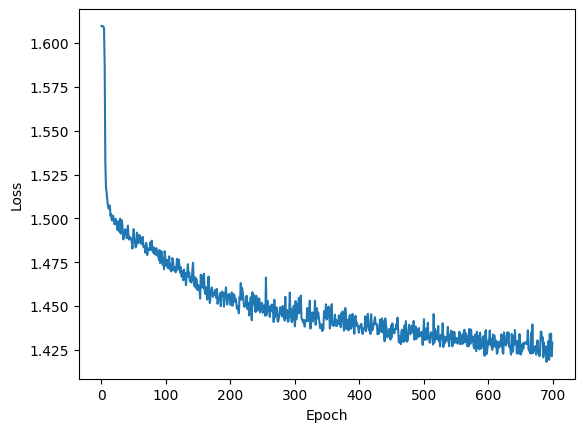

Test accuracy: 467.06666666666666
Accuracy: 0.43053763440860215
Precision: 0.4165101501971115
Recall: 0.42771543429749903
F1-score: 0.4175879207849734


Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.43      0.41       495
           1       0.67      0.82      0.74       472
           2       0.30      0.35      0.32       449
           3       0.30      0.23      0.26       463
           4       0.43      0.32      0.36       446

    accuracy                           0.43      2325
   macro avg       0.42      0.43      0.42      2325
weighted avg       0.42      0.43      0.42      2325

                    0           1           2           3           4  \
precision    0.394052    0.668394    0.297505    0.297450    0.425150   
recall       0.428283    0.819915    0.345212    0.226782    0.318386   
f1-score     0.410455    0.736441    0.319588    0.257353    0.364103   
support    495.000000  472.000000  449.0000

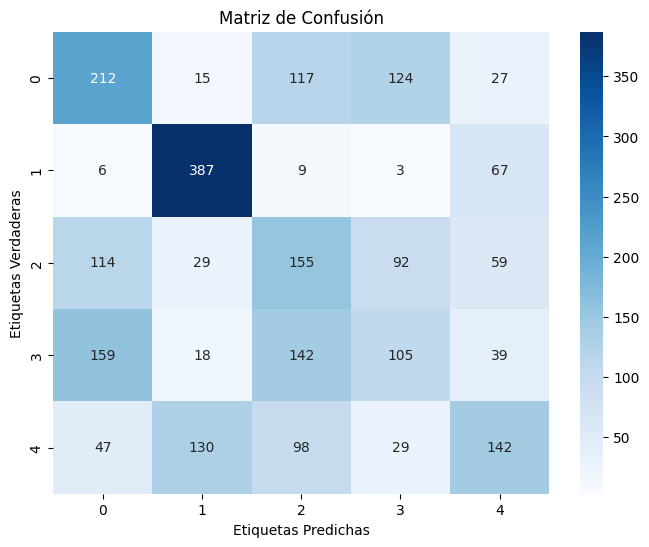

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_0.0001_0.3/resultados_700_0.0001_0.3.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|                                                               | 1/700 [00:01<19:40,  1.69s/it]

1.6096929851700277


Procesando epocas:   0%|▏                                                              | 2/700 [00:03<19:31,  1.68s/it]

1.609677065821255


Procesando epocas:   0%|▎                                                              | 3/700 [00:05<19:30,  1.68s/it]

1.6095764938522787


Procesando epocas:   1%|▎                                                              | 4/700 [00:06<19:32,  1.68s/it]

1.6096649338217344


Procesando epocas:   1%|▍                                                              | 5/700 [00:08<19:32,  1.69s/it]

1.6097239080597372


Procesando epocas:   1%|▌                                                              | 6/700 [00:10<19:29,  1.68s/it]

1.609699279420516


Procesando epocas:   1%|▋                                                              | 7/700 [00:11<19:27,  1.68s/it]

1.609701565433951


Procesando epocas:   1%|▋                                                              | 8/700 [00:13<19:23,  1.68s/it]

1.6097144084818222


Procesando epocas:   1%|▊                                                              | 9/700 [00:15<19:24,  1.69s/it]

1.6096715625594644


Procesando epocas:   1%|▉                                                             | 10/700 [00:16<19:21,  1.68s/it]

1.6096331203685088


Procesando epocas:   2%|▉                                                             | 11/700 [00:18<19:18,  1.68s/it]

1.6094967021661646


Procesando epocas:   2%|█                                                             | 12/700 [00:20<19:14,  1.68s/it]

1.6094953775405885


Procesando epocas:   2%|█▏                                                            | 13/700 [00:21<19:09,  1.67s/it]

1.6094881036702324


Procesando epocas:   2%|█▏                                                            | 14/700 [00:23<19:08,  1.67s/it]

1.6094078863368315


Procesando epocas:   2%|█▎                                                            | 15/700 [00:25<19:09,  1.68s/it]

1.6092558390953962


Procesando epocas:   2%|█▍                                                            | 16/700 [00:26<19:08,  1.68s/it]

1.60904481270734


Procesando epocas:   2%|█▌                                                            | 17/700 [00:28<19:08,  1.68s/it]

1.6085203100653256


Procesando epocas:   3%|█▌                                                            | 18/700 [00:30<19:07,  1.68s/it]

1.6076458257787367


Procesando epocas:   3%|█▋                                                            | 19/700 [00:31<19:06,  1.68s/it]

1.6062416111721711


Procesando epocas:   3%|█▊                                                            | 20/700 [00:33<19:04,  1.68s/it]

1.6034574172076057


Procesando epocas:   3%|█▊                                                            | 21/700 [00:35<19:02,  1.68s/it]

1.5987397025613224


Procesando epocas:   3%|█▉                                                            | 22/700 [00:36<19:00,  1.68s/it]

1.5907710131476906


Procesando epocas:   3%|██                                                            | 23/700 [00:38<18:59,  1.68s/it]

1.5810948287739472


Procesando epocas:   3%|██▏                                                           | 24/700 [00:40<18:58,  1.68s/it]

1.5714738677529727


Procesando epocas:   4%|██▏                                                           | 25/700 [00:42<18:55,  1.68s/it]

1.5626215184436125


Procesando epocas:   4%|██▎                                                           | 26/700 [00:43<18:52,  1.68s/it]

1.5545799129149493


Procesando epocas:   4%|██▍                                                           | 27/700 [00:45<18:50,  1.68s/it]

1.5464534542139838


Procesando epocas:   4%|██▍                                                           | 28/700 [00:47<18:50,  1.68s/it]

1.5404126721269944


Procesando epocas:   4%|██▌                                                           | 29/700 [00:48<18:50,  1.68s/it]

1.5375457770684187


Procesando epocas:   4%|██▋                                                           | 30/700 [00:50<18:47,  1.68s/it]

1.5322641078163595


Procesando epocas:   4%|██▋                                                           | 31/700 [00:52<18:44,  1.68s/it]

1.529876204097972


Procesando epocas:   5%|██▊                                                           | 32/700 [00:53<18:43,  1.68s/it]

1.5272438953904544


Procesando epocas:   5%|██▉                                                           | 33/700 [00:55<18:40,  1.68s/it]

1.5274997374590706


Procesando epocas:   5%|███                                                           | 34/700 [00:57<18:39,  1.68s/it]

1.5260959162431604


Procesando epocas:   5%|███                                                           | 35/700 [00:58<18:39,  1.68s/it]

1.527349804429447


Procesando epocas:   5%|███▏                                                          | 36/700 [01:00<18:38,  1.68s/it]

1.5189579045071322


Procesando epocas:   5%|███▎                                                          | 37/700 [01:02<18:35,  1.68s/it]

1.5189210092320162


Procesando epocas:   5%|███▎                                                          | 38/700 [01:03<18:34,  1.68s/it]

1.5198224986300748


Procesando epocas:   6%|███▍                                                          | 39/700 [01:05<18:33,  1.68s/it]

1.5171370099572574


Procesando epocas:   6%|███▌                                                          | 40/700 [01:07<18:32,  1.69s/it]

1.5174911064260146


Procesando epocas:   6%|███▋                                                          | 41/700 [01:08<18:32,  1.69s/it]

1.5146188420407913


Procesando epocas:   6%|███▋                                                          | 42/700 [01:10<18:29,  1.69s/it]

1.5161532086484573


Procesando epocas:   6%|███▊                                                          | 43/700 [01:12<18:29,  1.69s/it]

1.5109177372034859


Procesando epocas:   6%|███▉                                                          | 44/700 [01:14<18:39,  1.71s/it]

1.509266814063577


Procesando epocas:   6%|███▉                                                          | 45/700 [01:15<18:48,  1.72s/it]

1.512279359032126


Procesando epocas:   7%|████                                                          | 46/700 [01:17<18:53,  1.73s/it]

1.5112026740522946


Procesando epocas:   7%|████▏                                                         | 47/700 [01:19<18:56,  1.74s/it]

1.5095330785302554


Procesando epocas:   7%|████▎                                                         | 48/700 [01:21<18:57,  1.75s/it]

1.5072756136164946


Procesando epocas:   7%|████▎                                                         | 49/700 [01:22<18:58,  1.75s/it]

1.5081485082121457


Procesando epocas:   7%|████▍                                                         | 50/700 [01:24<18:57,  1.75s/it]

1.5088074298465952


Procesando epocas:   7%|████▌                                                         | 51/700 [01:26<18:56,  1.75s/it]

1.505938836406259


Procesando epocas:   7%|████▌                                                         | 52/700 [01:28<18:55,  1.75s/it]

1.504582734668956


Procesando epocas:   8%|████▋                                                         | 53/700 [01:29<18:56,  1.76s/it]

1.5049701851956985


Procesando epocas:   8%|████▊                                                         | 54/700 [01:31<18:54,  1.76s/it]

1.5054713999523837


Procesando epocas:   8%|████▊                                                         | 55/700 [01:33<18:51,  1.75s/it]

1.5026381674934837


Procesando epocas:   8%|████▉                                                         | 56/700 [01:35<18:50,  1.76s/it]

1.5032002336838666


Procesando epocas:   8%|█████                                                         | 57/700 [01:36<18:47,  1.75s/it]

1.500661227983587


Procesando epocas:   8%|█████▏                                                        | 58/700 [01:38<18:47,  1.76s/it]

1.5002858800046583


Procesando epocas:   8%|█████▏                                                        | 59/700 [01:40<18:46,  1.76s/it]

1.5039237281855415


Procesando epocas:   9%|█████▎                                                        | 60/700 [01:42<18:45,  1.76s/it]

1.4991121299126569


Procesando epocas:   9%|█████▍                                                        | 61/700 [01:43<18:42,  1.76s/it]

1.5001150481841143


Procesando epocas:   9%|█████▍                                                        | 62/700 [01:45<18:39,  1.76s/it]

1.500096522359287


Procesando epocas:   9%|█████▌                                                        | 63/700 [01:47<18:34,  1.75s/it]

1.5019989139893475


Procesando epocas:   9%|█████▋                                                        | 64/700 [01:49<18:28,  1.74s/it]

1.501782537207884


Procesando epocas:   9%|█████▊                                                        | 65/700 [01:50<18:20,  1.73s/it]

1.5013358733233284


Procesando epocas:   9%|█████▊                                                        | 66/700 [01:52<18:15,  1.73s/it]

1.5011702923213734


Procesando epocas:  10%|█████▉                                                        | 67/700 [01:54<18:11,  1.72s/it]

1.497587128947763


Procesando epocas:  10%|██████                                                        | 68/700 [01:56<18:11,  1.73s/it]

1.4955215166596805


Procesando epocas:  10%|██████                                                        | 69/700 [01:57<18:07,  1.72s/it]

1.500586619797875


Procesando epocas:  10%|██████▏                                                       | 70/700 [01:59<18:05,  1.72s/it]

1.4968247217290542


Procesando epocas:  10%|██████▎                                                       | 71/700 [02:01<18:05,  1.73s/it]

1.5001133420888115


Procesando epocas:  10%|██████▍                                                       | 72/700 [02:02<18:03,  1.73s/it]

1.4969678983968846


Procesando epocas:  10%|██████▍                                                       | 73/700 [02:04<18:01,  1.72s/it]

1.496152321030112


Procesando epocas:  11%|██████▌                                                       | 74/700 [02:06<17:55,  1.72s/it]

1.499937446678386


Procesando epocas:  11%|██████▋                                                       | 75/700 [02:08<17:47,  1.71s/it]

1.4965197871713076


Procesando epocas:  11%|██████▋                                                       | 76/700 [02:09<17:43,  1.70s/it]

1.4979016928111806


Procesando epocas:  11%|██████▊                                                       | 77/700 [02:11<17:39,  1.70s/it]

1.4950056447702296


Procesando epocas:  11%|██████▉                                                       | 78/700 [02:13<17:36,  1.70s/it]

1.4937648387516247


Procesando epocas:  11%|██████▉                                                       | 79/700 [02:14<17:33,  1.70s/it]

1.496044751475839


Procesando epocas:  11%|███████                                                       | 80/700 [02:16<17:30,  1.69s/it]

1.4952385909417096


Procesando epocas:  12%|███████▏                                                      | 81/700 [02:18<17:24,  1.69s/it]

1.493890039359822


Procesando epocas:  12%|███████▎                                                      | 82/700 [02:19<17:23,  1.69s/it]

1.495260714082157


Procesando epocas:  12%|███████▎                                                      | 83/700 [02:21<17:23,  1.69s/it]

1.4932148442548865


Procesando epocas:  12%|███████▍                                                      | 84/700 [02:23<17:20,  1.69s/it]

1.4921685457229614


Procesando epocas:  12%|███████▌                                                      | 85/700 [02:24<17:15,  1.68s/it]

1.4965258044355056


Procesando epocas:  12%|███████▌                                                      | 86/700 [02:26<17:13,  1.68s/it]

1.4943444420309628


Procesando epocas:  12%|███████▋                                                      | 87/700 [02:28<17:13,  1.69s/it]

1.4936557615504544


Procesando epocas:  13%|███████▊                                                      | 88/700 [02:30<17:11,  1.69s/it]

1.4918027695487528


Procesando epocas:  13%|███████▉                                                      | 89/700 [02:31<17:10,  1.69s/it]

1.4918076753616334


Procesando epocas:  13%|███████▉                                                      | 90/700 [02:33<17:07,  1.68s/it]

1.4899848790729746


Procesando epocas:  13%|████████                                                      | 91/700 [02:35<17:05,  1.68s/it]

1.492219980324016


Procesando epocas:  13%|████████▏                                                     | 92/700 [02:36<17:07,  1.69s/it]

1.4926473764812245


Procesando epocas:  13%|████████▏                                                     | 93/700 [02:38<17:02,  1.69s/it]

1.4937787750188043


Procesando epocas:  13%|████████▎                                                     | 94/700 [02:40<17:00,  1.68s/it]

1.4897889067144956


Procesando epocas:  14%|████████▍                                                     | 95/700 [02:41<16:56,  1.68s/it]

1.4879723289433648


Procesando epocas:  14%|████████▌                                                     | 96/700 [02:43<16:57,  1.68s/it]

1.4900960880167344


Procesando epocas:  14%|████████▌                                                     | 97/700 [02:45<16:57,  1.69s/it]

1.4891637009732863


Procesando epocas:  14%|████████▋                                                     | 98/700 [02:46<16:57,  1.69s/it]

1.4892516080070943


Procesando epocas:  14%|████████▊                                                     | 99/700 [02:48<16:56,  1.69s/it]

1.4894365941776948


Procesando epocas:  14%|████████▋                                                    | 100/700 [02:50<16:54,  1.69s/it]

1.4890652270878062


Procesando epocas:  14%|████████▊                                                    | 101/700 [02:51<16:52,  1.69s/it]

1.4909265805693235


Procesando epocas:  15%|████████▉                                                    | 102/700 [02:53<16:47,  1.68s/it]

1.4906334484324735


Procesando epocas:  15%|████████▉                                                    | 103/700 [02:55<16:39,  1.67s/it]

1.4890391994925107


Procesando epocas:  15%|█████████                                                    | 104/700 [02:56<16:33,  1.67s/it]

1.48835027848973


Procesando epocas:  15%|█████████▏                                                   | 105/700 [02:58<16:29,  1.66s/it]

1.489671034672681


Procesando epocas:  15%|█████████▏                                                   | 106/700 [03:00<16:26,  1.66s/it]

1.4872012187452877


Procesando epocas:  15%|█████████▎                                                   | 107/700 [03:01<16:23,  1.66s/it]

1.4885534798397737


Procesando epocas:  15%|█████████▍                                                   | 108/700 [03:03<16:21,  1.66s/it]

1.484908791850595


Procesando epocas:  16%|█████████▍                                                   | 109/700 [03:05<16:19,  1.66s/it]

1.4890682816505432


Procesando epocas:  16%|█████████▌                                                   | 110/700 [03:06<16:16,  1.65s/it]

1.4885545821750865


Procesando epocas:  16%|█████████▋                                                   | 111/700 [03:08<16:10,  1.65s/it]

1.4885298771016737


Procesando epocas:  16%|█████████▊                                                   | 112/700 [03:10<16:08,  1.65s/it]

1.4885731732144076


Procesando epocas:  16%|█████████▊                                                   | 113/700 [03:11<16:09,  1.65s/it]

1.4866889574948479


Procesando epocas:  16%|█████████▉                                                   | 114/700 [03:13<16:09,  1.66s/it]

1.4867105420897988


Procesando epocas:  16%|██████████                                                   | 115/700 [03:15<16:15,  1.67s/it]

1.4865197953055886


Procesando epocas:  17%|██████████                                                   | 116/700 [03:16<16:24,  1.69s/it]

1.4870643769993501


Procesando epocas:  17%|██████████▏                                                  | 117/700 [03:18<16:27,  1.69s/it]

1.4820092586910023


Procesando epocas:  17%|██████████▎                                                  | 118/700 [03:20<16:28,  1.70s/it]

1.4890904756153331


Procesando epocas:  17%|██████████▎                                                  | 119/700 [03:21<16:27,  1.70s/it]

1.4856681914890513


Procesando epocas:  17%|██████████▍                                                  | 120/700 [03:23<16:26,  1.70s/it]

1.4860379036735085


Procesando epocas:  17%|██████████▌                                                  | 121/700 [03:25<16:23,  1.70s/it]

1.4834883395363303


Procesando epocas:  17%|██████████▋                                                  | 122/700 [03:27<16:21,  1.70s/it]

1.4853165738722858


Procesando epocas:  18%|██████████▋                                                  | 123/700 [03:28<16:18,  1.70s/it]

1.4860298605526194


Procesando epocas:  18%|██████████▊                                                  | 124/700 [03:30<16:16,  1.70s/it]

1.4831850360421572


Procesando epocas:  18%|██████████▉                                                  | 125/700 [03:32<16:14,  1.70s/it]

1.4858860773198745


Procesando epocas:  18%|██████████▉                                                  | 126/700 [03:33<16:13,  1.70s/it]

1.485937927049749


Procesando epocas:  18%|███████████                                                  | 127/700 [03:35<16:11,  1.70s/it]

1.4827348842340358


Procesando epocas:  18%|███████████▏                                                 | 128/700 [03:37<16:11,  1.70s/it]

1.486465085955227


Procesando epocas:  18%|███████████▏                                                 | 129/700 [03:38<16:08,  1.70s/it]

1.4840399552794064


Procesando epocas:  19%|███████████▎                                                 | 130/700 [03:40<16:06,  1.70s/it]

1.4820147233850816


Procesando epocas:  19%|███████████▍                                                 | 131/700 [03:42<16:04,  1.69s/it]

1.4863571110893699


Procesando epocas:  19%|███████████▌                                                 | 132/700 [03:44<16:02,  1.69s/it]

1.482471832107095


Procesando epocas:  19%|███████████▌                                                 | 133/700 [03:45<16:01,  1.70s/it]

1.4834988580030553


Procesando epocas:  19%|███████████▋                                                 | 134/700 [03:47<15:58,  1.69s/it]

1.4854168457143446


Procesando epocas:  19%|███████████▊                                                 | 135/700 [03:49<15:55,  1.69s/it]

1.4852099818341873


Procesando epocas:  19%|███████████▊                                                 | 136/700 [03:50<15:51,  1.69s/it]

1.484446144805235


Procesando epocas:  20%|███████████▉                                                 | 137/700 [03:52<15:48,  1.68s/it]

1.4821696842417997


Procesando epocas:  20%|████████████                                                 | 138/700 [03:54<15:47,  1.69s/it]

1.4838657568482791


Procesando epocas:  20%|████████████                                                 | 139/700 [03:55<15:45,  1.69s/it]

1.4829436470480526


Procesando epocas:  20%|████████████▏                                                | 140/700 [03:57<15:46,  1.69s/it]

1.480690396533293


Procesando epocas:  20%|████████████▎                                                | 141/700 [03:59<15:42,  1.69s/it]

1.4781646083383


Procesando epocas:  20%|████████████▎                                                | 142/700 [04:00<15:40,  1.69s/it]

1.4821305611554314


Procesando epocas:  20%|████████████▍                                                | 143/700 [04:02<15:37,  1.68s/it]

1.4844382783945869


Procesando epocas:  21%|████████████▌                                                | 144/700 [04:04<15:36,  1.68s/it]

1.4825367036987753


Procesando epocas:  21%|████████████▋                                                | 145/700 [04:05<15:33,  1.68s/it]

1.4809596812023835


Procesando epocas:  21%|████████████▋                                                | 146/700 [04:07<15:32,  1.68s/it]

1.4816220472840702


Procesando epocas:  21%|████████████▊                                                | 147/700 [04:09<15:30,  1.68s/it]

1.4836652573417215


Procesando epocas:  21%|████████████▉                                                | 148/700 [04:10<15:28,  1.68s/it]

1.4812717718236588


Procesando epocas:  21%|████████████▉                                                | 149/700 [04:12<15:26,  1.68s/it]

1.481252793003531


Procesando epocas:  21%|█████████████                                                | 150/700 [04:14<15:24,  1.68s/it]

1.4817243709283716


Procesando epocas:  22%|█████████████▏                                               | 151/700 [04:16<15:21,  1.68s/it]

1.488104741012349


Procesando epocas:  22%|█████████████▏                                               | 152/700 [04:17<15:21,  1.68s/it]

1.4817782528260175


Procesando epocas:  22%|█████████████▎                                               | 153/700 [04:19<15:19,  1.68s/it]

1.4790087489520802


Procesando epocas:  22%|█████████████▍                                               | 154/700 [04:21<15:17,  1.68s/it]

1.4805866290541256


Procesando epocas:  22%|█████████████▌                                               | 155/700 [04:22<15:15,  1.68s/it]

1.4800322869244744


Procesando epocas:  22%|█████████████▌                                               | 156/700 [04:24<15:13,  1.68s/it]

1.4797387831351336


Procesando epocas:  22%|█████████████▋                                               | 157/700 [04:26<15:12,  1.68s/it]

1.4798612166853513


Procesando epocas:  23%|█████████████▊                                               | 158/700 [04:27<15:10,  1.68s/it]

1.482482405269847


Procesando epocas:  23%|█████████████▊                                               | 159/700 [04:29<15:07,  1.68s/it]

1.4814240602885975


Procesando epocas:  23%|█████████████▉                                               | 160/700 [04:31<15:05,  1.68s/it]

1.4810176316429586


Procesando epocas:  23%|██████████████                                               | 161/700 [04:32<15:04,  1.68s/it]

1.4798233642297633


Procesando epocas:  23%|██████████████                                               | 162/700 [04:34<15:03,  1.68s/it]

1.480029406267054


Procesando epocas:  23%|██████████████▏                                              | 163/700 [04:36<14:59,  1.67s/it]

1.4800216906210955


Procesando epocas:  23%|██████████████▎                                              | 164/700 [04:37<14:56,  1.67s/it]

1.4806085018550648


Procesando epocas:  24%|██████████████▍                                              | 165/700 [04:39<14:55,  1.67s/it]

1.478858238809249


Procesando epocas:  24%|██████████████▍                                              | 166/700 [04:41<15:04,  1.69s/it]

1.479409767599667


Procesando epocas:  24%|██████████████▌                                              | 167/700 [04:42<15:11,  1.71s/it]

1.4807691721355214


Procesando epocas:  24%|██████████████▋                                              | 168/700 [04:44<15:17,  1.72s/it]

1.4779467470505658


Procesando epocas:  24%|██████████████▋                                              | 169/700 [04:46<15:19,  1.73s/it]

1.4776526486172397


Procesando epocas:  24%|██████████████▊                                              | 170/700 [04:48<15:20,  1.74s/it]

1.4779038618592655


Procesando epocas:  24%|██████████████▉                                              | 171/700 [04:50<15:21,  1.74s/it]

1.477918809301713


Procesando epocas:  25%|██████████████▉                                              | 172/700 [04:51<15:21,  1.75s/it]

1.4763795242590063


Procesando epocas:  25%|███████████████                                              | 173/700 [04:53<15:20,  1.75s/it]

1.4781547427177428


Procesando epocas:  25%|███████████████▏                                             | 174/700 [04:55<15:19,  1.75s/it]

1.4785041759995854


Procesando epocas:  25%|███████████████▎                                             | 175/700 [04:57<15:17,  1.75s/it]

1.4779124891056734


Procesando epocas:  25%|███████████████▎                                             | 176/700 [04:58<15:16,  1.75s/it]

1.479322831770953


Procesando epocas:  25%|███████████████▍                                             | 177/700 [05:00<15:15,  1.75s/it]

1.4799126372617835


Procesando epocas:  25%|███████████████▌                                             | 178/700 [05:02<15:13,  1.75s/it]

1.4787270917611963


Procesando epocas:  26%|███████████████▌                                             | 179/700 [05:04<15:12,  1.75s/it]

1.477770289252786


Procesando epocas:  26%|███████████████▋                                             | 180/700 [05:05<15:10,  1.75s/it]

1.4792315868770376


Procesando epocas:  26%|███████████████▊                                             | 181/700 [05:07<15:07,  1.75s/it]

1.48100465185502


Procesando epocas:  26%|███████████████▊                                             | 182/700 [05:09<15:05,  1.75s/it]

1.4778960852062002


Procesando epocas:  26%|███████████████▉                                             | 183/700 [05:11<15:03,  1.75s/it]

1.4757750742575702


Procesando epocas:  26%|████████████████                                             | 184/700 [05:12<15:00,  1.75s/it]

1.4784029252388897


Procesando epocas:  26%|████████████████                                             | 185/700 [05:14<14:58,  1.74s/it]

1.4810877771938549


Procesando epocas:  27%|████████████████▏                                            | 186/700 [05:16<14:57,  1.75s/it]

1.475052095861996


Procesando epocas:  27%|████████████████▎                                            | 187/700 [05:17<14:57,  1.75s/it]

1.479887702184565


Procesando epocas:  27%|████████████████▍                                            | 188/700 [05:19<14:55,  1.75s/it]

1.4758377054158378


Procesando epocas:  27%|████████████████▍                                            | 189/700 [05:21<14:53,  1.75s/it]

1.4772718345417697


Procesando epocas:  27%|████████████████▌                                            | 190/700 [05:23<14:50,  1.75s/it]

1.4750199135612039


Procesando epocas:  27%|████████████████▋                                            | 191/700 [05:24<14:48,  1.75s/it]

1.4750387507326463


Procesando epocas:  27%|████████████████▋                                            | 192/700 [05:26<14:46,  1.74s/it]

1.480808675289154


Procesando epocas:  28%|████████████████▊                                            | 193/700 [05:28<14:44,  1.74s/it]

1.4754825248437768


Procesando epocas:  28%|████████████████▉                                            | 194/700 [05:30<14:43,  1.75s/it]

1.4794730158413159


Procesando epocas:  28%|████████████████▉                                            | 195/700 [05:31<14:43,  1.75s/it]

1.4768281754325419


Procesando epocas:  28%|█████████████████                                            | 196/700 [05:33<14:40,  1.75s/it]

1.47572702590157


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [05:35<14:35,  1.74s/it]

1.4755838920088375


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [05:37<14:29,  1.73s/it]

1.4780924804070417


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [05:38<14:23,  1.72s/it]

1.4781619899413165


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [05:40<14:19,  1.72s/it]

1.4786958435002495


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [05:42<14:16,  1.72s/it]

1.4744088958291446


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [05:43<14:15,  1.72s/it]

1.47852566242218


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [05:45<14:11,  1.71s/it]

1.4792233796680674


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [05:47<14:09,  1.71s/it]

1.4778380604351269


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [05:49<14:10,  1.72s/it]

1.4754061719950509


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [05:50<14:07,  1.72s/it]

1.479059971781338


Procesando epocas:  30%|██████████████████                                           | 207/700 [05:52<14:05,  1.71s/it]

1.4753468590624192


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [05:54<14:01,  1.71s/it]

1.4746441827100867


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [05:55<14:00,  1.71s/it]

1.4746486123870401


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [05:57<13:59,  1.71s/it]

1.4738629979245803


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [05:59<13:58,  1.72s/it]

1.476169990791994


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [06:01<13:58,  1.72s/it]

1.477002617190866


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [06:02<13:54,  1.71s/it]

1.473075124095468


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [06:04<13:54,  1.72s/it]

1.474775145334356


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [06:06<13:51,  1.72s/it]

1.4755279407781714


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [06:07<13:49,  1.71s/it]

1.4770865531528696


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [06:09<13:47,  1.71s/it]

1.4754127509453718


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [06:11<13:46,  1.72s/it]

1.4761313494514017


Procesando epocas:  31%|███████████████████                                          | 219/700 [06:13<13:44,  1.71s/it]

1.4731365154771243


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [06:14<13:42,  1.71s/it]

1.475444244637209


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [06:16<13:41,  1.71s/it]

1.4757159730967353


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [06:18<13:40,  1.72s/it]

1.475230690310983


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [06:19<13:39,  1.72s/it]

1.4734894675367018


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [06:21<13:37,  1.72s/it]

1.4751165537273183


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [06:23<13:32,  1.71s/it]

1.4741872969795675


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [06:25<13:28,  1.70s/it]

1.4727855934816247


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [06:26<13:26,  1.70s/it]

1.4744510426240809


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [06:28<13:20,  1.70s/it]

1.477770892311545


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [06:30<13:18,  1.69s/it]

1.476516317619997


Procesando epocas:  33%|████████████████████                                         | 230/700 [06:31<13:15,  1.69s/it]

1.4743761693730073


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [06:33<13:13,  1.69s/it]

1.4759098354507896


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [06:35<13:12,  1.69s/it]

1.474033566082225


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [06:36<13:10,  1.69s/it]

1.4756804999183206


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [06:38<13:09,  1.69s/it]

1.4753302630256204


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [06:40<13:08,  1.70s/it]

1.475661716040443


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [06:42<13:06,  1.70s/it]

1.4746696773697348


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [06:43<13:04,  1.69s/it]

1.4742987955317777


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [06:45<13:03,  1.70s/it]

1.4761733721284305


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [06:47<13:01,  1.70s/it]

1.4748605798272525


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [06:48<12:59,  1.69s/it]

1.4736912727355957


Procesando epocas:  34%|█████████████████████                                        | 241/700 [06:50<12:58,  1.70s/it]

1.4739782648928026


Procesando epocas:  35%|█████████████████████                                        | 242/700 [06:52<12:55,  1.69s/it]

1.4758529326495002


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [06:53<12:52,  1.69s/it]

1.470556585227742


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [06:55<12:52,  1.69s/it]

1.474802565574646


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [06:57<12:49,  1.69s/it]

1.4744515643400304


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [06:58<12:49,  1.69s/it]

1.4699314250665552


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [07:00<12:47,  1.69s/it]

1.4692797183990478


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [07:02<12:45,  1.69s/it]

1.472863646815805


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [07:04<12:44,  1.69s/it]

1.475664149312412


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [07:05<12:43,  1.70s/it]

1.4724471548024345


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [07:07<12:42,  1.70s/it]

1.4733077189501593


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [07:09<12:40,  1.70s/it]

1.4712913450072793


Procesando epocas:  36%|██████████████████████                                       | 253/700 [07:10<12:39,  1.70s/it]

1.4747520411715789


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [07:12<12:36,  1.70s/it]

1.4740140676498412


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [07:14<12:34,  1.70s/it]

1.4749718252350301


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [07:15<12:31,  1.69s/it]

1.4721452790148117


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [07:17<12:29,  1.69s/it]

1.4757242293918833


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [07:19<12:21,  1.68s/it]

1.4732608661932103


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [07:20<12:14,  1.67s/it]

1.4741093046524945


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [07:22<12:09,  1.66s/it]

1.4737200477544


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [07:24<12:05,  1.65s/it]

1.4723917659591226


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [07:25<12:00,  1.65s/it]

1.4723486086901496


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [07:27<11:57,  1.64s/it]

1.4697416761342217


Procesando epocas:  38%|███████████████████████                                      | 264/700 [07:29<11:57,  1.65s/it]

1.4718575105947607


Procesando epocas:  38%|███████████████████████                                      | 265/700 [07:30<11:55,  1.64s/it]

1.4703755694277145


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [07:32<11:51,  1.64s/it]

1.4713937745374792


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [07:34<11:50,  1.64s/it]

1.475171245546902


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [07:35<11:48,  1.64s/it]

1.469732806261848


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [07:37<11:46,  1.64s/it]

1.4738422758439007


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [07:38<11:45,  1.64s/it]

1.476204344104318


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [07:40<11:43,  1.64s/it]

1.4723357284770293


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [07:42<11:42,  1.64s/it]

1.469385197583367


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [07:43<11:42,  1.65s/it]

1.472018166850595


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [07:45<11:40,  1.64s/it]

1.4708486984757816


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [07:47<11:38,  1.64s/it]

1.4723745808881872


Procesando epocas:  39%|████████████████████████                                     | 276/700 [07:48<11:35,  1.64s/it]

1.4694441823398365


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [07:50<11:33,  1.64s/it]

1.4725186635466183


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [07:52<11:32,  1.64s/it]

1.4718537281541264


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [07:53<11:31,  1.64s/it]

1.4735054913689107


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [07:55<11:30,  1.64s/it]

1.472666158395655


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [07:57<11:28,  1.64s/it]

1.4706208074794096


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [07:58<11:25,  1.64s/it]

1.4688560794381533


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [08:00<11:24,  1.64s/it]

1.470584262819851


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [08:01<11:23,  1.64s/it]

1.470221995606142


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [08:03<11:21,  1.64s/it]

1.4700154739267686


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [08:05<11:23,  1.65s/it]

1.4719656523536233


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [08:06<11:20,  1.65s/it]

1.4709122517529656


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [08:08<11:19,  1.65s/it]

1.471315927365247


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [08:10<11:26,  1.67s/it]

1.474262413557838


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [08:11<11:33,  1.69s/it]

1.4726396609755124


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [08:13<11:37,  1.71s/it]

1.4710040969007157


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [08:15<11:38,  1.71s/it]

1.4677746828864602


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [08:17<11:38,  1.72s/it]

1.469473732920254


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [08:18<11:39,  1.72s/it]

1.4698636167189654


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [08:20<11:36,  1.72s/it]

1.4698943159159492


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [08:22<11:35,  1.72s/it]

1.472297849374659


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [08:24<11:34,  1.72s/it]

1.469144424270181


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [08:25<11:30,  1.72s/it]

1.470287549495697


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [08:27<11:29,  1.72s/it]

1.4713276666753432


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [08:29<11:28,  1.72s/it]

1.4713086983736823


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [08:30<11:26,  1.72s/it]

1.4726035279386185


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [08:32<11:24,  1.72s/it]

1.471462387197158


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [08:34<11:24,  1.72s/it]

1.4696134539211498


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [08:36<11:22,  1.72s/it]

1.4723394814659567


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [08:37<11:20,  1.72s/it]

1.468339710375842


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [08:39<11:18,  1.72s/it]

1.4682402337298674


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [08:41<11:17,  1.72s/it]

1.4685574475456686


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [08:43<11:14,  1.72s/it]

1.4680721963153165


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [08:44<11:17,  1.73s/it]

1.4687041086309096


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [08:46<11:18,  1.74s/it]

1.4680217111811917


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [08:48<11:19,  1.75s/it]

1.474065801676582


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [08:50<11:18,  1.75s/it]

1.4748221530633814


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [08:51<11:18,  1.75s/it]

1.470641838803011


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [08:53<11:17,  1.75s/it]

1.4703338426702164


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [08:55<11:16,  1.76s/it]

1.4726009270724127


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [08:57<11:14,  1.76s/it]

1.4688652704743779


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [08:58<11:13,  1.76s/it]

1.467531016293694


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [09:00<11:13,  1.76s/it]

1.4691054989309873


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [09:02<11:10,  1.76s/it]

1.4704397054279552


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [09:04<11:05,  1.75s/it]

1.4708521849968854


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [09:05<11:00,  1.74s/it]

1.4689010928658879


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [09:07<10:55,  1.73s/it]

1.469887741874246


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [09:09<10:52,  1.73s/it]

1.4722089206471163


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [09:10<10:50,  1.73s/it]

1.4682434103068183


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [09:12<10:48,  1.73s/it]

1.4688187564120574


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [09:14<10:46,  1.73s/it]

1.4668357975342694


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [09:16<10:43,  1.72s/it]

1.4671739893801072


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [09:17<10:41,  1.73s/it]

1.4681418664315167


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [09:19<10:38,  1.72s/it]

1.468163306572858


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [09:21<10:37,  1.72s/it]

1.4684280584840212


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [09:23<10:35,  1.72s/it]

1.4719148937393638


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [09:24<10:34,  1.72s/it]

1.4649377114632551


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [09:26<10:32,  1.72s/it]

1.473375964865965


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [09:28<10:31,  1.73s/it]

1.470098687620724


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [09:29<10:29,  1.72s/it]

1.4678735115948844


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [09:31<10:27,  1.72s/it]

1.4659111289417042


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [09:33<10:25,  1.72s/it]

1.4681814691599677


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [09:35<10:23,  1.72s/it]

1.4659699201583862


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [09:36<10:21,  1.72s/it]

1.4694254868170795


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [09:38<10:19,  1.72s/it]

1.468340198432698


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [09:40<10:17,  1.72s/it]

1.4669129175298354


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [09:42<10:16,  1.72s/it]

1.4678490077748019


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [09:43<10:14,  1.72s/it]

1.4659062518792993


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [09:45<10:13,  1.72s/it]

1.4664137482643127


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [09:47<10:11,  1.72s/it]

1.4657930787871867


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [09:48<10:10,  1.72s/it]

1.4649004277061013


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [09:50<10:05,  1.72s/it]

1.465134389260236


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [09:52<10:00,  1.71s/it]

1.4662066613926608


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [09:53<09:56,  1.70s/it]

1.4635826594689314


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [09:55<09:54,  1.70s/it]

1.4686837287510142


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [09:57<09:52,  1.70s/it]

1.4691960734479568


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [09:59<09:49,  1.69s/it]

1.4713412733638989


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [10:00<09:47,  1.69s/it]

1.4671197519582861


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [10:02<09:44,  1.69s/it]

1.4682330019333782


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [10:04<09:41,  1.69s/it]

1.4658894244362326


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [10:05<09:40,  1.69s/it]

1.4649442855049581


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [10:07<09:37,  1.68s/it]

1.4658420464571784


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [10:09<09:35,  1.68s/it]

1.465030496260699


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [10:10<09:33,  1.68s/it]

1.4684468136114233


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [10:12<09:31,  1.68s/it]

1.4681450072456808


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [10:14<09:30,  1.68s/it]

1.4677163993611055


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [10:15<09:27,  1.68s/it]

1.4706388066796696


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [10:17<09:25,  1.68s/it]

1.4677613195251016


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [10:19<09:25,  1.68s/it]

1.4665227967150072


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [10:20<09:23,  1.68s/it]

1.468278602992787


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [10:22<09:21,  1.68s/it]

1.4656206446535447


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [10:24<09:19,  1.68s/it]

1.4666677327717053


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [10:25<09:17,  1.68s/it]

1.4661423192304723


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [10:27<09:15,  1.68s/it]

1.4650247342446272


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [10:29<09:14,  1.68s/it]

1.464842811752768


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [10:30<09:11,  1.68s/it]

1.4702891861691194


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [10:32<09:13,  1.69s/it]

1.4665105973972994


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [10:34<09:10,  1.68s/it]

1.463312468108009


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [10:36<09:07,  1.68s/it]

1.4646320868940914


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [10:37<09:05,  1.68s/it]

1.4711095880059635


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [10:39<09:02,  1.68s/it]

1.4624039152089288


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [10:41<09:01,  1.68s/it]

1.4673235802089466


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [10:42<09:00,  1.68s/it]

1.4664755260243136


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [10:44<08:57,  1.68s/it]

1.4686590236776016


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [10:46<08:57,  1.68s/it]

1.464604242408977


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [10:47<08:54,  1.68s/it]

1.4637640714645386


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [10:49<08:52,  1.67s/it]

1.463991166563595


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [10:51<08:50,  1.68s/it]

1.4640563509043525


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [10:52<08:49,  1.67s/it]

1.4652790069580077


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [10:54<08:46,  1.67s/it]

1.4647706263205584


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [10:56<08:45,  1.67s/it]

1.4636147919823141


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [10:57<08:42,  1.67s/it]

1.46648130977855


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [10:59<08:41,  1.67s/it]

1.465729704323937


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [11:01<08:39,  1.67s/it]

1.462138429810019


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [11:02<08:37,  1.67s/it]

1.467292991105248


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [11:03<07:45,  1.51s/it]

1.46727013167213


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [11:05<07:55,  1.54s/it]

1.4687382024877211


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [11:07<08:07,  1.59s/it]

1.464339273116168


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [11:08<08:13,  1.61s/it]

1.4669363547773921


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [11:10<08:17,  1.63s/it]

1.4669952105073367


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [11:12<08:19,  1.64s/it]

1.4651208526947919


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [11:13<08:20,  1.65s/it]

1.4657306110157686


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [11:15<08:20,  1.66s/it]

1.4647298700669233


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [11:17<08:20,  1.66s/it]

1.4646026379921857


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [11:18<08:19,  1.66s/it]

1.463280201659483


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [11:20<08:17,  1.67s/it]

1.4653605685514561


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [11:22<08:16,  1.66s/it]

1.4688296367140377


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [11:23<08:15,  1.67s/it]

1.4655942944919362


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [11:25<08:14,  1.67s/it]

1.4650147851775674


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [11:27<08:12,  1.67s/it]

1.4627708855797263


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [11:28<08:11,  1.67s/it]

1.4675780135042527


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [11:30<08:11,  1.68s/it]

1.461541119042565


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [11:32<08:09,  1.68s/it]

1.4645793753511764


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [11:33<08:08,  1.68s/it]

1.4643407029264113


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [11:35<08:08,  1.68s/it]

1.4664087912615609


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [11:37<08:13,  1.71s/it]

1.462882918470046


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [11:39<08:15,  1.72s/it]

1.463565737359664


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [11:40<08:16,  1.73s/it]

1.4649134916417739


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [11:42<08:17,  1.74s/it]

1.4627580053666058


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [11:44<08:17,  1.74s/it]

1.4659176307566026


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [11:46<08:16,  1.75s/it]

1.4627338619793162


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [11:47<08:14,  1.75s/it]

1.4666892332189223


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [11:49<08:13,  1.75s/it]

1.4620597313432133


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [11:51<08:11,  1.75s/it]

1.465000564210555


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [11:53<08:09,  1.75s/it]

1.4644385597285103


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [11:54<08:07,  1.75s/it]

1.4649544631733613


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [11:56<08:06,  1.75s/it]

1.4614136829095727


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [11:58<08:04,  1.75s/it]

1.4630082109395195


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [12:00<08:02,  1.75s/it]

1.464119205755346


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [12:01<08:01,  1.75s/it]

1.4619670454193563


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [12:03<07:59,  1.75s/it]

1.4615841655170216


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [12:05<07:57,  1.75s/it]

1.4630658970159642


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [12:07<07:55,  1.75s/it]

1.4625364534995136


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [12:08<07:53,  1.75s/it]

1.463846304837395


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [12:10<07:51,  1.75s/it]

1.4623638805221109


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [12:12<07:50,  1.75s/it]

1.4647668214405285


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [12:14<07:49,  1.75s/it]

1.46312936334049


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [12:15<07:47,  1.75s/it]

1.465603800380931


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [12:17<07:45,  1.75s/it]

1.4628341815050911


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [12:19<07:44,  1.75s/it]

1.4620191672269036


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [12:21<07:42,  1.75s/it]

1.4656167836750256


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [12:22<07:40,  1.75s/it]

1.4637167320531956


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [12:24<07:39,  1.75s/it]

1.4612273945527918


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [12:26<07:36,  1.75s/it]

1.4677227265694561


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [12:28<07:34,  1.75s/it]

1.4626527028925278


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [12:29<07:33,  1.75s/it]

1.463549835541669


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [12:31<07:29,  1.74s/it]

1.4620234328157762


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [12:33<07:25,  1.73s/it]

1.4630259471781113


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [12:35<07:23,  1.73s/it]

1.459764234458699


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [12:36<07:20,  1.73s/it]

1.4639864395646487


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [12:38<07:18,  1.73s/it]

1.468598168036517


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [12:40<07:15,  1.72s/it]

1.4657807167838601


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [12:42<07:13,  1.72s/it]

1.4643479031675002


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [12:43<07:11,  1.72s/it]

1.4637222269002128


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [12:45<07:09,  1.72s/it]

1.4630803479867822


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [12:47<07:07,  1.72s/it]

1.4629110792103937


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [12:48<07:06,  1.72s/it]

1.4644972177112803


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [12:50<07:04,  1.72s/it]

1.4649635385064517


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [12:52<07:02,  1.72s/it]

1.4649382065324221


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [12:54<07:00,  1.72s/it]

1.461689146827249


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [12:55<06:56,  1.71s/it]

1.462950129368726


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [12:57<06:53,  1.70s/it]

1.4623380184173584


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [12:59<06:50,  1.70s/it]

1.4630355098668266


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [13:00<06:48,  1.69s/it]

1.4594167695325964


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [13:02<06:46,  1.69s/it]

1.4597574458402747


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [13:04<06:43,  1.69s/it]

1.4653179610476774


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [13:05<06:41,  1.69s/it]

1.463842699808233


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [13:07<06:40,  1.69s/it]

1.4631635041797861


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [13:09<06:38,  1.69s/it]

1.4651040561058941


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [13:10<06:35,  1.69s/it]

1.4597576947773203


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [13:12<06:34,  1.69s/it]

1.462110649838167


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [13:14<06:32,  1.69s/it]

1.4624522293315214


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [13:15<06:30,  1.69s/it]

1.462454434703378


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [13:17<06:29,  1.69s/it]

1.4623421781203325


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [13:19<06:25,  1.68s/it]

1.4609196242164164


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [13:20<06:22,  1.67s/it]

1.4597313705612631


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [13:22<06:20,  1.67s/it]

1.4604400143903844


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [13:24<06:17,  1.66s/it]

1.4625454566057992


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [13:25<06:16,  1.66s/it]

1.4623111121794756


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [13:27<06:13,  1.66s/it]

1.463841316279243


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [13:29<06:11,  1.66s/it]

1.4615814215996685


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [13:30<06:09,  1.66s/it]

1.4616845790077657


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [13:32<06:07,  1.65s/it]

1.4604835510253906


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [13:34<06:06,  1.66s/it]

1.4606099907089682


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [13:35<06:04,  1.66s/it]

1.4628956626443301


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [13:37<06:02,  1.65s/it]

1.461551303022048


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [13:39<06:01,  1.66s/it]

1.4575728135950425


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [13:40<05:58,  1.65s/it]

1.461363436194027


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [13:42<05:57,  1.65s/it]

1.4672432969598208


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [13:44<05:56,  1.66s/it]

1.4601723383454714


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [13:45<05:55,  1.66s/it]

1.4592159088920145


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [13:47<05:52,  1.66s/it]

1.462841827027938


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [13:49<05:51,  1.66s/it]

1.4612138306393343


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [13:50<05:49,  1.66s/it]

1.460133177392623


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [13:52<05:47,  1.66s/it]

1.4621213499237509


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [13:54<05:46,  1.66s/it]

1.4591311468797572


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [13:55<05:43,  1.65s/it]

1.4620626302326427


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [13:57<05:42,  1.66s/it]

1.4666542186456568


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [13:59<05:40,  1.65s/it]

1.4620334302677829


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [14:00<05:38,  1.65s/it]

1.4587161933674533


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [14:02<05:36,  1.65s/it]

1.4593101347193997


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [14:03<05:34,  1.65s/it]

1.4649337894776289


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [14:05<05:33,  1.65s/it]

1.4604311844881843


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [14:07<05:31,  1.65s/it]

1.4609211500953225


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [14:08<05:30,  1.65s/it]

1.4636586574947132


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [14:10<05:28,  1.65s/it]

1.4595381757792305


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [14:12<05:26,  1.65s/it]

1.4667097575524275


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [14:13<05:24,  1.65s/it]

1.4612785135998445


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [14:15<05:22,  1.65s/it]

1.4638065036605385


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [14:17<05:20,  1.65s/it]

1.46136936229818


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [14:18<05:19,  1.65s/it]

1.4567498641855576


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [14:20<05:19,  1.66s/it]

1.459729095767526


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [14:22<05:19,  1.66s/it]

1.4642841584542219


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [14:23<05:18,  1.67s/it]

1.4649893536287195


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [14:25<05:17,  1.67s/it]

1.4678673639016993


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [14:27<05:16,  1.67s/it]

1.4629467185805827


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [14:28<05:15,  1.68s/it]

1.4602831623133492


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [14:30<05:13,  1.68s/it]

1.4636357826345108


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [14:32<05:12,  1.68s/it]

1.4587808966636657


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [14:33<05:10,  1.68s/it]

1.4618002015001634


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [14:35<05:09,  1.68s/it]

1.4593581634409287


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [14:37<05:07,  1.68s/it]

1.4613197922706604


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [14:39<05:06,  1.68s/it]

1.4575392793206607


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [14:40<05:04,  1.68s/it]

1.4597148229094112


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [14:42<05:02,  1.68s/it]

1.4636028296807233


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [14:44<05:00,  1.68s/it]

1.4604851273929371


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [14:45<04:58,  1.68s/it]

1.4604581664590275


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [14:47<04:57,  1.68s/it]

1.459819214484271


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [14:49<04:55,  1.68s/it]

1.459251008314245


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [14:50<04:54,  1.68s/it]

1.4625205075039582


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [14:52<04:52,  1.68s/it]

1.4587719524607938


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [14:54<04:50,  1.68s/it]

1.4624542278401993


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [14:55<04:49,  1.68s/it]

1.4634845018386842


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [14:57<04:47,  1.68s/it]

1.4607499108595006


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [14:59<04:45,  1.68s/it]

1.4600748426773968


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [15:00<04:43,  1.68s/it]

1.4616929453961989


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [15:02<04:42,  1.68s/it]

1.4609911406741423


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [15:04<04:44,  1.70s/it]

1.45935780581306


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [15:06<04:45,  1.72s/it]

1.4558259886853835


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [15:07<04:45,  1.73s/it]

1.4574675286517424


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [15:09<04:45,  1.74s/it]

1.4586861568338731


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [15:11<04:44,  1.74s/it]

1.4599051026736989


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [15:13<04:42,  1.75s/it]

1.4585658872828764


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [15:14<04:41,  1.75s/it]

1.4583580571062424


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [15:16<04:40,  1.75s/it]

1.4588859614203957


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [15:18<04:38,  1.75s/it]

1.456904630100026


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [15:20<04:36,  1.75s/it]

1.4588454541038065


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [15:21<04:35,  1.75s/it]

1.4619093887946184


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [15:23<04:33,  1.75s/it]

1.4562926229308633


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [15:25<04:32,  1.76s/it]

1.460240192974315


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [15:27<04:30,  1.76s/it]

1.4561626083710615


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [15:28<04:28,  1.76s/it]

1.459451272908379


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [15:30<04:27,  1.76s/it]

1.4585620943237754


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [15:32<04:25,  1.76s/it]

1.4589378959992352


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [15:34<04:23,  1.76s/it]

1.4590360641479492


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [15:35<04:21,  1.75s/it]

1.4617755083476796


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [15:37<04:18,  1.75s/it]

1.4634489999097937


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [15:39<04:15,  1.74s/it]

1.461053022917579


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [15:41<04:14,  1.75s/it]

1.4569802782114813


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [15:42<04:13,  1.75s/it]

1.458704045940848


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [15:44<04:11,  1.75s/it]

1.4581746788585888


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [15:46<04:09,  1.75s/it]

1.459860270163592


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [15:48<04:08,  1.75s/it]

1.4590395548764397


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [15:49<04:06,  1.75s/it]

1.4574426700087155


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [15:51<04:05,  1.75s/it]

1.4584470356211943


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [15:53<04:03,  1.75s/it]

1.460569946906146


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [15:55<04:01,  1.75s/it]

1.457306261623607


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [15:56<04:00,  1.75s/it]

1.4601035097066093


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [15:58<03:56,  1.74s/it]

1.4593557799563688


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [16:00<03:53,  1.73s/it]

1.4581063221482669


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [16:01<03:51,  1.73s/it]

1.4584996658212999


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [16:03<03:48,  1.72s/it]

1.461004931786481


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [16:05<03:47,  1.72s/it]

1.460414585646461


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [16:07<03:44,  1.72s/it]

1.459742546081543


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [16:08<03:42,  1.71s/it]

1.4602325306219213


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [16:10<03:40,  1.71s/it]

1.4596360438010272


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [16:12<03:38,  1.71s/it]

1.4627963669159834


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [16:13<03:37,  1.71s/it]

1.4573437333106996


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [16:15<03:35,  1.71s/it]

1.4605967269224278


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [16:17<03:33,  1.71s/it]

1.4599336673231686


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [16:19<03:31,  1.71s/it]

1.4595876847996432


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [16:20<03:30,  1.71s/it]

1.4585076367153842


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [16:22<03:28,  1.71s/it]

1.4606225245139177


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [16:24<03:26,  1.71s/it]

1.4562884884722092


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [16:25<03:24,  1.71s/it]

1.455165361656862


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [16:27<03:23,  1.71s/it]

1.4571753964704626


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [16:29<03:21,  1.71s/it]

1.4600476166781258


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [16:31<03:19,  1.71s/it]

1.4574354262912974


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [16:32<03:18,  1.71s/it]

1.4581042661386379


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [16:34<03:16,  1.71s/it]

1.455334417258992


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [16:36<03:14,  1.71s/it]

1.4585925452849444


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [16:37<03:13,  1.71s/it]

1.4570249347125783


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [16:39<03:11,  1.71s/it]

1.4567083330715405


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [16:41<03:09,  1.71s/it]

1.4577715004191678


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [16:42<03:07,  1.71s/it]

1.4585415117880878


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [16:44<03:05,  1.71s/it]

1.4578752237207748


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [16:46<03:03,  1.70s/it]

1.4580043596379897


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [16:48<03:00,  1.69s/it]

1.4560585358563591


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [16:49<02:58,  1.69s/it]

1.4617190087542815


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [16:51<02:56,  1.69s/it]

1.46129869222641


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [16:53<02:55,  1.68s/it]

1.4597614575834836


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [16:54<02:53,  1.68s/it]

1.4589778290075415


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [16:56<02:51,  1.68s/it]

1.459340580771951


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [16:58<02:49,  1.68s/it]

1.4585232370039996


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [16:59<02:48,  1.68s/it]

1.4634032277499929


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [17:01<02:46,  1.68s/it]

1.4609572459669675


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [17:03<02:45,  1.69s/it]

1.4586414842044606


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [17:04<02:43,  1.69s/it]

1.4582248533473294


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [17:06<02:42,  1.69s/it]

1.4571061295621535


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [17:08<02:40,  1.69s/it]

1.455218151737662


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [17:09<02:39,  1.69s/it]

1.4581655747750226


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [17:11<02:37,  1.70s/it]

1.4566275554544785


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [17:13<02:36,  1.70s/it]

1.4598757764872383


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [17:15<02:34,  1.70s/it]

1.456830162861768


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [17:16<02:32,  1.70s/it]

1.4615508906981525


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [17:18<02:30,  1.70s/it]

1.4585556310765884


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [17:20<02:29,  1.69s/it]

1.457551962487838


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [17:21<02:27,  1.70s/it]

1.4569260884733761


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [17:23<02:25,  1.70s/it]

1.4565522832029005


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [17:25<02:24,  1.70s/it]

1.4583063812816843


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [17:26<02:22,  1.70s/it]

1.4549263442263884


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [17:28<02:21,  1.70s/it]

1.4535758025505963


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [17:30<02:18,  1.69s/it]

1.4601489480803995


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [17:32<02:17,  1.70s/it]

1.4581923470777625


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [17:33<02:15,  1.70s/it]

1.4571817517280579


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [17:35<02:14,  1.70s/it]

1.4577955442316393


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [17:37<02:12,  1.70s/it]

1.457224221790538


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [17:38<02:10,  1.70s/it]

1.4602736241677228


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [17:40<02:08,  1.69s/it]

1.453738790399888


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [17:42<02:06,  1.69s/it]

1.4561692174743204


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [17:43<02:05,  1.69s/it]

1.459411487859838


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [17:45<02:03,  1.69s/it]

1.4564198388772853


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [17:47<02:01,  1.69s/it]

1.4558304134537192


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [17:48<02:00,  1.69s/it]

1.457302963032442


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [17:50<01:58,  1.69s/it]

1.4578470075831693


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [17:52<01:56,  1.69s/it]

1.4535954783944522


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [17:54<01:54,  1.69s/it]

1.4566920343567342


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [17:55<01:53,  1.69s/it]

1.460081294003655


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [17:57<01:51,  1.69s/it]

1.4580026829943937


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [17:59<01:49,  1.69s/it]

1.4558044601889217


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [18:00<01:47,  1.69s/it]

1.45349460699979


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [18:02<01:46,  1.69s/it]

1.461094033718109


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [18:04<01:44,  1.69s/it]

1.4576449513435363


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [18:05<01:42,  1.68s/it]

1.4552357014487771


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [18:07<01:41,  1.68s/it]

1.4609261856359594


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [18:09<01:39,  1.68s/it]

1.4557654485983007


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [18:10<01:37,  1.68s/it]

1.455853533043581


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [18:12<01:36,  1.69s/it]

1.456653734515695


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [18:14<01:34,  1.69s/it]

1.4539150806034313


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [18:15<01:32,  1.68s/it]

1.455291510329527


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [18:17<01:30,  1.68s/it]

1.4554583893102757


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [18:19<01:29,  1.68s/it]

1.4561134822228377


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [18:20<01:27,  1.68s/it]

1.4551568529185126


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [18:22<01:25,  1.67s/it]

1.456616924790775


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [18:24<01:23,  1.66s/it]

1.4592730669414296


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [18:25<01:21,  1.66s/it]

1.456469641012304


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [18:27<01:19,  1.65s/it]

1.4564634947215809


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [18:29<01:17,  1.65s/it]

1.4595700214890872


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [18:30<01:15,  1.65s/it]

1.454192578091341


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [18:32<01:15,  1.67s/it]

1.4548644255189334


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [18:34<01:13,  1.68s/it]

1.457833675777211


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [18:36<01:12,  1.70s/it]

1.457167070052203


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [18:37<01:11,  1.70s/it]

1.4545507599325742


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [18:39<01:10,  1.71s/it]

1.456152239967795


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [18:41<01:08,  1.72s/it]

1.4535878146395964


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [18:42<01:07,  1.72s/it]

1.4534515394883998


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [18:44<01:05,  1.72s/it]

1.4564314624842476


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [18:46<01:03,  1.72s/it]

1.452929827746223


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [18:48<01:01,  1.72s/it]

1.4569630160051235


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [18:49<01:00,  1.72s/it]

1.4560385206166435


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [18:51<00:58,  1.72s/it]

1.4535043765516842


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [18:53<00:56,  1.72s/it]

1.4558284331770504


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [18:54<00:55,  1.72s/it]

1.4547368519446429


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [18:56<00:53,  1.73s/it]

1.4584418107481565


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [18:58<00:51,  1.73s/it]

1.4510673431789174


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [19:00<00:50,  1.73s/it]

1.4562253250795252


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [19:01<00:48,  1.73s/it]

1.4549554488238166


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [19:03<00:46,  1.73s/it]

1.4544934146544513


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [19:05<00:44,  1.73s/it]

1.4533280526890475


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [19:07<00:43,  1.72s/it]

1.45588479532915


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [19:08<00:41,  1.72s/it]

1.4545779845293831


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [19:10<00:39,  1.72s/it]

1.4538792582119213


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [19:12<00:37,  1.73s/it]

1.4591165500528671


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [19:13<00:36,  1.73s/it]

1.4563096796765047


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [19:15<00:34,  1.73s/it]

1.4546504532589632


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [19:17<00:32,  1.73s/it]

1.454294021690593


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [19:19<00:31,  1.73s/it]

1.4560784816741943


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [19:20<00:29,  1.73s/it]

1.456102479205412


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [19:22<00:27,  1.73s/it]

1.4574542676701265


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [19:24<00:25,  1.72s/it]

1.4560760084320516


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [19:25<00:23,  1.71s/it]

1.4550393062479356


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [19:27<00:22,  1.70s/it]

1.4564275292789235


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [19:29<00:20,  1.70s/it]

1.4518249743125018


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [19:31<00:18,  1.69s/it]

1.4533427259501288


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [19:32<00:16,  1.69s/it]

1.45633688323638


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [19:34<00:15,  1.69s/it]

1.4535805744283339


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [19:36<00:13,  1.69s/it]

1.453203680234797


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [19:37<00:11,  1.68s/it]

1.453465986251831


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [19:39<00:10,  1.68s/it]

1.4542789220809937


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [19:41<00:08,  1.69s/it]

1.4588430579970866


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [19:42<00:06,  1.69s/it]

1.4540716942618874


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [19:44<00:05,  1.69s/it]

1.455173049253576


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [19:46<00:03,  1.69s/it]

1.4544143515474657


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [19:47<00:01,  1.69s/it]

1.4549399326829349


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [19:49<00:00,  1.70s/it]

1.4582334315075594
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_1e-05_0.3/funcion_de_perdida_700_1e-05.png


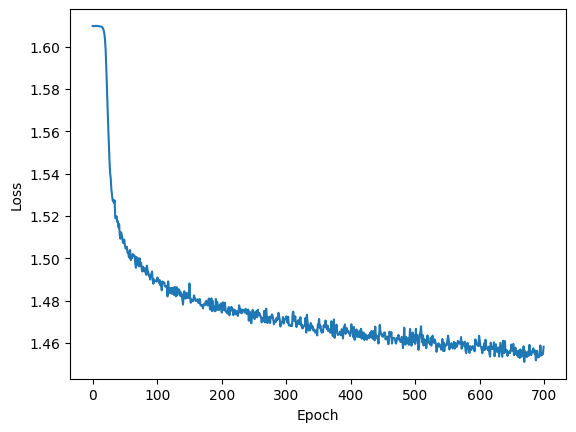

Test accuracy: 477.1316129032258
Accuracy: 0.4146236559139785
Precision: 0.3912119731530339
Recall: 0.4045081400244346
F1-score: 0.36689175666205415


Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.81      0.50       495
           1       0.68      0.74      0.71       472
           2       0.29      0.14      0.19       449
           3       0.30      0.16      0.21       463
           4       0.33      0.17      0.23       446

    accuracy                           0.41      2325
   macro avg       0.39      0.40      0.37      2325
weighted avg       0.39      0.41      0.37      2325

                    0           1           2           3           4  \
precision    0.362319    0.679688    0.285714    0.296443    0.331897   
recall       0.808081    0.737288    0.142539    0.161987    0.172646   
f1-score     0.500313    0.707317    0.190193    0.209497    0.227139   
support    495.000000  472.000000  449.000000

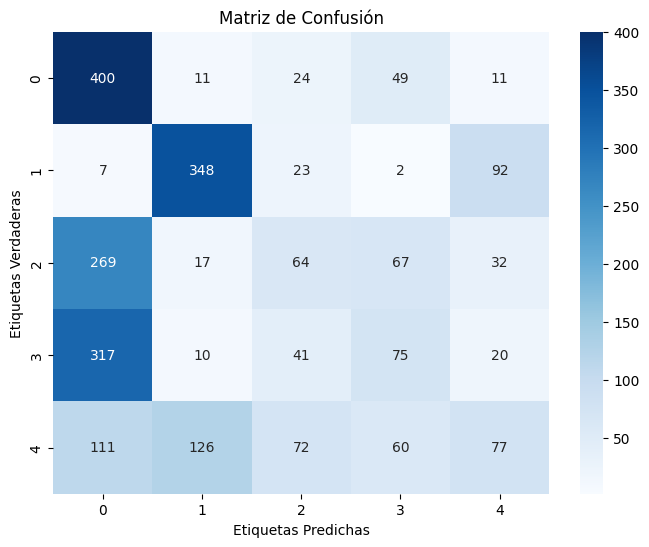

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_1e-05_0.3/resultados_700_1e-05_0.3.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|                                                              | 1/1000 [00:01<28:35,  1.72s/it]

1.6094571155660293


Procesando epocas:   0%|                                                              | 2/1000 [00:03<28:36,  1.72s/it]

1.6094594464582554


Procesando epocas:   0%|▏                                                             | 3/1000 [00:05<28:32,  1.72s/it]

1.6095761628711924


Procesando epocas:   0%|▏                                                             | 4/1000 [00:06<28:33,  1.72s/it]

1.6090772790067336


Procesando epocas:   0%|▎                                                             | 5/1000 [00:08<28:30,  1.72s/it]

1.6077108923126668


Procesando epocas:   1%|▎                                                             | 6/1000 [00:10<28:32,  1.72s/it]

1.6097128068699555


Procesando epocas:   1%|▍                                                             | 7/1000 [00:12<28:28,  1.72s/it]

1.608093427209293


Procesando epocas:   1%|▍                                                             | 8/1000 [00:13<28:23,  1.72s/it]

1.5705300969236038


Procesando epocas:   1%|▌                                                             | 9/1000 [00:15<28:24,  1.72s/it]

1.523621684663436


Procesando epocas:   1%|▌                                                            | 10/1000 [00:17<28:23,  1.72s/it]

1.5161316969815422


Procesando epocas:   1%|▋                                                            | 11/1000 [00:18<28:22,  1.72s/it]

1.507635333257563


Procesando epocas:   1%|▋                                                            | 12/1000 [00:20<28:20,  1.72s/it]

1.511049459962284


Procesando epocas:   1%|▊                                                            | 13/1000 [00:22<28:13,  1.72s/it]

1.5021349275813383


Procesando epocas:   1%|▊                                                            | 14/1000 [00:24<28:01,  1.71s/it]

1.5024400241234723


Procesando epocas:   2%|▉                                                            | 15/1000 [00:25<27:58,  1.70s/it]

1.5033186435699464


Procesando epocas:   2%|▉                                                            | 16/1000 [00:27<27:53,  1.70s/it]

1.4969070413533379


Procesando epocas:   2%|█                                                            | 17/1000 [00:29<27:48,  1.70s/it]

1.5004072806414437


Procesando epocas:   2%|█                                                            | 18/1000 [00:30<27:44,  1.70s/it]

1.4977732069352094


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:32<27:46,  1.70s/it]

1.500573858092813


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:34<27:43,  1.70s/it]

1.5047031500760246


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:35<27:40,  1.70s/it]

1.4943480112973382


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:37<27:39,  1.70s/it]

1.4981861780671513


Procesando epocas:   2%|█▍                                                           | 23/1000 [00:39<27:37,  1.70s/it]

1.4952316887238446


Procesando epocas:   2%|█▍                                                           | 24/1000 [00:40<27:32,  1.69s/it]

1.4942297493710237


Procesando epocas:   2%|█▌                                                           | 25/1000 [00:42<27:28,  1.69s/it]

1.4950018896776087


Procesando epocas:   3%|█▌                                                           | 26/1000 [00:44<27:28,  1.69s/it]

1.4939539748079635


Procesando epocas:   3%|█▋                                                           | 27/1000 [00:46<27:26,  1.69s/it]

1.4907140858033123


Procesando epocas:   3%|█▋                                                           | 28/1000 [00:47<27:22,  1.69s/it]

1.491229401616489


Procesando epocas:   3%|█▊                                                           | 29/1000 [00:49<27:25,  1.69s/it]

1.492319057969486


Procesando epocas:   3%|█▊                                                           | 30/1000 [00:51<27:23,  1.69s/it]

1.4947089258362265


Procesando epocas:   3%|█▉                                                           | 31/1000 [00:52<27:20,  1.69s/it]

1.4920305813060086


Procesando epocas:   3%|█▉                                                           | 32/1000 [00:54<27:19,  1.69s/it]

1.4911848383791306


Procesando epocas:   3%|██                                                           | 33/1000 [00:56<27:17,  1.69s/it]

1.4887431944117826


Procesando epocas:   3%|██                                                           | 34/1000 [00:57<27:15,  1.69s/it]

1.4944170769523173


Procesando epocas:   4%|██▏                                                          | 35/1000 [00:59<27:15,  1.69s/it]

1.4935824639656965


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:01<27:15,  1.70s/it]

1.4885165109353906


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:02<27:12,  1.69s/it]

1.4870837274719686


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:04<27:10,  1.70s/it]

1.4894420189016007


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:06<27:09,  1.70s/it]

1.487461635645698


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:08<27:07,  1.70s/it]

1.496237326369566


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:09<27:04,  1.69s/it]

1.4933804217506856


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:11<27:04,  1.70s/it]

1.4870328223004061


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:13<27:00,  1.69s/it]

1.4867060233564937


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:14<26:57,  1.69s/it]

1.4833149650517632


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:16<26:48,  1.68s/it]

1.4903008685392491


Procesando epocas:   5%|██▊                                                          | 46/1000 [01:18<26:42,  1.68s/it]

1.4864735449061675


Procesando epocas:   5%|██▊                                                          | 47/1000 [01:19<26:39,  1.68s/it]

1.4927183578996097


Procesando epocas:   5%|██▉                                                          | 48/1000 [01:21<26:37,  1.68s/it]

1.4821267513667835


Procesando epocas:   5%|██▉                                                          | 49/1000 [01:23<26:31,  1.67s/it]

1.4875175574246575


Procesando epocas:   5%|███                                                          | 50/1000 [01:24<26:30,  1.67s/it]

1.484326390659108


Procesando epocas:   5%|███                                                          | 51/1000 [01:26<26:26,  1.67s/it]

1.4875973371898428


Procesando epocas:   5%|███▏                                                         | 52/1000 [01:28<26:22,  1.67s/it]

1.4854877324665294


Procesando epocas:   5%|███▏                                                         | 53/1000 [01:29<26:23,  1.67s/it]

1.482853285004111


Procesando epocas:   5%|███▎                                                         | 54/1000 [01:31<26:21,  1.67s/it]

1.485857154341305


Procesando epocas:   6%|███▎                                                         | 55/1000 [01:33<26:19,  1.67s/it]

1.4874687236898085


Procesando epocas:   6%|███▍                                                         | 56/1000 [01:34<26:19,  1.67s/it]

1.4888873808524188


Procesando epocas:   6%|███▍                                                         | 57/1000 [01:36<26:17,  1.67s/it]

1.4777368286076713


Procesando epocas:   6%|███▌                                                         | 58/1000 [01:38<26:15,  1.67s/it]

1.4802984532187966


Procesando epocas:   6%|███▌                                                         | 59/1000 [01:39<26:12,  1.67s/it]

1.4824872367522295


Procesando epocas:   6%|███▋                                                         | 60/1000 [01:41<26:10,  1.67s/it]

1.4807121620458714


Procesando epocas:   6%|███▋                                                         | 61/1000 [01:43<26:10,  1.67s/it]

1.4824799993458917


Procesando epocas:   6%|███▊                                                         | 62/1000 [01:44<26:08,  1.67s/it]

1.4800593123716466


Procesando epocas:   6%|███▊                                                         | 63/1000 [01:46<26:06,  1.67s/it]

1.4824988757862765


Procesando epocas:   6%|███▉                                                         | 64/1000 [01:48<26:04,  1.67s/it]

1.480274230592391


Procesando epocas:   6%|███▉                                                         | 65/1000 [01:49<26:01,  1.67s/it]

1.4773550040581647


Procesando epocas:   7%|████                                                         | 66/1000 [01:51<26:00,  1.67s/it]

1.4786554154227762


Procesando epocas:   7%|████                                                         | 67/1000 [01:53<25:56,  1.67s/it]

1.474610045376946


Procesando epocas:   7%|████▏                                                        | 68/1000 [01:54<25:58,  1.67s/it]

1.4774312250754413


Procesando epocas:   7%|████▏                                                        | 69/1000 [01:56<25:55,  1.67s/it]

1.4784438694224638


Procesando epocas:   7%|████▎                                                        | 70/1000 [01:58<25:52,  1.67s/it]

1.483912742137909


Procesando epocas:   7%|████▎                                                        | 71/1000 [01:59<25:51,  1.67s/it]

1.4843460840337417


Procesando epocas:   7%|████▍                                                        | 72/1000 [02:01<25:47,  1.67s/it]

1.4739407763761632


Procesando epocas:   7%|████▍                                                        | 73/1000 [02:03<25:45,  1.67s/it]

1.477591738981359


Procesando epocas:   7%|████▌                                                        | 74/1000 [02:04<25:46,  1.67s/it]

1.4760057491414686


Procesando epocas:   8%|████▌                                                        | 75/1000 [02:06<25:49,  1.68s/it]

1.476446008682251


Procesando epocas:   8%|████▋                                                        | 76/1000 [02:08<26:02,  1.69s/it]

1.4757906745461857


Procesando epocas:   8%|████▋                                                        | 77/1000 [02:10<26:15,  1.71s/it]

1.4757184673758115


Procesando epocas:   8%|████▊                                                        | 78/1000 [02:11<26:26,  1.72s/it]

1.4753298471955691


Procesando epocas:   8%|████▊                                                        | 79/1000 [02:13<26:33,  1.73s/it]

1.4805302023887634


Procesando epocas:   8%|████▉                                                        | 80/1000 [02:15<26:34,  1.73s/it]

1.4786329830394072


Procesando epocas:   8%|████▉                                                        | 81/1000 [02:17<26:37,  1.74s/it]

1.4730004696285024


Procesando epocas:   8%|█████                                                        | 82/1000 [02:18<26:38,  1.74s/it]

1.4711686302633846


Procesando epocas:   8%|█████                                                        | 83/1000 [02:20<26:36,  1.74s/it]

1.4774782608537114


Procesando epocas:   8%|█████                                                        | 84/1000 [02:22<26:37,  1.74s/it]

1.4782103194909937


Procesando epocas:   8%|█████▏                                                       | 85/1000 [02:24<26:35,  1.74s/it]

1.4742012963575475


Procesando epocas:   9%|█████▏                                                       | 86/1000 [02:25<26:35,  1.75s/it]

1.4813248080365797


Procesando epocas:   9%|█████▎                                                       | 87/1000 [02:27<26:32,  1.74s/it]

1.472243051669177


Procesando epocas:   9%|█████▎                                                       | 88/1000 [02:29<26:30,  1.74s/it]

1.470543385954464


Procesando epocas:   9%|█████▍                                                       | 89/1000 [02:31<26:28,  1.74s/it]

1.4810842871665955


Procesando epocas:   9%|█████▍                                                       | 90/1000 [02:32<26:28,  1.75s/it]

1.4711432267637814


Procesando epocas:   9%|█████▌                                                       | 91/1000 [02:34<26:24,  1.74s/it]

1.4852589319734013


Procesando epocas:   9%|█████▌                                                       | 92/1000 [02:36<26:22,  1.74s/it]

1.4761322575456957


Procesando epocas:   9%|█████▋                                                       | 93/1000 [02:38<26:24,  1.75s/it]

1.4768740163129919


Procesando epocas:   9%|█████▋                                                       | 94/1000 [02:39<26:23,  1.75s/it]

1.4660635232925414


Procesando epocas:  10%|█████▊                                                       | 95/1000 [02:41<26:21,  1.75s/it]

1.48034528353635


Procesando epocas:  10%|█████▊                                                       | 96/1000 [02:43<26:19,  1.75s/it]

1.4735580563545227


Procesando epocas:  10%|█████▉                                                       | 97/1000 [02:45<26:19,  1.75s/it]

1.4697947887813343


Procesando epocas:  10%|█████▉                                                       | 98/1000 [02:46<26:16,  1.75s/it]

1.4691383186508626


Procesando epocas:  10%|██████                                                       | 99/1000 [02:48<26:16,  1.75s/it]

1.4740866240333108


Procesando epocas:  10%|██████                                                      | 100/1000 [02:50<26:16,  1.75s/it]

1.4678583678077248


Procesando epocas:  10%|██████                                                      | 101/1000 [02:52<26:13,  1.75s/it]

1.467347520239213


Procesando epocas:  10%|██████                                                      | 102/1000 [02:53<26:12,  1.75s/it]

1.4745703002985786


Procesando epocas:  10%|██████▏                                                     | 103/1000 [02:55<26:08,  1.75s/it]

1.4658755099072176


Procesando epocas:  10%|██████▏                                                     | 104/1000 [02:57<26:07,  1.75s/it]

1.4696134160546694


Procesando epocas:  10%|██████▎                                                     | 105/1000 [02:59<26:03,  1.75s/it]

1.4667114608428058


Procesando epocas:  11%|██████▎                                                     | 106/1000 [03:00<26:03,  1.75s/it]

1.4681481796152451


Procesando epocas:  11%|██████▍                                                     | 107/1000 [03:02<25:55,  1.74s/it]

1.4666686436709235


Procesando epocas:  11%|██████▍                                                     | 108/1000 [03:04<25:47,  1.74s/it]

1.4644928918165319


Procesando epocas:  11%|██████▌                                                     | 109/1000 [03:05<25:42,  1.73s/it]

1.4669702403685625


Procesando epocas:  11%|██████▌                                                     | 110/1000 [03:07<25:36,  1.73s/it]

1.4687367341097664


Procesando epocas:  11%|██████▋                                                     | 111/1000 [03:09<25:33,  1.72s/it]

1.4660614932284635


Procesando epocas:  11%|██████▋                                                     | 112/1000 [03:11<25:29,  1.72s/it]

1.4691252568188835


Procesando epocas:  11%|██████▊                                                     | 113/1000 [03:12<25:24,  1.72s/it]

1.462624033759622


Procesando epocas:  11%|██████▊                                                     | 114/1000 [03:14<25:22,  1.72s/it]

1.4620852708816527


Procesando epocas:  12%|██████▉                                                     | 115/1000 [03:16<25:18,  1.72s/it]

1.4620634331422693


Procesando epocas:  12%|██████▉                                                     | 116/1000 [03:17<25:15,  1.71s/it]

1.4697587784598856


Procesando epocas:  12%|███████                                                     | 117/1000 [03:19<25:15,  1.72s/it]

1.4659062602940727


Procesando epocas:  12%|███████                                                     | 118/1000 [03:21<25:14,  1.72s/it]

1.465334329885595


Procesando epocas:  12%|███████▏                                                    | 119/1000 [03:23<25:09,  1.71s/it]

1.4646153667393853


Procesando epocas:  12%|███████▏                                                    | 120/1000 [03:24<25:10,  1.72s/it]

1.4661073320052203


Procesando epocas:  12%|███████▎                                                    | 121/1000 [03:26<25:11,  1.72s/it]

1.4654905480497025


Procesando epocas:  12%|███████▎                                                    | 122/1000 [03:28<25:10,  1.72s/it]

1.4630736975108876


Procesando epocas:  12%|███████▍                                                    | 123/1000 [03:30<25:06,  1.72s/it]

1.471231240384719


Procesando epocas:  12%|███████▍                                                    | 124/1000 [03:31<25:05,  1.72s/it]

1.4602351518238292


Procesando epocas:  12%|███████▌                                                    | 125/1000 [03:33<25:04,  1.72s/it]

1.4623678431791418


Procesando epocas:  13%|███████▌                                                    | 126/1000 [03:35<25:01,  1.72s/it]

1.465979839072508


Procesando epocas:  13%|███████▌                                                    | 127/1000 [03:36<24:59,  1.72s/it]

1.4632408794234781


Procesando epocas:  13%|███████▋                                                    | 128/1000 [03:38<24:55,  1.72s/it]

1.4634519387693967


Procesando epocas:  13%|███████▋                                                    | 129/1000 [03:40<24:54,  1.72s/it]

1.4730425147449269


Procesando epocas:  13%|███████▊                                                    | 130/1000 [03:42<24:50,  1.71s/it]

1.4669408545774572


Procesando epocas:  13%|███████▊                                                    | 131/1000 [03:43<24:52,  1.72s/it]

1.46294946530286


Procesando epocas:  13%|███████▉                                                    | 132/1000 [03:45<24:50,  1.72s/it]

1.4668875834521125


Procesando epocas:  13%|███████▉                                                    | 133/1000 [03:47<24:48,  1.72s/it]

1.4572708585683036


Procesando epocas:  13%|████████                                                    | 134/1000 [03:48<24:45,  1.72s/it]

1.459123017507441


Procesando epocas:  14%|████████                                                    | 135/1000 [03:50<24:41,  1.71s/it]

1.4634492726886974


Procesando epocas:  14%|████████▏                                                   | 136/1000 [03:52<24:36,  1.71s/it]

1.4598689920762007


Procesando epocas:  14%|████████▏                                                   | 137/1000 [03:53<24:32,  1.71s/it]

1.4566311878316542


Procesando epocas:  14%|████████▎                                                   | 138/1000 [03:55<24:27,  1.70s/it]

1.4574839507832247


Procesando epocas:  14%|████████▎                                                   | 139/1000 [03:57<24:23,  1.70s/it]

1.464112602963167


Procesando epocas:  14%|████████▍                                                   | 140/1000 [03:59<24:20,  1.70s/it]

1.455752383260166


Procesando epocas:  14%|████████▍                                                   | 141/1000 [04:00<24:17,  1.70s/it]

1.4722211403005263


Procesando epocas:  14%|████████▌                                                   | 142/1000 [04:02<24:08,  1.69s/it]

1.454050173478968


Procesando epocas:  14%|████████▌                                                   | 143/1000 [04:04<23:58,  1.68s/it]

1.4579697118085972


Procesando epocas:  14%|████████▋                                                   | 144/1000 [04:05<23:51,  1.67s/it]

1.4591170682626613


Procesando epocas:  14%|████████▋                                                   | 145/1000 [04:07<23:46,  1.67s/it]

1.456999976494733


Procesando epocas:  15%|████████▊                                                   | 146/1000 [04:09<23:41,  1.66s/it]

1.4575395780451157


Procesando epocas:  15%|████████▊                                                   | 147/1000 [04:10<23:41,  1.67s/it]

1.4624047076000888


Procesando epocas:  15%|████████▉                                                   | 148/1000 [04:12<23:34,  1.66s/it]

1.4546074481571423


Procesando epocas:  15%|████████▉                                                   | 149/1000 [04:14<23:31,  1.66s/it]

1.4512498582110684


Procesando epocas:  15%|█████████                                                   | 150/1000 [04:15<23:30,  1.66s/it]

1.4546072553185856


Procesando epocas:  15%|█████████                                                   | 151/1000 [04:17<23:26,  1.66s/it]

1.4554283934481003


Procesando epocas:  15%|█████████                                                   | 152/1000 [04:18<23:22,  1.65s/it]

1.453987467288971


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [04:20<23:23,  1.66s/it]

1.4523194362135494


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [04:22<23:21,  1.66s/it]

1.450678539977354


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [04:23<23:20,  1.66s/it]

1.4509748760391683


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [04:25<23:16,  1.66s/it]

1.4512535978766048


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [04:27<23:15,  1.66s/it]

1.4509073825443493


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [04:28<23:21,  1.66s/it]

1.463248884677887


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [04:30<23:17,  1.66s/it]

1.4549375772476196


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [04:32<23:16,  1.66s/it]

1.4481895096161785


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [04:33<23:13,  1.66s/it]

1.451908680971931


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [04:35<23:10,  1.66s/it]

1.4603404977742362


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [04:37<23:04,  1.65s/it]

1.4522570736267988


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [04:38<23:04,  1.66s/it]

1.4498503839268404


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [04:40<22:58,  1.65s/it]

1.4532115536577561


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [04:42<22:53,  1.65s/it]

1.4545195151777828


Procesando epocas:  17%|██████████                                                  | 167/1000 [04:43<22:50,  1.64s/it]

1.454738351877998


Procesando epocas:  17%|██████████                                                  | 168/1000 [04:45<22:49,  1.65s/it]

1.4518898045315463


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [04:47<22:48,  1.65s/it]

1.446328841938692


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [04:48<22:47,  1.65s/it]

1.4557308449464685


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [04:50<22:41,  1.64s/it]

1.44879090014626


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [04:52<22:40,  1.64s/it]

1.448060173848096


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [04:53<22:34,  1.64s/it]

1.448315156207365


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [04:55<22:33,  1.64s/it]

1.4526223743663114


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [04:56<22:32,  1.64s/it]

1.450877625801984


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [04:58<22:29,  1.64s/it]

1.4482161080136018


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [05:00<22:27,  1.64s/it]

1.4521449327468872


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [05:01<22:27,  1.64s/it]

1.4552936042056364


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [05:03<22:24,  1.64s/it]

1.450752116652096


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [05:05<22:21,  1.64s/it]

1.4528635340578415


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [05:06<22:21,  1.64s/it]

1.454374086155611


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [05:08<22:18,  1.64s/it]

1.450613076546613


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [05:10<22:16,  1.64s/it]

1.4504637991680818


Procesando epocas:  18%|███████████                                                 | 184/1000 [05:11<22:18,  1.64s/it]

1.4474658776732052


Procesando epocas:  18%|███████████                                                 | 185/1000 [05:13<22:15,  1.64s/it]

1.4558351411538966


Procesando epocas:  19%|███████████▏                                                | 186/1000 [05:14<22:13,  1.64s/it]

1.4564811706542968


Procesando epocas:  19%|███████████▏                                                | 187/1000 [05:16<22:15,  1.64s/it]

1.4518611199715559


Procesando epocas:  19%|███████████▎                                                | 188/1000 [05:18<22:12,  1.64s/it]

1.4519141547820147


Procesando epocas:  19%|███████████▎                                                | 189/1000 [05:19<22:15,  1.65s/it]

1.4497630189446842


Procesando epocas:  19%|███████████▍                                                | 190/1000 [05:21<22:11,  1.64s/it]

1.44770629826714


Procesando epocas:  19%|███████████▍                                                | 191/1000 [05:23<22:07,  1.64s/it]

1.4511180611217722


Procesando epocas:  19%|███████████▌                                                | 192/1000 [05:24<22:08,  1.64s/it]

1.4483164766255547


Procesando epocas:  19%|███████████▌                                                | 193/1000 [05:26<22:08,  1.65s/it]

1.4469266337506912


Procesando epocas:  19%|███████████▋                                                | 194/1000 [05:28<22:15,  1.66s/it]

1.4464028617914986


Procesando epocas:  20%|███████████▋                                                | 195/1000 [05:29<22:18,  1.66s/it]

1.4552528605741613


Procesando epocas:  20%|███████████▊                                                | 196/1000 [05:31<22:19,  1.67s/it]

1.444391826321097


Procesando epocas:  20%|███████████▊                                                | 197/1000 [05:33<22:24,  1.67s/it]

1.4483137200860416


Procesando epocas:  20%|███████████▉                                                | 198/1000 [05:34<22:42,  1.70s/it]

1.4469337954240686


Procesando epocas:  20%|███████████▉                                                | 199/1000 [05:36<22:53,  1.71s/it]

1.4496798087568845


Procesando epocas:  20%|████████████                                                | 200/1000 [05:38<23:02,  1.73s/it]

1.4505898103994481


Procesando epocas:  20%|████████████                                                | 201/1000 [05:40<23:07,  1.74s/it]

1.448383239437552


Procesando epocas:  20%|████████████                                                | 202/1000 [05:41<23:09,  1.74s/it]

1.4482540979104883


Procesando epocas:  20%|████████████▏                                               | 203/1000 [05:43<23:12,  1.75s/it]

1.4450417946366703


Procesando epocas:  20%|████████████▏                                               | 204/1000 [05:45<23:09,  1.75s/it]

1.4427076515029458


Procesando epocas:  20%|████████████▎                                               | 205/1000 [05:47<23:10,  1.75s/it]

1.4460216858807733


Procesando epocas:  21%|████████████▎                                               | 206/1000 [05:49<23:11,  1.75s/it]

1.4484663949293248


Procesando epocas:  21%|████████████▍                                               | 207/1000 [05:50<23:12,  1.76s/it]

1.449241938310511


Procesando epocas:  21%|████████████▍                                               | 208/1000 [05:52<23:09,  1.75s/it]

1.4547531773062314


Procesando epocas:  21%|████████████▌                                               | 209/1000 [05:54<23:07,  1.75s/it]

1.4534656910335317


Procesando epocas:  21%|████████████▌                                               | 210/1000 [05:56<23:05,  1.75s/it]

1.4453344800892998


Procesando epocas:  21%|████████████▋                                               | 211/1000 [05:57<23:04,  1.75s/it]

1.4443469061571008


Procesando epocas:  21%|████████████▋                                               | 212/1000 [05:59<23:04,  1.76s/it]

1.4421156020725474


Procesando epocas:  21%|████████████▊                                               | 213/1000 [06:01<23:02,  1.76s/it]

1.4470532592605143


Procesando epocas:  21%|████████████▊                                               | 214/1000 [06:03<23:02,  1.76s/it]

1.451260251858655


Procesando epocas:  22%|████████████▉                                               | 215/1000 [06:04<22:59,  1.76s/it]

1.4495351959677303


Procesando epocas:  22%|████████████▉                                               | 216/1000 [06:06<22:58,  1.76s/it]

1.4466840316267575


Procesando epocas:  22%|█████████████                                               | 217/1000 [06:08<22:56,  1.76s/it]

1.440256740766413


Procesando epocas:  22%|█████████████                                               | 218/1000 [06:10<22:53,  1.76s/it]

1.4420042626998004


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [06:11<22:52,  1.76s/it]

1.449959275301765


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [06:13<22:48,  1.76s/it]

1.444745121983921


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [06:15<22:49,  1.76s/it]

1.4441337269895218


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [06:17<22:45,  1.76s/it]

1.4426737659117754


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [06:18<22:43,  1.76s/it]

1.4443181858343237


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [06:20<22:42,  1.76s/it]

1.449220561981201


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [06:22<22:41,  1.76s/it]

1.4444018328891082


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [06:24<22:40,  1.76s/it]

1.446996808052063


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [06:25<22:40,  1.76s/it]

1.4449818968772887


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [06:27<22:38,  1.76s/it]

1.4536705613136292


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [06:29<22:26,  1.75s/it]

1.446313238845152


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [06:31<22:19,  1.74s/it]

1.4473122379359078


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [06:32<22:13,  1.73s/it]

1.445569114825305


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [06:34<22:07,  1.73s/it]

1.4490051732343785


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [06:36<22:02,  1.72s/it]

1.4442033276838415


Procesando epocas:  23%|██████████████                                              | 234/1000 [06:37<21:58,  1.72s/it]

1.4431493506712072


Procesando epocas:  24%|██████████████                                              | 235/1000 [06:39<21:53,  1.72s/it]

1.4463255805127762


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [06:41<21:48,  1.71s/it]

1.4448885973762065


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [06:43<21:48,  1.72s/it]

1.4421491805244895


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [06:44<21:47,  1.72s/it]

1.4519628349472495


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [06:46<21:42,  1.71s/it]

1.449859199103187


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [06:48<21:41,  1.71s/it]

1.4386216850841747


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [06:49<21:38,  1.71s/it]

1.4576647765496198


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [06:51<21:36,  1.71s/it]

1.4458225692019744


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [06:53<21:33,  1.71s/it]

1.4410241056891049


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [06:55<21:33,  1.71s/it]

1.4466561072012958


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [06:56<21:33,  1.71s/it]

1.4408113297294167


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [06:58<21:29,  1.71s/it]

1.4431414330706878


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [07:00<21:24,  1.71s/it]

1.4441500495461856


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [07:01<21:24,  1.71s/it]

1.446625042662901


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [07:03<21:21,  1.71s/it]

1.4504172844045302


Procesando epocas:  25%|███████████████                                             | 250/1000 [07:05<21:17,  1.70s/it]

1.4443485975265502


Procesando epocas:  25%|███████████████                                             | 251/1000 [07:07<21:15,  1.70s/it]

1.4423619698075687


Procesando epocas:  25%|███████████████                                             | 252/1000 [07:08<21:16,  1.71s/it]

1.4461192341411815


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [07:10<21:15,  1.71s/it]

1.4458756432813757


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [07:12<21:12,  1.71s/it]

1.4428303676493028


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [07:13<21:11,  1.71s/it]

1.4488314558477964


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [07:15<21:10,  1.71s/it]

1.4478612906792585


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [07:17<21:02,  1.70s/it]

1.4484673787565792


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [07:18<20:55,  1.69s/it]

1.4459767327589148


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [07:20<20:52,  1.69s/it]

1.4433696164804346


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [07:22<20:50,  1.69s/it]

1.4398035491214078


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [07:23<20:48,  1.69s/it]

1.4405427203458898


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [07:25<20:51,  1.70s/it]

1.448976438185748


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [07:27<20:45,  1.69s/it]

1.4465715527534484


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [07:29<20:40,  1.69s/it]

1.4463737838408526


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [07:30<20:38,  1.68s/it]

1.4446983134045321


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [07:32<20:33,  1.68s/it]

1.4422660855685963


Procesando epocas:  27%|████████████████                                            | 267/1000 [07:34<20:30,  1.68s/it]

1.4399050361969892


Procesando epocas:  27%|████████████████                                            | 268/1000 [07:35<20:27,  1.68s/it]

1.443597571288838


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [07:37<20:26,  1.68s/it]

1.454840715492473


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [07:39<20:26,  1.68s/it]

1.4424095574547262


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [07:40<20:27,  1.68s/it]

1.4479590752545526


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [07:42<20:24,  1.68s/it]

1.43777037858963


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [07:44<20:22,  1.68s/it]

1.4407166670350466


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [07:45<20:21,  1.68s/it]

1.4398564892656662


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [07:47<20:21,  1.68s/it]

1.440417956604677


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [07:49<20:20,  1.69s/it]

1.4428358891431023


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [07:50<20:17,  1.68s/it]

1.4386725068092345


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [07:52<20:14,  1.68s/it]

1.4455873075653525


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [07:54<20:11,  1.68s/it]

1.4394376362071317


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [07:55<20:13,  1.69s/it]

1.4411721615230335


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [07:57<20:10,  1.68s/it]

1.4408339177860934


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [07:59<20:07,  1.68s/it]

1.4430129219503964


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [08:00<20:04,  1.68s/it]

1.4407668176819297


Procesando epocas:  28%|█████████████████                                           | 284/1000 [08:02<20:04,  1.68s/it]

1.4479284188326667


Procesando epocas:  28%|█████████████████                                           | 285/1000 [08:04<20:02,  1.68s/it]

1.4433525008313797


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [08:06<20:01,  1.68s/it]

1.4450146787306841


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [08:07<19:59,  1.68s/it]

1.4399931669235229


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [08:09<19:58,  1.68s/it]

1.4441681946025176


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [08:11<19:54,  1.68s/it]

1.4471290602403528


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [08:12<19:54,  1.68s/it]

1.4418956574271706


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [08:14<19:52,  1.68s/it]

1.4443504045991336


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [08:16<19:51,  1.68s/it]

1.439103620192584


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [08:17<19:51,  1.69s/it]

1.448550607176388


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [08:19<19:50,  1.69s/it]

1.4361223599489998


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [08:21<19:50,  1.69s/it]

1.4410834480734434


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [08:22<19:50,  1.69s/it]

1.437894814154681


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [08:24<19:47,  1.69s/it]

1.4488040194791907


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [08:26<19:45,  1.69s/it]

1.4360193441895877


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [08:27<19:45,  1.69s/it]

1.4381933170206407


Procesando epocas:  30%|██████████████████                                          | 300/1000 [08:29<19:41,  1.69s/it]

1.4383482400108787


Procesando epocas:  30%|██████████████████                                          | 301/1000 [08:31<19:40,  1.69s/it]

1.4523429225472844


Procesando epocas:  30%|██████████████████                                          | 302/1000 [08:33<19:39,  1.69s/it]

1.438655369422015


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [08:34<19:36,  1.69s/it]

1.4379813432693482


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [08:36<19:37,  1.69s/it]

1.4336830258369446


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [08:38<19:34,  1.69s/it]

1.4386681346332326


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [08:39<19:33,  1.69s/it]

1.4385279213680942


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [08:41<19:32,  1.69s/it]

1.4483631421537961


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [08:43<19:27,  1.69s/it]

1.4453902819577384


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [08:44<19:26,  1.69s/it]

1.4373465986812817


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [08:46<19:23,  1.69s/it]

1.4423792628680958


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [08:48<19:21,  1.69s/it]

1.4410229037789737


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [08:49<19:18,  1.68s/it]

1.4358663103159737


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [08:51<19:17,  1.68s/it]

1.4415151413749245


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [08:53<19:18,  1.69s/it]

1.4369356933762045


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [08:54<19:16,  1.69s/it]

1.4441040291505702


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [08:56<19:14,  1.69s/it]

1.4417290379019345


Procesando epocas:  32%|███████████████████                                         | 317/1000 [08:58<19:13,  1.69s/it]

1.439909998108359


Procesando epocas:  32%|███████████████████                                         | 318/1000 [09:00<19:11,  1.69s/it]

1.4372952201787164


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [09:01<19:10,  1.69s/it]

1.4425357916775872


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [09:03<19:16,  1.70s/it]

1.439357524058398


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [09:05<19:24,  1.71s/it]

1.4354659858871908


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [09:06<19:30,  1.73s/it]

1.442184547817006


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [09:08<19:34,  1.73s/it]

1.4448308257495657


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [09:10<19:36,  1.74s/it]

1.4406830135513755


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [09:12<19:37,  1.74s/it]

1.4404471109895145


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [09:13<19:36,  1.75s/it]

1.4411486499449786


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [09:15<19:35,  1.75s/it]

1.4395065482924967


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [09:17<19:37,  1.75s/it]

1.4379585820085863


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [09:19<19:35,  1.75s/it]

1.4410872073734509


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [09:20<19:33,  1.75s/it]

1.436677786883186


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [09:22<19:30,  1.75s/it]

1.433931241315954


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [09:24<19:30,  1.75s/it]

1.435970481003032


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [09:26<19:29,  1.75s/it]

1.439079110061421


Procesando epocas:  33%|████████████████████                                        | 334/1000 [09:27<19:27,  1.75s/it]

1.4422335182919221


Procesando epocas:  34%|████████████████████                                        | 335/1000 [09:29<19:25,  1.75s/it]

1.4503770141040577


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [09:31<19:25,  1.75s/it]

1.438836011465858


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [09:33<19:20,  1.75s/it]

1.4366348533069386


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [09:34<19:13,  1.74s/it]

1.4416821844437544


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [09:36<19:10,  1.74s/it]

1.4360605450237498


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [09:38<19:04,  1.73s/it]

1.4384627300150254


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [09:40<19:00,  1.73s/it]

1.43902388530619


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [09:41<18:57,  1.73s/it]

1.4348156192723442


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [09:43<18:54,  1.73s/it]

1.4378037957584158


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [09:45<18:51,  1.73s/it]

1.4370547266567455


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [09:47<18:48,  1.72s/it]

1.4393606683787177


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [09:48<18:45,  1.72s/it]

1.4387203391860512


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [09:50<18:44,  1.72s/it]

1.4415042414384729


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [09:52<18:44,  1.73s/it]

1.441835141883177


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [09:53<18:43,  1.73s/it]

1.4356384845340953


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [09:55<18:38,  1.72s/it]

1.4365615739541895


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [09:57<18:32,  1.71s/it]

1.4376970115829917


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [09:59<18:26,  1.71s/it]

1.437843815018149


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [10:00<18:21,  1.70s/it]

1.4408489858402926


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [10:02<18:15,  1.70s/it]

1.435974255730124


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [10:04<18:10,  1.69s/it]

1.436856496334076


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [10:05<18:07,  1.69s/it]

1.4429234441588907


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [10:07<18:05,  1.69s/it]

1.4343934283537023


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [10:09<18:03,  1.69s/it]

1.4371384066693924


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [10:10<18:00,  1.69s/it]

1.4341979174052968


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [10:12<17:58,  1.68s/it]

1.4414302825927734


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [10:14<18:00,  1.69s/it]

1.4301683594198789


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [10:15<17:58,  1.69s/it]

1.4324790232321796


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [10:17<17:57,  1.69s/it]

1.432262292329003


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [10:19<17:53,  1.69s/it]

1.435377501038944


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [10:20<17:54,  1.69s/it]

1.436750017895418


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [10:22<17:53,  1.69s/it]

1.4384118402705472


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [10:24<17:52,  1.69s/it]

1.441146018224604


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [10:26<17:48,  1.69s/it]

1.442103916757247


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [10:27<17:46,  1.69s/it]

1.4282625436782836


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [10:29<17:45,  1.69s/it]

1.4386651536997628


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [10:31<17:43,  1.69s/it]

1.437596455742331


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [10:32<17:42,  1.69s/it]

1.4359955079415265


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [10:34<17:40,  1.69s/it]

1.4368581351111918


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [10:36<17:37,  1.69s/it]

1.4365858421606177


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [10:37<17:37,  1.69s/it]

1.4342983000418719


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [10:39<17:34,  1.69s/it]

1.4409097643459545


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [10:41<17:32,  1.69s/it]

1.438125430836397


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [10:42<17:31,  1.69s/it]

1.440887048665215


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [10:44<17:23,  1.68s/it]

1.4414630307870753


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [10:46<17:17,  1.67s/it]

1.4296776189523586


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [10:47<17:12,  1.67s/it]

1.4323394088184132


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [10:49<17:08,  1.66s/it]

1.43220375215306


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [10:51<17:08,  1.67s/it]

1.4322397000649396


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [10:52<17:06,  1.67s/it]

1.4364731367896586


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [10:54<17:03,  1.66s/it]

1.4344660632750568


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [10:56<17:00,  1.66s/it]

1.4327737135045668


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [10:57<16:58,  1.66s/it]

1.4354437000611249


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [10:59<16:59,  1.67s/it]

1.436402927426731


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [11:01<17:04,  1.68s/it]

1.4313976694555843


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [11:02<17:04,  1.68s/it]

1.4382926548228545


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [11:04<17:05,  1.68s/it]

1.4370101774440092


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [11:06<17:04,  1.69s/it]

1.4347503031001372


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [11:08<17:03,  1.69s/it]

1.435784051698797


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [11:09<17:04,  1.69s/it]

1.4377791664179633


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [11:11<17:02,  1.69s/it]

1.4341988297069774


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [11:13<17:00,  1.69s/it]

1.4327057656119853


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [11:14<17:00,  1.69s/it]

1.429222803957322


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [11:16<16:58,  1.69s/it]

1.4266480761415818


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [11:18<16:57,  1.69s/it]

1.4394716178669649


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [11:19<16:55,  1.69s/it]

1.4370972058352303


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [11:21<16:53,  1.69s/it]

1.4385018453878515


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [11:23<16:51,  1.69s/it]

1.4411676350761862


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [11:24<16:49,  1.69s/it]

1.436257370780496


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [11:26<16:48,  1.69s/it]

1.432170764838948


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [11:28<16:47,  1.69s/it]

1.43793083709829


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [11:30<16:47,  1.70s/it]

1.4368921406128827


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [11:31<16:44,  1.69s/it]

1.4379615951986875


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [11:33<16:43,  1.70s/it]

1.4371148831704084


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [11:35<16:41,  1.69s/it]

1.4351940435521744


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [11:36<16:40,  1.70s/it]

1.4412034483516918


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [11:38<16:35,  1.69s/it]

1.4328704763861264


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [11:40<16:32,  1.69s/it]

1.4339894589255837


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [11:41<16:29,  1.69s/it]

1.432074321718777


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [11:43<16:26,  1.68s/it]

1.440315355272854


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [11:45<16:25,  1.68s/it]

1.4372161304249482


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [11:46<16:22,  1.68s/it]

1.429027631703545


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [11:48<16:20,  1.68s/it]

1.4305518374723547


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [11:50<16:20,  1.68s/it]

1.4377279421862434


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [11:51<16:17,  1.68s/it]

1.4275446947883157


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [11:53<16:15,  1.68s/it]

1.4425593151765712


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [11:55<16:14,  1.68s/it]

1.431229488288655


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [11:57<16:14,  1.69s/it]

1.4341430039966807


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [11:58<16:11,  1.68s/it]

1.4322921942262088


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [12:00<16:09,  1.68s/it]

1.4314935901585748


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [12:02<16:07,  1.68s/it]

1.4391575476702523


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [12:05<20:08,  2.11s/it]

1.4365614330067353


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [12:06<18:54,  1.98s/it]

1.4339188631843118


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [12:08<18:03,  1.89s/it]

1.429689652779523


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [12:10<17:24,  1.83s/it]

1.4295435014893028


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [12:11<16:58,  1.79s/it]

1.443311838542714


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [12:13<16:38,  1.75s/it]

1.4314878582954407


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [12:15<16:24,  1.73s/it]

1.436850936973796


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [12:16<16:13,  1.72s/it]

1.4322358783553628


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [12:18<16:03,  1.70s/it]

1.4316195978837856


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [12:20<15:55,  1.69s/it]

1.438945989749011


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [12:21<15:49,  1.68s/it]

1.435841093343847


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [12:23<15:44,  1.68s/it]

1.4269717328688678


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [12:25<15:42,  1.68s/it]

1.4326573729515075


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [12:26<15:39,  1.68s/it]

1.4425551351378947


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [12:28<15:38,  1.68s/it]

1.431901918439304


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [12:30<15:35,  1.67s/it]

1.4343255814384013


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [12:32<15:43,  1.69s/it]

1.4384905148954952


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [12:33<15:51,  1.71s/it]

1.432770452078651


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [12:35<15:57,  1.72s/it]

1.4313886810751522


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [12:37<16:02,  1.73s/it]

1.4386544269673964


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [12:39<16:00,  1.73s/it]

1.4423086734379038


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [12:40<16:02,  1.74s/it]

1.4287850183599136


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [12:42<16:01,  1.74s/it]

1.428769045717576


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [12:44<16:01,  1.75s/it]

1.430662434241351


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [12:46<16:02,  1.75s/it]

1.431651886771707


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [12:47<15:59,  1.75s/it]

1.44142785913804


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [12:49<15:56,  1.74s/it]

1.4321968702708974


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [12:51<15:55,  1.75s/it]

1.4438393536735983


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [12:53<15:54,  1.75s/it]

1.433937266994925


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [12:54<15:50,  1.74s/it]

1.437246640990762


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [12:56<15:48,  1.74s/it]

1.4286217780674204


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [12:58<15:47,  1.75s/it]

1.4315308662021862


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [12:59<15:46,  1.75s/it]

1.433982215909397


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [13:01<15:44,  1.75s/it]

1.4332748847849228


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [13:03<15:41,  1.74s/it]

1.432911320994882


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [13:05<15:39,  1.74s/it]

1.431492885421304


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [13:06<15:38,  1.74s/it]

1.4292823279605191


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [13:08<15:37,  1.75s/it]

1.430037278988782


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [13:10<15:34,  1.74s/it]

1.4306787476820104


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [13:12<15:32,  1.74s/it]

1.4312647482928107


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [13:13<15:31,  1.74s/it]

1.4370031777550192


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [13:15<15:29,  1.74s/it]

1.4333893123795005


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [13:17<15:28,  1.75s/it]

1.431368887424469


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [13:19<15:26,  1.75s/it]

1.4313780118437374


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [13:20<15:23,  1.74s/it]

1.4278764864977669


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [13:22<15:24,  1.75s/it]

1.4322882455938002


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [13:24<15:24,  1.75s/it]

1.429248016722062


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [13:26<15:19,  1.74s/it]

1.4288716204026166


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [13:27<15:12,  1.73s/it]

1.4282890579279732


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [13:29<15:05,  1.73s/it]

1.4278507520170773


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [13:31<15:01,  1.72s/it]

1.4319341329967274


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [13:33<14:57,  1.72s/it]

1.4312245635425342


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [13:34<14:54,  1.71s/it]

1.4306008836802315


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [13:36<14:53,  1.71s/it]

1.4288700657732347


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [13:38<14:52,  1.72s/it]

1.4306802076451919


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [13:39<14:47,  1.71s/it]

1.4313133351943073


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [13:41<14:44,  1.71s/it]

1.4324645421084237


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [13:43<14:44,  1.71s/it]

1.4312793745714076


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [13:44<14:44,  1.71s/it]

1.4312944783883936


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [13:46<14:42,  1.71s/it]

1.4323728912016924


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [13:48<14:40,  1.71s/it]

1.428410700489493


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [13:50<14:40,  1.72s/it]

1.435259978911456


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [13:51<14:39,  1.72s/it]

1.432764720916748


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [13:53<14:37,  1.72s/it]

1.4289652319515453


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [13:55<14:36,  1.72s/it]

1.4269822688663707


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [13:57<14:33,  1.72s/it]

1.4328337388880112


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [13:58<14:32,  1.72s/it]

1.4287388731451596


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [14:00<14:31,  1.72s/it]

1.4345888074706583


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [14:02<14:30,  1.72s/it]

1.426316932369681


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [14:03<14:28,  1.72s/it]

1.4319985172327827


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [14:05<14:25,  1.72s/it]

1.4301909250371596


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [14:07<14:24,  1.72s/it]

1.4339774734833661


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [14:09<14:23,  1.72s/it]

1.4282378785750445


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [14:10<14:20,  1.72s/it]

1.4334533095359803


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [14:12<14:19,  1.72s/it]

1.4297285402522368


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [14:14<14:16,  1.72s/it]

1.42815039508483


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [14:15<14:11,  1.71s/it]

1.4281030795153449


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [14:17<14:07,  1.70s/it]

1.4278621140648338


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [14:19<14:04,  1.70s/it]

1.4270521241075853


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [14:20<14:03,  1.70s/it]

1.4278516369707444


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [14:22<14:00,  1.70s/it]

1.431765585085925


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [14:24<13:58,  1.70s/it]

1.434148694487179


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [14:26<13:55,  1.70s/it]

1.428992192885455


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [14:27<13:52,  1.70s/it]

1.4370848845033084


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [14:29<13:51,  1.70s/it]

1.4267527867765988


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [14:31<13:50,  1.70s/it]

1.4302682750365314


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [14:32<13:48,  1.70s/it]

1.426870815894183


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [14:34<13:47,  1.70s/it]

1.4305775298791774


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [14:36<13:44,  1.70s/it]

1.4274737989201265


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [14:37<13:42,  1.70s/it]

1.4232267590130077


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [14:39<13:40,  1.69s/it]

1.4323551556643317


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [14:41<13:37,  1.69s/it]

1.4258173542864183


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [14:43<13:35,  1.69s/it]

1.429303765296936


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [14:44<13:33,  1.69s/it]

1.4273920809521394


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [14:46<13:31,  1.69s/it]

1.427841586926404


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [14:48<13:30,  1.69s/it]

1.4283129979582394


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [14:49<13:27,  1.69s/it]

1.4331346013966728


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [14:51<13:27,  1.69s/it]

1.4259864126934725


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [14:53<13:25,  1.69s/it]

1.4303578587139354


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [14:54<13:24,  1.69s/it]

1.43238285148845


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [14:56<13:23,  1.70s/it]

1.4295976133907542


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [14:58<13:21,  1.69s/it]

1.4274304754593794


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [14:59<13:19,  1.69s/it]

1.430564656678368


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [15:01<13:17,  1.69s/it]

1.425682447938358


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [15:03<13:17,  1.70s/it]

1.4281854573418111


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [15:05<13:12,  1.69s/it]

1.4236275420469395


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [15:06<13:05,  1.68s/it]

1.4320721619269428


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [15:08<12:59,  1.67s/it]

1.4270830140394324


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [15:09<12:53,  1.66s/it]

1.4260720568544725


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [15:11<12:47,  1.65s/it]

1.4256500706953161


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [15:13<12:44,  1.65s/it]

1.4264460304204156


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [15:14<12:42,  1.65s/it]

1.4315054213299472


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [15:16<12:40,  1.65s/it]

1.4265445905573229


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [15:18<12:37,  1.64s/it]

1.4363875929047079


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [15:19<12:36,  1.64s/it]

1.424805742151597


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [15:21<12:34,  1.64s/it]

1.44022673999562


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [15:23<12:32,  1.64s/it]

1.422715912846958


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [15:24<12:30,  1.64s/it]

1.424508390005897


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [15:26<12:29,  1.64s/it]

1.4295946520917555


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [15:27<12:26,  1.64s/it]

1.4274169844739577


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [15:29<12:23,  1.64s/it]

1.425968306204852


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [15:31<12:23,  1.64s/it]

1.4308242496322183


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [15:32<12:21,  1.64s/it]

1.4300909449072445


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [15:34<12:19,  1.64s/it]

1.4334822002579184


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [15:36<12:17,  1.64s/it]

1.4245851614895988


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [15:37<12:14,  1.64s/it]

1.4267962350564845


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [15:39<12:13,  1.64s/it]

1.4253546223920934


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [15:41<12:13,  1.64s/it]

1.4283030713305753


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [15:42<12:11,  1.64s/it]

1.4208819178973928


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [15:44<12:08,  1.64s/it]

1.42704556128558


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [15:46<12:07,  1.64s/it]

1.4280034556108363


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [15:47<12:07,  1.64s/it]

1.4319464206695556


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [15:49<12:05,  1.64s/it]

1.4301501077764174


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [15:50<12:04,  1.64s/it]

1.4270150717566996


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [15:52<12:03,  1.64s/it]

1.428264637554393


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [15:54<12:02,  1.64s/it]

1.428381236861734


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [15:55<11:58,  1.64s/it]

1.4261368478045744


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [15:57<11:57,  1.64s/it]

1.4250096615623025


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [15:59<12:02,  1.66s/it]

1.4258508366696976


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [16:00<12:10,  1.68s/it]

1.4297814719817217


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [16:02<12:15,  1.70s/it]

1.4282231457093182


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [16:04<12:16,  1.70s/it]

1.4274847135824316


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [16:06<12:17,  1.71s/it]

1.4268088305697721


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [16:07<12:19,  1.72s/it]

1.423752553322736


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [16:09<12:18,  1.72s/it]

1.4278952773879556


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [16:11<12:18,  1.72s/it]

1.4257007830283221


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [16:13<12:16,  1.72s/it]

1.4239947844954097


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [16:14<12:15,  1.72s/it]

1.4250038953388438


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [16:16<12:12,  1.72s/it]

1.4231326362665961


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [16:18<12:11,  1.72s/it]

1.425040944183574


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [16:19<12:12,  1.73s/it]

1.4289480062092053


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [16:21<12:10,  1.73s/it]

1.4236338138580322


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [16:23<12:07,  1.72s/it]

1.4234921883134282


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [16:25<12:05,  1.72s/it]

1.4274166787371916


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [16:26<12:04,  1.73s/it]

1.4219327863524942


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [16:28<12:00,  1.72s/it]

1.4305515997550067


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [16:30<12:02,  1.73s/it]

1.422417420499465


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [16:32<12:05,  1.74s/it]

1.424611423997318


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [16:33<12:05,  1.74s/it]

1.4235435696209178


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [16:35<12:04,  1.75s/it]

1.427377242901746


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [16:37<12:03,  1.75s/it]

1.423567527181962


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [16:39<12:03,  1.75s/it]

1.4316899201449227


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [16:40<12:02,  1.75s/it]

1.4233020340695102


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [16:42<12:01,  1.76s/it]

1.4306239843368531


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [16:44<11:58,  1.75s/it]

1.4224924809792463


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [16:46<11:57,  1.75s/it]

1.4255773130585165


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [16:47<11:55,  1.75s/it]

1.4306445640676162


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [16:49<11:55,  1.76s/it]

1.439228923881755


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [16:51<11:53,  1.76s/it]

1.424031931512496


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [16:53<11:48,  1.75s/it]

1.4293388703290153


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [16:54<11:42,  1.74s/it]

1.4258816936436822


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [16:56<11:39,  1.73s/it]

1.4254705898901996


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [16:58<11:35,  1.73s/it]

1.4220955778570736


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [16:59<11:31,  1.73s/it]

1.4270036374821382


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [17:01<11:29,  1.72s/it]

1.4263274971176596


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [17:03<11:28,  1.73s/it]

1.4263071235488443


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [17:05<11:26,  1.72s/it]

1.4251605111009935


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [17:06<11:24,  1.72s/it]

1.423806466775782


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [17:08<11:22,  1.72s/it]

1.4259837809730977


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [17:10<11:21,  1.72s/it]

1.4262015798512626


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [17:12<11:18,  1.72s/it]

1.4220237984376796


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [17:13<11:16,  1.72s/it]

1.4320914836490855


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [17:15<11:14,  1.72s/it]

1.4207973809803234


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [17:17<11:13,  1.72s/it]

1.431805298608892


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [17:18<11:11,  1.72s/it]

1.423841904892641


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [17:20<11:09,  1.72s/it]

1.4245406501433429


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [17:22<11:07,  1.72s/it]

1.4298554848222171


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [17:24<11:06,  1.72s/it]

1.4190704773454106


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [17:25<11:04,  1.72s/it]

1.4222571492195129


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [17:27<11:03,  1.72s/it]

1.4224943490589366


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [17:29<11:00,  1.72s/it]

1.4226330974522758


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [17:30<10:58,  1.72s/it]

1.4168931308914634


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [17:32<10:57,  1.72s/it]

1.4238277477376602


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [17:34<10:53,  1.72s/it]

1.4143115772920496


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [17:36<10:52,  1.72s/it]

1.4265177481314715


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [17:37<10:51,  1.72s/it]

1.4353830400635215


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [17:39<10:49,  1.72s/it]

1.4207606589092927


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [17:41<10:45,  1.71s/it]

1.4226768970489503


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [17:42<10:41,  1.71s/it]

1.4295572505277745


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [17:44<10:38,  1.70s/it]

1.4174872075810152


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [17:46<10:36,  1.70s/it]

1.4215310272048503


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [17:48<10:32,  1.70s/it]

1.420220105087056


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [17:49<10:31,  1.70s/it]

1.4199157139834235


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [17:51<10:27,  1.69s/it]

1.4227550359333263


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [17:53<10:23,  1.69s/it]

1.421402432638056


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [17:54<10:22,  1.69s/it]

1.4246262697612537


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [17:56<10:20,  1.69s/it]

1.4190499333774342


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [17:58<10:18,  1.69s/it]

1.4259700543740217


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [17:59<10:15,  1.68s/it]

1.4184011396239786


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [18:01<10:14,  1.68s/it]

1.4191300911061904


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [18:03<10:12,  1.68s/it]

1.4225855091038873


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [18:04<10:11,  1.68s/it]

1.4282733854125529


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [18:06<10:09,  1.68s/it]

1.422582983970642


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [18:08<10:08,  1.68s/it]

1.4235325006877675


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [18:09<10:06,  1.68s/it]

1.4219171397826251


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [18:11<10:04,  1.68s/it]

1.4210696122225592


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [18:13<10:02,  1.68s/it]

1.4183583238545585


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [18:14<10:02,  1.69s/it]

1.4249920101726756


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [18:16<10:00,  1.69s/it]

1.435866149032817


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [18:18<09:58,  1.68s/it]

1.4203654219122495


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [18:20<09:55,  1.68s/it]

1.4228433293454787


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [18:21<09:54,  1.68s/it]

1.4237571646185483


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [18:23<09:51,  1.68s/it]

1.4253682557274314


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [18:25<09:49,  1.68s/it]

1.421330499649048


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [18:26<09:47,  1.68s/it]

1.4340672065229978


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [18:28<09:45,  1.68s/it]

1.4214806774083306


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [18:30<09:44,  1.68s/it]

1.4184984347399543


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [18:31<09:43,  1.68s/it]

1.4225899044205161


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [18:33<09:40,  1.68s/it]

1.4167564665569978


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [18:35<09:38,  1.68s/it]

1.4222462030018077


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [18:36<09:36,  1.68s/it]

1.4148916202432968


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [18:38<09:34,  1.68s/it]

1.419216232440051


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [18:40<09:32,  1.67s/it]

1.4163504355094012


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [18:41<09:31,  1.67s/it]

1.4204015170826632


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [18:43<09:29,  1.67s/it]

1.4344371283755584


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [18:45<09:26,  1.67s/it]

1.4235691729713889


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [18:46<09:25,  1.67s/it]

1.417973523981431


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [18:48<09:23,  1.67s/it]

1.4268357788815218


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [18:50<09:21,  1.67s/it]

1.417962657704073


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [18:51<09:19,  1.67s/it]

1.4205057740211486


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [18:53<09:18,  1.67s/it]

1.4184449237935683


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [18:55<09:17,  1.67s/it]

1.429059575585758


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [18:56<09:15,  1.67s/it]

1.4186372413354762


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [18:58<09:13,  1.67s/it]

1.419134747982025


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [19:00<09:10,  1.67s/it]

1.428317172387067


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [19:01<09:08,  1.67s/it]

1.418520670778611


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [19:03<09:08,  1.67s/it]

1.418328868641573


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [19:05<09:06,  1.67s/it]

1.4230808230007397


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [19:06<09:04,  1.67s/it]

1.4199309433207792


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [19:08<09:03,  1.67s/it]

1.4224822037360247


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [19:10<09:01,  1.67s/it]

1.4158565773683436


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [19:11<08:58,  1.67s/it]

1.4213720952763278


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [19:13<08:56,  1.67s/it]

1.417565521071939


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [19:15<08:56,  1.67s/it]

1.4185936275650473


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [19:16<08:56,  1.68s/it]

1.416714480343987


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [19:18<08:55,  1.68s/it]

1.4203892322147593


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [19:20<08:55,  1.68s/it]

1.416416518127217


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [19:21<08:53,  1.68s/it]

1.4212533586165483


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [19:23<08:51,  1.68s/it]

1.4165534881984487


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [19:25<08:50,  1.68s/it]

1.4253277112455929


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [19:27<08:55,  1.71s/it]

1.4151257641175214


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [19:28<08:57,  1.72s/it]

1.4189372097744661


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [19:30<08:58,  1.73s/it]

1.4145116125836092


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [19:32<08:58,  1.73s/it]

1.4192651685546427


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [19:34<08:59,  1.74s/it]

1.4194881754762987


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [19:35<08:58,  1.74s/it]

1.4153654035399943


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [19:37<08:57,  1.75s/it]

1.4191956506055945


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [19:39<08:56,  1.75s/it]

1.4177637955721687


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [19:41<08:56,  1.75s/it]

1.4178505953620462


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [19:42<08:53,  1.75s/it]

1.4188931829789106


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [19:44<08:51,  1.75s/it]

1.423062381323646


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [19:46<08:50,  1.75s/it]

1.4142015478190253


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [19:48<08:48,  1.75s/it]

1.4194746592465568


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [19:49<08:46,  1.75s/it]

1.4198802919948803


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [19:51<08:44,  1.75s/it]

1.4237719108076656


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [19:53<08:43,  1.75s/it]

1.418318985490238


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [19:55<08:41,  1.75s/it]

1.4203417146907134


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [19:56<08:40,  1.75s/it]

1.418102088395287


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [19:58<08:39,  1.75s/it]

1.4194315096911263


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [20:00<08:37,  1.76s/it]

1.4129598014494953


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [20:02<08:36,  1.76s/it]

1.417912738463458


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [20:03<08:34,  1.76s/it]

1.4135344140669879


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [20:05<08:32,  1.76s/it]

1.4198416780023013


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [20:07<08:30,  1.75s/it]

1.4232956914340749


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [20:09<08:28,  1.75s/it]

1.4199024046168607


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [20:10<08:26,  1.75s/it]

1.4142163487041697


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [20:12<08:24,  1.75s/it]

1.417029442506678


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [20:14<08:22,  1.75s/it]

1.4172869072240941


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [20:16<08:20,  1.75s/it]

1.4118171979399288


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [20:17<08:18,  1.75s/it]

1.414449825707604


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [20:19<08:17,  1.75s/it]

1.4157714584294487


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [20:21<08:14,  1.75s/it]

1.4143467847038718


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [20:23<08:10,  1.74s/it]

1.4129206082400154


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [20:24<08:06,  1.73s/it]

1.416580855145174


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [20:26<08:04,  1.73s/it]

1.4186099690549514


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [20:28<08:01,  1.73s/it]

1.4255505884394926


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [20:29<07:58,  1.72s/it]

1.4125499514972462


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [20:31<07:57,  1.72s/it]

1.4178696169572718


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [20:33<07:54,  1.72s/it]

1.414931424225078


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [20:35<07:53,  1.72s/it]

1.4188368201255799


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [20:36<07:51,  1.72s/it]

1.4103688254075892


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [20:38<07:49,  1.72s/it]

1.4174903455902548


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [20:40<07:47,  1.72s/it]

1.414748442173004


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [20:41<07:42,  1.71s/it]

1.420249544872957


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [20:43<07:39,  1.70s/it]

1.4195264143102309


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [20:45<07:36,  1.70s/it]

1.4171154856681825


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [20:47<07:34,  1.70s/it]

1.4258045245619382


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [20:48<07:30,  1.69s/it]

1.4122444363201365


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [20:50<07:28,  1.69s/it]

1.409406536466935


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [20:52<07:26,  1.68s/it]

1.4159227546523598


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [20:53<07:24,  1.68s/it]

1.407988776178921


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [20:55<07:23,  1.69s/it]

1.4179567547405467


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [20:57<07:23,  1.69s/it]

1.4129789815229528


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [20:58<07:21,  1.69s/it]

1.4191617923624376


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [21:00<07:19,  1.69s/it]

1.412840517128215


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [21:02<07:17,  1.69s/it]

1.4166381036534028


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [21:03<07:15,  1.69s/it]

1.4220579301609713


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [21:05<07:14,  1.69s/it]

1.4124588075806113


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [21:07<07:12,  1.69s/it]

1.4195190892500036


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [21:08<07:09,  1.68s/it]

1.410912262692171


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [21:10<07:05,  1.68s/it]

1.4115790970185225


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [21:12<07:02,  1.67s/it]

1.4154129112468046


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [21:13<07:00,  1.67s/it]

1.417826698106878


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [21:15<06:57,  1.66s/it]

1.4179846756598529


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [21:17<06:54,  1.66s/it]

1.419285536513609


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [21:18<06:52,  1.65s/it]

1.4152120758505429


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [21:20<06:50,  1.66s/it]

1.4124578230521259


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [21:22<06:49,  1.66s/it]

1.4126401326235603


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [21:23<06:48,  1.66s/it]

1.4112915684195126


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [21:25<06:46,  1.66s/it]

1.419096120666055


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [21:27<06:44,  1.66s/it]

1.412907953823314


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [21:28<06:42,  1.66s/it]

1.4124158992486842


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [21:30<06:40,  1.65s/it]

1.4117287909283358


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [21:32<06:39,  1.66s/it]

1.4135245821055245


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [21:33<06:37,  1.66s/it]

1.411703342549941


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [21:35<06:36,  1.66s/it]

1.4147657906307893


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [21:37<06:34,  1.66s/it]

1.4171664083705229


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [21:38<06:33,  1.66s/it]

1.4128728614133947


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [21:40<06:31,  1.66s/it]

1.4097370975157795


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [21:42<06:29,  1.66s/it]

1.4135275574291453


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [21:43<06:27,  1.65s/it]

1.4093697064063129


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [21:45<06:25,  1.65s/it]

1.4114597818430732


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [21:47<06:24,  1.66s/it]

1.4124731638852288


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [21:48<06:22,  1.65s/it]

1.4066071005428538


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [21:50<06:19,  1.65s/it]

1.4110187432345223


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [21:52<06:18,  1.65s/it]

1.4041869037291583


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [21:53<06:18,  1.66s/it]

1.4187173282398897


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [21:55<06:16,  1.66s/it]

1.4063334535149967


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [21:56<06:13,  1.65s/it]

1.411419172146741


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [21:58<06:12,  1.66s/it]

1.412337869756362


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [22:00<06:10,  1.66s/it]

1.414182625798618


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [22:01<05:44,  1.54s/it]

1.4152820362764247


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [22:03<05:37,  1.52s/it]

1.4081794970175798


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [22:04<05:44,  1.56s/it]

1.4059323780676898


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [22:06<05:50,  1.59s/it]

1.4112530939719257


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [22:08<05:55,  1.62s/it]

1.4142487175324383


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [22:09<05:58,  1.64s/it]

1.4182386924238766


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [22:11<05:59,  1.66s/it]

1.409763467311859


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [22:13<05:59,  1.66s/it]

1.4061081710983725


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [22:14<05:58,  1.67s/it]

1.4108586465611177


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [22:16<05:58,  1.67s/it]

1.4174816180677976


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [22:18<05:56,  1.67s/it]

1.4105248836910023


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [22:19<05:55,  1.68s/it]

1.4095797791200526


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [22:21<05:53,  1.68s/it]

1.4161888802752776


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [22:23<05:52,  1.68s/it]

1.4197706306681914


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [22:24<05:50,  1.68s/it]

1.408250672676984


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [22:26<05:49,  1.68s/it]

1.413277433199041


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [22:28<05:47,  1.68s/it]

1.4105031223858104


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [22:29<05:45,  1.68s/it]

1.4106034671559053


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [22:31<05:44,  1.68s/it]

1.411500364191392


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [22:33<05:42,  1.68s/it]

1.4110379408387577


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [22:34<05:40,  1.68s/it]

1.4074067487436182


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [22:36<05:38,  1.68s/it]

1.4166255116462707


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [22:38<05:36,  1.68s/it]

1.4026873055626363


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [22:39<05:35,  1.68s/it]

1.4168555757578682


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [22:41<05:33,  1.68s/it]

1.4083579911905177


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [22:43<05:32,  1.68s/it]

1.41224504218382


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [22:45<05:31,  1.68s/it]

1.4105189435622272


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [22:46<05:29,  1.68s/it]

1.413686771252576


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [22:48<05:27,  1.68s/it]

1.4065460927346174


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [22:50<05:26,  1.68s/it]

1.409749284211327


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [22:51<05:25,  1.68s/it]

1.4039150518529555


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [22:53<05:26,  1.70s/it]

1.4115420930525835


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [22:55<05:27,  1.72s/it]

1.4067789905211505


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [22:57<05:28,  1.73s/it]

1.4064581864020405


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [22:58<05:28,  1.74s/it]

1.4080158829689027


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [23:00<05:27,  1.74s/it]

1.411938506014207


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [23:02<05:26,  1.75s/it]

1.4139514299000011


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [23:04<05:25,  1.75s/it]

1.40549555385814


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [23:05<05:24,  1.75s/it]

1.4045186309253468


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [23:07<05:22,  1.76s/it]

1.421808287676643


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [23:09<05:20,  1.75s/it]

1.4047615387860466


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [23:11<05:19,  1.75s/it]

1.396917986168581


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [23:12<05:17,  1.76s/it]

1.4095638836131377


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [23:14<05:16,  1.76s/it]

1.4083930176847121


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [23:16<05:14,  1.76s/it]

1.4080611488398385


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [23:18<05:13,  1.76s/it]

1.4115737094598657


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [23:19<05:11,  1.76s/it]

1.4130984783172607


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [23:21<05:09,  1.76s/it]

1.4038561736836153


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [23:23<05:06,  1.75s/it]

1.4072804051287033


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [23:25<05:04,  1.75s/it]

1.4105794485877543


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [23:26<05:02,  1.75s/it]

1.405747907301959


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [23:28<05:00,  1.75s/it]

1.4088092046625473


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [23:30<04:58,  1.74s/it]

1.4030062927919276


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [23:32<04:56,  1.74s/it]

1.4152144698535696


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [23:33<04:54,  1.74s/it]

1.4086267772842855


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [23:35<04:53,  1.75s/it]

1.409151047818801


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [23:37<04:51,  1.75s/it]

1.4140556447646198


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [23:39<04:50,  1.75s/it]

1.409183059720432


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [23:40<04:48,  1.75s/it]

1.4097493403098162


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [23:42<04:46,  1.75s/it]

1.4109578910995932


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [23:44<04:45,  1.75s/it]

1.4027940112001756


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [23:46<04:43,  1.75s/it]

1.4047435508054846


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [23:47<04:40,  1.74s/it]

1.402063646737267


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [23:49<04:36,  1.73s/it]

1.404045064309064


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [23:51<04:33,  1.72s/it]

1.4073493059943705


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [23:52<04:31,  1.72s/it]

1.412643131087808


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [23:54<04:29,  1.72s/it]

1.4169505750431735


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [23:56<04:27,  1.72s/it]

1.4011965856832616


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [23:58<04:26,  1.72s/it]

1.4031490332940046


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [23:59<04:23,  1.71s/it]

1.418528558927424


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [24:01<04:21,  1.71s/it]

1.4022361054139978


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [24:03<04:20,  1.71s/it]

1.4067250833791844


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [24:04<04:18,  1.71s/it]

1.4077174937023835


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [24:06<04:16,  1.71s/it]

1.4142346045550178


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [24:08<04:15,  1.71s/it]

1.4084545752581428


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [24:10<04:13,  1.71s/it]

1.407741214948542


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [24:11<04:11,  1.71s/it]

1.4089169572381413


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [24:13<04:09,  1.71s/it]

1.400848103270811


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [24:15<04:07,  1.71s/it]

1.402507452403798


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [24:16<04:05,  1.71s/it]

1.4009211035335765


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [24:18<04:04,  1.71s/it]

1.4051787180059097


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [24:20<04:02,  1.71s/it]

1.4010220184045679


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [24:21<04:00,  1.71s/it]

1.4065770548932692


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [24:23<03:58,  1.71s/it]

1.4053784973481123


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [24:25<03:57,  1.71s/it]

1.4058049783987157


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [24:27<03:55,  1.71s/it]

1.4100673899931067


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [24:28<03:53,  1.70s/it]

1.408535678947673


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [24:30<03:52,  1.71s/it]

1.4057002305984496


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [24:32<03:50,  1.71s/it]

1.4071862851872163


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [24:33<03:49,  1.71s/it]

1.408507582019357


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [24:35<03:45,  1.70s/it]

1.403228925256168


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [24:37<03:43,  1.69s/it]

1.4103715328609243


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [24:38<03:41,  1.69s/it]

1.4004689637352439


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [24:40<03:38,  1.68s/it]

1.4070287662393905


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [24:42<03:36,  1.68s/it]

1.4035724520683288


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [24:43<03:34,  1.68s/it]

1.4037422074991115


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [24:45<03:33,  1.68s/it]

1.3975546633496003


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [24:47<03:31,  1.68s/it]

1.4139063631787019


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [24:49<03:30,  1.68s/it]

1.4125990720356212


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [24:50<03:29,  1.69s/it]

1.415593025964849


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [24:52<03:27,  1.69s/it]

1.4068386828198152


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [24:54<03:26,  1.69s/it]

1.4146398060462053


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [24:55<03:24,  1.69s/it]

1.409817800802343


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [24:57<03:22,  1.69s/it]

1.4080351401777829


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [24:59<03:21,  1.69s/it]

1.3976250578375424


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [25:00<03:19,  1.69s/it]

1.4045735078699448


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [25:02<03:18,  1.69s/it]

1.4032535749323227


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [25:04<03:16,  1.69s/it]

1.396707260608673


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [25:05<03:14,  1.69s/it]

1.3996778446085312


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [25:07<03:12,  1.69s/it]

1.4084343005629147


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [25:09<03:11,  1.69s/it]

1.406964372887331


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [25:11<03:09,  1.69s/it]

1.4025960424367119


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [25:12<03:08,  1.70s/it]

1.4005166747990776


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [25:14<03:06,  1.70s/it]

1.398925312126384


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [25:16<03:04,  1.70s/it]

1.3946466789526097


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [25:17<03:03,  1.70s/it]

1.4066710416008443


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [25:19<03:01,  1.70s/it]

1.3947309998904958


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [25:21<02:59,  1.69s/it]

1.4070960739079643


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [25:22<02:57,  1.70s/it]

1.4020766664953792


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [25:24<02:55,  1.69s/it]

1.4041450703845304


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [25:26<02:54,  1.69s/it]

1.4115848744616788


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [25:28<02:52,  1.69s/it]

1.4020738580647636


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [25:29<02:50,  1.69s/it]

1.406498780671288


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [25:31<02:49,  1.69s/it]

1.4137173154774834


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [25:33<02:47,  1.69s/it]

1.4021297819474163


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [25:34<02:45,  1.69s/it]

1.3986217968604144


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [25:36<02:43,  1.68s/it]

1.4036695452297434


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [25:38<02:41,  1.69s/it]

1.3987014174461365


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [25:39<02:40,  1.69s/it]

1.393861137418186


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [25:41<02:38,  1.68s/it]

1.4030277350369622


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [25:43<02:36,  1.69s/it]

1.4055194889797884


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [25:44<02:34,  1.68s/it]

1.4041582619442659


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [25:46<02:33,  1.68s/it]

1.4071260915083044


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [25:48<02:31,  1.68s/it]

1.3950951583245221


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [25:49<02:29,  1.69s/it]

1.394270755964167


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [25:51<02:28,  1.69s/it]

1.3958224338643692


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [25:53<02:26,  1.69s/it]

1.409562764448278


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [25:54<02:25,  1.69s/it]

1.4093390703201294


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [25:56<02:23,  1.69s/it]

1.4045934137176066


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [25:58<02:21,  1.68s/it]

1.4043667470707613


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [26:00<02:19,  1.68s/it]

1.4000749391667984


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [26:01<02:18,  1.68s/it]

1.3992072217604694


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [26:03<02:16,  1.68s/it]

1.3986209918470944


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [26:05<02:14,  1.68s/it]

1.3958078938371994


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [26:06<02:13,  1.69s/it]

1.4016467220642987


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [26:08<02:11,  1.69s/it]

1.4005129204076878


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [26:10<02:09,  1.68s/it]

1.3971047394415912


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [26:11<02:06,  1.67s/it]

1.4100026088602402


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [26:13<02:04,  1.66s/it]

1.3989717090831084


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [26:15<02:02,  1.65s/it]

1.3986321063602671


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [26:16<02:00,  1.65s/it]

1.4028780853047091


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [26:18<01:58,  1.65s/it]

1.3950577364248389


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [26:19<01:56,  1.64s/it]

1.406004938658546


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [26:21<01:55,  1.65s/it]

1.3931054648231058


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [26:23<01:55,  1.67s/it]

1.3934339859906364


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [26:25<01:54,  1.69s/it]

1.3956152291858896


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [26:26<01:53,  1.70s/it]

1.3935441381791058


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [26:28<01:52,  1.70s/it]

1.4028346433359034


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [26:30<01:51,  1.71s/it]

1.3941246165948755


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [26:31<01:49,  1.71s/it]

1.3978681886897368


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [26:33<01:48,  1.72s/it]

1.4023672075832592


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [26:35<01:46,  1.71s/it]

1.4002112437697019


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [26:37<01:44,  1.72s/it]

1.4034074004958659


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [26:38<01:43,  1.72s/it]

1.411714927589192


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [26:40<01:41,  1.72s/it]

1.3921793124255013


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [26:42<01:39,  1.72s/it]

1.3943697452545165


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [26:43<01:38,  1.72s/it]

1.3969773797427907


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [26:45<01:36,  1.72s/it]

1.394713697713964


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [26:47<01:34,  1.73s/it]

1.3932101922876694


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [26:49<01:33,  1.72s/it]

1.4066449859563042


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [26:50<01:31,  1.73s/it]

1.386685665214763


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [26:52<01:30,  1.73s/it]

1.3995004128007327


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [26:54<01:28,  1.73s/it]

1.3944152179886313


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [26:56<01:26,  1.73s/it]

1.411076562544879


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [26:57<01:24,  1.73s/it]

1.4084137762294096


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [26:59<01:22,  1.73s/it]

1.397360518399407


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [27:01<01:21,  1.73s/it]

1.4050896637579975


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [27:03<01:19,  1.73s/it]

1.3976375818252564


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [27:04<01:17,  1.72s/it]

1.3916973135050605


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [27:06<01:15,  1.72s/it]

1.3952374794903923


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [27:08<01:14,  1.72s/it]

1.4036745001288022


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [27:09<01:12,  1.73s/it]

1.4057025888386894


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [27:11<01:10,  1.72s/it]

1.4024025208809796


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [27:13<01:08,  1.72s/it]

1.4009141115581287


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [27:15<01:07,  1.72s/it]

1.3989959562526029


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [27:16<01:05,  1.71s/it]

1.3945903855211594


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [27:18<01:03,  1.70s/it]

1.3950410814846264


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [27:20<01:01,  1.70s/it]

1.3961461361716776


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [27:21<00:59,  1.70s/it]

1.4043554320054896


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [27:23<00:57,  1.70s/it]

1.3964574273894814


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [27:25<00:56,  1.70s/it]

1.400962666202994


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [27:26<00:54,  1.70s/it]

1.399292449390187


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [27:28<00:52,  1.69s/it]

1.4077702522277833


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [27:30<00:50,  1.69s/it]

1.3943460043738871


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [27:31<00:49,  1.69s/it]

1.3947910280788647


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [27:33<00:47,  1.69s/it]

1.4065345932455624


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [27:35<00:45,  1.69s/it]

1.3955136691822725


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [27:37<00:44,  1.70s/it]

1.397952743137584


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [27:38<00:42,  1.71s/it]

1.4104682957424837


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [27:40<00:41,  1.71s/it]

1.395633748699637


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [27:42<00:39,  1.71s/it]

1.3939396156984216


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [27:43<00:37,  1.72s/it]

1.4018474641968222


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [27:45<00:36,  1.72s/it]

1.3974071811227238


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [27:47<00:34,  1.71s/it]

1.4044715215178096


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [27:49<00:32,  1.72s/it]

1.3948085946195266


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [27:50<00:30,  1.71s/it]

1.3897568232872908


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [27:52<00:29,  1.72s/it]

1.393535016564762


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [27:54<00:27,  1.72s/it]

1.3960221676265492


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [27:56<00:25,  1.72s/it]

1.3993851514423594


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [27:57<00:24,  1.72s/it]

1.391673682717716


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [27:59<00:22,  1.72s/it]

1.3926384624312906


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [28:01<00:20,  1.72s/it]

1.3935300560558543


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [28:02<00:18,  1.71s/it]

1.39028178804061


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [28:04<00:17,  1.71s/it]

1.3940126762670628


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [28:06<00:15,  1.70s/it]

1.400612204916337


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [28:07<00:13,  1.70s/it]

1.393609777618857


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [28:09<00:11,  1.70s/it]

1.3863090423976674


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [28:11<00:10,  1.69s/it]

1.3917954500983742


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [28:13<00:08,  1.69s/it]

1.3930115433300243


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [28:14<00:06,  1.69s/it]

1.3957015864989337


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [28:16<00:05,  1.69s/it]

1.3926072990193086


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [28:18<00:03,  1.69s/it]

1.3955695460824404


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [28:19<00:01,  1.69s/it]

1.3938158014241386


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [28:21<00:00,  1.70s/it]

1.3997003562310162
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_0.0001_0.3/funcion_de_perdida_1000_0.0001.png


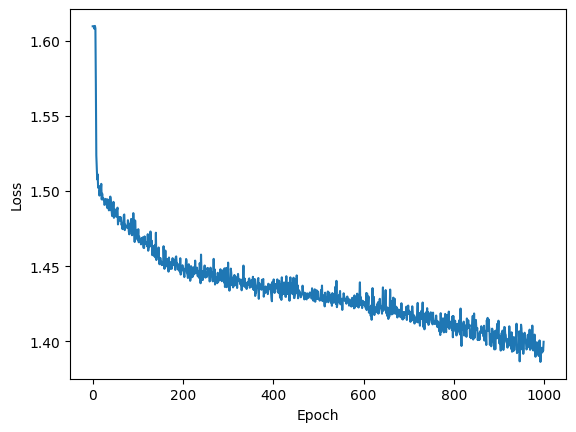

Test accuracy: 469.0950537634409
Accuracy: 0.44344086021505374
Precision: 0.43236166628387307
Recall: 0.44008221806677883
F1-score: 0.43154065689980187


Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.50      0.42       495
           1       0.71      0.77      0.74       472
           2       0.32      0.23      0.27       449
           3       0.32      0.25      0.28       463
           4       0.44      0.44      0.44       446

    accuracy                           0.44      2325
   macro avg       0.43      0.44      0.43      2325
weighted avg       0.43      0.44      0.43      2325

                    0           1           2           3           4  \
precision    0.367799    0.705653    0.323988    0.322404    0.441964   
recall       0.503030    0.766949    0.231626    0.254860    0.443946   
f1-score     0.424915    0.735025    0.270130    0.284680    0.442953   
support    495.000000  472.000000  449.000

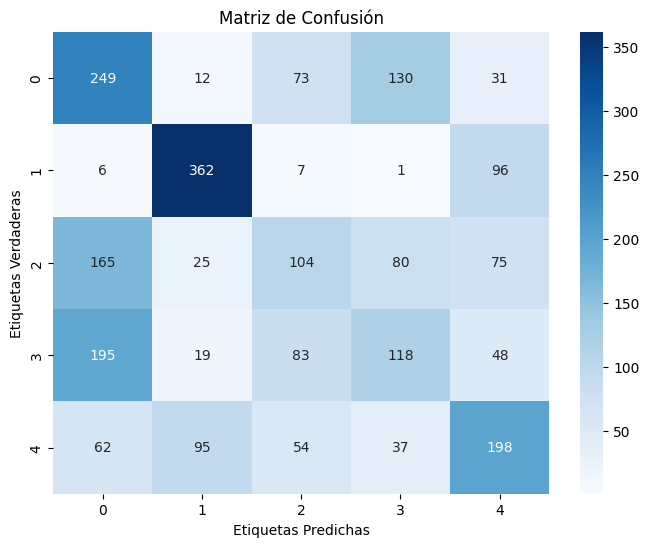

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_0.0001_0.3/resultados_1000_0.0001_0.3.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.7


Procesando epocas:   0%|                                                              | 1/1000 [00:01<28:02,  1.68s/it]

1.6094757991678574


Procesando epocas:   0%|                                                              | 2/1000 [00:03<28:05,  1.69s/it]

1.6095259217654958


Procesando epocas:   0%|▏                                                             | 3/1000 [00:05<28:04,  1.69s/it]

1.6094509524457594


Procesando epocas:   0%|▏                                                             | 4/1000 [00:06<28:03,  1.69s/it]

1.6094719024265514


Procesando epocas:   0%|▎                                                             | 5/1000 [00:08<27:59,  1.69s/it]

1.6094484420383677


Procesando epocas:   1%|▎                                                             | 6/1000 [00:10<27:58,  1.69s/it]

1.609489632354063


Procesando epocas:   1%|▍                                                             | 7/1000 [00:11<27:56,  1.69s/it]

1.6094597276519327


Procesando epocas:   1%|▍                                                             | 8/1000 [00:13<27:55,  1.69s/it]

1.609286428900326


Procesando epocas:   1%|▌                                                             | 9/1000 [00:15<27:53,  1.69s/it]

1.6093102251782136


Procesando epocas:   1%|▌                                                            | 10/1000 [00:16<27:54,  1.69s/it]

1.609010649428648


Procesando epocas:   1%|▋                                                            | 11/1000 [00:18<27:54,  1.69s/it]

1.6086329481180976


Procesando epocas:   1%|▋                                                            | 12/1000 [00:20<27:51,  1.69s/it]

1.6077831149101258


Procesando epocas:   1%|▊                                                            | 13/1000 [00:21<27:49,  1.69s/it]

1.6063855984631707


Procesando epocas:   1%|▊                                                            | 14/1000 [00:23<27:47,  1.69s/it]

1.6034573562004988


Procesando epocas:   2%|▉                                                            | 15/1000 [00:25<27:41,  1.69s/it]

1.597620176567751


Procesando epocas:   2%|▉                                                            | 16/1000 [00:27<27:44,  1.69s/it]

1.587601137862486


Procesando epocas:   2%|█                                                            | 17/1000 [00:28<27:43,  1.69s/it]

1.5744636928333955


Procesando epocas:   2%|█                                                            | 18/1000 [00:30<27:39,  1.69s/it]

1.5617499975597158


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:32<27:31,  1.68s/it]

1.5489995135980494


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:33<27:31,  1.69s/it]

1.542088385890512


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:35<27:28,  1.68s/it]

1.535412774366491


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:37<27:23,  1.68s/it]

1.529487443671507


Procesando epocas:   2%|█▍                                                           | 23/1000 [00:38<27:22,  1.68s/it]

1.5249892711639403


Procesando epocas:   2%|█▍                                                           | 24/1000 [00:40<27:19,  1.68s/it]

1.5225774105857401


Procesando epocas:   2%|█▌                                                           | 25/1000 [00:42<27:16,  1.68s/it]

1.5224135686369504


Procesando epocas:   3%|█▌                                                           | 26/1000 [00:43<27:12,  1.68s/it]

1.5169212222099304


Procesando epocas:   3%|█▋                                                           | 27/1000 [00:45<27:10,  1.68s/it]

1.5178115136483137


Procesando epocas:   3%|█▋                                                           | 28/1000 [00:47<27:08,  1.68s/it]

1.5135943546014674


Procesando epocas:   3%|█▊                                                           | 29/1000 [00:48<27:05,  1.67s/it]

1.5106163494727192


Procesando epocas:   3%|█▊                                                           | 30/1000 [00:50<27:00,  1.67s/it]

1.513177399775561


Procesando epocas:   3%|█▉                                                           | 31/1000 [00:52<26:57,  1.67s/it]

1.5095074457280777


Procesando epocas:   3%|█▉                                                           | 32/1000 [00:53<26:58,  1.67s/it]

1.5088336734210743


Procesando epocas:   3%|██                                                           | 33/1000 [00:55<26:58,  1.67s/it]

1.5084613147903891


Procesando epocas:   3%|██                                                           | 34/1000 [00:57<26:53,  1.67s/it]

1.508318713833304


Procesando epocas:   4%|██▏                                                          | 35/1000 [00:58<26:52,  1.67s/it]

1.5058249031796176


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:00<26:51,  1.67s/it]

1.5038083960028257


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:02<26:49,  1.67s/it]

1.5054925399668075


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:03<26:51,  1.68s/it]

1.5045841224053327


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:05<26:43,  1.67s/it]

1.5082134078530705


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:07<26:44,  1.67s/it]

1.5045508602086235


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:08<26:42,  1.67s/it]

1.5015615470269148


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:10<26:38,  1.67s/it]

1.5028398569892434


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:12<26:39,  1.67s/it]

1.502340506104862


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:13<26:37,  1.67s/it]

1.501783403228311


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:15<26:37,  1.67s/it]

1.5046770846142488


Procesando epocas:   5%|██▊                                                          | 46/1000 [01:17<26:34,  1.67s/it]

1.4994904784595264


Procesando epocas:   5%|██▊                                                          | 47/1000 [01:18<26:33,  1.67s/it]

1.5006640763843762


Procesando epocas:   5%|██▉                                                          | 48/1000 [01:20<26:29,  1.67s/it]

1.5017039895057678


Procesando epocas:   5%|██▉                                                          | 49/1000 [01:22<26:25,  1.67s/it]

1.4998557420337901


Procesando epocas:   5%|███                                                          | 50/1000 [01:23<26:26,  1.67s/it]

1.501890143927406


Procesando epocas:   5%|███                                                          | 51/1000 [01:25<26:23,  1.67s/it]

1.5002843141555786


Procesando epocas:   5%|███▏                                                         | 52/1000 [01:27<26:24,  1.67s/it]

1.5010253534597509


Procesando epocas:   5%|███▏                                                         | 53/1000 [01:29<26:39,  1.69s/it]

1.4991883614484


Procesando epocas:   5%|███▎                                                         | 54/1000 [01:30<26:54,  1.71s/it]

1.5002419927540946


Procesando epocas:   6%|███▎                                                         | 55/1000 [01:32<27:05,  1.72s/it]

1.498109020205105


Procesando epocas:   6%|███▍                                                         | 56/1000 [01:34<27:10,  1.73s/it]

1.4969215273857117


Procesando epocas:   6%|███▍                                                         | 57/1000 [01:36<27:16,  1.74s/it]

1.4972107101889218


Procesando epocas:   6%|███▌                                                         | 58/1000 [01:37<27:18,  1.74s/it]

1.497336392542895


Procesando epocas:   6%|███▌                                                         | 59/1000 [01:39<27:22,  1.75s/it]

1.4981633607079001


Procesando epocas:   6%|███▋                                                         | 60/1000 [01:41<27:21,  1.75s/it]

1.494502670624677


Procesando epocas:   6%|███▋                                                         | 61/1000 [01:43<27:19,  1.75s/it]

1.499072534196517


Procesando epocas:   6%|███▊                                                         | 62/1000 [01:44<27:15,  1.74s/it]

1.4960332723224865


Procesando epocas:   6%|███▊                                                         | 63/1000 [01:46<27:22,  1.75s/it]

1.4948204419192146


Procesando epocas:   6%|███▉                                                         | 64/1000 [01:48<27:17,  1.75s/it]

1.4926793196622063


Procesando epocas:   6%|███▉                                                         | 65/1000 [01:50<27:17,  1.75s/it]

1.4966002555454478


Procesando epocas:   7%|████                                                         | 66/1000 [01:51<27:13,  1.75s/it]

1.491157408321605


Procesando epocas:   7%|████                                                         | 67/1000 [01:53<27:10,  1.75s/it]

1.495887510916766


Procesando epocas:   7%|████▏                                                        | 68/1000 [01:55<27:09,  1.75s/it]

1.4953565436251024


Procesando epocas:   7%|████▏                                                        | 69/1000 [01:57<27:08,  1.75s/it]

1.4930067567264333


Procesando epocas:   7%|████▎                                                        | 70/1000 [01:58<27:08,  1.75s/it]

1.4956525543156791


Procesando epocas:   7%|████▎                                                        | 71/1000 [02:00<27:11,  1.76s/it]

1.492953897223753


Procesando epocas:   7%|████▍                                                        | 72/1000 [02:02<27:10,  1.76s/it]

1.4942012317040387


Procesando epocas:   7%|████▍                                                        | 73/1000 [02:04<27:08,  1.76s/it]

1.4941166344810934


Procesando epocas:   7%|████▌                                                        | 74/1000 [02:05<27:06,  1.76s/it]

1.4903677042792824


Procesando epocas:   8%|████▌                                                        | 75/1000 [02:07<27:02,  1.75s/it]

1.4925209879875183


Procesando epocas:   8%|████▋                                                        | 76/1000 [02:09<26:59,  1.75s/it]

1.4930547644110288


Procesando epocas:   8%|████▋                                                        | 77/1000 [02:11<26:58,  1.75s/it]

1.489889919056612


Procesando epocas:   8%|████▊                                                        | 78/1000 [02:12<26:57,  1.75s/it]

1.4903383598608129


Procesando epocas:   8%|████▊                                                        | 79/1000 [02:14<26:56,  1.76s/it]

1.4925728222903083


Procesando epocas:   8%|████▉                                                        | 80/1000 [02:16<26:52,  1.75s/it]

1.4929046441526974


Procesando epocas:   8%|████▉                                                        | 81/1000 [02:18<26:52,  1.75s/it]

1.4934437520363752


Procesando epocas:   8%|█████                                                        | 82/1000 [02:19<26:49,  1.75s/it]

1.489373297551099


Procesando epocas:   8%|█████                                                        | 83/1000 [02:21<26:49,  1.75s/it]

1.4903076592613669


Procesando epocas:   8%|█████                                                        | 84/1000 [02:23<26:45,  1.75s/it]

1.4908442349994884


Procesando epocas:   8%|█████▏                                                       | 85/1000 [02:25<26:37,  1.75s/it]

1.4942941272959989


Procesando epocas:   9%|█████▏                                                       | 86/1000 [02:26<26:26,  1.74s/it]

1.4900261339019327


Procesando epocas:   9%|█████▎                                                       | 87/1000 [02:28<26:21,  1.73s/it]

1.4890612994923311


Procesando epocas:   9%|█████▎                                                       | 88/1000 [02:30<26:15,  1.73s/it]

1.489987044474658


Procesando epocas:   9%|█████▍                                                       | 89/1000 [02:31<26:10,  1.72s/it]

1.4872621732599596


Procesando epocas:   9%|█████▍                                                       | 90/1000 [02:33<26:08,  1.72s/it]

1.4891583477749544


Procesando epocas:   9%|█████▌                                                       | 91/1000 [02:35<26:02,  1.72s/it]

1.4902390437967636


Procesando epocas:   9%|█████▌                                                       | 92/1000 [02:37<26:00,  1.72s/it]

1.4893766802899977


Procesando epocas:   9%|█████▋                                                       | 93/1000 [02:38<25:58,  1.72s/it]

1.491017972721773


Procesando epocas:   9%|█████▋                                                       | 94/1000 [02:40<25:59,  1.72s/it]

1.4894092139075785


Procesando epocas:  10%|█████▊                                                       | 95/1000 [02:42<25:58,  1.72s/it]

1.48736552140292


Procesando epocas:  10%|█████▊                                                       | 96/1000 [02:43<25:55,  1.72s/it]

1.490920683215646


Procesando epocas:  10%|█████▉                                                       | 97/1000 [02:45<25:53,  1.72s/it]

1.4842671555631302


Procesando epocas:  10%|█████▉                                                       | 98/1000 [02:47<25:50,  1.72s/it]

1.48846217323752


Procesando epocas:  10%|██████                                                       | 99/1000 [02:49<25:49,  1.72s/it]

1.4866853952407837


Procesando epocas:  10%|██████                                                      | 100/1000 [02:50<25:48,  1.72s/it]

1.4906700211412767


Procesando epocas:  10%|██████                                                      | 101/1000 [02:52<25:48,  1.72s/it]

1.487221128099105


Procesando epocas:  10%|██████                                                      | 102/1000 [02:54<25:45,  1.72s/it]

1.4883616307202507


Procesando epocas:  10%|██████▏                                                     | 103/1000 [02:56<25:44,  1.72s/it]

1.4895799040794373


Procesando epocas:  10%|██████▏                                                     | 104/1000 [02:57<25:42,  1.72s/it]

1.4862598482300253


Procesando epocas:  10%|██████▎                                                     | 105/1000 [02:59<25:42,  1.72s/it]

1.485297173612258


Procesando epocas:  11%|██████▎                                                     | 106/1000 [03:01<25:39,  1.72s/it]

1.487624119309818


Procesando epocas:  11%|██████▍                                                     | 107/1000 [03:02<25:35,  1.72s/it]

1.4857028870021596


Procesando epocas:  11%|██████▍                                                     | 108/1000 [03:04<25:31,  1.72s/it]

1.4869448724915


Procesando epocas:  11%|██████▌                                                     | 109/1000 [03:06<25:31,  1.72s/it]

1.48798267140108


Procesando epocas:  11%|██████▌                                                     | 110/1000 [03:08<25:32,  1.72s/it]

1.4882648229598998


Procesando epocas:  11%|██████▋                                                     | 111/1000 [03:09<25:30,  1.72s/it]

1.4877099654253791


Procesando epocas:  11%|██████▋                                                     | 112/1000 [03:11<25:23,  1.72s/it]

1.4862614891108346


Procesando epocas:  11%|██████▊                                                     | 113/1000 [03:13<25:16,  1.71s/it]

1.4831387526848736


Procesando epocas:  11%|██████▊                                                     | 114/1000 [03:14<25:11,  1.71s/it]

1.4838539768667782


Procesando epocas:  12%|██████▉                                                     | 115/1000 [03:16<25:07,  1.70s/it]

1.4851383700090297


Procesando epocas:  12%|██████▉                                                     | 116/1000 [03:18<25:04,  1.70s/it]

1.4859513002283433


Procesando epocas:  12%|███████                                                     | 117/1000 [03:19<24:59,  1.70s/it]

1.4867096227758072


Procesando epocas:  12%|███████                                                     | 118/1000 [03:21<24:57,  1.70s/it]

1.4852237091344946


Procesando epocas:  12%|███████▏                                                    | 119/1000 [03:23<24:45,  1.69s/it]

1.4851606439141667


Procesando epocas:  12%|███████▏                                                    | 120/1000 [03:24<24:34,  1.68s/it]

1.4850268062423257


Procesando epocas:  12%|███████▎                                                    | 121/1000 [03:26<24:28,  1.67s/it]

1.4836251960081213


Procesando epocas:  12%|███████▎                                                    | 122/1000 [03:28<24:20,  1.66s/it]

1.4861116058686201


Procesando epocas:  12%|███████▍                                                    | 123/1000 [03:29<24:19,  1.66s/it]

1.4833297603270588


Procesando epocas:  12%|███████▍                                                    | 124/1000 [03:31<24:15,  1.66s/it]

1.4834896816926844


Procesando epocas:  12%|███████▌                                                    | 125/1000 [03:33<24:12,  1.66s/it]

1.4834599137306212


Procesando epocas:  13%|███████▌                                                    | 126/1000 [03:34<24:08,  1.66s/it]

1.4856062475372762


Procesando epocas:  13%|███████▌                                                    | 127/1000 [03:36<24:08,  1.66s/it]

1.481244213440839


Procesando epocas:  13%|███████▋                                                    | 128/1000 [03:38<24:05,  1.66s/it]

1.483467410592472


Procesando epocas:  13%|███████▋                                                    | 129/1000 [03:39<24:00,  1.65s/it]

1.485712638322045


Procesando epocas:  13%|███████▊                                                    | 130/1000 [03:41<24:00,  1.66s/it]

1.4836930955157561


Procesando epocas:  13%|███████▊                                                    | 131/1000 [03:43<23:57,  1.65s/it]

1.4804176015012405


Procesando epocas:  13%|███████▉                                                    | 132/1000 [03:44<23:54,  1.65s/it]

1.4858575266950271


Procesando epocas:  13%|███████▉                                                    | 133/1000 [03:46<23:51,  1.65s/it]

1.4852303441833048


Procesando epocas:  13%|████████                                                    | 134/1000 [03:48<23:55,  1.66s/it]

1.4800626291948207


Procesando epocas:  14%|████████                                                    | 135/1000 [03:49<23:54,  1.66s/it]

1.4843748906079461


Procesando epocas:  14%|████████▏                                                   | 136/1000 [03:51<23:53,  1.66s/it]

1.486204811404733


Procesando epocas:  14%|████████▏                                                   | 137/1000 [03:53<23:53,  1.66s/it]

1.4826844615094803


Procesando epocas:  14%|████████▎                                                   | 138/1000 [03:54<23:51,  1.66s/it]

1.4859147247146158


Procesando epocas:  14%|████████▎                                                   | 139/1000 [03:56<23:49,  1.66s/it]

1.4826692027204178


Procesando epocas:  14%|████████▍                                                   | 140/1000 [03:58<23:48,  1.66s/it]

1.4840733233620138


Procesando epocas:  14%|████████▍                                                   | 141/1000 [03:59<23:44,  1.66s/it]

1.4820947044035968


Procesando epocas:  14%|████████▌                                                   | 142/1000 [04:01<23:41,  1.66s/it]

1.4827771789887372


Procesando epocas:  14%|████████▌                                                   | 143/1000 [04:03<23:39,  1.66s/it]

1.4809603529817918


Procesando epocas:  14%|████████▋                                                   | 144/1000 [04:04<23:35,  1.65s/it]

1.4818798745379729


Procesando epocas:  14%|████████▋                                                   | 145/1000 [04:06<23:30,  1.65s/it]

1.4810645236688502


Procesando epocas:  15%|████████▊                                                   | 146/1000 [04:08<23:27,  1.65s/it]

1.482752489342409


Procesando epocas:  15%|████████▊                                                   | 147/1000 [04:09<23:22,  1.64s/it]

1.4806782294722165


Procesando epocas:  15%|████████▉                                                   | 148/1000 [04:11<23:19,  1.64s/it]

1.4770437429932988


Procesando epocas:  15%|████████▉                                                   | 149/1000 [04:12<23:15,  1.64s/it]

1.4811315487412846


Procesando epocas:  15%|█████████                                                   | 150/1000 [04:14<23:14,  1.64s/it]

1.4808415840653812


Procesando epocas:  15%|█████████                                                   | 151/1000 [04:16<23:14,  1.64s/it]

1.4812631550957174


Procesando epocas:  15%|█████████                                                   | 152/1000 [04:17<23:14,  1.64s/it]

1.4797661620027878


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [04:19<23:12,  1.64s/it]

1.4794241863138535


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [04:21<23:09,  1.64s/it]

1.4793416443993064


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [04:22<23:05,  1.64s/it]

1.477178492265589


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [04:24<23:04,  1.64s/it]

1.4800051562926348


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [04:26<23:02,  1.64s/it]

1.482509318520041


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [04:27<23:01,  1.64s/it]

1.4827411644599018


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [04:29<22:56,  1.64s/it]

1.4819869055467494


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [04:30<22:52,  1.63s/it]

1.4807941450792201


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [04:32<22:55,  1.64s/it]

1.4787556648254394


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [04:34<22:51,  1.64s/it]

1.481635886781356


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [04:35<22:49,  1.64s/it]

1.4819000188042135


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [04:37<22:48,  1.64s/it]

1.4785638381453121


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [04:39<22:46,  1.64s/it]

1.482178234352785


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [04:40<22:46,  1.64s/it]

1.4764407094787149


Procesando epocas:  17%|██████████                                                  | 167/1000 [04:42<22:47,  1.64s/it]

1.4784750054864322


Procesando epocas:  17%|██████████                                                  | 168/1000 [04:44<22:46,  1.64s/it]

1.4797881231588477


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [04:45<22:43,  1.64s/it]

1.4795064694741193


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [04:47<22:49,  1.65s/it]

1.4801512956619263


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [04:49<22:54,  1.66s/it]

1.481108229300555


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [04:50<22:58,  1.67s/it]

1.4812779440599328


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [04:52<23:02,  1.67s/it]

1.4793311147128834


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [04:54<23:01,  1.67s/it]

1.482642741764293


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [04:55<23:01,  1.67s/it]

1.4776435922173892


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [04:57<23:20,  1.70s/it]

1.478878952475155


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [04:59<23:33,  1.72s/it]

1.4824257871683906


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [05:01<23:42,  1.73s/it]

1.4811655591515933


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [05:02<23:48,  1.74s/it]

1.4808192526592927


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [05:04<23:51,  1.75s/it]

1.4812657748951632


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [05:06<23:52,  1.75s/it]

1.476480111655067


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [05:08<23:53,  1.75s/it]

1.47785704276141


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [05:09<23:53,  1.75s/it]

1.4774093740126666


Procesando epocas:  18%|███████████                                                 | 184/1000 [05:11<23:53,  1.76s/it]

1.4782736687099232


Procesando epocas:  18%|███████████                                                 | 185/1000 [05:13<23:53,  1.76s/it]

1.4783301136072944


Procesando epocas:  19%|███████████▏                                                | 186/1000 [05:15<23:50,  1.76s/it]

1.4789349415723014


Procesando epocas:  19%|███████████▏                                                | 187/1000 [05:16<23:47,  1.76s/it]

1.4787704187280992


Procesando epocas:  19%|███████████▎                                                | 188/1000 [05:18<23:47,  1.76s/it]

1.4763445335275986


Procesando epocas:  19%|███████████▎                                                | 189/1000 [05:20<23:47,  1.76s/it]

1.4791856562390047


Procesando epocas:  19%|███████████▍                                                | 190/1000 [05:22<23:45,  1.76s/it]

1.4763087048250085


Procesando epocas:  19%|███████████▍                                                | 191/1000 [05:23<23:43,  1.76s/it]

1.479565203891081


Procesando epocas:  19%|███████████▌                                                | 192/1000 [05:25<23:41,  1.76s/it]

1.4780182908563053


Procesando epocas:  19%|███████████▌                                                | 193/1000 [05:27<23:38,  1.76s/it]

1.4766737937927246


Procesando epocas:  19%|███████████▋                                                | 194/1000 [05:29<23:36,  1.76s/it]

1.4791879001785726


Procesando epocas:  20%|███████████▋                                                | 195/1000 [05:30<23:36,  1.76s/it]

1.4780918072251712


Procesando epocas:  20%|███████████▊                                                | 196/1000 [05:32<23:35,  1.76s/it]

1.4789353812442105


Procesando epocas:  20%|███████████▊                                                | 197/1000 [05:34<23:33,  1.76s/it]

1.4754935657276826


Procesando epocas:  20%|███████████▉                                                | 198/1000 [05:36<23:29,  1.76s/it]

1.4753759706721585


Procesando epocas:  20%|███████████▉                                                | 199/1000 [05:37<23:26,  1.76s/it]

1.4821371660513036


Procesando epocas:  20%|████████████                                                | 200/1000 [05:39<23:24,  1.76s/it]

1.4797490190057194


Procesando epocas:  20%|████████████                                                | 201/1000 [05:41<23:24,  1.76s/it]

1.4770463782198289


Procesando epocas:  20%|████████████                                                | 202/1000 [05:43<23:23,  1.76s/it]

1.4774489171364729


Procesando epocas:  20%|████████████▏                                               | 203/1000 [05:45<23:23,  1.76s/it]

1.4806705397718094


Procesando epocas:  20%|████████████▏                                               | 204/1000 [05:46<23:21,  1.76s/it]

1.478836032222299


Procesando epocas:  20%|████████████▎                                               | 205/1000 [05:48<23:17,  1.76s/it]

1.480627313080956


Procesando epocas:  21%|████████████▎                                               | 206/1000 [05:50<23:14,  1.76s/it]

1.4787111275336322


Procesando epocas:  21%|████████████▍                                               | 207/1000 [05:52<23:05,  1.75s/it]

1.4759339024038876


Procesando epocas:  21%|████████████▍                                               | 208/1000 [05:53<22:55,  1.74s/it]

1.4757711361436283


Procesando epocas:  21%|████████████▌                                               | 209/1000 [05:55<22:49,  1.73s/it]

1.4781885441611795


Procesando epocas:  21%|████████████▌                                               | 210/1000 [05:57<22:44,  1.73s/it]

1.4784871662364287


Procesando epocas:  21%|████████████▋                                               | 211/1000 [05:58<22:40,  1.72s/it]

1.4774593360283796


Procesando epocas:  21%|████████████▋                                               | 212/1000 [06:00<22:38,  1.72s/it]

1.4767620801925658


Procesando epocas:  21%|████████████▊                                               | 213/1000 [06:02<22:37,  1.73s/it]

1.4797451222644133


Procesando epocas:  21%|████████████▊                                               | 214/1000 [06:04<22:31,  1.72s/it]

1.4784823424675886


Procesando epocas:  22%|████████████▉                                               | 215/1000 [06:05<22:27,  1.72s/it]

1.4749590270659503


Procesando epocas:  22%|████████████▉                                               | 216/1000 [06:07<22:23,  1.71s/it]

1.4742190536330728


Procesando epocas:  22%|█████████████                                               | 217/1000 [06:09<22:19,  1.71s/it]

1.477991217024186


Procesando epocas:  22%|█████████████                                               | 218/1000 [06:10<22:17,  1.71s/it]

1.4762717015603009


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [06:12<22:15,  1.71s/it]

1.4782287948271808


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [06:14<22:14,  1.71s/it]

1.477747375123641


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [06:16<22:12,  1.71s/it]

1.4816246222047245


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [06:17<22:13,  1.71s/it]

1.4756279440487132


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [06:19<22:12,  1.71s/it]

1.476338500135085


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [06:21<22:08,  1.71s/it]

1.4730848298353307


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [06:22<22:06,  1.71s/it]

1.474214543314541


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [06:24<22:05,  1.71s/it]

1.4762596165432649


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [06:26<22:04,  1.71s/it]

1.4749781818950878


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [06:28<22:02,  1.71s/it]

1.476460288552677


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [06:29<21:59,  1.71s/it]

1.47684248194975


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [06:31<21:59,  1.71s/it]

1.475936787969926


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [06:33<22:00,  1.72s/it]

1.4772181812454672


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [06:34<21:59,  1.72s/it]

1.4770974397659302


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [06:36<21:54,  1.71s/it]

1.4751272306722754


Procesando epocas:  23%|██████████████                                              | 234/1000 [06:38<21:46,  1.71s/it]

1.47588330857894


Procesando epocas:  24%|██████████████                                              | 235/1000 [06:39<21:40,  1.70s/it]

1.474067509174347


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [06:41<21:32,  1.69s/it]

1.4743491116692038


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [06:43<21:27,  1.69s/it]

1.4739505599526799


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [06:44<21:24,  1.69s/it]

1.476763800312491


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [06:46<21:24,  1.69s/it]

1.474149831603555


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [06:48<21:22,  1.69s/it]

1.471721588864046


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [06:50<21:20,  1.69s/it]

1.475157849227681


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [06:51<21:17,  1.68s/it]

1.472984906505136


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [06:53<21:13,  1.68s/it]

1.4796870322788462


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [06:55<21:13,  1.68s/it]

1.474755109057707


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [06:56<21:12,  1.68s/it]

1.476461714856765


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [06:58<21:10,  1.69s/it]

1.4775484547895543


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [07:00<21:08,  1.68s/it]

1.4749998450279236


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [07:01<21:06,  1.68s/it]

1.4780530347543603


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [07:03<21:03,  1.68s/it]

1.475014523898854


Procesando epocas:  25%|███████████████                                             | 250/1000 [07:05<21:01,  1.68s/it]

1.476944997030146


Procesando epocas:  25%|███████████████                                             | 251/1000 [07:06<20:59,  1.68s/it]

1.4759650328580072


Procesando epocas:  25%|███████████████                                             | 252/1000 [07:08<20:58,  1.68s/it]

1.4749540335991804


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [07:10<20:53,  1.68s/it]

1.4727287215345046


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [07:11<20:50,  1.68s/it]

1.4740956018952762


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [07:13<20:48,  1.68s/it]

1.4784331665319554


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [07:15<20:49,  1.68s/it]

1.4776244065340827


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [07:16<20:48,  1.68s/it]

1.4744627167196835


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [07:18<20:49,  1.68s/it]

1.4755810239735772


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [07:20<20:47,  1.68s/it]

1.4762076027253095


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [07:21<20:43,  1.68s/it]

1.477389663107255


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [07:23<20:42,  1.68s/it]

1.4740201431162216


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [07:25<20:41,  1.68s/it]

1.4758719360127168


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [07:27<20:39,  1.68s/it]

1.4733043221866384


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [07:28<20:36,  1.68s/it]

1.4762665629386902


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [07:30<20:34,  1.68s/it]

1.4733199631466585


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [07:32<20:34,  1.68s/it]

1.4743661046028138


Procesando epocas:  27%|████████████████                                            | 267/1000 [07:33<20:34,  1.68s/it]

1.4758284786168268


Procesando epocas:  27%|████████████████                                            | 268/1000 [07:35<20:33,  1.69s/it]

1.4748570168719572


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [07:37<20:30,  1.68s/it]

1.4736668523620158


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [07:38<20:29,  1.68s/it]

1.4750798905597013


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [07:40<20:28,  1.69s/it]

1.473860552030451


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [07:42<20:29,  1.69s/it]

1.4714854457799127


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [07:43<20:26,  1.69s/it]

1.4750292897224426


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [07:45<20:25,  1.69s/it]

1.474451756477356


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [07:47<20:24,  1.69s/it]

1.4758673681932337


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [07:48<20:24,  1.69s/it]

1.4721260105862337


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [07:50<20:21,  1.69s/it]

1.4729068300303292


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [07:52<20:19,  1.69s/it]

1.4737719030941234


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [07:54<20:17,  1.69s/it]

1.47326841284247


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [07:55<20:14,  1.69s/it]

1.4741217606207904


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [07:57<20:14,  1.69s/it]

1.4765870472964118


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [07:59<20:10,  1.69s/it]

1.4750381063012517


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [08:00<20:08,  1.69s/it]

1.4736339723362641


Procesando epocas:  28%|█████████████████                                           | 284/1000 [08:02<20:06,  1.69s/it]

1.472919006908641


Procesando epocas:  28%|█████████████████                                           | 285/1000 [08:04<20:03,  1.68s/it]

1.4768093796337352


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [08:05<20:02,  1.68s/it]

1.4749107921824736


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [08:07<20:01,  1.69s/it]

1.4720093860345729


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [08:09<20:00,  1.69s/it]

1.47125083137961


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [08:10<19:57,  1.68s/it]

1.4743832349777222


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [08:12<19:56,  1.69s/it]

1.4729753697619719


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [08:14<19:54,  1.69s/it]

1.4711835377356586


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [08:15<19:53,  1.69s/it]

1.4785724562757157


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [08:17<19:50,  1.68s/it]

1.471777031702154


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [08:19<19:47,  1.68s/it]

1.4750440934125115


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [08:20<19:47,  1.68s/it]

1.4753881047753727


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [08:22<19:46,  1.69s/it]

1.4736594978500814


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [08:24<19:45,  1.69s/it]

1.473161786444047


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [08:26<19:48,  1.69s/it]

1.4760579845484565


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [08:27<19:58,  1.71s/it]

1.4749489426612854


Procesando epocas:  30%|██████████████████                                          | 300/1000 [08:29<20:05,  1.72s/it]

1.4739025592803956


Procesando epocas:  30%|██████████████████                                          | 301/1000 [08:31<20:11,  1.73s/it]

1.474536212051616


Procesando epocas:  30%|██████████████████                                          | 302/1000 [08:33<20:13,  1.74s/it]

1.4735687304945553


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [08:34<20:15,  1.74s/it]

1.4754904431455276


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [08:36<20:14,  1.75s/it]

1.473417951078976


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [08:38<20:13,  1.75s/it]

1.4727450293653153


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [08:40<20:13,  1.75s/it]

1.4721839575206532


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [08:41<20:13,  1.75s/it]

1.4761293467353371


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [08:43<20:11,  1.75s/it]

1.4741642278783462


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [08:45<20:11,  1.75s/it]

1.4731070420321297


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [08:47<20:11,  1.76s/it]

1.4733906493467444


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [08:48<20:09,  1.76s/it]

1.4718641568632687


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [08:50<20:07,  1.75s/it]

1.4739444227779612


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [08:52<20:06,  1.76s/it]

1.4720230425105376


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [08:54<20:05,  1.76s/it]

1.4740109422627616


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [08:55<19:58,  1.75s/it]

1.4763080141123603


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [08:57<19:50,  1.74s/it]

1.474802943538217


Procesando epocas:  32%|███████████████████                                         | 317/1000 [08:59<19:42,  1.73s/it]

1.472701138608596


Procesando epocas:  32%|███████████████████                                         | 318/1000 [09:01<19:37,  1.73s/it]

1.4712073978255777


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [09:02<19:32,  1.72s/it]

1.4714085964595571


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [09:04<19:29,  1.72s/it]

1.4728129989960614


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [09:06<19:27,  1.72s/it]

1.471907396176282


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [09:07<19:24,  1.72s/it]

1.4738870403345894


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [09:09<19:23,  1.72s/it]

1.4715863950112287


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [09:11<19:25,  1.72s/it]

1.4729418495122124


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [09:13<19:22,  1.72s/it]

1.46948604443494


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [09:14<19:21,  1.72s/it]

1.4731521936023937


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [09:16<19:21,  1.73s/it]

1.4720920534694897


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [09:18<19:21,  1.73s/it]

1.4738598788485808


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [09:19<19:16,  1.72s/it]

1.471986577090095


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [09:21<19:07,  1.71s/it]

1.4761159511173472


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [09:23<19:01,  1.71s/it]

1.4731656972099754


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [09:25<18:56,  1.70s/it]

1.4703976462869084


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [09:26<18:51,  1.70s/it]

1.4707259584875667


Procesando epocas:  33%|████████████████████                                        | 334/1000 [09:28<18:46,  1.69s/it]

1.472807124783011


Procesando epocas:  34%|████████████████████                                        | 335/1000 [09:30<18:45,  1.69s/it]

1.4739288750816795


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [09:31<18:43,  1.69s/it]

1.4743244311388801


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [09:33<18:42,  1.69s/it]

1.4717800932772018


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [09:35<18:38,  1.69s/it]

1.474428976984585


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [09:36<18:38,  1.69s/it]

1.4719310725436492


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [09:38<18:36,  1.69s/it]

1.4746612892431372


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [09:40<18:36,  1.69s/it]

1.4714449440731723


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [09:41<18:32,  1.69s/it]

1.4730704300543842


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [09:43<18:28,  1.69s/it]

1.4750682150616365


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [09:45<18:27,  1.69s/it]

1.47496500786613


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [09:46<18:25,  1.69s/it]

1.471670370943406


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [09:48<18:25,  1.69s/it]

1.4757188165889066


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [09:50<18:23,  1.69s/it]

1.473303027714


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [09:52<18:23,  1.69s/it]

1.471426376174478


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [09:53<18:21,  1.69s/it]

1.4707373577005722


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [09:55<18:20,  1.69s/it]

1.4717330869506386


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [09:57<18:17,  1.69s/it]

1.4727366040734684


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [09:58<18:15,  1.69s/it]

1.4718398087164934


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [10:00<18:12,  1.69s/it]

1.4745288365027485


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [10:02<18:10,  1.69s/it]

1.4755326334167929


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [10:03<18:08,  1.69s/it]

1.47232463500079


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [10:05<18:04,  1.68s/it]

1.4703455714618459


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [10:07<17:55,  1.67s/it]

1.468913880516501


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [10:08<17:50,  1.67s/it]

1.4716136876274557


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [10:10<17:46,  1.66s/it]

1.4732080915394952


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [10:12<17:44,  1.66s/it]

1.4704705834388734


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [10:13<17:42,  1.66s/it]

1.4718400289030635


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [10:15<17:38,  1.66s/it]

1.4713029265403748


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [10:17<17:40,  1.66s/it]

1.4712203656925875


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [10:18<17:38,  1.66s/it]

1.4698888617403367


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [10:20<17:40,  1.67s/it]

1.471013100708232


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [10:22<17:46,  1.68s/it]

1.4702454566955567


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [10:23<17:48,  1.69s/it]

1.4718950713382049


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [10:25<17:48,  1.69s/it]

1.4744620168910307


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [10:27<17:46,  1.69s/it]

1.471146017663619


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [10:29<17:48,  1.70s/it]

1.4694500958218295


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [10:30<17:46,  1.69s/it]

1.4729949151768404


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [10:32<17:44,  1.70s/it]

1.4715162859243505


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [10:34<17:45,  1.70s/it]

1.470651289995979


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [10:35<17:43,  1.70s/it]

1.4698945347000572


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [10:37<17:40,  1.70s/it]

1.4722809945835786


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [10:39<17:38,  1.70s/it]

1.46834314921323


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [10:40<17:36,  1.70s/it]

1.469248755539165


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [10:42<17:34,  1.70s/it]

1.4719563848832073


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [10:44<17:34,  1.70s/it]

1.4703874503864962


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [10:46<17:32,  1.70s/it]

1.4693912996965297


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [10:47<17:30,  1.70s/it]

1.4721151849802803


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [10:49<17:27,  1.70s/it]

1.470392174580518


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [10:51<17:24,  1.69s/it]

1.4717889561372646


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [10:52<17:22,  1.69s/it]

1.4714850201326257


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [10:54<17:20,  1.69s/it]

1.4749868939904605


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [10:56<17:19,  1.69s/it]

1.4711107366225298


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [10:57<17:18,  1.69s/it]

1.470664540459128


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [10:59<17:17,  1.70s/it]

1.4727837618659525


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [11:01<17:13,  1.69s/it]

1.471312976584715


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [11:02<17:09,  1.69s/it]

1.4703086509424097


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [11:04<17:08,  1.69s/it]

1.472688731025247


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [11:06<17:05,  1.69s/it]

1.4697846111129311


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [11:07<17:03,  1.69s/it]

1.469967459229862


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [11:09<17:00,  1.68s/it]

1.4706146597862244


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [11:11<16:58,  1.68s/it]

1.4748719643144046


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [11:13<16:56,  1.68s/it]

1.4696382943321677


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [11:14<16:56,  1.69s/it]

1.4710335072349099


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [11:16<16:54,  1.68s/it]

1.471303756798015


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [11:18<16:53,  1.69s/it]

1.4707511866793912


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [11:19<16:51,  1.69s/it]

1.4732692431001102


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [11:21<16:48,  1.68s/it]

1.4754725084585303


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [11:23<16:45,  1.68s/it]

1.4704494932118584


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [11:24<16:44,  1.68s/it]

1.473317508837756


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [11:26<16:43,  1.68s/it]

1.4692120965789346


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [11:28<16:41,  1.68s/it]

1.4702171697336084


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [11:29<16:38,  1.68s/it]

1.4694165166686564


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [11:31<16:37,  1.68s/it]

1.4704429156639998


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [11:33<16:35,  1.68s/it]

1.4713490086443284


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [11:34<16:32,  1.68s/it]

1.4746983633321875


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [11:36<16:29,  1.68s/it]

1.4708773486754474


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [11:38<16:27,  1.68s/it]

1.4683297921629512


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [11:39<16:24,  1.67s/it]

1.4670001036980573


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [11:41<16:21,  1.67s/it]

1.4731042041498073


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [11:43<16:19,  1.67s/it]

1.4786449109806734


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [11:44<16:19,  1.67s/it]

1.4716769386740292


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [11:46<16:17,  1.67s/it]

1.4693318381029017


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [11:48<16:15,  1.67s/it]

1.4724871214698343


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [11:49<16:15,  1.68s/it]

1.4702795645769904


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [11:51<16:12,  1.67s/it]

1.4714185609537012


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [11:53<16:14,  1.68s/it]

1.469172825532801


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [11:55<16:25,  1.70s/it]

1.4701286652508905


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [11:56<16:33,  1.72s/it]

1.4697941752041088


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [11:58<16:37,  1.73s/it]

1.4664395739050473


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [12:00<16:39,  1.73s/it]

1.47380312611075


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [12:02<16:40,  1.74s/it]

1.473277563908521


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [12:03<16:38,  1.74s/it]

1.4710758531794828


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [12:05<16:38,  1.74s/it]

1.4693110199535595


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [12:07<16:38,  1.75s/it]

1.470361169646768


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [12:09<16:38,  1.75s/it]

1.4715595210299772


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [12:10<16:36,  1.75s/it]

1.4706861355725456


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [12:12<16:35,  1.75s/it]

1.4735133928411148


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [12:14<16:33,  1.75s/it]

1.4706121830379262


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [12:16<16:30,  1.75s/it]

1.4691674695295447


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [12:17<16:29,  1.75s/it]

1.468795053397908


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [12:19<16:28,  1.75s/it]

1.4693980259053847


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [12:21<16:26,  1.75s/it]

1.472188011337729


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [12:23<16:24,  1.75s/it]

1.471760460208444


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [12:24<16:21,  1.75s/it]

1.4713994615218218


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [12:26<16:20,  1.75s/it]

1.4734643795911004


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [12:28<16:17,  1.75s/it]

1.470091292437385


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [12:30<16:17,  1.75s/it]

1.4706931233406066


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [12:31<16:16,  1.75s/it]

1.4671542349983664


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [12:33<16:13,  1.75s/it]

1.4697229273178998


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [12:35<16:12,  1.75s/it]

1.4707213422831367


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [12:37<16:10,  1.75s/it]

1.4678998217863195


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [12:38<16:08,  1.75s/it]

1.466506924348719


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [12:40<16:07,  1.75s/it]

1.4691820838872125


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [12:42<16:05,  1.75s/it]

1.471329378380495


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [12:44<16:04,  1.75s/it]

1.4691832051557654


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [12:45<16:01,  1.75s/it]

1.4793944176505593


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [12:47<16:00,  1.75s/it]

1.4717896973385531


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [12:49<15:50,  1.73s/it]

1.4728870749473573


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [12:50<15:45,  1.73s/it]

1.4689965395366444


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [12:52<15:42,  1.73s/it]

1.4719661460203284


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [12:54<15:39,  1.72s/it]

1.471654645134421


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [12:56<15:34,  1.72s/it]

1.4705082192140466


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [12:57<15:31,  1.71s/it]

1.4674098842284258


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [12:59<15:29,  1.71s/it]

1.469156947556664


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [13:01<15:26,  1.71s/it]

1.4723190293592565


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [13:02<15:24,  1.71s/it]

1.4699314615305732


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [13:04<15:24,  1.71s/it]

1.4695757992127363


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [13:06<15:23,  1.72s/it]

1.4675616236294018


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [13:08<15:22,  1.72s/it]

1.471241899798898


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [13:09<15:21,  1.72s/it]

1.4680535477750443


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [13:11<15:20,  1.72s/it]

1.4681268979521358


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [13:13<15:18,  1.72s/it]

1.4700069834204281


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [13:14<15:17,  1.72s/it]

1.4682659548871657


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [13:16<15:14,  1.72s/it]

1.4698602886760936


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [13:18<15:13,  1.72s/it]

1.4682738626704497


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [13:20<15:10,  1.72s/it]

1.46614851881476


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [13:21<15:09,  1.72s/it]

1.4724212807767532


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [13:23<15:08,  1.72s/it]

1.4687113530495588


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [13:25<15:07,  1.72s/it]

1.4691377815078286


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [13:27<15:04,  1.72s/it]

1.466908049583435


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [13:28<15:03,  1.72s/it]

1.4684054479879491


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [13:30<15:01,  1.72s/it]

1.4697184310239904


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [13:32<15:00,  1.72s/it]

1.4691402926164514


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [13:33<14:57,  1.72s/it]

1.4662472816074597


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [13:35<14:55,  1.72s/it]

1.4699106854550978


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [13:37<14:50,  1.71s/it]

1.4726782181683709


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [13:39<14:46,  1.71s/it]

1.4691121704438153


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [13:40<14:45,  1.71s/it]

1.467250492993523


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [13:42<14:43,  1.71s/it]

1.4711838462773492


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [13:44<14:40,  1.71s/it]

1.4672577184789322


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [13:45<14:36,  1.70s/it]

1.4697638925384073


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [13:47<14:35,  1.70s/it]

1.4709607180427102


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [13:49<14:33,  1.70s/it]

1.4676092842045951


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [13:50<14:31,  1.70s/it]

1.4695167338146884


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [13:52<14:30,  1.70s/it]

1.4689281127032112


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [13:54<14:26,  1.70s/it]

1.469249879612642


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [13:56<14:27,  1.70s/it]

1.4661606227650361


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [13:57<14:24,  1.70s/it]

1.4727400555330163


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [13:59<14:22,  1.70s/it]

1.4670223860179676


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [14:01<14:19,  1.70s/it]

1.4673524674247294


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [14:02<14:17,  1.70s/it]

1.4668973025153664


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [14:04<14:16,  1.70s/it]

1.4675259491976569


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [14:06<14:14,  1.70s/it]

1.4662166581434362


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [14:07<14:11,  1.70s/it]

1.4670665194006527


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [14:09<14:09,  1.70s/it]

1.467621489833383


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [14:11<14:07,  1.69s/it]

1.4701168894767762


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [14:13<14:06,  1.70s/it]

1.4732261678751777


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [14:14<14:02,  1.69s/it]

1.472104647580315


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [14:16<14:00,  1.69s/it]

1.4663442106807933


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [14:18<13:59,  1.69s/it]

1.467248345823849


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [14:19<13:59,  1.70s/it]

1.4646131746909197


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [14:21<13:58,  1.70s/it]

1.4677264276672812


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [14:23<13:57,  1.70s/it]

1.4696032243616441


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [14:24<13:54,  1.70s/it]

1.4696750002748826


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [14:26<13:51,  1.69s/it]

1.4695407404619105


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [14:28<13:44,  1.68s/it]

1.4669970154762269


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [14:29<13:38,  1.67s/it]

1.4706047317560982


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [14:31<13:31,  1.66s/it]

1.468082911126754


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [14:33<13:26,  1.66s/it]

1.4676377303460064


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [14:34<13:22,  1.65s/it]

1.4696936950964086


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [14:36<13:20,  1.65s/it]

1.4706601002637079


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [14:38<13:17,  1.65s/it]

1.4715660859556758


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [14:39<13:15,  1.65s/it]

1.4690582352526047


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [14:41<13:13,  1.65s/it]

1.4657957960577572


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [14:43<13:10,  1.64s/it]

1.4673197928596946


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [14:44<13:08,  1.64s/it]

1.4708825139438404


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [14:46<13:04,  1.64s/it]

1.4687291054164662


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [14:47<13:02,  1.64s/it]

1.464241726959453


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [14:49<13:01,  1.64s/it]

1.467993358303519


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [14:51<13:00,  1.64s/it]

1.467981962596669


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [14:52<12:58,  1.64s/it]

1.4683299828978147


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [14:54<12:56,  1.64s/it]

1.4648411056574653


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [14:56<12:53,  1.63s/it]

1.4685841251822078


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [14:57<12:54,  1.64s/it]

1.466928097781013


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [14:59<12:51,  1.64s/it]

1.4655050866744097


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [15:01<12:50,  1.64s/it]

1.4681041016298182


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [15:02<12:47,  1.64s/it]

1.467491140085108


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [15:04<12:47,  1.64s/it]

1.468139983625973


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [15:05<12:47,  1.64s/it]

1.46650632128996


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [15:07<12:46,  1.65s/it]

1.4683259101474986


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [15:09<12:43,  1.64s/it]

1.4671698808670044


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [15:10<12:42,  1.64s/it]

1.4676106277634116


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [15:12<12:40,  1.64s/it]

1.4659570434514213


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [15:14<12:38,  1.64s/it]

1.4666816627278048


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [15:15<12:37,  1.64s/it]

1.4685836525524363


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [15:17<12:35,  1.64s/it]

1.4651477953966927


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [15:19<12:34,  1.64s/it]

1.4690163051380831


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [15:20<12:31,  1.64s/it]

1.4667782376794254


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [15:22<12:42,  1.67s/it]

1.4689254585434408


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [15:24<12:46,  1.68s/it]

1.4673920841778025


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [15:25<12:49,  1.69s/it]

1.4673339998020845


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [15:27<12:51,  1.70s/it]

1.4694222001468433


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [15:29<12:53,  1.71s/it]

1.4663401470464819


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [15:31<12:53,  1.71s/it]

1.468785487904268


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [15:32<12:54,  1.72s/it]

1.469491634649389


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [15:34<12:53,  1.72s/it]

1.4678142379311954


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [15:36<12:52,  1.72s/it]

1.4706038124421064


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [15:37<12:49,  1.72s/it]

1.4722181951298434


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [15:39<12:49,  1.72s/it]

1.4662221901557024


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [15:41<12:49,  1.72s/it]

1.4671021433437572


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [15:43<12:46,  1.72s/it]

1.4660858413752387


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [15:44<12:47,  1.73s/it]

1.4693720452925738


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [15:46<12:42,  1.72s/it]

1.4666037286029143


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [15:48<12:41,  1.72s/it]

1.4648885186980753


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [15:50<12:40,  1.72s/it]

1.4684347468263963


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [15:51<12:43,  1.73s/it]

1.4663941025733949


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [15:53<12:44,  1.74s/it]

1.4667981954181895


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [15:55<12:46,  1.75s/it]

1.4662770572830648


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [15:57<12:44,  1.75s/it]

1.46676042991526


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [15:58<12:43,  1.75s/it]

1.4687408278970158


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [16:00<12:42,  1.75s/it]

1.4697383193408742


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [16:02<12:40,  1.75s/it]

1.4656620516496546


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [16:04<12:39,  1.75s/it]

1.4658429468379301


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [16:05<12:38,  1.76s/it]

1.4656035325106453


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [16:07<12:38,  1.76s/it]

1.4678292267462787


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [16:09<12:35,  1.76s/it]

1.4668605601086335


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [16:11<12:33,  1.76s/it]

1.4628734581610736


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [16:12<12:33,  1.76s/it]

1.4669460829566507


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [16:14<12:31,  1.76s/it]

1.4675087865661172


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [16:16<12:25,  1.75s/it]

1.465568031282986


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [16:18<12:20,  1.74s/it]

1.4640679808223949


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [16:19<12:16,  1.74s/it]

1.4656099466716541


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [16:21<12:12,  1.73s/it]

1.462779396421769


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [16:23<12:09,  1.73s/it]

1.465096316618078


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [16:24<12:06,  1.73s/it]

1.4665136856191299


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [16:26<12:05,  1.73s/it]

1.4671949078054989


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [16:28<12:02,  1.72s/it]

1.4677222111645867


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [16:30<12:00,  1.72s/it]

1.4691179899608389


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [16:31<11:58,  1.72s/it]

1.4681015225017773


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [16:33<11:56,  1.72s/it]

1.4646755477961373


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [16:35<11:53,  1.72s/it]

1.4646455701659709


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [16:37<11:52,  1.72s/it]

1.4645810029085944


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [16:38<11:51,  1.72s/it]

1.4623551649205826


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [16:40<11:50,  1.72s/it]

1.4649434692719403


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [16:42<11:49,  1.73s/it]

1.465470400978537


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [16:43<11:46,  1.72s/it]

1.468980396495146


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [16:45<11:44,  1.72s/it]

1.4649279881926145


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [16:47<11:44,  1.73s/it]

1.4662082903525409


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [16:49<11:42,  1.73s/it]

1.470451746267431


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [16:50<11:40,  1.73s/it]

1.46633563672795


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [16:52<11:38,  1.73s/it]

1.4638315607519712


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [16:54<11:36,  1.72s/it]

1.4724192528163687


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [16:56<11:35,  1.72s/it]

1.4642603762009565


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [16:57<11:31,  1.72s/it]

1.471916107570424


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [16:59<11:29,  1.72s/it]

1.4655014395713806


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [17:01<11:27,  1.72s/it]

1.4645527888746823


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [17:02<11:26,  1.72s/it]

1.462996379066916


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [17:04<11:20,  1.71s/it]

1.4652108479948605


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [17:06<11:17,  1.71s/it]

1.4619104069821975


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [17:07<11:14,  1.70s/it]

1.4686383787323447


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [17:09<11:10,  1.70s/it]

1.4657389044761657


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [17:11<11:06,  1.69s/it]

1.4650844363605275


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [17:13<11:03,  1.69s/it]

1.468769675142625


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [17:14<11:01,  1.69s/it]

1.465951852938708


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [17:16<10:59,  1.69s/it]

1.4675357804578892


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [17:18<10:57,  1.69s/it]

1.4687396694632138


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [17:19<10:54,  1.68s/it]

1.4654496550559997


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [17:21<10:52,  1.68s/it]

1.4656305888119865


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [17:23<10:50,  1.68s/it]

1.464527556475471


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [17:24<10:48,  1.68s/it]

1.4681358877350301


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [17:26<10:46,  1.68s/it]

1.4661408571635977


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [17:28<10:45,  1.68s/it]

1.4666253608815811


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [17:29<10:43,  1.68s/it]

1.4671181342181037


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [17:31<10:42,  1.68s/it]

1.46457236514372


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [17:33<10:39,  1.68s/it]

1.4639052580384646


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [17:34<10:37,  1.68s/it]

1.4662675675223855


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [17:36<10:36,  1.68s/it]

1.4699184936635634


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [17:38<10:35,  1.68s/it]

1.4648757471757776


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [17:39<10:34,  1.68s/it]

1.4644912446246428


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [17:41<10:32,  1.68s/it]

1.4640239785699283


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [17:43<10:30,  1.68s/it]

1.4640136760823868


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [17:44<10:29,  1.68s/it]

1.4666569246965295


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [17:46<10:27,  1.68s/it]

1.4626010032261119


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [17:48<10:25,  1.68s/it]

1.468122428305009


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [17:49<10:25,  1.68s/it]

1.4668859986697926


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [17:51<10:23,  1.69s/it]

1.4665872749160318


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [17:53<10:23,  1.69s/it]

1.463866620905259


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [17:55<10:21,  1.69s/it]

1.4625027733690599


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [17:56<10:18,  1.69s/it]

1.462692379250246


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [17:58<10:14,  1.68s/it]

1.464968320201425


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [18:00<10:11,  1.68s/it]

1.463557309964124


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [18:01<10:09,  1.67s/it]

1.4672409688725192


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [18:03<10:06,  1.67s/it]

1.46665999398512


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [18:05<10:04,  1.67s/it]

1.4646239308749929


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [18:06<10:02,  1.67s/it]

1.4623691341456244


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [18:08<10:01,  1.67s/it]

1.465219211578369


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [18:10<10:00,  1.67s/it]

1.4618786895976348


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [18:11<09:58,  1.67s/it]

1.466764947947334


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [18:13<09:57,  1.67s/it]

1.464062664789312


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [18:15<09:57,  1.68s/it]

1.4658047009916866


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [18:16<09:54,  1.68s/it]

1.4631852437468136


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [18:18<09:53,  1.68s/it]

1.4671934499460109


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [18:20<09:51,  1.67s/it]

1.4660803198814392


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [18:21<09:49,  1.67s/it]

1.4655396741979263


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [18:23<09:47,  1.67s/it]

1.4623254593680888


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [18:25<09:45,  1.67s/it]

1.4678291650379405


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [18:26<09:43,  1.67s/it]

1.465581202507019


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [18:28<09:42,  1.67s/it]

1.4668054980390213


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [18:30<09:40,  1.67s/it]

1.4658258809762843


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [18:31<09:39,  1.67s/it]

1.4680568120058846


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [18:33<09:37,  1.67s/it]

1.4646464481073267


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [18:35<09:34,  1.67s/it]

1.4619140968603246


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [18:36<09:34,  1.68s/it]

1.4638316238627713


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [18:38<09:34,  1.68s/it]

1.4662453833748312


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [18:40<09:33,  1.68s/it]

1.4640890892814187


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [18:41<09:31,  1.68s/it]

1.462954587094924


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [18:43<09:30,  1.68s/it]

1.4621993646902196


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [18:45<09:28,  1.68s/it]

1.4657678912667667


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [18:46<09:27,  1.68s/it]

1.471211570851943


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [18:48<09:25,  1.68s/it]

1.4661363026675056


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [18:50<09:27,  1.69s/it]

1.4638683178845573


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [18:52<09:32,  1.71s/it]

1.4656604486353257


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [18:53<09:35,  1.73s/it]

1.4645496284260469


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [18:55<09:36,  1.74s/it]

1.4639309693785274


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [18:57<09:37,  1.74s/it]

1.4687140703201294


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [18:59<09:36,  1.75s/it]

1.462295918604907


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [19:00<09:35,  1.75s/it]

1.4622030713978935


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [19:02<09:35,  1.75s/it]

1.4626828502206242


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [19:04<09:32,  1.75s/it]

1.4626015614060794


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [19:06<09:31,  1.75s/it]

1.4634216266519884


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [19:07<09:30,  1.76s/it]

1.463257006336661


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [19:09<09:29,  1.76s/it]

1.4650917775490704


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [19:11<09:27,  1.76s/it]

1.4663866569014157


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [19:13<09:25,  1.76s/it]

1.4647621259969823


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [19:14<09:23,  1.75s/it]

1.4636129519518684


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [19:16<09:21,  1.75s/it]

1.4680883414605084


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [19:18<09:19,  1.75s/it]

1.4627827539163478


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [19:20<09:18,  1.76s/it]

1.4647590560071608


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [19:22<09:16,  1.75s/it]

1.4658043545835158


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [19:23<09:14,  1.76s/it]

1.4639376710442935


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [19:25<09:13,  1.76s/it]

1.463816193973317


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [19:27<09:10,  1.75s/it]

1.4634677157682532


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [19:29<09:09,  1.76s/it]

1.4650721676209393


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [19:30<09:07,  1.76s/it]

1.4650300124112297


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [19:32<09:05,  1.76s/it]

1.465060475994559


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [19:34<09:04,  1.76s/it]

1.4654956831651575


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [19:36<09:01,  1.75s/it]

1.4690527852843789


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [19:37<09:00,  1.75s/it]

1.464974485425388


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [19:39<08:58,  1.75s/it]

1.4663819481344784


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [19:41<08:56,  1.75s/it]

1.4660547480863684


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [19:43<08:54,  1.75s/it]

1.4646365446202896


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [19:44<08:53,  1.75s/it]

1.4647328671287088


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [19:46<08:49,  1.75s/it]

1.4622237247579237


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [19:48<08:44,  1.74s/it]

1.4655252716120553


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [19:49<08:41,  1.73s/it]

1.4631889245089362


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [19:51<08:38,  1.73s/it]

1.468260963524089


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [19:53<08:36,  1.73s/it]

1.4629577713854172


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [19:55<08:34,  1.73s/it]

1.4658253073692322


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [19:56<08:31,  1.72s/it]

1.4669647875954124


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [19:58<08:29,  1.72s/it]

1.4645118229529437


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [20:00<08:27,  1.72s/it]

1.4639583826065063


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [20:02<08:25,  1.72s/it]

1.4669265880304225


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [20:03<08:20,  1.71s/it]

1.4639907605507794


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [20:05<08:17,  1.70s/it]

1.4637704400455251


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [20:07<08:14,  1.70s/it]

1.4621243911630968


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [20:08<08:11,  1.70s/it]

1.4618202742408304


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [20:10<08:09,  1.70s/it]

1.461923159571255


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [20:12<08:07,  1.69s/it]

1.4614393563831554


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [20:13<08:05,  1.69s/it]

1.4647611800362081


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [20:15<08:03,  1.69s/it]

1.4620319443590502


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [20:17<08:01,  1.69s/it]

1.4625398250187145


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [20:18<07:59,  1.69s/it]

1.466452016549952


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [20:20<07:57,  1.69s/it]

1.4637101159376256


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [20:22<07:56,  1.69s/it]

1.460573216045604


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [20:23<07:54,  1.69s/it]

1.4678321417640237


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [20:25<07:52,  1.69s/it]

1.461151245061089


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [20:27<07:51,  1.69s/it]

1.4619899104623233


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [20:29<07:49,  1.69s/it]

1.461189500023337


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [20:30<07:47,  1.69s/it]

1.4622720823568456


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [20:32<07:44,  1.68s/it]

1.4628375088467318


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [20:34<07:41,  1.68s/it]

1.4647141940453474


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [20:35<07:37,  1.67s/it]

1.464044200672823


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [20:37<07:33,  1.66s/it]

1.4637370544321398


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [20:39<07:32,  1.66s/it]

1.460386652806226


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [20:40<07:30,  1.66s/it]

1.4599248921169954


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [20:42<07:26,  1.66s/it]

1.4627543140860164


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [20:43<07:26,  1.66s/it]

1.4641037008341622


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [20:45<07:25,  1.66s/it]

1.4627672286594615


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [20:47<07:23,  1.66s/it]

1.4658269061761744


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [20:48<07:21,  1.66s/it]

1.4632969863274519


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [20:50<07:20,  1.66s/it]

1.4658025958958794


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [20:52<07:18,  1.66s/it]

1.4613863608416389


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [20:53<07:16,  1.66s/it]

1.463634558986215


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [20:55<07:14,  1.66s/it]

1.4639088301097645


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [20:57<07:12,  1.66s/it]

1.4609683766084558


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [20:58<07:10,  1.66s/it]

1.4635637458632975


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [21:00<07:10,  1.66s/it]

1.461252187981325


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [21:02<07:08,  1.66s/it]

1.4611530605484457


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [21:03<07:06,  1.66s/it]

1.4627855258829454


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [21:05<07:04,  1.66s/it]

1.4646877281806048


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [21:07<07:02,  1.66s/it]

1.4620008188135483


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [21:08<07:01,  1.66s/it]

1.4629130840301514


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [21:10<06:59,  1.66s/it]

1.4642946362495421


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [21:12<06:57,  1.65s/it]

1.4638943230404573


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [21:13<06:54,  1.65s/it]

1.4618624673170202


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [21:15<06:53,  1.65s/it]

1.4625152019893422


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [21:17<06:51,  1.65s/it]

1.4681237494244295


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [21:18<06:51,  1.66s/it]

1.4657114723149467


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [21:20<06:49,  1.66s/it]

1.4696904743418975


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [21:22<06:47,  1.66s/it]

1.4620467150912566


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [21:23<06:45,  1.66s/it]

1.465031099319458


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [21:25<06:43,  1.65s/it]

1.4620305713485269


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [21:27<06:41,  1.65s/it]

1.4600169153774485


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [21:28<06:41,  1.66s/it]

1.460866525593926


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [21:30<06:41,  1.67s/it]

1.4611009092891918


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [21:32<06:41,  1.67s/it]

1.4627844046143925


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [21:33<06:40,  1.68s/it]

1.4614850450964536


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [21:35<06:39,  1.68s/it]

1.4592910009271958


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [21:37<06:38,  1.68s/it]

1.461221292439629


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [21:38<06:36,  1.68s/it]

1.4612960640121908


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [21:40<06:35,  1.68s/it]

1.4673996034790489


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [21:42<06:33,  1.68s/it]

1.461527425401351


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [21:43<06:31,  1.68s/it]

1.4594434170161976


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [21:45<06:30,  1.68s/it]

1.4648753341506509


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [21:47<06:28,  1.68s/it]

1.4644197485026191


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [21:48<06:26,  1.68s/it]

1.4614870330866645


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [21:50<06:25,  1.68s/it]

1.4633667034261366


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [21:52<06:23,  1.68s/it]

1.460846062267528


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [21:54<06:21,  1.68s/it]

1.4625178098678588


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [21:55<06:21,  1.69s/it]

1.4605819589951459


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [21:57<06:18,  1.68s/it]

1.4606854459818672


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [21:59<06:16,  1.68s/it]

1.4654455886167639


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [22:00<06:14,  1.68s/it]

1.4669002694242141


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [22:02<06:13,  1.68s/it]

1.465227521868313


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [22:04<06:11,  1.68s/it]

1.4642588776700638


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [22:05<06:09,  1.68s/it]

1.4622746411491843


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [22:07<06:08,  1.68s/it]

1.4637031863717471


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [22:09<06:07,  1.68s/it]

1.4638471070457908


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [22:10<06:05,  1.68s/it]

1.4605549097061157


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [22:12<06:03,  1.68s/it]

1.4634121144519132


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [22:14<06:01,  1.68s/it]

1.4605320159126731


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [22:15<05:59,  1.68s/it]

1.468559169769287


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [22:17<05:57,  1.68s/it]

1.461072064147276


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [22:19<06:00,  1.70s/it]

1.4603931868777555


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [22:21<06:02,  1.72s/it]

1.458488239961512


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [22:22<06:02,  1.73s/it]

1.4616875893929426


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [22:24<06:02,  1.73s/it]

1.4605527316822726


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [22:26<06:01,  1.74s/it]

1.4619394786217634


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [22:28<06:00,  1.74s/it]

1.4605246838401347


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [22:29<05:59,  1.75s/it]

1.4637308197862962


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [22:31<05:58,  1.75s/it]

1.460003284145804


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [22:33<05:56,  1.75s/it]

1.4645909961532144


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [22:35<05:55,  1.75s/it]

1.4616904195617226


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [22:36<05:53,  1.75s/it]

1.457436459905961


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [22:38<05:52,  1.75s/it]

1.464640193827012


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [22:40<05:50,  1.75s/it]

1.4644646174767437


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [22:42<05:48,  1.75s/it]

1.461023596455069


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [22:43<05:46,  1.75s/it]

1.466174523269429


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [22:45<05:44,  1.75s/it]

1.461580228805542


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [22:47<05:42,  1.75s/it]

1.4628396833644193


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [22:49<05:40,  1.75s/it]

1.4626170291620142


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [22:50<05:39,  1.75s/it]

1.4628227374132943


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [22:52<05:37,  1.75s/it]

1.460948494602652


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [22:54<05:35,  1.75s/it]

1.46119584756739


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [22:56<05:34,  1.75s/it]

1.4657766608630909


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [22:57<05:32,  1.75s/it]

1.4597503528875464


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [22:59<05:30,  1.75s/it]

1.4624012203777537


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [23:01<05:28,  1.75s/it]

1.4594325381166795


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [23:03<05:26,  1.75s/it]

1.459116364927853


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [23:04<05:25,  1.75s/it]

1.4603123538634357


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [23:06<05:24,  1.75s/it]

1.460201534804176


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [23:08<05:22,  1.75s/it]

1.460464375860551


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [23:10<05:20,  1.75s/it]

1.4600352813215818


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [23:11<05:18,  1.75s/it]

1.4595692992210387


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [23:13<05:15,  1.75s/it]

1.4634094027911915


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [23:15<05:12,  1.74s/it]

1.4595910261659062


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [23:16<05:09,  1.73s/it]

1.4651990785318263


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [23:18<05:07,  1.73s/it]

1.4623913217993343


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [23:20<05:04,  1.72s/it]

1.464787635382484


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [23:22<05:02,  1.72s/it]

1.4632611702470217


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [23:23<05:00,  1.72s/it]

1.4623423358973335


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [23:25<04:58,  1.72s/it]

1.461427932627061


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [23:27<04:56,  1.72s/it]

1.4642607962383944


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [23:28<04:54,  1.71s/it]

1.4610358679995816


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [23:30<04:52,  1.71s/it]

1.4611989343867582


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [23:32<04:51,  1.71s/it]

1.4608214735984801


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [23:34<04:49,  1.71s/it]

1.4624087635208578


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [23:35<04:47,  1.71s/it]

1.463684436152963


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [23:37<04:45,  1.71s/it]

1.466325666623957


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [23:39<04:44,  1.71s/it]

1.459577355665319


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [23:40<04:42,  1.71s/it]

1.4597567319869995


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [23:42<04:40,  1.71s/it]

1.462655209793764


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [23:44<04:39,  1.71s/it]

1.4641723064815297


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [23:46<04:37,  1.71s/it]

1.458876151197097


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [23:47<04:35,  1.71s/it]

1.4576484960668228


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [23:49<04:33,  1.71s/it]

1.4613788716933307


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [23:51<04:32,  1.71s/it]

1.4628778394530801


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [23:52<04:30,  1.71s/it]

1.4637092597344343


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [23:54<04:28,  1.71s/it]

1.4596452832221984


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [23:56<04:27,  1.71s/it]

1.4606111442341525


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [23:58<04:25,  1.71s/it]

1.4633954924695631


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [23:59<04:23,  1.71s/it]

1.462373990171096


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [24:01<04:21,  1.71s/it]

1.4570166622891145


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [24:03<04:18,  1.70s/it]

1.4587371230125428


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [24:04<04:15,  1.70s/it]

1.465442802625544


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [24:06<04:13,  1.69s/it]

1.4633287114255569


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [24:08<04:11,  1.69s/it]

1.4634373152957243


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [24:09<04:09,  1.69s/it]

1.4590324598200182


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [24:11<04:08,  1.69s/it]

1.4602850170696482


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [24:13<04:06,  1.69s/it]

1.4617779289974886


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [24:14<04:05,  1.69s/it]

1.4600568455808303


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [24:16<04:03,  1.69s/it]

1.4611929423668806


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [24:18<04:02,  1.70s/it]

1.466444809997783


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [24:20<04:00,  1.70s/it]

1.459219991459566


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [24:21<03:59,  1.70s/it]

1.4615204165963565


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [24:23<03:57,  1.70s/it]

1.457571481255924


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [24:25<03:56,  1.70s/it]

1.4620015880640815


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [24:26<03:54,  1.70s/it]

1.4623756583999186


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [24:28<03:53,  1.70s/it]

1.4608045683187596


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [24:30<03:51,  1.70s/it]

1.470312420760884


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [24:31<03:49,  1.70s/it]

1.4616342874134287


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [24:33<03:47,  1.70s/it]

1.4611542673671947


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [24:35<03:46,  1.70s/it]

1.4612834720050587


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [24:37<03:44,  1.70s/it]

1.460952633969924


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [24:38<03:42,  1.70s/it]

1.4632853094269247


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [24:40<03:40,  1.70s/it]

1.4600764842594371


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [24:42<03:39,  1.70s/it]

1.4597120355157291


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [24:43<03:37,  1.70s/it]

1.4606324055615594


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [24:45<03:35,  1.70s/it]

1.4597502617275013


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [24:47<03:33,  1.69s/it]

1.4577407535384683


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [24:48<03:32,  1.70s/it]

1.4600939077489516


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [24:50<03:30,  1.70s/it]

1.4616961696568658


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [24:52<03:28,  1.70s/it]

1.4589800105375401


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [24:54<03:27,  1.70s/it]

1.4600066269145293


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [24:55<03:25,  1.69s/it]

1.462410453487845


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [24:57<03:22,  1.69s/it]

1.4623958896188174


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [24:59<03:21,  1.69s/it]

1.4605735365082235


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [25:00<03:19,  1.69s/it]

1.4598011339412016


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [25:02<03:17,  1.69s/it]

1.4634812362053815


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [25:04<03:15,  1.69s/it]

1.4570476377711576


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [25:05<03:14,  1.69s/it]

1.4573355913162231


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [25:07<03:12,  1.69s/it]

1.4592838469673606


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [25:09<03:10,  1.69s/it]

1.457212117840262


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [25:10<03:09,  1.69s/it]

1.4604780519709868


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [25:12<03:07,  1.69s/it]

1.4576955591931062


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [25:14<03:05,  1.69s/it]

1.4604667930042043


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [25:15<03:04,  1.69s/it]

1.4576452570803025


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [25:17<03:02,  1.69s/it]

1.4603176264201894


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [25:19<03:00,  1.69s/it]

1.4598937595591825


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [25:21<02:58,  1.69s/it]

1.4622253158513236


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [25:22<02:56,  1.69s/it]

1.464283281214097


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [25:24<02:55,  1.69s/it]

1.4596927705933065


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [25:26<02:53,  1.69s/it]

1.4600094065946692


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [25:27<02:51,  1.69s/it]

1.4560075872084675


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [25:29<02:50,  1.69s/it]

1.464716412039364


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [25:31<02:48,  1.68s/it]

1.4596429305918077


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [25:32<02:46,  1.68s/it]

1.460886788368225


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [25:34<02:43,  1.67s/it]

1.4568275725140292


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [25:36<02:40,  1.66s/it]

1.4583303346353418


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [25:37<02:38,  1.65s/it]

1.461339880438412


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [25:39<02:36,  1.65s/it]

1.4582012127427493


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [25:41<02:34,  1.64s/it]

1.4569750238867367


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [25:42<02:32,  1.64s/it]

1.4622466416919933


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [25:44<02:31,  1.64s/it]

1.4592909763841069


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [25:45<02:29,  1.65s/it]

1.4566938968265757


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [25:47<02:28,  1.65s/it]

1.4634390227934893


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [25:49<02:28,  1.67s/it]

1.46098771165399


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [25:51<02:28,  1.69s/it]

1.4584303196738748


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [25:52<02:28,  1.70s/it]

1.4578880807932686


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [25:54<02:26,  1.71s/it]

1.4605114319745232


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [25:56<02:25,  1.71s/it]

1.4562026914428263


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [25:57<02:24,  1.72s/it]

1.458280776528751


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [25:59<02:22,  1.71s/it]

1.457610894651974


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [26:01<02:20,  1.72s/it]

1.4562798240605523


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [26:03<02:19,  1.72s/it]

1.4582743160864886


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [26:04<02:17,  1.72s/it]

1.4581997324438656


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [26:06<02:16,  1.72s/it]

1.456539042556987


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [26:08<02:14,  1.73s/it]

1.457810652957243


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [26:10<02:12,  1.73s/it]

1.4602192675366121


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [26:11<02:11,  1.73s/it]

1.4575272665304295


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [26:13<02:09,  1.73s/it]

1.4576505268321318


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [26:15<02:07,  1.73s/it]

1.4578864160706015


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [26:16<02:06,  1.73s/it]

1.4593648651066948


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [26:18<02:04,  1.73s/it]

1.4605553465731003


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [26:20<02:02,  1.73s/it]

1.459059909512015


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [26:22<02:01,  1.73s/it]

1.4633486158707563


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [26:23<01:59,  1.73s/it]

1.4588117550401127


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [26:25<01:57,  1.73s/it]

1.4623421725104837


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [26:27<01:55,  1.73s/it]

1.4565659572096432


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [26:29<01:54,  1.73s/it]

1.4586305127424353


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [26:30<01:52,  1.73s/it]

1.4565994788618648


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [26:32<01:50,  1.73s/it]

1.4609432353692897


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [26:34<01:48,  1.73s/it]

1.4568484032855313


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [26:35<01:47,  1.73s/it]

1.458860724813798


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [26:37<01:45,  1.73s/it]

1.4644202821394976


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [26:39<01:43,  1.73s/it]

1.4595804852597853


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [26:41<01:41,  1.72s/it]

1.4583608395913068


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [26:42<01:38,  1.71s/it]

1.457012664570528


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [26:44<01:37,  1.70s/it]

1.4599629970157848


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [26:46<01:35,  1.70s/it]

1.4568815371569466


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [26:47<01:33,  1.70s/it]

1.4573394740329069


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [26:49<01:31,  1.69s/it]

1.4604249687755808


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [26:51<01:29,  1.69s/it]

1.4595162917585933


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [26:52<01:27,  1.69s/it]

1.4595343407462624


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [26:54<01:26,  1.69s/it]

1.462812663527096


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [26:56<01:24,  1.69s/it]

1.4568157960386838


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [26:58<01:22,  1.69s/it]

1.4594858961946824


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [26:59<01:21,  1.70s/it]

1.463397490978241


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [27:01<01:20,  1.71s/it]

1.4570898077067207


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [27:03<01:18,  1.71s/it]

1.4609901428222656


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [27:04<01:17,  1.71s/it]

1.4562057179563186


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [27:06<01:15,  1.72s/it]

1.4624472554992227


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [27:08<01:13,  1.72s/it]

1.456489182921017


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [27:10<01:12,  1.72s/it]

1.4586096777635462


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [27:11<01:10,  1.72s/it]

1.4585771862198325


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [27:13<01:08,  1.72s/it]

1.4565746335422292


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [27:15<01:07,  1.72s/it]

1.4563736361615798


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [27:16<01:05,  1.72s/it]

1.4583467427422019


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [27:18<01:03,  1.72s/it]

1.4571466726415299


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [27:20<01:01,  1.72s/it]

1.4578871832174414


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [27:22<01:00,  1.72s/it]

1.4567908027592826


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [27:23<00:58,  1.72s/it]

1.455162800059599


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [27:25<00:56,  1.72s/it]

1.4568570424528684


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [27:27<00:55,  1.72s/it]

1.458262709309073


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [27:28<00:53,  1.72s/it]

1.4551841553519753


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [27:30<00:51,  1.71s/it]

1.4604031871346865


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [27:32<00:49,  1.71s/it]

1.4564295558368459


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [27:34<00:47,  1.70s/it]

1.4579881934558645


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [27:35<00:45,  1.70s/it]

1.4570679966141196


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [27:37<00:44,  1.70s/it]

1.4573724424137788


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [27:39<00:42,  1.70s/it]

1.4634585738182069


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [27:40<00:40,  1.69s/it]

1.4574188407729654


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [27:42<00:38,  1.70s/it]

1.456936489834505


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [27:44<00:37,  1.70s/it]

1.4591357504620273


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [27:45<00:35,  1.70s/it]

1.4609855609781601


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [27:47<00:33,  1.70s/it]

1.4575385717784657


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [27:49<00:32,  1.70s/it]

1.457847883420832


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [27:51<00:30,  1.70s/it]

1.4580579547321095


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [27:52<00:28,  1.70s/it]

1.4583477889790255


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [27:54<00:27,  1.70s/it]

1.4578543852357304


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [27:56<00:25,  1.70s/it]

1.4572097161236932


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [27:57<00:23,  1.70s/it]

1.4586905949256


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [27:59<00:22,  1.70s/it]

1.4571968457278084


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [28:01<00:20,  1.70s/it]

1.457280092379626


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [28:02<00:18,  1.70s/it]

1.4576791531899396


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [28:04<00:16,  1.69s/it]

1.4568456172943116


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [28:06<00:15,  1.69s/it]

1.45543434269288


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [28:07<00:13,  1.69s/it]

1.4557708438704995


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [28:09<00:11,  1.70s/it]

1.4592918353922226


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [28:11<00:10,  1.70s/it]

1.4635870709138759


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [28:13<00:08,  1.70s/it]

1.4566795131739447


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [28:14<00:06,  1.70s/it]

1.4594118426827822


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [28:16<00:05,  1.69s/it]

1.4604395550840041


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [28:18<00:03,  1.69s/it]

1.4559971416697783


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [28:19<00:01,  1.68s/it]

1.4629141036201925


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [28:21<00:00,  1.70s/it]

1.4576723540530485
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_1e-05_0.3/funcion_de_perdida_1000_1e-05.png


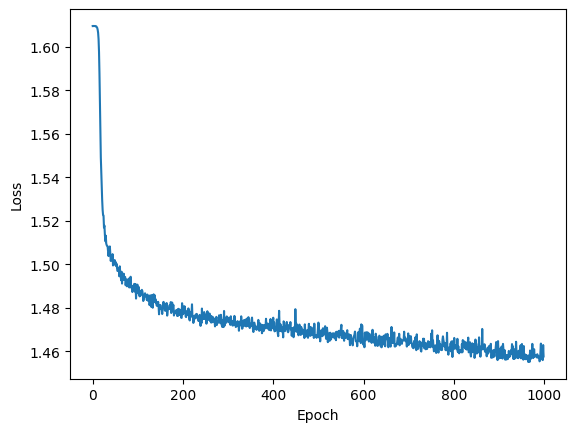

Test accuracy: 466.4288172043011
Accuracy: 0.4189247311827957
Precision: 0.39829855378295953
Recall: 0.415553806939822
F1-score: 0.4015982494239019


Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.38      0.41       495
           1       0.64      0.86      0.74       472
           2       0.28      0.25      0.26       449
           3       0.29      0.33      0.31       463
           4       0.34      0.26      0.29       446

    accuracy                           0.42      2325
   macro avg       0.40      0.42      0.40      2325
weighted avg       0.40      0.42      0.40      2325

                    0           1           2           3           4  \
precision    0.440000    0.642520    0.279302    0.288425    0.341246   
recall       0.377778    0.864407    0.249443    0.328294    0.257848   
f1-score     0.406522    0.737127    0.263529    0.307071    0.293742   
support    495.000000  472.000000  449.000000 

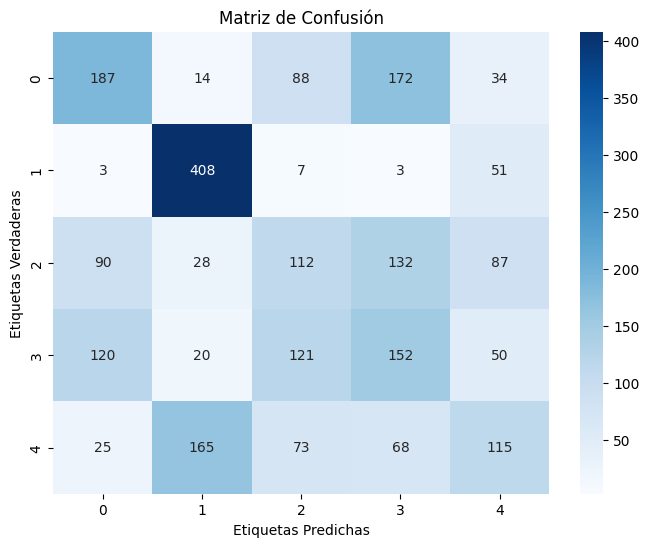

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_1e-05_0.3/resultados_1000_1e-05_0.3.json
Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|                                                               | 1/700 [00:01<19:28,  1.67s/it]

1.6093691264881806


Procesando epocas:   0%|▏                                                              | 2/700 [00:03<19:26,  1.67s/it]

1.6092654424555162


Procesando epocas:   0%|▎                                                              | 3/700 [00:05<19:24,  1.67s/it]

1.6092152560458464


Procesando epocas:   1%|▎                                                              | 4/700 [00:06<19:22,  1.67s/it]

1.607772190430585


Procesando epocas:   1%|▍                                                              | 5/700 [00:08<19:22,  1.67s/it]

1.5848688104573418


Procesando epocas:   1%|▌                                                              | 6/700 [00:10<19:18,  1.67s/it]

1.5393668314989875


Procesando epocas:   1%|▋                                                              | 7/700 [00:11<19:17,  1.67s/it]

1.5234860223882338


Procesando epocas:   1%|▋                                                              | 8/700 [00:13<19:16,  1.67s/it]

1.5212015684913187


Procesando epocas:   1%|▊                                                              | 9/700 [00:15<19:14,  1.67s/it]

1.5106828949030708


Procesando epocas:   1%|▉                                                             | 10/700 [00:16<19:11,  1.67s/it]

1.5107972551794613


Procesando epocas:   2%|▉                                                             | 11/700 [00:18<19:08,  1.67s/it]

1.5080643022761626


Procesando epocas:   2%|█                                                             | 12/700 [00:20<19:08,  1.67s/it]

1.5050714100108427


Procesando epocas:   2%|█▏                                                            | 13/700 [00:21<19:05,  1.67s/it]

1.5058305593097912


Procesando epocas:   2%|█▏                                                            | 14/700 [00:23<19:04,  1.67s/it]

1.504255534620846


Procesando epocas:   2%|█▎                                                            | 15/700 [00:25<19:02,  1.67s/it]

1.5008413749582628


Procesando epocas:   2%|█▍                                                            | 16/700 [00:26<19:03,  1.67s/it]

1.5020290641223684


Procesando epocas:   2%|█▌                                                            | 17/700 [00:28<19:02,  1.67s/it]

1.4979967152371125


Procesando epocas:   3%|█▌                                                            | 18/700 [00:30<19:01,  1.67s/it]

1.4966424850856557


Procesando epocas:   3%|█▋                                                            | 19/700 [00:31<18:58,  1.67s/it]

1.4995202534339007


Procesando epocas:   3%|█▊                                                            | 20/700 [00:33<18:57,  1.67s/it]

1.501221142095678


Procesando epocas:   3%|█▊                                                            | 21/700 [00:35<18:55,  1.67s/it]

1.4967855348306545


Procesando epocas:   3%|█▉                                                            | 22/700 [00:36<18:54,  1.67s/it]

1.4957113041597254


Procesando epocas:   3%|██                                                            | 23/700 [00:38<18:54,  1.68s/it]

1.4940757905735689


Procesando epocas:   3%|██▏                                                           | 24/700 [00:40<18:50,  1.67s/it]

1.4973710347624387


Procesando epocas:   4%|██▏                                                           | 25/700 [00:41<18:49,  1.67s/it]

1.5014175464125241


Procesando epocas:   4%|██▎                                                           | 26/700 [00:43<18:47,  1.67s/it]

1.4951398253440857


Procesando epocas:   4%|██▍                                                           | 27/700 [00:45<18:44,  1.67s/it]

1.4978600200484782


Procesando epocas:   4%|██▍                                                           | 28/700 [00:46<18:44,  1.67s/it]

1.4963866135653328


Procesando epocas:   4%|██▌                                                           | 29/700 [00:48<18:40,  1.67s/it]

1.4952185560675229


Procesando epocas:   4%|██▋                                                           | 30/700 [00:50<18:40,  1.67s/it]

1.4927231956930722


Procesando epocas:   4%|██▋                                                           | 31/700 [00:51<18:37,  1.67s/it]

1.4912941322607152


Procesando epocas:   5%|██▊                                                           | 32/700 [00:53<18:50,  1.69s/it]

1.4911228768965776


Procesando epocas:   5%|██▉                                                           | 33/700 [00:55<18:58,  1.71s/it]

1.4916579744395089


Procesando epocas:   5%|███                                                           | 34/700 [00:57<19:04,  1.72s/it]

1.490162565427668


Procesando epocas:   5%|███                                                           | 35/700 [00:58<19:06,  1.72s/it]

1.488682045656092


Procesando epocas:   5%|███▏                                                          | 36/700 [01:00<19:08,  1.73s/it]

1.49093618182575


Procesando epocas:   5%|███▎                                                          | 37/700 [01:02<19:11,  1.74s/it]

1.4941123289220473


Procesando epocas:   5%|███▎                                                          | 38/700 [01:04<19:15,  1.75s/it]

1.4977694139761084


Procesando epocas:   6%|███▍                                                          | 39/700 [01:05<19:12,  1.74s/it]

1.4883439337506015


Procesando epocas:   6%|███▌                                                          | 40/700 [01:07<19:13,  1.75s/it]

1.4927942219902488


Procesando epocas:   6%|███▋                                                          | 41/700 [01:09<19:10,  1.75s/it]

1.4859163564794204


Procesando epocas:   6%|███▋                                                          | 42/700 [01:11<19:07,  1.74s/it]

1.4931757008328157


Procesando epocas:   6%|███▊                                                          | 43/700 [01:12<19:06,  1.75s/it]

1.4854909882825964


Procesando epocas:   6%|███▉                                                          | 44/700 [01:14<19:05,  1.75s/it]

1.4875830243615542


Procesando epocas:   6%|███▉                                                          | 45/700 [01:16<19:03,  1.75s/it]

1.493976555852329


Procesando epocas:   7%|████                                                          | 46/700 [01:17<19:01,  1.75s/it]

1.4908177186461056


Procesando epocas:   7%|████▏                                                         | 47/700 [01:19<19:00,  1.75s/it]

1.4911039920414195


Procesando epocas:   7%|████▎                                                         | 48/700 [01:21<18:59,  1.75s/it]

1.4858167220564449


Procesando epocas:   7%|████▎                                                         | 49/700 [01:23<18:58,  1.75s/it]

1.4849030326394475


Procesando epocas:   7%|████▍                                                         | 50/700 [01:24<18:57,  1.75s/it]

1.482885395779329


Procesando epocas:   7%|████▌                                                         | 51/700 [01:26<18:56,  1.75s/it]

1.4872300926376791


Procesando epocas:   7%|████▌                                                         | 52/700 [01:28<18:54,  1.75s/it]

1.4917973883011761


Procesando epocas:   8%|████▋                                                         | 53/700 [01:30<18:54,  1.75s/it]

1.4851172685623169


Procesando epocas:   8%|████▊                                                         | 54/700 [01:32<18:53,  1.75s/it]

1.48441003000035


Procesando epocas:   8%|████▊                                                         | 55/700 [01:33<18:51,  1.75s/it]

1.484493947730345


Procesando epocas:   8%|████▉                                                         | 56/700 [01:35<18:49,  1.75s/it]

1.4833408243515913


Procesando epocas:   8%|█████                                                         | 57/700 [01:37<18:48,  1.75s/it]

1.4846105757881614


Procesando epocas:   8%|█████▏                                                        | 58/700 [01:39<18:46,  1.75s/it]

1.4834703080794391


Procesando epocas:   8%|█████▏                                                        | 59/700 [01:40<18:44,  1.75s/it]

1.4827216197462643


Procesando epocas:   9%|█████▎                                                        | 60/700 [01:42<18:43,  1.76s/it]

1.4850448215709013


Procesando epocas:   9%|█████▍                                                        | 61/700 [01:44<18:41,  1.75s/it]

1.48187237627366


Procesando epocas:   9%|█████▍                                                        | 62/700 [01:46<18:39,  1.75s/it]

1.490312970385832


Procesando epocas:   9%|█████▌                                                        | 63/700 [01:47<18:33,  1.75s/it]

1.4814020830042223


Procesando epocas:   9%|█████▋                                                        | 64/700 [01:49<18:25,  1.74s/it]

1.4864268990123972


Procesando epocas:   9%|█████▊                                                        | 65/700 [01:51<18:19,  1.73s/it]

1.484163724674898


Procesando epocas:   9%|█████▊                                                        | 66/700 [01:52<18:16,  1.73s/it]

1.4814309155239778


Procesando epocas:  10%|█████▉                                                        | 67/700 [01:54<18:10,  1.72s/it]

1.4834481365540448


Procesando epocas:  10%|██████                                                        | 68/700 [01:56<18:07,  1.72s/it]

1.4822543074102963


Procesando epocas:  10%|██████                                                        | 69/700 [01:58<18:04,  1.72s/it]

1.4792729875620674


Procesando epocas:  10%|██████▏                                                       | 70/700 [01:59<18:03,  1.72s/it]

1.4849817745825824


Procesando epocas:  10%|██████▎                                                       | 71/700 [02:01<18:00,  1.72s/it]

1.4801595463472255


Procesando epocas:  10%|██████▍                                                       | 72/700 [02:03<17:57,  1.72s/it]

1.4875602091059965


Procesando epocas:  10%|██████▍                                                       | 73/700 [02:04<17:56,  1.72s/it]

1.4787945607129265


Procesando epocas:  11%|██████▌                                                       | 74/700 [02:06<17:57,  1.72s/it]

1.4811704432263093


Procesando epocas:  11%|██████▋                                                       | 75/700 [02:08<17:54,  1.72s/it]

1.4884279223049388


Procesando epocas:  11%|██████▋                                                       | 76/700 [02:10<17:53,  1.72s/it]

1.4829683458103853


Procesando epocas:  11%|██████▊                                                       | 77/700 [02:11<17:52,  1.72s/it]

1.4795400563408347


Procesando epocas:  11%|██████▉                                                       | 78/700 [02:13<17:50,  1.72s/it]

1.4801104187965393


Procesando epocas:  11%|██████▉                                                       | 79/700 [02:15<17:47,  1.72s/it]

1.478159950060003


Procesando epocas:  11%|███████                                                       | 80/700 [02:16<17:44,  1.72s/it]

1.4797364234924317


Procesando epocas:  12%|███████▏                                                      | 81/700 [02:18<17:42,  1.72s/it]

1.476342224373537


Procesando epocas:  12%|███████▎                                                      | 82/700 [02:20<17:41,  1.72s/it]

1.4779128256966085


Procesando epocas:  12%|███████▎                                                      | 83/700 [02:22<17:41,  1.72s/it]

1.47884759201723


Procesando epocas:  12%|███████▍                                                      | 84/700 [02:23<17:39,  1.72s/it]

1.4810625426909503


Procesando epocas:  12%|███████▌                                                      | 85/700 [02:25<17:38,  1.72s/it]

1.4853198640486773


Procesando epocas:  12%|███████▌                                                      | 86/700 [02:27<17:34,  1.72s/it]

1.4833306207376369


Procesando epocas:  12%|███████▋                                                      | 87/700 [02:29<17:33,  1.72s/it]

1.4806292330517488


Procesando epocas:  13%|███████▊                                                      | 88/700 [02:30<17:32,  1.72s/it]

1.4831779409857357


Procesando epocas:  13%|███████▉                                                      | 89/700 [02:32<17:32,  1.72s/it]

1.4821673358187957


Procesando epocas:  13%|███████▉                                                      | 90/700 [02:34<17:30,  1.72s/it]

1.479009802902446


Procesando epocas:  13%|████████                                                      | 91/700 [02:35<17:23,  1.71s/it]

1.490426522843978


Procesando epocas:  13%|████████▏                                                     | 92/700 [02:37<17:21,  1.71s/it]

1.474719287367428


Procesando epocas:  13%|████████▏                                                     | 93/700 [02:39<17:18,  1.71s/it]

1.4753235003527474


Procesando epocas:  13%|████████▎                                                     | 94/700 [02:40<17:12,  1.70s/it]

1.4755609000430387


Procesando epocas:  14%|████████▍                                                     | 95/700 [02:42<17:05,  1.69s/it]

1.4785944791401133


Procesando epocas:  14%|████████▌                                                     | 96/700 [02:44<16:56,  1.68s/it]

1.4800127050455878


Procesando epocas:  14%|████████▌                                                     | 97/700 [02:45<16:50,  1.68s/it]

1.4787354104659136


Procesando epocas:  14%|████████▋                                                     | 98/700 [02:47<16:45,  1.67s/it]

1.4794345406924978


Procesando epocas:  14%|████████▊                                                     | 99/700 [02:49<16:42,  1.67s/it]

1.475559462519253


Procesando epocas:  14%|████████▋                                                    | 100/700 [02:50<16:40,  1.67s/it]

1.4813630924505345


Procesando epocas:  14%|████████▊                                                    | 101/700 [02:52<16:36,  1.66s/it]

1.4773591833956101


Procesando epocas:  15%|████████▉                                                    | 102/700 [02:54<16:35,  1.67s/it]

1.4755959475741667


Procesando epocas:  15%|████████▉                                                    | 103/700 [02:55<16:31,  1.66s/it]

1.4723441250184004


Procesando epocas:  15%|█████████                                                    | 104/700 [02:57<16:29,  1.66s/it]

1.474235713481903


Procesando epocas:  15%|█████████▏                                                   | 105/700 [02:59<16:29,  1.66s/it]

1.4749399030909818


Procesando epocas:  15%|█████████▏                                                   | 106/700 [03:00<16:28,  1.66s/it]

1.4765239610391505


Procesando epocas:  15%|█████████▎                                                   | 107/700 [03:02<16:24,  1.66s/it]

1.4738808786167819


Procesando epocas:  15%|█████████▍                                                   | 108/700 [03:04<16:24,  1.66s/it]

1.482689093842226


Procesando epocas:  16%|█████████▍                                                   | 109/700 [03:05<16:21,  1.66s/it]

1.4704469393281376


Procesando epocas:  16%|█████████▌                                                   | 110/700 [03:07<16:21,  1.66s/it]

1.473589117386762


Procesando epocas:  16%|█████████▋                                                   | 111/700 [03:09<16:17,  1.66s/it]

1.472158725121442


Procesando epocas:  16%|█████████▊                                                   | 112/700 [03:10<16:17,  1.66s/it]

1.475594901337343


Procesando epocas:  16%|█████████▊                                                   | 113/700 [03:12<16:16,  1.66s/it]

1.4731502546983606


Procesando epocas:  16%|█████████▉                                                   | 114/700 [03:14<16:14,  1.66s/it]

1.4696132652899798


Procesando epocas:  16%|██████████                                                   | 115/700 [03:15<16:11,  1.66s/it]

1.4760786344023311


Procesando epocas:  17%|██████████                                                   | 116/700 [03:17<16:09,  1.66s/it]

1.4760573667638441


Procesando epocas:  17%|██████████▏                                                  | 117/700 [03:19<16:07,  1.66s/it]

1.472346970614265


Procesando epocas:  17%|██████████▎                                                  | 118/700 [03:20<16:06,  1.66s/it]

1.4698222139302421


Procesando epocas:  17%|██████████▎                                                  | 119/700 [03:22<16:06,  1.66s/it]

1.4710271449650034


Procesando epocas:  17%|██████████▍                                                  | 120/700 [03:24<16:07,  1.67s/it]

1.4724424888105954


Procesando epocas:  17%|██████████▌                                                  | 121/700 [03:25<16:04,  1.67s/it]

1.477235661534702


Procesando epocas:  17%|██████████▋                                                  | 122/700 [03:27<16:02,  1.67s/it]

1.4703913906041313


Procesando epocas:  18%|██████████▋                                                  | 123/700 [03:29<15:56,  1.66s/it]

1.4701318256995257


Procesando epocas:  18%|██████████▊                                                  | 124/700 [03:30<15:52,  1.65s/it]

1.470807147727293


Procesando epocas:  18%|██████████▉                                                  | 125/700 [03:32<15:47,  1.65s/it]

1.4719042462461136


Procesando epocas:  18%|██████████▉                                                  | 126/700 [03:34<15:44,  1.65s/it]

1.4740860714631923


Procesando epocas:  18%|███████████                                                  | 127/700 [03:35<15:42,  1.64s/it]

1.470624224578633


Procesando epocas:  18%|███████████▏                                                 | 128/700 [03:37<15:39,  1.64s/it]

1.4752300087143393


Procesando epocas:  18%|███████████▏                                                 | 129/700 [03:39<15:36,  1.64s/it]

1.4722552299499512


Procesando epocas:  19%|███████████▎                                                 | 130/700 [03:40<15:33,  1.64s/it]

1.4701259542913998


Procesando epocas:  19%|███████████▍                                                 | 131/700 [03:42<15:31,  1.64s/it]

1.4739161133766174


Procesando epocas:  19%|███████████▌                                                 | 132/700 [03:43<15:30,  1.64s/it]

1.4704555139822117


Procesando epocas:  19%|███████████▌                                                 | 133/700 [03:45<15:29,  1.64s/it]

1.4667976351345287


Procesando epocas:  19%|███████████▋                                                 | 134/700 [03:47<15:27,  1.64s/it]

1.469542084721958


Procesando epocas:  19%|███████████▊                                                 | 135/700 [03:48<15:26,  1.64s/it]

1.4709832121344173


Procesando epocas:  19%|███████████▊                                                 | 136/700 [03:50<15:24,  1.64s/it]

1.4669911026954652


Procesando epocas:  20%|███████████▉                                                 | 137/700 [03:52<15:21,  1.64s/it]

1.4715346981497373


Procesando epocas:  20%|████████████                                                 | 138/700 [03:53<15:20,  1.64s/it]

1.4678935661035426


Procesando epocas:  20%|████████████                                                 | 139/700 [03:55<15:17,  1.64s/it]

1.4675182700157166


Procesando epocas:  20%|████████████▏                                                | 140/700 [03:57<15:18,  1.64s/it]

1.467745621765361


Procesando epocas:  20%|████████████▎                                                | 141/700 [03:58<15:13,  1.63s/it]

1.4714402212816127


Procesando epocas:  20%|████████████▎                                                | 142/700 [04:00<15:12,  1.64s/it]

1.4752980288337258


Procesando epocas:  20%|████████████▍                                                | 143/700 [04:01<15:11,  1.64s/it]

1.4655490720973294


Procesando epocas:  21%|████████████▌                                                | 144/700 [04:03<15:10,  1.64s/it]

1.4719827098004958


Procesando epocas:  21%|████████████▋                                                | 145/700 [04:05<15:09,  1.64s/it]

1.4681033225620495


Procesando epocas:  21%|████████████▋                                                | 146/700 [04:06<15:14,  1.65s/it]

1.462036517788382


Procesando epocas:  21%|████████████▊                                                | 147/700 [04:08<15:18,  1.66s/it]

1.4687048154718736


Procesando epocas:  21%|████████████▉                                                | 148/700 [04:10<15:20,  1.67s/it]

1.462493926637313


Procesando epocas:  21%|████████████▉                                                | 149/700 [04:11<15:21,  1.67s/it]

1.4660598228959476


Procesando epocas:  21%|█████████████                                                | 150/700 [04:13<15:23,  1.68s/it]

1.4661298394203186


Procesando epocas:  22%|█████████████▏                                               | 151/700 [04:15<15:22,  1.68s/it]

1.4701330437379725


Procesando epocas:  22%|█████████████▏                                               | 152/700 [04:17<15:20,  1.68s/it]

1.4642432801863727


Procesando epocas:  22%|█████████████▎                                               | 153/700 [04:18<15:17,  1.68s/it]

1.4694827949299532


Procesando epocas:  22%|█████████████▍                                               | 154/700 [04:20<15:30,  1.70s/it]

1.470094572796541


Procesando epocas:  22%|█████████████▌                                               | 155/700 [04:22<15:37,  1.72s/it]

1.468778115861556


Procesando epocas:  22%|█████████████▌                                               | 156/700 [04:23<15:40,  1.73s/it]

1.4666636039229


Procesando epocas:  22%|█████████████▋                                               | 157/700 [04:25<15:42,  1.74s/it]

1.4761563862071319


Procesando epocas:  23%|█████████████▊                                               | 158/700 [04:27<15:44,  1.74s/it]

1.4661214604097255


Procesando epocas:  23%|█████████████▊                                               | 159/700 [04:29<15:45,  1.75s/it]

1.462748749817119


Procesando epocas:  23%|█████████████▉                                               | 160/700 [04:30<15:45,  1.75s/it]

1.4619132595903732


Procesando epocas:  23%|██████████████                                               | 161/700 [04:32<15:45,  1.75s/it]

1.4639865244136137


Procesando epocas:  23%|██████████████                                               | 162/700 [04:34<15:44,  1.76s/it]

1.4644191103823045


Procesando epocas:  23%|██████████████▏                                              | 163/700 [04:36<15:43,  1.76s/it]

1.4708835244178773


Procesando epocas:  23%|██████████████▎                                              | 164/700 [04:38<15:41,  1.76s/it]

1.4659092342152316


Procesando epocas:  24%|██████████████▍                                              | 165/700 [04:39<15:39,  1.76s/it]

1.4628395368071163


Procesando epocas:  24%|██████████████▍                                              | 166/700 [04:41<15:36,  1.75s/it]

1.4646258669741012


Procesando epocas:  24%|██████████████▌                                              | 167/700 [04:43<15:35,  1.75s/it]

1.462391179449418


Procesando epocas:  24%|██████████████▋                                              | 168/700 [04:45<15:33,  1.75s/it]

1.4675510441555697


Procesando epocas:  24%|██████████████▋                                              | 169/700 [04:46<15:32,  1.76s/it]

1.4679848972488851


Procesando epocas:  24%|██████████████▊                                              | 170/700 [04:48<15:31,  1.76s/it]

1.466724254103268


Procesando epocas:  24%|██████████████▉                                              | 171/700 [04:50<15:30,  1.76s/it]

1.4657839214100556


Procesando epocas:  25%|██████████████▉                                              | 172/700 [04:52<15:28,  1.76s/it]

1.4662591723834768


Procesando epocas:  25%|███████████████                                              | 173/700 [04:53<15:26,  1.76s/it]

1.461588002653683


Procesando epocas:  25%|███████████████▏                                             | 174/700 [04:55<15:25,  1.76s/it]

1.4603819664786843


Procesando epocas:  25%|███████████████▎                                             | 175/700 [04:57<15:24,  1.76s/it]

1.4633750726194943


Procesando epocas:  25%|███████████████▎                                             | 176/700 [04:59<15:23,  1.76s/it]

1.4699766285279219


Procesando epocas:  25%|███████████████▍                                             | 177/700 [05:00<15:20,  1.76s/it]

1.4616678981220022


Procesando epocas:  25%|███████████████▌                                             | 178/700 [05:02<15:18,  1.76s/it]

1.4694327193147996


Procesando epocas:  26%|███████████████▌                                             | 179/700 [05:04<15:17,  1.76s/it]

1.4651259232969844


Procesando epocas:  26%|███████████████▋                                             | 180/700 [05:06<15:15,  1.76s/it]

1.4607865291483262


Procesando epocas:  26%|███████████████▊                                             | 181/700 [05:07<15:10,  1.76s/it]

1.4642331936780144


Procesando epocas:  26%|███████████████▊                                             | 182/700 [05:09<15:10,  1.76s/it]

1.4581905869876637


Procesando epocas:  26%|███████████████▉                                             | 183/700 [05:11<15:06,  1.75s/it]

1.4654230559573453


Procesando epocas:  26%|████████████████                                             | 184/700 [05:13<15:05,  1.75s/it]

1.459142755059635


Procesando epocas:  26%|████████████████                                             | 185/700 [05:14<14:58,  1.74s/it]

1.4589171725160934


Procesando epocas:  27%|████████████████▏                                            | 186/700 [05:16<14:54,  1.74s/it]

1.4631018309032215


Procesando epocas:  27%|████████████████▎                                            | 187/700 [05:18<14:49,  1.73s/it]

1.4603253280415254


Procesando epocas:  27%|████████████████▍                                            | 188/700 [05:20<14:45,  1.73s/it]

1.458230501763961


Procesando epocas:  27%|████████████████▍                                            | 189/700 [05:21<14:42,  1.73s/it]

1.4586977201349596


Procesando epocas:  27%|████████████████▌                                            | 190/700 [05:23<14:39,  1.72s/it]

1.4604379036847284


Procesando epocas:  27%|████████████████▋                                            | 191/700 [05:25<14:35,  1.72s/it]

1.4677772255504833


Procesando epocas:  27%|████████████████▋                                            | 192/700 [05:26<14:33,  1.72s/it]

1.4617069475791034


Procesando epocas:  28%|████████████████▊                                            | 193/700 [05:28<14:29,  1.72s/it]

1.46453976280549


Procesando epocas:  28%|████████████████▉                                            | 194/700 [05:30<14:26,  1.71s/it]

1.4560706825817333


Procesando epocas:  28%|████████████████▉                                            | 195/700 [05:32<14:24,  1.71s/it]

1.471753064323874


Procesando epocas:  28%|█████████████████                                            | 196/700 [05:33<14:22,  1.71s/it]

1.4574179467032937


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [05:35<14:20,  1.71s/it]

1.460746718154234


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [05:37<14:16,  1.71s/it]

1.4598392626818488


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [05:38<14:16,  1.71s/it]

1.459732205727521


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [05:40<14:16,  1.71s/it]

1.4571301916066337


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [05:42<14:13,  1.71s/it]

1.465080549436457


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [05:43<14:10,  1.71s/it]

1.4612130073940053


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [05:45<14:08,  1.71s/it]

1.457793061172261


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [05:47<14:07,  1.71s/it]

1.4648797448943642


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [05:49<14:06,  1.71s/it]

1.4603257978663724


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [05:50<14:04,  1.71s/it]

1.4557220038245706


Procesando epocas:  30%|██████████████████                                           | 207/700 [05:52<14:02,  1.71s/it]

1.4606887768296635


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [05:54<13:58,  1.71s/it]

1.462160440753488


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [05:55<13:58,  1.71s/it]

1.462907618634841


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [05:57<13:56,  1.71s/it]

1.4553307175636292


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [05:59<13:53,  1.70s/it]

1.4591313137727626


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [06:01<13:50,  1.70s/it]

1.4611647921449997


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [06:02<13:43,  1.69s/it]

1.4612028206095975


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [06:04<13:41,  1.69s/it]

1.4585929975790135


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [06:06<13:38,  1.69s/it]

1.4547916433390449


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [06:07<13:37,  1.69s/it]

1.4636120999560636


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [06:09<13:35,  1.69s/it]

1.4603940984782051


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [06:11<13:32,  1.69s/it]

1.451193714843077


Procesando epocas:  31%|███████████████████                                          | 219/700 [06:12<13:30,  1.69s/it]

1.4609247425023246


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [06:14<13:29,  1.69s/it]

1.4548139691352844


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [06:16<13:27,  1.69s/it]

1.4604304264573489


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [06:17<13:26,  1.69s/it]

1.4593660522909726


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [06:19<13:24,  1.69s/it]

1.4548762531841501


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [06:21<13:23,  1.69s/it]

1.4561595608206357


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [06:22<13:20,  1.69s/it]

1.4621997110983904


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [06:24<13:19,  1.69s/it]

1.4510453946450177


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [06:26<13:18,  1.69s/it]

1.4492178804734175


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [06:28<13:16,  1.69s/it]

1.4510701530119952


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [06:29<13:13,  1.68s/it]

1.4512797054122477


Procesando epocas:  33%|████████████████████                                         | 230/700 [06:31<13:11,  1.68s/it]

1.4548635861452888


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [06:33<13:10,  1.69s/it]

1.4518552717040567


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [06:34<13:10,  1.69s/it]

1.4559473809073953


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [06:36<13:08,  1.69s/it]

1.454786223523757


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [06:38<13:07,  1.69s/it]

1.4711635070688585


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [06:39<13:03,  1.69s/it]

1.453750320743112


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [06:41<13:00,  1.68s/it]

1.4518377177855548


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [06:43<12:59,  1.68s/it]

1.4465191869174734


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [06:44<12:57,  1.68s/it]

1.4490004336132722


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [06:46<12:56,  1.68s/it]

1.4574650196468129


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [06:48<12:54,  1.68s/it]

1.455907708757064


Procesando epocas:  34%|█████████████████████                                        | 241/700 [06:49<12:54,  1.69s/it]

1.4484628144432516


Procesando epocas:  35%|█████████████████████                                        | 242/700 [06:51<12:54,  1.69s/it]

1.4546704460592832


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [06:53<12:52,  1.69s/it]

1.4467071547227748


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [06:55<12:51,  1.69s/it]

1.4477577384780436


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [06:56<12:48,  1.69s/it]

1.4488571216078365


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [06:58<12:46,  1.69s/it]

1.451082883161657


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [07:00<12:45,  1.69s/it]

1.4452455829171573


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [07:01<12:42,  1.69s/it]

1.4569170054267435


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [07:03<12:40,  1.69s/it]

1.4537833417163175


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [07:05<12:38,  1.69s/it]

1.4509254946428187


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [07:06<12:38,  1.69s/it]

1.4566349793882931


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [07:08<12:36,  1.69s/it]

1.4573380203808055


Procesando epocas:  36%|██████████████████████                                       | 253/700 [07:10<12:34,  1.69s/it]

1.4530991210657007


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [07:11<12:32,  1.69s/it]

1.4522680317654328


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [07:13<12:30,  1.69s/it]

1.448180060526904


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [07:15<12:28,  1.69s/it]

1.4559483899789698


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [07:16<12:26,  1.69s/it]

1.4451001889565411


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [07:18<12:26,  1.69s/it]

1.4431875425226548


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [07:20<12:24,  1.69s/it]

1.4505170745008131


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [07:22<12:22,  1.69s/it]

1.4470162889536688


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [07:23<12:20,  1.69s/it]

1.4569240037132711


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [07:25<12:19,  1.69s/it]

1.445617980115554


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [07:27<12:17,  1.69s/it]

1.4460446105283848


Procesando epocas:  38%|███████████████████████                                      | 264/700 [07:28<12:16,  1.69s/it]

1.4403303553076352


Procesando epocas:  38%|███████████████████████                                      | 265/700 [07:30<12:13,  1.69s/it]

1.4507009008351495


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [07:32<12:12,  1.69s/it]

1.4465257574530208


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [07:33<12:11,  1.69s/it]

1.4511684817426345


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [07:35<12:09,  1.69s/it]

1.445852298596326


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [07:37<12:07,  1.69s/it]

1.443162385155173


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [07:38<12:05,  1.69s/it]

1.444701002625858


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [07:40<12:04,  1.69s/it]

1.448217133213492


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [07:42<12:02,  1.69s/it]

1.4478561913265902


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [07:43<12:00,  1.69s/it]

1.4519802836810842


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [07:45<11:59,  1.69s/it]

1.455886368190541


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [07:47<11:57,  1.69s/it]

1.4434940597590278


Procesando epocas:  39%|████████████████████████                                     | 276/700 [07:49<12:03,  1.71s/it]

1.4472654868574704


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [07:50<12:08,  1.72s/it]

1.4431091000052059


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [07:52<12:10,  1.73s/it]

1.4502598636290607


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [07:54<12:10,  1.74s/it]

1.449495450889363


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [07:56<12:10,  1.74s/it]

1.4421447382253758


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [07:57<12:10,  1.74s/it]

1.4460473642629736


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [07:59<12:09,  1.75s/it]

1.445973509199479


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [08:01<12:09,  1.75s/it]

1.4518025594599107


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [08:03<12:08,  1.75s/it]

1.446703284628251


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [08:04<12:06,  1.75s/it]

1.441677981264451


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [08:06<12:05,  1.75s/it]

1.4430895202300127


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [08:08<12:03,  1.75s/it]

1.4445974202717051


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [08:10<12:02,  1.75s/it]

1.4507480340845444


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [08:11<11:58,  1.75s/it]

1.4530604018884548


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [08:13<11:55,  1.74s/it]

1.442453920841217


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [08:15<11:50,  1.74s/it]

1.4439237258013558


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [08:17<11:46,  1.73s/it]

1.4397567657863393


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [08:18<11:43,  1.73s/it]

1.4632289676105275


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [08:20<11:39,  1.72s/it]

1.453168492457446


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [08:22<11:38,  1.73s/it]

1.4492876641890582


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [08:23<11:36,  1.72s/it]

1.440468625461354


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [08:25<11:35,  1.73s/it]

1.451391217287849


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [08:27<11:33,  1.73s/it]

1.4464322868515462


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [08:29<11:31,  1.72s/it]

1.4461796515128191


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [08:30<11:30,  1.73s/it]

1.4508040098582997


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [08:32<11:28,  1.73s/it]

1.4457809518365299


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [08:34<11:24,  1.72s/it]

1.447860721279593


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [08:35<11:23,  1.72s/it]

1.4474061348859002


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [08:37<11:20,  1.72s/it]

1.4468705506885753


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [08:39<11:20,  1.72s/it]

1.4502566968693453


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [08:41<11:17,  1.72s/it]

1.4452028723324046


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [08:42<11:13,  1.71s/it]

1.4480421472998226


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [08:44<11:06,  1.70s/it]

1.4421535877620473


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [08:46<11:02,  1.69s/it]

1.445610480448779


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [08:47<11:02,  1.70s/it]

1.4431749617352205


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [08:49<10:56,  1.69s/it]

1.4520682117518258


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [08:51<10:55,  1.69s/it]

1.4449031956055585


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [08:52<10:53,  1.69s/it]

1.441623915644253


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [08:54<10:52,  1.69s/it]

1.4440816837198593


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [08:56<10:51,  1.69s/it]

1.4480404075454263


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [08:58<10:49,  1.69s/it]

1.4414380220805898


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [08:59<10:47,  1.69s/it]

1.445397740953109


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [09:01<10:45,  1.69s/it]

1.4432514660498674


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [09:03<10:44,  1.69s/it]

1.4408572954290053


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [09:04<10:43,  1.69s/it]

1.4454569031210507


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [09:06<10:40,  1.69s/it]

1.4457657596644233


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [09:08<10:39,  1.69s/it]

1.4389532678267536


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [09:09<10:38,  1.69s/it]

1.4443264849045698


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [09:11<10:37,  1.69s/it]

1.4444077540846432


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [09:13<10:34,  1.69s/it]

1.4376518088228563


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [09:14<10:34,  1.70s/it]

1.4472657449105206


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [09:16<10:31,  1.69s/it]

1.4459185761563917


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [09:18<10:23,  1.68s/it]

1.4344500864253324


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [09:19<09:28,  1.53s/it]

1.441770887374878


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [09:21<09:45,  1.58s/it]

1.4462209925932044


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [09:22<09:55,  1.61s/it]

1.441974151134491


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [09:24<10:04,  1.64s/it]

1.4435317880967085


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [09:26<10:08,  1.66s/it]

1.4530819177627563


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [09:27<10:06,  1.66s/it]

1.4418823571766124


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [09:29<10:04,  1.66s/it]

1.4396149158477782


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [09:31<10:03,  1.66s/it]

1.4377943010891185


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [09:32<10:00,  1.66s/it]

1.4455380790373857


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [09:34<10:00,  1.66s/it]

1.445238454201642


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [09:36<09:59,  1.66s/it]

1.4456486926359289


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [09:37<09:57,  1.66s/it]

1.441162859692293


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [09:39<09:59,  1.67s/it]

1.444800547992482


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [09:41<10:00,  1.68s/it]

1.4450654338387883


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [09:42<10:00,  1.68s/it]

1.441139817237854


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [09:44<10:00,  1.69s/it]

1.4441678790485157


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [09:46<09:58,  1.69s/it]

1.4454097467310287


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [09:48<09:56,  1.69s/it]

1.4391465081888086


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [09:49<09:57,  1.69s/it]

1.437590547168956


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [09:51<09:56,  1.69s/it]

1.4409825801849365


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [09:53<09:54,  1.69s/it]

1.4452951298040502


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [09:54<09:52,  1.69s/it]

1.4386513310320237


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [09:56<09:50,  1.69s/it]

1.4395880467751447


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [09:58<09:50,  1.70s/it]

1.437500347810633


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [09:59<09:46,  1.69s/it]

1.4428037937949685


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [10:01<09:44,  1.69s/it]

1.438625015931971


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [10:03<09:42,  1.69s/it]

1.4467970932231229


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [10:04<09:41,  1.69s/it]

1.4428774602272931


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [10:06<09:40,  1.69s/it]

1.4429494275766261


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [10:08<09:40,  1.70s/it]

1.4380966943853042


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [10:10<09:39,  1.70s/it]

1.4393103031551138


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [10:11<09:37,  1.70s/it]

1.4425902443773606


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [10:13<09:34,  1.70s/it]

1.4433072412715238


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [10:15<09:34,  1.70s/it]

1.4436742747531217


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [10:16<09:32,  1.70s/it]

1.442005015822018


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [10:18<09:30,  1.70s/it]

1.453040868394515


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [10:20<09:29,  1.70s/it]

1.4427582817919113


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [10:21<09:26,  1.70s/it]

1.4400668873506435


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [10:23<09:24,  1.69s/it]

1.4499361529069787


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [10:25<09:21,  1.69s/it]

1.4409969007267671


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [10:26<09:18,  1.69s/it]

1.4383136482799754


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [10:28<09:17,  1.69s/it]

1.4405419693273656


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [10:30<09:15,  1.69s/it]

1.4405004389145795


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [10:32<09:12,  1.68s/it]

1.4466953999855938


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [10:33<09:10,  1.68s/it]

1.4420105071628795


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [10:35<09:07,  1.68s/it]

1.4406059931306279


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [10:37<09:07,  1.68s/it]

1.4392639784251942


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [10:38<09:05,  1.68s/it]

1.4387226371204151


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [10:40<09:04,  1.69s/it]

1.4359419472077313


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [10:42<09:02,  1.69s/it]

1.4400650669546688


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [10:43<09:00,  1.68s/it]

1.4404099576613483


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [10:45<08:58,  1.68s/it]

1.4377330885213964


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [10:47<08:56,  1.68s/it]

1.4361018370179568


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [10:48<08:55,  1.68s/it]

1.4426373018937952


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [10:50<08:53,  1.68s/it]

1.433293196033029


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [10:52<08:52,  1.68s/it]

1.456773281097412


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [10:53<08:49,  1.68s/it]

1.4335504903512843


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [10:55<08:46,  1.68s/it]

1.433072017922121


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [10:57<08:43,  1.67s/it]

1.4355524778366089


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [10:58<08:41,  1.67s/it]

1.4436657681184657


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [11:00<08:39,  1.67s/it]

1.4484447079546312


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [11:02<08:37,  1.67s/it]

1.4390885521383847


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [11:03<08:36,  1.67s/it]

1.4380199018646689


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [11:05<08:34,  1.67s/it]

1.4428942862678977


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [11:07<08:34,  1.67s/it]

1.436445652036106


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [11:08<08:32,  1.68s/it]

1.4375379176700815


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [11:10<08:30,  1.67s/it]

1.4357402009122513


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [11:12<08:27,  1.67s/it]

1.4342542311724495


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [11:13<08:27,  1.67s/it]

1.4346880975891563


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [11:15<08:32,  1.70s/it]

1.4477832008810605


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [11:17<08:35,  1.71s/it]

1.4411506014711717


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [11:19<08:37,  1.72s/it]

1.4377275424845077


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [11:20<08:37,  1.73s/it]

1.4375733656041763


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [11:22<08:39,  1.74s/it]

1.439917145055883


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [11:24<08:36,  1.74s/it]

1.4446429133415222


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [11:26<08:35,  1.74s/it]

1.4366918108042548


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [11:27<08:34,  1.75s/it]

1.4368133481811074


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [11:29<08:32,  1.74s/it]

1.4404058666790234


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [11:31<08:31,  1.75s/it]

1.437599936653586


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [11:33<08:30,  1.75s/it]

1.4430285327574786


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [11:34<08:29,  1.75s/it]

1.4393989394692814


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [11:36<08:28,  1.75s/it]

1.432490672784693


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [11:38<08:26,  1.75s/it]

1.433591163859648


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [11:40<08:24,  1.75s/it]

1.4404363849583794


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [11:42<08:22,  1.75s/it]

1.4337398451917311


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [11:43<08:20,  1.75s/it]

1.4322104285745059


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [11:45<08:18,  1.75s/it]

1.4398820624631994


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [11:47<08:16,  1.75s/it]

1.4331470005652485


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [11:48<08:14,  1.75s/it]

1.4383449084618511


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [11:50<08:12,  1.75s/it]

1.439975613706252


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [11:52<08:10,  1.75s/it]

1.4372291852446164


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [11:54<08:08,  1.75s/it]

1.4314178214353674


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [11:55<08:06,  1.74s/it]

1.4347519432797151


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [11:57<08:05,  1.75s/it]

1.4360372620470383


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [11:59<08:04,  1.75s/it]

1.436522107965806


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [12:01<08:02,  1.75s/it]

1.4349676391657662


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [12:02<08:00,  1.75s/it]

1.434964424021104


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [12:04<07:59,  1.75s/it]

1.444870412349701


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [12:06<07:57,  1.75s/it]

1.4391682435484494


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [12:08<07:55,  1.75s/it]

1.433569225142984


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [12:09<07:50,  1.74s/it]

1.4358316077905542


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [12:11<07:46,  1.73s/it]

1.4399107827859767


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [12:13<07:43,  1.72s/it]

1.4369841652757982


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [12:15<07:40,  1.72s/it]

1.4434511233778562


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [12:16<07:37,  1.71s/it]

1.438795798666337


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [12:18<07:35,  1.71s/it]

1.43342763115378


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [12:20<07:34,  1.71s/it]

1.4411313309389002


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [12:21<07:31,  1.71s/it]

1.441299289815566


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [12:23<07:30,  1.71s/it]

1.4404241554877337


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [12:25<07:28,  1.71s/it]

1.4323755685020896


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [12:27<07:26,  1.71s/it]

1.437155337894664


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [12:28<07:25,  1.71s/it]

1.4334022472886478


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [12:30<07:24,  1.72s/it]

1.4352765349780812


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [12:32<07:22,  1.72s/it]

1.4447550710509804


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [12:33<07:20,  1.71s/it]

1.4411483021343456


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [12:35<07:18,  1.71s/it]

1.4383642308852251


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [12:37<07:17,  1.71s/it]

1.432428613129784


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [12:39<07:14,  1.71s/it]

1.437840596367331


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [12:40<07:13,  1.71s/it]

1.4423377962673412


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [12:42<07:12,  1.72s/it]

1.4363470428130205


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [12:44<07:11,  1.72s/it]

1.4348164972137003


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [12:45<07:09,  1.72s/it]

1.4461789846420288


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [12:47<07:07,  1.72s/it]

1.4418075919151305


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [12:49<07:06,  1.72s/it]

1.4390648855882533


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [12:51<07:03,  1.72s/it]

1.4361087939318489


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [12:52<07:02,  1.72s/it]

1.4420166471425224


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [12:54<07:00,  1.72s/it]

1.4382410210721632


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [12:56<06:59,  1.72s/it]

1.436528090168448


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [12:57<06:57,  1.72s/it]

1.4336225979468402


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [12:59<06:53,  1.71s/it]

1.4320194041027743


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [13:01<06:50,  1.70s/it]

1.435189139141756


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [13:03<06:48,  1.70s/it]

1.4357177411808688


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [13:04<06:46,  1.70s/it]

1.4329708646325503


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [13:06<06:45,  1.70s/it]

1.43754484092488


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [13:08<06:42,  1.70s/it]

1.4375757953699897


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [13:09<06:41,  1.70s/it]

1.442101319397197


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [13:11<06:38,  1.70s/it]

1.4393764229381785


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [13:13<06:37,  1.70s/it]

1.4341270650134368


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [13:14<06:35,  1.70s/it]

1.4346923477509443


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [13:16<06:33,  1.70s/it]

1.4394306021578172


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [13:18<06:31,  1.70s/it]

1.436269680191489


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [13:19<06:30,  1.70s/it]

1.4300118789953344


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [13:21<06:28,  1.70s/it]

1.432475812294904


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [13:23<06:26,  1.70s/it]

1.4402453773161945


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [13:25<06:25,  1.70s/it]

1.4291320057476269


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [13:26<06:24,  1.70s/it]

1.4372060446178212


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [13:28<06:23,  1.70s/it]

1.4433128111502704


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [13:30<06:21,  1.70s/it]

1.4430578414131614


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [13:31<06:19,  1.70s/it]

1.4306419421644772


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [13:33<06:17,  1.70s/it]

1.4318370202008415


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [13:35<06:15,  1.70s/it]

1.438527061658747


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [13:36<06:14,  1.70s/it]

1.4387390438248129


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [13:38<06:12,  1.70s/it]

1.4398878840839162


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [13:40<06:10,  1.70s/it]

1.4288580789285548


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [13:42<06:07,  1.70s/it]

1.4314941553508533


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [13:43<06:04,  1.69s/it]

1.452861658264609


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [13:45<06:00,  1.68s/it]

1.4336929531658398


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [13:47<05:57,  1.67s/it]

1.4351965827100417


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [13:48<05:56,  1.67s/it]

1.4307846181532915


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [13:50<05:53,  1.67s/it]

1.4351683364194983


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [13:52<05:49,  1.66s/it]

1.435227802220513


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [13:53<05:47,  1.65s/it]

1.4367459248093997


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [13:55<05:45,  1.65s/it]

1.427241996456595


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [13:56<05:42,  1.65s/it]

1.4349583015722387


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [13:58<05:40,  1.65s/it]

1.435832983606002


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [14:00<05:39,  1.65s/it]

1.4359260187429541


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [14:01<05:37,  1.65s/it]

1.4345723776256336


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [14:03<05:35,  1.64s/it]

1.436920752244837


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [14:05<05:33,  1.64s/it]

1.4335290495087119


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [14:06<05:31,  1.64s/it]

1.4352440728860743


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [14:08<05:29,  1.64s/it]

1.435199401659124


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [14:10<05:27,  1.64s/it]

1.4355409741401672


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [14:11<05:25,  1.64s/it]

1.4326143629410688


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [14:13<05:24,  1.64s/it]

1.434619609748616


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [14:14<05:23,  1.64s/it]

1.4290441632270814


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [14:16<05:21,  1.64s/it]

1.4315707564353943


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [14:18<05:20,  1.64s/it]

1.4317760958391077


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [14:19<05:19,  1.65s/it]

1.4353608748492073


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [14:21<05:17,  1.64s/it]

1.434241101321052


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [14:23<05:15,  1.65s/it]

1.4326930473832522


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [14:24<05:14,  1.64s/it]

1.4286322144901051


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [14:26<05:13,  1.65s/it]

1.4276811249115888


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [14:28<05:11,  1.65s/it]

1.4328686672098496


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [14:29<05:09,  1.64s/it]

1.4314687034663032


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [14:31<05:07,  1.65s/it]

1.4266909991993624


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [14:33<05:06,  1.65s/it]

1.4290724992752075


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [14:34<05:04,  1.64s/it]

1.4373898856780107


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [14:36<05:02,  1.64s/it]

1.4315259239252875


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [14:38<05:00,  1.64s/it]

1.4311804673250983


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [14:39<04:58,  1.64s/it]

1.4307273191564223


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [14:41<04:57,  1.64s/it]

1.4315948058577146


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [14:43<05:00,  1.67s/it]

1.4343038958661696


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [14:44<05:02,  1.69s/it]

1.4299922290970297


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [14:46<05:02,  1.70s/it]

1.4279855756198658


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [14:48<05:02,  1.71s/it]

1.4283130253062528


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [14:49<05:01,  1.71s/it]

1.433315749729381


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [14:51<05:00,  1.72s/it]

1.4359796180444606


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [14:53<04:58,  1.72s/it]

1.434403016987969


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [14:55<04:57,  1.72s/it]

1.4314386690364165


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [14:56<04:56,  1.72s/it]

1.4304466815555796


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [14:58<04:55,  1.73s/it]

1.4305754395092234


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [15:00<04:52,  1.72s/it]

1.4311956503812004


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [15:02<04:51,  1.73s/it]

1.432391948559705


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [15:03<04:48,  1.72s/it]

1.430157890740563


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [15:05<04:47,  1.72s/it]

1.4321198807043187


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [15:07<04:46,  1.73s/it]

1.4294773487483754


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [15:08<04:46,  1.74s/it]

1.4372402352445266


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [15:10<04:45,  1.74s/it]

1.4298215557547176


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [15:12<04:44,  1.74s/it]

1.426725410713869


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [15:14<04:43,  1.75s/it]

1.4339498057084925


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [15:15<04:41,  1.75s/it]

1.4331487760824315


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [15:17<04:40,  1.75s/it]

1.42609720510595


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [15:19<04:38,  1.75s/it]

1.4306221646421096


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [15:21<04:37,  1.75s/it]

1.4365855672780206


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [15:22<04:35,  1.75s/it]

1.432647918252384


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [15:24<04:33,  1.75s/it]

1.4355405421818004


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [15:26<04:32,  1.76s/it]

1.4356286462615517


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [15:28<04:30,  1.76s/it]

1.4285841016208425


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [15:30<04:29,  1.76s/it]

1.4295384652474348


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [15:31<04:27,  1.76s/it]

1.4328382520114675


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [15:33<04:25,  1.76s/it]

1.4264188920750338


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [15:35<04:23,  1.76s/it]

1.4265851567773258


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [15:37<04:20,  1.75s/it]

1.424359178543091


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [15:38<04:17,  1.74s/it]

1.4368844053324532


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [15:40<04:14,  1.73s/it]

1.4240447689505185


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [15:42<04:12,  1.73s/it]

1.433240203296437


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [15:43<04:10,  1.73s/it]

1.4345776137183694


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [15:45<04:08,  1.73s/it]

1.4315079836284412


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [15:47<04:06,  1.72s/it]

1.4279386618558099


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [15:49<04:04,  1.72s/it]

1.4264086309601278


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [15:50<04:02,  1.72s/it]

1.4302466715083402


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [15:52<04:00,  1.72s/it]

1.4285670638084411


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [15:54<03:58,  1.72s/it]

1.436300613599665


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [15:55<03:57,  1.72s/it]

1.4292857198154225


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [15:57<03:55,  1.72s/it]

1.4299029932302587


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [15:59<03:53,  1.72s/it]

1.4249370567938862


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [16:01<03:51,  1.72s/it]

1.4385559972594766


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [16:02<03:50,  1.72s/it]

1.430461767841788


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [16:04<03:48,  1.72s/it]

1.422158944606781


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [16:06<03:46,  1.72s/it]

1.4327006704667036


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [16:07<03:45,  1.72s/it]

1.4283277743002947


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [16:09<03:43,  1.72s/it]

1.428902804851532


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [16:11<03:41,  1.72s/it]

1.4302762830958646


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [16:13<03:40,  1.72s/it]

1.4278299780452952


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [16:14<03:38,  1.72s/it]

1.4322358019211714


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [16:16<03:36,  1.72s/it]

1.4232062690398273


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [16:18<03:34,  1.72s/it]

1.4236557462636161


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [16:20<03:33,  1.72s/it]

1.435241851385902


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [16:21<03:31,  1.72s/it]

1.4289429335033192


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [16:23<03:29,  1.71s/it]

1.430333137512207


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [16:25<03:26,  1.71s/it]

1.4425728938158822


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [16:26<03:24,  1.70s/it]

1.4290940004236559


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [16:28<03:21,  1.70s/it]

1.4277257575708278


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [16:30<03:19,  1.69s/it]

1.4245446240200716


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [16:31<03:17,  1.69s/it]

1.4231073049937977


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [16:33<03:15,  1.69s/it]

1.4313978889409233


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [16:35<03:13,  1.68s/it]

1.4255265838959639


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [16:36<03:11,  1.68s/it]

1.4328070079579074


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [16:38<03:10,  1.68s/it]

1.4254483566564673


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [16:40<03:08,  1.69s/it]

1.428962529406828


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [16:41<03:06,  1.68s/it]

1.4302353858947754


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [16:43<03:05,  1.68s/it]

1.4212540416156545


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [16:45<03:03,  1.68s/it]

1.4326850077685187


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [16:47<03:01,  1.68s/it]

1.4243725608376896


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [16:48<02:59,  1.68s/it]

1.4236448042532976


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [16:50<02:57,  1.68s/it]

1.425107296775369


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [16:52<02:56,  1.68s/it]

1.4308762487243203


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [16:53<02:54,  1.68s/it]

1.4230870183776407


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [16:55<02:53,  1.68s/it]

1.426185820383184


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [16:57<02:51,  1.68s/it]

1.427280001079335


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [16:58<02:49,  1.68s/it]

1.4273702179684358


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [17:00<02:47,  1.68s/it]

1.425574211513295


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [17:02<02:46,  1.68s/it]

1.4276414948351244


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [17:03<02:44,  1.68s/it]

1.4273841675590067


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [17:05<02:43,  1.68s/it]

1.423673792446361


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [17:07<02:41,  1.68s/it]

1.4378337635713465


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [17:08<02:40,  1.69s/it]

1.4287398296244005


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [17:10<02:38,  1.69s/it]

1.427771971506231


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [17:12<02:36,  1.69s/it]

1.424342070607578


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [17:13<02:35,  1.69s/it]

1.42552107853048


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [17:15<02:33,  1.69s/it]

1.4339729168835809


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [17:17<02:31,  1.69s/it]

1.4373164015657762


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [17:18<02:29,  1.68s/it]

1.429238328512977


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [17:20<02:27,  1.68s/it]

1.4226862353437086


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [17:22<02:25,  1.68s/it]

1.4270522187737857


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [17:23<02:24,  1.67s/it]

1.4288649594082552


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [17:25<02:22,  1.67s/it]

1.4261235433466295


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [17:27<02:20,  1.67s/it]

1.427782604974859


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [17:28<02:18,  1.67s/it]

1.4207627128152287


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [17:30<02:17,  1.67s/it]

1.4243195996564977


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [17:32<02:15,  1.67s/it]

1.4277840474072625


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [17:34<02:13,  1.67s/it]

1.4255167968132916


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [17:35<02:12,  1.67s/it]

1.421663022742552


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [17:37<02:10,  1.67s/it]

1.422850696479573


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [17:39<02:08,  1.67s/it]

1.4297392648809097


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [17:40<02:06,  1.67s/it]

1.428852245386909


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [17:42<02:05,  1.67s/it]

1.427545549589045


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [17:44<02:03,  1.67s/it]

1.4240982932202957


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [17:45<02:02,  1.68s/it]

1.4252270726596608


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [17:47<02:00,  1.68s/it]

1.4246659454177408


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [17:49<01:58,  1.67s/it]

1.4224886641782872


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [17:50<01:57,  1.68s/it]

1.4248320572516497


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [17:52<01:56,  1.68s/it]

1.4318953486049877


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [17:54<01:54,  1.68s/it]

1.4278518452363855


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [17:55<01:52,  1.68s/it]

1.4274920744054458


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [17:57<01:50,  1.68s/it]

1.430422927351559


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [17:59<01:49,  1.68s/it]

1.4264409577145296


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [18:00<01:47,  1.68s/it]

1.4225530477131114


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [18:02<01:46,  1.68s/it]

1.427291318949531


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [18:04<01:44,  1.68s/it]

1.4267905270352084


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [18:05<01:42,  1.68s/it]

1.424565937238581


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [18:07<01:41,  1.69s/it]

1.432412376123316


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [18:09<01:39,  1.69s/it]

1.429212608758141


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [18:11<01:38,  1.70s/it]

1.4234210659475888


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [18:12<01:37,  1.72s/it]

1.4231305697385002


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [18:14<01:36,  1.73s/it]

1.425838961320765


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [18:16<01:35,  1.73s/it]

1.4305549228892607


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [18:18<01:33,  1.74s/it]

1.4209285455591538


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [18:19<01:32,  1.74s/it]

1.4323959806386162


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [18:21<01:30,  1.75s/it]

1.4289008252760944


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [18:23<01:29,  1.75s/it]

1.4246528337983524


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [18:25<01:27,  1.75s/it]

1.4227354098768796


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [18:26<01:25,  1.75s/it]

1.4228711121222553


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [18:28<01:24,  1.75s/it]

1.4199924917782054


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [18:30<01:22,  1.75s/it]

1.42233547743629


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [18:32<01:20,  1.75s/it]

1.428904774609734


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [18:33<01:18,  1.75s/it]

1.41853891470853


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [18:35<01:16,  1.75s/it]

1.422496778123519


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [18:37<01:15,  1.75s/it]

1.4313010966076571


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [18:39<01:13,  1.75s/it]

1.4251966406317318


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [18:40<01:11,  1.75s/it]

1.4314366165329429


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [18:42<01:10,  1.75s/it]

1.4223649480763603


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [18:44<01:08,  1.76s/it]

1.4279725327211268


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [18:46<01:06,  1.75s/it]

1.4221188804682563


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [18:47<01:04,  1.75s/it]

1.421319861271802


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [18:49<01:03,  1.75s/it]

1.4236792879946092


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [18:51<01:01,  1.75s/it]

1.4239288631607505


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [18:53<00:59,  1.75s/it]

1.4231998934465295


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [18:54<00:57,  1.75s/it]

1.4323560441241545


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [18:56<00:56,  1.75s/it]

1.4267708715270548


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [18:58<00:54,  1.75s/it]

1.4221692407832427


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [19:00<00:52,  1.75s/it]

1.423524608331568


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [19:01<00:50,  1.75s/it]

1.423387763780706


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [19:03<00:48,  1.74s/it]

1.4260817752164954


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [19:05<00:47,  1.75s/it]

1.4223163878216463


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [19:07<00:45,  1.74s/it]

1.4241533580948325


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [19:08<00:43,  1.73s/it]

1.4201094164567836


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [19:10<00:41,  1.72s/it]

1.4261605325867148


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [19:12<00:39,  1.72s/it]

1.4235146543558905


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [19:13<00:37,  1.72s/it]

1.4191891614128562


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [19:15<00:35,  1.71s/it]

1.4242994960616617


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [19:17<00:34,  1.70s/it]

1.4222512974458583


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [19:18<00:32,  1.70s/it]

1.4264436469358557


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [19:20<00:30,  1.70s/it]

1.4232287785586188


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [19:22<00:28,  1.70s/it]

1.4168173888150384


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [19:24<00:27,  1.69s/it]

1.425760506882387


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [19:25<00:25,  1.70s/it]

1.4271316850886626


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [19:27<00:23,  1.70s/it]

1.4196264694718754


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [19:29<00:22,  1.70s/it]

1.4227607439546024


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [19:30<00:20,  1.69s/it]

1.4218464136123656


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [19:32<00:18,  1.70s/it]

1.4198274759685292


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [19:34<00:16,  1.70s/it]

1.417526266154121


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [19:35<00:15,  1.70s/it]

1.4231495324303123


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [19:37<00:13,  1.69s/it]

1.4187279925626868


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [19:39<00:11,  1.69s/it]

1.423237833556007


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [19:40<00:10,  1.69s/it]

1.433551347956938


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [19:42<00:08,  1.69s/it]

1.4220575129284578


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [19:44<00:06,  1.69s/it]

1.4193300829214208


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [19:46<00:05,  1.69s/it]

1.4233679547029383


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [19:47<00:03,  1.69s/it]

1.4278099880498998


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [19:49<00:01,  1.69s/it]

1.4260269613826977


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [19:51<00:00,  1.70s/it]

1.4241105065626256
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_0.0001_0.2/funcion_de_perdida_700_0.0001.png


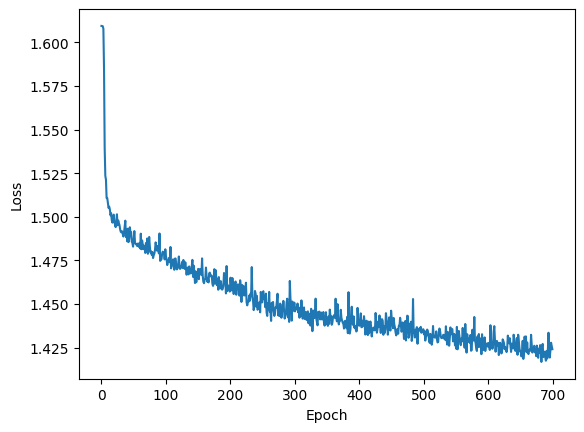

Test accuracy: 470.77032258064514
Accuracy: 0.4253763440860215
Precision: 0.4309877370675707
Recall: 0.4203319609606277
F1-score: 0.416748161422509


Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.58      0.45       495
           1       0.74      0.70      0.72       472
           2       0.30      0.29      0.30       449
           3       0.31      0.26      0.29       463
           4       0.43      0.27      0.34       446

    accuracy                           0.43      2325
   macro avg       0.43      0.42      0.42      2325
weighted avg       0.43      0.43      0.42      2325

                    0           1           2           3           4  \
precision    0.366324    0.736018    0.304147    0.314286    0.434164   
recall       0.575758    0.697034    0.293987    0.261339    0.273543   
f1-score     0.447761    0.715996    0.298981    0.285377    0.335626   
support    495.000000  472.000000  449.000000 

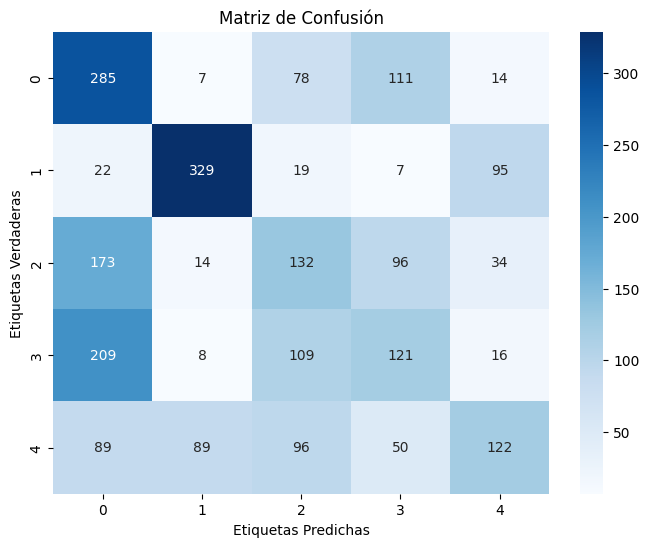

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_0.0001_0.2/resultados_700_0.0001_0.2.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|                                                               | 1/700 [00:01<19:25,  1.67s/it]

1.609601164565367


Procesando epocas:   0%|▏                                                              | 2/700 [00:03<19:20,  1.66s/it]

1.6095678806304932


Procesando epocas:   0%|▎                                                              | 3/700 [00:04<19:18,  1.66s/it]

1.6096593239728143


Procesando epocas:   1%|▎                                                              | 4/700 [00:06<19:15,  1.66s/it]

1.6095749251982745


Procesando epocas:   1%|▍                                                              | 5/700 [00:08<19:13,  1.66s/it]

1.6096681279294631


Procesando epocas:   1%|▌                                                              | 6/700 [00:09<19:11,  1.66s/it]

1.6095031647121205


Procesando epocas:   1%|▋                                                              | 7/700 [00:11<19:09,  1.66s/it]

1.6094753097085392


Procesando epocas:   1%|▋                                                              | 8/700 [00:13<19:05,  1.66s/it]

1.6094957940718706


Procesando epocas:   1%|▊                                                              | 9/700 [00:14<19:03,  1.65s/it]

1.6093057969037223


Procesando epocas:   1%|▉                                                             | 10/700 [00:16<19:03,  1.66s/it]

1.6092472476117752


Procesando epocas:   2%|▉                                                             | 11/700 [00:18<19:02,  1.66s/it]

1.6088429773555082


Procesando epocas:   2%|█                                                             | 12/700 [00:19<19:01,  1.66s/it]

1.6082679566215066


Procesando epocas:   2%|█▏                                                            | 13/700 [00:21<19:01,  1.66s/it]

1.6069952901671916


Procesando epocas:   2%|█▏                                                            | 14/700 [00:23<18:59,  1.66s/it]

1.6037653901997735


Procesando epocas:   2%|█▎                                                            | 15/700 [00:24<18:55,  1.66s/it]

1.59653741051169


Procesando epocas:   2%|█▍                                                            | 16/700 [00:26<18:55,  1.66s/it]

1.5845632111324983


Procesando epocas:   2%|█▌                                                            | 17/700 [00:28<18:55,  1.66s/it]

1.5719901519663193


Procesando epocas:   3%|█▌                                                            | 18/700 [00:29<18:55,  1.66s/it]

1.556248061095967


Procesando epocas:   3%|█▋                                                            | 19/700 [00:31<18:52,  1.66s/it]

1.5443182769943686


Procesando epocas:   3%|█▊                                                            | 20/700 [00:33<18:50,  1.66s/it]

1.540510977717007


Procesando epocas:   3%|█▊                                                            | 21/700 [00:34<18:50,  1.67s/it]

1.53190616088755


Procesando epocas:   3%|█▉                                                            | 22/700 [00:36<18:49,  1.67s/it]

1.528879195802352


Procesando epocas:   3%|██                                                            | 23/700 [00:38<18:46,  1.66s/it]

1.523867350466111


Procesando epocas:   3%|██▏                                                           | 24/700 [00:39<18:39,  1.66s/it]

1.522906476609847


Procesando epocas:   4%|██▏                                                           | 25/700 [00:41<18:38,  1.66s/it]

1.520707624800065


Procesando epocas:   4%|██▎                                                           | 26/700 [00:43<18:35,  1.66s/it]

1.5185433605137992


Procesando epocas:   4%|██▍                                                           | 27/700 [00:44<18:34,  1.66s/it]

1.5154231800752527


Procesando epocas:   4%|██▍                                                           | 28/700 [00:46<18:33,  1.66s/it]

1.5146814220091875


Procesando epocas:   4%|██▌                                                           | 29/700 [00:48<18:40,  1.67s/it]

1.5134333877002493


Procesando epocas:   4%|██▋                                                           | 30/700 [00:49<18:41,  1.67s/it]

1.5126436752431534


Procesando epocas:   4%|██▋                                                           | 31/700 [00:51<18:43,  1.68s/it]

1.5110477005734164


Procesando epocas:   5%|██▊                                                           | 32/700 [00:53<18:42,  1.68s/it]

1.5104757750735562


Procesando epocas:   5%|██▉                                                           | 33/700 [00:54<18:43,  1.68s/it]

1.508697430526509


Procesando epocas:   5%|███                                                           | 34/700 [00:56<18:40,  1.68s/it]

1.5086835819132187


Procesando epocas:   5%|███                                                           | 35/700 [00:58<18:39,  1.68s/it]

1.5093567946377922


Procesando epocas:   5%|███▏                                                          | 36/700 [00:59<18:39,  1.69s/it]

1.5079348346766304


Procesando epocas:   5%|███▎                                                          | 37/700 [01:01<18:36,  1.68s/it]

1.5033348623444052


Procesando epocas:   5%|███▎                                                          | 38/700 [01:03<18:36,  1.69s/it]

1.5065973295884973


Procesando epocas:   6%|███▍                                                          | 39/700 [01:05<18:33,  1.68s/it]

1.5045330664690804


Procesando epocas:   6%|███▌                                                          | 40/700 [01:06<18:31,  1.68s/it]

1.505626612551072


Procesando epocas:   6%|███▋                                                          | 41/700 [01:08<18:31,  1.69s/it]

1.5038306159131667


Procesando epocas:   6%|███▋                                                          | 42/700 [01:10<18:27,  1.68s/it]

1.504409976566539


Procesando epocas:   6%|███▊                                                          | 43/700 [01:11<18:25,  1.68s/it]

1.502388919802273


Procesando epocas:   6%|███▉                                                          | 44/700 [01:13<18:23,  1.68s/it]

1.5030758948887095


Procesando epocas:   6%|███▉                                                          | 45/700 [01:15<18:20,  1.68s/it]

1.501065376926871


Procesando epocas:   7%|████                                                          | 46/700 [01:16<18:21,  1.68s/it]

1.505679000826443


Procesando epocas:   7%|████▏                                                         | 47/700 [01:18<18:19,  1.68s/it]

1.5039792327319874


Procesando epocas:   7%|████▎                                                         | 48/700 [01:20<18:17,  1.68s/it]

1.5021149172502406


Procesando epocas:   7%|████▎                                                         | 49/700 [01:21<18:16,  1.68s/it]

1.500525182836196


Procesando epocas:   7%|████▍                                                         | 50/700 [01:23<18:14,  1.68s/it]

1.5003849232898039


Procesando epocas:   7%|████▌                                                         | 51/700 [01:25<18:14,  1.69s/it]

1.5009595583466921


Procesando epocas:   7%|████▌                                                         | 52/700 [01:26<18:13,  1.69s/it]

1.49705632574418


Procesando epocas:   8%|████▋                                                         | 53/700 [01:28<18:10,  1.68s/it]

1.5013860506169936


Procesando epocas:   8%|████▊                                                         | 54/700 [01:30<18:09,  1.69s/it]

1.4996749941040488


Procesando epocas:   8%|████▊                                                         | 55/700 [01:31<18:05,  1.68s/it]

1.5006758577683392


Procesando epocas:   8%|████▉                                                         | 56/700 [01:33<18:02,  1.68s/it]

1.497340543831096


Procesando epocas:   8%|█████                                                         | 57/700 [01:35<18:01,  1.68s/it]

1.4999370420680327


Procesando epocas:   8%|█████▏                                                        | 58/700 [01:37<18:01,  1.68s/it]

1.500016969792983


Procesando epocas:   8%|█████▏                                                        | 59/700 [01:38<18:00,  1.69s/it]

1.4979120191405801


Procesando epocas:   9%|█████▎                                                        | 60/700 [01:40<17:57,  1.68s/it]

1.4950310272328995


Procesando epocas:   9%|█████▍                                                        | 61/700 [01:42<17:54,  1.68s/it]

1.4980510382091299


Procesando epocas:   9%|█████▍                                                        | 62/700 [01:43<17:52,  1.68s/it]

1.4963018648764665


Procesando epocas:   9%|█████▌                                                        | 63/700 [01:45<17:50,  1.68s/it]

1.4951589752646053


Procesando epocas:   9%|█████▋                                                        | 64/700 [01:47<17:52,  1.69s/it]

1.497171583596398


Procesando epocas:   9%|█████▊                                                        | 65/700 [01:48<18:04,  1.71s/it]

1.4953664961983175


Procesando epocas:   9%|█████▊                                                        | 66/700 [01:50<18:13,  1.72s/it]

1.4959037921007943


Procesando epocas:  10%|█████▉                                                        | 67/700 [01:52<18:17,  1.73s/it]

1.4971149921417237


Procesando epocas:  10%|██████                                                        | 68/700 [01:54<18:18,  1.74s/it]

1.4922351227087134


Procesando epocas:  10%|██████                                                        | 69/700 [01:55<18:21,  1.74s/it]

1.4958517270929672


Procesando epocas:  10%|██████▏                                                       | 70/700 [01:57<18:24,  1.75s/it]

1.4914182403508354


Procesando epocas:  10%|██████▎                                                       | 71/700 [01:59<18:23,  1.75s/it]

1.4920442826607647


Procesando epocas:  10%|██████▍                                                       | 72/700 [02:01<18:23,  1.76s/it]

1.4973611628308017


Procesando epocas:  10%|██████▍                                                       | 73/700 [02:02<18:20,  1.76s/it]

1.4920135112369761


Procesando epocas:  11%|██████▌                                                       | 74/700 [02:04<18:19,  1.76s/it]

1.49015453563017


Procesando epocas:  11%|██████▋                                                       | 75/700 [02:06<18:14,  1.75s/it]

1.4917371287065393


Procesando epocas:  11%|██████▋                                                       | 76/700 [02:08<18:11,  1.75s/it]

1.4934410312596489


Procesando epocas:  11%|██████▊                                                       | 77/700 [02:09<18:08,  1.75s/it]

1.4935792915961321


Procesando epocas:  11%|██████▉                                                       | 78/700 [02:11<18:06,  1.75s/it]

1.4908205032348634


Procesando epocas:  11%|██████▉                                                       | 79/700 [02:13<18:05,  1.75s/it]

1.4931728461209466


Procesando epocas:  11%|███████                                                       | 80/700 [02:15<18:02,  1.75s/it]

1.4929913036963518


Procesando epocas:  12%|███████▏                                                      | 81/700 [02:16<17:59,  1.74s/it]

1.4929744341794182


Procesando epocas:  12%|███████▎                                                      | 82/700 [02:18<17:59,  1.75s/it]

1.4912951097768896


Procesando epocas:  12%|███████▎                                                      | 83/700 [02:20<17:56,  1.74s/it]

1.4925706547849318


Procesando epocas:  12%|███████▍                                                      | 84/700 [02:22<17:54,  1.74s/it]

1.4876232119167552


Procesando epocas:  12%|███████▌                                                      | 85/700 [02:23<17:51,  1.74s/it]

1.4893188679919522


Procesando epocas:  12%|███████▌                                                      | 86/700 [02:25<17:51,  1.74s/it]

1.489244763991412


Procesando epocas:  12%|███████▋                                                      | 87/700 [02:27<17:51,  1.75s/it]

1.4895496298285091


Procesando epocas:  13%|███████▊                                                      | 88/700 [02:29<17:50,  1.75s/it]

1.489801488203161


Procesando epocas:  13%|███████▉                                                      | 89/700 [02:30<17:47,  1.75s/it]

1.4891861109172597


Procesando epocas:  13%|███████▉                                                      | 90/700 [02:32<17:43,  1.74s/it]

1.490777898536009


Procesando epocas:  13%|████████                                                      | 91/700 [02:34<17:43,  1.75s/it]

1.492227901430691


Procesando epocas:  13%|████████▏                                                     | 92/700 [02:36<17:43,  1.75s/it]

1.4901096119600183


Procesando epocas:  13%|████████▏                                                     | 93/700 [02:37<17:41,  1.75s/it]

1.4873566823847153


Procesando epocas:  13%|████████▎                                                     | 94/700 [02:39<17:40,  1.75s/it]

1.4855310117497165


Procesando epocas:  14%|████████▍                                                     | 95/700 [02:41<17:36,  1.75s/it]

1.4878369394470663


Procesando epocas:  14%|████████▌                                                     | 96/700 [02:43<17:29,  1.74s/it]

1.4893908781163834


Procesando epocas:  14%|████████▌                                                     | 97/700 [02:44<17:22,  1.73s/it]

1.4879349512212416


Procesando epocas:  14%|████████▋                                                     | 98/700 [02:46<17:16,  1.72s/it]

1.485957676522872


Procesando epocas:  14%|████████▊                                                     | 99/700 [02:48<17:09,  1.71s/it]

1.4895967041744906


Procesando epocas:  14%|████████▋                                                    | 100/700 [02:49<17:05,  1.71s/it]

1.4887251917053672


Procesando epocas:  14%|████████▊                                                    | 101/700 [02:51<17:03,  1.71s/it]

1.4872112961376414


Procesando epocas:  15%|████████▉                                                    | 102/700 [02:53<17:01,  1.71s/it]

1.4889320471707512


Procesando epocas:  15%|████████▉                                                    | 103/700 [02:55<16:57,  1.70s/it]

1.4891447158420787


Procesando epocas:  15%|█████████                                                    | 104/700 [02:56<16:55,  1.70s/it]

1.4855175894849442


Procesando epocas:  15%|█████████▏                                                   | 105/700 [02:58<16:53,  1.70s/it]

1.4908684358877293


Procesando epocas:  15%|█████████▏                                                   | 106/700 [03:00<16:50,  1.70s/it]

1.4843584558543037


Procesando epocas:  15%|█████████▎                                                   | 107/700 [03:01<16:48,  1.70s/it]

1.487279176010805


Procesando epocas:  15%|█████████▍                                                   | 108/700 [03:03<16:47,  1.70s/it]

1.485409171441022


Procesando epocas:  16%|█████████▍                                                   | 109/700 [03:05<16:47,  1.70s/it]

1.4863325097981621


Procesando epocas:  16%|█████████▌                                                   | 110/700 [03:06<16:46,  1.71s/it]

1.4889717901454251


Procesando epocas:  16%|█████████▋                                                   | 111/700 [03:08<16:43,  1.70s/it]

1.487688446746153


Procesando epocas:  16%|█████████▊                                                   | 112/700 [03:10<16:43,  1.71s/it]

1.4866060277994941


Procesando epocas:  16%|█████████▊                                                   | 113/700 [03:12<16:41,  1.71s/it]

1.487301797726575


Procesando epocas:  16%|█████████▉                                                   | 114/700 [03:13<16:38,  1.70s/it]

1.4858238872359781


Procesando epocas:  16%|██████████                                                   | 115/700 [03:15<16:37,  1.71s/it]

1.485431023906259


Procesando epocas:  17%|██████████                                                   | 116/700 [03:17<16:36,  1.71s/it]

1.486640599895926


Procesando epocas:  17%|██████████▏                                                  | 117/700 [03:18<16:34,  1.71s/it]

1.4852172108257518


Procesando epocas:  17%|██████████▎                                                  | 118/700 [03:20<16:31,  1.70s/it]

1.4829942079151377


Procesando epocas:  17%|██████████▎                                                  | 119/700 [03:22<16:31,  1.71s/it]

1.4841422670027788


Procesando epocas:  17%|██████████▍                                                  | 120/700 [03:23<16:27,  1.70s/it]

1.4867637753486633


Procesando epocas:  17%|██████████▌                                                  | 121/700 [03:25<16:28,  1.71s/it]

1.485613879736732


Procesando epocas:  17%|██████████▋                                                  | 122/700 [03:27<16:27,  1.71s/it]

1.4860809080740984


Procesando epocas:  18%|██████████▋                                                  | 123/700 [03:29<16:24,  1.71s/it]

1.4843928631614236


Procesando epocas:  18%|██████████▊                                                  | 124/700 [03:30<16:21,  1.70s/it]

1.4862337904817917


Procesando epocas:  18%|██████████▉                                                  | 125/700 [03:32<16:18,  1.70s/it]

1.4839640687493716


Procesando epocas:  18%|██████████▉                                                  | 126/700 [03:34<16:14,  1.70s/it]

1.4845634818077087


Procesando epocas:  18%|███████████                                                  | 127/700 [03:35<16:13,  1.70s/it]

1.4863838013480692


Procesando epocas:  18%|███████████▏                                                 | 128/700 [03:37<16:13,  1.70s/it]

1.4890738690600676


Procesando epocas:  18%|███████████▏                                                 | 129/700 [03:39<16:13,  1.71s/it]

1.487453251025256


Procesando epocas:  19%|███████████▎                                                 | 130/700 [03:41<16:12,  1.71s/it]

1.482444831904243


Procesando epocas:  19%|███████████▍                                                 | 131/700 [03:42<16:10,  1.71s/it]

1.4835145375307868


Procesando epocas:  19%|███████████▌                                                 | 132/700 [03:44<16:07,  1.70s/it]

1.4806339558433084


Procesando epocas:  19%|███████████▌                                                 | 133/700 [03:46<16:04,  1.70s/it]

1.4843849855310776


Procesando epocas:  19%|███████████▋                                                 | 134/700 [03:47<16:01,  1.70s/it]

1.4844932941829456


Procesando epocas:  19%|███████████▊                                                 | 135/700 [03:49<15:58,  1.70s/it]

1.484347371494069


Procesando epocas:  19%|███████████▊                                                 | 136/700 [03:51<15:55,  1.69s/it]

1.4859072355663074


Procesando epocas:  20%|███████████▉                                                 | 137/700 [03:52<15:55,  1.70s/it]

1.4846629528438344


Procesando epocas:  20%|████████████                                                 | 138/700 [03:54<15:54,  1.70s/it]

1.4856686353683473


Procesando epocas:  20%|████████████                                                 | 139/700 [03:56<15:54,  1.70s/it]

1.4843561600236332


Procesando epocas:  20%|████████████▏                                                | 140/700 [03:58<15:52,  1.70s/it]

1.483572983040529


Procesando epocas:  20%|████████████▎                                                | 141/700 [03:59<15:48,  1.70s/it]

1.4825313519029055


Procesando epocas:  20%|████████████▎                                                | 142/700 [04:01<15:46,  1.70s/it]

1.4820786167593563


Procesando epocas:  20%|████████████▍                                                | 143/700 [04:03<15:44,  1.70s/it]

1.4828309557017159


Procesando epocas:  21%|████████████▌                                                | 144/700 [04:04<15:43,  1.70s/it]

1.480122484179104


Procesando epocas:  21%|████████████▋                                                | 145/700 [04:06<15:39,  1.69s/it]

1.4823439997785233


Procesando epocas:  21%|████████████▋                                                | 146/700 [04:08<15:38,  1.69s/it]

1.4834534013972562


Procesando epocas:  21%|████████████▊                                                | 147/700 [04:09<15:36,  1.69s/it]

1.4823097530533285


Procesando epocas:  21%|████████████▉                                                | 148/700 [04:11<15:35,  1.69s/it]

1.4876535485772526


Procesando epocas:  21%|████████████▉                                                | 149/700 [04:13<15:32,  1.69s/it]

1.484730875492096


Procesando epocas:  21%|█████████████                                                | 150/700 [04:14<15:31,  1.69s/it]

1.4833514893756192


Procesando epocas:  22%|█████████████▏                                               | 151/700 [04:16<15:29,  1.69s/it]

1.4811149029170765


Procesando epocas:  22%|█████████████▏                                               | 152/700 [04:18<15:29,  1.70s/it]

1.4799373879152187


Procesando epocas:  22%|█████████████▎                                               | 153/700 [04:20<15:28,  1.70s/it]

1.4800540741752175


Procesando epocas:  22%|█████████████▍                                               | 154/700 [04:21<15:27,  1.70s/it]

1.480234791952021


Procesando epocas:  22%|█████████████▌                                               | 155/700 [04:23<15:24,  1.70s/it]

1.483063579306883


Procesando epocas:  22%|█████████████▌                                               | 156/700 [04:25<15:20,  1.69s/it]

1.4799040626077091


Procesando epocas:  22%|█████████████▋                                               | 157/700 [04:26<15:16,  1.69s/it]

1.4828863445450278


Procesando epocas:  23%|█████████████▊                                               | 158/700 [04:28<15:14,  1.69s/it]

1.480164263528936


Procesando epocas:  23%|█████████████▊                                               | 159/700 [04:30<15:14,  1.69s/it]

1.4826221003251918


Procesando epocas:  23%|█████████████▉                                               | 160/700 [04:31<15:14,  1.69s/it]

1.4834522569880766


Procesando epocas:  23%|██████████████                                               | 161/700 [04:33<15:10,  1.69s/it]

1.480180762795841


Procesando epocas:  23%|██████████████                                               | 162/700 [04:35<15:10,  1.69s/it]

1.4816320075708278


Procesando epocas:  23%|██████████████▏                                              | 163/700 [04:36<15:07,  1.69s/it]

1.4797601741902968


Procesando epocas:  23%|██████████████▎                                              | 164/700 [04:38<15:06,  1.69s/it]

1.478508503296796


Procesando epocas:  24%|██████████████▍                                              | 165/700 [04:40<15:03,  1.69s/it]

1.4819730274817522


Procesando epocas:  24%|██████████████▍                                              | 166/700 [04:42<15:02,  1.69s/it]

1.4783637593774235


Procesando epocas:  24%|██████████████▌                                              | 167/700 [04:43<15:00,  1.69s/it]

1.4821118389858918


Procesando epocas:  24%|██████████████▋                                              | 168/700 [04:45<14:58,  1.69s/it]

1.4832409641321969


Procesando epocas:  24%|██████████████▋                                              | 169/700 [04:47<14:55,  1.69s/it]

1.4801786247421713


Procesando epocas:  24%|██████████████▊                                              | 170/700 [04:48<14:53,  1.69s/it]

1.4815958016058979


Procesando epocas:  24%|██████████████▉                                              | 171/700 [04:50<14:47,  1.68s/it]

1.4787248534314772


Procesando epocas:  25%|██████████████▉                                              | 172/700 [04:52<14:39,  1.67s/it]

1.4827640161794775


Procesando epocas:  25%|███████████████                                              | 173/700 [04:53<14:33,  1.66s/it]

1.4819298393586102


Procesando epocas:  25%|███████████████▏                                             | 174/700 [04:55<14:27,  1.65s/it]

1.4800966641482185


Procesando epocas:  25%|███████████████▎                                             | 175/700 [04:56<14:24,  1.65s/it]

1.4801733402644888


Procesando epocas:  25%|███████████████▎                                             | 176/700 [04:58<14:20,  1.64s/it]

1.482943692628075


Procesando epocas:  25%|███████████████▍                                             | 177/700 [05:00<14:19,  1.64s/it]

1.4795640566769768


Procesando epocas:  25%|███████████████▌                                             | 178/700 [05:01<14:18,  1.64s/it]

1.4826944505467134


Procesando epocas:  26%|███████████████▌                                             | 179/700 [05:03<14:17,  1.65s/it]

1.480124361374799


Procesando epocas:  26%|███████████████▋                                             | 180/700 [05:05<14:16,  1.65s/it]

1.4803906377624063


Procesando epocas:  26%|███████████████▊                                             | 181/700 [05:06<14:13,  1.64s/it]

1.4826176846728605


Procesando epocas:  26%|███████████████▊                                             | 182/700 [05:08<14:12,  1.65s/it]

1.4783558915643131


Procesando epocas:  26%|███████████████▉                                             | 183/700 [05:10<14:10,  1.64s/it]

1.4794721400036532


Procesando epocas:  26%|████████████████                                             | 184/700 [05:11<14:10,  1.65s/it]

1.4788615486201118


Procesando epocas:  26%|████████████████                                             | 185/700 [05:13<14:07,  1.65s/it]

1.480770754112917


Procesando epocas:  27%|████████████████▏                                            | 186/700 [05:15<14:06,  1.65s/it]

1.4773470948724186


Procesando epocas:  27%|████████████████▎                                            | 187/700 [05:16<14:15,  1.67s/it]

1.481628771389232


Procesando epocas:  27%|████████████████▍                                            | 188/700 [05:18<14:23,  1.69s/it]

1.4835814777542562


Procesando epocas:  27%|████████████████▍                                            | 189/700 [05:20<14:28,  1.70s/it]

1.4799310333588545


Procesando epocas:  27%|████████████████▌                                            | 190/700 [05:21<14:29,  1.70s/it]

1.479413493240581


Procesando epocas:  27%|████████████████▋                                            | 191/700 [05:23<14:32,  1.71s/it]

1.4808210821712717


Procesando epocas:  27%|████████████████▋                                            | 192/700 [05:25<14:32,  1.72s/it]

1.4782740796313567


Procesando epocas:  28%|████████████████▊                                            | 193/700 [05:27<14:32,  1.72s/it]

1.4790360983680277


Procesando epocas:  28%|████████████████▉                                            | 194/700 [05:28<14:31,  1.72s/it]

1.481907948325662


Procesando epocas:  28%|████████████████▉                                            | 195/700 [05:30<14:28,  1.72s/it]

1.4784785333801718


Procesando epocas:  28%|█████████████████                                            | 196/700 [05:32<14:28,  1.72s/it]

1.4799962843165677


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [05:34<14:27,  1.72s/it]

1.4779941299382378


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [05:35<14:26,  1.73s/it]

1.4807113626424004


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [05:37<14:25,  1.73s/it]

1.4796213640886196


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [05:39<14:23,  1.73s/it]

1.4774366154390224


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [05:40<14:21,  1.73s/it]

1.4793252881835488


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [05:42<14:18,  1.72s/it]

1.4824914006625904


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [05:44<14:19,  1.73s/it]

1.481065248741823


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [05:46<14:16,  1.73s/it]

1.4792851111468146


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [05:47<14:13,  1.72s/it]

1.4775912663515876


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [05:49<14:09,  1.72s/it]

1.4767168535905726


Procesando epocas:  30%|██████████████████                                           | 207/700 [05:51<14:08,  1.72s/it]

1.4811523549696979


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [05:53<14:07,  1.72s/it]

1.4818816367317649


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [05:54<14:05,  1.72s/it]

1.479619677627788


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [05:56<14:04,  1.72s/it]

1.4794719099998475


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [05:58<14:03,  1.72s/it]

1.4780349787543803


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [05:59<14:01,  1.72s/it]

1.4761291980743407


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [06:01<13:58,  1.72s/it]

1.4776295451556936


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [06:03<13:59,  1.73s/it]

1.4720230775720933


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [06:05<13:55,  1.72s/it]

1.4778657941257252


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [06:06<13:53,  1.72s/it]

1.4779421147178202


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [06:08<13:52,  1.72s/it]

1.4758752521346596


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [06:10<13:44,  1.71s/it]

1.4796752768404344


Procesando epocas:  31%|███████████████████                                          | 219/700 [06:11<13:40,  1.71s/it]

1.4808435685494368


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [06:13<13:38,  1.71s/it]

1.4854291137527018


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [06:15<13:35,  1.70s/it]

1.4782306678154888


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [06:17<13:37,  1.71s/it]

1.4774293626055999


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [06:18<13:39,  1.72s/it]

1.4766765692654777


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [06:20<13:39,  1.72s/it]

1.4782516703886144


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [06:22<13:37,  1.72s/it]

1.482161857100094


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [06:23<13:35,  1.72s/it]

1.481507585329168


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [06:25<13:33,  1.72s/it]

1.4761106392916512


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [06:27<13:31,  1.72s/it]

1.4755786103360793


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [06:29<13:30,  1.72s/it]

1.4760976945652682


Procesando epocas:  33%|████████████████████                                         | 230/700 [06:30<13:28,  1.72s/it]

1.4755306496339686


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [06:32<13:28,  1.72s/it]

1.4799846466849833


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [06:34<13:26,  1.72s/it]

1.4759961983736825


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [06:35<13:24,  1.72s/it]

1.4741251868360183


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [06:37<13:21,  1.72s/it]

1.4733213964630576


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [06:39<13:19,  1.72s/it]

1.4764296945403603


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [06:41<13:17,  1.72s/it]

1.4793246276238385


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [06:42<13:18,  1.72s/it]

1.4740719276316026


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [06:44<13:16,  1.72s/it]

1.473826563358307


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [06:46<13:14,  1.72s/it]

1.4792120709138759


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [06:48<13:12,  1.72s/it]

1.4768764790366677


Procesando epocas:  34%|█████████████████████                                        | 241/700 [06:49<13:09,  1.72s/it]

1.4767930360401378


Procesando epocas:  35%|█████████████████████                                        | 242/700 [06:51<13:08,  1.72s/it]

1.4742894411087035


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [06:53<13:06,  1.72s/it]

1.4755652091082405


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [06:54<13:05,  1.72s/it]

1.4754484274808097


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [06:56<13:01,  1.72s/it]

1.474485456943512


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [06:58<12:56,  1.71s/it]

1.476071279189166


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [07:00<12:53,  1.71s/it]

1.473446244352004


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [07:01<12:50,  1.70s/it]

1.476973636711345


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [07:03<12:47,  1.70s/it]

1.482505201592165


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [07:05<12:45,  1.70s/it]

1.4789560745744144


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [07:06<12:43,  1.70s/it]

1.477932565352496


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [07:08<12:40,  1.70s/it]

1.477450716495514


Procesando epocas:  36%|██████████████████████                                       | 253/700 [07:10<12:39,  1.70s/it]

1.4778923630714416


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [07:11<12:37,  1.70s/it]

1.480135093015783


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [07:13<12:35,  1.70s/it]

1.47719428469153


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [07:15<12:34,  1.70s/it]

1.4797609911245457


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [07:16<12:31,  1.70s/it]

1.4748083079562468


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [07:18<12:28,  1.69s/it]

1.475756500749027


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [07:20<12:26,  1.69s/it]

1.4746541317771462


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [07:22<12:25,  1.69s/it]

1.4779673127567068


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [07:23<12:24,  1.70s/it]

1.475698057342978


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [07:25<12:22,  1.69s/it]

1.475988270254696


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [07:27<12:21,  1.70s/it]

1.479762528924381


Procesando epocas:  38%|███████████████████████                                      | 264/700 [07:28<12:20,  1.70s/it]

1.4768171268350938


Procesando epocas:  38%|███████████████████████                                      | 265/700 [07:30<12:18,  1.70s/it]

1.4751705983105827


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [07:32<12:17,  1.70s/it]

1.4784529237186208


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [07:33<12:13,  1.69s/it]

1.475244067696964


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [07:35<12:10,  1.69s/it]

1.4741364198572495


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [07:37<12:07,  1.69s/it]

1.4788398532306446


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [07:38<12:04,  1.69s/it]

1.4775698472471799


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [07:40<12:02,  1.68s/it]

1.4784867097349728


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [07:42<12:00,  1.68s/it]

1.4752550461713005


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [07:44<11:58,  1.68s/it]

1.4732297813191133


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [07:45<11:56,  1.68s/it]

1.4730764886912178


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [07:47<11:54,  1.68s/it]

1.4731528674854952


Procesando epocas:  39%|████████████████████████                                     | 276/700 [07:49<11:55,  1.69s/it]

1.47696772182689


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [07:50<11:53,  1.69s/it]

1.47733934135998


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [07:52<11:50,  1.68s/it]

1.4731032497742598


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [07:54<11:49,  1.68s/it]

1.4757861018180847


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [07:55<11:45,  1.68s/it]

1.4726633752093596


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [07:57<11:41,  1.67s/it]

1.4748621155233945


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [07:59<11:37,  1.67s/it]

1.4770371829762179


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [08:00<11:36,  1.67s/it]

1.4771797039929557


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [08:02<11:34,  1.67s/it]

1.476509470098159


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [08:04<11:32,  1.67s/it]

1.4771942825878368


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [08:05<11:31,  1.67s/it]

1.47212595168282


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [08:07<11:29,  1.67s/it]

1.474211873026455


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [08:09<11:27,  1.67s/it]

1.476278293132782


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [08:10<11:26,  1.67s/it]

1.4790678571252263


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [08:12<11:25,  1.67s/it]

1.4740069228060104


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [08:14<11:23,  1.67s/it]

1.473485572197858


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [08:15<11:22,  1.67s/it]

1.475156910279218


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [08:17<11:21,  1.67s/it]

1.476384150280672


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [08:19<11:20,  1.68s/it]

1.4771305687287275


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [08:20<11:18,  1.68s/it]

1.4749649209134719


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [08:22<11:17,  1.68s/it]

1.476699777911691


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [08:24<11:15,  1.68s/it]

1.4715207457542419


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [08:25<11:13,  1.67s/it]

1.4782619202838225


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [08:27<11:09,  1.67s/it]

1.4783978616490083


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [08:29<11:08,  1.67s/it]

1.4776984081548803


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [08:30<11:07,  1.67s/it]

1.476046791497399


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [08:32<11:07,  1.68s/it]

1.4767611608785742


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [08:34<11:05,  1.68s/it]

1.4775399867226096


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [08:35<11:04,  1.68s/it]

1.471436888330123


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [08:37<11:02,  1.68s/it]

1.4747278423870311


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [08:39<11:00,  1.68s/it]

1.4739522905910716


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [08:40<10:58,  1.67s/it]

1.475538865958943


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [08:42<10:57,  1.68s/it]

1.476386363366071


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [08:44<11:04,  1.70s/it]

1.474666343717014


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [08:46<11:09,  1.72s/it]

1.4720690846443176


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [08:47<11:12,  1.73s/it]

1.4732999661389519


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [08:49<11:12,  1.73s/it]

1.4756075192900264


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [08:51<11:11,  1.74s/it]

1.4738940856036018


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [08:53<11:10,  1.74s/it]

1.4710120832218843


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [08:54<11:08,  1.74s/it]

1.4756340566803428


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [08:56<11:08,  1.74s/it]

1.4785424996824825


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [08:58<11:07,  1.74s/it]

1.470891675528358


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [09:00<11:07,  1.75s/it]

1.4746345442884108


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [09:01<11:06,  1.75s/it]

1.4711616719470304


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [09:03<11:05,  1.75s/it]

1.4737687223097857


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [09:05<11:04,  1.75s/it]

1.4715986195732564


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [09:07<11:02,  1.75s/it]

1.4736823741127463


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [09:08<11:00,  1.75s/it]

1.4740157008171082


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [09:10<10:58,  1.75s/it]

1.4718497304355398


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [09:12<10:56,  1.75s/it]

1.4769248913316166


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [09:14<10:55,  1.75s/it]

1.473115946966059


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [09:15<10:53,  1.75s/it]

1.4738736853880041


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [09:17<10:52,  1.75s/it]

1.4727322985144222


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [09:19<10:51,  1.76s/it]

1.4759786493637983


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [09:21<10:48,  1.75s/it]

1.4697937208063463


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [09:22<10:47,  1.75s/it]

1.4734880720867831


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [09:24<10:43,  1.75s/it]

1.4742541740922366


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [09:26<10:41,  1.75s/it]

1.4720002272549797


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [09:28<10:40,  1.75s/it]

1.472250423010658


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [09:29<10:39,  1.75s/it]

1.4733873016694012


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [09:31<10:37,  1.75s/it]

1.4713751414242913


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [09:33<10:35,  1.75s/it]

1.4726382592145135


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [09:35<10:34,  1.75s/it]

1.4774730044252733


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [09:36<10:33,  1.76s/it]

1.4705957118202657


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [09:38<10:29,  1.75s/it]

1.4741631325553446


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [09:40<10:23,  1.74s/it]

1.4760687842088587


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [09:42<10:20,  1.73s/it]

1.4729949593544007


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [09:43<10:16,  1.73s/it]

1.474152532044579


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [09:45<10:13,  1.72s/it]

1.4742387378917021


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [09:47<10:11,  1.72s/it]

1.4726666247143465


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [09:48<10:09,  1.72s/it]

1.4718171877019546


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [09:50<10:06,  1.72s/it]

1.4725177428301643


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [09:52<10:04,  1.72s/it]

1.472131274026983


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [09:54<10:04,  1.72s/it]

1.4749243322540733


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [09:55<10:02,  1.72s/it]

1.4736422258264879


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [09:57<10:01,  1.72s/it]

1.4764058302430545


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [09:59<09:59,  1.72s/it]

1.473178993253147


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [10:01<09:57,  1.72s/it]

1.4725125256706686


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [10:02<09:54,  1.72s/it]

1.4726452827453613


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [10:04<09:54,  1.72s/it]

1.4753036499023438


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [10:06<09:52,  1.72s/it]

1.474058716437396


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [10:07<09:50,  1.72s/it]

1.4741911986294916


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [10:09<09:49,  1.72s/it]

1.4737726695397322


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [10:11<09:47,  1.72s/it]

1.4756972502259647


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [10:13<09:45,  1.72s/it]

1.4734881856862236


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [10:14<09:43,  1.72s/it]

1.471550318774055


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [10:16<09:40,  1.72s/it]

1.4727873556754167


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [10:18<09:40,  1.72s/it]

1.4736939738778507


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [10:19<09:38,  1.72s/it]

1.473183157864739


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [10:21<09:35,  1.72s/it]

1.471915669300977


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [10:23<09:32,  1.71s/it]

1.47298524239484


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [10:25<09:26,  1.70s/it]

1.4724988670910106


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [10:26<09:21,  1.69s/it]

1.469738196625429


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [10:28<09:15,  1.68s/it]

1.4724248023594126


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [10:30<09:12,  1.67s/it]

1.4705000407555524


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [10:31<09:10,  1.67s/it]

1.4718389104394352


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [10:33<09:07,  1.67s/it]

1.4736659568898818


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [10:35<09:04,  1.67s/it]

1.4734988072339226


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [10:36<09:02,  1.67s/it]

1.4742628735654495


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [10:38<08:59,  1.66s/it]

1.4736176974633162


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [10:39<08:57,  1.66s/it]

1.468446268754847


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [10:41<08:57,  1.66s/it]

1.474455713524538


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [10:43<08:55,  1.66s/it]

1.473491486381082


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [10:44<08:52,  1.66s/it]

1.4710123461835525


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [10:46<08:50,  1.66s/it]

1.4695463699453017


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [10:48<08:47,  1.65s/it]

1.4697855107924518


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [10:49<08:46,  1.66s/it]

1.4733062554808225


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [10:51<08:45,  1.66s/it]

1.473968761808732


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [10:53<08:45,  1.66s/it]

1.4711462259292603


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [10:54<08:44,  1.67s/it]

1.4725265299572665


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [10:56<08:41,  1.66s/it]

1.469584278499379


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [10:58<08:41,  1.67s/it]

1.4734522539026598


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [10:59<08:37,  1.66s/it]

1.4701839292750638


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [11:01<08:36,  1.66s/it]

1.4734854017986971


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [11:03<08:35,  1.66s/it]

1.472582490303937


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [11:04<08:34,  1.67s/it]

1.4734164413283852


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [11:06<08:32,  1.66s/it]

1.4745068234555863


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [11:08<08:32,  1.67s/it]

1.472658280064078


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [11:09<08:29,  1.67s/it]

1.4694836139678955


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [11:11<08:26,  1.66s/it]

1.470763703654794


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [11:13<08:25,  1.66s/it]

1.4717096083304462


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [11:14<08:23,  1.66s/it]

1.4709406768574433


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [11:16<08:22,  1.66s/it]

1.4732045348952798


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [11:18<08:21,  1.67s/it]

1.4733456162845386


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [11:19<08:18,  1.66s/it]

1.4732767168213339


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [11:21<08:14,  1.65s/it]

1.4716476868180668


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [11:23<08:11,  1.65s/it]

1.4699400004218606


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [11:24<08:09,  1.65s/it]

1.4683893961064955


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [11:26<08:08,  1.65s/it]

1.4697190789615406


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [11:28<08:05,  1.65s/it]

1.4736548108213088


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [11:29<08:04,  1.65s/it]

1.4717502201304715


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [11:31<08:02,  1.65s/it]

1.4728866871665507


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [11:33<08:01,  1.65s/it]

1.4695992932600133


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [11:34<08:00,  1.65s/it]

1.4706546538016376


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [11:36<07:58,  1.65s/it]

1.4685221868402818


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [11:37<07:56,  1.65s/it]

1.473014638704412


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [11:39<07:54,  1.65s/it]

1.4710648508632884


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [11:41<07:52,  1.65s/it]

1.4693716666277716


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [11:42<07:51,  1.65s/it]

1.4697344268069548


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [11:44<07:50,  1.65s/it]

1.4700838369481704


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [11:46<07:48,  1.65s/it]

1.4674270650919745


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [11:47<07:48,  1.65s/it]

1.469279572542976


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [11:49<07:48,  1.66s/it]

1.4736281563253963


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [11:51<07:48,  1.67s/it]

1.4719803669873406


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [11:52<07:48,  1.67s/it]

1.4691018693587359


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [11:54<07:47,  1.67s/it]

1.4712956007789164


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [11:56<07:46,  1.68s/it]

1.4746122051687802


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [11:57<07:44,  1.68s/it]

1.4753254413604737


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [11:59<07:43,  1.68s/it]

1.4700905806878033


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [12:01<07:41,  1.68s/it]

1.4740509531077217


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [12:03<07:39,  1.68s/it]

1.4754837148329791


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [12:04<07:37,  1.68s/it]

1.4743044418447158


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [12:06<07:36,  1.68s/it]

1.4677805500871994


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [12:08<07:34,  1.68s/it]

1.469447727063123


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [12:09<07:33,  1.68s/it]

1.4727265119552613


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [12:11<07:33,  1.68s/it]

1.4724934935569762


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [12:13<07:37,  1.71s/it]

1.4692255889668184


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [12:14<07:39,  1.72s/it]

1.4694279390222886


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [12:16<07:40,  1.73s/it]

1.4696440191829905


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [12:18<07:39,  1.74s/it]

1.469733989238739


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [12:20<07:39,  1.74s/it]

1.4708568110185511


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [12:21<07:39,  1.75s/it]

1.469939155438367


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [12:23<07:39,  1.75s/it]

1.4671891296611113


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [12:25<07:38,  1.75s/it]

1.4678120851516723


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [12:27<07:36,  1.76s/it]

1.473939219643088


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [12:29<07:35,  1.76s/it]

1.4704133706934313


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [12:30<07:32,  1.76s/it]

1.472202517004574


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [12:32<07:30,  1.75s/it]

1.4727736662415898


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [12:34<07:29,  1.75s/it]

1.4679663994733025


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [12:36<07:27,  1.76s/it]

1.4678526689024534


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [12:37<07:26,  1.76s/it]

1.4708382599494036


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [12:39<07:23,  1.75s/it]

1.469281621540294


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [12:41<07:22,  1.75s/it]

1.467069515059976


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [12:43<07:20,  1.75s/it]

1.4693965694483588


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [12:44<07:19,  1.76s/it]

1.4687984964426826


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [12:46<07:17,  1.76s/it]

1.4699301460210015


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [12:48<07:14,  1.75s/it]

1.4716205863391651


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [12:50<07:12,  1.75s/it]

1.4705247738782097


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [12:51<07:11,  1.75s/it]

1.475431972391465


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [12:53<07:09,  1.75s/it]

1.472015789677115


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [12:55<07:07,  1.75s/it]

1.4700040515731363


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [12:57<07:08,  1.76s/it]

1.4731433714137359


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [12:58<07:05,  1.76s/it]

1.471813445932725


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [13:00<07:04,  1.76s/it]

1.470020672153024


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [13:02<07:02,  1.76s/it]

1.472663316305946


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [13:04<07:00,  1.76s/it]

1.4716418588862699


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [13:05<06:57,  1.75s/it]

1.4680058843949262


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [13:07<06:52,  1.74s/it]

1.4689257958356072


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [13:09<06:48,  1.73s/it]

1.4702120794969447


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [13:11<06:45,  1.72s/it]

1.4674006819725036


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [13:12<06:42,  1.72s/it]

1.4669772751191084


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [13:14<06:40,  1.72s/it]

1.4705896405612722


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [13:16<06:37,  1.72s/it]

1.4711742779787849


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [13:17<06:35,  1.71s/it]

1.4684866253067466


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [13:19<06:33,  1.71s/it]

1.4697211980819702


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [13:21<06:31,  1.71s/it]

1.467045119229485


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [13:22<06:30,  1.71s/it]

1.4668583876946393


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [13:24<06:29,  1.71s/it]

1.4662507898667279


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [13:26<06:26,  1.71s/it]

1.4750725094009849


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [13:28<06:25,  1.71s/it]

1.4701411401524263


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [13:29<06:23,  1.71s/it]

1.4693362677798552


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [13:31<06:21,  1.71s/it]

1.470683705105501


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [13:33<06:19,  1.71s/it]

1.4709580786087935


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [13:34<06:17,  1.71s/it]

1.4706649324473213


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [13:36<06:15,  1.71s/it]

1.4648540286456837


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [13:38<06:14,  1.71s/it]

1.4682126136387095


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [13:40<06:13,  1.71s/it]

1.4704849488594953


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [13:41<06:11,  1.71s/it]

1.4690436959266662


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [13:43<06:10,  1.71s/it]

1.4682450448765474


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [13:45<06:08,  1.71s/it]

1.4694565254099228


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [13:46<06:06,  1.71s/it]

1.468462384448332


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [13:48<06:04,  1.71s/it]

1.4664314641672023


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [13:50<06:02,  1.71s/it]

1.4716673935160918


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [13:52<06:01,  1.71s/it]

1.471316184015835


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [13:53<05:59,  1.71s/it]

1.4714161536272834


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [13:55<05:56,  1.70s/it]

1.470133108251235


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [13:57<05:52,  1.70s/it]

1.4669648457975948


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [13:58<05:50,  1.69s/it]

1.4681628353455487


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [14:00<05:48,  1.69s/it]

1.4685048250591053


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [14:02<05:47,  1.69s/it]

1.4697760154219235


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [14:03<05:45,  1.69s/it]

1.4705868819180656


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [14:05<05:42,  1.69s/it]

1.4698023466502919


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [14:07<05:40,  1.68s/it]

1.4652764818247628


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [14:08<05:38,  1.68s/it]

1.471463277760674


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [14:10<05:36,  1.68s/it]

1.467443670244778


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [14:12<05:34,  1.68s/it]

1.467243901421042


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [14:13<05:33,  1.68s/it]

1.4679929838461034


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [14:15<05:31,  1.68s/it]

1.4705097920754377


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [14:17<05:29,  1.68s/it]

1.471289117897258


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [14:19<05:27,  1.68s/it]

1.4710720595191507


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [14:20<05:26,  1.68s/it]

1.467392922850216


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [14:22<05:25,  1.69s/it]

1.4697237891309403


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [14:24<05:23,  1.68s/it]

1.472240168908063


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [14:25<05:21,  1.68s/it]

1.4655453534687266


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [14:27<05:19,  1.68s/it]

1.4722339482868418


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [14:29<05:18,  1.68s/it]

1.472803417374106


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [14:30<05:16,  1.68s/it]

1.4673359681578244


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [14:32<05:16,  1.69s/it]

1.4682362360112808


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [14:34<05:15,  1.70s/it]

1.4674296617507934


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [14:35<05:13,  1.70s/it]

1.4657841948901906


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [14:37<05:12,  1.70s/it]

1.4679004571017098


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [14:39<05:10,  1.69s/it]

1.4665496559704052


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [14:40<05:08,  1.69s/it]

1.4684143213664784


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [14:42<05:06,  1.69s/it]

1.4738626150523915


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [14:44<05:04,  1.69s/it]

1.4694540100939133


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [14:46<05:02,  1.69s/it]

1.4690570655991049


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [14:47<05:01,  1.69s/it]

1.4686618636636173


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [14:49<04:59,  1.69s/it]

1.4686126512639663


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [14:51<04:57,  1.69s/it]

1.4721134676652796


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [14:52<04:54,  1.69s/it]

1.4677149337880753


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [14:54<04:53,  1.69s/it]

1.4659417271614075


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [14:56<04:51,  1.69s/it]

1.4653971293393304


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [14:57<04:49,  1.68s/it]

1.4638754108372856


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [14:59<04:47,  1.68s/it]

1.4661658616626965


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [15:01<04:47,  1.69s/it]

1.4743509923710543


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [15:02<04:45,  1.69s/it]

1.4711938766872181


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [15:04<04:43,  1.69s/it]

1.4684161782264709


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [15:06<04:41,  1.69s/it]

1.4657287211979138


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [15:07<04:40,  1.69s/it]

1.4662969210568597


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [15:09<04:38,  1.69s/it]

1.4686407089233398


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [15:11<04:36,  1.68s/it]

1.4668140390340019


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [15:13<04:34,  1.69s/it]

1.4713929001022787


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [15:14<04:32,  1.68s/it]

1.467110746748307


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [15:16<04:31,  1.68s/it]

1.4669520595494439


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [15:18<04:29,  1.68s/it]

1.466804709855248


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [15:19<04:27,  1.68s/it]

1.4670723634607652


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [15:21<04:26,  1.69s/it]

1.47225800892886


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [15:23<04:24,  1.68s/it]

1.4676265821737402


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [15:24<04:23,  1.69s/it]

1.4705467041801004


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [15:26<04:21,  1.69s/it]

1.4684855278800515


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [15:28<04:19,  1.69s/it]

1.4698860505047966


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [15:29<04:18,  1.69s/it]

1.465643098073847


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [15:31<04:16,  1.69s/it]

1.4657958956325756


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [15:33<04:14,  1.69s/it]

1.4664161317488726


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [15:34<04:12,  1.69s/it]

1.4657028689103968


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [15:36<04:11,  1.69s/it]

1.4655077429378733


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [15:38<04:09,  1.69s/it]

1.4714214268852683


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [15:40<04:07,  1.69s/it]

1.465692314680885


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [15:41<04:06,  1.69s/it]

1.4672994024613324


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [15:43<04:06,  1.70s/it]

1.4713231332161847


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [15:45<04:07,  1.72s/it]

1.4687138943111195


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [15:46<04:07,  1.73s/it]

1.4673785027335673


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [15:48<04:06,  1.73s/it]

1.468766817625831


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [15:50<04:05,  1.74s/it]

1.4674459155868083


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [15:52<04:04,  1.75s/it]

1.466098829577951


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [15:53<04:01,  1.74s/it]

1.466733986489913


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [15:55<03:59,  1.74s/it]

1.46715548248852


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [15:57<03:56,  1.73s/it]

1.467571283088011


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [15:59<03:55,  1.73s/it]

1.4672429603688857


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [16:00<03:53,  1.73s/it]

1.4677085631033953


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [16:02<03:50,  1.72s/it]

1.467233840858235


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [16:04<03:49,  1.72s/it]

1.4681868770543267


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [16:06<03:47,  1.72s/it]

1.4708176795174093


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [16:07<03:46,  1.73s/it]

1.4656545639038085


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [16:09<03:45,  1.73s/it]

1.4651461916811326


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [16:11<03:43,  1.73s/it]

1.4664287300670849


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [16:12<03:41,  1.73s/it]

1.4656430377679712


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [16:14<03:39,  1.73s/it]

1.4686382616267484


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [16:16<03:37,  1.73s/it]

1.4652888578527115


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [16:18<03:36,  1.73s/it]

1.4652007159064797


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [16:19<03:34,  1.73s/it]

1.4691482270465177


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [16:21<03:32,  1.73s/it]

1.4686478004736059


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [16:23<03:30,  1.73s/it]

1.4661724553388709


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [16:25<03:29,  1.73s/it]

1.4660352685872247


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [16:26<03:26,  1.72s/it]

1.4663985462749705


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [16:28<03:24,  1.72s/it]

1.468141159590553


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [16:30<03:23,  1.72s/it]

1.4665794113103081


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [16:31<03:21,  1.72s/it]

1.46538364536622


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [16:33<03:20,  1.72s/it]

1.4655102849006654


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [16:35<03:18,  1.73s/it]

1.4637423718676847


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [16:37<03:15,  1.71s/it]

1.4657836921074812


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [16:38<03:12,  1.70s/it]

1.4665500675930696


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [16:40<03:09,  1.70s/it]

1.4703095758662503


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [16:42<03:08,  1.70s/it]

1.465297337139354


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [16:43<03:06,  1.70s/it]

1.4685754144892973


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [16:45<03:04,  1.69s/it]

1.4680276442976559


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [16:47<03:02,  1.69s/it]

1.4666479005533106


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [16:48<03:00,  1.69s/it]

1.4717211646192214


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [16:50<02:59,  1.69s/it]

1.4633278418989744


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [16:52<02:56,  1.69s/it]

1.4679212969892166


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [16:53<02:54,  1.68s/it]

1.4670544750550214


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [16:55<02:52,  1.68s/it]

1.4693877079907585


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [16:57<02:51,  1.68s/it]

1.4674052974757026


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [16:58<02:49,  1.68s/it]

1.4651405187214122


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [17:00<02:48,  1.69s/it]

1.4691103893167832


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [17:02<02:46,  1.68s/it]

1.4670234511880313


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [17:04<02:44,  1.68s/it]

1.4722655015833237


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [17:05<02:43,  1.69s/it]

1.4660077908459832


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [17:07<02:41,  1.68s/it]

1.463193720228532


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [17:09<02:40,  1.69s/it]

1.4646403270609238


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [17:10<02:38,  1.69s/it]

1.4653354546603035


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [17:12<02:36,  1.69s/it]

1.463806858483483


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [17:14<02:35,  1.69s/it]

1.4729000091552735


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [17:15<02:33,  1.69s/it]

1.4690286545192495


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [17:17<02:31,  1.69s/it]

1.465969448931077


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [17:19<02:30,  1.69s/it]

1.4644064258126652


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [17:20<02:29,  1.70s/it]

1.4715580891160405


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [17:22<02:28,  1.70s/it]

1.4643387163386625


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [17:24<02:26,  1.70s/it]

1.4627517693183


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [17:26<02:24,  1.70s/it]

1.4650262776543113


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [17:27<02:22,  1.70s/it]

1.4660338233498966


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [17:29<02:20,  1.70s/it]

1.4623203866622028


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [17:31<02:19,  1.70s/it]

1.46531023979187


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [17:32<02:17,  1.70s/it]

1.468085783369401


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [17:34<02:15,  1.70s/it]

1.4641471042352565


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [17:36<02:14,  1.70s/it]

1.4651390699779285


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [17:37<02:12,  1.70s/it]

1.463083193582647


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [17:39<02:10,  1.69s/it]

1.4644878703005173


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [17:41<02:09,  1.70s/it]

1.4661290238885318


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [17:43<02:07,  1.70s/it]

1.4641698227209203


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [17:44<02:05,  1.70s/it]

1.4683191895484924


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [17:46<02:04,  1.70s/it]

1.46440110837712


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [17:48<02:02,  1.70s/it]

1.4631815650883844


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [17:49<02:00,  1.70s/it]

1.4646952166276819


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [17:51<01:58,  1.70s/it]

1.4670381651205175


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [17:53<01:56,  1.70s/it]

1.466962810123668


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [17:54<01:55,  1.70s/it]

1.4659544390790602


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [17:56<01:53,  1.70s/it]

1.4667915105819702


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [17:58<01:52,  1.70s/it]

1.4655066132545471


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [17:59<01:50,  1.70s/it]

1.4694307846181534


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [18:01<01:48,  1.70s/it]

1.4644438596332774


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [18:03<01:47,  1.70s/it]

1.4655308548141928


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [18:05<01:45,  1.70s/it]

1.4667976758059333


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [18:06<01:43,  1.70s/it]

1.4702135261367348


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [18:08<01:41,  1.70s/it]

1.4649052514749414


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [18:10<01:40,  1.70s/it]

1.4669236519757438


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [18:11<01:38,  1.70s/it]

1.4632402469130124


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [18:13<01:36,  1.70s/it]

1.462500938948463


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [18:15<01:35,  1.70s/it]

1.462009981800528


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [18:16<01:33,  1.70s/it]

1.4617381783092722


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [18:18<01:31,  1.69s/it]

1.466600238575655


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [18:20<01:29,  1.69s/it]

1.4644351265009712


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [18:22<01:27,  1.69s/it]

1.4653830528259277


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [18:23<01:25,  1.68s/it]

1.4656897018937503


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [18:25<01:24,  1.68s/it]

1.4646501499063829


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [18:27<01:22,  1.68s/it]

1.4638415736310622


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [18:28<01:20,  1.68s/it]

1.4656559768845052


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [18:30<01:19,  1.68s/it]

1.461603520898258


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [18:32<01:17,  1.68s/it]

1.4635825374547173


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [18:33<01:15,  1.68s/it]

1.4643770147772397


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [18:35<01:13,  1.68s/it]

1.4721252904218787


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [18:37<01:12,  1.67s/it]

1.464576104108025


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [18:38<01:10,  1.68s/it]

1.463622559519375


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [18:40<01:08,  1.67s/it]

1.4649699989487144


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [18:42<01:07,  1.68s/it]

1.4633172161438885


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [18:43<01:05,  1.68s/it]

1.471909590328441


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [18:45<01:03,  1.68s/it]

1.4633594078176162


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [18:47<01:02,  1.68s/it]

1.4726265753016752


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [18:48<01:00,  1.68s/it]

1.4662654897745917


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [18:50<00:58,  1.67s/it]

1.4600135662976432


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [18:52<00:56,  1.67s/it]

1.463437623837415


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [18:53<00:55,  1.67s/it]

1.461546144064735


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [18:55<00:53,  1.67s/it]

1.4654748159296371


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [18:57<00:51,  1.67s/it]

1.4626965347458334


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [18:58<00:50,  1.67s/it]

1.4648631867240458


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [19:00<00:48,  1.67s/it]

1.4626338173361386


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [19:02<00:46,  1.67s/it]

1.4651734948158264


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [19:03<00:45,  1.68s/it]

1.4645215048509486


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [19:05<00:43,  1.68s/it]

1.465805373472326


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [19:07<00:41,  1.68s/it]

1.4694401011747473


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [19:08<00:40,  1.68s/it]

1.4642196592162637


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [19:10<00:39,  1.70s/it]

1.4626958776922787


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [19:12<00:37,  1.71s/it]

1.4613285786965313


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [19:14<00:36,  1.73s/it]

1.4650653088794034


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [19:15<00:34,  1.74s/it]

1.4650773756644304


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [19:17<00:33,  1.74s/it]

1.4614856257158166


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [19:19<00:31,  1.74s/it]

1.4626165249768426


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [19:21<00:29,  1.74s/it]

1.4648480744922863


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [19:22<00:27,  1.75s/it]

1.460774187480702


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [19:24<00:26,  1.74s/it]

1.4611280770862805


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [19:26<00:24,  1.75s/it]

1.4639649068608003


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [19:28<00:22,  1.74s/it]

1.464067938748528


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [19:29<00:20,  1.74s/it]

1.4655548439306372


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [19:31<00:19,  1.75s/it]

1.4627320843584397


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [19:33<00:17,  1.75s/it]

1.4646137644262875


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [19:35<00:15,  1.75s/it]

1.4645385293399587


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [19:36<00:13,  1.75s/it]

1.4652270983247195


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [19:38<00:12,  1.75s/it]

1.4629267117556404


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [19:40<00:10,  1.75s/it]

1.462424685674555


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [19:42<00:08,  1.75s/it]

1.4643500994233525


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [19:43<00:06,  1.75s/it]

1.4646428115227643


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [19:45<00:05,  1.75s/it]

1.4628222072825712


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [19:47<00:03,  1.75s/it]

1.4641603722291834


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [19:49<00:01,  1.75s/it]

1.4632917151731604


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [19:50<00:00,  1.70s/it]

1.463727312228259
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_1e-05_0.2/funcion_de_perdida_700_1e-05.png


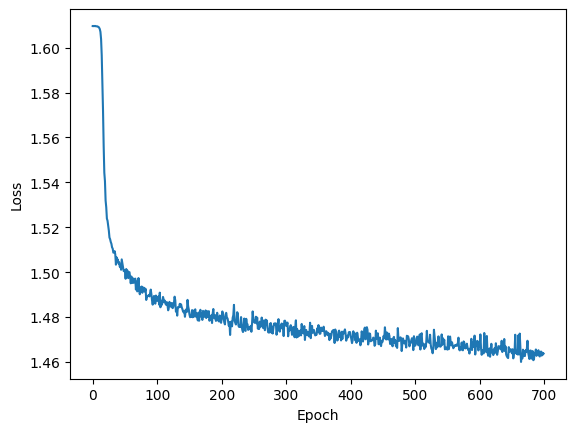

Test accuracy: 470.4124731182796
Accuracy: 0.4154838709677419
Precision: 0.38867245645589266
Recall: 0.4098741375921414
F1-score: 0.3893692651216872


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.49      0.43       495
           1       0.65      0.83      0.73       472
           2       0.26      0.14      0.18       449
           3       0.29      0.34      0.31       463
           4       0.36      0.25      0.29       446

    accuracy                           0.42      2325
   macro avg       0.39      0.41      0.39      2325
weighted avg       0.39      0.42      0.39      2325

                    0           1           2           3           4  \
precision    0.384252    0.648515    0.262712    0.290741    0.357143   
recall       0.492929    0.832627    0.138085    0.339093    0.246637   
f1-score     0.431858    0.729128    0.181022    0.313061    0.291777   
support    495.000000  472.000000  449.000000

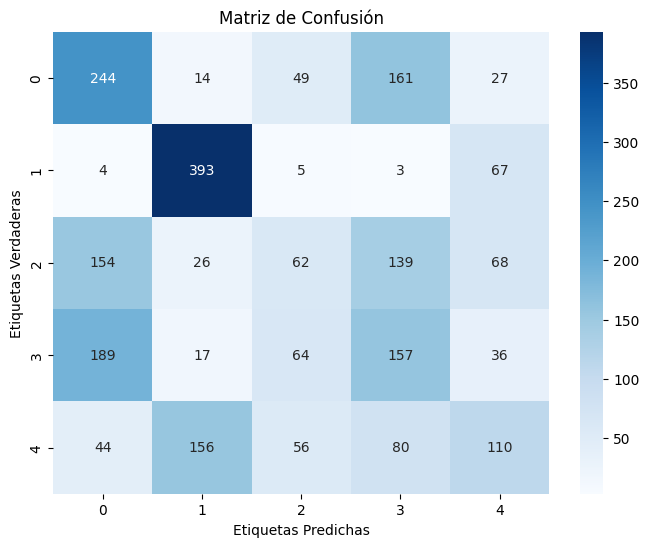

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_1e-05_0.2/resultados_700_1e-05_0.2.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|                                                              | 1/1000 [00:01<28:54,  1.74s/it]

1.6094214158899645


Procesando epocas:   0%|                                                              | 2/1000 [00:03<29:04,  1.75s/it]

1.609447699434617


Procesando epocas:   0%|▏                                                             | 3/1000 [00:05<29:01,  1.75s/it]

1.609394085407257


Procesando epocas:   0%|▏                                                             | 4/1000 [00:06<29:00,  1.75s/it]

1.6094290544005


Procesando epocas:   0%|▎                                                             | 5/1000 [00:08<28:58,  1.75s/it]

1.6094101421973284


Procesando epocas:   1%|▎                                                             | 6/1000 [00:10<28:59,  1.75s/it]

1.6092720298206105


Procesando epocas:   1%|▍                                                             | 7/1000 [00:12<28:58,  1.75s/it]

1.609336604791529


Procesando epocas:   1%|▍                                                             | 8/1000 [00:13<28:45,  1.74s/it]

1.6087410604252534


Procesando epocas:   1%|▌                                                             | 9/1000 [00:15<28:40,  1.74s/it]

1.5799908967579113


Procesando epocas:   1%|▌                                                            | 10/1000 [00:17<28:33,  1.73s/it]

1.5293474141289205


Procesando epocas:   1%|▋                                                            | 11/1000 [00:19<28:29,  1.73s/it]

1.5190106987953187


Procesando epocas:   1%|▋                                                            | 12/1000 [00:20<28:25,  1.73s/it]

1.5146336709751802


Procesando epocas:   1%|▊                                                            | 13/1000 [00:22<28:22,  1.72s/it]

1.5133459729306837


Procesando epocas:   1%|▊                                                            | 14/1000 [00:24<28:15,  1.72s/it]

1.509960108644822


Procesando epocas:   2%|▉                                                            | 15/1000 [00:25<28:12,  1.72s/it]

1.5047418082461637


Procesando epocas:   2%|▉                                                            | 16/1000 [00:27<28:09,  1.72s/it]

1.5048759572646198


Procesando epocas:   2%|█                                                            | 17/1000 [00:29<28:06,  1.72s/it]

1.5009350951980143


Procesando epocas:   2%|█                                                            | 18/1000 [00:31<28:05,  1.72s/it]

1.5027302244130303


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:32<28:03,  1.72s/it]

1.5033502648858463


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:34<28:02,  1.72s/it]

1.5018167951527763


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:36<28:01,  1.72s/it]

1.4999618453138015


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:37<27:55,  1.71s/it]

1.495594762353336


Procesando epocas:   2%|█▍                                                           | 23/1000 [00:39<27:59,  1.72s/it]

1.4969314470010646


Procesando epocas:   2%|█▍                                                           | 24/1000 [00:41<27:58,  1.72s/it]

1.495604041744681


Procesando epocas:   2%|█▌                                                           | 25/1000 [00:43<27:53,  1.72s/it]

1.4967760590945973


Procesando epocas:   3%|█▌                                                           | 26/1000 [00:44<27:52,  1.72s/it]

1.5036794704549452


Procesando epocas:   3%|█▋                                                           | 27/1000 [00:46<27:50,  1.72s/it]

1.5021218517247368


Procesando epocas:   3%|█▋                                                           | 28/1000 [00:48<27:49,  1.72s/it]

1.4916791663450353


Procesando epocas:   3%|█▊                                                           | 29/1000 [00:50<27:50,  1.72s/it]

1.4982858601738425


Procesando epocas:   3%|█▊                                                           | 30/1000 [00:51<27:47,  1.72s/it]

1.5014592324986178


Procesando epocas:   3%|█▉                                                           | 31/1000 [00:53<27:46,  1.72s/it]

1.492468756086686


Procesando epocas:   3%|█▉                                                           | 32/1000 [00:55<27:44,  1.72s/it]

1.496658499100629


Procesando epocas:   3%|██                                                           | 33/1000 [00:56<27:43,  1.72s/it]

1.4901932905702029


Procesando epocas:   3%|██                                                           | 34/1000 [00:58<27:40,  1.72s/it]

1.4943397837526657


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:00<27:34,  1.71s/it]

1.4920331590315874


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:02<27:26,  1.71s/it]

1.4926563767825856


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:03<27:24,  1.71s/it]

1.4931294027496786


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:05<27:19,  1.70s/it]

1.4933042378986583


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:07<27:13,  1.70s/it]

1.4913200518664191


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:08<27:09,  1.70s/it]

1.4884024725240819


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:10<27:08,  1.70s/it]

1.493886765311746


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:12<27:06,  1.70s/it]

1.4910922976101146


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:13<27:02,  1.70s/it]

1.4892932302811566


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:15<27:01,  1.70s/it]

1.4947825663229999


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:17<26:59,  1.70s/it]

1.491146964185378


Procesando epocas:   5%|██▊                                                          | 46/1000 [01:18<26:56,  1.69s/it]

1.4884244371862974


Procesando epocas:   5%|██▊                                                          | 47/1000 [01:20<26:55,  1.69s/it]

1.4907188338391921


Procesando epocas:   5%|██▉                                                          | 48/1000 [01:22<26:59,  1.70s/it]

1.4965123450054842


Procesando epocas:   5%|██▉                                                          | 49/1000 [01:24<26:56,  1.70s/it]

1.4851936494602878


Procesando epocas:   5%|███                                                          | 50/1000 [01:25<26:52,  1.70s/it]

1.4847306938732372


Procesando epocas:   5%|███                                                          | 51/1000 [01:27<26:51,  1.70s/it]

1.4825234728700973


Procesando epocas:   5%|███▏                                                         | 52/1000 [01:29<26:47,  1.70s/it]

1.4897576829966377


Procesando epocas:   5%|███▏                                                         | 53/1000 [01:30<26:40,  1.69s/it]

1.4908277153968812


Procesando epocas:   5%|███▎                                                         | 54/1000 [01:32<26:25,  1.68s/it]

1.48509281873703


Procesando epocas:   6%|███▎                                                         | 55/1000 [01:34<26:16,  1.67s/it]

1.488841681620654


Procesando epocas:   6%|███▍                                                         | 56/1000 [01:35<26:11,  1.66s/it]

1.4863355166771832


Procesando epocas:   6%|███▍                                                         | 57/1000 [01:37<26:06,  1.66s/it]

1.4857185188461752


Procesando epocas:   6%|███▌                                                         | 58/1000 [01:39<26:03,  1.66s/it]

1.4850639273138608


Procesando epocas:   6%|███▌                                                         | 59/1000 [01:40<25:59,  1.66s/it]

1.4866527347003713


Procesando epocas:   6%|███▋                                                         | 60/1000 [01:42<25:56,  1.66s/it]

1.487049871332505


Procesando epocas:   6%|███▋                                                         | 61/1000 [01:44<25:56,  1.66s/it]

1.4868144042351668


Procesando epocas:   6%|███▊                                                         | 62/1000 [01:45<25:55,  1.66s/it]

1.4846599340438842


Procesando epocas:   6%|███▊                                                         | 63/1000 [01:47<25:46,  1.65s/it]

1.4854348631466137


Procesando epocas:   6%|███▉                                                         | 64/1000 [01:49<25:47,  1.65s/it]

1.4875181359403273


Procesando epocas:   6%|███▉                                                         | 65/1000 [01:50<25:47,  1.66s/it]

1.4845205671647015


Procesando epocas:   7%|████                                                         | 66/1000 [01:52<25:44,  1.65s/it]

1.487065144847421


Procesando epocas:   7%|████                                                         | 67/1000 [01:54<25:46,  1.66s/it]

1.481770920753479


Procesando epocas:   7%|████▏                                                        | 68/1000 [01:55<25:41,  1.65s/it]

1.4815294854781207


Procesando epocas:   7%|████▏                                                        | 69/1000 [01:57<25:33,  1.65s/it]

1.481522901619182


Procesando epocas:   7%|████▎                                                        | 70/1000 [01:58<25:32,  1.65s/it]

1.4858958756222445


Procesando epocas:   7%|████▎                                                        | 71/1000 [02:00<25:28,  1.64s/it]

1.4853439541424023


Procesando epocas:   7%|████▍                                                        | 72/1000 [02:02<25:23,  1.64s/it]

1.4829241184627309


Procesando epocas:   7%|████▍                                                        | 73/1000 [02:03<25:21,  1.64s/it]

1.4858065226498771


Procesando epocas:   7%|████▌                                                        | 74/1000 [02:05<25:19,  1.64s/it]

1.4814895419513479


Procesando epocas:   8%|████▌                                                        | 75/1000 [02:07<25:18,  1.64s/it]

1.484631140793071


Procesando epocas:   8%|████▋                                                        | 76/1000 [02:08<25:16,  1.64s/it]

1.4849375858026392


Procesando epocas:   8%|████▋                                                        | 77/1000 [02:10<25:17,  1.64s/it]

1.4819127117886264


Procesando epocas:   8%|████▊                                                        | 78/1000 [02:12<25:13,  1.64s/it]

1.4799696059787975


Procesando epocas:   8%|████▊                                                        | 79/1000 [02:13<25:14,  1.64s/it]

1.4822352121858036


Procesando epocas:   8%|████▉                                                        | 80/1000 [02:15<25:10,  1.64s/it]

1.485045832044938


Procesando epocas:   8%|████▉                                                        | 81/1000 [02:16<25:06,  1.64s/it]

1.4782833246623768


Procesando epocas:   8%|█████                                                        | 82/1000 [02:18<25:03,  1.64s/it]

1.4817712959121256


Procesando epocas:   8%|█████                                                        | 83/1000 [02:20<25:01,  1.64s/it]

1.4775786806555355


Procesando epocas:   8%|█████                                                        | 84/1000 [02:21<25:04,  1.64s/it]

1.480313815088833


Procesando epocas:   8%|█████▏                                                       | 85/1000 [02:23<25:02,  1.64s/it]

1.4791705636417165


Procesando epocas:   9%|█████▏                                                       | 86/1000 [02:25<24:57,  1.64s/it]

1.478215345915626


Procesando epocas:   9%|█████▎                                                       | 87/1000 [02:26<25:00,  1.64s/it]

1.4818065510076635


Procesando epocas:   9%|█████▎                                                       | 88/1000 [02:28<24:56,  1.64s/it]

1.4782704220098608


Procesando epocas:   9%|█████▍                                                       | 89/1000 [02:30<24:55,  1.64s/it]

1.484362476012286


Procesando epocas:   9%|█████▍                                                       | 90/1000 [02:31<24:54,  1.64s/it]

1.47836875705158


Procesando epocas:   9%|█████▌                                                       | 91/1000 [02:33<24:52,  1.64s/it]

1.4771980362779953


Procesando epocas:   9%|█████▌                                                       | 92/1000 [02:35<24:49,  1.64s/it]

1.4776676311212427


Procesando epocas:   9%|█████▋                                                       | 93/1000 [02:36<24:45,  1.64s/it]

1.478617402385263


Procesando epocas:   9%|█████▋                                                       | 94/1000 [02:38<24:43,  1.64s/it]

1.4751927992876839


Procesando epocas:  10%|█████▊                                                       | 95/1000 [02:39<24:40,  1.64s/it]

1.4806597716668073


Procesando epocas:  10%|█████▊                                                       | 96/1000 [02:41<24:39,  1.64s/it]

1.4786713424850912


Procesando epocas:  10%|█████▉                                                       | 97/1000 [02:43<24:35,  1.63s/it]

1.4794608873479507


Procesando epocas:  10%|█████▉                                                       | 98/1000 [02:44<24:42,  1.64s/it]

1.4754896444432877


Procesando epocas:  10%|██████                                                       | 99/1000 [02:46<25:01,  1.67s/it]

1.4843669870320488


Procesando epocas:  10%|██████                                                      | 100/1000 [02:48<25:16,  1.69s/it]

1.4730288863182068


Procesando epocas:  10%|██████                                                      | 101/1000 [02:50<25:26,  1.70s/it]

1.4786708698553197


Procesando epocas:  10%|██████                                                      | 102/1000 [02:51<25:34,  1.71s/it]

1.4758042209288653


Procesando epocas:  10%|██████▏                                                     | 103/1000 [02:53<25:34,  1.71s/it]

1.4756139292436488


Procesando epocas:  10%|██████▏                                                     | 104/1000 [02:55<25:43,  1.72s/it]

1.4768430878134335


Procesando epocas:  10%|██████▎                                                     | 105/1000 [02:56<25:51,  1.73s/it]

1.4766849700142355


Procesando epocas:  11%|██████▎                                                     | 106/1000 [02:58<25:56,  1.74s/it]

1.479537076809827


Procesando epocas:  11%|██████▍                                                     | 107/1000 [03:00<25:58,  1.74s/it]

1.47639839368708


Procesando epocas:  11%|██████▍                                                     | 108/1000 [03:02<26:01,  1.75s/it]

1.477469027042389


Procesando epocas:  11%|██████▌                                                     | 109/1000 [03:04<26:02,  1.75s/it]

1.4729684661416447


Procesando epocas:  11%|██████▌                                                     | 110/1000 [03:05<26:01,  1.75s/it]

1.4798837128807516


Procesando epocas:  11%|██████▋                                                     | 111/1000 [03:07<26:00,  1.76s/it]

1.4753929488799151


Procesando epocas:  11%|██████▋                                                     | 112/1000 [03:09<26:01,  1.76s/it]

1.4792741466971004


Procesando epocas:  11%|██████▊                                                     | 113/1000 [03:11<26:00,  1.76s/it]

1.4762672073700849


Procesando epocas:  11%|██████▊                                                     | 114/1000 [03:12<25:58,  1.76s/it]

1.4699157791979172


Procesando epocas:  12%|██████▉                                                     | 115/1000 [03:14<25:55,  1.76s/it]

1.4746794910991894


Procesando epocas:  12%|██████▉                                                     | 116/1000 [03:16<25:50,  1.75s/it]

1.472033319753759


Procesando epocas:  12%|███████                                                     | 117/1000 [03:18<25:50,  1.76s/it]

1.4700103514334735


Procesando epocas:  12%|███████                                                     | 118/1000 [03:19<25:48,  1.76s/it]

1.4796533808988683


Procesando epocas:  12%|███████▏                                                    | 119/1000 [03:21<25:47,  1.76s/it]

1.4782485506113838


Procesando epocas:  12%|███████▏                                                    | 120/1000 [03:23<25:47,  1.76s/it]

1.4725733855191399


Procesando epocas:  12%|███████▎                                                    | 121/1000 [03:25<25:45,  1.76s/it]

1.4761418889550602


Procesando epocas:  12%|███████▎                                                    | 122/1000 [03:26<25:44,  1.76s/it]

1.4719752451952766


Procesando epocas:  12%|███████▍                                                    | 123/1000 [03:28<25:43,  1.76s/it]

1.4699459615875692


Procesando epocas:  12%|███████▍                                                    | 124/1000 [03:30<25:40,  1.76s/it]

1.4684981500401217


Procesando epocas:  12%|███████▌                                                    | 125/1000 [03:32<25:38,  1.76s/it]

1.4738266152494095


Procesando epocas:  13%|███████▌                                                    | 126/1000 [03:33<25:37,  1.76s/it]

1.4747645812876085


Procesando epocas:  13%|███████▌                                                    | 127/1000 [03:35<25:35,  1.76s/it]

1.4703961428473977


Procesando epocas:  13%|███████▋                                                    | 128/1000 [03:37<25:33,  1.76s/it]

1.4726222192539888


Procesando epocas:  13%|███████▋                                                    | 129/1000 [03:39<25:30,  1.76s/it]

1.4734953487620635


Procesando epocas:  13%|███████▊                                                    | 130/1000 [03:40<25:18,  1.75s/it]

1.4748383423861335


Procesando epocas:  13%|███████▊                                                    | 131/1000 [03:42<25:09,  1.74s/it]

1.4700314269346348


Procesando epocas:  13%|███████▉                                                    | 132/1000 [03:44<25:02,  1.73s/it]

1.4695190338527455


Procesando epocas:  13%|███████▉                                                    | 133/1000 [03:46<24:59,  1.73s/it]

1.4723188224960775


Procesando epocas:  13%|████████                                                    | 134/1000 [03:47<24:55,  1.73s/it]

1.470507703107946


Procesando epocas:  14%|████████                                                    | 135/1000 [03:49<24:53,  1.73s/it]

1.4705979115822736


Procesando epocas:  14%|████████▏                                                   | 136/1000 [03:51<24:49,  1.72s/it]

1.4700386853779064


Procesando epocas:  14%|████████▏                                                   | 137/1000 [03:52<24:47,  1.72s/it]

1.4758217930793762


Procesando epocas:  14%|████████▎                                                   | 138/1000 [03:54<24:46,  1.72s/it]

1.4729920120800242


Procesando epocas:  14%|████████▎                                                   | 139/1000 [03:56<24:46,  1.73s/it]

1.475331657774308


Procesando epocas:  14%|████████▍                                                   | 140/1000 [03:58<24:46,  1.73s/it]

1.4718053439084222


Procesando epocas:  14%|████████▍                                                   | 141/1000 [03:59<24:43,  1.73s/it]

1.466399975383983


Procesando epocas:  14%|████████▌                                                   | 142/1000 [04:01<24:41,  1.73s/it]

1.467769620699041


Procesando epocas:  14%|████████▌                                                   | 143/1000 [04:03<24:38,  1.73s/it]

1.467653049440945


Procesando epocas:  14%|████████▋                                                   | 144/1000 [04:05<24:35,  1.72s/it]

1.465835018718944


Procesando epocas:  14%|████████▋                                                   | 145/1000 [04:06<24:33,  1.72s/it]

1.4709209624458761


Procesando epocas:  15%|████████▊                                                   | 146/1000 [04:08<24:32,  1.72s/it]

1.4738885052063886


Procesando epocas:  15%|████████▊                                                   | 147/1000 [04:10<24:31,  1.72s/it]

1.4668930004624758


Procesando epocas:  15%|████████▉                                                   | 148/1000 [04:11<24:30,  1.73s/it]

1.4641974820810206


Procesando epocas:  15%|████████▉                                                   | 149/1000 [04:13<24:21,  1.72s/it]

1.4699802349595463


Procesando epocas:  15%|█████████                                                   | 150/1000 [04:15<24:15,  1.71s/it]

1.4667550051913543


Procesando epocas:  15%|█████████                                                   | 151/1000 [04:17<24:14,  1.71s/it]

1.468459885260638


Procesando epocas:  15%|█████████                                                   | 152/1000 [04:18<24:11,  1.71s/it]

1.469360602603239


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [04:20<24:10,  1.71s/it]

1.4649085437550264


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [04:22<24:06,  1.71s/it]

1.4640687360483058


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [04:23<24:08,  1.71s/it]

1.468476348063525


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [04:25<24:05,  1.71s/it]

1.4731897101682776


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [04:27<23:58,  1.71s/it]

1.4707238884533154


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [04:28<23:50,  1.70s/it]

1.462710445768693


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [04:30<23:46,  1.70s/it]

1.467346124088063


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [04:32<23:40,  1.69s/it]

1.470441338595222


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [04:34<23:37,  1.69s/it]

1.4645312140969668


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [04:35<23:34,  1.69s/it]

1.464487965667949


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [04:37<23:27,  1.68s/it]

1.4690175666528589


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [04:39<23:24,  1.68s/it]

1.4663714927785536


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [04:40<23:24,  1.68s/it]

1.4647272853290334


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [04:42<23:23,  1.68s/it]

1.4666664228719823


Procesando epocas:  17%|██████████                                                  | 167/1000 [04:44<23:18,  1.68s/it]

1.4665612529305851


Procesando epocas:  17%|██████████                                                  | 168/1000 [04:45<23:16,  1.68s/it]

1.4701614940867704


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [04:47<23:14,  1.68s/it]

1.4682804037542905


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [04:49<23:14,  1.68s/it]

1.4703083185588612


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [04:50<23:13,  1.68s/it]

1.4623061292311725


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [04:52<23:10,  1.68s/it]

1.465793033207164


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [04:54<23:11,  1.68s/it]

1.4633044733720668


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [04:55<23:07,  1.68s/it]

1.46503427028656


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [04:57<23:06,  1.68s/it]

1.4675732858040753


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [04:59<23:06,  1.68s/it]

1.4690971907447365


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [05:00<23:03,  1.68s/it]

1.4679540970746208


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [05:02<23:02,  1.68s/it]

1.4643760064068962


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [05:04<23:02,  1.68s/it]

1.4675235159256879


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [05:05<22:59,  1.68s/it]

1.4691785503836239


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [05:07<22:57,  1.68s/it]

1.4704260251101327


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [05:09<22:57,  1.68s/it]

1.4632572468589333


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [05:11<22:53,  1.68s/it]

1.4610693791333367


Procesando epocas:  18%|███████████                                                 | 184/1000 [05:12<22:52,  1.68s/it]

1.4619019003475413


Procesando epocas:  18%|███████████                                                 | 185/1000 [05:14<22:52,  1.68s/it]

1.4627732304965748


Procesando epocas:  19%|███████████▏                                                | 186/1000 [05:16<22:48,  1.68s/it]

1.4657997678307926


Procesando epocas:  19%|███████████▏                                                | 187/1000 [05:17<22:47,  1.68s/it]

1.4601411735310275


Procesando epocas:  19%|███████████▎                                                | 188/1000 [05:19<22:44,  1.68s/it]

1.4610491668476777


Procesando epocas:  19%|███████████▎                                                | 189/1000 [05:21<22:40,  1.68s/it]

1.4577839535825392


Procesando epocas:  19%|███████████▍                                                | 190/1000 [05:22<22:33,  1.67s/it]

1.4665348466704873


Procesando epocas:  19%|███████████▍                                                | 191/1000 [05:24<22:31,  1.67s/it]

1.4610455379766576


Procesando epocas:  19%|███████████▌                                                | 192/1000 [05:26<22:31,  1.67s/it]

1.4675089085803312


Procesando epocas:  19%|███████████▌                                                | 193/1000 [05:27<22:28,  1.67s/it]

1.4648403448217056


Procesando epocas:  19%|███████████▋                                                | 194/1000 [05:29<22:29,  1.67s/it]

1.4609084227505853


Procesando epocas:  20%|███████████▋                                                | 195/1000 [05:31<22:25,  1.67s/it]

1.465759509451249


Procesando epocas:  20%|███████████▊                                                | 196/1000 [05:32<22:25,  1.67s/it]

1.466664665586808


Procesando epocas:  20%|███████████▊                                                | 197/1000 [05:34<22:22,  1.67s/it]

1.4690711904974545


Procesando epocas:  20%|███████████▉                                                | 198/1000 [05:36<22:19,  1.67s/it]

1.4675817966461182


Procesando epocas:  20%|███████████▉                                                | 199/1000 [05:37<22:19,  1.67s/it]

1.4579848878523882


Procesando epocas:  20%|████████████                                                | 200/1000 [05:39<22:20,  1.68s/it]

1.4615274983293869


Procesando epocas:  20%|████████████                                                | 201/1000 [05:41<22:21,  1.68s/it]

1.465156742404489


Procesando epocas:  20%|████████████                                                | 202/1000 [05:42<22:20,  1.68s/it]

1.4661678664824542


Procesando epocas:  20%|████████████▏                                               | 203/1000 [05:44<22:19,  1.68s/it]

1.4622721756205839


Procesando epocas:  20%|████████████▏                                               | 204/1000 [05:46<22:17,  1.68s/it]

1.4589268172488492


Procesando epocas:  20%|████████████▎                                               | 205/1000 [05:47<22:17,  1.68s/it]

1.4609811789849225


Procesando epocas:  21%|████████████▎                                               | 206/1000 [05:49<22:14,  1.68s/it]

1.4620280069463394


Procesando epocas:  21%|████████████▍                                               | 207/1000 [05:51<22:15,  1.68s/it]

1.465213387152728


Procesando epocas:  21%|████████████▍                                               | 208/1000 [05:52<22:13,  1.68s/it]

1.4690886252066668


Procesando epocas:  21%|████████████▌                                               | 209/1000 [05:54<22:12,  1.68s/it]

1.4594845140681547


Procesando epocas:  21%|████████████▌                                               | 210/1000 [05:56<22:10,  1.68s/it]

1.4603331341462977


Procesando epocas:  21%|████████████▋                                               | 211/1000 [05:58<22:13,  1.69s/it]

1.4571655161240522


Procesando epocas:  21%|████████████▋                                               | 212/1000 [05:59<22:10,  1.69s/it]

1.4573694383396822


Procesando epocas:  21%|████████████▊                                               | 213/1000 [06:01<22:08,  1.69s/it]

1.4580581321435817


Procesando epocas:  21%|████████████▊                                               | 214/1000 [06:03<22:07,  1.69s/it]

1.464010805943433


Procesando epocas:  22%|████████████▉                                               | 215/1000 [06:04<22:05,  1.69s/it]

1.4580788430045633


Procesando epocas:  22%|████████████▉                                               | 216/1000 [06:06<22:03,  1.69s/it]

1.4648091800072613


Procesando epocas:  22%|█████████████                                               | 217/1000 [06:08<22:03,  1.69s/it]

1.460062282926896


Procesando epocas:  22%|█████████████                                               | 218/1000 [06:09<22:00,  1.69s/it]

1.4614499611013076


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [06:11<21:59,  1.69s/it]

1.4577777960721183


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [06:13<22:00,  1.69s/it]

1.4608860233250787


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [06:14<22:13,  1.71s/it]

1.4577191794619841


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [06:16<22:20,  1.72s/it]

1.457529989410849


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [06:18<22:26,  1.73s/it]

1.4581606949076933


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [06:20<22:30,  1.74s/it]

1.458017965625314


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [06:22<22:34,  1.75s/it]

1.4626132144647486


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [06:23<22:37,  1.75s/it]

1.4595056099050185


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [06:25<22:35,  1.75s/it]

1.4597428728552426


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [06:27<22:33,  1.75s/it]

1.4612764968591578


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [06:29<22:29,  1.75s/it]

1.464509484347175


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [06:30<22:28,  1.75s/it]

1.460112085763146


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [06:32<22:27,  1.75s/it]

1.4565086799509386


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [06:34<22:25,  1.75s/it]

1.4624968949486228


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [06:36<22:24,  1.75s/it]

1.4550565411062801


Procesando epocas:  23%|██████████████                                              | 234/1000 [06:37<22:22,  1.75s/it]

1.4618339230032529


Procesando epocas:  24%|██████████████                                              | 235/1000 [06:39<22:20,  1.75s/it]

1.4649392506655525


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [06:41<22:19,  1.75s/it]

1.470158314704895


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [06:43<22:18,  1.75s/it]

1.4600788523169126


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [06:44<22:15,  1.75s/it]

1.461311331917258


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [06:46<22:14,  1.75s/it]

1.4590196812854093


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [06:48<22:11,  1.75s/it]

1.4592528651742374


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [06:50<22:11,  1.75s/it]

1.4569752048043643


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [06:51<22:10,  1.76s/it]

1.458812952742857


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [06:53<22:09,  1.76s/it]

1.4567413323065814


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [06:55<22:06,  1.76s/it]

1.4607219597872565


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [06:57<22:06,  1.76s/it]

1.4551610694212072


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [06:58<22:05,  1.76s/it]

1.4599020565257352


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [07:00<22:05,  1.76s/it]

1.4638701530063853


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [07:02<21:59,  1.75s/it]

1.4573212322066813


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [07:04<21:49,  1.74s/it]

1.4609692279030295


Procesando epocas:  25%|███████████████                                             | 250/1000 [07:05<21:44,  1.74s/it]

1.4523558027604047


Procesando epocas:  25%|███████████████                                             | 251/1000 [07:07<21:41,  1.74s/it]

1.463006584784564


Procesando epocas:  25%|███████████████                                             | 252/1000 [07:09<21:33,  1.73s/it]

1.46078702842488


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [07:10<21:23,  1.72s/it]

1.4591745692140916


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [07:12<21:16,  1.71s/it]

1.4539862478480619


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [07:14<21:10,  1.71s/it]

1.4665792661554673


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [07:16<21:03,  1.70s/it]

1.4578006961766412


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [07:17<20:56,  1.69s/it]

1.4631458023015191


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [07:19<20:53,  1.69s/it]

1.4588497154852924


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [07:21<20:52,  1.69s/it]

1.4595925029586343


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [07:22<20:49,  1.69s/it]

1.4543198550448697


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [07:24<20:47,  1.69s/it]

1.4581091172554914


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [07:26<20:47,  1.69s/it]

1.4532690518042621


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [07:27<20:46,  1.69s/it]

1.4613655132405898


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [07:29<20:45,  1.69s/it]

1.4569662164239323


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [07:31<20:45,  1.69s/it]

1.4562229864737566


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [07:32<20:40,  1.69s/it]

1.4583486192366657


Procesando epocas:  27%|████████████████                                            | 267/1000 [07:34<20:38,  1.69s/it]

1.4570334315299989


Procesando epocas:  27%|████████████████                                            | 268/1000 [07:36<20:40,  1.69s/it]

1.4548205593053032


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [07:38<20:38,  1.69s/it]

1.4593897868605221


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [07:39<20:35,  1.69s/it]

1.4610458850860595


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [07:41<20:35,  1.69s/it]

1.4586865481208353


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [07:43<20:31,  1.69s/it]

1.4572313757503734


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [07:44<20:30,  1.69s/it]

1.4591065385762383


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [07:46<20:23,  1.69s/it]

1.4546088015331942


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [07:48<20:20,  1.68s/it]

1.4517474174499512


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [07:49<20:19,  1.68s/it]

1.4592565957237693


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [07:51<20:20,  1.69s/it]

1.4531670647508959


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [07:53<20:18,  1.69s/it]

1.4603323957499337


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [07:54<20:16,  1.69s/it]

1.4598894525976742


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [07:56<20:07,  1.68s/it]

1.4564578988972832


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [07:58<20:01,  1.67s/it]

1.4599644913392908


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [07:59<19:55,  1.67s/it]

1.4618378667270435


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [08:01<19:49,  1.66s/it]

1.459362842054928


Procesando epocas:  28%|█████████████████                                           | 284/1000 [08:03<19:47,  1.66s/it]

1.4546371621244094


Procesando epocas:  28%|█████████████████                                           | 285/1000 [08:04<19:46,  1.66s/it]

1.4528128259322222


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [08:06<19:44,  1.66s/it]

1.4527502613909105


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [08:08<19:43,  1.66s/it]

1.455588260117699


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [08:09<19:42,  1.66s/it]

1.4531848781249102


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [08:11<19:43,  1.66s/it]

1.4584218431921567


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [08:13<19:40,  1.66s/it]

1.4558418729726006


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [08:14<19:38,  1.66s/it]

1.451149576551774


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [08:16<19:39,  1.67s/it]

1.462407691338483


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [08:18<19:35,  1.66s/it]

1.4520732599146227


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [08:19<19:29,  1.66s/it]

1.4475134989794562


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [08:21<19:28,  1.66s/it]

1.460761607394499


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [08:23<19:27,  1.66s/it]

1.4551830621326671


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [08:24<19:28,  1.66s/it]

1.4603692678844227


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [08:26<19:24,  1.66s/it]

1.452187332686256


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [08:28<19:24,  1.66s/it]

1.4534636777990004


Procesando epocas:  30%|██████████████████                                          | 300/1000 [08:29<19:29,  1.67s/it]

1.4615013669518864


Procesando epocas:  30%|██████████████████                                          | 301/1000 [08:31<19:32,  1.68s/it]

1.4561884361154893


Procesando epocas:  30%|██████████████████                                          | 302/1000 [08:33<19:38,  1.69s/it]

1.4584678839234744


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [08:34<19:50,  1.71s/it]

1.45266330873265


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [08:36<19:51,  1.71s/it]

1.4562686913153704


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [08:38<19:50,  1.71s/it]

1.4513629632837632


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [08:40<19:48,  1.71s/it]

1.4507162830408882


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [08:41<19:45,  1.71s/it]

1.450593565492069


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [08:43<19:42,  1.71s/it]

1.4537795838187724


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [08:45<19:38,  1.71s/it]

1.4591774786219878


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [08:46<19:39,  1.71s/it]

1.45148466054131


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [08:48<19:37,  1.71s/it]

1.451336329123553


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [08:50<19:36,  1.71s/it]

1.4550187068827012


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [08:52<19:34,  1.71s/it]

1.4598082044545342


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [08:53<19:35,  1.71s/it]

1.4520803746055155


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [08:55<19:38,  1.72s/it]

1.4534717517740585


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [08:57<19:38,  1.72s/it]

1.4485916775815628


Procesando epocas:  32%|███████████████████                                         | 317/1000 [08:58<19:32,  1.72s/it]

1.4525655753472273


Procesando epocas:  32%|███████████████████                                         | 318/1000 [09:00<19:25,  1.71s/it]

1.4550389991087072


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [09:02<19:25,  1.71s/it]

1.4507977415533626


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [09:04<19:29,  1.72s/it]

1.4510068914469552


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [09:05<19:33,  1.73s/it]

1.4508087221313926


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [09:07<19:28,  1.72s/it]

1.4551379961125992


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [09:09<19:21,  1.72s/it]

1.4544940766166239


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [09:10<19:15,  1.71s/it]

1.451355333188001


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [09:12<19:09,  1.70s/it]

1.44855435034808


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [09:14<19:14,  1.71s/it]

1.4565387031611274


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [09:16<19:13,  1.71s/it]

1.4575130448621862


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [09:17<19:09,  1.71s/it]

1.4537367869825923


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [09:19<19:12,  1.72s/it]

1.4514244507340823


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [09:21<19:18,  1.73s/it]

1.4549333207747515


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [09:22<19:19,  1.73s/it]

1.4527422554352705


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [09:24<19:20,  1.74s/it]

1.4582135221537422


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [09:26<19:20,  1.74s/it]

1.4576043991481558


Procesando epocas:  33%|████████████████████                                        | 334/1000 [09:28<19:13,  1.73s/it]

1.4566235226743363


Procesando epocas:  34%|████████████████████                                        | 335/1000 [09:29<19:10,  1.73s/it]

1.4524033637607798


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [09:31<19:11,  1.73s/it]

1.4524790476350222


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [09:33<19:05,  1.73s/it]

1.4503065193400664


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [09:35<18:55,  1.71s/it]

1.4584078774732703


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [09:36<18:46,  1.70s/it]

1.4508083848392261


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [09:38<18:38,  1.69s/it]

1.4610492019092336


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [09:40<18:36,  1.69s/it]

1.4585804714876063


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [09:41<18:48,  1.71s/it]

1.4563110183267032


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [09:43<18:55,  1.73s/it]

1.4556584000587462


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [09:45<18:59,  1.74s/it]

1.4528435349464417


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [09:47<19:01,  1.74s/it]

1.452711704899283


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [09:48<19:01,  1.75s/it]

1.4475116547416238


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [09:50<18:59,  1.74s/it]

1.4600782099892111


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [09:52<18:55,  1.74s/it]

1.4557770490646362


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [09:54<18:55,  1.74s/it]

1.4519758315647349


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [09:55<18:52,  1.74s/it]

1.453040106156293


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [09:57<18:51,  1.74s/it]

1.4480045837514541


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [09:59<18:51,  1.75s/it]

1.4553979011142955


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [10:01<18:58,  1.76s/it]

1.4541906931821038


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [10:02<18:59,  1.76s/it]

1.4479293984525343


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [10:04<18:56,  1.76s/it]

1.4483822619213778


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [10:06<18:51,  1.76s/it]

1.4482483597362743


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [10:08<18:52,  1.76s/it]

1.449780438928043


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [10:09<18:50,  1.76s/it]

1.4433655044611762


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [10:11<18:46,  1.76s/it]

1.4461180679938372


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [10:13<18:40,  1.75s/it]

1.449200330061071


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [10:15<18:39,  1.75s/it]

1.4458774117862476


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [10:16<18:37,  1.75s/it]

1.4434393356828128


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [10:18<18:36,  1.75s/it]

1.4456275561276604


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [10:20<18:36,  1.76s/it]

1.4564992645207573


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [10:22<18:38,  1.76s/it]

1.4472747487180373


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [10:23<18:34,  1.76s/it]

1.447603086163016


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [10:25<18:32,  1.76s/it]

1.44995996391072


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [10:27<18:29,  1.76s/it]

1.4492464156711802


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [10:29<18:23,  1.75s/it]

1.4508126735687257


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [10:31<18:27,  1.76s/it]

1.444450569152832


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [10:32<18:29,  1.76s/it]

1.455253310063306


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [10:34<18:26,  1.76s/it]

1.4458234176916234


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [10:36<18:21,  1.76s/it]

1.4428779307533712


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [10:38<18:13,  1.75s/it]

1.451324950947481


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [10:39<18:10,  1.75s/it]

1.451745069026947


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [10:41<18:05,  1.74s/it]

1.440649622328141


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [10:43<17:56,  1.73s/it]

1.4445977800032672


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [10:44<17:50,  1.72s/it]

1.44164217079387


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [10:46<17:46,  1.72s/it]

1.4458477567223942


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [10:48<17:45,  1.72s/it]

1.4443123747320736


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [10:50<17:40,  1.71s/it]

1.439078768561868


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [10:51<17:38,  1.71s/it]

1.4472335738294264


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [10:53<17:36,  1.71s/it]

1.4397071564898771


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [10:55<17:32,  1.71s/it]

1.4431685363545137


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [10:56<17:32,  1.71s/it]

1.442863727317137


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [10:58<17:28,  1.71s/it]

1.436247133507448


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [11:00<17:27,  1.71s/it]

1.442069130084094


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [11:01<17:26,  1.71s/it]

1.4460189924520606


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [11:03<17:22,  1.71s/it]

1.4435334023307351


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [11:05<17:22,  1.71s/it]

1.4415258477715884


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [11:07<17:21,  1.71s/it]

1.4466716457815731


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [11:08<17:24,  1.72s/it]

1.4530875507523031


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [11:10<17:25,  1.72s/it]

1.4413950260947732


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [11:12<17:23,  1.72s/it]

1.4437066814478705


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [11:14<17:22,  1.72s/it]

1.444049274220186


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [11:15<17:20,  1.72s/it]

1.442459115561317


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [11:17<17:17,  1.72s/it]

1.4436197049477522


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [11:19<17:15,  1.72s/it]

1.4414767882403206


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [11:20<17:15,  1.72s/it]

1.443415111653945


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [11:22<17:11,  1.72s/it]

1.4410744744188646


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [11:24<17:04,  1.71s/it]

1.4419500350952148


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [11:26<17:05,  1.71s/it]

1.4378343350747051


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [11:27<17:09,  1.73s/it]

1.4484659412327934


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [11:29<17:11,  1.73s/it]

1.4452734792933744


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [11:31<17:08,  1.73s/it]

1.4438736109172596


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [11:32<17:06,  1.73s/it]

1.4430057967410368


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [11:34<17:06,  1.73s/it]

1.446779422199025


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [11:36<17:05,  1.73s/it]

1.442638117425582


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [11:38<17:02,  1.73s/it]

1.4397399404469657


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [11:39<17:02,  1.73s/it]

1.4371913629419664


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [11:41<16:59,  1.73s/it]

1.4514413665322696


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [11:43<17:00,  1.73s/it]

1.439668846130371


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [11:45<16:54,  1.73s/it]

1.449252986907959


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [11:46<16:46,  1.72s/it]

1.4398154504158918


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [11:48<16:42,  1.71s/it]

1.4387285905725815


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [11:50<16:41,  1.72s/it]

1.4451682013623854


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [11:51<16:38,  1.71s/it]

1.4497685278163237


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [11:53<16:36,  1.71s/it]

1.4402831771794486


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [11:55<16:32,  1.71s/it]

1.4409149590660544


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [11:57<16:33,  1.71s/it]

1.442035674347597


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [11:58<16:32,  1.71s/it]

1.4425516661475686


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [12:00<16:34,  1.72s/it]

1.4412254095077515


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [12:02<16:37,  1.73s/it]

1.4371678233146667


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [12:04<16:40,  1.74s/it]

1.4474696671261507


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [12:05<16:39,  1.74s/it]

1.447762112757739


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [12:07<16:39,  1.74s/it]

1.4402052093954647


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [12:09<16:29,  1.73s/it]

1.4373423828798182


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [12:10<16:28,  1.73s/it]

1.4374421203837675


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [12:12<16:20,  1.72s/it]

1.4384976260802325


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [12:14<16:22,  1.72s/it]

1.4404753355418936


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [12:16<16:22,  1.73s/it]

1.4453463855911703


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [12:17<16:24,  1.73s/it]

1.4365345541168661


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [12:19<16:20,  1.73s/it]

1.4394421100616455


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [12:21<16:19,  1.73s/it]

1.4403193396680496


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [12:22<16:08,  1.71s/it]

1.4367264165597804


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [12:24<16:06,  1.71s/it]

1.449672013170579


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [12:26<16:05,  1.72s/it]

1.437265194163603


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [12:28<15:58,  1.71s/it]

1.440692095195546


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [12:29<15:58,  1.71s/it]

1.4358397308517905


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [12:31<16:02,  1.72s/it]

1.4426500846357906


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [12:33<16:02,  1.72s/it]

1.435541002189412


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [12:34<15:53,  1.71s/it]

1.441370372912463


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [12:36<15:47,  1.70s/it]

1.439074791880215


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [12:38<15:40,  1.69s/it]

1.440399785602794


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [12:40<15:43,  1.70s/it]

1.441167987094206


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [12:41<15:39,  1.70s/it]

1.4464721399195053


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [12:43<15:41,  1.70s/it]

1.4425576350268197


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [12:45<15:42,  1.71s/it]

1.4361664912279914


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [12:46<15:33,  1.69s/it]

1.4412432873950285


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [12:48<15:22,  1.68s/it]

1.437782273573034


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [12:50<15:17,  1.67s/it]

1.4461752954651328


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [12:51<15:12,  1.67s/it]

1.4381742028629079


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [12:53<15:20,  1.68s/it]

1.4413634875241448


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [12:55<15:21,  1.69s/it]

1.4396174388773302


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [12:56<15:20,  1.69s/it]

1.4355016596177046


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [12:58<15:20,  1.69s/it]

1.437652940609876


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [13:00<15:20,  1.69s/it]

1.4403774037080652


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [13:01<15:16,  1.69s/it]

1.4438805124338936


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [13:03<15:18,  1.70s/it]

1.4409111633020288


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [13:05<15:15,  1.70s/it]

1.4414756220929763


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [13:07<15:15,  1.70s/it]

1.443568535412059


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [13:08<15:28,  1.73s/it]

1.4352010825101067


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [13:10<15:45,  1.76s/it]

1.4412352267433615


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [13:12<15:54,  1.78s/it]

1.4352937207502476


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [13:14<15:59,  1.79s/it]

1.4379893127609702


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [13:16<16:07,  1.81s/it]

1.4409646917791927


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [13:18<16:07,  1.81s/it]

1.4391411002944499


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [13:19<16:02,  1.81s/it]

1.453625872555901


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [13:21<16:02,  1.81s/it]

1.4444829569143407


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [13:23<15:51,  1.79s/it]

1.4381217374521142


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [13:25<15:50,  1.80s/it]

1.439310158701504


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [13:27<15:52,  1.80s/it]

1.4344255026649027


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [13:28<15:46,  1.80s/it]

1.4357811359798207


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [13:30<15:40,  1.79s/it]

1.4516031559775857


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [13:32<15:42,  1.79s/it]

1.4377220763879663


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [13:34<15:36,  1.79s/it]

1.439439436267404


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [13:35<15:40,  1.80s/it]

1.437689605179955


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [13:37<15:39,  1.80s/it]

1.4366222206284018


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [13:39<15:28,  1.78s/it]

1.4392179580295787


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [13:40<14:10,  1.64s/it]

1.4366979872479158


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [13:42<14:32,  1.68s/it]

1.442721987471861


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [13:44<14:48,  1.72s/it]

1.4383872523027308


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [13:46<15:02,  1.75s/it]

1.4332696507958804


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [13:47<15:07,  1.76s/it]

1.437378149172839


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [13:49<15:10,  1.77s/it]

1.4419923663139342


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [13:51<15:13,  1.78s/it]

1.4416833695243387


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [13:53<15:11,  1.78s/it]

1.4394857904490304


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [13:55<15:13,  1.78s/it]

1.4388638727805194


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [13:56<15:15,  1.79s/it]

1.4345127358156091


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [13:58<15:17,  1.80s/it]

1.4312913417816162


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [14:00<15:18,  1.80s/it]

1.4456410933943356


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [14:02<15:20,  1.81s/it]

1.4350814601954291


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [14:04<15:15,  1.80s/it]

1.4484855385387645


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [14:05<15:09,  1.80s/it]

1.4323600418427411


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [14:07<15:04,  1.79s/it]

1.4376182023216697


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [14:09<14:59,  1.78s/it]

1.4347794953514548


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [14:11<14:57,  1.78s/it]

1.4380569226601545


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [14:13<14:56,  1.79s/it]

1.4333474951631882


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [14:14<14:52,  1.78s/it]

1.4366513266282923


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [14:16<14:49,  1.78s/it]

1.4358721263268415


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [14:18<14:47,  1.78s/it]

1.4344632415210499


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [14:20<14:44,  1.78s/it]

1.4412720561027528


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [14:21<14:42,  1.78s/it]

1.4381490174461813


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [14:23<14:40,  1.78s/it]

1.4347793081227471


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [14:25<14:40,  1.78s/it]

1.437325260218452


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [14:27<14:40,  1.78s/it]

1.4371191038804896


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [14:29<14:40,  1.79s/it]

1.438946716224446


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [14:30<14:37,  1.78s/it]

1.43546404838562


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [14:32<14:34,  1.78s/it]

1.4383925578173469


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [14:34<14:32,  1.78s/it]

1.4406828080906589


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [14:36<14:29,  1.78s/it]

1.4391923518741832


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [14:38<14:29,  1.78s/it]

1.4394635431906757


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [14:39<14:28,  1.78s/it]

1.4365438012515797


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [14:41<14:26,  1.78s/it]

1.4390171149197746


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [14:43<14:26,  1.79s/it]

1.4435676427448496


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [14:45<14:20,  1.78s/it]

1.4335957113434286


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [14:46<14:20,  1.78s/it]

1.442033002657049


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [14:48<14:18,  1.78s/it]

1.4365761104752035


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [14:50<14:14,  1.78s/it]

1.437910912317388


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [14:52<14:12,  1.78s/it]

1.438222842356738


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [14:53<14:07,  1.77s/it]

1.4342018940869499


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [14:55<14:06,  1.77s/it]

1.43795544610304


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [14:57<14:02,  1.77s/it]

1.440823409136604


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [14:59<13:59,  1.76s/it]

1.432288092024186


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [15:01<13:57,  1.76s/it]

1.4358095723039963


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [15:02<13:55,  1.76s/it]

1.4303695054615244


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [15:04<13:52,  1.76s/it]

1.4385386144413668


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [15:06<13:50,  1.76s/it]

1.4335455494768479


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [15:08<13:49,  1.76s/it]

1.433850676873151


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [15:09<13:45,  1.76s/it]

1.4444565920268788


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [15:11<13:44,  1.76s/it]

1.4310919593362248


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [15:13<13:46,  1.77s/it]

1.4402754257707036


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [15:15<13:47,  1.77s/it]

1.4413585354300107


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [15:16<13:45,  1.77s/it]

1.4318115683162913


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [15:18<13:38,  1.76s/it]

1.44149090051651


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [15:20<13:37,  1.76s/it]

1.434453272819519


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [15:22<13:33,  1.76s/it]

1.4338669608621035


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [15:23<13:31,  1.76s/it]

1.4376837001127356


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [15:25<13:29,  1.76s/it]

1.4334480131373686


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [15:27<13:25,  1.75s/it]

1.4305148538421182


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [15:29<13:24,  1.75s/it]

1.4325404300409206


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [15:30<13:20,  1.75s/it]

1.4363190447582919


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [15:32<13:18,  1.75s/it]

1.431275286394007


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [15:34<13:18,  1.75s/it]

1.4315035939216614


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [15:36<13:18,  1.76s/it]

1.4420222177225002


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [15:37<13:15,  1.75s/it]

1.4392116778037127


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [15:39<13:16,  1.76s/it]

1.4341932843713199


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [15:41<13:16,  1.76s/it]

1.4372014417367822


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [15:43<13:09,  1.75s/it]

1.4362653683213626


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [15:44<13:10,  1.76s/it]

1.4377929617376888


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [15:46<13:12,  1.76s/it]

1.4307930125909694


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [15:48<13:08,  1.76s/it]

1.4336106300354003


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [15:50<13:03,  1.75s/it]

1.4356883581946878


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [15:52<13:04,  1.76s/it]

1.431672251925749


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [15:53<12:58,  1.75s/it]

1.4340312291594113


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [15:55<12:55,  1.75s/it]

1.4391685997738557


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [15:57<12:52,  1.74s/it]

1.4361559019369237


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [15:58<12:50,  1.74s/it]

1.4255069199730368


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [16:00<12:51,  1.75s/it]

1.4290767115705154


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [16:02<12:48,  1.75s/it]

1.440355310720556


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [16:04<12:46,  1.75s/it]

1.438208738495322


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [16:05<12:43,  1.74s/it]

1.4345555235357845


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [16:07<12:44,  1.75s/it]

1.4281862097627975


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [16:09<12:42,  1.75s/it]

1.4317294513477998


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [16:11<12:39,  1.75s/it]

1.440382951848647


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [16:12<12:39,  1.75s/it]

1.4388809772098765


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [16:14<12:36,  1.75s/it]

1.4298827066141016


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [16:16<12:34,  1.75s/it]

1.4300892367082483


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [16:18<12:34,  1.75s/it]

1.4260788174236523


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [16:19<12:35,  1.76s/it]

1.4346035242080688


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [16:21<12:32,  1.75s/it]

1.439824353947359


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [16:23<12:28,  1.75s/it]

1.4289803953731761


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [16:25<12:21,  1.74s/it]

1.4351717836716595


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [16:26<12:12,  1.72s/it]

1.4343625840018777


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [16:28<12:05,  1.71s/it]

1.4363460176131304


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [16:30<12:01,  1.70s/it]

1.4344882425139933


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [16:31<12:05,  1.71s/it]

1.4319003119188196


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [16:33<12:09,  1.73s/it]

1.4315139770507812


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [16:35<12:11,  1.74s/it]

1.4332716016208424


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [16:37<12:08,  1.73s/it]

1.4399915968670565


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [16:38<12:06,  1.73s/it]

1.4309940197888542


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [16:40<12:05,  1.73s/it]

1.4386803374570958


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [16:42<12:04,  1.74s/it]

1.4407789019977346


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [16:44<12:14,  1.77s/it]

1.4306652300498064


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [16:46<12:20,  1.78s/it]

1.4268649956759285


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [16:47<12:23,  1.80s/it]

1.436915300874149


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [16:49<12:27,  1.81s/it]

1.4342359718154458


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [16:51<12:28,  1.82s/it]

1.4332522974294775


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [16:53<12:28,  1.82s/it]

1.4371742529027602


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [16:55<12:25,  1.82s/it]

1.433891839840833


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [16:57<12:22,  1.82s/it]

1.4352751633700203


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [16:58<12:24,  1.82s/it]

1.4402751522905686


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [17:00<12:22,  1.82s/it]

1.433745886999018


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [17:02<12:18,  1.82s/it]

1.427624737515169


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [17:04<12:17,  1.82s/it]

1.4322516378234416


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [17:06<12:12,  1.81s/it]

1.430927727502935


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [17:07<12:03,  1.80s/it]

1.435267278727363


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [17:09<12:02,  1.80s/it]

1.4369701680015114


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [17:11<12:01,  1.80s/it]

1.429243815646452


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [17:13<11:57,  1.79s/it]

1.4278326539432302


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [17:15<11:50,  1.78s/it]

1.4321282281595118


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [17:16<11:55,  1.80s/it]

1.4323591211262872


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [17:18<11:56,  1.81s/it]

1.425687935773064


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [17:20<11:57,  1.81s/it]

1.4367976546287538


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [17:22<11:57,  1.82s/it]

1.4295906578793245


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [17:24<11:55,  1.82s/it]

1.4347749632947586


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [17:25<11:51,  1.81s/it]

1.4330478282535777


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [17:27<11:48,  1.81s/it]

1.4226196057656233


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [17:29<11:45,  1.80s/it]

1.4430153636371388


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [17:31<11:42,  1.80s/it]

1.4279075271943036


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [17:33<11:40,  1.80s/it]

1.4291540559600382


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [17:34<11:38,  1.80s/it]

1.4306072052787333


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [17:36<11:36,  1.80s/it]

1.4323475311784184


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [17:38<11:33,  1.80s/it]

1.4405714371625116


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [17:40<11:27,  1.79s/it]

1.4360341275439543


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [17:42<11:21,  1.77s/it]

1.4335678037475137


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [17:43<11:16,  1.77s/it]

1.430277595800512


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [17:45<11:12,  1.76s/it]

1.4292156499974868


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [17:47<11:11,  1.76s/it]

1.4303046906695647


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [17:49<11:10,  1.76s/it]

1.430038321018219


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [17:50<11:07,  1.76s/it]

1.4277430506313549


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [17:52<11:08,  1.77s/it]

1.4283965938231524


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [17:54<11:06,  1.77s/it]

1.426698923812193


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [17:56<11:03,  1.76s/it]

1.4315068294020261


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [17:57<11:00,  1.76s/it]

1.4310946163009195


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [17:59<10:58,  1.76s/it]

1.4290099347338956


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [18:01<10:57,  1.76s/it]

1.4272998045472538


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [18:03<10:55,  1.76s/it]

1.4342844002387103


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [18:04<10:52,  1.76s/it]

1.4307534533388475


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [18:06<10:48,  1.75s/it]

1.433291056576897


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [18:08<10:46,  1.75s/it]

1.437297156277825


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [18:10<10:44,  1.75s/it]

1.438515134418712


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [18:11<10:42,  1.75s/it]

1.426135192899143


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [18:13<10:40,  1.75s/it]

1.4269116857472588


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [18:15<10:36,  1.74s/it]

1.434185584152446


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [18:17<10:30,  1.73s/it]

1.4308671355247498


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [18:18<10:26,  1.73s/it]

1.4250299229341394


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [18:20<10:22,  1.72s/it]

1.435951059706071


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [18:22<10:20,  1.72s/it]

1.4252686703906339


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [18:23<10:17,  1.71s/it]

1.4310849084573634


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [18:25<10:15,  1.71s/it]

1.4303594862713533


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [18:27<10:10,  1.70s/it]

1.4297945078681498


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [18:29<10:07,  1.70s/it]

1.4284595720908222


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [18:30<10:03,  1.70s/it]

1.427198704551248


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [18:32<10:01,  1.70s/it]

1.428937109077678


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [18:34<10:00,  1.70s/it]

1.425821888446808


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [18:35<09:58,  1.70s/it]

1.4345735101138843


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [18:37<09:57,  1.70s/it]

1.4307147727293126


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [18:39<09:55,  1.70s/it]

1.4282338717404535


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [18:40<09:55,  1.70s/it]

1.424067362617044


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [18:42<09:54,  1.70s/it]

1.4432677458314334


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [18:44<09:54,  1.71s/it]

1.4356663395376768


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [18:46<09:50,  1.70s/it]

1.4247966429766488


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [18:47<09:47,  1.70s/it]

1.4261214684037602


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [18:49<09:47,  1.70s/it]

1.4244441425099093


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [18:51<09:47,  1.71s/it]

1.4280499619596145


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [18:52<09:46,  1.71s/it]

1.4253838258631089


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [18:54<09:44,  1.71s/it]

1.433252142457401


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [18:56<09:42,  1.71s/it]

1.4289877863491283


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [18:57<09:41,  1.71s/it]

1.4257825381615583


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [18:59<09:38,  1.71s/it]

1.4309185946688932


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [19:01<09:35,  1.70s/it]

1.4252301188076244


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [19:03<09:32,  1.70s/it]

1.4263707104851218


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [19:04<09:33,  1.71s/it]

1.4344219572403851


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [19:06<09:29,  1.70s/it]

1.4215083360671996


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [19:08<09:26,  1.70s/it]

1.4324260971125435


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [19:09<09:22,  1.69s/it]

1.4298864932621227


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [19:11<09:20,  1.69s/it]

1.4267245958833132


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [19:13<09:20,  1.69s/it]

1.4318686828893774


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [19:14<09:20,  1.70s/it]

1.4360390873516307


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [19:16<09:18,  1.70s/it]

1.427434602204491


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [19:18<09:14,  1.69s/it]

1.4291767730432399


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [19:19<09:12,  1.69s/it]

1.4269611730295069


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [19:21<09:10,  1.69s/it]

1.427250897884369


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [19:23<09:08,  1.69s/it]

1.428764315212474


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [19:25<09:05,  1.68s/it]

1.4293288995237912


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [19:26<09:06,  1.69s/it]

1.4267877214095173


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [19:28<09:03,  1.69s/it]

1.4327509536462673


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [19:30<09:01,  1.69s/it]

1.423502650681664


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [19:31<08:58,  1.68s/it]

1.4272819252575144


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [19:33<08:54,  1.68s/it]

1.426391248142018


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [19:35<08:53,  1.68s/it]

1.429371750354767


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [19:36<08:54,  1.69s/it]

1.4275342233040753


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [19:38<08:55,  1.70s/it]

1.4236801925827476


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [19:40<08:55,  1.70s/it]

1.43200102483525


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [19:41<08:55,  1.71s/it]

1.4282938915140488


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [19:43<08:54,  1.71s/it]

1.4257336812860826


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [19:45<08:56,  1.72s/it]

1.4295171758707832


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [19:47<08:55,  1.72s/it]

1.4271297812461854


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [19:48<08:53,  1.72s/it]

1.4256995755083421


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [19:50<08:52,  1.72s/it]

1.4241618878701154


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [19:52<08:52,  1.73s/it]

1.4299438062836143


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [19:54<08:51,  1.73s/it]

1.4241511681500603


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [19:55<08:50,  1.73s/it]

1.4270422157119302


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [19:57<08:48,  1.73s/it]

1.4251213922220118


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [19:59<08:44,  1.73s/it]

1.428835073639365


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [20:00<08:42,  1.72s/it]

1.4262909482507145


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [20:02<08:40,  1.72s/it]

1.4255580376176273


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [20:04<08:39,  1.73s/it]

1.4275454570265378


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [20:06<08:37,  1.72s/it]

1.4311769134858074


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [20:07<08:36,  1.73s/it]

1.4304398747051463


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [20:09<08:36,  1.73s/it]

1.4308940417626326


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [20:11<08:34,  1.73s/it]

1.434323251247406


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [20:13<08:32,  1.73s/it]

1.4253584335832035


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [20:14<08:34,  1.74s/it]

1.430087264846353


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [20:16<08:36,  1.76s/it]

1.4389536268570844


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [20:18<08:36,  1.76s/it]

1.4247987172182868


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [20:20<08:36,  1.77s/it]

1.4319364765111138


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [20:22<08:37,  1.78s/it]

1.428021490573883


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [20:23<08:37,  1.79s/it]

1.434007099796744


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [20:25<08:38,  1.80s/it]

1.4197876754929037


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [20:27<08:36,  1.79s/it]

1.420924662141239


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [20:29<08:35,  1.80s/it]

1.4274744763093836


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [20:31<08:33,  1.79s/it]

1.4253023105509142


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [20:32<08:32,  1.80s/it]

1.4243268763317782


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [20:34<08:31,  1.80s/it]

1.4282161179710837


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [20:36<08:29,  1.80s/it]

1.431850638109095


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [20:38<08:27,  1.80s/it]

1.4316451528493095


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [20:40<08:27,  1.81s/it]

1.4223586720578811


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [20:41<08:26,  1.81s/it]

1.4251706053228939


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [20:43<08:24,  1.81s/it]

1.434830141768736


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [20:45<08:22,  1.81s/it]

1.4466320072903354


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [20:47<08:20,  1.81s/it]

1.4253982978708604


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [20:49<08:19,  1.81s/it]

1.4215156253646402


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [20:50<08:16,  1.81s/it]

1.425271706721362


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [20:52<08:14,  1.80s/it]

1.429019558429718


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [20:54<08:11,  1.80s/it]

1.4252389297765844


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [20:56<08:10,  1.80s/it]

1.4301489935201757


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [20:58<08:08,  1.80s/it]

1.4271413789075964


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [20:59<08:06,  1.80s/it]

1.4197789549827575


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [21:01<08:03,  1.80s/it]

1.4312323093414308


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [21:03<07:59,  1.79s/it]

1.4268350888701047


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [21:05<07:54,  1.78s/it]

1.4238916376057793


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [21:06<07:50,  1.77s/it]

1.4296464232837454


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [21:08<07:47,  1.77s/it]

1.4207929386812097


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [21:10<07:43,  1.75s/it]

1.441387933142045


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [21:12<07:40,  1.75s/it]

1.4316797165309683


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [21:13<07:37,  1.75s/it]

1.4233554208979886


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [21:15<07:33,  1.74s/it]

1.4228498024099014


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [21:17<07:29,  1.73s/it]

1.427631506499122


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [21:19<07:27,  1.73s/it]

1.4300134406370275


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [21:20<07:27,  1.74s/it]

1.4272159029455747


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [21:22<07:27,  1.74s/it]

1.4291741455302518


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [21:24<07:25,  1.74s/it]

1.4283983335775488


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [21:26<07:23,  1.74s/it]

1.426300834908205


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [21:27<07:20,  1.74s/it]

1.4250263452529908


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [21:29<07:17,  1.73s/it]

1.4358553809278152


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [21:31<07:14,  1.72s/it]

1.42824088194791


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [21:32<07:11,  1.72s/it]

1.4274714813512914


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [21:34<07:09,  1.72s/it]

1.4249308410812827


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [21:36<07:07,  1.72s/it]

1.4241325104937834


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [21:38<07:05,  1.72s/it]

1.4239898071569554


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [21:39<07:03,  1.72s/it]

1.4227866712738486


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [21:41<07:01,  1.71s/it]

1.4310874840792487


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [21:43<07:00,  1.72s/it]

1.4229933605474585


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [21:44<06:59,  1.72s/it]

1.4239522969021516


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [21:46<06:58,  1.72s/it]

1.4254296218647677


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [21:48<06:58,  1.73s/it]

1.4212947733262007


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [21:50<06:56,  1.73s/it]

1.4215378032011143


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [21:51<06:55,  1.73s/it]

1.4233358635621913


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [21:53<06:53,  1.73s/it]

1.4231157379991868


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [21:55<06:53,  1.74s/it]

1.424679965131423


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [21:57<06:53,  1.74s/it]

1.425196984234978


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [21:58<06:47,  1.73s/it]

1.4197463154792787


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [22:00<06:43,  1.72s/it]

1.4228123517597422


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [22:02<06:39,  1.71s/it]

1.422569752440733


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [22:03<06:36,  1.70s/it]

1.420223690481747


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [22:05<06:36,  1.71s/it]

1.4201153902446522


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [22:07<06:37,  1.72s/it]

1.4210524741341086


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [22:09<06:39,  1.74s/it]

1.4231627239900477


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [22:10<06:39,  1.75s/it]

1.4314536999253666


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [22:12<06:39,  1.75s/it]

1.4211898740600137


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [22:14<06:38,  1.76s/it]

1.4244196176528932


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [22:16<06:36,  1.76s/it]

1.4251264768488268


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [22:17<06:34,  1.75s/it]

1.4242724488763248


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [22:19<06:30,  1.75s/it]

1.428368635037366


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [22:21<06:26,  1.73s/it]

1.419666302204132


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [22:23<06:23,  1.73s/it]

1.4275739564615137


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [22:24<06:22,  1.73s/it]

1.423182890695684


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [22:26<06:22,  1.74s/it]

1.4244596018510707


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [22:28<06:21,  1.74s/it]

1.420787361088921


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [22:30<06:20,  1.75s/it]

1.4231857390964733


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [22:31<06:17,  1.74s/it]

1.417710915032555


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [22:33<06:15,  1.74s/it]

1.4237922219669117


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [22:35<06:13,  1.74s/it]

1.4223352095660042


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [22:37<06:13,  1.74s/it]

1.424831377057468


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [22:38<06:14,  1.76s/it]

1.4322016526671018


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [22:40<06:12,  1.76s/it]

1.4223596215248109


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [22:42<06:09,  1.75s/it]

1.4320077279034782


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [22:44<06:06,  1.74s/it]

1.4215498103814967


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [22:45<06:03,  1.74s/it]

1.4172881147440741


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [22:47<06:01,  1.74s/it]

1.4347533527542562


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [22:49<05:58,  1.73s/it]

1.4265191078186035


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [22:50<05:55,  1.73s/it]

1.4317956608884475


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [22:52<05:54,  1.73s/it]

1.4211782946306117


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [22:54<05:51,  1.73s/it]

1.4219441357780904


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [22:56<05:49,  1.72s/it]

1.4176922230159534


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [22:57<05:47,  1.72s/it]

1.4258984783116508


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [22:59<05:45,  1.72s/it]

1.4171094670015223


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [23:01<05:43,  1.72s/it]

1.4216430439668544


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [23:02<05:42,  1.72s/it]

1.417736725246205


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [23:04<05:41,  1.72s/it]

1.4229574953808504


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [23:06<05:38,  1.72s/it]

1.4201856781454647


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [23:08<05:38,  1.73s/it]

1.4240422781775979


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [23:09<05:35,  1.72s/it]

1.4140069554833805


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [23:11<05:34,  1.72s/it]

1.424000151017133


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [23:13<05:31,  1.72s/it]

1.428739791056689


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [23:15<05:30,  1.72s/it]

1.4246668387861814


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [23:16<05:28,  1.72s/it]

1.418424313208636


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [23:18<05:27,  1.72s/it]

1.4236962241284987


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [23:20<05:25,  1.72s/it]

1.4280143338091233


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [23:21<05:23,  1.72s/it]

1.4252452029901392


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [23:23<05:22,  1.73s/it]

1.4194136619567872


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [23:25<05:20,  1.72s/it]

1.4210389319588157


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [23:27<05:19,  1.73s/it]

1.417029845013338


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [23:28<05:17,  1.73s/it]

1.4221947859315311


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [23:30<05:15,  1.72s/it]

1.423505327982061


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [23:32<05:14,  1.73s/it]

1.428105920903823


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [23:33<05:12,  1.73s/it]

1.4181165632079629


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [23:35<05:10,  1.72s/it]

1.4257471631554997


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [23:37<05:08,  1.72s/it]

1.4274819577441495


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [23:39<05:08,  1.73s/it]

1.4178383911357206


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [23:40<05:07,  1.74s/it]

1.4210256828981287


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [23:42<05:07,  1.74s/it]

1.4188069631071651


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [23:44<05:04,  1.74s/it]

1.4229485245311961


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [23:46<05:02,  1.74s/it]

1.418365247109357


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [23:47<05:00,  1.74s/it]

1.4195157724268297


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [23:49<05:00,  1.75s/it]

1.415253673581516


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [23:51<05:00,  1.76s/it]

1.4199563082526712


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [23:53<04:58,  1.76s/it]

1.4242714825798484


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [23:54<04:59,  1.77s/it]

1.4213282592156353


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [23:56<04:57,  1.77s/it]

1.4202292533481822


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [23:58<04:55,  1.77s/it]

1.4165061109206256


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [24:00<04:52,  1.76s/it]

1.4181755640927483


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [24:02<04:51,  1.77s/it]

1.4206063389778136


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [24:03<04:49,  1.76s/it]

1.4209059511913973


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [24:05<04:47,  1.76s/it]

1.422259801976821


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [24:07<04:45,  1.76s/it]

1.4266831994056701


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [24:09<04:42,  1.76s/it]

1.4346828257336337


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [24:10<04:41,  1.76s/it]

1.4240373288883883


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [24:12<04:39,  1.76s/it]

1.4206861418836256


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [24:14<04:37,  1.76s/it]

1.4216822750428144


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [24:16<04:35,  1.76s/it]

1.4312345357502207


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [24:17<04:34,  1.76s/it]

1.4118831557386062


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [24:19<04:33,  1.76s/it]

1.4183204384411083


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [24:21<04:30,  1.76s/it]

1.4130276420537162


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [24:23<04:27,  1.75s/it]

1.424724799745223


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [24:24<04:27,  1.76s/it]

1.4158072303323184


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [24:26<04:25,  1.76s/it]

1.4240811277838314


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [24:28<04:23,  1.76s/it]

1.4184313220136306


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [24:30<04:22,  1.76s/it]

1.4210760789759018


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [24:31<04:20,  1.76s/it]

1.416610366456649


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [24:33<04:19,  1.77s/it]

1.4156411325230318


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [24:35<04:16,  1.76s/it]

1.4247233566115884


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [24:37<04:14,  1.75s/it]

1.4215453400331386


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [24:38<04:12,  1.75s/it]

1.4146834338412566


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [24:40<04:11,  1.76s/it]

1.4177662351552178


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [24:42<04:07,  1.74s/it]

1.422385372835047


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [24:44<04:04,  1.73s/it]

1.4211275437298942


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [24:45<04:01,  1.73s/it]

1.4186993830344257


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [24:47<03:58,  1.72s/it]

1.4156169968492844


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [24:49<03:56,  1.71s/it]

1.4209806224879096


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [24:50<03:55,  1.72s/it]

1.4171358262791354


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [24:52<03:54,  1.72s/it]

1.4204658410128426


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [24:54<03:51,  1.72s/it]

1.4194425365504098


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [24:56<03:49,  1.72s/it]

1.4179000146248761


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [24:57<03:48,  1.72s/it]

1.417513554236468


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [24:59<03:46,  1.72s/it]

1.4227349568815792


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [25:01<03:44,  1.72s/it]

1.4144445349188413


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [25:02<03:42,  1.71s/it]

1.4216495520928327


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [25:04<03:40,  1.71s/it]

1.4153601660447963


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [25:06<03:38,  1.71s/it]

1.4165512386490318


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [25:08<03:37,  1.71s/it]

1.422128658434924


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [25:09<03:35,  1.71s/it]

1.417418493944056


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [25:11<03:33,  1.71s/it]

1.417797198716332


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [25:13<03:32,  1.71s/it]

1.4230038523674011


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [25:15<03:32,  1.73s/it]

1.4149879329344806


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [25:16<03:31,  1.73s/it]

1.4160235888817732


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [25:18<03:30,  1.74s/it]

1.4181334705913768


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [25:20<03:29,  1.75s/it]

1.4247155750499052


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [25:22<03:28,  1.75s/it]

1.4169200294158038


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [25:23<03:26,  1.75s/it]

1.4150858563535353


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [25:25<03:25,  1.75s/it]

1.4242025683907902


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [25:27<03:24,  1.76s/it]

1.4247180805486792


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [25:29<03:22,  1.76s/it]

1.416372569168315


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [25:30<03:19,  1.75s/it]

1.411454585720511


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [25:32<03:18,  1.75s/it]

1.4194851132000195


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [25:34<03:15,  1.75s/it]

1.4176094328655917


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [25:36<03:14,  1.75s/it]

1.416882860660553


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [25:37<03:13,  1.76s/it]

1.41281597403919


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [25:39<03:13,  1.77s/it]

1.4127735355321098


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [25:41<03:10,  1.77s/it]

1.415370561094845


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [25:43<03:07,  1.76s/it]

1.4180491734953489


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [25:44<03:06,  1.76s/it]

1.4159216950921452


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [25:46<03:04,  1.76s/it]

1.4193039915140937


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [25:48<03:03,  1.77s/it]

1.4099283821442548


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [25:50<03:01,  1.77s/it]

1.4193020119386561


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [25:52<03:00,  1.77s/it]

1.4223328597405378


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [25:53<02:58,  1.77s/it]

1.412866942321553


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [25:55<02:56,  1.76s/it]

1.4124022175283992


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [25:57<02:54,  1.76s/it]

1.4182867274564854


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [25:59<02:52,  1.76s/it]

1.4237208815181956


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [26:00<02:49,  1.75s/it]

1.4153698121800142


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [26:02<02:47,  1.75s/it]

1.4133882859173943


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [26:04<02:46,  1.76s/it]

1.413993155255037


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [26:06<02:45,  1.76s/it]

1.4187617996159723


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [26:07<02:43,  1.75s/it]

1.416476778423085


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [26:09<02:41,  1.75s/it]

1.4138894018004922


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [26:11<02:39,  1.75s/it]

1.4176269734607023


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [26:12<02:36,  1.74s/it]

1.4128843623049119


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [26:14<02:35,  1.75s/it]

1.4172493640114279


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [26:16<02:33,  1.75s/it]

1.419296518494101


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [26:18<02:33,  1.76s/it]

1.4120335873435526


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [26:20<02:31,  1.76s/it]

1.4217909539447111


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [26:21<02:30,  1.77s/it]

1.4164450280806598


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [26:23<02:28,  1.77s/it]

1.4173518966226017


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [26:25<02:26,  1.77s/it]

1.4063487761160907


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [26:27<02:24,  1.76s/it]

1.4170408045544345


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [26:28<02:22,  1.76s/it]

1.4195637667880339


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [26:30<02:20,  1.76s/it]

1.4135089860242955


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [26:32<02:19,  1.76s/it]

1.414389516325558


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [26:34<02:17,  1.76s/it]

1.4129100498031169


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [26:35<02:15,  1.75s/it]

1.4107634635532604


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [26:37<02:13,  1.75s/it]

1.417538886911729


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [26:39<02:11,  1.75s/it]

1.4213954056010527


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [26:41<02:09,  1.75s/it]

1.4202681856996873


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [26:42<02:07,  1.75s/it]

1.4105819309459013


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [26:44<02:06,  1.75s/it]

1.4178950534147374


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [26:46<02:03,  1.75s/it]

1.4138417664696188


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [26:48<02:02,  1.74s/it]

1.4114457530133864


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [26:49<02:00,  1.74s/it]

1.4173379575504976


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [26:51<01:58,  1.74s/it]

1.414101261251113


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [26:53<01:56,  1.74s/it]

1.4209027458639707


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [26:55<01:54,  1.73s/it]

1.4167112588882447


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [26:56<01:52,  1.73s/it]

1.4168481055428


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [26:58<01:51,  1.74s/it]

1.4188730218831231


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [27:00<01:49,  1.73s/it]

1.4198110391111936


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [27:02<01:47,  1.74s/it]

1.41190183022443


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [27:03<01:45,  1.73s/it]

1.41157826535842


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [27:05<01:43,  1.72s/it]

1.4110229828778436


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [27:07<01:41,  1.71s/it]

1.413971520872677


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [27:08<01:39,  1.71s/it]

1.4137866945827708


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [27:10<01:37,  1.72s/it]

1.4114910455311045


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [27:12<01:36,  1.72s/it]

1.4142374985358295


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [27:13<01:34,  1.71s/it]

1.413932722456315


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [27:15<01:32,  1.71s/it]

1.4128434489755068


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [27:17<01:30,  1.71s/it]

1.414044519031749


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [27:19<01:29,  1.73s/it]

1.4161463681389304


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [27:20<01:29,  1.75s/it]

1.4204302275882048


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [27:22<01:28,  1.77s/it]

1.4153971307417925


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [27:24<01:26,  1.77s/it]

1.409444840515361


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [27:26<01:24,  1.77s/it]

1.410201400869033


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [27:28<01:23,  1.78s/it]

1.415919724632712


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [27:29<01:22,  1.79s/it]

1.4093469556640177


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [27:31<01:20,  1.79s/it]

1.415377542551826


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [27:33<01:19,  1.80s/it]

1.4099625285933999


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [27:35<01:17,  1.80s/it]

1.4185935125631444


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [27:37<01:15,  1.79s/it]

1.4120617691208335


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [27:38<01:13,  1.79s/it]

1.4130876043263603


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [27:40<01:11,  1.80s/it]

1.4124350456630483


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [27:42<01:10,  1.80s/it]

1.4167840501841378


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [27:44<01:08,  1.80s/it]

1.4076988514731912


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [27:46<01:06,  1.80s/it]

1.41533783604117


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [27:47<01:04,  1.80s/it]

1.4134307686020346


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [27:49<01:02,  1.80s/it]

1.4170782979796914


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [27:51<01:01,  1.80s/it]

1.4132662366418278


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [27:53<00:59,  1.80s/it]

1.413024433220134


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [27:55<00:57,  1.80s/it]

1.4100874802645516


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [27:56<00:55,  1.79s/it]

1.4086645519032197


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [27:58<00:53,  1.79s/it]

1.4173425443032208


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [28:00<00:52,  1.80s/it]

1.4104734729318058


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [28:02<00:50,  1.81s/it]

1.406012065971599


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [28:04<00:48,  1.81s/it]

1.4114352969562307


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [28:05<00:46,  1.80s/it]

1.4188287328271305


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [28:07<00:45,  1.80s/it]

1.406846436332254


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [28:09<00:43,  1.81s/it]

1.4264711071463192


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [28:11<00:41,  1.80s/it]

1.4231324371169596


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [28:13<00:39,  1.81s/it]

1.4112926335895764


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [28:14<00:37,  1.80s/it]

1.4098801872309517


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [28:16<00:35,  1.78s/it]

1.4059324720326591


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [28:18<00:33,  1.78s/it]

1.4193019151687623


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [28:20<00:31,  1.77s/it]

1.4139081968980678


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [28:21<00:30,  1.77s/it]

1.4043195443994858


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [28:23<00:28,  1.77s/it]

1.4096434782533085


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [28:25<00:26,  1.76s/it]

1.419416135900161


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [28:27<00:24,  1.76s/it]

1.4202919125556945


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [28:28<00:22,  1.75s/it]

1.4092662285355961


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [28:30<00:21,  1.75s/it]

1.4152609642814187


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [28:32<00:19,  1.75s/it]

1.4274265941451578


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [28:34<00:17,  1.75s/it]

1.4107151115641874


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [28:35<00:15,  1.74s/it]

1.410175621509552


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [28:37<00:13,  1.74s/it]

1.4183236037983613


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [28:39<00:12,  1.75s/it]

1.4101128080311944


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [28:41<00:10,  1.75s/it]

1.4136799223282759


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [28:42<00:08,  1.75s/it]

1.4073840197394876


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [28:44<00:06,  1.75s/it]

1.4145655835376065


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [28:46<00:05,  1.76s/it]

1.4188541061737958


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [28:48<00:03,  1.76s/it]

1.4129723661086138


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [28:50<00:01,  1.77s/it]

1.4068516464794383


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [28:51<00:00,  1.73s/it]

1.4103698148446924
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings


Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_0.0001_0.2/funcion_de_perdida_1000_0.0001.png


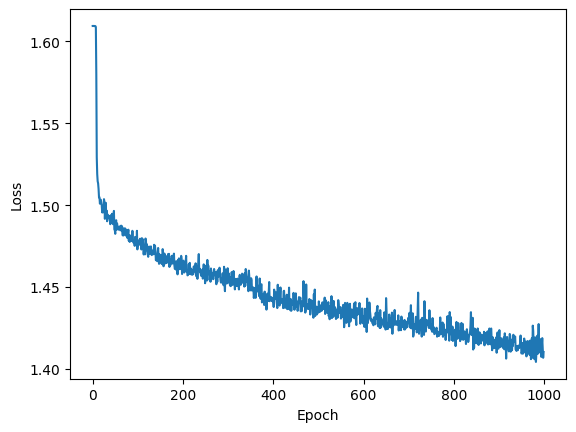

Test accuracy: 472.0404301075269
Accuracy: 0.4288172043010753
Precision: 0.41032689809642237
Recall: 0.42263913776215895
F1-score: 0.40496605491164883


Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.59      0.46       495
           1       0.68      0.81      0.74       472
           2       0.28      0.16      0.20       449
           3       0.29      0.25      0.27       463
           4       0.44      0.30      0.36       446

    accuracy                           0.43      2325
   macro avg       0.41      0.42      0.40      2325
weighted avg       0.41      0.43      0.41      2325

                    0           1           2           3           4  \
precision    0.373230    0.676732    0.275472    0.285024    0.441176   
recall       0.585859    0.807203    0.162584    0.254860    0.302691   
f1-score     0.455975    0.736232    0.204482    0.269099    0.359043   
support    495.000000  472.000000  449.0000

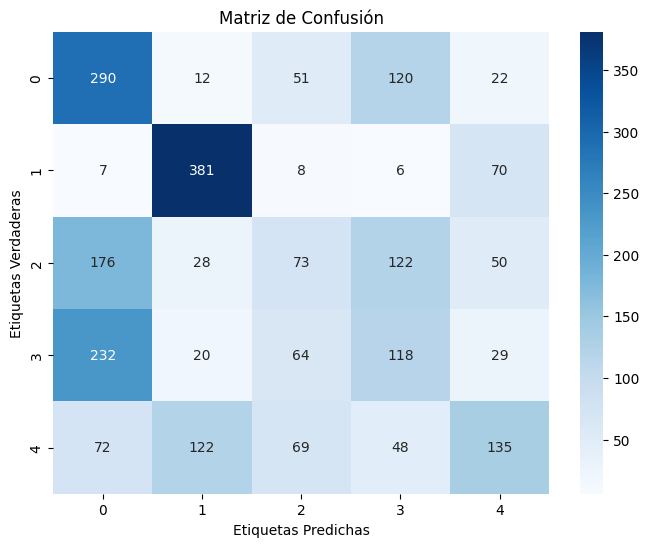

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_0.0001_0.2/resultados_1000_0.0001_0.2.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.8


Procesando epocas:   0%|                                                              | 1/1000 [00:01<29:12,  1.75s/it]

1.6096528929822584


Procesando epocas:   0%|                                                              | 2/1000 [00:03<29:13,  1.76s/it]

1.6096415624899023


Procesando epocas:   0%|▏                                                             | 3/1000 [00:05<29:17,  1.76s/it]

1.609668845990125


Procesando epocas:   0%|▏                                                             | 4/1000 [00:07<29:16,  1.76s/it]

1.6096580645617318


Procesando epocas:   0%|▎                                                             | 5/1000 [00:08<29:11,  1.76s/it]

1.6096897637142855


Procesando epocas:   1%|▎                                                             | 6/1000 [00:10<29:03,  1.75s/it]

1.6094914352192597


Procesando epocas:   1%|▍                                                             | 7/1000 [00:12<28:51,  1.74s/it]

1.609459717834697


Procesando epocas:   1%|▍                                                             | 8/1000 [00:13<28:44,  1.74s/it]

1.6094960423076854


Procesando epocas:   1%|▌                                                             | 9/1000 [00:15<28:46,  1.74s/it]

1.6093554118100335


Procesando epocas:   1%|▌                                                            | 10/1000 [00:17<28:47,  1.74s/it]

1.609130273847019


Procesando epocas:   1%|▋                                                            | 11/1000 [00:19<28:38,  1.74s/it]

1.6089476704597474


Procesando epocas:   1%|▋                                                            | 12/1000 [00:20<28:32,  1.73s/it]

1.6082384151570936


Procesando epocas:   1%|▊                                                            | 13/1000 [00:22<28:34,  1.74s/it]

1.606841552958769


Procesando epocas:   1%|▊                                                            | 14/1000 [00:24<28:36,  1.74s/it]

1.6039255191298092


Procesando epocas:   2%|▉                                                            | 15/1000 [00:26<28:37,  1.74s/it]

1.5974216019406038


Procesando epocas:   2%|▉                                                            | 16/1000 [00:27<28:37,  1.75s/it]

1.5856870707343607


Procesando epocas:   2%|█                                                            | 17/1000 [00:29<28:30,  1.74s/it]

1.5701733498012318


Procesando epocas:   2%|█                                                            | 18/1000 [00:31<28:25,  1.74s/it]

1.5555480571354137


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:33<28:10,  1.72s/it]

1.5445629400365493


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:34<28:02,  1.72s/it]

1.5377021684366114


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:36<28:01,  1.72s/it]

1.5325401621706345


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:38<27:55,  1.71s/it]

1.529196438368629


Procesando epocas:   2%|█▍                                                           | 23/1000 [00:39<27:43,  1.70s/it]

1.5256246889338774


Procesando epocas:   2%|█▍                                                           | 24/1000 [00:41<27:36,  1.70s/it]

1.5215570407755235


Procesando epocas:   2%|█▌                                                           | 25/1000 [00:43<27:32,  1.69s/it]

1.5185127980568829


Procesando epocas:   3%|█▌                                                           | 26/1000 [00:44<27:32,  1.70s/it]

1.5164996294414297


Procesando epocas:   3%|█▋                                                           | 27/1000 [00:46<27:25,  1.69s/it]

1.5141036980292377


Procesando epocas:   3%|█▋                                                           | 28/1000 [00:48<27:45,  1.71s/it]

1.5124673226300407


Procesando epocas:   3%|█▊                                                           | 29/1000 [00:50<27:50,  1.72s/it]

1.5131632208824157


Procesando epocas:   3%|█▊                                                           | 30/1000 [00:51<27:46,  1.72s/it]

1.5097341397229362


Procesando epocas:   3%|█▉                                                           | 31/1000 [00:53<27:54,  1.73s/it]

1.5102681854191948


Procesando epocas:   3%|█▉                                                           | 32/1000 [00:55<27:55,  1.73s/it]

1.5098627286798814


Procesando epocas:   3%|██                                                           | 33/1000 [00:57<27:59,  1.74s/it]

1.5078558269669027


Procesando epocas:   3%|██                                                           | 34/1000 [00:58<28:00,  1.74s/it]

1.5074154131552753


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:00<27:57,  1.74s/it]

1.50868196627673


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:02<27:51,  1.73s/it]

1.5061654062832104


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:04<27:49,  1.73s/it]

1.5036444832296934


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:05<27:48,  1.73s/it]

1.5072897728751689


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:07<27:55,  1.74s/it]

1.5030014283516828


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:09<27:41,  1.73s/it]

1.503341859929702


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:10<27:23,  1.71s/it]

1.5050125122070312


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:12<27:07,  1.70s/it]

1.503092061772066


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:14<26:56,  1.69s/it]

1.5031136737150304


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:15<26:56,  1.69s/it]

1.5027710634119371


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:17<26:49,  1.69s/it]

1.503080513196833


Procesando epocas:   5%|██▊                                                          | 46/1000 [01:19<26:45,  1.68s/it]

1.5009552142199347


Procesando epocas:   5%|██▊                                                          | 47/1000 [01:20<26:35,  1.67s/it]

1.5020703561165754


Procesando epocas:   5%|██▉                                                          | 48/1000 [01:22<26:34,  1.68s/it]

1.4997572905877057


Procesando epocas:   5%|██▉                                                          | 49/1000 [01:24<26:31,  1.67s/it]

1.5033553579274346


Procesando epocas:   5%|███                                                          | 50/1000 [01:25<26:33,  1.68s/it]

1.5009965461843153


Procesando epocas:   5%|███                                                          | 51/1000 [01:27<26:33,  1.68s/it]

1.4974493573693668


Procesando epocas:   5%|███▏                                                         | 52/1000 [01:29<26:42,  1.69s/it]

1.4981284800697776


Procesando epocas:   5%|███▏                                                         | 53/1000 [01:31<26:39,  1.69s/it]

1.5001450433450587


Procesando epocas:   5%|███▎                                                         | 54/1000 [01:32<26:34,  1.69s/it]

1.4986409993732677


Procesando epocas:   6%|███▎                                                         | 55/1000 [01:34<26:28,  1.68s/it]

1.4977489583632526


Procesando epocas:   6%|███▍                                                         | 56/1000 [01:36<26:30,  1.68s/it]

1.4973761796951295


Procesando epocas:   6%|███▍                                                         | 57/1000 [01:37<26:28,  1.68s/it]

1.4980771969346438


Procesando epocas:   6%|███▌                                                         | 58/1000 [01:39<26:22,  1.68s/it]

1.4949666990953334


Procesando epocas:   6%|███▌                                                         | 59/1000 [01:41<26:19,  1.68s/it]

1.4987885552294113


Procesando epocas:   6%|███▋                                                         | 60/1000 [01:42<26:16,  1.68s/it]

1.497607677824357


Procesando epocas:   6%|███▋                                                         | 61/1000 [01:44<26:16,  1.68s/it]

1.496265374912935


Procesando epocas:   6%|███▊                                                         | 62/1000 [01:46<26:20,  1.68s/it]

1.4955306558048025


Procesando epocas:   6%|███▊                                                         | 63/1000 [01:47<26:22,  1.69s/it]

1.497249460921568


Procesando epocas:   6%|███▉                                                         | 64/1000 [01:49<26:20,  1.69s/it]

1.4956971182542689


Procesando epocas:   6%|███▉                                                         | 65/1000 [01:51<26:16,  1.69s/it]

1.4940200679442461


Procesando epocas:   7%|████                                                         | 66/1000 [01:52<26:13,  1.69s/it]

1.4962626646546757


Procesando epocas:   7%|████                                                         | 67/1000 [01:54<26:07,  1.68s/it]

1.4961681071449728


Procesando epocas:   7%|████▏                                                        | 68/1000 [01:56<25:58,  1.67s/it]

1.4938024359590867


Procesando epocas:   7%|████▏                                                        | 69/1000 [01:57<26:04,  1.68s/it]

1.4937283410745508


Procesando epocas:   7%|████▎                                                        | 70/1000 [01:59<26:33,  1.71s/it]

1.4953965993488536


Procesando epocas:   7%|████▎                                                        | 71/1000 [02:01<26:47,  1.73s/it]

1.490718833137961


Procesando epocas:   7%|████▍                                                        | 72/1000 [02:03<27:07,  1.75s/it]

1.491309611236348


Procesando epocas:   7%|████▍                                                        | 73/1000 [02:05<27:21,  1.77s/it]

1.4920932895996992


Procesando epocas:   7%|████▌                                                        | 74/1000 [02:06<27:32,  1.78s/it]

1.4939844804651596


Procesando epocas:   8%|████▌                                                        | 75/1000 [02:08<27:37,  1.79s/it]

1.491868762408986


Procesando epocas:   8%|████▋                                                        | 76/1000 [02:10<27:35,  1.79s/it]

1.492842740171096


Procesando epocas:   8%|████▋                                                        | 77/1000 [02:12<27:36,  1.79s/it]

1.4925384451361263


Procesando epocas:   8%|████▊                                                        | 78/1000 [02:14<27:39,  1.80s/it]

1.4942036306156832


Procesando epocas:   8%|████▊                                                        | 79/1000 [02:15<27:41,  1.80s/it]

1.4947988699464236


Procesando epocas:   8%|████▉                                                        | 80/1000 [02:17<27:43,  1.81s/it]

1.490856609624975


Procesando epocas:   8%|████▉                                                        | 81/1000 [02:19<27:40,  1.81s/it]

1.4920506996266982


Procesando epocas:   8%|█████                                                        | 82/1000 [02:21<27:33,  1.80s/it]

1.487739068620345


Procesando epocas:   8%|█████                                                        | 83/1000 [02:23<27:29,  1.80s/it]

1.492907380356508


Procesando epocas:   8%|█████                                                        | 84/1000 [02:24<27:22,  1.79s/it]

1.4910333668484408


Procesando epocas:   8%|█████▏                                                       | 85/1000 [02:26<27:19,  1.79s/it]

1.4896391188397127


Procesando epocas:   9%|█████▏                                                       | 86/1000 [02:28<27:22,  1.80s/it]

1.4903345143093782


Procesando epocas:   9%|█████▎                                                       | 87/1000 [02:30<27:16,  1.79s/it]

1.4896095977110022


Procesando epocas:   9%|█████▎                                                       | 88/1000 [02:32<27:11,  1.79s/it]

1.4914124650113723


Procesando epocas:   9%|█████▍                                                       | 89/1000 [02:33<27:08,  1.79s/it]

1.4892314756617826


Procesando epocas:   9%|█████▍                                                       | 90/1000 [02:35<27:04,  1.78s/it]

1.4897402994772968


Procesando epocas:   9%|█████▌                                                       | 91/1000 [02:37<27:03,  1.79s/it]

1.4903964764931623


Procesando epocas:   9%|█████▌                                                       | 92/1000 [02:39<27:06,  1.79s/it]

1.4892053597113666


Procesando epocas:   9%|█████▋                                                       | 93/1000 [02:41<27:05,  1.79s/it]

1.49082911715788


Procesando epocas:   9%|█████▋                                                       | 94/1000 [02:42<27:09,  1.80s/it]

1.4898468732833863


Procesando epocas:  10%|█████▊                                                       | 95/1000 [02:44<27:12,  1.80s/it]

1.4892571855993832


Procesando epocas:  10%|█████▊                                                       | 96/1000 [02:46<27:16,  1.81s/it]

1.4883400889003977


Procesando epocas:  10%|█████▉                                                       | 97/1000 [02:48<27:10,  1.81s/it]

1.486342223251567


Procesando epocas:  10%|█████▉                                                       | 98/1000 [02:50<27:08,  1.81s/it]

1.4884149656576269


Procesando epocas:  10%|██████                                                       | 99/1000 [02:51<27:02,  1.80s/it]

1.487882607123431


Procesando epocas:  10%|██████                                                      | 100/1000 [02:53<27:00,  1.80s/it]

1.4900081879952374


Procesando epocas:  10%|██████                                                      | 101/1000 [02:55<26:51,  1.79s/it]

1.4887897323159611


Procesando epocas:  10%|██████                                                      | 102/1000 [02:57<26:41,  1.78s/it]

1.4912370562553405


Procesando epocas:  10%|██████▏                                                     | 103/1000 [02:58<26:27,  1.77s/it]

1.4875585401759428


Procesando epocas:  10%|██████▏                                                     | 104/1000 [03:00<26:22,  1.77s/it]

1.488137747259701


Procesando epocas:  10%|██████▎                                                     | 105/1000 [03:02<26:16,  1.76s/it]

1.4868901624399073


Procesando epocas:  11%|██████▎                                                     | 106/1000 [03:04<26:17,  1.76s/it]

1.4873183306525735


Procesando epocas:  11%|██████▍                                                     | 107/1000 [03:06<26:16,  1.77s/it]

1.487089002833647


Procesando epocas:  11%|██████▍                                                     | 108/1000 [03:07<26:15,  1.77s/it]

1.4868808234439177


Procesando epocas:  11%|██████▌                                                     | 109/1000 [03:09<26:07,  1.76s/it]

1.4861254032920388


Procesando epocas:  11%|██████▌                                                     | 110/1000 [03:11<26:03,  1.76s/it]

1.486481877635507


Procesando epocas:  11%|██████▋                                                     | 111/1000 [03:13<26:02,  1.76s/it]

1.4853033970384037


Procesando epocas:  11%|██████▋                                                     | 112/1000 [03:14<26:01,  1.76s/it]

1.484806294300977


Procesando epocas:  11%|██████▊                                                     | 113/1000 [03:16<25:59,  1.76s/it]

1.4850505408118753


Procesando epocas:  11%|██████▊                                                     | 114/1000 [03:18<25:56,  1.76s/it]

1.4853417543803944


Procesando epocas:  12%|██████▉                                                     | 115/1000 [03:20<25:49,  1.75s/it]

1.4872389561989727


Procesando epocas:  12%|██████▉                                                     | 116/1000 [03:21<25:43,  1.75s/it]

1.4861810852499568


Procesando epocas:  12%|███████                                                     | 117/1000 [03:23<25:41,  1.75s/it]

1.4853018424090216


Procesando epocas:  12%|███████                                                     | 118/1000 [03:25<25:36,  1.74s/it]

1.4838441561250126


Procesando epocas:  12%|███████▏                                                    | 119/1000 [03:26<25:29,  1.74s/it]

1.485202950589797


Procesando epocas:  12%|███████▏                                                    | 120/1000 [03:28<25:28,  1.74s/it]

1.4834500628359177


Procesando epocas:  12%|███████▎                                                    | 121/1000 [03:30<25:21,  1.73s/it]

1.4877254570231717


Procesando epocas:  12%|███████▎                                                    | 122/1000 [03:32<25:21,  1.73s/it]

1.4851931859465206


Procesando epocas:  12%|███████▍                                                    | 123/1000 [03:33<25:20,  1.73s/it]

1.4852306295843685


Procesando epocas:  12%|███████▍                                                    | 124/1000 [03:35<25:16,  1.73s/it]

1.4879762958077822


Procesando epocas:  12%|███████▌                                                    | 125/1000 [03:37<25:20,  1.74s/it]

1.4833125156514786


Procesando epocas:  13%|███████▌                                                    | 126/1000 [03:39<25:19,  1.74s/it]

1.4853294639026418


Procesando epocas:  13%|███████▌                                                    | 127/1000 [03:40<25:21,  1.74s/it]

1.4840662100735833


Procesando epocas:  13%|███████▋                                                    | 128/1000 [03:42<25:21,  1.74s/it]

1.4860493049902075


Procesando epocas:  13%|███████▋                                                    | 129/1000 [03:44<25:11,  1.74s/it]

1.4828522906583899


Procesando epocas:  13%|███████▊                                                    | 130/1000 [03:46<25:03,  1.73s/it]

1.4836104848805596


Procesando epocas:  13%|███████▊                                                    | 131/1000 [03:47<24:53,  1.72s/it]

1.4826860343708712


Procesando epocas:  13%|███████▉                                                    | 132/1000 [03:49<24:52,  1.72s/it]

1.4863641717854668


Procesando epocas:  13%|███████▉                                                    | 133/1000 [03:51<24:47,  1.72s/it]

1.4828672745648552


Procesando epocas:  13%|████████                                                    | 134/1000 [03:52<24:42,  1.71s/it]

1.481872053006116


Procesando epocas:  14%|████████                                                    | 135/1000 [03:54<24:45,  1.72s/it]

1.479562136004953


Procesando epocas:  14%|████████▏                                                   | 136/1000 [03:56<24:41,  1.71s/it]

1.4859530778492198


Procesando epocas:  14%|████████▏                                                   | 137/1000 [03:58<24:38,  1.71s/it]

1.4816050901132471


Procesando epocas:  14%|████████▎                                                   | 138/1000 [03:59<24:33,  1.71s/it]

1.4804936976993786


Procesando epocas:  14%|████████▎                                                   | 139/1000 [04:01<24:28,  1.71s/it]

1.4813922328107498


Procesando epocas:  14%|████████▍                                                   | 140/1000 [04:03<24:35,  1.72s/it]

1.4826311356881086


Procesando epocas:  14%|████████▍                                                   | 141/1000 [04:04<24:43,  1.73s/it]

1.479792272343355


Procesando epocas:  14%|████████▌                                                   | 142/1000 [04:06<24:42,  1.73s/it]

1.4845761327182545


Procesando epocas:  14%|████████▌                                                   | 143/1000 [04:08<24:38,  1.73s/it]

1.4820440271321464


Procesando epocas:  14%|████████▋                                                   | 144/1000 [04:10<24:32,  1.72s/it]

1.4813519695225883


Procesando epocas:  14%|████████▋                                                   | 145/1000 [04:11<24:29,  1.72s/it]

1.482946838350857


Procesando epocas:  15%|████████▊                                                   | 146/1000 [04:13<24:31,  1.72s/it]

1.4831734474967508


Procesando epocas:  15%|████████▊                                                   | 147/1000 [04:15<24:33,  1.73s/it]

1.485231046816882


Procesando epocas:  15%|████████▉                                                   | 148/1000 [04:17<24:29,  1.72s/it]

1.4800089134889491


Procesando epocas:  15%|████████▉                                                   | 149/1000 [04:18<24:27,  1.72s/it]

1.4836408748346217


Procesando epocas:  15%|█████████                                                   | 150/1000 [04:20<24:25,  1.72s/it]

1.481755787484786


Procesando epocas:  15%|█████████                                                   | 151/1000 [04:22<24:18,  1.72s/it]

1.4832588763797985


Procesando epocas:  15%|█████████                                                   | 152/1000 [04:23<24:08,  1.71s/it]

1.481152429300196


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [04:25<24:08,  1.71s/it]

1.4831348622546476


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [04:27<24:08,  1.71s/it]

1.4821858356980717


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [04:28<24:03,  1.71s/it]

1.4824528027983273


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [04:30<24:03,  1.71s/it]

1.4793664918226355


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [04:32<24:03,  1.71s/it]

1.480027425289154


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [04:34<24:09,  1.72s/it]

1.4818344235420227


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [04:35<24:10,  1.72s/it]

1.4831892630633186


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [04:37<24:04,  1.72s/it]

1.4791134778191062


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [04:39<23:56,  1.71s/it]

1.4817579115138335


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [04:40<23:52,  1.71s/it]

1.481025730862337


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [04:42<23:53,  1.71s/it]

1.4797501676222857


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [04:44<23:56,  1.72s/it]

1.4818020448965186


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [04:46<24:01,  1.73s/it]

1.484470016114852


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [04:47<23:58,  1.73s/it]

1.4802754226852866


Procesando epocas:  17%|██████████                                                  | 167/1000 [04:49<23:56,  1.72s/it]

1.4782189320115482


Procesando epocas:  17%|██████████                                                  | 168/1000 [04:51<23:52,  1.72s/it]

1.4777874013956855


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [04:53<23:52,  1.72s/it]

1.480407787771786


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [04:54<23:53,  1.73s/it]

1.4788040392539081


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [04:56<23:50,  1.73s/it]

1.4797852579285116


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [04:58<23:49,  1.73s/it]

1.4791451271842508


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [04:59<23:46,  1.73s/it]

1.4781939513543072


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [05:01<23:42,  1.72s/it]

1.4777755106196684


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [05:03<23:44,  1.73s/it]

1.4789482418228599


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [05:05<23:45,  1.73s/it]

1.481866565872641


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [05:06<23:45,  1.73s/it]

1.4798271487740908


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [05:08<23:39,  1.73s/it]

1.4776388518950518


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [05:10<23:32,  1.72s/it]

1.4803465597769794


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [05:12<23:27,  1.72s/it]

1.478993211073034


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [05:13<23:25,  1.72s/it]

1.4767265298787284


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [05:15<23:28,  1.72s/it]

1.4771879890385795


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [05:17<23:28,  1.72s/it]

1.4760277727070976


Procesando epocas:  18%|███████████                                                 | 184/1000 [05:18<23:30,  1.73s/it]

1.475921149113599


Procesando epocas:  18%|███████████                                                 | 185/1000 [05:20<23:27,  1.73s/it]

1.4825164668700275


Procesando epocas:  19%|███████████▏                                                | 186/1000 [05:22<23:29,  1.73s/it]

1.4805335942436666


Procesando epocas:  19%|███████████▏                                                | 187/1000 [05:24<23:24,  1.73s/it]

1.477680387216456


Procesando epocas:  19%|███████████▎                                                | 188/1000 [05:25<23:21,  1.73s/it]

1.4780799059306875


Procesando epocas:  19%|███████████▎                                                | 189/1000 [05:27<23:20,  1.73s/it]

1.4791934118551366


Procesando epocas:  19%|███████████▍                                                | 190/1000 [05:29<23:25,  1.74s/it]

1.4802113252527573


Procesando epocas:  19%|███████████▍                                                | 191/1000 [05:31<23:22,  1.73s/it]

1.475886466222651


Procesando epocas:  19%|███████████▌                                                | 192/1000 [05:32<23:25,  1.74s/it]

1.479268034065471


Procesando epocas:  19%|███████████▌                                                | 193/1000 [05:34<23:42,  1.76s/it]

1.4788722466020023


Procesando epocas:  19%|███████████▋                                                | 194/1000 [05:36<23:46,  1.77s/it]

1.475522164737477


Procesando epocas:  20%|███████████▋                                                | 195/1000 [05:38<23:51,  1.78s/it]

1.4781789786675397


Procesando epocas:  20%|███████████▊                                                | 196/1000 [05:40<23:57,  1.79s/it]

1.4806529809446896


Procesando epocas:  20%|███████████▊                                                | 197/1000 [05:41<24:00,  1.79s/it]

1.478000869470484


Procesando epocas:  20%|███████████▉                                                | 198/1000 [05:43<23:58,  1.79s/it]

1.4786572589593776


Procesando epocas:  20%|███████████▉                                                | 199/1000 [05:45<23:55,  1.79s/it]

1.4787884074098923


Procesando epocas:  20%|████████████                                                | 200/1000 [05:47<23:53,  1.79s/it]

1.4776389977511237


Procesando epocas:  20%|████████████                                                | 201/1000 [05:48<23:45,  1.78s/it]

1.47761332357631


Procesando epocas:  20%|████████████                                                | 202/1000 [05:50<23:37,  1.78s/it]

1.4791550243602078


Procesando epocas:  20%|████████████▏                                               | 203/1000 [05:52<23:28,  1.77s/it]

1.4801712232477524


Procesando epocas:  20%|████████████▏                                               | 204/1000 [05:54<23:28,  1.77s/it]

1.4774829394677107


Procesando epocas:  20%|████████████▎                                               | 205/1000 [05:56<23:26,  1.77s/it]

1.4771740513689378


Procesando epocas:  21%|████████████▎                                               | 206/1000 [05:57<23:28,  1.77s/it]

1.4787137978217182


Procesando epocas:  21%|████████████▍                                               | 207/1000 [05:59<23:36,  1.79s/it]

1.4805625494788675


Procesando epocas:  21%|████████████▍                                               | 208/1000 [06:01<23:38,  1.79s/it]

1.4786766991895788


Procesando epocas:  21%|████████████▌                                               | 209/1000 [06:03<23:36,  1.79s/it]

1.4769292277448318


Procesando epocas:  21%|████████████▌                                               | 210/1000 [06:05<23:33,  1.79s/it]

1.4784167240647708


Procesando epocas:  21%|████████████▋                                               | 211/1000 [06:06<23:32,  1.79s/it]

1.4783370424719418


Procesando epocas:  21%|████████████▋                                               | 212/1000 [06:08<23:25,  1.78s/it]

1.4807445470024558


Procesando epocas:  21%|████████████▊                                               | 213/1000 [06:10<23:17,  1.78s/it]

1.4794597716892466


Procesando epocas:  21%|████████████▊                                               | 214/1000 [06:12<23:13,  1.77s/it]

1.4763278000495013


Procesando epocas:  22%|████████████▉                                               | 215/1000 [06:13<23:04,  1.76s/it]

1.4740028535618501


Procesando epocas:  22%|████████████▉                                               | 216/1000 [06:15<23:09,  1.77s/it]

1.475436569662655


Procesando epocas:  22%|█████████████                                               | 217/1000 [06:17<23:11,  1.78s/it]

1.4767862663549536


Procesando epocas:  22%|█████████████                                               | 218/1000 [06:19<23:05,  1.77s/it]

1.477108927334056


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [06:20<22:56,  1.76s/it]

1.4760348334031947


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [06:22<22:57,  1.77s/it]

1.477019739852232


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [06:24<22:50,  1.76s/it]

1.4750343638307908


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [06:26<22:50,  1.76s/it]

1.4750305589507609


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [06:27<22:43,  1.75s/it]

1.478047435423907


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [06:29<22:34,  1.75s/it]

1.478247479831471


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [06:31<22:25,  1.74s/it]

1.4775783798273872


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [06:33<22:17,  1.73s/it]

1.474608166778789


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [06:34<22:11,  1.72s/it]

1.475708411020391


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [06:36<22:04,  1.72s/it]

1.4766601835980135


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [06:38<22:03,  1.72s/it]

1.4780662978396697


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [06:39<21:59,  1.71s/it]

1.4765542275765362


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [06:41<21:57,  1.71s/it]

1.4792217191527872


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [06:43<21:56,  1.71s/it]

1.475366540516124


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [06:45<21:54,  1.71s/it]

1.4759371876716614


Procesando epocas:  23%|██████████████                                              | 234/1000 [06:46<21:48,  1.71s/it]

1.4801433878786423


Procesando epocas:  24%|██████████████                                              | 235/1000 [06:48<21:46,  1.71s/it]

1.472555294457604


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [06:50<21:46,  1.71s/it]

1.4804508384536295


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [06:51<21:44,  1.71s/it]

1.4787280685761395


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [06:53<21:43,  1.71s/it]

1.4734275937080383


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [06:55<21:37,  1.71s/it]

1.4783917840789347


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [06:57<21:37,  1.71s/it]

1.479924067328958


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [06:58<21:38,  1.71s/it]

1.4754592944593992


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [07:00<21:37,  1.71s/it]

1.4797159580623402


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [07:02<21:37,  1.71s/it]

1.475075522591086


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [07:03<21:36,  1.71s/it]

1.4749092375530917


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [07:05<21:31,  1.71s/it]

1.4780401629560134


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [07:07<21:30,  1.71s/it]

1.4803566056139328


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [07:09<21:30,  1.71s/it]

1.4763825928463656


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [07:10<21:27,  1.71s/it]

1.4755660007981692


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [07:12<21:26,  1.71s/it]

1.4744554807158077


Procesando epocas:  25%|███████████████                                             | 250/1000 [07:14<21:22,  1.71s/it]

1.4755805134773254


Procesando epocas:  25%|███████████████                                             | 251/1000 [07:15<21:27,  1.72s/it]

1.4770469406071831


Procesando epocas:  25%|███████████████                                             | 252/1000 [07:17<21:20,  1.71s/it]

1.4719441427904016


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [07:19<21:17,  1.71s/it]

1.4753923037472894


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [07:20<21:16,  1.71s/it]

1.475296511369593


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [07:22<21:18,  1.72s/it]

1.4746003690887899


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [07:24<21:14,  1.71s/it]

1.4733903527259826


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [07:26<21:09,  1.71s/it]

1.4741880416870117


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [07:27<21:01,  1.70s/it]

1.477036056097816


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [07:29<20:55,  1.69s/it]

1.4755866471458883


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [07:31<20:51,  1.69s/it]

1.4765204422614153


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [07:32<20:50,  1.69s/it]

1.4769445475410012


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [07:34<20:48,  1.69s/it]

1.47543203830719


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [07:36<20:47,  1.69s/it]

1.4731641657212202


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [07:37<20:55,  1.71s/it]

1.4730965726515826


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [07:39<21:00,  1.71s/it]

1.4735110310947195


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [07:41<20:59,  1.72s/it]

1.472383713722229


Procesando epocas:  27%|████████████████                                            | 267/1000 [07:43<20:58,  1.72s/it]

1.474928239513846


Procesando epocas:  27%|████████████████                                            | 268/1000 [07:44<20:59,  1.72s/it]

1.4757002676234525


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [07:46<20:59,  1.72s/it]

1.4756513420273276


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [07:48<20:58,  1.72s/it]

1.4748320376171786


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [07:50<20:57,  1.72s/it]

1.4752823324764477


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [07:51<20:57,  1.73s/it]

1.4743209067512961


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [07:53<20:55,  1.73s/it]

1.4752993450445286


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [07:55<20:54,  1.73s/it]

1.4770320534706116


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [07:56<20:54,  1.73s/it]

1.473451609471265


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [07:58<20:53,  1.73s/it]

1.4733994448886198


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [08:00<20:52,  1.73s/it]

1.4735902912476484


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [08:02<20:51,  1.73s/it]

1.4735994528321659


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [08:03<20:50,  1.73s/it]

1.4737360140856575


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [08:05<20:47,  1.73s/it]

1.4731205582618714


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [08:07<20:45,  1.73s/it]

1.4744491857640885


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [08:09<20:43,  1.73s/it]

1.4751441289396847


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [08:10<20:40,  1.73s/it]

1.474197225710925


Procesando epocas:  28%|█████████████████                                           | 284/1000 [08:12<20:33,  1.72s/it]

1.4733495543984805


Procesando epocas:  28%|█████████████████                                           | 285/1000 [08:14<20:30,  1.72s/it]

1.4740504159646877


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [08:16<20:31,  1.72s/it]

1.4752208085621104


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [08:17<20:29,  1.72s/it]

1.4743837293456583


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [08:19<20:25,  1.72s/it]

1.4746431624188143


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [08:21<20:33,  1.73s/it]

1.47476705382852


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [08:22<20:36,  1.74s/it]

1.482010866613949


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [08:24<20:34,  1.74s/it]

1.4745161161703222


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [08:26<20:29,  1.74s/it]

1.4725101576131934


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [08:28<20:28,  1.74s/it]

1.4786528916919932


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [08:29<20:27,  1.74s/it]

1.4753170216784757


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [08:31<20:22,  1.73s/it]

1.4742338986957775


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [08:33<20:21,  1.74s/it]

1.4708683154162239


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [08:35<20:20,  1.74s/it]

1.4714134524850284


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [08:36<20:18,  1.74s/it]

1.4744051982374753


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [08:38<20:14,  1.73s/it]

1.4734866612097797


Procesando epocas:  30%|██████████████████                                          | 300/1000 [08:40<20:13,  1.73s/it]

1.4727613294825834


Procesando epocas:  30%|██████████████████                                          | 301/1000 [08:42<20:11,  1.73s/it]

1.4748501034343944


Procesando epocas:  30%|██████████████████                                          | 302/1000 [08:43<20:11,  1.74s/it]

1.4720605422468747


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [08:45<20:09,  1.74s/it]

1.4735654045553768


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [08:47<20:09,  1.74s/it]

1.4744206148035386


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [08:48<20:07,  1.74s/it]

1.4721651063245886


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [08:50<20:05,  1.74s/it]

1.4764978710342855


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [08:52<20:00,  1.73s/it]

1.473188170264749


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [08:54<19:59,  1.73s/it]

1.4784767199965085


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [08:55<19:55,  1.73s/it]

1.475394710372476


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [08:57<19:57,  1.74s/it]

1.472766266850864


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [08:59<19:55,  1.74s/it]

1.4720231687321383


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [09:01<19:53,  1.73s/it]

1.4743847321061527


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [09:02<19:50,  1.73s/it]

1.4698571345385383


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [09:04<19:49,  1.73s/it]

1.4715516553205603


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [09:06<19:56,  1.75s/it]

1.4736843102118549


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [09:08<20:08,  1.77s/it]

1.4726164446157568


Procesando epocas:  32%|███████████████████                                         | 317/1000 [09:10<20:18,  1.78s/it]

1.4728008431546828


Procesando epocas:  32%|███████████████████                                         | 318/1000 [09:11<20:20,  1.79s/it]

1.4755475570173824


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [09:13<20:22,  1.80s/it]

1.474787810269524


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [09:15<20:28,  1.81s/it]

1.4728157141629388


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [09:17<20:29,  1.81s/it]

1.4712416389409233


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [09:19<20:29,  1.81s/it]

1.4760864713612725


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [09:20<20:25,  1.81s/it]

1.469430575651281


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [09:22<20:26,  1.81s/it]

1.474349746984594


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [09:24<20:24,  1.81s/it]

1.4714903550989487


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [09:26<20:18,  1.81s/it]

1.4720883993541494


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [09:28<20:18,  1.81s/it]

1.4706098619629355


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [09:29<20:19,  1.81s/it]

1.4704000480034771


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [09:31<20:16,  1.81s/it]

1.4710964525447172


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [09:33<20:16,  1.81s/it]

1.4708052123294157


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [09:35<20:11,  1.81s/it]

1.471849329331342


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [09:37<20:08,  1.81s/it]

1.4729740612647113


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [09:39<20:07,  1.81s/it]

1.4742653594297521


Procesando epocas:  33%|████████████████████                                        | 334/1000 [09:40<20:06,  1.81s/it]

1.4699488534646876


Procesando epocas:  34%|████████████████████                                        | 335/1000 [09:42<20:08,  1.82s/it]

1.470727611990536


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [09:44<20:08,  1.82s/it]

1.471855549251332


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [09:46<20:01,  1.81s/it]

1.472083616256714


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [09:48<19:55,  1.81s/it]

1.4733028902727014


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [09:49<19:47,  1.80s/it]

1.4743514348478879


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [09:51<19:42,  1.79s/it]

1.4732296445790458


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [09:53<19:41,  1.79s/it]

1.4702019074383903


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [09:55<19:40,  1.79s/it]

1.4710085237727446


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [09:57<19:37,  1.79s/it]

1.4697063347872565


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [09:58<19:30,  1.78s/it]

1.472407695826362


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [10:00<19:29,  1.78s/it]

1.4695566072183497


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [10:02<19:23,  1.78s/it]

1.4694646884413327


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [10:04<19:14,  1.77s/it]

1.4745755363913144


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [10:05<19:07,  1.76s/it]

1.4754852659562054


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [10:07<19:02,  1.75s/it]

1.4740514194264132


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [10:09<18:54,  1.75s/it]

1.4689629954450272


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [10:11<18:52,  1.74s/it]

1.4771487502490772


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [10:12<18:48,  1.74s/it]

1.4726996218456943


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [10:14<18:45,  1.74s/it]

1.4712982163709754


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [10:16<18:46,  1.74s/it]

1.4734073954470017


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [10:17<18:45,  1.75s/it]

1.4702094155199388


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [10:19<18:44,  1.75s/it]

1.4723124356830821


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [10:21<18:38,  1.74s/it]

1.4726392717922434


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [10:23<18:35,  1.74s/it]

1.471536984163172


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [10:24<18:37,  1.74s/it]

1.470435418100918


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [10:26<18:36,  1.74s/it]

1.4713774919509888


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [10:28<18:34,  1.74s/it]

1.4752955008955564


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [10:30<18:34,  1.75s/it]

1.4703468364827774


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [10:31<18:32,  1.75s/it]

1.4712019555708942


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [10:33<18:29,  1.75s/it]

1.4707355148652022


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [10:35<18:27,  1.74s/it]

1.4729704695589403


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [10:37<18:26,  1.74s/it]

1.4694502423791325


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [10:38<18:24,  1.74s/it]

1.470190198281232


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [10:40<18:22,  1.74s/it]

1.4710046403548296


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [10:42<18:20,  1.74s/it]

1.4706405401229858


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [10:44<18:21,  1.75s/it]

1.4728540476630716


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [10:45<18:19,  1.75s/it]

1.4691318918676937


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [10:47<18:22,  1.75s/it]

1.4728263041552376


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [10:49<18:22,  1.76s/it]

1.4729608486680423


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [10:51<18:22,  1.76s/it]

1.4729114925160127


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [10:52<18:18,  1.76s/it]

1.4722948453005622


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [10:54<18:18,  1.76s/it]

1.469490842258229


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [10:56<18:18,  1.76s/it]

1.4718775279381695


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [10:58<18:16,  1.76s/it]

1.4710829061620376


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [11:00<18:15,  1.76s/it]

1.4719721226131215


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [11:01<18:13,  1.76s/it]

1.4678881778436548


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [11:03<18:08,  1.76s/it]

1.4701793859986698


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [11:05<18:03,  1.75s/it]

1.471621604526744


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [11:07<18:02,  1.76s/it]

1.4703588843345643


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [11:08<17:57,  1.75s/it]

1.468932038194993


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [11:10<17:56,  1.75s/it]

1.4692744297139786


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [11:12<17:54,  1.75s/it]

1.469086901580586


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [11:14<17:54,  1.75s/it]

1.4687798997935126


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [11:15<17:53,  1.75s/it]

1.4734242221888374


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [11:17<17:50,  1.75s/it]

1.4726379275321961


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [11:19<17:49,  1.75s/it]

1.4676302734543296


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [11:21<17:46,  1.75s/it]

1.471428259681253


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [11:22<17:43,  1.75s/it]

1.4718270673471339


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [11:24<17:44,  1.75s/it]

1.46950821946649


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [11:26<17:40,  1.75s/it]

1.4726828483974232


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [11:28<17:40,  1.75s/it]

1.4760591808487387


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [11:29<17:37,  1.75s/it]

1.4691007333643296


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [11:31<17:36,  1.75s/it]

1.4739160572781282


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [11:33<17:36,  1.75s/it]

1.4730420940062579


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [11:35<17:35,  1.76s/it]

1.471772935811211


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [11:36<17:33,  1.76s/it]

1.471229185777552


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [11:38<17:31,  1.76s/it]

1.470542597770691


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [11:40<17:32,  1.76s/it]

1.4685792025397806


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [11:42<17:30,  1.76s/it]

1.4683630810064427


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [11:43<17:26,  1.76s/it]

1.4697929859161376


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [11:45<17:25,  1.76s/it]

1.4730505066759445


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [11:47<17:20,  1.75s/it]

1.4710086787448209


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [11:49<17:17,  1.75s/it]

1.4696300913305844


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [11:50<17:12,  1.74s/it]

1.4698018915512983


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [11:52<17:02,  1.73s/it]

1.4737123524441438


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [11:54<16:59,  1.73s/it]

1.4690181844374712


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [11:55<17:00,  1.73s/it]

1.46906399306129


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [11:57<16:51,  1.72s/it]

1.4665728639153872


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [11:59<17:24,  1.78s/it]

1.469683087573332


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [12:01<17:12,  1.76s/it]

1.4722591954119064


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [12:03<16:57,  1.74s/it]

1.470107340111452


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [12:04<17:23,  1.79s/it]

1.4686884515425738


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [12:06<16:59,  1.75s/it]

1.4717895648058723


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [12:08<16:43,  1.72s/it]

1.4704932710703682


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [12:09<16:33,  1.71s/it]

1.472426748976988


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [12:11<16:26,  1.70s/it]

1.4695590145447675


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [12:13<16:16,  1.69s/it]

1.4706869861658882


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [12:14<16:10,  1.68s/it]

1.4676738928346074


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [12:16<16:09,  1.68s/it]

1.4689570791581097


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [12:18<16:04,  1.67s/it]

1.4680112291784848


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [12:19<16:03,  1.68s/it]

1.4698511796839098


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [12:21<16:04,  1.68s/it]

1.4680074530489304


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [12:23<16:02,  1.68s/it]

1.4671063815846164


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [12:24<15:57,  1.67s/it]

1.4692921778734993


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [12:26<15:56,  1.67s/it]

1.4705481971011443


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [12:28<15:56,  1.68s/it]

1.4698787436765783


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [12:29<15:55,  1.68s/it]

1.4663656494196724


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [12:31<15:50,  1.67s/it]

1.470728215750526


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [12:33<15:50,  1.68s/it]

1.4701074873699862


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [12:35<15:49,  1.68s/it]

1.4701978711520924


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [12:36<15:45,  1.67s/it]

1.4702577429659227


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [12:38<15:42,  1.67s/it]

1.4726439251619228


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [12:40<15:41,  1.67s/it]

1.4703928842264062


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [12:41<15:47,  1.69s/it]

1.471826549838571


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [12:43<15:56,  1.71s/it]

1.4662920355796814


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [12:45<16:04,  1.72s/it]

1.469866527529324


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [12:47<16:07,  1.73s/it]

1.4676116087857414


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [12:48<16:11,  1.74s/it]

1.4741637075648588


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [12:50<16:12,  1.75s/it]

1.4750351926859688


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [12:52<16:11,  1.75s/it]

1.471162919437184


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [12:54<16:11,  1.75s/it]

1.467399574728573


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [12:55<16:09,  1.75s/it]

1.4694063060423908


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [12:57<16:07,  1.75s/it]

1.4671924198375028


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [12:59<16:09,  1.76s/it]

1.4712779564016005


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [13:01<16:05,  1.75s/it]

1.4672540825956009


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [13:02<16:06,  1.76s/it]

1.4712770433986888


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [13:04<16:04,  1.76s/it]

1.4700963181607865


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [13:06<16:01,  1.76s/it]

1.4693073160508099


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [13:08<16:00,  1.76s/it]

1.4681302680688746


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [13:09<15:59,  1.76s/it]

1.4667864862610311


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [13:11<15:56,  1.75s/it]

1.469185679099139


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [13:13<15:55,  1.76s/it]

1.4677896534695345


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [13:15<15:50,  1.75s/it]

1.4681717038154602


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [13:16<15:47,  1.75s/it]

1.471445503655602


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [13:18<15:55,  1.77s/it]

1.4724685739068424


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [13:20<16:00,  1.78s/it]

1.471866651843576


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [13:22<16:02,  1.79s/it]

1.4702416202601265


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [13:24<16:02,  1.79s/it]

1.4716426344478832


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [13:25<15:57,  1.78s/it]

1.4685668482499965


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [13:27<15:57,  1.79s/it]

1.4677685513215906


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [13:29<15:56,  1.79s/it]

1.4693338604534374


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [13:31<15:53,  1.79s/it]

1.4725550504291758


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [13:32<15:48,  1.78s/it]

1.4702583074569702


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [13:34<15:44,  1.77s/it]

1.4694546657450058


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [13:36<15:36,  1.76s/it]

1.4708037046825184


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [13:38<15:29,  1.75s/it]

1.470584396754994


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [13:39<15:23,  1.75s/it]

1.4677632352885077


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [13:41<15:20,  1.74s/it]

1.472839142294491


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [13:43<15:20,  1.75s/it]

1.4700661203440497


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [13:45<15:19,  1.75s/it]

1.4701248407363892


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [13:46<15:16,  1.75s/it]

1.4721161800272324


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [13:48<15:15,  1.75s/it]

1.471466398940367


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [13:50<15:13,  1.75s/it]

1.4690605703522177


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [13:52<15:11,  1.75s/it]

1.4651012049001806


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [13:53<15:11,  1.75s/it]

1.467769791098202


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [13:55<15:10,  1.75s/it]

1.4692870189161862


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [13:57<15:09,  1.75s/it]

1.4705792342915254


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [13:59<15:06,  1.75s/it]

1.4662830843644983


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [14:00<15:04,  1.75s/it]

1.4711951543303097


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [14:02<15:03,  1.75s/it]

1.467149207872503


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [14:04<15:01,  1.75s/it]

1.468167714511647


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [14:06<15:00,  1.75s/it]

1.4656806833603804


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [14:07<14:58,  1.75s/it]

1.4705098846379447


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [14:09<14:55,  1.75s/it]

1.4673830621382769


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [14:11<14:54,  1.75s/it]

1.4714720487594604


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [14:13<14:52,  1.75s/it]

1.468800547543694


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [14:14<14:52,  1.75s/it]

1.4684138943167293


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [14:16<14:49,  1.75s/it]

1.4667767524719237


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [14:18<14:47,  1.75s/it]

1.4686964070095736


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [14:20<14:45,  1.75s/it]

1.4687059500638175


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [14:21<14:43,  1.75s/it]

1.4704472212230457


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [14:23<14:41,  1.75s/it]

1.4701978662434747


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [14:25<14:36,  1.74s/it]

1.4667040376102223


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [14:27<14:30,  1.73s/it]

1.4676200600231395


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [14:28<14:25,  1.73s/it]

1.4695984791306889


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [14:30<14:22,  1.73s/it]

1.4674103680778952


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [14:32<14:19,  1.72s/it]

1.4731799588483923


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [14:33<14:21,  1.73s/it]

1.4683159091893365


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [14:35<14:19,  1.73s/it]

1.4721151499187246


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [14:37<14:17,  1.73s/it]

1.4688087323132684


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [14:39<14:15,  1.73s/it]

1.4711536463569193


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [14:40<14:14,  1.73s/it]

1.4702911636408638


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [14:42<14:13,  1.73s/it]

1.465756777454825


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [14:44<14:09,  1.73s/it]

1.4686108715393964


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [14:46<14:04,  1.72s/it]

1.4692176706650677


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [14:47<14:01,  1.72s/it]

1.4674818480716032


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [14:49<14:02,  1.72s/it]

1.4693934265305013


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [14:51<14:02,  1.73s/it]

1.466721554363475


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [14:52<14:02,  1.73s/it]

1.4667740113594954


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [14:54<14:00,  1.73s/it]

1.467601710908553


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [14:56<13:57,  1.73s/it]

1.4708500434370602


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [14:58<13:52,  1.72s/it]

1.4655979303752675


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [14:59<13:52,  1.72s/it]

1.4705693749820485


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [15:01<13:53,  1.73s/it]

1.465860921495101


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [15:03<14:04,  1.76s/it]

1.4739842232535867


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [15:05<13:58,  1.75s/it]

1.4693693651872524


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [15:06<13:50,  1.73s/it]

1.4694380942512961


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [15:08<13:46,  1.73s/it]

1.4654721168910756


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [15:10<13:39,  1.72s/it]

1.4650440293199876


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [15:11<13:34,  1.71s/it]

1.46756854057312


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [15:13<13:30,  1.71s/it]

1.472249583637013


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [15:15<13:29,  1.71s/it]

1.4662373451625599


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [15:17<13:28,  1.71s/it]

1.4670182375346914


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [15:18<13:24,  1.71s/it]

1.4649900254081278


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [15:20<13:18,  1.69s/it]

1.472305905117708


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [15:22<13:13,  1.69s/it]

1.466034355584313


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [15:23<13:10,  1.69s/it]

1.4675585592494291


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [15:25<13:07,  1.68s/it]

1.4650942185345819


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [15:27<13:06,  1.68s/it]

1.4669242473209605


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [15:28<13:02,  1.68s/it]

1.467328851363238


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [15:30<12:58,  1.67s/it]

1.4709728486397686


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [15:32<12:57,  1.67s/it]

1.4688245310502894


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [15:33<12:53,  1.67s/it]

1.46870518431944


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [15:35<12:51,  1.67s/it]

1.4661214379703298


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [15:37<12:48,  1.67s/it]

1.4669034200556137


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [15:38<12:47,  1.67s/it]

1.4674087159773883


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [15:40<12:45,  1.67s/it]

1.465567915579852


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [15:42<12:47,  1.68s/it]

1.4646290007759544


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [15:43<12:46,  1.68s/it]

1.4683032723034128


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [15:45<12:43,  1.67s/it]

1.468428275865667


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [15:47<12:40,  1.67s/it]

1.4668952521155862


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [15:48<12:37,  1.67s/it]

1.466648244156557


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [15:50<12:35,  1.67s/it]

1.4695786910898545


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [15:52<12:34,  1.67s/it]

1.4678848701364853


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [15:53<12:31,  1.67s/it]

1.4673056097591624


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [15:55<12:30,  1.67s/it]

1.4657578307039598


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [15:57<12:28,  1.67s/it]

1.4654493310872245


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [15:58<12:27,  1.67s/it]

1.4660824579351088


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [16:00<12:24,  1.67s/it]

1.4677820366971632


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [16:02<12:25,  1.67s/it]

1.4660695314407348


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [16:03<12:29,  1.68s/it]

1.466614441310658


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [16:05<12:33,  1.70s/it]

1.4715970649438745


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [16:07<12:34,  1.70s/it]

1.4682645299855401


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [16:09<12:36,  1.71s/it]

1.4692936904290144


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [16:10<12:35,  1.71s/it]

1.468320199321298


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [16:12<12:43,  1.73s/it]

1.466387895976796


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [16:14<12:48,  1.75s/it]

1.4658527486464556


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [16:16<12:53,  1.77s/it]

1.4646540929289424


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [16:17<12:54,  1.77s/it]

1.467200078683741


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [16:19<12:54,  1.78s/it]

1.466814984293545


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [16:21<12:54,  1.78s/it]

1.4694762594559614


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [16:23<12:55,  1.79s/it]

1.4659912992926205


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [16:25<12:53,  1.79s/it]

1.4677429655018974


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [16:26<12:52,  1.79s/it]

1.466096739207997


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [16:28<12:51,  1.79s/it]

1.4642179867800544


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [16:30<12:50,  1.79s/it]

1.4688244433964


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [16:32<12:49,  1.79s/it]

1.4673926970537972


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [16:34<12:49,  1.80s/it]

1.466634000048918


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [16:35<12:49,  1.80s/it]

1.4669282366247738


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [16:37<12:46,  1.80s/it]

1.4648611966301412


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [16:39<12:45,  1.80s/it]

1.464678790288813


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [16:40<11:57,  1.69s/it]

1.4642594421611113


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [16:42<11:34,  1.64s/it]

1.4639447920462665


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [16:44<11:52,  1.69s/it]

1.4653149261194116


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [16:46<12:06,  1.73s/it]

1.4672326193136327


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [16:47<12:13,  1.75s/it]

1.4641376930124619


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [16:49<12:18,  1.76s/it]

1.4679608394117916


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [16:51<12:22,  1.78s/it]

1.4656619976548588


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [16:53<12:25,  1.79s/it]

1.4663101631052353


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [16:55<12:25,  1.79s/it]

1.4668725897284116


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [16:56<12:22,  1.79s/it]

1.4672322469599106


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [16:58<12:19,  1.79s/it]

1.4687354389358969


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [17:00<12:17,  1.79s/it]

1.4656461119651794


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [17:02<12:19,  1.80s/it]

1.4650023663745206


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [17:04<12:17,  1.79s/it]

1.472718980733086


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [17:05<12:16,  1.80s/it]

1.466075044519761


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [17:07<12:09,  1.78s/it]

1.4641840436879325


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [17:09<12:02,  1.77s/it]

1.4646146837402791


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [17:11<11:58,  1.76s/it]

1.464759196954615


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [17:12<11:54,  1.76s/it]

1.4664573241682615


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [17:14<11:50,  1.76s/it]

1.4695933916989494


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [17:16<11:48,  1.75s/it]

1.4637253459762125


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [17:18<11:46,  1.75s/it]

1.4618967238594505


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [17:19<11:44,  1.75s/it]

1.465869883929982


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [17:21<11:43,  1.75s/it]

1.4647514329237097


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [17:23<11:41,  1.75s/it]

1.4659696515868692


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [17:25<11:37,  1.75s/it]

1.468113240073709


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [17:26<11:35,  1.75s/it]

1.4640152461388531


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [17:28<11:30,  1.74s/it]

1.4673664934494917


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [17:30<11:22,  1.72s/it]

1.4643671260160558


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [17:31<11:18,  1.72s/it]

1.4649516330045813


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [17:33<11:15,  1.71s/it]

1.4652143779922935


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [17:35<11:13,  1.71s/it]

1.463679369056926


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [17:37<11:11,  1.71s/it]

1.4700092589153964


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [17:38<11:09,  1.71s/it]

1.465431705643149


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [17:40<11:07,  1.71s/it]

1.466824507713318


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [17:42<11:07,  1.72s/it]

1.4670423549764298


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [17:43<11:05,  1.72s/it]

1.4651935051469243


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [17:45<11:02,  1.71s/it]

1.4655912672772127


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [17:47<11:01,  1.71s/it]

1.4660528757992912


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [17:49<11:00,  1.72s/it]

1.4620045437532312


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [17:50<10:58,  1.72s/it]

1.4676577561041888


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [17:52<10:57,  1.72s/it]

1.4668767213821412


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [17:54<10:55,  1.71s/it]

1.464765874077292


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [17:55<10:53,  1.71s/it]

1.468488013043123


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [17:57<10:48,  1.71s/it]

1.4671293945873485


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [17:59<10:47,  1.71s/it]

1.4637105717378505


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [18:01<10:42,  1.70s/it]

1.4719970689100377


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [18:02<10:35,  1.69s/it]

1.4703423415913301


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [18:04<10:34,  1.69s/it]

1.463634278493769


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [18:06<10:36,  1.70s/it]

1.4644509315490724


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [18:07<10:38,  1.71s/it]

1.4650624141973607


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [18:09<10:42,  1.72s/it]

1.4648861436282887


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [18:11<10:38,  1.72s/it]

1.463346034639022


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [18:13<10:39,  1.72s/it]

1.4649184787974638


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [18:14<10:33,  1.71s/it]

1.464150040991166


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [18:16<10:30,  1.71s/it]

1.4648245418772978


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [18:18<10:31,  1.72s/it]

1.4669186536003562


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [18:19<10:26,  1.71s/it]

1.4602377064087813


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [18:21<10:24,  1.71s/it]

1.4675847796832815


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [18:23<10:20,  1.70s/it]

1.464007147620706


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [18:24<10:16,  1.69s/it]

1.4633185765322516


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [18:26<10:13,  1.69s/it]

1.4618355302249684


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [18:28<10:12,  1.69s/it]

1.4609123110771178


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [18:29<10:10,  1.69s/it]

1.465491338337169


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [18:31<10:10,  1.70s/it]

1.4685838110306684


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [18:33<10:10,  1.70s/it]

1.464477417048286


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [18:35<10:08,  1.70s/it]

1.4618242144584657


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [18:36<10:09,  1.71s/it]

1.4648138263646293


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [18:38<10:06,  1.70s/it]

1.462592644551221


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [18:40<10:02,  1.70s/it]

1.4645653142648585


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [18:41<09:58,  1.69s/it]

1.4652856083477244


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [18:43<09:57,  1.69s/it]

1.4622381855459774


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [18:45<09:57,  1.70s/it]

1.4653440952301025


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [18:47<09:57,  1.70s/it]

1.466663810786079


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [18:48<10:02,  1.72s/it]

1.4642475562937118


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [18:50<09:57,  1.71s/it]

1.460860720101525


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [18:52<09:53,  1.71s/it]

1.4658756725928364


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [18:53<09:53,  1.71s/it]

1.4643701861886418


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [18:55<09:52,  1.71s/it]

1.4665643124019399


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [18:57<09:51,  1.71s/it]

1.467260058487163


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [18:59<09:50,  1.72s/it]

1.4682729307342979


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [19:00<09:45,  1.71s/it]

1.4658551945405849


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [19:02<09:41,  1.70s/it]

1.4630117619738858


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [19:04<09:43,  1.71s/it]

1.464337102805867


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [19:05<09:42,  1.71s/it]

1.4664088978486902


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [19:07<09:41,  1.71s/it]

1.4680375519920799


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [19:09<09:42,  1.72s/it]

1.4604624664082246


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [19:11<09:40,  1.72s/it]

1.4678451173445757


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [19:12<09:40,  1.73s/it]

1.464958417415619


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [19:14<09:36,  1.72s/it]

1.464911882316365


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [19:16<09:32,  1.71s/it]

1.4614358214771046


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [19:17<09:27,  1.70s/it]

1.4655687472399543


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [19:19<09:27,  1.71s/it]

1.4632005102494183


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [19:21<09:27,  1.71s/it]

1.4655024332158706


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [19:23<09:25,  1.71s/it]

1.4693843757405


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [19:24<09:24,  1.72s/it]

1.4666297975708456


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [19:26<09:21,  1.71s/it]

1.4648422129013958


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [19:28<09:21,  1.72s/it]

1.462139672391555


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [19:29<09:26,  1.74s/it]

1.4668150347821853


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [19:31<09:25,  1.74s/it]

1.4654908607987795


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [19:33<09:20,  1.73s/it]

1.4678209045354058


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [19:35<09:16,  1.72s/it]

1.4677114416571224


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [19:36<09:17,  1.73s/it]

1.4671166868770824


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [19:38<09:15,  1.73s/it]

1.4609620374791763


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [19:40<09:11,  1.72s/it]

1.4653294780675103


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [19:42<09:11,  1.73s/it]

1.4659780502319335


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [19:43<09:14,  1.74s/it]

1.4645106589092929


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [19:45<09:17,  1.76s/it]

1.4627773369059842


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [19:47<09:17,  1.77s/it]

1.4639782141236697


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [19:49<09:17,  1.77s/it]

1.4651757829329546


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [19:50<09:16,  1.77s/it]

1.4710212546236374


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [19:52<09:15,  1.77s/it]

1.4656620018622455


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [19:54<09:14,  1.78s/it]

1.4612587522057925


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [19:56<09:13,  1.78s/it]

1.4646467566490173


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [19:58<09:11,  1.78s/it]

1.4640083284939036


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [19:59<09:10,  1.78s/it]

1.463772916092592


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [20:01<09:08,  1.78s/it]

1.4601104000035454


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [20:03<09:06,  1.78s/it]

1.4638098828932817


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [20:05<09:05,  1.78s/it]

1.461536943211275


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [20:07<09:03,  1.78s/it]

1.4609116869814256


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [20:08<09:01,  1.78s/it]

1.463289401811712


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [20:10<09:00,  1.78s/it]

1.4654886505183051


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [20:12<08:56,  1.78s/it]

1.4658336499158073


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [20:14<08:53,  1.77s/it]

1.4619861539672403


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [20:15<08:53,  1.78s/it]

1.461402879743015


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [20:17<08:51,  1.78s/it]

1.463444184555727


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [20:19<08:49,  1.78s/it]

1.4615577522446128


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [20:21<08:47,  1.77s/it]

1.4623615103609422


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [20:22<08:44,  1.77s/it]

1.4639923278023215


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [20:24<08:42,  1.77s/it]

1.4684888958930968


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [20:26<08:39,  1.77s/it]

1.4605398668962366


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [20:28<08:38,  1.77s/it]

1.462420209015117


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [20:30<08:37,  1.77s/it]

1.4633634995011722


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [20:31<08:37,  1.78s/it]

1.4634951605516322


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [20:33<08:34,  1.78s/it]

1.463518890913795


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [20:35<08:31,  1.77s/it]

1.463190562584821


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [20:37<08:29,  1.77s/it]

1.4637889237964854


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [20:38<08:29,  1.78s/it]

1.4633920907974243


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [20:40<08:26,  1.77s/it]

1.4630345407654257


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [20:42<08:24,  1.77s/it]

1.4653048318975113


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [20:44<08:19,  1.76s/it]

1.4626696930212133


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [20:45<08:16,  1.75s/it]

1.460865671494428


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [20:47<08:12,  1.75s/it]

1.4618578188559588


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [20:49<08:08,  1.74s/it]

1.4613555115811965


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [20:51<08:03,  1.73s/it]

1.4641917614375843


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [20:52<08:00,  1.72s/it]

1.4603216893532698


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [20:54<07:58,  1.72s/it]

1.4606195695259991


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [20:56<07:58,  1.73s/it]

1.4654490800464854


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [20:57<07:55,  1.72s/it]

1.4623050640611088


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [20:59<07:54,  1.72s/it]

1.4636864311554854


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [21:01<07:51,  1.72s/it]

1.4604552367154289


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [21:03<07:50,  1.72s/it]

1.4600911589229808


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [21:04<07:50,  1.73s/it]

1.4670655818546519


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [21:06<07:50,  1.73s/it]

1.4628131242359386


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [21:08<07:49,  1.74s/it]

1.4624584373305827


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [21:10<07:48,  1.74s/it]

1.4614272720673505


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [21:11<07:47,  1.74s/it]

1.46363667530172


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [21:13<07:45,  1.74s/it]

1.465133883672602


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [21:15<07:42,  1.74s/it]

1.4621823409024406


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [21:17<07:39,  1.73s/it]

1.462692062293782


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [21:18<07:36,  1.73s/it]

1.4613805616603177


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [21:20<07:34,  1.73s/it]

1.463776774266187


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [21:22<07:31,  1.72s/it]

1.4613042824408586


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [21:23<07:28,  1.72s/it]

1.4615096989799947


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [21:25<07:25,  1.71s/it]

1.4627918509876028


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [21:27<07:20,  1.70s/it]

1.4628183694446788


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [21:28<07:17,  1.70s/it]

1.4602837331154768


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [21:30<07:16,  1.70s/it]

1.4585921301561244


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [21:32<07:16,  1.70s/it]

1.4632587594144484


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [21:34<07:15,  1.71s/it]

1.4610333954586703


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [21:35<07:13,  1.71s/it]

1.4593627466874963


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [21:37<07:12,  1.71s/it]

1.4597866479088277


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [21:39<07:14,  1.72s/it]

1.461504437642939


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [21:41<07:13,  1.73s/it]

1.4627450403045206


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [21:42<07:12,  1.73s/it]

1.4619722492554608


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [21:44<07:07,  1.72s/it]

1.463790274367613


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [21:46<07:03,  1.71s/it]

1.4639643101131214


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [21:47<07:01,  1.71s/it]

1.4618557123576894


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [21:49<07:03,  1.72s/it]

1.4622858888962689


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [21:51<07:00,  1.72s/it]

1.4648780142559725


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [21:53<06:59,  1.72s/it]

1.461219012036043


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [21:54<06:57,  1.72s/it]

1.459978108546313


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [21:56<06:55,  1.71s/it]

1.4606146826463586


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [21:58<06:54,  1.72s/it]

1.4610784923329072


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [21:59<06:52,  1.72s/it]

1.458248106171103


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [22:01<06:50,  1.72s/it]

1.4611926317214965


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [22:03<06:47,  1.71s/it]

1.4618021193672628


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [22:05<06:43,  1.70s/it]

1.4611791603705462


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [22:06<06:41,  1.70s/it]

1.4623863381498001


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [22:08<06:40,  1.70s/it]

1.4614247784895056


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [22:10<06:39,  1.71s/it]

1.463292153442607


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [22:11<06:37,  1.71s/it]

1.4593411606900832


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [22:13<06:35,  1.71s/it]

1.4607940253089455


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [22:15<06:33,  1.70s/it]

1.4615462275112376


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [22:16<06:34,  1.71s/it]

1.461721189583049


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [22:18<06:33,  1.72s/it]

1.4609424485879785


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [22:20<06:29,  1.71s/it]

1.4601604826310102


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [22:22<06:26,  1.70s/it]

1.4645782723146326


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [22:23<06:24,  1.70s/it]

1.4641127838807948


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [22:25<06:24,  1.71s/it]

1.4617576199419358


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [22:27<06:23,  1.71s/it]

1.461890539001016


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [22:28<06:21,  1.71s/it]

1.460164310651667


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [22:30<06:18,  1.71s/it]

1.4616274987950044


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [22:32<06:16,  1.70s/it]

1.4636793837827795


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [22:34<06:14,  1.70s/it]

1.4635098085683935


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [22:35<06:12,  1.70s/it]

1.4603005984250237


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [22:37<06:11,  1.70s/it]

1.4635452719295725


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [22:39<06:08,  1.70s/it]

1.46348116608227


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [22:40<06:07,  1.70s/it]

1.4590866327285767


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [22:42<06:05,  1.70s/it]

1.4653965192682603


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [22:44<06:03,  1.70s/it]

1.4642160240341635


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [22:45<06:00,  1.69s/it]

1.4610064141890582


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [22:47<05:57,  1.69s/it]

1.461441488125745


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [22:49<05:57,  1.69s/it]

1.468536419728223


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [22:50<05:55,  1.69s/it]

1.460696531043333


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [22:52<05:53,  1.69s/it]

1.461772436955396


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [22:54<05:51,  1.69s/it]

1.4625136985498317


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [22:56<05:50,  1.69s/it]

1.4573201067307415


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [22:57<05:48,  1.69s/it]

1.4620895666234635


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [22:59<05:46,  1.69s/it]

1.4587425224921282


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [23:01<05:42,  1.68s/it]

1.463107015806086


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [23:02<05:40,  1.68s/it]

1.458494898150949


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [23:04<05:39,  1.68s/it]

1.4598356821957756


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [23:06<05:38,  1.68s/it]

1.461991146732779


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [23:07<05:37,  1.69s/it]

1.4620359021074631


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [23:09<05:34,  1.68s/it]

1.4622873327311348


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [23:11<05:32,  1.68s/it]

1.4564121505793404


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [23:12<05:33,  1.69s/it]

1.461411140946781


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [23:14<05:35,  1.71s/it]

1.4619073994019451


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [23:16<05:36,  1.72s/it]

1.4631049506804523


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [23:18<05:36,  1.74s/it]

1.4571472981396842


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [23:19<05:36,  1.74s/it]

1.4608763891107897


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [23:21<05:35,  1.75s/it]

1.462190300576827


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [23:23<05:32,  1.74s/it]

1.4592389843043159


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [23:25<05:31,  1.75s/it]

1.4589235396946179


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [23:26<05:29,  1.75s/it]

1.4624364558388205


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [23:28<05:27,  1.74s/it]

1.4599736522225772


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [23:30<05:25,  1.74s/it]

1.4625865571639116


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [23:32<05:23,  1.74s/it]

1.4596263759276447


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [23:33<05:22,  1.75s/it]

1.45858293280882


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [23:35<05:21,  1.75s/it]

1.4596823664272534


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [23:37<05:19,  1.74s/it]

1.4611173601711498


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [23:39<05:18,  1.75s/it]

1.4563732799361735


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [23:40<05:17,  1.75s/it]

1.4595298479585086


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [23:42<05:14,  1.75s/it]

1.4598216589759379


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [23:44<05:12,  1.75s/it]

1.4600452388034146


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [23:46<05:11,  1.75s/it]

1.4622506646549


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [23:47<05:09,  1.75s/it]

1.4594277381896972


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [23:49<05:08,  1.75s/it]

1.4581395261427936


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [23:51<05:08,  1.76s/it]

1.4613320561016307


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [23:53<05:06,  1.76s/it]

1.461981597367455


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [23:54<05:03,  1.75s/it]

1.4587835676529828


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [23:56<05:01,  1.75s/it]

1.4614030270015492


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [23:58<05:01,  1.76s/it]

1.4612756497719708


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [24:00<05:00,  1.77s/it]

1.4600220988778507


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [24:02<04:58,  1.77s/it]

1.4607334143975201


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [24:03<04:56,  1.76s/it]

1.4577927372034858


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [24:05<04:53,  1.76s/it]

1.457381815770093


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [24:07<04:48,  1.74s/it]

1.459719954518711


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [24:08<04:45,  1.73s/it]

1.4597872720045202


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [24:10<04:42,  1.72s/it]

1.4597009525579565


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [24:12<04:39,  1.72s/it]

1.458078554097344


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [24:14<04:36,  1.71s/it]

1.4619100290186264


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [24:15<04:34,  1.71s/it]

1.4604300281580758


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [24:17<04:33,  1.71s/it]

1.455334772081936


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [24:19<04:31,  1.70s/it]

1.4594223436187295


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [24:20<04:28,  1.70s/it]

1.4602530563578886


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [24:22<04:26,  1.70s/it]

1.4572412035044502


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [24:24<04:25,  1.70s/it]

1.4607980910469505


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [24:25<04:25,  1.71s/it]

1.4614702077472912


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [24:27<04:24,  1.72s/it]

1.4587886193219353


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [24:29<04:24,  1.73s/it]

1.4585575762917014


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [24:31<04:23,  1.73s/it]

1.46185425379697


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [24:32<04:21,  1.73s/it]

1.4591560363769531


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [24:34<04:20,  1.74s/it]

1.4600717754925


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [24:36<04:19,  1.74s/it]

1.4593767839319565


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [24:38<04:17,  1.74s/it]

1.4645140304284938


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [24:39<04:15,  1.74s/it]

1.461333959242877


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [24:41<04:13,  1.74s/it]

1.4580098986625671


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [24:43<04:12,  1.74s/it]

1.4583834528923034


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [24:45<04:10,  1.74s/it]

1.4592958688735962


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [24:46<04:09,  1.75s/it]

1.4597030695746926


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [24:48<04:09,  1.76s/it]

1.4580698188613443


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [24:50<04:07,  1.75s/it]

1.4597375077359818


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [24:52<04:05,  1.75s/it]

1.4559118284898647


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [24:53<04:03,  1.75s/it]

1.4568455008899464


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [24:55<04:01,  1.75s/it]

1.4604828904656804


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [24:57<03:59,  1.75s/it]

1.456930532876183


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [24:59<03:58,  1.75s/it]

1.460573502147899


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [25:00<03:55,  1.75s/it]

1.4598719407530392


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [25:02<03:52,  1.74s/it]

1.462563522423015


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [25:04<03:50,  1.73s/it]

1.455711122120128


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [25:06<03:47,  1.72s/it]

1.4580573642955106


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [25:07<03:45,  1.72s/it]

1.4595652054337893


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [25:09<03:45,  1.73s/it]

1.456820579136119


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [25:11<03:43,  1.73s/it]

1.4564044910318712


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [25:12<03:42,  1.74s/it]

1.4582483775475445


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [25:14<03:40,  1.74s/it]

1.4570807625265683


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [25:16<03:38,  1.73s/it]

1.4593273681752823


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [25:18<03:37,  1.74s/it]

1.4606999818016502


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [25:19<03:36,  1.74s/it]

1.4575078375199262


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [25:21<03:33,  1.74s/it]

1.4604857009999892


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [25:23<03:32,  1.74s/it]

1.4590742237427656


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [25:25<03:30,  1.74s/it]

1.4577614973573123


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [25:26<03:28,  1.73s/it]

1.4566011113279007


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [25:28<03:25,  1.73s/it]

1.4581104152342852


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [25:30<03:23,  1.73s/it]

1.4559723384240095


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [25:32<03:21,  1.73s/it]

1.4649951135410981


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [25:33<03:20,  1.72s/it]

1.4571304005735062


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [25:35<03:18,  1.73s/it]

1.461624124470879


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [25:37<03:16,  1.73s/it]

1.4579278644393472


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [25:38<03:15,  1.73s/it]

1.4623262875220355


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [25:40<03:14,  1.73s/it]

1.4620417651008157


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [25:42<03:12,  1.73s/it]

1.4597430418519413


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [25:44<03:11,  1.74s/it]

1.4577853153733646


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [25:45<03:10,  1.75s/it]

1.458088603440453


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [25:47<03:09,  1.76s/it]

1.4568728790563696


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [25:49<03:08,  1.76s/it]

1.457978148320142


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [25:51<03:06,  1.76s/it]

1.4575326758272507


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [25:52<03:03,  1.74s/it]

1.4569280519204981


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [25:54<03:00,  1.74s/it]

1.4564726436839384


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [25:56<02:58,  1.73s/it]

1.4575440722353319


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [25:58<02:56,  1.73s/it]

1.4582558365429148


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [25:59<02:53,  1.72s/it]

1.4601477847379796


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [26:01<02:51,  1.72s/it]

1.4584545037325691


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [26:03<02:49,  1.71s/it]

1.4575272581156562


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [26:04<02:47,  1.71s/it]

1.4584740225006552


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [26:06<02:46,  1.72s/it]

1.4541094997349908


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [26:08<02:44,  1.71s/it]

1.4573961173786836


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [26:10<02:42,  1.71s/it]

1.4571298157467563


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [26:11<02:40,  1.71s/it]

1.4569854133269367


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [26:13<02:39,  1.71s/it]

1.4587192423203412


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [26:15<02:37,  1.71s/it]

1.4590000489178825


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [26:16<02:35,  1.71s/it]

1.457574939026552


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [26:18<02:33,  1.71s/it]

1.4561817807309767


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [26:20<02:31,  1.70s/it]

1.4601211568888497


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [26:22<02:29,  1.70s/it]

1.4569613092085894


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [26:23<02:28,  1.71s/it]

1.4552367638139163


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [26:25<02:26,  1.71s/it]

1.4569775342941285


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [26:27<02:24,  1.70s/it]

1.4568785555222454


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [26:28<02:23,  1.70s/it]

1.4559157224262462


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [26:30<02:21,  1.71s/it]

1.4563514702460345


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [26:32<02:20,  1.71s/it]

1.4550625794074115


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [26:33<02:18,  1.71s/it]

1.4585552075329948


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [26:35<02:17,  1.71s/it]

1.460359209425309


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [26:37<02:15,  1.71s/it]

1.45721534911324


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [26:39<02:13,  1.72s/it]

1.4551421621266534


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [26:40<02:13,  1.73s/it]

1.461325461022994


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [26:42<02:11,  1.73s/it]

1.4555799477240619


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [26:44<02:09,  1.73s/it]

1.4585597262663


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [26:46<02:10,  1.76s/it]

1.458489752517027


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [26:47<02:09,  1.78s/it]

1.4600260229671702


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [26:49<02:08,  1.78s/it]

1.4580464938107658


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [26:51<02:06,  1.78s/it]

1.4595473773339216


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [26:53<02:04,  1.78s/it]

1.4566195354742162


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [26:55<02:02,  1.78s/it]

1.457226019045886


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [26:56<02:01,  1.78s/it]

1.4579375203918008


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [26:58<01:59,  1.78s/it]

1.4537859622169944


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [27:00<01:57,  1.78s/it]

1.4577539072317236


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [27:02<01:56,  1.79s/it]

1.4580806241315953


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [27:04<01:54,  1.79s/it]

1.4551779557676876


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [27:05<01:52,  1.78s/it]

1.4577473465134116


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [27:07<01:50,  1.78s/it]

1.459506729069878


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [27:09<01:48,  1.78s/it]

1.458796732565936


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [27:11<01:47,  1.79s/it]

1.4552420503952923


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [27:13<01:45,  1.79s/it]

1.4596695086535285


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [27:14<01:43,  1.79s/it]

1.4563573297332315


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [27:16<01:42,  1.79s/it]

1.457101169053246


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [27:18<01:40,  1.80s/it]

1.456686897838817


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [27:20<01:38,  1.80s/it]

1.4556531583561616


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [27:21<01:36,  1.79s/it]

1.4570061234866871


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [27:23<01:34,  1.79s/it]

1.4560927678557003


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [27:25<01:33,  1.80s/it]

1.4610655391917509


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [27:27<01:31,  1.79s/it]

1.454947487746968


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [27:29<01:29,  1.80s/it]

1.4580345392227172


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [27:30<01:27,  1.79s/it]

1.4569966505555545


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [27:32<01:26,  1.79s/it]

1.4573226500959957


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [27:34<01:24,  1.79s/it]

1.4544833057066973


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [27:36<01:22,  1.79s/it]

1.4547713721499724


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [27:38<01:20,  1.79s/it]

1.4557821400025313


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [27:39<01:18,  1.77s/it]

1.4550778907888076


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [27:41<01:16,  1.77s/it]

1.4575966105741613


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [27:43<01:13,  1.76s/it]

1.4569944851538714


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [27:45<01:11,  1.76s/it]

1.4532850517946132


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [27:46<01:10,  1.75s/it]

1.4601269189049215


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [27:48<01:08,  1.75s/it]

1.4593825256123263


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [27:50<01:06,  1.75s/it]

1.4573543562608606


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [27:52<01:04,  1.75s/it]

1.4591842875761145


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [27:53<01:03,  1.75s/it]

1.455993401303011


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [27:55<01:01,  1.75s/it]

1.4580844921224259


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [27:57<00:59,  1.75s/it]

1.4539420871173634


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [27:59<00:57,  1.75s/it]

1.4562296790235183


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [28:00<00:55,  1.75s/it]

1.4597554809906903


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [28:02<00:54,  1.75s/it]

1.453896651548498


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [28:04<00:52,  1.75s/it]

1.4551850080490112


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [28:06<00:50,  1.76s/it]

1.45411877562018


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [28:07<00:49,  1.75s/it]

1.4553138445405398


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [28:09<00:47,  1.75s/it]

1.4574802805395688


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [28:11<00:45,  1.75s/it]

1.4550725915852716


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [28:13<00:43,  1.75s/it]

1.4514992180992574


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [28:14<00:42,  1.75s/it]

1.4624629897229813


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [28:16<00:40,  1.75s/it]

1.4612033752834095


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [28:18<00:38,  1.75s/it]

1.4592192881247577


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [28:20<00:36,  1.75s/it]

1.4618455592323751


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [28:21<00:34,  1.75s/it]

1.460390165272881


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [28:23<00:33,  1.74s/it]

1.457577494312735


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [28:25<00:31,  1.73s/it]

1.45395067579606


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [28:27<00:29,  1.73s/it]

1.4544463452170877


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [28:28<00:27,  1.72s/it]

1.4543192688156577


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [28:30<00:25,  1.71s/it]

1.458090700121487


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [28:32<00:23,  1.71s/it]

1.4568223055671243


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [28:33<00:22,  1.71s/it]

1.4562625253901762


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [28:35<00:20,  1.70s/it]

1.4604459559216219


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [28:37<00:18,  1.69s/it]

1.4594600368948545


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [28:38<00:16,  1.69s/it]

1.4546757109024946


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [28:40<00:15,  1.68s/it]

1.4529553742969736


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [28:42<00:13,  1.68s/it]

1.4554260604521807


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [28:43<00:11,  1.68s/it]

1.455666891266318


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [28:45<00:10,  1.67s/it]

1.4543769871487338


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [28:47<00:08,  1.67s/it]

1.461758297331193


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [28:48<00:06,  1.68s/it]

1.4565840083010055


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [28:50<00:05,  1.69s/it]

1.4526805127368254


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [28:52<00:03,  1.70s/it]

1.4545616086791544


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [28:54<00:01,  1.70s/it]

1.4542024724623737


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [28:55<00:00,  1.74s/it]

1.4578249784076915
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_1e-05_0.2/funcion_de_perdida_1000_1e-05.png


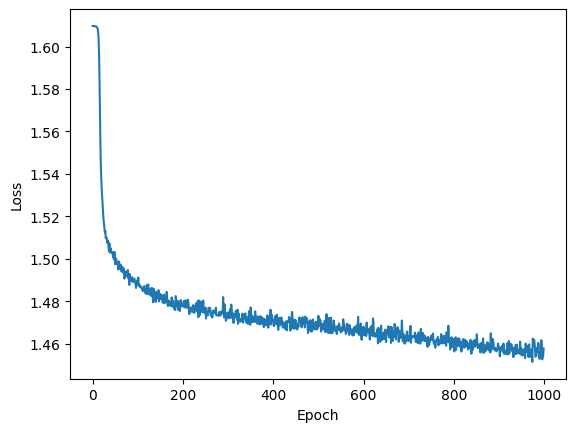

Test accuracy: 474.07182795698924
Accuracy: 0.4189247311827957
Precision: 0.39150216394476345
Recall: 0.4105250775227206
F1-score: 0.38344854147002383


Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.70      0.49       495
           1       0.69      0.76      0.72       472
           2       0.26      0.12      0.16       449
           3       0.30      0.24      0.27       463
           4       0.33      0.23      0.27       446

    accuracy                           0.42      2325
   macro avg       0.39      0.41      0.38      2325
weighted avg       0.39      0.42      0.39      2325

                    0           1           2           3           4  \
precision    0.379802    0.685115    0.259804    0.300532    0.332258   
recall       0.698990    0.760593    0.118040    0.244060    0.230942   
f1-score     0.492176    0.720884    0.162328    0.269368    0.272487   
support    495.000000  472.000000  449.0000

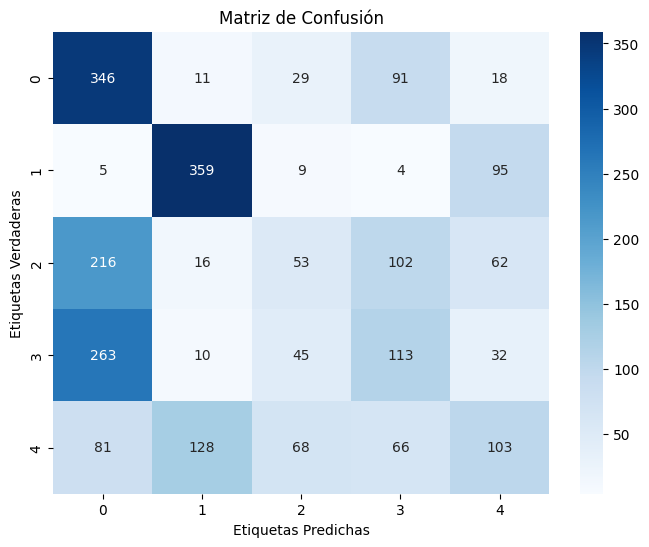

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_1e-05_0.2/resultados_1000_1e-05_0.2.json
Procesando red con 700 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas:   0%|                                                               | 1/700 [00:01<19:35,  1.68s/it]

1.6097281785572277


Procesando epocas:   0%|▏                                                              | 2/700 [00:03<19:27,  1.67s/it]

1.6095829893560971


Procesando epocas:   0%|▎                                                              | 3/700 [00:05<19:41,  1.70s/it]

1.6095462245099685


Procesando epocas:   1%|▎                                                              | 4/700 [00:06<19:43,  1.70s/it]

1.6093073718688067


Procesando epocas:   1%|▍                                                              | 5/700 [00:08<19:46,  1.71s/it]

1.6031168580055237


Procesando epocas:   1%|▌                                                              | 6/700 [00:10<19:46,  1.71s/it]

1.5413284624324126


Procesando epocas:   1%|▋                                                              | 7/700 [00:11<19:39,  1.70s/it]

1.5150744361035964


Procesando epocas:   1%|▋                                                              | 8/700 [00:13<19:33,  1.70s/it]

1.5166085285298965


Procesando epocas:   1%|▊                                                              | 9/700 [00:15<19:23,  1.68s/it]

1.509247264441322


Procesando epocas:   1%|▉                                                             | 10/700 [00:16<19:17,  1.68s/it]

1.504356173206778


Procesando epocas:   2%|▉                                                             | 11/700 [00:18<19:14,  1.68s/it]

1.504252162400414


Procesando epocas:   2%|█                                                             | 12/700 [00:20<19:13,  1.68s/it]

1.504782801515916


Procesando epocas:   2%|█▏                                                            | 13/700 [00:21<19:06,  1.67s/it]

1.5061124584254098


Procesando epocas:   2%|█▏                                                            | 14/700 [00:23<19:02,  1.67s/it]

1.5007070043507744


Procesando epocas:   2%|█▎                                                            | 15/700 [00:25<18:59,  1.66s/it]

1.5066963875994963


Procesando epocas:   2%|█▍                                                            | 16/700 [00:26<18:51,  1.65s/it]

1.5019634884946487


Procesando epocas:   2%|█▌                                                            | 17/700 [00:28<18:46,  1.65s/it]

1.4992479808190289


Procesando epocas:   3%|█▌                                                            | 18/700 [00:30<18:42,  1.65s/it]

1.5009923991035012


Procesando epocas:   3%|█▋                                                            | 19/700 [00:31<18:40,  1.65s/it]

1.496263222133412


Procesando epocas:   3%|█▊                                                            | 20/700 [00:33<18:49,  1.66s/it]

1.4945700750631445


Procesando epocas:   3%|█▊                                                            | 21/700 [00:35<18:57,  1.68s/it]

1.4958886784665726


Procesando epocas:   3%|█▉                                                            | 22/700 [00:36<18:54,  1.67s/it]

1.501254057182985


Procesando epocas:   3%|██                                                            | 23/700 [00:38<18:53,  1.67s/it]

1.494062547823962


Procesando epocas:   3%|██▏                                                           | 24/700 [00:40<18:56,  1.68s/it]

1.4963414865381577


Procesando epocas:   4%|██▏                                                           | 25/700 [00:41<18:57,  1.69s/it]

1.4944295918240267


Procesando epocas:   4%|██▎                                                           | 26/700 [00:43<18:51,  1.68s/it]

1.4938915596288793


Procesando epocas:   4%|██▍                                                           | 27/700 [00:45<18:48,  1.68s/it]

1.4939941357163822


Procesando epocas:   4%|██▍                                                           | 28/700 [00:46<18:44,  1.67s/it]

1.500048613548279


Procesando epocas:   4%|██▌                                                           | 29/700 [00:48<18:39,  1.67s/it]

1.489307548719294


Procesando epocas:   4%|██▋                                                           | 30/700 [00:50<18:37,  1.67s/it]

1.491563332080841


Procesando epocas:   4%|██▋                                                           | 31/700 [00:51<18:36,  1.67s/it]

1.4945035408524905


Procesando epocas:   5%|██▊                                                           | 32/700 [00:53<18:38,  1.67s/it]

1.4931458024417652


Procesando epocas:   5%|██▉                                                           | 33/700 [00:55<18:40,  1.68s/it]

1.4945374587002922


Procesando epocas:   5%|███                                                           | 34/700 [00:56<18:41,  1.68s/it]

1.494851962959065


Procesando epocas:   5%|███                                                           | 35/700 [00:58<18:35,  1.68s/it]

1.489355908421909


Procesando epocas:   5%|███▏                                                          | 36/700 [01:00<18:29,  1.67s/it]

1.490065153907327


Procesando epocas:   5%|███▎                                                          | 37/700 [01:02<18:36,  1.68s/it]

1.4915163902675403


Procesando epocas:   5%|███▎                                                          | 38/700 [01:03<18:39,  1.69s/it]

1.4970874078133527


Procesando epocas:   6%|███▍                                                          | 39/700 [01:05<18:45,  1.70s/it]

1.4869605057379778


Procesando epocas:   6%|███▌                                                          | 40/700 [01:07<18:47,  1.71s/it]

1.4879454507547267


Procesando epocas:   6%|███▋                                                          | 41/700 [01:08<18:46,  1.71s/it]

1.489436497407801


Procesando epocas:   6%|███▋                                                          | 42/700 [01:10<18:44,  1.71s/it]

1.4876132439164553


Procesando epocas:   6%|███▊                                                          | 43/700 [01:12<18:43,  1.71s/it]

1.492784882293028


Procesando epocas:   6%|███▉                                                          | 44/700 [01:14<18:42,  1.71s/it]

1.4903715294950148


Procesando epocas:   6%|███▉                                                          | 45/700 [01:15<18:39,  1.71s/it]

1.4880762079182792


Procesando epocas:   7%|████                                                          | 46/700 [01:17<18:48,  1.73s/it]

1.4867523908615112


Procesando epocas:   7%|████▏                                                         | 47/700 [01:19<19:04,  1.75s/it]

1.4911739678943858


Procesando epocas:   7%|████▎                                                         | 48/700 [01:21<19:11,  1.77s/it]

1.4892892585081212


Procesando epocas:   7%|████▎                                                         | 49/700 [01:22<19:13,  1.77s/it]

1.4840636421652402


Procesando epocas:   7%|████▍                                                         | 50/700 [01:24<19:16,  1.78s/it]

1.4834341589142295


Procesando epocas:   7%|████▌                                                         | 51/700 [01:26<19:15,  1.78s/it]

1.4876610671772676


Procesando epocas:   7%|████▌                                                         | 52/700 [01:28<19:16,  1.78s/it]

1.4891225983114804


Procesando epocas:   8%|████▋                                                         | 53/700 [01:30<19:14,  1.78s/it]

1.484914799297557


Procesando epocas:   8%|████▊                                                         | 54/700 [01:31<19:14,  1.79s/it]

1.4818156109136693


Procesando epocas:   8%|████▊                                                         | 55/700 [01:33<19:14,  1.79s/it]

1.4804547422072467


Procesando epocas:   8%|████▉                                                         | 56/700 [01:35<19:13,  1.79s/it]

1.4865824096343097


Procesando epocas:   8%|█████                                                         | 57/700 [01:37<19:09,  1.79s/it]

1.4855721754186293


Procesando epocas:   8%|█████▏                                                        | 58/700 [01:39<19:10,  1.79s/it]

1.4848075775539173


Procesando epocas:   8%|█████▏                                                        | 59/700 [01:40<19:07,  1.79s/it]

1.4838025829371284


Procesando epocas:   9%|█████▎                                                        | 60/700 [01:42<19:04,  1.79s/it]

1.4861372926655938


Procesando epocas:   9%|█████▍                                                        | 61/700 [01:44<19:03,  1.79s/it]

1.4831254713675555


Procesando epocas:   9%|█████▍                                                        | 62/700 [01:46<19:00,  1.79s/it]

1.4812888180508332


Procesando epocas:   9%|█████▌                                                        | 63/700 [01:47<18:56,  1.78s/it]

1.4860609264934763


Procesando epocas:   9%|█████▋                                                        | 64/700 [01:49<18:54,  1.78s/it]

1.48308609233183


Procesando epocas:   9%|█████▊                                                        | 65/700 [01:51<18:53,  1.78s/it]

1.4874767219319063


Procesando epocas:   9%|█████▊                                                        | 66/700 [01:53<18:49,  1.78s/it]

1.4881656681790072


Procesando epocas:  10%|█████▉                                                        | 67/700 [01:55<18:49,  1.78s/it]

1.4812672264435711


Procesando epocas:  10%|██████                                                        | 68/700 [01:56<18:50,  1.79s/it]

1.4821868216290193


Procesando epocas:  10%|██████                                                        | 69/700 [01:58<18:47,  1.79s/it]

1.484642792449278


Procesando epocas:  10%|██████▏                                                       | 70/700 [02:00<18:48,  1.79s/it]

1.4798914748079637


Procesando epocas:  10%|██████▎                                                       | 71/700 [02:02<18:51,  1.80s/it]

1.480165616904988


Procesando epocas:  10%|██████▍                                                       | 72/700 [02:04<18:52,  1.80s/it]

1.4803033905870775


Procesando epocas:  10%|██████▍                                                       | 73/700 [02:05<18:49,  1.80s/it]

1.4783366617034464


Procesando epocas:  11%|██████▌                                                       | 74/700 [02:07<18:46,  1.80s/it]

1.4807566754958208


Procesando epocas:  11%|██████▋                                                       | 75/700 [02:09<18:46,  1.80s/it]

1.4839575178482953


Procesando epocas:  11%|██████▋                                                       | 76/700 [02:11<18:46,  1.81s/it]

1.4829921210513395


Procesando epocas:  11%|██████▊                                                       | 77/700 [02:13<18:40,  1.80s/it]

1.4819514933754416


Procesando epocas:  11%|██████▉                                                       | 78/700 [02:14<18:26,  1.78s/it]

1.4799526572227477


Procesando epocas:  11%|██████▉                                                       | 79/700 [02:16<18:20,  1.77s/it]

1.4795002944329205


Procesando epocas:  11%|███████                                                       | 80/700 [02:18<18:14,  1.77s/it]

1.4759096874910242


Procesando epocas:  12%|███████▏                                                      | 81/700 [02:20<18:10,  1.76s/it]

1.4819297636256499


Procesando epocas:  12%|███████▎                                                      | 82/700 [02:21<18:02,  1.75s/it]

1.4740775178460515


Procesando epocas:  12%|███████▎                                                      | 83/700 [02:23<17:55,  1.74s/it]

1.4789986428092508


Procesando epocas:  12%|███████▍                                                      | 84/700 [02:25<17:52,  1.74s/it]

1.4772749388919157


Procesando epocas:  12%|███████▌                                                      | 85/700 [02:27<18:00,  1.76s/it]

1.4836386189741246


Procesando epocas:  12%|███████▌                                                      | 86/700 [02:28<17:58,  1.76s/it]

1.4747979956514694


Procesando epocas:  12%|███████▋                                                      | 87/700 [02:30<17:53,  1.75s/it]

1.4765246314160965


Procesando epocas:  13%|███████▊                                                      | 88/700 [02:32<17:48,  1.75s/it]

1.47349793139626


Procesando epocas:  13%|███████▉                                                      | 89/700 [02:34<17:44,  1.74s/it]

1.476814865364748


Procesando epocas:  13%|███████▉                                                      | 90/700 [02:35<17:41,  1.74s/it]

1.479242942613714


Procesando epocas:  13%|████████                                                      | 91/700 [02:37<17:40,  1.74s/it]

1.47645901371451


Procesando epocas:  13%|████████▏                                                     | 92/700 [02:39<17:37,  1.74s/it]

1.4718065367025488


Procesando epocas:  13%|████████▏                                                     | 93/700 [02:40<17:35,  1.74s/it]

1.471932090731228


Procesando epocas:  13%|████████▎                                                     | 94/700 [02:42<17:37,  1.75s/it]

1.4759222612661473


Procesando epocas:  14%|████████▍                                                     | 95/700 [02:44<17:33,  1.74s/it]

1.4818476207116071


Procesando epocas:  14%|████████▌                                                     | 96/700 [02:46<17:29,  1.74s/it]

1.4736154479138992


Procesando epocas:  14%|████████▌                                                     | 97/700 [02:47<17:29,  1.74s/it]

1.4837318097843843


Procesando epocas:  14%|████████▋                                                     | 98/700 [02:49<17:29,  1.74s/it]

1.4736618694137125


Procesando epocas:  14%|████████▊                                                     | 99/700 [02:51<17:28,  1.74s/it]

1.4745742215829738


Procesando epocas:  14%|████████▋                                                    | 100/700 [02:53<17:25,  1.74s/it]

1.4722504945362316


Procesando epocas:  14%|████████▊                                                    | 101/700 [02:54<17:23,  1.74s/it]

1.469988965988159


Procesando epocas:  15%|████████▉                                                    | 102/700 [02:56<17:23,  1.74s/it]

1.480035546947928


Procesando epocas:  15%|████████▉                                                    | 103/700 [02:58<17:22,  1.75s/it]

1.465743143418256


Procesando epocas:  15%|█████████                                                    | 104/700 [03:00<17:19,  1.74s/it]

1.4756346667514129


Procesando epocas:  15%|█████████▏                                                   | 105/700 [03:01<17:14,  1.74s/it]

1.4698930810479556


Procesando epocas:  15%|█████████▏                                                   | 106/700 [03:03<17:07,  1.73s/it]

1.472115262816934


Procesando epocas:  15%|█████████▎                                                   | 107/700 [03:05<17:03,  1.73s/it]

1.4772933272754445


Procesando epocas:  15%|█████████▍                                                   | 108/700 [03:07<17:02,  1.73s/it]

1.4697309192489176


Procesando epocas:  16%|█████████▍                                                   | 109/700 [03:08<17:02,  1.73s/it]

1.4701545483925764


Procesando epocas:  16%|█████████▌                                                   | 110/700 [03:10<16:56,  1.72s/it]

1.470896876559538


Procesando epocas:  16%|█████████▋                                                   | 111/700 [03:12<16:54,  1.72s/it]

1.4714497902814079


Procesando epocas:  16%|█████████▊                                                   | 112/700 [03:13<16:51,  1.72s/it]

1.4695029188604916


Procesando epocas:  16%|█████████▊                                                   | 113/700 [03:15<16:47,  1.72s/it]

1.464863035258125


Procesando epocas:  16%|█████████▉                                                   | 114/700 [03:17<16:45,  1.72s/it]

1.4605958356576807


Procesando epocas:  16%|██████████                                                   | 115/700 [03:19<16:43,  1.71s/it]

1.4608696678105522


Procesando epocas:  17%|██████████                                                   | 116/700 [03:20<16:40,  1.71s/it]

1.4721860563053804


Procesando epocas:  17%|██████████▏                                                  | 117/700 [03:22<16:39,  1.71s/it]

1.4721970193526324


Procesando epocas:  17%|██████████▎                                                  | 118/700 [03:24<16:38,  1.72s/it]

1.4608005663927863


Procesando epocas:  17%|██████████▎                                                  | 119/700 [03:25<16:39,  1.72s/it]

1.4681701379663803


Procesando epocas:  17%|██████████▍                                                  | 120/700 [03:27<16:37,  1.72s/it]

1.4665034013635971


Procesando epocas:  17%|██████████▌                                                  | 121/700 [03:29<16:35,  1.72s/it]

1.4606941138996798


Procesando epocas:  17%|██████████▋                                                  | 122/700 [03:31<16:32,  1.72s/it]

1.4651502826634575


Procesando epocas:  18%|██████████▋                                                  | 123/700 [03:32<16:29,  1.72s/it]

1.4618566597209257


Procesando epocas:  18%|██████████▊                                                  | 124/700 [03:34<16:26,  1.71s/it]

1.4646775981959175


Procesando epocas:  18%|██████████▉                                                  | 125/700 [03:36<16:25,  1.71s/it]

1.4591566829120413


Procesando epocas:  18%|██████████▉                                                  | 126/700 [03:37<16:24,  1.71s/it]

1.4624284982681275


Procesando epocas:  18%|███████████                                                  | 127/700 [03:39<16:25,  1.72s/it]

1.4622322790762958


Procesando epocas:  18%|███████████▏                                                 | 128/700 [03:41<16:24,  1.72s/it]

1.4681185182403116


Procesando epocas:  18%|███████████▏                                                 | 129/700 [03:43<16:21,  1.72s/it]

1.4659174540463615


Procesando epocas:  19%|███████████▎                                                 | 130/700 [03:44<16:21,  1.72s/it]

1.4605492942473468


Procesando epocas:  19%|███████████▍                                                 | 131/700 [03:46<16:18,  1.72s/it]

1.4699009874287774


Procesando epocas:  19%|███████████▌                                                 | 132/700 [03:48<16:17,  1.72s/it]

1.4741636192097383


Procesando epocas:  19%|███████████▌                                                 | 133/700 [03:49<16:17,  1.72s/it]

1.4572770665673649


Procesando epocas:  19%|███████████▋                                                 | 134/700 [03:51<16:18,  1.73s/it]

1.467511504537919


Procesando epocas:  19%|███████████▊                                                 | 135/700 [03:53<16:17,  1.73s/it]

1.477960297640632


Procesando epocas:  19%|███████████▊                                                 | 136/700 [03:55<16:15,  1.73s/it]

1.4615637814297395


Procesando epocas:  20%|███████████▉                                                 | 137/700 [03:56<16:15,  1.73s/it]

1.459166261027841


Procesando epocas:  20%|████████████                                                 | 138/700 [03:58<16:11,  1.73s/it]

1.4627257312045379


Procesando epocas:  20%|████████████                                                 | 139/700 [04:00<16:10,  1.73s/it]

1.461881313604467


Procesando epocas:  20%|████████████▏                                                | 140/700 [04:02<16:08,  1.73s/it]

1.468993067741394


Procesando epocas:  20%|████████████▎                                                | 141/700 [04:03<16:04,  1.73s/it]

1.4634267168886521


Procesando epocas:  20%|████████████▎                                                | 142/700 [04:05<16:02,  1.73s/it]

1.463650631203371


Procesando epocas:  20%|████████████▍                                                | 143/700 [04:07<16:00,  1.72s/it]

1.4595927659203025


Procesando epocas:  21%|████████████▌                                                | 144/700 [04:08<15:57,  1.72s/it]

1.4733077210538528


Procesando epocas:  21%|████████████▋                                                | 145/700 [04:10<15:58,  1.73s/it]

1.4705671422621782


Procesando epocas:  21%|████████████▋                                                | 146/700 [04:12<15:54,  1.72s/it]

1.4645923796822042


Procesando epocas:  21%|████████████▊                                                | 147/700 [04:14<15:51,  1.72s/it]

1.459857177734375


Procesando epocas:  21%|████████████▉                                                | 148/700 [04:15<15:49,  1.72s/it]

1.4610039479592267


Procesando epocas:  21%|████████████▉                                                | 149/700 [04:17<15:47,  1.72s/it]

1.4629796056186453


Procesando epocas:  21%|█████████████                                                | 150/700 [04:19<15:45,  1.72s/it]

1.4611332241226644


Procesando epocas:  22%|█████████████▏                                               | 151/700 [04:21<15:42,  1.72s/it]

1.4624531682799844


Procesando epocas:  22%|█████████████▏                                               | 152/700 [04:22<15:40,  1.72s/it]

1.4561622142791748


Procesando epocas:  22%|█████████████▎                                               | 153/700 [04:24<15:39,  1.72s/it]

1.4577085957807654


Procesando epocas:  22%|█████████████▍                                               | 154/700 [04:26<15:40,  1.72s/it]

1.4605855612193837


Procesando epocas:  22%|█████████████▌                                               | 155/700 [04:27<15:39,  1.72s/it]

1.4563978959532344


Procesando epocas:  22%|█████████████▌                                               | 156/700 [04:29<15:36,  1.72s/it]

1.4686792471829582


Procesando epocas:  22%|█████████████▋                                               | 157/700 [04:31<15:34,  1.72s/it]

1.455203347346362


Procesando epocas:  23%|█████████████▊                                               | 158/700 [04:33<15:32,  1.72s/it]

1.4583225299330318


Procesando epocas:  23%|█████████████▊                                               | 159/700 [04:34<15:31,  1.72s/it]

1.4624000002356137


Procesando epocas:  23%|█████████████▉                                               | 160/700 [04:36<15:29,  1.72s/it]

1.4618912773973802


Procesando epocas:  23%|██████████████                                               | 161/700 [04:38<15:31,  1.73s/it]

1.4622106538099402


Procesando epocas:  23%|██████████████                                               | 162/700 [04:39<15:28,  1.73s/it]

1.4548278990913839


Procesando epocas:  23%|██████████████▏                                              | 163/700 [04:41<15:25,  1.72s/it]

1.4607963253470029


Procesando epocas:  23%|██████████████▎                                              | 164/700 [04:43<15:22,  1.72s/it]

1.459930723554948


Procesando epocas:  24%|██████████████▍                                              | 165/700 [04:45<15:20,  1.72s/it]

1.458620469009175


Procesando epocas:  24%|██████████████▍                                              | 166/700 [04:46<15:20,  1.72s/it]

1.4584788827335133


Procesando epocas:  24%|██████████████▌                                              | 167/700 [04:48<15:17,  1.72s/it]

1.4557078326449675


Procesando epocas:  24%|██████████████▋                                              | 168/700 [04:50<15:14,  1.72s/it]

1.4625118269639856


Procesando epocas:  24%|██████████████▋                                              | 169/700 [04:52<15:25,  1.74s/it]

1.4591399227871615


Procesando epocas:  24%|██████████████▊                                              | 170/700 [04:53<15:32,  1.76s/it]

1.4553573362967547


Procesando epocas:  24%|██████████████▉                                              | 171/700 [04:55<15:36,  1.77s/it]

1.4574237311587614


Procesando epocas:  25%|██████████████▉                                              | 172/700 [04:57<15:37,  1.78s/it]

1.4592978645773496


Procesando epocas:  25%|███████████████                                              | 173/700 [04:59<15:37,  1.78s/it]

1.4661441494436824


Procesando epocas:  25%|███████████████▏                                             | 174/700 [05:01<15:35,  1.78s/it]

1.4588886324097128


Procesando epocas:  25%|███████████████▎                                             | 175/700 [05:02<15:34,  1.78s/it]

1.4634129832772647


Procesando epocas:  25%|███████████████▎                                             | 176/700 [05:04<15:36,  1.79s/it]

1.455599221762489


Procesando epocas:  25%|███████████████▍                                             | 177/700 [05:06<15:36,  1.79s/it]

1.4617974239237168


Procesando epocas:  25%|███████████████▌                                             | 178/700 [05:08<15:35,  1.79s/it]

1.4575561860028434


Procesando epocas:  26%|███████████████▌                                             | 179/700 [05:10<15:35,  1.79s/it]

1.4539691798827228


Procesando epocas:  26%|███████████████▋                                             | 180/700 [05:11<15:27,  1.78s/it]

1.4530439159449409


Procesando epocas:  26%|███████████████▊                                             | 181/700 [05:13<15:19,  1.77s/it]

1.4632023818352644


Procesando epocas:  26%|███████████████▊                                             | 182/700 [05:15<15:14,  1.77s/it]

1.4588063779999227


Procesando epocas:  26%|███████████████▉                                             | 183/700 [05:17<15:08,  1.76s/it]

1.4621009048293618


Procesando epocas:  26%|████████████████                                             | 184/700 [05:18<15:05,  1.75s/it]

1.45602287755293


Procesando epocas:  26%|████████████████                                             | 185/700 [05:20<15:03,  1.75s/it]

1.4556015232030084


Procesando epocas:  27%|████████████████▏                                            | 186/700 [05:22<15:02,  1.76s/it]

1.452563049512751


Procesando epocas:  27%|████████████████▎                                            | 187/700 [05:24<14:59,  1.75s/it]

1.4554721138056588


Procesando epocas:  27%|████████████████▍                                            | 188/700 [05:25<14:56,  1.75s/it]

1.458381121298846


Procesando epocas:  27%|████████████████▍                                            | 189/700 [05:27<14:54,  1.75s/it]

1.4545999919666963


Procesando epocas:  27%|████████████████▌                                            | 190/700 [05:29<14:51,  1.75s/it]

1.4565098986906164


Procesando epocas:  27%|████████████████▋                                            | 191/700 [05:31<14:50,  1.75s/it]

1.4537311455782722


Procesando epocas:  27%|████████████████▋                                            | 192/700 [05:32<14:49,  1.75s/it]

1.4543454626027275


Procesando epocas:  28%|████████████████▊                                            | 193/700 [05:34<14:47,  1.75s/it]

1.4554581361658432


Procesando epocas:  28%|████████████████▉                                            | 194/700 [05:36<14:47,  1.75s/it]

1.4545784024631276


Procesando epocas:  28%|████████████████▉                                            | 195/700 [05:38<14:44,  1.75s/it]

1.4718414622194627


Procesando epocas:  28%|█████████████████                                            | 196/700 [05:39<14:40,  1.75s/it]

1.4600510190514957


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [05:41<14:40,  1.75s/it]

1.4527867429396686


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [05:43<14:39,  1.75s/it]

1.4541149994906257


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [05:45<14:35,  1.75s/it]

1.4586221891291


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [05:46<14:27,  1.74s/it]

1.4593906241304735


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [05:48<14:19,  1.72s/it]

1.451176472972421


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [05:50<14:12,  1.71s/it]

1.4665989300783944


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [05:51<14:11,  1.71s/it]

1.4544765816015355


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [05:53<14:08,  1.71s/it]

1.450387630743139


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [05:55<14:05,  1.71s/it]

1.449615357202642


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [05:56<14:04,  1.71s/it]

1.456004743716296


Procesando epocas:  30%|██████████████████                                           | 207/700 [05:58<14:01,  1.71s/it]

1.4572833699338577


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [06:00<13:59,  1.71s/it]

1.4542088150978087


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [06:02<13:56,  1.70s/it]

1.4602590967627134


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [06:03<13:59,  1.71s/it]

1.4528414859491237


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [06:05<14:04,  1.73s/it]

1.4500249764498543


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [06:07<14:02,  1.73s/it]

1.453644762319677


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [06:08<13:59,  1.72s/it]

1.4543732488856596


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [06:10<13:58,  1.73s/it]

1.453875062044929


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [06:12<13:58,  1.73s/it]

1.45902283261804


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [06:14<13:56,  1.73s/it]

1.4575091796762802


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [06:15<13:52,  1.72s/it]

1.4507368817048913


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [06:17<13:46,  1.72s/it]

1.4482624642989215


Procesando epocas:  31%|███████████████████                                          | 219/700 [06:19<13:44,  1.71s/it]

1.4557283871314104


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [06:20<13:41,  1.71s/it]

1.458453997443704


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [06:22<13:41,  1.72s/it]

1.4542057647424587


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [06:24<13:39,  1.72s/it]

1.4541846380514256


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [06:26<13:37,  1.71s/it]

1.4556555888232063


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [06:27<13:36,  1.71s/it]

1.4566383488038006


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [06:29<13:33,  1.71s/it]

1.4493811894865598


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [06:31<13:29,  1.71s/it]

1.4516010137165294


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [06:32<13:24,  1.70s/it]

1.4501670963623945


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [06:34<13:20,  1.70s/it]

1.4520593566053055


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [06:36<13:17,  1.69s/it]

1.4511581266627591


Procesando epocas:  33%|████████████████████                                         | 230/700 [06:38<13:25,  1.71s/it]

1.4637243810821983


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [06:39<13:27,  1.72s/it]

1.4579635746338788


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [06:41<13:22,  1.72s/it]

1.4482446312904358


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [06:43<13:21,  1.72s/it]

1.4518892568700454


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [06:45<13:26,  1.73s/it]

1.4512971085660598


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [06:46<13:30,  1.74s/it]

1.4530294691815095


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [06:48<13:26,  1.74s/it]

1.4512631479431601


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [06:50<13:24,  1.74s/it]

1.4487341621342826


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [06:51<13:19,  1.73s/it]

1.4534406654974994


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [06:53<13:18,  1.73s/it]

1.4493034383829901


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [06:55<13:21,  1.74s/it]

1.4519096269327052


Procesando epocas:  34%|█████████████████████                                        | 241/700 [06:57<13:18,  1.74s/it]

1.4510488636353436


Procesando epocas:  35%|█████████████████████                                        | 242/700 [06:58<13:11,  1.73s/it]

1.452207448202021


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [07:00<13:04,  1.72s/it]

1.4478831536629622


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [07:02<12:58,  1.71s/it]

1.4576582004042233


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [07:03<12:54,  1.70s/it]

1.4487762815812055


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [07:05<12:49,  1.70s/it]

1.4549200387562022


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [07:07<12:47,  1.69s/it]

1.453451138384202


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [07:09<12:47,  1.70s/it]

1.445374608741087


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [07:10<12:53,  1.71s/it]

1.4476096735281103


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [07:12<12:58,  1.73s/it]

1.4508872565101174


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [07:14<12:55,  1.73s/it]

1.4421936708338121


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [07:16<12:53,  1.73s/it]

1.4468499926959768


Procesando epocas:  36%|██████████████████████                                       | 253/700 [07:17<12:54,  1.73s/it]

1.4511118713547202


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [07:19<12:53,  1.73s/it]

1.4492411375045777


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [07:21<12:50,  1.73s/it]

1.4482461768038133


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [07:22<12:53,  1.74s/it]

1.4475598538623136


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [07:24<12:53,  1.75s/it]

1.4496163256028118


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [07:26<12:49,  1.74s/it]

1.450096370192135


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [07:28<12:46,  1.74s/it]

1.4446954783271342


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [07:29<12:42,  1.73s/it]

1.4530040046747994


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [07:31<12:39,  1.73s/it]

1.4472928965792937


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [07:33<12:39,  1.73s/it]

1.4560607138802024


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [07:35<12:39,  1.74s/it]

1.4519786841729108


Procesando epocas:  38%|███████████████████████                                      | 264/700 [07:36<12:33,  1.73s/it]

1.449071826654322


Procesando epocas:  38%|███████████████████████                                      | 265/700 [07:38<12:28,  1.72s/it]

1.449556608059827


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [07:40<12:26,  1.72s/it]

1.4465947908513686


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [07:41<12:24,  1.72s/it]

1.4492587468203377


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [07:43<12:20,  1.71s/it]

1.4476147595573874


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [07:45<12:17,  1.71s/it]

1.447979011255152


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [07:47<12:16,  1.71s/it]

1.4473963576204636


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [07:48<12:14,  1.71s/it]

1.4489528186181013


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [07:50<12:13,  1.71s/it]

1.447744858264923


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [07:52<12:12,  1.72s/it]

1.4452958885361167


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [07:53<12:10,  1.72s/it]

1.4502224199912128


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [07:55<12:07,  1.71s/it]

1.4417029387810651


Procesando epocas:  39%|████████████████████████                                     | 276/700 [07:57<12:05,  1.71s/it]

1.4526448333964628


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [07:59<12:03,  1.71s/it]

1.4431073904037475


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [08:00<12:00,  1.71s/it]

1.4470531042884378


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [08:02<11:59,  1.71s/it]

1.44937320246416


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [08:04<11:56,  1.71s/it]

1.4425047516822815


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [08:05<11:55,  1.71s/it]

1.4498416535994585


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [08:07<11:54,  1.71s/it]

1.446912743063534


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [08:09<11:53,  1.71s/it]

1.4405559560831855


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [08:11<12:00,  1.73s/it]

1.4416385769844056


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [08:12<12:01,  1.74s/it]

1.4460358212975895


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [08:14<11:55,  1.73s/it]

1.4464859282269198


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [08:16<11:50,  1.72s/it]

1.444335621244767


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [08:17<11:46,  1.71s/it]

1.4458599420154796


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [08:19<11:44,  1.72s/it]

1.4510898996801938


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [08:21<11:40,  1.71s/it]

1.4499229283893809


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [08:23<11:42,  1.72s/it]

1.441519399951486


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [08:24<11:50,  1.74s/it]

1.4471338987350464


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [08:26<11:54,  1.76s/it]

1.4410993463852826


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [08:28<11:56,  1.77s/it]

1.4517423096825095


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [08:30<11:57,  1.77s/it]

1.4500001318314497


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [08:32<11:55,  1.77s/it]

1.440385469969581


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [08:33<11:55,  1.78s/it]

1.4470300204613629


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [08:35<11:53,  1.77s/it]

1.446935205599841


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [08:37<11:53,  1.78s/it]

1.443015109090244


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [08:39<11:50,  1.78s/it]

1.444066224378698


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [08:40<11:49,  1.78s/it]

1.4425018366645364


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [08:42<11:47,  1.78s/it]

1.4408229820868548


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [08:44<11:44,  1.77s/it]

1.4414001079166636


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [08:46<11:43,  1.78s/it]

1.4451083204325508


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [08:48<11:41,  1.78s/it]

1.4452690503176522


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [08:49<11:40,  1.78s/it]

1.4457638516145594


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [08:51<11:37,  1.78s/it]

1.4413695328375873


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [08:53<11:37,  1.78s/it]

1.4450196609777564


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [08:55<11:37,  1.78s/it]

1.4407311972449808


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [08:56<11:34,  1.78s/it]

1.446427485522102


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [08:58<11:32,  1.78s/it]

1.440053403377533


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [09:00<11:30,  1.78s/it]

1.4478090314304128


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [09:02<11:28,  1.78s/it]

1.4430691284291886


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [09:04<11:28,  1.78s/it]

1.4421246458502377


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [09:05<11:30,  1.79s/it]

1.4480580364956575


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [09:07<11:33,  1.80s/it]

1.444048205543967


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [09:09<11:31,  1.81s/it]

1.4415404495070963


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [09:11<11:31,  1.81s/it]

1.4428538062993217


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [09:13<11:25,  1.80s/it]

1.4498078227043152


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [09:14<11:23,  1.80s/it]

1.4503272309022792


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [09:16<11:19,  1.79s/it]

1.4482282757759095


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [09:18<11:13,  1.78s/it]

1.4392916602246901


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [09:20<11:05,  1.76s/it]

1.436624941405128


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [09:21<11:01,  1.76s/it]

1.4405478225034827


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [09:23<10:57,  1.75s/it]

1.443448359826032


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [09:25<10:59,  1.76s/it]

1.4488016268786261


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [09:27<10:57,  1.76s/it]

1.4447790405329537


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [09:28<10:53,  1.76s/it]

1.4451874690897324


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [09:30<10:49,  1.75s/it]

1.438846291514004


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [09:32<10:47,  1.75s/it]

1.443609923474929


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [09:34<10:46,  1.75s/it]

1.439935741705053


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [09:35<10:43,  1.75s/it]

1.4423743346158195


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [09:37<10:42,  1.75s/it]

1.4377837040845085


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [09:39<10:41,  1.75s/it]

1.444267158648547


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [09:41<10:39,  1.75s/it]

1.4440413566196666


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [09:42<10:36,  1.75s/it]

1.4487845112295712


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [09:44<10:35,  1.75s/it]

1.4451981264002183


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [09:46<10:33,  1.75s/it]

1.4464996555272271


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [09:48<10:31,  1.75s/it]

1.451791775927824


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [09:49<10:29,  1.75s/it]

1.4402476997936473


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [09:51<10:27,  1.75s/it]

1.4465439712300021


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [09:53<10:24,  1.74s/it]

1.4379774472292732


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [09:55<10:22,  1.74s/it]

1.437814035135157


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [09:56<10:21,  1.75s/it]

1.451532854052151


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [09:58<10:19,  1.74s/it]

1.44283151065602


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [10:00<10:17,  1.74s/it]

1.442435500902288


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [10:02<10:15,  1.74s/it]

1.4441113226553972


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [10:03<10:15,  1.75s/it]

1.454191926647635


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [10:05<10:14,  1.75s/it]

1.4427198550280402


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [10:07<10:11,  1.75s/it]

1.4557913415572223


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [10:09<10:09,  1.75s/it]

1.443212652907652


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [10:10<10:05,  1.74s/it]

1.4357110409175649


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [10:12<10:05,  1.74s/it]

1.4399768948554992


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [10:14<10:02,  1.74s/it]

1.4418656040640438


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [10:16<09:58,  1.73s/it]

1.4370219006257898


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [10:17<09:56,  1.73s/it]

1.4363443998729482


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [10:19<09:54,  1.73s/it]

1.4424141000298893


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [10:21<09:52,  1.73s/it]

1.4541171571787666


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [10:23<09:50,  1.73s/it]

1.440174705140731


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [10:24<09:47,  1.73s/it]

1.442431750017054


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [10:26<09:46,  1.73s/it]

1.4398484068758348


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [10:28<09:45,  1.73s/it]

1.4408505818423103


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [10:29<09:42,  1.73s/it]

1.4402473519830143


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [10:31<09:40,  1.73s/it]

1.4551257371902466


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [10:33<09:41,  1.74s/it]

1.4589707136154175


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [10:35<09:43,  1.75s/it]

1.4422082382089951


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [10:36<09:44,  1.76s/it]

1.4430729213882896


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [10:38<09:45,  1.76s/it]

1.4362773712943582


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [10:40<09:44,  1.77s/it]

1.4475047146572786


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [10:42<09:42,  1.76s/it]

1.4392342322012956


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [10:44<09:40,  1.76s/it]

1.4422183850232293


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [10:45<09:37,  1.76s/it]

1.4419141755384557


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [10:47<09:29,  1.74s/it]

1.4349668306462906


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [10:49<09:20,  1.72s/it]

1.4388146316303927


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [10:50<09:14,  1.71s/it]

1.439875426011927


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [10:52<09:14,  1.71s/it]

1.4439923707176656


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [10:54<09:10,  1.70s/it]

1.4387715767411624


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [10:55<09:07,  1.70s/it]

1.4396811758770662


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [10:57<09:03,  1.69s/it]

1.433823080623851


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [10:59<09:00,  1.69s/it]

1.4458377214039073


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [11:00<08:57,  1.68s/it]

1.4379423239651847


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [11:02<08:54,  1.68s/it]

1.440190179908977


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [11:04<08:49,  1.67s/it]

1.4399301451795241


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [11:05<08:46,  1.67s/it]

1.4370638258316937


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [11:07<08:43,  1.66s/it]

1.439527372051688


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [11:09<08:41,  1.66s/it]

1.4410788227530087


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [11:10<08:42,  1.67s/it]

1.4390503062921411


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [11:12<08:51,  1.70s/it]

1.4345806079752306


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [11:14<08:55,  1.72s/it]

1.4503979675910053


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [11:16<08:56,  1.73s/it]

1.4422024516498342


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [11:17<08:54,  1.73s/it]

1.4333049023852629


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [11:19<08:49,  1.72s/it]

1.4419525448013755


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [11:21<08:44,  1.71s/it]

1.4330006753697115


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [11:23<08:40,  1.70s/it]

1.443078693221597


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [11:24<08:34,  1.69s/it]

1.4409408716594472


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [11:26<08:31,  1.68s/it]

1.43943054746179


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [11:28<08:28,  1.68s/it]

1.4432120147873373


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [11:29<08:25,  1.68s/it]

1.432183058121625


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [11:31<08:23,  1.67s/it]

1.440995132221895


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [11:33<08:22,  1.67s/it]

1.4335687623304478


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [11:34<08:21,  1.68s/it]

1.4419727255316341


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [11:36<08:18,  1.67s/it]

1.435123501104467


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [11:38<08:17,  1.67s/it]

1.4390968512086306


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [11:39<08:15,  1.67s/it]

1.4364789086229661


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [11:41<08:13,  1.67s/it]

1.4373897321083966


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [11:43<08:13,  1.68s/it]

1.4378879575168386


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [11:44<08:14,  1.69s/it]

1.4375739329001482


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [11:46<08:14,  1.69s/it]

1.4387249252375434


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [11:48<08:14,  1.70s/it]

1.4374698716051437


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [11:49<08:13,  1.70s/it]

1.43679499205421


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [11:51<08:12,  1.70s/it]

1.4428567150059868


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [11:53<08:10,  1.70s/it]

1.4429411446346956


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [11:55<08:14,  1.72s/it]

1.4353439057574553


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [11:56<08:15,  1.73s/it]

1.4348461010876823


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [11:58<08:16,  1.74s/it]

1.4398647385485033


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [12:00<08:14,  1.74s/it]

1.4351818056667551


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [12:02<08:13,  1.74s/it]

1.4383299974834218


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [12:03<08:14,  1.75s/it]

1.4335951124920565


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [12:05<08:11,  1.75s/it]

1.4362366627244387


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [12:07<08:10,  1.75s/it]

1.4454101997263291


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [12:09<08:10,  1.76s/it]

1.43790763686685


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [12:10<08:08,  1.76s/it]

1.4531394762151382


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [12:12<08:08,  1.76s/it]

1.4387962088865391


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [12:14<08:06,  1.76s/it]

1.4322417385437909


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [12:16<08:04,  1.76s/it]

1.4412254543865428


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [12:17<08:03,  1.76s/it]

1.4425255754414728


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [12:19<08:00,  1.76s/it]

1.4355628427337197


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [12:21<07:57,  1.76s/it]

1.4341391374083126


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [12:23<07:54,  1.75s/it]

1.4419926110435934


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [12:24<07:53,  1.75s/it]

1.442059881546918


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [12:26<07:52,  1.76s/it]

1.4376173608443317


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [12:28<07:51,  1.76s/it]

1.4476118690827313


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [12:30<07:50,  1.76s/it]

1.4336367978769191


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [12:32<07:48,  1.76s/it]

1.4381558635655571


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [12:33<07:47,  1.76s/it]

1.4358794051058152


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [12:35<07:44,  1.76s/it]

1.4336444202591392


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [12:37<07:42,  1.76s/it]

1.439537696978625


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [12:39<07:40,  1.76s/it]

1.4380724451121163


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [12:40<07:37,  1.75s/it]

1.4370194890919854


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [12:42<07:36,  1.76s/it]

1.4338552411864787


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [12:44<07:34,  1.76s/it]

1.434556043849272


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [12:46<07:33,  1.76s/it]

1.4319104334887336


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [12:47<07:30,  1.75s/it]

1.439968296359567


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [12:49<07:28,  1.75s/it]

1.4393804059309119


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [12:51<07:26,  1.75s/it]

1.4393309537102195


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [12:53<07:24,  1.75s/it]

1.4345383048057556


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [12:54<07:22,  1.75s/it]

1.4360386105144725


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [12:56<07:19,  1.74s/it]

1.4308033845003914


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [12:58<07:16,  1.74s/it]

1.437496791867649


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [13:00<07:14,  1.74s/it]

1.4360716216704426


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [13:01<07:12,  1.74s/it]

1.4382329667315763


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [13:03<07:10,  1.73s/it]

1.440653518368216


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [13:05<07:06,  1.73s/it]

1.4322300286854015


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [13:06<07:09,  1.75s/it]

1.4453185158617357


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [13:08<07:09,  1.75s/it]

1.4448455403832827


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [13:10<07:08,  1.76s/it]

1.438295871369979


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [13:12<07:06,  1.76s/it]

1.4326038977679085


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [13:14<07:06,  1.76s/it]

1.4356475227019365


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [13:15<07:03,  1.76s/it]

1.4365185933954576


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [13:17<07:02,  1.76s/it]

1.4471689126070808


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [13:19<06:59,  1.75s/it]

1.43781879158581


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [13:21<06:58,  1.76s/it]

1.434627635338727


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [13:22<06:56,  1.76s/it]

1.4386614890659557


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [13:24<06:55,  1.76s/it]

1.4381820482366225


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [13:26<06:55,  1.77s/it]

1.4367874762591193


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [13:28<06:53,  1.77s/it]

1.437699994620155


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [13:29<06:52,  1.77s/it]

1.4383915859110215


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [13:31<06:50,  1.77s/it]

1.4397103211458993


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [13:33<06:47,  1.76s/it]

1.4421823031762067


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [13:35<06:42,  1.75s/it]

1.4362346410751343


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [13:36<06:38,  1.74s/it]

1.4320278581450967


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [13:38<06:35,  1.73s/it]

1.434831642403322


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [13:40<06:30,  1.72s/it]

1.4348030286676743


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [13:41<06:26,  1.71s/it]

1.4360155393095577


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [13:43<06:25,  1.71s/it]

1.4367448666516471


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [13:45<06:24,  1.72s/it]

1.4321163927807528


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [13:47<06:21,  1.71s/it]

1.4335850021418404


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [13:48<06:20,  1.71s/it]

1.4335355583359213


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [13:50<06:19,  1.72s/it]

1.4393636184580185


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [13:52<06:17,  1.71s/it]

1.4338059488464805


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [13:53<06:14,  1.71s/it]

1.4371529628248776


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [13:55<06:13,  1.71s/it]

1.4324703118380377


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [13:57<06:12,  1.72s/it]

1.4387885353144478


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [13:59<06:09,  1.71s/it]

1.4333474362597747


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [14:00<06:08,  1.71s/it]

1.4378058784148273


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [14:02<06:06,  1.71s/it]

1.430609436596141


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [14:04<06:04,  1.71s/it]

1.433832585811615


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [14:05<06:02,  1.71s/it]

1.4368880222825442


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [14:07<06:00,  1.71s/it]

1.4314815878868103


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [14:09<05:58,  1.71s/it]

1.4320142851156348


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [14:11<05:55,  1.70s/it]

1.4375656317262089


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [14:12<05:52,  1.69s/it]

1.4406813053523793


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [14:14<05:50,  1.69s/it]

1.4314183214131524


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [14:16<05:48,  1.69s/it]

1.4290719852728002


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [14:17<05:48,  1.70s/it]

1.431120094832252


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [14:19<05:47,  1.71s/it]

1.4342684584505418


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [14:21<05:47,  1.71s/it]

1.4316606135929333


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [14:22<05:45,  1.71s/it]

1.437768852710724


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [14:24<05:44,  1.72s/it]

1.4287590328384847


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [14:26<05:43,  1.72s/it]

1.4314208752968731


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [14:28<05:40,  1.71s/it]

1.4377084192107705


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [14:29<05:37,  1.70s/it]

1.4396308541297913


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [14:31<05:34,  1.70s/it]

1.4362252060104819


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [14:33<05:31,  1.69s/it]

1.4336565361303442


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [14:34<05:29,  1.69s/it]

1.4343503720620099


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [14:36<05:27,  1.69s/it]

1.4314330164123983


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [14:38<05:26,  1.69s/it]

1.4341767444330102


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [14:39<05:25,  1.70s/it]

1.4351362270467423


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [14:41<05:23,  1.69s/it]

1.4323408379274256


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [14:43<05:20,  1.69s/it]

1.4306451839559218


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [14:44<05:17,  1.68s/it]

1.4311098133816438


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [14:46<05:16,  1.68s/it]

1.4288312722654903


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [14:48<05:16,  1.69s/it]

1.4328337907791138


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [14:50<05:17,  1.70s/it]

1.4338407327147091


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [14:51<05:18,  1.72s/it]

1.4480315054164212


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [14:53<05:17,  1.73s/it]

1.4299955872928396


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [14:55<05:16,  1.73s/it]

1.4322924627977258


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [14:57<05:15,  1.73s/it]

1.435101946662454


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [14:58<05:13,  1.73s/it]

1.4376159226193148


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [15:00<05:10,  1.72s/it]

1.4326530351358302


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [15:02<05:08,  1.73s/it]

1.4362080384703244


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [15:03<05:07,  1.73s/it]

1.429398586469538


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [15:05<05:05,  1.73s/it]

1.438719222124885


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [15:07<05:03,  1.72s/it]

1.4354945673662074


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [15:09<05:00,  1.72s/it]

1.4303262191660264


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [15:10<04:58,  1.71s/it]

1.430403654014363


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [15:12<04:56,  1.72s/it]

1.433259453493006


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [15:14<04:54,  1.71s/it]

1.4295473912182977


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [15:16<04:54,  1.72s/it]

1.4351341864641975


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [15:17<04:53,  1.73s/it]

1.431647623987759


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [15:19<04:50,  1.72s/it]

1.4296432663412655


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [15:21<04:49,  1.72s/it]

1.4302787079530603


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [15:22<04:46,  1.72s/it]

1.4342801956569446


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [15:24<04:47,  1.73s/it]

1.4362582248799942


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [15:26<04:48,  1.75s/it]

1.430726994486416


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [15:28<04:48,  1.76s/it]

1.4368948613896089


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [15:30<04:47,  1.77s/it]

1.4346154255025527


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [15:31<04:45,  1.76s/it]

1.4304250142153572


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [15:33<04:43,  1.76s/it]

1.4265468071488774


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [15:35<04:41,  1.76s/it]

1.4310980284915251


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [15:37<04:40,  1.77s/it]

1.434116512887618


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [15:38<04:38,  1.77s/it]

1.4318032895817476


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [15:40<04:37,  1.76s/it]

1.4338641811819637


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [15:42<04:35,  1.77s/it]

1.42924582046621


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [15:44<04:34,  1.77s/it]

1.4420933604240418


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [15:45<04:31,  1.76s/it]

1.4313781226382536


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [15:47<04:30,  1.77s/it]

1.4302185037556816


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [15:49<04:28,  1.77s/it]

1.4298973763690275


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [15:51<04:28,  1.78s/it]

1.4318350665709552


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [15:53<04:27,  1.78s/it]

1.4313918604570277


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [15:54<04:26,  1.79s/it]

1.4327317188767825


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [15:56<04:28,  1.81s/it]

1.4301093325895422


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [15:58<04:27,  1.82s/it]

1.4316410878125359


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [16:00<04:24,  1.81s/it]

1.431748428064234


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [16:02<04:22,  1.81s/it]

1.4313762966324302


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [16:03<04:19,  1.80s/it]

1.428866640960469


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [16:05<04:15,  1.79s/it]

1.4322091923040503


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [16:07<04:14,  1.79s/it]

1.4295695073464338


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [16:09<04:12,  1.79s/it]

1.4379307375234716


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [16:11<04:10,  1.79s/it]

1.429848100157345


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [16:12<04:08,  1.78s/it]

1.4306431020007413


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [16:14<04:05,  1.78s/it]

1.4351674402461332


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [16:16<04:02,  1.77s/it]

1.4345795350916246


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [16:18<03:58,  1.75s/it]

1.4306165533907274


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [16:19<03:54,  1.74s/it]

1.4446501907180338


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [16:21<03:51,  1.73s/it]

1.4398952477118547


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [16:23<03:48,  1.72s/it]

1.4259019381859723


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [16:24<03:46,  1.71s/it]

1.4302211999893188


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [16:26<03:43,  1.71s/it]

1.4263727531713597


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [16:28<03:42,  1.71s/it]

1.4285270529634813


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [16:29<03:39,  1.70s/it]

1.4252350470599007


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [16:31<03:37,  1.70s/it]

1.439046006342944


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [16:33<03:36,  1.71s/it]

1.4349617986118093


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [16:35<03:35,  1.71s/it]

1.4309021465918597


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [16:36<03:33,  1.71s/it]

1.4324408482102786


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [16:38<03:30,  1.70s/it]

1.4344742950271159


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [16:40<03:28,  1.70s/it]

1.4284345879274256


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [16:41<03:27,  1.70s/it]

1.4357344837749706


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [16:43<03:26,  1.71s/it]

1.4366954586085152


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [16:45<03:26,  1.72s/it]

1.4334606107543497


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [16:47<03:25,  1.72s/it]

1.4326576681698069


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [16:48<03:24,  1.73s/it]

1.4229428880354937


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [16:50<03:21,  1.73s/it]

1.4293987975401037


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [16:52<03:19,  1.72s/it]

1.4333950800054214


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [16:53<03:18,  1.72s/it]

1.4270055672701667


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [16:55<03:16,  1.73s/it]

1.4272796897327198


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [16:57<03:15,  1.73s/it]

1.4312886897255392


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [16:59<03:13,  1.72s/it]

1.4324743102578557


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [17:00<03:11,  1.72s/it]

1.4287928419954636


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [17:02<03:09,  1.72s/it]

1.4308511481565587


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [17:04<03:07,  1.72s/it]

1.4335039938197416


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [17:06<03:06,  1.72s/it]

1.4294253068811753


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [17:07<03:03,  1.72s/it]

1.4343855402048897


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [17:09<03:01,  1.72s/it]

1.4372127778389874


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [17:11<03:01,  1.73s/it]

1.4301321639734157


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [17:12<02:59,  1.73s/it]

1.429364196693196


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [17:14<02:58,  1.73s/it]

1.4329133959377514


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [17:16<02:56,  1.73s/it]

1.4277429643799278


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [17:18<02:54,  1.72s/it]

1.4290556038127227


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [17:19<02:53,  1.73s/it]

1.430057424657485


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [17:21<02:51,  1.74s/it]

1.4369167468127082


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [17:23<02:49,  1.73s/it]

1.428256222781013


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [17:25<02:47,  1.73s/it]

1.431330607919132


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [17:26<02:45,  1.73s/it]

1.4300387445618123


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [17:28<02:43,  1.73s/it]

1.426475600635304


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [17:30<02:40,  1.71s/it]

1.430660038134631


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [17:31<02:38,  1.70s/it]

1.4312781361972584


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [17:33<02:36,  1.70s/it]

1.4344401219311882


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [17:35<02:34,  1.69s/it]

1.435521582294913


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [17:36<02:31,  1.68s/it]

1.4285310555906856


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [17:38<02:29,  1.68s/it]

1.425931824656094


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [17:40<02:27,  1.68s/it]

1.428749808844398


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [17:41<02:26,  1.69s/it]

1.4329946188365712


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [17:43<02:25,  1.69s/it]

1.4262161198784322


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [17:45<02:25,  1.71s/it]

1.430955439455369


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [17:47<02:25,  1.73s/it]

1.4300060552709244


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [17:48<02:23,  1.73s/it]

1.4284016391810248


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [17:50<02:22,  1.74s/it]

1.423184725116281


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [17:52<02:20,  1.74s/it]

1.4277335356263554


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [17:54<02:19,  1.74s/it]

1.4267160072046168


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [17:55<02:18,  1.75s/it]

1.429811215400696


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [17:57<02:16,  1.75s/it]

1.4280819542267744


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [17:59<02:14,  1.75s/it]

1.4299838935627658


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [18:01<02:11,  1.73s/it]

1.4255580754841075


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [18:02<02:10,  1.74s/it]

1.4297759294509889


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [18:04<02:07,  1.73s/it]

1.4243658023722032


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [18:06<02:05,  1.72s/it]

1.4362069606781005


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [18:07<02:03,  1.72s/it]

1.4342949411448311


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [18:09<02:01,  1.71s/it]

1.4244270633248721


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [18:11<01:59,  1.71s/it]

1.4295154094696045


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [18:13<01:58,  1.72s/it]

1.4301330580430873


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [18:14<01:57,  1.73s/it]

1.431449836141923


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [18:16<01:56,  1.74s/it]

1.4269041987026438


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [18:18<01:54,  1.74s/it]

1.4304932937902564


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [18:20<01:53,  1.74s/it]

1.4523810505867005


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [18:21<01:51,  1.74s/it]

1.4396843734909506


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [18:23<01:49,  1.74s/it]

1.43298040488187


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [18:25<01:47,  1.73s/it]

1.4321695075315588


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [18:27<01:45,  1.72s/it]

1.425437276503619


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [18:28<01:43,  1.72s/it]

1.4244775470565347


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [18:30<01:40,  1.71s/it]

1.422926299011006


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [18:32<01:39,  1.72s/it]

1.4238191758885104


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [18:33<01:37,  1.72s/it]

1.4270850462072036


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [18:35<01:36,  1.73s/it]

1.4283577056492076


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [18:37<01:35,  1.74s/it]

1.4242371327736798


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [18:39<01:33,  1.74s/it]

1.43351130064796


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [18:40<01:32,  1.74s/it]

1.4278314807835748


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [18:42<01:30,  1.74s/it]

1.4293239551431993


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [18:44<01:29,  1.75s/it]

1.4292001170270583


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [18:46<01:27,  1.75s/it]

1.437803292274475


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [18:47<01:25,  1.74s/it]

1.4289568059584674


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [18:49<01:23,  1.74s/it]

1.426798196399913


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [18:51<01:21,  1.74s/it]

1.4340646975180682


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [18:53<01:20,  1.75s/it]

1.423924854222466


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [18:54<01:19,  1.76s/it]

1.4353815962286556


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [18:56<01:17,  1.77s/it]

1.4279645400888779


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [18:58<01:16,  1.78s/it]

1.4218377786524155


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [19:00<01:14,  1.78s/it]

1.4295296690043282


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [19:02<01:13,  1.79s/it]

1.4248933799126569


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [19:03<01:11,  1.78s/it]

1.4240132380934323


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [19:05<01:09,  1.78s/it]

1.4291750066420612


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [19:07<01:07,  1.79s/it]

1.4241280983476077


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [19:09<01:05,  1.77s/it]

1.429267887508168


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [19:10<01:03,  1.77s/it]

1.4282950106789083


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [19:12<01:01,  1.76s/it]

1.4263139100635753


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [19:14<00:59,  1.76s/it]

1.4290298819541931


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [19:16<00:58,  1.76s/it]

1.4278232770807602


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [19:17<00:56,  1.76s/it]

1.4256367494078244


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [19:19<00:51,  1.68s/it]

1.4221621927093058


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [19:20<00:49,  1.64s/it]

1.4306939510738148


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [19:22<00:48,  1.68s/it]

1.4305307353244108


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [19:24<00:47,  1.71s/it]

1.4378211294903476


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [19:26<00:46,  1.72s/it]

1.4277859365238863


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [19:28<00:44,  1.73s/it]

1.4309325239237618


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [19:29<00:43,  1.73s/it]

1.4295665292178883


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [19:31<00:41,  1.73s/it]

1.4256718165734235


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [19:33<00:39,  1.73s/it]

1.4267738026731154


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [19:35<00:38,  1.74s/it]

1.4269985332208521


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [19:36<00:36,  1.74s/it]

1.425337083199445


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [19:38<00:35,  1.76s/it]

1.4265132343067843


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [19:40<00:33,  1.75s/it]

1.4229706469704122


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [19:42<00:31,  1.75s/it]

1.4246853085125193


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [19:43<00:29,  1.75s/it]

1.4258998976034276


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [19:45<00:28,  1.76s/it]

1.421308477485881


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [19:47<00:26,  1.75s/it]

1.4248877925031325


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [19:48<00:24,  1.74s/it]

1.4274245668860044


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [19:50<00:22,  1.73s/it]

1.428622744363897


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [19:52<00:20,  1.73s/it]

1.4224780790946063


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [19:54<00:19,  1.73s/it]

1.4265723312602323


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [19:55<00:17,  1.73s/it]

1.420766227385577


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [19:57<00:15,  1.73s/it]

1.4294246568399318


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [19:59<00:13,  1.73s/it]

1.4271333056337694


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [20:01<00:12,  1.73s/it]

1.426646541146671


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [20:02<00:10,  1.72s/it]

1.4243992595111623


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [20:04<00:08,  1.72s/it]

1.4290250694050508


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [20:06<00:06,  1.73s/it]

1.4249305718085346


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [20:07<00:05,  1.73s/it]

1.4347168648944182


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [20:09<00:03,  1.73s/it]

1.4284786743276259


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [20:11<00:01,  1.73s/it]

1.4226488688412835


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [20:13<00:00,  1.73s/it]

1.4228749878266278
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_0.0001_0.1/funcion_de_perdida_700_0.0001.png


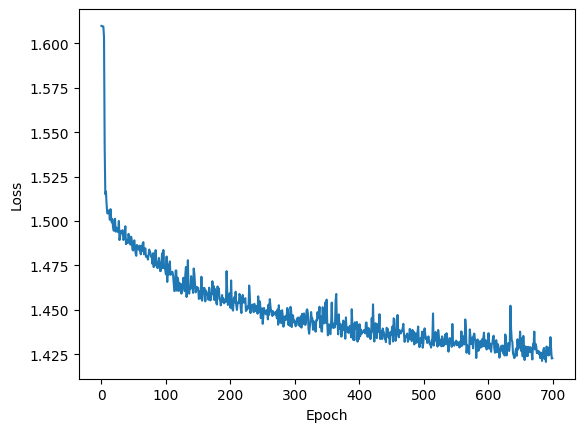

Test accuracy: 470.74021505376345
Accuracy: 0.43612903225806454
Precision: 0.4150658846136713
Recall: 0.4308282712575144
F1-score: 0.41288528633349897


Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.53      0.45       495
           1       0.65      0.84      0.73       472
           2       0.30      0.17      0.22       449
           3       0.28      0.28      0.28       463
           4       0.45      0.33      0.38       446

    accuracy                           0.44      2325
   macro avg       0.42      0.43      0.41      2325
weighted avg       0.42      0.44      0.42      2325

                    0           1           2           3           4  \
precision    0.390533    0.650820    0.300781    0.282276    0.450920   
recall       0.533333    0.841102    0.171492    0.278618    0.329596   
f1-score     0.450897    0.733826    0.218440    0.280435    0.380829   
support    495.000000  472.000000  449.0000

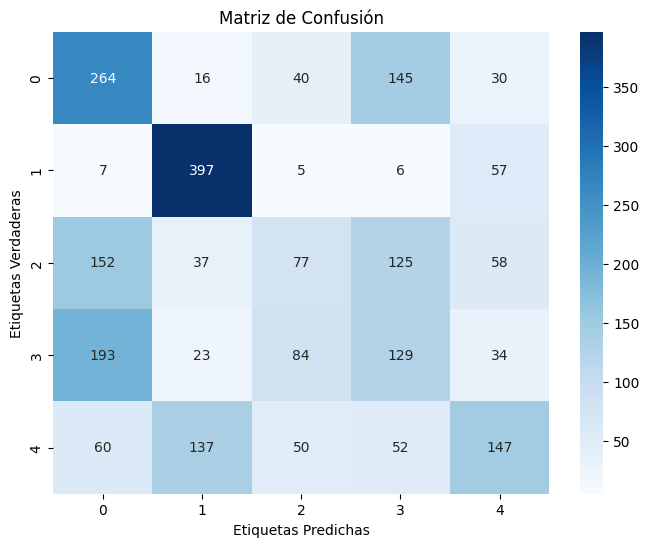

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_0.0001_0.1/resultados_700_0.0001_0.1.json
Procesando red con 700 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas:   0%|                                                               | 1/700 [00:01<19:59,  1.72s/it]

1.6096210690105663


Procesando epocas:   0%|▏                                                              | 2/700 [00:03<19:54,  1.71s/it]

1.6096253016415765


Procesando epocas:   0%|▎                                                              | 3/700 [00:05<20:02,  1.73s/it]

1.609613110738642


Procesando epocas:   1%|▎                                                              | 4/700 [00:06<20:04,  1.73s/it]

1.6096442573210772


Procesando epocas:   1%|▍                                                              | 5/700 [00:08<20:03,  1.73s/it]

1.6094969637253704


Procesando epocas:   1%|▌                                                              | 6/700 [00:10<20:01,  1.73s/it]

1.6095039500909694


Procesando epocas:   1%|▋                                                              | 7/700 [00:12<20:05,  1.74s/it]

1.609420760940103


Procesando epocas:   1%|▋                                                              | 8/700 [00:13<20:07,  1.75s/it]

1.6095040482633254


Procesando epocas:   1%|▊                                                              | 9/700 [00:15<20:03,  1.74s/it]

1.6095444728346433


Procesando epocas:   1%|▉                                                             | 10/700 [00:17<20:02,  1.74s/it]

1.609385085807127


Procesando epocas:   2%|▉                                                             | 11/700 [00:19<19:56,  1.74s/it]

1.6092394134577583


Procesando epocas:   2%|█                                                             | 12/700 [00:20<19:55,  1.74s/it]

1.6090352037373712


Procesando epocas:   2%|█▏                                                            | 13/700 [00:22<19:53,  1.74s/it]

1.6086705810883466


Procesando epocas:   2%|█▏                                                            | 14/700 [00:24<19:57,  1.75s/it]

1.607888430707595


Procesando epocas:   2%|█▎                                                            | 15/700 [00:26<19:46,  1.73s/it]

1.6063197318245384


Procesando epocas:   2%|█▍                                                            | 16/700 [00:27<19:42,  1.73s/it]

1.6031877089949216


Procesando epocas:   2%|█▌                                                            | 17/700 [00:29<19:34,  1.72s/it]

1.5975599457235898


Procesando epocas:   3%|█▌                                                            | 18/700 [00:31<19:29,  1.71s/it]

1.5889094296623678


Procesando epocas:   3%|█▋                                                            | 19/700 [00:32<19:29,  1.72s/it]

1.5768836708629832


Procesando epocas:   3%|█▊                                                            | 20/700 [00:34<19:27,  1.72s/it]

1.5654132997288424


Procesando epocas:   3%|█▊                                                            | 21/700 [00:36<19:25,  1.72s/it]

1.555605112805086


Procesando epocas:   3%|█▉                                                            | 22/700 [00:38<19:21,  1.71s/it]

1.5479087450925042


Procesando epocas:   3%|██                                                            | 23/700 [00:39<19:18,  1.71s/it]

1.541551983356476


Procesando epocas:   3%|██▏                                                           | 24/700 [00:41<19:15,  1.71s/it]

1.5366906362421373


Procesando epocas:   4%|██▏                                                           | 25/700 [00:43<19:16,  1.71s/it]

1.5306757674497717


Procesando epocas:   4%|██▎                                                           | 26/700 [00:44<19:16,  1.72s/it]

1.5287546873092652


Procesando epocas:   4%|██▍                                                           | 27/700 [00:46<19:16,  1.72s/it]

1.525019048242008


Procesando epocas:   4%|██▍                                                           | 28/700 [00:48<19:17,  1.72s/it]

1.5253092702697306


Procesando epocas:   4%|██▌                                                           | 29/700 [00:50<19:15,  1.72s/it]

1.5228916624013116


Procesando epocas:   4%|██▋                                                           | 30/700 [00:51<19:10,  1.72s/it]

1.5201836508863114


Procesando epocas:   4%|██▋                                                           | 31/700 [00:53<19:09,  1.72s/it]

1.5194240780437693


Procesando epocas:   5%|██▊                                                           | 32/700 [00:55<19:04,  1.71s/it]

1.516729308577145


Procesando epocas:   5%|██▉                                                           | 33/700 [00:56<19:01,  1.71s/it]

1.5173801688586965


Procesando epocas:   5%|███                                                           | 34/700 [00:58<19:03,  1.72s/it]

1.5127208632581375


Procesando epocas:   5%|███                                                           | 35/700 [01:00<18:59,  1.71s/it]

1.5130020926980412


Procesando epocas:   5%|███▏                                                          | 36/700 [01:02<18:55,  1.71s/it]

1.5138724544469049


Procesando epocas:   5%|███▎                                                          | 37/700 [01:03<18:52,  1.71s/it]

1.5119351127568412


Procesando epocas:   5%|███▎                                                          | 38/700 [01:05<18:49,  1.71s/it]

1.5116191485348869


Procesando epocas:   6%|███▍                                                          | 39/700 [01:07<18:46,  1.70s/it]

1.5116219765999739


Procesando epocas:   6%|███▌                                                          | 40/700 [01:08<18:44,  1.70s/it]

1.5108963258126202


Procesando epocas:   6%|███▋                                                          | 41/700 [01:10<18:40,  1.70s/it]

1.5092837410814621


Procesando epocas:   6%|███▋                                                          | 42/700 [01:12<18:40,  1.70s/it]

1.506978189945221


Procesando epocas:   6%|███▊                                                          | 43/700 [01:13<18:41,  1.71s/it]

1.5087961379219503


Procesando epocas:   6%|███▉                                                          | 44/700 [01:15<18:39,  1.71s/it]

1.5073725616230684


Procesando epocas:   6%|███▉                                                          | 45/700 [01:17<18:39,  1.71s/it]

1.5054172067081226


Procesando epocas:   7%|████                                                          | 46/700 [01:19<18:41,  1.71s/it]

1.5042066987823037


Procesando epocas:   7%|████▏                                                         | 47/700 [01:20<18:42,  1.72s/it]

1.5035585662897895


Procesando epocas:   7%|████▎                                                         | 48/700 [01:22<18:39,  1.72s/it]

1.5046228962786057


Procesando epocas:   7%|████▎                                                         | 49/700 [01:24<18:34,  1.71s/it]

1.503030429166906


Procesando epocas:   7%|████▍                                                         | 50/700 [01:25<18:30,  1.71s/it]

1.5041757660753587


Procesando epocas:   7%|████▌                                                         | 51/700 [01:27<18:25,  1.70s/it]

1.504386873806224


Procesando epocas:   7%|████▌                                                         | 52/700 [01:29<18:20,  1.70s/it]

1.502427059061387


Procesando epocas:   8%|████▋                                                         | 53/700 [01:30<18:08,  1.68s/it]

1.5023110522943384


Procesando epocas:   8%|████▊                                                         | 54/700 [01:32<17:58,  1.67s/it]

1.498464474958532


Procesando epocas:   8%|████▊                                                         | 55/700 [01:34<17:52,  1.66s/it]

1.4989067898077124


Procesando epocas:   8%|████▉                                                         | 56/700 [01:35<17:48,  1.66s/it]

1.5011025674202862


Procesando epocas:   8%|█████                                                         | 57/700 [01:37<17:48,  1.66s/it]

1.5029333289931803


Procesando epocas:   8%|█████▏                                                        | 58/700 [01:39<17:43,  1.66s/it]

1.5029523491859436


Procesando epocas:   8%|█████▏                                                        | 59/700 [01:40<17:36,  1.65s/it]

1.5012297588236192


Procesando epocas:   9%|█████▎                                                        | 60/700 [01:42<17:35,  1.65s/it]

1.4981640941956464


Procesando epocas:   9%|█████▍                                                        | 61/700 [01:44<17:36,  1.65s/it]

1.4982886538786047


Procesando epocas:   9%|█████▍                                                        | 62/700 [01:45<17:35,  1.65s/it]

1.4956238606396843


Procesando epocas:   9%|█████▌                                                        | 63/700 [01:47<17:34,  1.65s/it]

1.4988249743686002


Procesando epocas:   9%|█████▋                                                        | 64/700 [01:49<17:34,  1.66s/it]

1.499008651340709


Procesando epocas:   9%|█████▊                                                        | 65/700 [01:50<17:44,  1.68s/it]

1.4992097062223098


Procesando epocas:   9%|█████▊                                                        | 66/700 [01:52<17:50,  1.69s/it]

1.4974229462006512


Procesando epocas:  10%|█████▉                                                        | 67/700 [01:54<17:54,  1.70s/it]

1.495797439182506


Procesando epocas:  10%|██████                                                        | 68/700 [01:55<17:48,  1.69s/it]

1.4950269853367526


Procesando epocas:  10%|██████                                                        | 69/700 [01:57<17:40,  1.68s/it]

1.4955923325875227


Procesando epocas:  10%|██████▏                                                       | 70/700 [01:59<17:42,  1.69s/it]

1.494860480112188


Procesando epocas:  10%|██████▎                                                       | 71/700 [02:00<17:33,  1.68s/it]

1.4951441491351407


Procesando epocas:  10%|██████▍                                                       | 72/700 [02:02<17:36,  1.68s/it]

1.4921667582848492


Procesando epocas:  10%|██████▍                                                       | 73/700 [02:04<17:26,  1.67s/it]

1.4960313600652357


Procesando epocas:  11%|██████▌                                                       | 74/700 [02:05<17:26,  1.67s/it]

1.494023488549625


Procesando epocas:  11%|██████▋                                                       | 75/700 [02:07<17:29,  1.68s/it]

1.4941495811238008


Procesando epocas:  11%|██████▋                                                       | 76/700 [02:09<17:41,  1.70s/it]

1.4931991528062258


Procesando epocas:  11%|██████▊                                                       | 77/700 [02:11<17:50,  1.72s/it]

1.4955930022632375


Procesando epocas:  11%|██████▉                                                       | 78/700 [02:12<17:56,  1.73s/it]

1.4946226091945873


Procesando epocas:  11%|██████▉                                                       | 79/700 [02:14<17:58,  1.74s/it]

1.4946161957348094


Procesando epocas:  11%|███████                                                       | 80/700 [02:16<17:59,  1.74s/it]

1.4922035504789914


Procesando epocas:  12%|███████▏                                                      | 81/700 [02:18<17:57,  1.74s/it]

1.4916704710792092


Procesando epocas:  12%|███████▎                                                      | 82/700 [02:19<17:55,  1.74s/it]

1.4941106964560116


Procesando epocas:  12%|███████▎                                                      | 83/700 [02:21<17:54,  1.74s/it]

1.4929189541760612


Procesando epocas:  12%|███████▍                                                      | 84/700 [02:23<17:52,  1.74s/it]

1.4949883755515603


Procesando epocas:  12%|███████▌                                                      | 85/700 [02:25<17:52,  1.74s/it]

1.4939148713560666


Procesando epocas:  12%|███████▌                                                      | 86/700 [02:26<17:51,  1.74s/it]

1.489880547803991


Procesando epocas:  12%|███████▋                                                      | 87/700 [02:28<17:51,  1.75s/it]

1.4893659241059247


Procesando epocas:  13%|███████▊                                                      | 88/700 [02:30<17:48,  1.75s/it]

1.4928778108428506


Procesando epocas:  13%|███████▉                                                      | 89/700 [02:32<17:51,  1.75s/it]

1.4896816050305086


Procesando epocas:  13%|███████▉                                                      | 90/700 [02:33<17:48,  1.75s/it]

1.4901680069811203


Procesando epocas:  13%|████████                                                      | 91/700 [02:35<17:46,  1.75s/it]

1.4911877267500933


Procesando epocas:  13%|████████▏                                                     | 92/700 [02:37<17:48,  1.76s/it]

1.4906610643162448


Procesando epocas:  13%|████████▏                                                     | 93/700 [02:39<17:42,  1.75s/it]

1.4917088669889114


Procesando epocas:  13%|████████▎                                                     | 94/700 [02:40<17:41,  1.75s/it]

1.4903824350413155


Procesando epocas:  14%|████████▍                                                     | 95/700 [02:42<17:39,  1.75s/it]

1.48910352973377


Procesando epocas:  14%|████████▌                                                     | 96/700 [02:44<17:38,  1.75s/it]

1.4890615540392258


Procesando epocas:  14%|████████▌                                                     | 97/700 [02:46<17:37,  1.75s/it]

1.4852288056822385


Procesando epocas:  14%|████████▋                                                     | 98/700 [02:47<17:32,  1.75s/it]

1.4915829160634209


Procesando epocas:  14%|████████▊                                                     | 99/700 [02:49<17:25,  1.74s/it]

1.4904329454197602


Procesando epocas:  14%|████████▋                                                    | 100/700 [02:51<17:20,  1.73s/it]

1.487969842377831


Procesando epocas:  14%|████████▊                                                    | 101/700 [02:53<17:21,  1.74s/it]

1.4860627426820643


Procesando epocas:  15%|████████▉                                                    | 102/700 [02:54<17:21,  1.74s/it]

1.488023395398084


Procesando epocas:  15%|████████▉                                                    | 103/700 [02:56<17:26,  1.75s/it]

1.4887541111777811


Procesando epocas:  15%|█████████                                                    | 104/700 [02:58<17:27,  1.76s/it]

1.485254204974455


Procesando epocas:  15%|█████████▏                                                   | 105/700 [03:00<17:25,  1.76s/it]

1.4878701329231263


Procesando epocas:  15%|█████████▏                                                   | 106/700 [03:01<17:22,  1.76s/it]

1.4884504851172953


Procesando epocas:  15%|█████████▎                                                   | 107/700 [03:03<17:23,  1.76s/it]

1.4870433106141931


Procesando epocas:  15%|█████████▍                                                   | 108/700 [03:05<17:17,  1.75s/it]

1.4874022091136259


Procesando epocas:  16%|█████████▍                                                   | 109/700 [03:07<17:12,  1.75s/it]

1.487201835828669


Procesando epocas:  16%|█████████▌                                                   | 110/700 [03:08<17:08,  1.74s/it]

1.4881433094249052


Procesando epocas:  16%|█████████▋                                                   | 111/700 [03:10<17:05,  1.74s/it]

1.4878189325332642


Procesando epocas:  16%|█████████▊                                                   | 112/700 [03:12<16:59,  1.73s/it]

1.4854481725131765


Procesando epocas:  16%|█████████▊                                                   | 113/700 [03:14<16:56,  1.73s/it]

1.4868810737834257


Procesando epocas:  16%|█████████▉                                                   | 114/700 [03:15<16:56,  1.73s/it]

1.4886335751589608


Procesando epocas:  16%|██████████                                                   | 115/700 [03:17<16:53,  1.73s/it]

1.4887520888272454


Procesando epocas:  17%|██████████                                                   | 116/700 [03:19<16:48,  1.73s/it]

1.4879124122507432


Procesando epocas:  17%|██████████▏                                                  | 117/700 [03:20<16:42,  1.72s/it]

1.4873150208417107


Procesando epocas:  17%|██████████▎                                                  | 118/700 [03:22<16:42,  1.72s/it]

1.4879829329602858


Procesando epocas:  17%|██████████▎                                                  | 119/700 [03:24<16:40,  1.72s/it]

1.484602470958934


Procesando epocas:  17%|██████████▍                                                  | 120/700 [03:26<16:36,  1.72s/it]

1.4854727759080775


Procesando epocas:  17%|██████████▌                                                  | 121/700 [03:27<16:36,  1.72s/it]

1.4845733502331901


Procesando epocas:  17%|██████████▋                                                  | 122/700 [03:29<16:33,  1.72s/it]

1.4906672758214614


Procesando epocas:  18%|██████████▋                                                  | 123/700 [03:31<16:32,  1.72s/it]

1.4885593246011173


Procesando epocas:  18%|██████████▊                                                  | 124/700 [03:33<16:31,  1.72s/it]

1.4880668086164137


Procesando epocas:  18%|██████████▉                                                  | 125/700 [03:34<16:31,  1.72s/it]

1.4861646813504836


Procesando epocas:  18%|██████████▉                                                  | 126/700 [03:36<16:30,  1.73s/it]

1.4854564835043516


Procesando epocas:  18%|███████████                                                  | 127/700 [03:38<16:28,  1.73s/it]

1.4853811860084534


Procesando epocas:  18%|███████████▏                                                 | 128/700 [03:39<16:26,  1.72s/it]

1.486278986229616


Procesando epocas:  18%|███████████▏                                                 | 129/700 [03:41<16:24,  1.72s/it]

1.4865305809413685


Procesando epocas:  19%|███████████▎                                                 | 130/700 [03:43<16:21,  1.72s/it]

1.484440479559057


Procesando epocas:  19%|███████████▍                                                 | 131/700 [03:45<16:17,  1.72s/it]

1.4853618579752306


Procesando epocas:  19%|███████████▌                                                 | 132/700 [03:46<16:20,  1.73s/it]

1.4832711717661688


Procesando epocas:  19%|███████████▌                                                 | 133/700 [03:48<16:23,  1.74s/it]

1.4830381582765018


Procesando epocas:  19%|███████████▋                                                 | 134/700 [03:50<16:21,  1.73s/it]

1.484764539494234


Procesando epocas:  19%|███████████▊                                                 | 135/700 [03:52<16:21,  1.74s/it]

1.4841970015974606


Procesando epocas:  19%|███████████▊                                                 | 136/700 [03:53<16:16,  1.73s/it]

1.4827643233187058


Procesando epocas:  20%|███████████▉                                                 | 137/700 [03:55<16:10,  1.72s/it]

1.4814521866686203


Procesando epocas:  20%|████████████                                                 | 138/700 [03:57<16:03,  1.71s/it]

1.4874019181027132


Procesando epocas:  20%|████████████                                                 | 139/700 [03:58<15:57,  1.71s/it]

1.4841537356376648


Procesando epocas:  20%|████████████▏                                                | 140/700 [04:00<15:52,  1.70s/it]

1.4840292804381428


Procesando epocas:  20%|████████████▎                                                | 141/700 [04:02<15:51,  1.70s/it]

1.4817855379160714


Procesando epocas:  20%|████████████▎                                                | 142/700 [04:03<15:48,  1.70s/it]

1.4877404079717749


Procesando epocas:  20%|████████████▍                                                | 143/700 [04:05<15:47,  1.70s/it]

1.4807902581551495


Procesando epocas:  21%|████████████▌                                                | 144/700 [04:07<15:45,  1.70s/it]

1.483854256657993


Procesando epocas:  21%|████████████▋                                                | 145/700 [04:09<15:43,  1.70s/it]

1.4819504261016845


Procesando epocas:  21%|████████████▋                                                | 146/700 [04:10<15:40,  1.70s/it]

1.4842775092405431


Procesando epocas:  21%|████████████▊                                                | 147/700 [04:12<15:35,  1.69s/it]

1.4823596190003787


Procesando epocas:  21%|████████████▉                                                | 148/700 [04:14<15:38,  1.70s/it]

1.482851627293755


Procesando epocas:  21%|████████████▉                                                | 149/700 [04:15<15:40,  1.71s/it]

1.4813180965535782


Procesando epocas:  21%|█████████████                                                | 150/700 [04:17<15:37,  1.70s/it]

1.481610205594231


Procesando epocas:  22%|█████████████▏                                               | 151/700 [04:19<15:33,  1.70s/it]

1.4830913073876324


Procesando epocas:  22%|█████████████▏                                               | 152/700 [04:20<15:33,  1.70s/it]

1.484405255317688


Procesando epocas:  22%|█████████████▎                                               | 153/700 [04:22<15:34,  1.71s/it]

1.484001855289235


Procesando epocas:  22%|█████████████▍                                               | 154/700 [04:24<15:32,  1.71s/it]

1.4806933809729184


Procesando epocas:  22%|█████████████▌                                               | 155/700 [04:26<15:26,  1.70s/it]

1.479347472331103


Procesando epocas:  22%|█████████████▌                                               | 156/700 [04:27<15:24,  1.70s/it]

1.4846579060834997


Procesando epocas:  22%|█████████████▋                                               | 157/700 [04:29<15:25,  1.71s/it]

1.4841651776257683


Procesando epocas:  23%|█████████████▊                                               | 158/700 [04:31<15:24,  1.71s/it]

1.4801760294858146


Procesando epocas:  23%|█████████████▊                                               | 159/700 [04:32<15:24,  1.71s/it]

1.4814893820706536


Procesando epocas:  23%|█████████████▉                                               | 160/700 [04:34<15:24,  1.71s/it]

1.4800311488263747


Procesando epocas:  23%|██████████████                                               | 161/700 [04:36<15:20,  1.71s/it]

1.4781820206081167


Procesando epocas:  23%|██████████████                                               | 162/700 [04:38<15:19,  1.71s/it]

1.4834943532943725


Procesando epocas:  23%|██████████████▏                                              | 163/700 [04:39<15:14,  1.70s/it]

1.4844647014842314


Procesando epocas:  23%|██████████████▎                                              | 164/700 [04:41<15:08,  1.69s/it]

1.481117040269515


Procesando epocas:  24%|██████████████▍                                              | 165/700 [04:43<15:05,  1.69s/it]

1.4783285421483656


Procesando epocas:  24%|██████████████▍                                              | 166/700 [04:44<14:59,  1.68s/it]

1.4811354265493506


Procesando epocas:  24%|██████████████▌                                              | 167/700 [04:46<14:53,  1.68s/it]

1.4827282330569098


Procesando epocas:  24%|██████████████▋                                              | 168/700 [04:48<14:52,  1.68s/it]

1.479718194288366


Procesando epocas:  24%|██████████████▋                                              | 169/700 [04:49<14:51,  1.68s/it]

1.4806691562428194


Procesando epocas:  24%|██████████████▊                                              | 170/700 [04:51<14:46,  1.67s/it]

1.4794714780414806


Procesando epocas:  24%|██████████████▉                                              | 171/700 [04:53<14:45,  1.67s/it]

1.4789985130814944


Procesando epocas:  25%|██████████████▉                                              | 172/700 [04:54<14:44,  1.68s/it]

1.48159980914172


Procesando epocas:  25%|███████████████                                              | 173/700 [04:56<14:42,  1.68s/it]

1.4800622996161965


Procesando epocas:  25%|███████████████▏                                             | 174/700 [04:58<14:42,  1.68s/it]

1.4803664558074054


Procesando epocas:  25%|███████████████▎                                             | 175/700 [04:59<14:40,  1.68s/it]

1.4789470329004175


Procesando epocas:  25%|███████████████▎                                             | 176/700 [05:01<14:41,  1.68s/it]

1.4821865383316488


Procesando epocas:  25%|███████████████▍                                             | 177/700 [05:03<14:43,  1.69s/it]

1.4789261803907507


Procesando epocas:  25%|███████████████▌                                             | 178/700 [05:04<14:43,  1.69s/it]

1.4822150454801672


Procesando epocas:  26%|███████████████▌                                             | 179/700 [05:06<14:44,  1.70s/it]

1.4780676399960238


Procesando epocas:  26%|███████████████▋                                             | 180/700 [05:08<14:39,  1.69s/it]

1.4819448884795694


Procesando epocas:  26%|███████████████▊                                             | 181/700 [05:09<14:38,  1.69s/it]

1.4819134018000435


Procesando epocas:  26%|███████████████▊                                             | 182/700 [05:11<14:34,  1.69s/it]

1.4841168186243843


Procesando epocas:  26%|███████████████▉                                             | 183/700 [05:13<14:29,  1.68s/it]

1.4824711680412292


Procesando epocas:  26%|████████████████                                             | 184/700 [05:14<14:24,  1.68s/it]

1.4773838730419384


Procesando epocas:  26%|████████████████                                             | 185/700 [05:16<14:22,  1.67s/it]

1.4810755245825824


Procesando epocas:  27%|████████████████▏                                            | 186/700 [05:18<14:20,  1.67s/it]

1.4793542048510384


Procesando epocas:  27%|████████████████▎                                            | 187/700 [05:20<14:21,  1.68s/it]

1.4835415713927325


Procesando epocas:  27%|████████████████▍                                            | 188/700 [05:21<14:20,  1.68s/it]

1.4795786072226131


Procesando epocas:  27%|████████████████▍                                            | 189/700 [05:23<14:19,  1.68s/it]

1.4787778068991269


Procesando epocas:  27%|████████████████▌                                            | 190/700 [05:25<14:18,  1.68s/it]

1.4796191832598518


Procesando epocas:  27%|████████████████▋                                            | 191/700 [05:26<14:17,  1.69s/it]

1.4804783239084132


Procesando epocas:  27%|████████████████▋                                            | 192/700 [05:28<14:13,  1.68s/it]

1.4799551122328813


Procesando epocas:  28%|████████████████▊                                            | 193/700 [05:30<14:10,  1.68s/it]

1.4757132228683023


Procesando epocas:  28%|████████████████▉                                            | 194/700 [05:31<14:08,  1.68s/it]

1.478284410869374


Procesando epocas:  28%|████████████████▉                                            | 195/700 [05:33<14:05,  1.67s/it]

1.4780379372484544


Procesando epocas:  28%|█████████████████                                            | 196/700 [05:35<14:02,  1.67s/it]

1.4769437404239878


Procesando epocas:  28%|█████████████████▏                                           | 197/700 [05:36<14:12,  1.69s/it]

1.4782994641977198


Procesando epocas:  28%|█████████████████▎                                           | 198/700 [05:38<14:20,  1.71s/it]

1.4787877440452575


Procesando epocas:  28%|█████████████████▎                                           | 199/700 [05:40<14:25,  1.73s/it]

1.474564979356878


Procesando epocas:  29%|█████████████████▍                                           | 200/700 [05:42<14:27,  1.73s/it]

1.4801650517127094


Procesando epocas:  29%|█████████████████▌                                           | 201/700 [05:43<14:29,  1.74s/it]

1.4789825502563925


Procesando epocas:  29%|█████████████████▌                                           | 202/700 [05:45<14:29,  1.75s/it]

1.4772627676234527


Procesando epocas:  29%|█████████████████▋                                           | 203/700 [05:47<14:28,  1.75s/it]

1.4825625447665944


Procesando epocas:  29%|█████████████████▊                                           | 204/700 [05:49<14:31,  1.76s/it]

1.476246281231151


Procesando epocas:  29%|█████████████████▊                                           | 205/700 [05:50<14:33,  1.76s/it]

1.476019195248099


Procesando epocas:  29%|█████████████████▉                                           | 206/700 [05:52<14:31,  1.76s/it]

1.4763119592386134


Procesando epocas:  30%|██████████████████                                           | 207/700 [05:54<14:28,  1.76s/it]

1.479326679426081


Procesando epocas:  30%|██████████████████▏                                          | 208/700 [05:56<14:27,  1.76s/it]

1.476094266947578


Procesando epocas:  30%|██████████████████▏                                          | 209/700 [05:58<14:27,  1.77s/it]

1.4784797472112319


Procesando epocas:  30%|██████████████████▎                                          | 210/700 [05:59<14:25,  1.77s/it]

1.4796695414711447


Procesando epocas:  30%|██████████████████▍                                          | 211/700 [06:01<14:24,  1.77s/it]

1.475753372557023


Procesando epocas:  30%|██████████████████▍                                          | 212/700 [06:03<14:19,  1.76s/it]

1.475720342467813


Procesando epocas:  30%|██████████████████▌                                          | 213/700 [06:05<14:15,  1.76s/it]

1.4764873441527873


Procesando epocas:  31%|██████████████████▋                                          | 214/700 [06:06<14:17,  1.76s/it]

1.4802996901904835


Procesando epocas:  31%|██████████████████▋                                          | 215/700 [06:08<14:18,  1.77s/it]

1.4782537761856527


Procesando epocas:  31%|██████████████████▊                                          | 216/700 [06:10<14:15,  1.77s/it]

1.4830219093491048


Procesando epocas:  31%|██████████████████▉                                          | 217/700 [06:12<14:11,  1.76s/it]

1.482008652827319


Procesando epocas:  31%|██████████████████▉                                          | 218/700 [06:13<14:12,  1.77s/it]

1.4736104944173027


Procesando epocas:  31%|███████████████████                                          | 219/700 [06:15<14:11,  1.77s/it]

1.4768438451430377


Procesando epocas:  31%|███████████████████▏                                         | 220/700 [06:17<14:11,  1.77s/it]

1.47739820690716


Procesando epocas:  32%|███████████████████▎                                         | 221/700 [06:19<14:08,  1.77s/it]

1.4766127256786121


Procesando epocas:  32%|███████████████████▎                                         | 222/700 [06:21<14:06,  1.77s/it]

1.4789638736668755


Procesando epocas:  32%|███████████████████▍                                         | 223/700 [06:22<14:07,  1.78s/it]

1.4797782890936908


Procesando epocas:  32%|███████████████████▌                                         | 224/700 [06:24<14:05,  1.78s/it]

1.477823707636665


Procesando epocas:  32%|███████████████████▌                                         | 225/700 [06:26<14:03,  1.78s/it]

1.4796892397543964


Procesando epocas:  32%|███████████████████▋                                         | 226/700 [06:28<14:00,  1.77s/it]

1.4802849313792061


Procesando epocas:  32%|███████████████████▊                                         | 227/700 [06:29<14:01,  1.78s/it]

1.478560916816487


Procesando epocas:  33%|███████████████████▊                                         | 228/700 [06:31<13:55,  1.77s/it]

1.4778170831063215


Procesando epocas:  33%|███████████████████▉                                         | 229/700 [06:33<13:45,  1.75s/it]

1.4765063706566306


Procesando epocas:  33%|████████████████████                                         | 230/700 [06:35<13:38,  1.74s/it]

1.4770146636401906


Procesando epocas:  33%|████████████████████▏                                        | 231/700 [06:36<13:33,  1.73s/it]

1.4740626545513378


Procesando epocas:  33%|████████████████████▏                                        | 232/700 [06:38<13:28,  1.73s/it]

1.4745329695589402


Procesando epocas:  33%|████████████████████▎                                        | 233/700 [06:40<13:28,  1.73s/it]

1.4759385115960064


Procesando epocas:  33%|████████████████████▍                                        | 234/700 [06:41<13:27,  1.73s/it]

1.477592257191153


Procesando epocas:  34%|████████████████████▍                                        | 235/700 [06:43<13:26,  1.73s/it]

1.4715625061708337


Procesando epocas:  34%|████████████████████▌                                        | 236/700 [06:45<13:23,  1.73s/it]

1.476192831993103


Procesando epocas:  34%|████████████████████▋                                        | 237/700 [06:47<13:20,  1.73s/it]

1.4796114255400266


Procesando epocas:  34%|████████████████████▋                                        | 238/700 [06:48<13:16,  1.73s/it]

1.4782998912474687


Procesando epocas:  34%|████████████████████▊                                        | 239/700 [06:50<13:15,  1.73s/it]

1.4778547216864193


Procesando epocas:  34%|████████████████████▉                                        | 240/700 [06:52<13:16,  1.73s/it]

1.4772346384385053


Procesando epocas:  34%|█████████████████████                                        | 241/700 [06:54<13:16,  1.74s/it]

1.4819333104526295


Procesando epocas:  35%|█████████████████████                                        | 242/700 [06:55<13:16,  1.74s/it]

1.4760927508859074


Procesando epocas:  35%|█████████████████████▏                                       | 243/700 [06:57<13:15,  1.74s/it]

1.4746938621296601


Procesando epocas:  35%|█████████████████████▎                                       | 244/700 [06:59<13:12,  1.74s/it]

1.4744900948861066


Procesando epocas:  35%|█████████████████████▎                                       | 245/700 [07:01<13:11,  1.74s/it]

1.4782792869736165


Procesando epocas:  35%|█████████████████████▍                                       | 246/700 [07:02<13:07,  1.74s/it]

1.4755418812527377


Procesando epocas:  35%|█████████████████████▌                                       | 247/700 [07:04<13:04,  1.73s/it]

1.4728262010742637


Procesando epocas:  35%|█████████████████████▌                                       | 248/700 [07:06<12:58,  1.72s/it]

1.4740037805893842


Procesando epocas:  36%|█████████████████████▋                                       | 249/700 [07:07<12:52,  1.71s/it]

1.4729506597799413


Procesando epocas:  36%|█████████████████████▊                                       | 250/700 [07:09<12:46,  1.70s/it]

1.4745273456853978


Procesando epocas:  36%|█████████████████████▊                                       | 251/700 [07:11<12:42,  1.70s/it]

1.4763887398383198


Procesando epocas:  36%|█████████████████████▉                                       | 252/700 [07:12<12:39,  1.70s/it]

1.47819966989405


Procesando epocas:  36%|██████████████████████                                       | 253/700 [07:14<12:36,  1.69s/it]

1.4744548012228573


Procesando epocas:  36%|██████████████████████▏                                      | 254/700 [07:16<12:35,  1.69s/it]

1.475879466533661


Procesando epocas:  36%|██████████████████████▏                                      | 255/700 [07:18<12:31,  1.69s/it]

1.4719940725494833


Procesando epocas:  37%|██████████████████████▎                                      | 256/700 [07:19<12:26,  1.68s/it]

1.4760897573302774


Procesando epocas:  37%|██████████████████████▍                                      | 257/700 [07:21<12:25,  1.68s/it]

1.4770790352540857


Procesando epocas:  37%|██████████████████████▍                                      | 258/700 [07:23<12:19,  1.67s/it]

1.4765622728011187


Procesando epocas:  37%|██████████████████████▌                                      | 259/700 [07:24<12:17,  1.67s/it]

1.47879259446088


Procesando epocas:  37%|██████████████████████▋                                      | 260/700 [07:26<12:13,  1.67s/it]

1.4711984515190124


Procesando epocas:  37%|██████████████████████▋                                      | 261/700 [07:28<12:10,  1.66s/it]

1.4760045339079464


Procesando epocas:  37%|██████████████████████▊                                      | 262/700 [07:29<12:07,  1.66s/it]

1.476946888250463


Procesando epocas:  38%|██████████████████████▉                                      | 263/700 [07:31<12:04,  1.66s/it]

1.4725454940515406


Procesando epocas:  38%|███████████████████████                                      | 264/700 [07:32<12:04,  1.66s/it]

1.4727412798825432


Procesando epocas:  38%|███████████████████████                                      | 265/700 [07:34<12:01,  1.66s/it]

1.47452351696351


Procesando epocas:  38%|███████████████████████▏                                     | 266/700 [07:36<11:58,  1.66s/it]

1.4752738609033473


Procesando epocas:  38%|███████████████████████▎                                     | 267/700 [07:37<11:58,  1.66s/it]

1.4754075807683609


Procesando epocas:  38%|███████████████████████▎                                     | 268/700 [07:39<12:01,  1.67s/it]

1.481024077359368


Procesando epocas:  38%|███████████████████████▍                                     | 269/700 [07:41<12:04,  1.68s/it]

1.476477612467373


Procesando epocas:  39%|███████████████████████▌                                     | 270/700 [07:43<12:07,  1.69s/it]

1.4771411916788886


Procesando epocas:  39%|███████████████████████▌                                     | 271/700 [07:44<12:08,  1.70s/it]

1.4747215446303872


Procesando epocas:  39%|███████████████████████▋                                     | 272/700 [07:46<12:05,  1.70s/it]

1.4752240812077242


Procesando epocas:  39%|███████████████████████▊                                     | 273/700 [07:48<12:01,  1.69s/it]

1.4763534672120038


Procesando epocas:  39%|███████████████████████▉                                     | 274/700 [07:49<11:55,  1.68s/it]

1.4732770660344292


Procesando epocas:  39%|███████████████████████▉                                     | 275/700 [07:51<11:51,  1.67s/it]

1.4724230752271765


Procesando epocas:  39%|████████████████████████                                     | 276/700 [07:53<11:50,  1.68s/it]

1.4755635941729826


Procesando epocas:  40%|████████████████████████▏                                    | 277/700 [07:54<11:50,  1.68s/it]

1.4737469939624561


Procesando epocas:  40%|████████████████████████▏                                    | 278/700 [07:56<11:46,  1.67s/it]

1.474990445726058


Procesando epocas:  40%|████████████████████████▎                                    | 279/700 [07:58<11:42,  1.67s/it]

1.4744100900257335


Procesando epocas:  40%|████████████████████████▍                                    | 280/700 [07:59<11:41,  1.67s/it]

1.473241034676047


Procesando epocas:  40%|████████████████████████▍                                    | 281/700 [08:01<11:37,  1.66s/it]

1.4745262636857874


Procesando epocas:  40%|████████████████████████▌                                    | 282/700 [08:03<11:37,  1.67s/it]

1.4735818056499257


Procesando epocas:  40%|████████████████████████▋                                    | 283/700 [08:04<11:35,  1.67s/it]

1.472873781007879


Procesando epocas:  41%|████████████████████████▋                                    | 284/700 [08:06<11:31,  1.66s/it]

1.4688131093978882


Procesando epocas:  41%|████████████████████████▊                                    | 285/700 [08:08<11:29,  1.66s/it]

1.4742956624311558


Procesando epocas:  41%|████████████████████████▉                                    | 286/700 [08:09<11:27,  1.66s/it]

1.4747652053833007


Procesando epocas:  41%|█████████████████████████                                    | 287/700 [08:11<11:25,  1.66s/it]

1.4737089977544897


Procesando epocas:  41%|█████████████████████████                                    | 288/700 [08:13<11:19,  1.65s/it]

1.4723193904932808


Procesando epocas:  41%|█████████████████████████▏                                   | 289/700 [08:14<11:16,  1.65s/it]

1.4723527606795817


Procesando epocas:  41%|█████████████████████████▎                                   | 290/700 [08:16<11:12,  1.64s/it]

1.478518295989317


Procesando epocas:  42%|█████████████████████████▎                                   | 291/700 [08:17<11:11,  1.64s/it]

1.4740993513780483


Procesando epocas:  42%|█████████████████████████▍                                   | 292/700 [08:19<11:09,  1.64s/it]

1.4743157099275028


Procesando epocas:  42%|█████████████████████████▌                                   | 293/700 [08:21<11:06,  1.64s/it]

1.4707084389293894


Procesando epocas:  42%|█████████████████████████▌                                   | 294/700 [08:22<11:03,  1.64s/it]

1.4754228339475743


Procesando epocas:  42%|█████████████████████████▋                                   | 295/700 [08:24<11:03,  1.64s/it]

1.4725477113443262


Procesando epocas:  42%|█████████████████████████▊                                   | 296/700 [08:26<11:03,  1.64s/it]

1.471659949246575


Procesando epocas:  42%|█████████████████████████▉                                   | 297/700 [08:27<11:06,  1.65s/it]

1.4709850535673255


Procesando epocas:  43%|█████████████████████████▉                                   | 298/700 [08:29<11:07,  1.66s/it]

1.4705417001948637


Procesando epocas:  43%|██████████████████████████                                   | 299/700 [08:31<11:11,  1.67s/it]

1.4732468317536747


Procesando epocas:  43%|██████████████████████████▏                                  | 300/700 [08:32<11:12,  1.68s/it]

1.4746612050954033


Procesando epocas:  43%|██████████████████████████▏                                  | 301/700 [08:34<11:15,  1.69s/it]

1.4721817837041966


Procesando epocas:  43%|██████████████████████████▎                                  | 302/700 [08:36<11:12,  1.69s/it]

1.4707713505801032


Procesando epocas:  43%|██████████████████████████▍                                  | 303/700 [08:38<11:14,  1.70s/it]

1.4726586909855113


Procesando epocas:  43%|██████████████████████████▍                                  | 304/700 [08:39<11:13,  1.70s/it]

1.4725487302331364


Procesando epocas:  44%|██████████████████████████▌                                  | 305/700 [08:41<11:13,  1.70s/it]

1.4732644284472747


Procesando epocas:  44%|██████████████████████████▋                                  | 306/700 [08:43<11:14,  1.71s/it]

1.476591084283941


Procesando epocas:  44%|██████████████████████████▊                                  | 307/700 [08:44<11:13,  1.71s/it]

1.472199498905855


Procesando epocas:  44%|██████████████████████████▊                                  | 308/700 [08:46<11:11,  1.71s/it]

1.4735594714389129


Procesando epocas:  44%|██████████████████████████▉                                  | 309/700 [08:48<11:08,  1.71s/it]

1.4724216706612532


Procesando epocas:  44%|███████████████████████████                                  | 310/700 [08:50<11:07,  1.71s/it]

1.4735910850412706


Procesando epocas:  44%|███████████████████████████                                  | 311/700 [08:51<11:07,  1.72s/it]

1.4720065165968503


Procesando epocas:  45%|███████████████████████████▏                                 | 312/700 [08:53<11:07,  1.72s/it]

1.4733793511110194


Procesando epocas:  45%|███████████████████████████▎                                 | 313/700 [08:55<11:05,  1.72s/it]

1.4728528387406292


Procesando epocas:  45%|███████████████████████████▎                                 | 314/700 [08:56<11:06,  1.73s/it]

1.470406144506791


Procesando epocas:  45%|███████████████████████████▍                                 | 315/700 [08:58<11:04,  1.73s/it]

1.4739560933674083


Procesando epocas:  45%|███████████████████████████▌                                 | 316/700 [09:00<11:01,  1.72s/it]

1.469968020915985


Procesando epocas:  45%|███████████████████████████▌                                 | 317/700 [09:02<10:58,  1.72s/it]

1.470904174972983


Procesando epocas:  45%|███████████████████████████▋                                 | 318/700 [09:03<10:57,  1.72s/it]

1.4731459386208479


Procesando epocas:  46%|███████████████████████████▊                                 | 319/700 [09:05<11:02,  1.74s/it]

1.474299797591041


Procesando epocas:  46%|███████████████████████████▉                                 | 320/700 [09:07<11:07,  1.76s/it]

1.4739235043525696


Procesando epocas:  46%|███████████████████████████▉                                 | 321/700 [09:09<11:10,  1.77s/it]

1.4719754380338332


Procesando epocas:  46%|████████████████████████████                                 | 322/700 [09:11<11:13,  1.78s/it]

1.4687890354324789


Procesando epocas:  46%|████████████████████████████▏                                | 323/700 [09:12<11:09,  1.78s/it]

1.4728271105710198


Procesando epocas:  46%|████████████████████████████▏                                | 324/700 [09:14<11:05,  1.77s/it]

1.472758674621582


Procesando epocas:  46%|████████████████████████████▎                                | 325/700 [09:16<11:03,  1.77s/it]

1.47415711739484


Procesando epocas:  47%|████████████████████████████▍                                | 326/700 [09:18<11:06,  1.78s/it]

1.4717127435347612


Procesando epocas:  47%|████████████████████████████▍                                | 327/700 [09:19<11:02,  1.78s/it]

1.469507183046902


Procesando epocas:  47%|████████████████████████████▌                                | 328/700 [09:21<10:59,  1.77s/it]

1.4716801468063803


Procesando epocas:  47%|████████████████████████████▋                                | 329/700 [09:23<10:55,  1.77s/it]

1.469960977750666


Procesando epocas:  47%|████████████████████████████▊                                | 330/700 [09:25<10:53,  1.77s/it]

1.4692308376817143


Procesando epocas:  47%|████████████████████████████▊                                | 331/700 [09:26<10:55,  1.78s/it]

1.4714411132475909


Procesando epocas:  47%|████████████████████████████▉                                | 332/700 [09:28<10:53,  1.78s/it]

1.471546502674327


Procesando epocas:  48%|█████████████████████████████                                | 333/700 [09:30<10:50,  1.77s/it]

1.4704067945480346


Procesando epocas:  48%|█████████████████████████████                                | 334/700 [09:32<10:46,  1.77s/it]

1.4702942104900585


Procesando epocas:  48%|█████████████████████████████▏                               | 335/700 [09:34<10:44,  1.77s/it]

1.4733144549762502


Procesando epocas:  48%|█████████████████████████████▎                               | 336/700 [09:35<10:42,  1.77s/it]

1.4701701045036315


Procesando epocas:  48%|█████████████████████████████▎                               | 337/700 [09:37<10:42,  1.77s/it]

1.468914935168098


Procesando epocas:  48%|█████████████████████████████▍                               | 338/700 [09:39<10:41,  1.77s/it]

1.4775488930590013


Procesando epocas:  48%|█████████████████████████████▌                               | 339/700 [09:41<10:38,  1.77s/it]

1.4712169556056751


Procesando epocas:  49%|█████████████████████████████▋                               | 340/700 [09:42<10:36,  1.77s/it]

1.4700997885535745


Procesando epocas:  49%|█████████████████████████████▋                               | 341/700 [09:44<10:31,  1.76s/it]

1.4685925189186544


Procesando epocas:  49%|█████████████████████████████▊                               | 342/700 [09:46<10:28,  1.76s/it]

1.4733387589454652


Procesando epocas:  49%|█████████████████████████████▉                               | 343/700 [09:48<10:26,  1.76s/it]

1.470217544892255


Procesando epocas:  49%|█████████████████████████████▉                               | 344/700 [09:49<10:27,  1.76s/it]

1.469337870794184


Procesando epocas:  49%|██████████████████████████████                               | 345/700 [09:51<10:24,  1.76s/it]

1.4709077288122738


Procesando epocas:  49%|██████████████████████████████▏                              | 346/700 [09:53<10:24,  1.76s/it]

1.4713997665573568


Procesando epocas:  50%|██████████████████████████████▏                              | 347/700 [09:55<10:23,  1.77s/it]

1.4729366807376638


Procesando epocas:  50%|██████████████████████████████▎                              | 348/700 [09:56<10:22,  1.77s/it]

1.467783205649432


Procesando epocas:  50%|██████████████████████████████▍                              | 349/700 [09:58<10:17,  1.76s/it]

1.4691942425335154


Procesando epocas:  50%|██████████████████████████████▌                              | 350/700 [10:00<10:11,  1.75s/it]

1.469472318537095


Procesando epocas:  50%|██████████████████████████████▌                              | 351/700 [10:02<10:05,  1.73s/it]

1.4698236745946547


Procesando epocas:  50%|██████████████████████████████▋                              | 352/700 [10:03<10:01,  1.73s/it]

1.4733515767490162


Procesando epocas:  50%|██████████████████████████████▊                              | 353/700 [10:05<10:00,  1.73s/it]

1.47068391196868


Procesando epocas:  51%|██████████████████████████████▊                              | 354/700 [10:07<09:57,  1.73s/it]

1.4740296833655413


Procesando epocas:  51%|██████████████████████████████▉                              | 355/700 [10:09<09:52,  1.72s/it]

1.4727526433327618


Procesando epocas:  51%|███████████████████████████████                              | 356/700 [10:10<09:50,  1.72s/it]

1.4688312376246733


Procesando epocas:  51%|███████████████████████████████                              | 357/700 [10:12<09:47,  1.71s/it]

1.4698886492673089


Procesando epocas:  51%|███████████████████████████████▏                             | 358/700 [10:14<09:46,  1.71s/it]

1.4674957990646362


Procesando epocas:  51%|███████████████████████████████▎                             | 359/700 [10:15<09:45,  1.72s/it]

1.4679913689108457


Procesando epocas:  51%|███████████████████████████████▎                             | 360/700 [10:17<09:44,  1.72s/it]

1.4699311803368962


Procesando epocas:  52%|███████████████████████████████▍                             | 361/700 [10:19<09:41,  1.72s/it]

1.4680668648551491


Procesando epocas:  52%|███████████████████████████████▌                             | 362/700 [10:21<09:41,  1.72s/it]

1.4676766760209028


Procesando epocas:  52%|███████████████████████████████▋                             | 363/700 [10:22<09:38,  1.72s/it]

1.4701462156632368


Procesando epocas:  52%|███████████████████████████████▋                             | 364/700 [10:24<09:35,  1.71s/it]

1.4691798399476443


Procesando epocas:  52%|███████████████████████████████▊                             | 365/700 [10:26<09:33,  1.71s/it]

1.470656955242157


Procesando epocas:  52%|███████████████████████████████▉                             | 366/700 [10:27<09:31,  1.71s/it]

1.4700442552566528


Procesando epocas:  52%|███████████████████████████████▉                             | 367/700 [10:29<09:28,  1.71s/it]

1.4659353796173544


Procesando epocas:  53%|████████████████████████████████                             | 368/700 [10:31<09:27,  1.71s/it]

1.4738240038647372


Procesando epocas:  53%|████████████████████████████████▏                            | 369/700 [10:32<09:26,  1.71s/it]

1.4708282267346102


Procesando epocas:  53%|████████████████████████████████▏                            | 370/700 [10:34<09:25,  1.71s/it]

1.4672393441200255


Procesando epocas:  53%|████████████████████████████████▎                            | 371/700 [10:36<09:24,  1.72s/it]

1.4723502495709588


Procesando epocas:  53%|████████████████████████████████▍                            | 372/700 [10:38<09:23,  1.72s/it]

1.4650152956738192


Procesando epocas:  53%|████████████████████████████████▌                            | 373/700 [10:39<09:23,  1.72s/it]

1.4726461010820726


Procesando epocas:  53%|████████████████████████████████▌                            | 374/700 [10:41<09:22,  1.72s/it]

1.4707754618981306


Procesando epocas:  54%|████████████████████████████████▋                            | 375/700 [10:43<09:21,  1.73s/it]

1.467957152338589


Procesando epocas:  54%|████████████████████████████████▊                            | 376/700 [10:45<09:23,  1.74s/it]

1.46987648080377


Procesando epocas:  54%|████████████████████████████████▊                            | 377/700 [10:46<09:19,  1.73s/it]

1.4705944741473478


Procesando epocas:  54%|████████████████████████████████▉                            | 378/700 [10:48<09:14,  1.72s/it]

1.4638916976311627


Procesando epocas:  54%|█████████████████████████████████                            | 379/700 [10:50<09:11,  1.72s/it]

1.4695912543465108


Procesando epocas:  54%|█████████████████████████████████                            | 380/700 [10:51<09:09,  1.72s/it]

1.4682373790179981


Procesando epocas:  54%|█████████████████████████████████▏                           | 381/700 [10:53<09:06,  1.71s/it]

1.474505639777464


Procesando epocas:  55%|█████████████████████████████████▎                           | 382/700 [10:55<09:01,  1.70s/it]

1.4699224801624522


Procesando epocas:  55%|█████████████████████████████████▍                           | 383/700 [10:57<08:57,  1.70s/it]

1.4693309882107903


Procesando epocas:  55%|█████████████████████████████████▍                           | 384/700 [10:58<08:55,  1.69s/it]

1.4720008064718808


Procesando epocas:  55%|█████████████████████████████████▌                           | 385/700 [11:00<08:55,  1.70s/it]

1.4667418795473435


Procesando epocas:  55%|█████████████████████████████████▋                           | 386/700 [11:02<08:54,  1.70s/it]

1.471502156117383


Procesando epocas:  55%|█████████████████████████████████▋                           | 387/700 [11:03<08:53,  1.70s/it]

1.4679561734199524


Procesando epocas:  55%|█████████████████████████████████▊                           | 388/700 [11:05<08:49,  1.70s/it]

1.4690305338186376


Procesando epocas:  56%|█████████████████████████████████▉                           | 389/700 [11:07<08:47,  1.70s/it]

1.47139213996775


Procesando epocas:  56%|█████████████████████████████████▉                           | 390/700 [11:08<08:43,  1.69s/it]

1.4681541765437407


Procesando epocas:  56%|██████████████████████████████████                           | 391/700 [11:10<08:42,  1.69s/it]

1.4680236094138202


Procesando epocas:  56%|██████████████████████████████████▏                          | 392/700 [11:12<08:43,  1.70s/it]

1.4695350724108078


Procesando epocas:  56%|██████████████████████████████████▏                          | 393/700 [11:13<08:42,  1.70s/it]

1.4704063422539655


Procesando epocas:  56%|██████████████████████████████████▎                          | 394/700 [11:15<08:43,  1.71s/it]

1.4680474232224856


Procesando epocas:  56%|██████████████████████████████████▍                          | 395/700 [11:17<08:40,  1.71s/it]

1.4660850517890032


Procesando epocas:  57%|██████████████████████████████████▌                          | 396/700 [11:19<08:36,  1.70s/it]

1.4679821982103236


Procesando epocas:  57%|██████████████████████████████████▌                          | 397/700 [11:20<08:35,  1.70s/it]

1.466477863928851


Procesando epocas:  57%|██████████████████████████████████▋                          | 398/700 [11:22<08:33,  1.70s/it]

1.4683739017037785


Procesando epocas:  57%|██████████████████████████████████▊                          | 399/700 [11:24<08:31,  1.70s/it]

1.4689959722406725


Procesando epocas:  57%|██████████████████████████████████▊                          | 400/700 [11:25<08:30,  1.70s/it]

1.4664773309932035


Procesando epocas:  57%|██████████████████████████████████▉                          | 401/700 [11:27<08:29,  1.70s/it]

1.467890056441812


Procesando epocas:  57%|███████████████████████████████████                          | 402/700 [11:29<08:27,  1.70s/it]

1.4702172608936535


Procesando epocas:  58%|███████████████████████████████████                          | 403/700 [11:31<08:26,  1.71s/it]

1.4697162719333874


Procesando epocas:  58%|███████████████████████████████████▏                         | 404/700 [11:32<08:23,  1.70s/it]

1.4707765635322123


Procesando epocas:  58%|███████████████████████████████████▎                         | 405/700 [11:34<08:23,  1.71s/it]

1.4719815001768224


Procesando epocas:  58%|███████████████████████████████████▍                         | 406/700 [11:36<08:22,  1.71s/it]

1.4661572407273684


Procesando epocas:  58%|███████████████████████████████████▍                         | 407/700 [11:37<08:22,  1.72s/it]

1.469381101692424


Procesando epocas:  58%|███████████████████████████████████▌                         | 408/700 [11:39<08:20,  1.71s/it]

1.4679915393100065


Procesando epocas:  58%|███████████████████████████████████▋                         | 409/700 [11:41<08:18,  1.71s/it]

1.4649609748054953


Procesando epocas:  59%|███████████████████████████████████▋                         | 410/700 [11:43<08:16,  1.71s/it]

1.4686082889052


Procesando epocas:  59%|███████████████████████████████████▊                         | 411/700 [11:44<08:14,  1.71s/it]

1.4663923586116117


Procesando epocas:  59%|███████████████████████████████████▉                         | 412/700 [11:46<08:13,  1.71s/it]

1.4663633830407086


Procesando epocas:  59%|███████████████████████████████████▉                         | 413/700 [11:48<08:11,  1.71s/it]

1.4678115872775808


Procesando epocas:  59%|████████████████████████████████████                         | 414/700 [11:49<08:08,  1.71s/it]

1.4683910439996157


Procesando epocas:  59%|████████████████████████████████████▏                        | 415/700 [11:51<08:07,  1.71s/it]

1.4694668650627136


Procesando epocas:  59%|████████████████████████████████████▎                        | 416/700 [11:53<08:05,  1.71s/it]

1.470199685938218


Procesando epocas:  60%|████████████████████████████████████▎                        | 417/700 [11:54<08:04,  1.71s/it]

1.4677369426278506


Procesando epocas:  60%|████████████████████████████████████▍                        | 418/700 [11:56<08:01,  1.71s/it]

1.467580716750201


Procesando epocas:  60%|████████████████████████████████████▌                        | 419/700 [11:58<07:57,  1.70s/it]

1.4690679816638723


Procesando epocas:  60%|████████████████████████████████████▌                        | 420/700 [12:00<07:54,  1.70s/it]

1.4663398630478803


Procesando epocas:  60%|████████████████████████████████████▋                        | 421/700 [12:01<07:54,  1.70s/it]

1.4710565889582914


Procesando epocas:  60%|████████████████████████████████████▊                        | 422/700 [12:03<07:54,  1.71s/it]

1.4661126052632052


Procesando epocas:  60%|████████████████████████████████████▊                        | 423/700 [12:05<07:51,  1.70s/it]

1.4680114262244282


Procesando epocas:  61%|████████████████████████████████████▉                        | 424/700 [12:06<07:48,  1.70s/it]

1.470238764145795


Procesando epocas:  61%|█████████████████████████████████████                        | 425/700 [12:08<07:46,  1.70s/it]

1.4695227966589086


Procesando epocas:  61%|█████████████████████████████████████                        | 426/700 [12:10<07:45,  1.70s/it]

1.4690585606238422


Procesando epocas:  61%|█████████████████████████████████████▏                       | 427/700 [12:11<07:44,  1.70s/it]

1.4655530698159163


Procesando epocas:  61%|█████████████████████████████████████▎                       | 428/700 [12:13<07:42,  1.70s/it]

1.4664887940182405


Procesando epocas:  61%|█████████████████████████████████████▍                       | 429/700 [12:15<07:39,  1.70s/it]

1.4656314485213335


Procesando epocas:  61%|█████████████████████████████████████▍                       | 430/700 [12:17<07:37,  1.69s/it]

1.4654900249312905


Procesando epocas:  62%|█████████████████████████████████████▌                       | 431/700 [12:18<07:35,  1.69s/it]

1.4709660502041086


Procesando epocas:  62%|█████████████████████████████████████▋                       | 432/700 [12:20<07:33,  1.69s/it]

1.4654744267463684


Procesando epocas:  62%|█████████████████████████████████████▋                       | 433/700 [12:22<07:31,  1.69s/it]

1.4689671432270723


Procesando epocas:  62%|█████████████████████████████████████▊                       | 434/700 [12:23<07:30,  1.69s/it]

1.4676695017253651


Procesando epocas:  62%|█████████████████████████████████████▉                       | 435/700 [12:25<07:28,  1.69s/it]

1.4624535322189331


Procesando epocas:  62%|█████████████████████████████████████▉                       | 436/700 [12:27<07:27,  1.69s/it]

1.4665136407403385


Procesando epocas:  62%|██████████████████████████████████████                       | 437/700 [12:28<07:25,  1.69s/it]

1.4665522701600018


Procesando epocas:  63%|██████████████████████████████████████▏                      | 438/700 [12:30<07:23,  1.69s/it]

1.4700986967367284


Procesando epocas:  63%|██████████████████████████████████████▎                      | 439/700 [12:32<07:17,  1.67s/it]

1.4696627140045166


Procesando epocas:  63%|██████████████████████████████████████▎                      | 440/700 [12:33<07:17,  1.68s/it]

1.4706151976304895


Procesando epocas:  63%|██████████████████████████████████████▍                      | 441/700 [12:35<07:19,  1.70s/it]

1.4644111100365134


Procesando epocas:  63%|██████████████████████████████████████▌                      | 442/700 [12:37<07:22,  1.71s/it]

1.4657391576205983


Procesando epocas:  63%|██████████████████████████████████████▌                      | 443/700 [12:39<07:20,  1.72s/it]

1.4660146075136522


Procesando epocas:  63%|██████████████████████████████████████▋                      | 444/700 [12:40<07:21,  1.73s/it]

1.4691319837289698


Procesando epocas:  64%|██████████████████████████████████████▊                      | 445/700 [12:42<07:22,  1.74s/it]

1.4679960973122541


Procesando epocas:  64%|██████████████████████████████████████▊                      | 446/700 [12:44<07:21,  1.74s/it]

1.465599572658539


Procesando epocas:  64%|██████████████████████████████████████▉                      | 447/700 [12:46<07:22,  1.75s/it]

1.468478109556086


Procesando epocas:  64%|███████████████████████████████████████                      | 448/700 [12:47<07:21,  1.75s/it]

1.4665113505195169


Procesando epocas:  64%|███████████████████████████████████████▏                     | 449/700 [12:49<07:18,  1.75s/it]

1.4664381966871374


Procesando epocas:  64%|███████████████████████████████████████▏                     | 450/700 [12:51<07:19,  1.76s/it]

1.4661565219654757


Procesando epocas:  64%|███████████████████████████████████████▎                     | 451/700 [12:53<07:20,  1.77s/it]

1.468474134276895


Procesando epocas:  65%|███████████████████████████████████████▍                     | 452/700 [12:55<07:19,  1.77s/it]

1.4637127252186046


Procesando epocas:  65%|███████████████████████████████████████▍                     | 453/700 [12:56<07:16,  1.77s/it]

1.4658735149046953


Procesando epocas:  65%|███████████████████████████████████████▌                     | 454/700 [12:58<07:15,  1.77s/it]

1.4638017535209655


Procesando epocas:  65%|███████████████████████████████████████▋                     | 455/700 [13:00<07:12,  1.77s/it]

1.467528077434091


Procesando epocas:  65%|███████████████████████████████████████▋                     | 456/700 [13:02<07:09,  1.76s/it]

1.4680958278038923


Procesando epocas:  65%|███████████████████████████████████████▊                     | 457/700 [13:03<07:10,  1.77s/it]

1.463207836010877


Procesando epocas:  65%|███████████████████████████████████████▉                     | 458/700 [13:05<07:07,  1.77s/it]

1.4648126532049741


Procesando epocas:  66%|███████████████████████████████████████▉                     | 459/700 [13:07<07:05,  1.77s/it]

1.4700990866212285


Procesando epocas:  66%|████████████████████████████████████████                     | 460/700 [13:09<07:02,  1.76s/it]

1.4655500250704148


Procesando epocas:  66%|████████████████████████████████████████▏                    | 461/700 [13:10<07:00,  1.76s/it]

1.4632780257393332


Procesando epocas:  66%|████████████████████████████████████████▎                    | 462/700 [13:12<06:59,  1.76s/it]

1.4725291048779208


Procesando epocas:  66%|████████████████████████████████████████▎                    | 463/700 [13:14<06:54,  1.75s/it]

1.4649349338868085


Procesando epocas:  66%|████████████████████████████████████████▍                    | 464/700 [13:16<06:53,  1.75s/it]

1.4667901894625495


Procesando epocas:  66%|████████████████████████████████████████▌                    | 465/700 [13:17<06:52,  1.75s/it]

1.4646147931323332


Procesando epocas:  67%|████████████████████████████████████████▌                    | 466/700 [13:19<06:50,  1.75s/it]

1.468804522121654


Procesando epocas:  67%|████████████████████████████████████████▋                    | 467/700 [13:21<06:48,  1.75s/it]

1.4675949594553779


Procesando epocas:  67%|████████████████████████████████████████▊                    | 468/700 [13:23<06:47,  1.75s/it]

1.4684704065322876


Procesando epocas:  67%|████████████████████████████████████████▊                    | 469/700 [13:24<06:46,  1.76s/it]

1.464997935295105


Procesando epocas:  67%|████████████████████████████████████████▉                    | 470/700 [13:26<06:42,  1.75s/it]

1.4658380845013788


Procesando epocas:  67%|█████████████████████████████████████████                    | 471/700 [13:28<06:37,  1.74s/it]

1.4666584947529961


Procesando epocas:  67%|█████████████████████████████████████████▏                   | 472/700 [13:30<06:33,  1.72s/it]

1.4623363775365492


Procesando epocas:  68%|█████████████████████████████████████████▏                   | 473/700 [13:31<06:30,  1.72s/it]

1.4686738792587728


Procesando epocas:  68%|█████████████████████████████████████████▎                   | 474/700 [13:33<06:28,  1.72s/it]

1.462223548748914


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 475/700 [13:35<06:26,  1.72s/it]

1.4635205605450798


Procesando epocas:  68%|█████████████████████████████████████████▍                   | 476/700 [13:36<06:24,  1.71s/it]

1.4677052077125101


Procesando epocas:  68%|█████████████████████████████████████████▌                   | 477/700 [13:38<06:22,  1.71s/it]

1.4656180122319389


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 478/700 [13:40<06:20,  1.71s/it]

1.46224963945501


Procesando epocas:  68%|█████████████████████████████████████████▋                   | 479/700 [13:41<06:17,  1.71s/it]

1.4629247847725364


Procesando epocas:  69%|█████████████████████████████████████████▊                   | 480/700 [13:43<06:15,  1.71s/it]

1.467065776095671


Procesando epocas:  69%|█████████████████████████████████████████▉                   | 481/700 [13:45<06:13,  1.71s/it]

1.4662514700609095


Procesando epocas:  69%|██████████████████████████████████████████                   | 482/700 [13:47<06:12,  1.71s/it]

1.4643525067497702


Procesando epocas:  69%|██████████████████████████████████████████                   | 483/700 [13:48<06:11,  1.71s/it]

1.4673741712289698


Procesando epocas:  69%|██████████████████████████████████████████▏                  | 484/700 [13:50<06:10,  1.71s/it]

1.462944429060992


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 485/700 [13:52<06:07,  1.71s/it]

1.4656817267922795


Procesando epocas:  69%|██████████████████████████████████████████▎                  | 486/700 [13:53<06:05,  1.71s/it]

1.4663862515898312


Procesando epocas:  70%|██████████████████████████████████████████▍                  | 487/700 [13:55<06:03,  1.71s/it]

1.4649366869645961


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 488/700 [13:57<06:04,  1.72s/it]

1.4622946185224197


Procesando epocas:  70%|██████████████████████████████████████████▌                  | 489/700 [13:59<06:05,  1.73s/it]

1.4651549598749947


Procesando epocas:  70%|██████████████████████████████████████████▋                  | 490/700 [14:00<06:05,  1.74s/it]

1.4614138049237868


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 491/700 [14:02<06:03,  1.74s/it]

1.464713869375341


Procesando epocas:  70%|██████████████████████████████████████████▊                  | 492/700 [14:04<06:01,  1.74s/it]

1.4625277659472298


Procesando epocas:  70%|██████████████████████████████████████████▉                  | 493/700 [14:06<06:00,  1.74s/it]

1.464439655752743


Procesando epocas:  71%|███████████████████████████████████████████                  | 494/700 [14:07<05:58,  1.74s/it]

1.4669033730731291


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 495/700 [14:09<05:56,  1.74s/it]

1.4663347054930294


Procesando epocas:  71%|███████████████████████████████████████████▏                 | 496/700 [14:11<05:54,  1.74s/it]

1.4650418106247396


Procesando epocas:  71%|███████████████████████████████████████████▎                 | 497/700 [14:13<05:53,  1.74s/it]

1.464790952205658


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 498/700 [14:14<05:51,  1.74s/it]

1.4668383100453546


Procesando epocas:  71%|███████████████████████████████████████████▍                 | 499/700 [14:16<05:47,  1.73s/it]

1.4625076518339268


Procesando epocas:  71%|███████████████████████████████████████████▌                 | 500/700 [14:18<05:44,  1.72s/it]

1.4704851248685051


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 501/700 [14:19<05:42,  1.72s/it]

1.4624177638222189


Procesando epocas:  72%|███████████████████████████████████████████▋                 | 502/700 [14:21<05:41,  1.72s/it]

1.4653268765000735


Procesando epocas:  72%|███████████████████████████████████████████▊                 | 503/700 [14:23<05:40,  1.73s/it]

1.4623029477456038


Procesando epocas:  72%|███████████████████████████████████████████▉                 | 504/700 [14:25<05:38,  1.72s/it]

1.4647315726560706


Procesando epocas:  72%|████████████████████████████████████████████                 | 505/700 [14:26<05:36,  1.72s/it]

1.4646072591052335


Procesando epocas:  72%|████████████████████████████████████████████                 | 506/700 [14:28<05:34,  1.72s/it]

1.4690023331081166


Procesando epocas:  72%|████████████████████████████████████████████▏                | 507/700 [14:30<05:33,  1.73s/it]

1.4624792582848494


Procesando epocas:  73%|████████████████████████████████████████████▎                | 508/700 [14:32<05:32,  1.73s/it]

1.4664753927904017


Procesando epocas:  73%|████████████████████████████████████████████▎                | 509/700 [14:33<05:30,  1.73s/it]

1.4643256467931411


Procesando epocas:  73%|████████████████████████████████████████████▍                | 510/700 [14:35<05:28,  1.73s/it]

1.4620880575741038


Procesando epocas:  73%|████████████████████████████████████████████▌                | 511/700 [14:37<05:27,  1.73s/it]

1.463684582009035


Procesando epocas:  73%|████████████████████████████████████████████▌                | 512/700 [14:39<05:24,  1.73s/it]

1.4634052206488217


Procesando epocas:  73%|████████████████████████████████████████████▋                | 513/700 [14:40<05:23,  1.73s/it]

1.4647547995342929


Procesando epocas:  73%|████████████████████████████████████████████▊                | 514/700 [14:42<05:21,  1.73s/it]

1.4658128387787763


Procesando epocas:  74%|████████████████████████████████████████████▉                | 515/700 [14:44<05:20,  1.73s/it]

1.4612799931974971


Procesando epocas:  74%|████████████████████████████████████████████▉                | 516/700 [14:45<05:18,  1.73s/it]

1.462351223300485


Procesando epocas:  74%|█████████████████████████████████████████████                | 517/700 [14:47<05:15,  1.73s/it]

1.462209670683917


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 518/700 [14:49<05:12,  1.72s/it]

1.4650782248553107


Procesando epocas:  74%|█████████████████████████████████████████████▏               | 519/700 [14:51<05:10,  1.72s/it]

1.4617450321421903


Procesando epocas:  74%|█████████████████████████████████████████████▎               | 520/700 [14:52<05:10,  1.73s/it]

1.4650203592637006


Procesando epocas:  74%|█████████████████████████████████████████████▍               | 521/700 [14:54<05:09,  1.73s/it]

1.4618255993899176


Procesando epocas:  75%|█████████████████████████████████████████████▍               | 522/700 [14:56<05:07,  1.73s/it]

1.4596717455807855


Procesando epocas:  75%|█████████████████████████████████████████████▌               | 523/700 [14:58<05:06,  1.73s/it]

1.464673967221204


Procesando epocas:  75%|█████████████████████████████████████████████▋               | 524/700 [14:59<05:04,  1.73s/it]

1.4632412966559916


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 525/700 [15:01<05:01,  1.72s/it]

1.4680172906202429


Procesando epocas:  75%|█████████████████████████████████████████████▊               | 526/700 [15:03<04:58,  1.71s/it]

1.4624257522470812


Procesando epocas:  75%|█████████████████████████████████████████████▉               | 527/700 [15:04<04:55,  1.71s/it]

1.4627214284504162


Procesando epocas:  75%|██████████████████████████████████████████████               | 528/700 [15:06<04:54,  1.71s/it]

1.462327625471003


Procesando epocas:  76%|██████████████████████████████████████████████               | 529/700 [15:08<04:52,  1.71s/it]

1.462732817144955


Procesando epocas:  76%|██████████████████████████████████████████████▏              | 530/700 [15:09<04:50,  1.71s/it]

1.462080125247731


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 531/700 [15:11<04:47,  1.70s/it]

1.4637005181873546


Procesando epocas:  76%|██████████████████████████████████████████████▎              | 532/700 [15:13<04:44,  1.70s/it]

1.4641103471026702


Procesando epocas:  76%|██████████████████████████████████████████████▍              | 533/700 [15:15<04:42,  1.69s/it]

1.46515532171025


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 534/700 [15:16<04:39,  1.69s/it]

1.4620041777105892


Procesando epocas:  76%|██████████████████████████████████████████████▌              | 535/700 [15:18<04:37,  1.68s/it]

1.462100691655103


Procesando epocas:  77%|██████████████████████████████████████████████▋              | 536/700 [15:20<04:35,  1.68s/it]

1.4622502284891465


Procesando epocas:  77%|██████████████████████████████████████████████▊              | 537/700 [15:21<04:33,  1.68s/it]

1.4660345182699315


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 538/700 [15:23<04:31,  1.67s/it]

1.4645977244657629


Procesando epocas:  77%|██████████████████████████████████████████████▉              | 539/700 [15:25<04:29,  1.67s/it]

1.4610193308661965


Procesando epocas:  77%|███████████████████████████████████████████████              | 540/700 [15:26<04:29,  1.68s/it]

1.4672919567893534


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 541/700 [15:28<04:28,  1.69s/it]

1.4659282193464391


Procesando epocas:  77%|███████████████████████████████████████████████▏             | 542/700 [15:30<04:31,  1.72s/it]

1.4624004272853628


Procesando epocas:  78%|███████████████████████████████████████████████▎             | 543/700 [15:31<04:29,  1.72s/it]

1.466945730938631


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 544/700 [15:33<04:28,  1.72s/it]

1.4633568413117353


Procesando epocas:  78%|███████████████████████████████████████████████▍             | 545/700 [15:35<04:27,  1.73s/it]

1.460652800167308


Procesando epocas:  78%|███████████████████████████████████████████████▌             | 546/700 [15:37<04:26,  1.73s/it]

1.465262519612032


Procesando epocas:  78%|███████████████████████████████████████████████▋             | 547/700 [15:38<04:22,  1.72s/it]

1.4642003739581388


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 548/700 [15:40<04:21,  1.72s/it]

1.467913556800169


Procesando epocas:  78%|███████████████████████████████████████████████▊             | 549/700 [15:42<04:20,  1.73s/it]

1.4643660510287566


Procesando epocas:  79%|███████████████████████████████████████████████▉             | 550/700 [15:44<04:18,  1.72s/it]

1.4611414502648745


Procesando epocas:  79%|████████████████████████████████████████████████             | 551/700 [15:45<04:15,  1.72s/it]

1.4638712616527783


Procesando epocas:  79%|████████████████████████████████████████████████             | 552/700 [15:47<04:13,  1.71s/it]

1.4670793421128216


Procesando epocas:  79%|████████████████████████████████████████████████▏            | 553/700 [15:49<04:11,  1.71s/it]

1.46435124243007


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 554/700 [15:50<04:10,  1.71s/it]

1.4616848005967982


Procesando epocas:  79%|████████████████████████████████████████████████▎            | 555/700 [15:52<04:09,  1.72s/it]

1.4612028823179357


Procesando epocas:  79%|████████████████████████████████████████████████▍            | 556/700 [15:54<04:07,  1.72s/it]

1.4601736601661233


Procesando epocas:  80%|████████████████████████████████████████████████▌            | 557/700 [15:56<04:05,  1.72s/it]

1.463599151022294


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 558/700 [15:57<04:03,  1.71s/it]

1.461108673320097


Procesando epocas:  80%|████████████████████████████████████████████████▋            | 559/700 [15:59<04:01,  1.71s/it]

1.463743751189288


Procesando epocas:  80%|████████████████████████████████████████████████▊            | 560/700 [16:01<03:58,  1.71s/it]

1.4616227114901823


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 561/700 [16:02<03:57,  1.71s/it]

1.463240347890293


Procesando epocas:  80%|████████████████████████████████████████████████▉            | 562/700 [16:04<03:57,  1.72s/it]

1.4643831575618071


Procesando epocas:  80%|█████████████████████████████████████████████████            | 563/700 [16:06<03:56,  1.73s/it]

1.4580681674620684


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 564/700 [16:08<03:58,  1.75s/it]

1.4576311518164242


Procesando epocas:  81%|█████████████████████████████████████████████████▏           | 565/700 [16:09<03:57,  1.76s/it]

1.462605925167308


Procesando epocas:  81%|█████████████████████████████████████████████████▎           | 566/700 [16:11<03:56,  1.77s/it]

1.459202968373018


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 567/700 [16:13<03:55,  1.77s/it]

1.4616887148688822


Procesando epocas:  81%|█████████████████████████████████████████████████▍           | 568/700 [16:15<03:53,  1.77s/it]

1.460523552754346


Procesando epocas:  81%|█████████████████████████████████████████████████▌           | 569/700 [16:16<03:50,  1.76s/it]

1.461677354924819


Procesando epocas:  81%|█████████████████████████████████████████████████▋           | 570/700 [16:18<03:48,  1.76s/it]

1.4615845203399658


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 571/700 [16:20<03:46,  1.76s/it]

1.4628051224876852


Procesando epocas:  82%|█████████████████████████████████████████████████▊           | 572/700 [16:22<03:44,  1.76s/it]

1.4609881772714504


Procesando epocas:  82%|█████████████████████████████████████████████████▉           | 573/700 [16:24<03:43,  1.76s/it]

1.460255601125605


Procesando epocas:  82%|██████████████████████████████████████████████████           | 574/700 [16:25<03:41,  1.75s/it]

1.4622338379130644


Procesando epocas:  82%|██████████████████████████████████████████████████           | 575/700 [16:27<03:38,  1.75s/it]

1.4679634241496815


Procesando epocas:  82%|██████████████████████████████████████████████████▏          | 576/700 [16:29<03:36,  1.75s/it]

1.4609603433048024


Procesando epocas:  82%|██████████████████████████████████████████████████▎          | 577/700 [16:30<03:34,  1.74s/it]

1.461105904158424


Procesando epocas:  83%|██████████████████████████████████████████████████▎          | 578/700 [16:32<03:32,  1.74s/it]

1.4614008840392618


Procesando epocas:  83%|██████████████████████████████████████████████████▍          | 579/700 [16:34<03:31,  1.74s/it]

1.4642659657141741


Procesando epocas:  83%|██████████████████████████████████████████████████▌          | 580/700 [16:36<03:29,  1.74s/it]

1.4622045937706443


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 581/700 [16:37<03:27,  1.74s/it]

1.46329006096896


Procesando epocas:  83%|██████████████████████████████████████████████████▋          | 582/700 [16:39<03:25,  1.75s/it]

1.4638791715397554


Procesando epocas:  83%|██████████████████████████████████████████████████▊          | 583/700 [16:41<03:24,  1.75s/it]

1.4626130573889788


Procesando epocas:  83%|██████████████████████████████████████████████████▉          | 584/700 [16:43<03:22,  1.75s/it]

1.4614802655051737


Procesando epocas:  84%|██████████████████████████████████████████████████▉          | 585/700 [16:44<03:21,  1.75s/it]

1.4645895277752596


Procesando epocas:  84%|███████████████████████████████████████████████████          | 586/700 [16:46<03:19,  1.75s/it]

1.4599375991260304


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 587/700 [16:48<03:17,  1.75s/it]

1.4626745216986712


Procesando epocas:  84%|███████████████████████████████████████████████████▏         | 588/700 [16:50<03:16,  1.75s/it]

1.4613563881200902


Procesando epocas:  84%|███████████████████████████████████████████████████▎         | 589/700 [16:51<03:14,  1.75s/it]

1.46104417478337


Procesando epocas:  84%|███████████████████████████████████████████████████▍         | 590/700 [16:53<03:12,  1.75s/it]

1.4587188713690813


Procesando epocas:  84%|███████████████████████████████████████████████████▌         | 591/700 [16:55<03:11,  1.75s/it]

1.4630046052091261


Procesando epocas:  85%|███████████████████████████████████████████████████▌         | 592/700 [16:57<03:09,  1.75s/it]

1.4623228017021628


Procesando epocas:  85%|███████████████████████████████████████████████████▋         | 593/700 [16:58<03:06,  1.75s/it]

1.4639454322702745


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 594/700 [17:00<03:04,  1.74s/it]

1.4611235029557172


Procesando epocas:  85%|███████████████████████████████████████████████████▊         | 595/700 [17:02<03:02,  1.74s/it]

1.4636259464656605


Procesando epocas:  85%|███████████████████████████████████████████████████▉         | 596/700 [17:04<03:00,  1.73s/it]

1.4595979676527135


Procesando epocas:  85%|████████████████████████████████████████████████████         | 597/700 [17:05<02:57,  1.73s/it]

1.4617701537468855


Procesando epocas:  85%|████████████████████████████████████████████████████         | 598/700 [17:07<02:55,  1.73s/it]

1.4595138732124777


Procesando epocas:  86%|████████████████████████████████████████████████████▏        | 599/700 [17:09<02:54,  1.73s/it]

1.459777667943169


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 600/700 [17:11<02:52,  1.73s/it]

1.4579530407400692


Procesando epocas:  86%|████████████████████████████████████████████████████▎        | 601/700 [17:12<02:50,  1.72s/it]

1.4603526984944064


Procesando epocas:  86%|████████████████████████████████████████████████████▍        | 602/700 [17:14<02:48,  1.72s/it]

1.4642344944617327


Procesando epocas:  86%|████████████████████████████████████████████████████▌        | 603/700 [17:16<02:46,  1.72s/it]

1.4603358051356148


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 604/700 [17:17<02:45,  1.72s/it]

1.4585265839801116


Procesando epocas:  86%|████████████████████████████████████████████████████▋        | 605/700 [17:19<02:43,  1.72s/it]

1.4592174445881563


Procesando epocas:  87%|████████████████████████████████████████████████████▊        | 606/700 [17:21<02:41,  1.71s/it]

1.459530519737917


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 607/700 [17:23<02:39,  1.72s/it]

1.4609796488986295


Procesando epocas:  87%|████████████████████████████████████████████████████▉        | 608/700 [17:24<02:37,  1.71s/it]

1.4675810982199275


Procesando epocas:  87%|█████████████████████████████████████████████████████        | 609/700 [17:26<02:35,  1.71s/it]

1.4604054114397835


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 610/700 [17:28<02:34,  1.71s/it]

1.4597722502315746


Procesando epocas:  87%|█████████████████████████████████████████████████████▏       | 611/700 [17:29<02:32,  1.72s/it]

1.4625519640305462


Procesando epocas:  87%|█████████████████████████████████████████████████████▎       | 612/700 [17:31<02:30,  1.71s/it]

1.4640073888442096


Procesando epocas:  88%|█████████████████████████████████████████████████████▍       | 613/700 [17:33<02:29,  1.71s/it]

1.4619763823116527


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 614/700 [17:35<02:27,  1.71s/it]

1.460489285693449


Procesando epocas:  88%|█████████████████████████████████████████████████████▌       | 615/700 [17:36<02:25,  1.71s/it]

1.4589424210436204


Procesando epocas:  88%|█████████████████████████████████████████████████████▋       | 616/700 [17:38<02:23,  1.71s/it]

1.4602338966201334


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 617/700 [17:40<02:22,  1.71s/it]

1.4603619982214535


Procesando epocas:  88%|█████████████████████████████████████████████████████▊       | 618/700 [17:41<02:20,  1.71s/it]

1.4611732840538025


Procesando epocas:  88%|█████████████████████████████████████████████████████▉       | 619/700 [17:43<02:18,  1.71s/it]

1.460324593852548


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 620/700 [17:45<02:17,  1.71s/it]

1.4622914826168734


Procesando epocas:  89%|██████████████████████████████████████████████████████       | 621/700 [17:47<02:15,  1.71s/it]

1.4574008002000696


Procesando epocas:  89%|██████████████████████████████████████████████████████▏      | 622/700 [17:48<02:13,  1.71s/it]

1.459080445065218


Procesando epocas:  89%|██████████████████████████████████████████████████████▎      | 623/700 [17:50<02:11,  1.70s/it]

1.463141283568214


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 624/700 [17:52<02:09,  1.70s/it]

1.4564532476312975


Procesando epocas:  89%|██████████████████████████████████████████████████████▍      | 625/700 [17:53<02:07,  1.70s/it]

1.463126270911273


Procesando epocas:  89%|██████████████████████████████████████████████████████▌      | 626/700 [17:55<02:06,  1.71s/it]

1.4622421503067016


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 627/700 [17:57<02:04,  1.70s/it]

1.4608681117787081


Procesando epocas:  90%|██████████████████████████████████████████████████████▋      | 628/700 [17:58<02:02,  1.71s/it]

1.4620715379714966


Procesando epocas:  90%|██████████████████████████████████████████████████████▊      | 629/700 [18:00<02:00,  1.70s/it]

1.461293339729309


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 630/700 [18:02<01:58,  1.69s/it]

1.459829891429228


Procesando epocas:  90%|██████████████████████████████████████████████████████▉      | 631/700 [18:03<01:56,  1.69s/it]

1.46487594983157


Procesando epocas:  90%|███████████████████████████████████████████████████████      | 632/700 [18:05<01:54,  1.68s/it]

1.4568951080827153


Procesando epocas:  90%|███████████████████████████████████████████████████████▏     | 633/700 [18:07<01:52,  1.67s/it]

1.4590843319892883


Procesando epocas:  91%|███████████████████████████████████████████████████████▏     | 634/700 [18:08<01:50,  1.67s/it]

1.4589587583261379


Procesando epocas:  91%|███████████████████████████████████████████████████████▎     | 635/700 [18:10<01:48,  1.67s/it]

1.4588050225201774


Procesando epocas:  91%|███████████████████████████████████████████████████████▍     | 636/700 [18:12<01:47,  1.67s/it]

1.4613618205575383


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 637/700 [18:13<01:45,  1.67s/it]

1.4571976928149952


Procesando epocas:  91%|███████████████████████████████████████████████████████▌     | 638/700 [18:15<01:43,  1.67s/it]

1.4596924347036024


Procesando epocas:  91%|███████████████████████████████████████████████████████▋     | 639/700 [18:17<01:41,  1.66s/it]

1.4595148093560162


Procesando epocas:  91%|███████████████████████████████████████████████████████▊     | 640/700 [18:18<01:39,  1.66s/it]

1.4592589672874001


Procesando epocas:  92%|███████████████████████████████████████████████████████▊     | 641/700 [18:20<01:38,  1.66s/it]

1.4621159280047697


Procesando epocas:  92%|███████████████████████████████████████████████████████▉     | 642/700 [18:22<01:36,  1.66s/it]

1.4594529278138104


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 643/700 [18:23<01:35,  1.67s/it]

1.4588736758512608


Procesando epocas:  92%|████████████████████████████████████████████████████████     | 644/700 [18:25<01:33,  1.67s/it]

1.4589742576374727


Procesando epocas:  92%|████████████████████████████████████████████████████████▏    | 645/700 [18:27<01:31,  1.67s/it]

1.4570653214174158


Procesando epocas:  92%|████████████████████████████████████████████████████████▎    | 646/700 [18:28<01:30,  1.67s/it]

1.4575880976284252


Procesando epocas:  92%|████████████████████████████████████████████████████████▍    | 647/700 [18:30<01:28,  1.68s/it]

1.4593571592779722


Procesando epocas:  93%|████████████████████████████████████████████████████████▍    | 648/700 [18:32<01:27,  1.67s/it]

1.4583885522449718


Procesando epocas:  93%|████████████████████████████████████████████████████████▌    | 649/700 [18:33<01:25,  1.67s/it]

1.4569297573145699


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 650/700 [18:35<01:23,  1.67s/it]

1.4648220945807064


Procesando epocas:  93%|████████████████████████████████████████████████████████▋    | 651/700 [18:37<01:21,  1.67s/it]

1.4582076612640829


Procesando epocas:  93%|████████████████████████████████████████████████████████▊    | 652/700 [18:39<01:20,  1.67s/it]

1.4573567446540383


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 653/700 [18:40<01:18,  1.67s/it]

1.4593536152559168


Procesando epocas:  93%|████████████████████████████████████████████████████████▉    | 654/700 [18:42<01:16,  1.66s/it]

1.4625150456148035


Procesando epocas:  94%|█████████████████████████████████████████████████████████    | 655/700 [18:43<01:14,  1.66s/it]

1.4600434702985428


Procesando epocas:  94%|█████████████████████████████████████████████████████████▏   | 656/700 [18:45<01:12,  1.66s/it]

1.4592893046491286


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 657/700 [18:47<01:11,  1.65s/it]

1.4608984119751873


Procesando epocas:  94%|█████████████████████████████████████████████████████████▎   | 658/700 [18:48<01:09,  1.65s/it]

1.462251701775719


Procesando epocas:  94%|█████████████████████████████████████████████████████████▍   | 659/700 [18:50<01:07,  1.65s/it]

1.4614788539269392


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 660/700 [18:52<01:05,  1.65s/it]

1.4612477358649758


Procesando epocas:  94%|█████████████████████████████████████████████████████████▌   | 661/700 [18:53<01:04,  1.65s/it]

1.4617024267421048


Procesando epocas:  95%|█████████████████████████████████████████████████████████▋   | 662/700 [18:55<01:02,  1.65s/it]

1.4604621683850008


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 663/700 [18:57<01:01,  1.65s/it]

1.4584615609225104


Procesando epocas:  95%|█████████████████████████████████████████████████████████▊   | 664/700 [18:58<00:59,  1.65s/it]

1.4591758650891922


Procesando epocas:  95%|█████████████████████████████████████████████████████████▉   | 665/700 [19:00<00:57,  1.65s/it]

1.4627926041098203


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 666/700 [19:02<00:56,  1.65s/it]

1.4621481523794286


Procesando epocas:  95%|██████████████████████████████████████████████████████████   | 667/700 [19:03<00:54,  1.65s/it]

1.4580462287454043


Procesando epocas:  95%|██████████████████████████████████████████████████████████▏  | 668/700 [19:05<00:52,  1.65s/it]

1.458528203122756


Procesando epocas:  96%|██████████████████████████████████████████████████████████▎  | 669/700 [19:07<00:50,  1.64s/it]

1.46066234813017


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 670/700 [19:08<00:49,  1.65s/it]

1.4603255587465622


Procesando epocas:  96%|██████████████████████████████████████████████████████████▍  | 671/700 [19:10<00:47,  1.65s/it]

1.4593774479978225


Procesando epocas:  96%|██████████████████████████████████████████████████████████▌  | 672/700 [19:11<00:46,  1.65s/it]

1.4582878996344173


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 673/700 [19:13<00:44,  1.65s/it]

1.4603012225207161


Procesando epocas:  96%|██████████████████████████████████████████████████████████▋  | 674/700 [19:15<00:42,  1.65s/it]

1.4601638562539045


Procesando epocas:  96%|██████████████████████████████████████████████████████████▊  | 675/700 [19:16<00:41,  1.65s/it]

1.4590013784520766


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 676/700 [19:18<00:39,  1.66s/it]

1.4563464424189398


Procesando epocas:  97%|██████████████████████████████████████████████████████████▉  | 677/700 [19:20<00:37,  1.65s/it]

1.4599049042252934


Procesando epocas:  97%|███████████████████████████████████████████████████████████  | 678/700 [19:21<00:36,  1.65s/it]

1.4595893986084882


Procesando epocas:  97%|███████████████████████████████████████████████████████████▏ | 679/700 [19:23<00:34,  1.65s/it]

1.4570781237938826


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 680/700 [19:25<00:33,  1.66s/it]

1.4584024036631864


Procesando epocas:  97%|███████████████████████████████████████████████████████████▎ | 681/700 [19:26<00:31,  1.66s/it]

1.4578609382405001


Procesando epocas:  97%|███████████████████████████████████████████████████████████▍ | 682/700 [19:28<00:30,  1.67s/it]

1.455596740105573


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 683/700 [19:30<00:28,  1.70s/it]

1.4584605490460116


Procesando epocas:  98%|███████████████████████████████████████████████████████████▌ | 684/700 [19:32<00:27,  1.72s/it]

1.4598479782833773


Procesando epocas:  98%|███████████████████████████████████████████████████████████▋ | 685/700 [19:33<00:25,  1.73s/it]

1.4627054992844077


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 686/700 [19:35<00:24,  1.73s/it]

1.4547895410481622


Procesando epocas:  98%|███████████████████████████████████████████████████████████▊ | 687/700 [19:37<00:22,  1.74s/it]

1.4624820828437806


Procesando epocas:  98%|███████████████████████████████████████████████████████████▉ | 688/700 [19:39<00:20,  1.74s/it]

1.4569629416746253


Procesando epocas:  98%|████████████████████████████████████████████████████████████ | 689/700 [19:40<00:19,  1.74s/it]

1.4599743562586167


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 690/700 [19:42<00:17,  1.75s/it]

1.4582069775637458


Procesando epocas:  99%|████████████████████████████████████████████████████████████▏| 691/700 [19:44<00:15,  1.75s/it]

1.4606223295716678


Procesando epocas:  99%|████████████████████████████████████████████████████████████▎| 692/700 [19:46<00:14,  1.75s/it]

1.4575752882396473


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 693/700 [19:47<00:12,  1.75s/it]

1.4580816963139702


Procesando epocas:  99%|████████████████████████████████████████████████████████████▍| 694/700 [19:49<00:10,  1.75s/it]

1.457241415276247


Procesando epocas:  99%|████████████████████████████████████████████████████████████▌| 695/700 [19:51<00:08,  1.76s/it]

1.4590214939678416


Procesando epocas:  99%|████████████████████████████████████████████████████████████▋| 696/700 [19:53<00:07,  1.75s/it]

1.4581828222555273


Procesando epocas: 100%|████████████████████████████████████████████████████████████▋| 697/700 [19:54<00:05,  1.76s/it]

1.458963716731352


Procesando epocas: 100%|████████████████████████████████████████████████████████████▊| 698/700 [19:56<00:03,  1.75s/it]

1.4590225892908433


Procesando epocas: 100%|████████████████████████████████████████████████████████████▉| 699/700 [19:58<00:01,  1.75s/it]

1.4604754945811103


Procesando epocas: 100%|█████████████████████████████████████████████████████████████| 700/700 [20:00<00:00,  1.71s/it]

1.4570467451039482
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_1e-05_0.1/funcion_de_perdida_700_1e-05.png


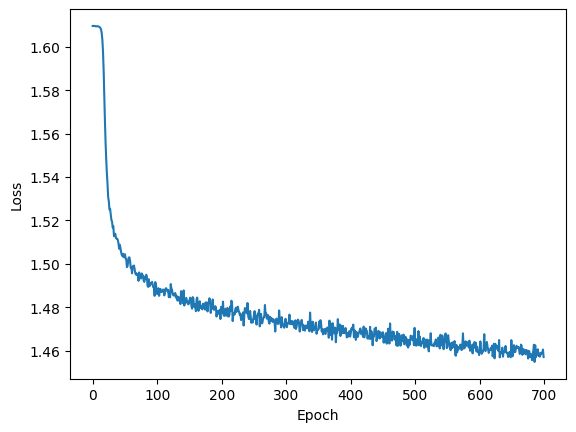

Test accuracy: 475.6369892473118
Accuracy: 0.4210752688172043
Precision: 0.4001673244126199
Recall: 0.41202492329901297
F1-score: 0.38063452173494233


Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.74      0.49       495
           1       0.69      0.75      0.72       472
           2       0.30      0.11      0.16       449
           3       0.29      0.22      0.25       463
           4       0.35      0.23      0.28       446

    accuracy                           0.42      2325
   macro avg       0.40      0.41      0.38      2325
weighted avg       0.40      0.42      0.39      2325

                    0           1           2           3           4  \
precision    0.368368    0.687259    0.302469    0.294618    0.348123   
recall       0.743434    0.754237    0.109131    0.224622    0.228700   
f1-score     0.492637    0.719192    0.160393    0.254902    0.276049   
support    495.000000  472.000000  449.00000

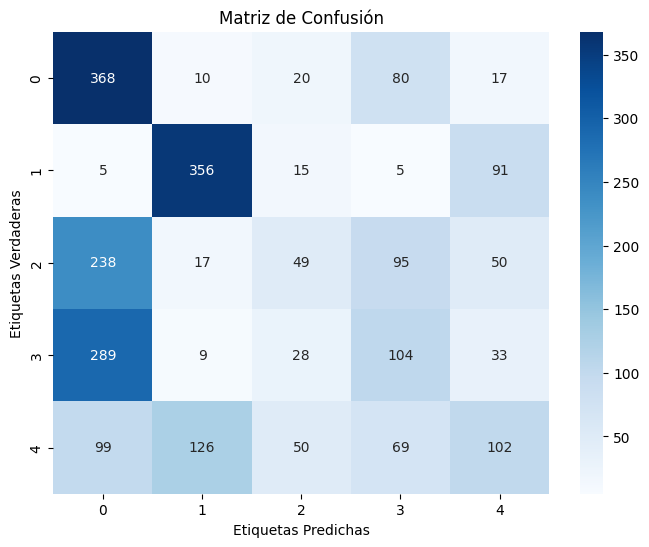

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_700_1e-05_0.1/resultados_700_1e-05_0.1.json
Procesando red con 1000 epocas y 0.0001 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas:   0%|                                                              | 1/1000 [00:01<29:16,  1.76s/it]

1.6094942233141731


Procesando epocas:   0%|                                                              | 2/1000 [00:03<29:15,  1.76s/it]

1.6095205910065595


Procesando epocas:   0%|▏                                                             | 3/1000 [00:05<29:10,  1.76s/it]

1.6094529776012196


Procesando epocas:   0%|▏                                                             | 4/1000 [00:07<29:11,  1.76s/it]

1.6094974566908444


Procesando epocas:   0%|▎                                                             | 5/1000 [00:08<29:11,  1.76s/it]

1.6092765373342177


Procesando epocas:   1%|▎                                                             | 6/1000 [00:10<29:07,  1.76s/it]

1.608393200004802


Procesando epocas:   1%|▍                                                             | 7/1000 [00:12<29:05,  1.76s/it]

1.5852105673621684


Procesando epocas:   1%|▍                                                             | 8/1000 [00:14<29:05,  1.76s/it]

1.5301221083192265


Procesando epocas:   1%|▌                                                             | 9/1000 [00:15<29:01,  1.76s/it]

1.5245843179085676


Procesando epocas:   1%|▌                                                            | 10/1000 [00:17<29:03,  1.76s/it]

1.5118758944904103


Procesando epocas:   1%|▋                                                            | 11/1000 [00:19<29:01,  1.76s/it]

1.5094841466230504


Procesando epocas:   1%|▋                                                            | 12/1000 [00:21<28:56,  1.76s/it]

1.5087059231365427


Procesando epocas:   1%|▊                                                            | 13/1000 [00:22<28:54,  1.76s/it]

1.5073410567115335


Procesando epocas:   1%|▊                                                            | 14/1000 [00:24<28:40,  1.74s/it]

1.5025019582580117


Procesando epocas:   2%|▉                                                            | 15/1000 [00:26<28:33,  1.74s/it]

1.5036553263664245


Procesando epocas:   2%|▉                                                            | 16/1000 [00:28<28:27,  1.74s/it]

1.503056270234725


Procesando epocas:   2%|█                                                            | 17/1000 [00:29<28:12,  1.72s/it]

1.502960333403419


Procesando epocas:   2%|█                                                            | 18/1000 [00:31<28:10,  1.72s/it]

1.4996040814063127


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:33<28:07,  1.72s/it]

1.500876820087433


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:34<28:07,  1.72s/it]

1.5011715047499712


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:36<28:07,  1.72s/it]

1.492585832231185


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:38<28:03,  1.72s/it]

1.494864601247451


Procesando epocas:   2%|█▍                                                           | 23/1000 [00:40<27:55,  1.72s/it]

1.4953900743933286


Procesando epocas:   2%|█▍                                                           | 24/1000 [00:41<27:52,  1.71s/it]

1.4937663435935975


Procesando epocas:   2%|█▌                                                           | 25/1000 [00:43<27:47,  1.71s/it]

1.4997536694302278


Procesando epocas:   3%|█▌                                                           | 26/1000 [00:45<27:41,  1.71s/it]

1.4942322191070108


Procesando epocas:   3%|█▋                                                           | 27/1000 [00:46<27:34,  1.70s/it]

1.4922038940822377


Procesando epocas:   3%|█▋                                                           | 28/1000 [00:48<27:35,  1.70s/it]

1.4950578177676481


Procesando epocas:   3%|█▊                                                           | 29/1000 [00:50<27:32,  1.70s/it]

1.4950515263220843


Procesando epocas:   3%|█▊                                                           | 30/1000 [00:51<27:32,  1.70s/it]

1.4920911087709314


Procesando epocas:   3%|█▉                                                           | 31/1000 [00:53<27:34,  1.71s/it]

1.4918488649760975


Procesando epocas:   3%|█▉                                                           | 32/1000 [00:55<27:29,  1.70s/it]

1.4933920481625724


Procesando epocas:   3%|██                                                           | 33/1000 [00:57<27:28,  1.70s/it]

1.4919144406038172


Procesando epocas:   3%|██                                                           | 34/1000 [00:58<27:25,  1.70s/it]

1.4887340734986698


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:00<27:24,  1.70s/it]

1.491499291448032


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:02<27:26,  1.71s/it]

1.4922879092833574


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:03<27:20,  1.70s/it]

1.4891292340615216


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:05<27:15,  1.70s/it]

1.4889586266349344


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:07<27:09,  1.70s/it]

1.4947382933953228


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:08<27:11,  1.70s/it]

1.4958569407463074


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:10<27:04,  1.69s/it]

1.4892444217906278


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:12<27:04,  1.70s/it]

1.493970641669105


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:14<27:07,  1.70s/it]

1.4885261682903066


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:15<27:01,  1.70s/it]

1.4983290672302245


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:17<27:02,  1.70s/it]

1.489961692164926


Procesando epocas:   5%|██▊                                                          | 46/1000 [01:19<27:02,  1.70s/it]

1.4871145781348734


Procesando epocas:   5%|██▊                                                          | 47/1000 [01:20<27:04,  1.70s/it]

1.4891573022393618


Procesando epocas:   5%|██▉                                                          | 48/1000 [01:22<27:06,  1.71s/it]

1.486226888965158


Procesando epocas:   5%|██▉                                                          | 49/1000 [01:24<27:07,  1.71s/it]

1.4893397723927218


Procesando epocas:   5%|███                                                          | 50/1000 [01:26<27:03,  1.71s/it]

1.4917926353566786


Procesando epocas:   5%|███                                                          | 51/1000 [01:27<26:59,  1.71s/it]

1.4883269092615914


Procesando epocas:   5%|███▏                                                         | 52/1000 [01:29<26:53,  1.70s/it]

1.4865692980149212


Procesando epocas:   5%|███▏                                                         | 53/1000 [01:31<26:44,  1.69s/it]

1.485051557596992


Procesando epocas:   5%|███▎                                                         | 54/1000 [01:32<26:44,  1.70s/it]

1.48202041387558


Procesando epocas:   6%|███▎                                                         | 55/1000 [01:34<26:44,  1.70s/it]

1.4873645501978257


Procesando epocas:   6%|███▍                                                         | 56/1000 [01:36<26:47,  1.70s/it]

1.4854322805124172


Procesando epocas:   6%|███▍                                                         | 57/1000 [01:37<26:44,  1.70s/it]

1.4856703148168675


Procesando epocas:   6%|███▌                                                         | 58/1000 [01:39<26:40,  1.70s/it]

1.4863812804222107


Procesando epocas:   6%|███▌                                                         | 59/1000 [01:41<26:37,  1.70s/it]

1.4823756736867568


Procesando epocas:   6%|███▋                                                         | 60/1000 [01:42<26:41,  1.70s/it]

1.4911681056022643


Procesando epocas:   6%|███▋                                                         | 61/1000 [01:44<26:38,  1.70s/it]

1.482269098478205


Procesando epocas:   6%|███▊                                                         | 62/1000 [01:46<26:33,  1.70s/it]

1.4925620906493242


Procesando epocas:   6%|███▊                                                         | 63/1000 [01:48<26:34,  1.70s/it]

1.4820144674357245


Procesando epocas:   6%|███▉                                                         | 64/1000 [01:49<26:35,  1.70s/it]

1.4837426171583288


Procesando epocas:   6%|███▉                                                         | 65/1000 [01:51<26:31,  1.70s/it]

1.4833865509313695


Procesando epocas:   7%|████                                                         | 66/1000 [01:53<26:28,  1.70s/it]

1.482912302017212


Procesando epocas:   7%|████                                                         | 67/1000 [01:54<26:20,  1.69s/it]

1.4832380890846253


Procesando epocas:   7%|████▏                                                        | 68/1000 [01:56<26:14,  1.69s/it]

1.4872462104348576


Procesando epocas:   7%|████▏                                                        | 69/1000 [01:58<26:10,  1.69s/it]

1.4818340918597053


Procesando epocas:   7%|████▎                                                        | 70/1000 [01:59<26:07,  1.69s/it]

1.486874081106747


Procesando epocas:   7%|████▎                                                        | 71/1000 [02:01<26:03,  1.68s/it]

1.4795160139308257


Procesando epocas:   7%|████▍                                                        | 72/1000 [02:03<26:02,  1.68s/it]

1.4809967230348027


Procesando epocas:   7%|████▍                                                        | 73/1000 [02:04<26:09,  1.69s/it]

1.4789793792892905


Procesando epocas:   7%|████▌                                                        | 74/1000 [02:06<26:08,  1.69s/it]

1.4885286611669204


Procesando epocas:   8%|████▌                                                        | 75/1000 [02:08<26:12,  1.70s/it]

1.4820684853722068


Procesando epocas:   8%|████▋                                                        | 76/1000 [02:10<26:07,  1.70s/it]

1.4801362668766695


Procesando epocas:   8%|████▋                                                        | 77/1000 [02:11<26:03,  1.69s/it]

1.483070914885577


Procesando epocas:   8%|████▊                                                        | 78/1000 [02:13<26:00,  1.69s/it]

1.480250187481151


Procesando epocas:   8%|████▊                                                        | 79/1000 [02:15<26:00,  1.69s/it]

1.4819411943940555


Procesando epocas:   8%|████▉                                                        | 80/1000 [02:16<25:55,  1.69s/it]

1.4832495556158178


Procesando epocas:   8%|████▉                                                        | 81/1000 [02:18<25:55,  1.69s/it]

1.4784294892759884


Procesando epocas:   8%|█████                                                        | 82/1000 [02:20<25:52,  1.69s/it]

1.481032560152166


Procesando epocas:   8%|█████                                                        | 83/1000 [02:21<25:51,  1.69s/it]

1.4807265295701868


Procesando epocas:   8%|█████                                                        | 84/1000 [02:23<25:50,  1.69s/it]

1.4818277632488923


Procesando epocas:   8%|█████▏                                                       | 85/1000 [02:25<25:46,  1.69s/it]

1.4786957207848044


Procesando epocas:   9%|█████▏                                                       | 86/1000 [02:27<25:47,  1.69s/it]

1.474313266838298


Procesando epocas:   9%|█████▎                                                       | 87/1000 [02:28<25:45,  1.69s/it]

1.4772597775739782


Procesando epocas:   9%|█████▎                                                       | 88/1000 [02:30<25:41,  1.69s/it]

1.4774644220576567


Procesando epocas:   9%|█████▍                                                       | 89/1000 [02:32<25:40,  1.69s/it]

1.4838730033706216


Procesando epocas:   9%|█████▍                                                       | 90/1000 [02:33<25:37,  1.69s/it]

1.47879741822972


Procesando epocas:   9%|█████▌                                                       | 91/1000 [02:35<25:38,  1.69s/it]

1.4775019098730648


Procesando epocas:   9%|█████▌                                                       | 92/1000 [02:37<25:34,  1.69s/it]

1.4741944221889272


Procesando epocas:   9%|█████▋                                                       | 93/1000 [02:38<25:31,  1.69s/it]

1.479893245416529


Procesando epocas:   9%|█████▋                                                       | 94/1000 [02:40<25:28,  1.69s/it]

1.4765506414806142


Procesando epocas:  10%|█████▊                                                       | 95/1000 [02:42<25:25,  1.69s/it]

1.4748769192134632


Procesando epocas:  10%|█████▊                                                       | 96/1000 [02:43<25:25,  1.69s/it]

1.472312953191645


Procesando epocas:  10%|█████▉                                                       | 97/1000 [02:45<25:24,  1.69s/it]

1.4757153581170475


Procesando epocas:  10%|█████▉                                                       | 98/1000 [02:47<25:23,  1.69s/it]

1.4739821616341087


Procesando epocas:  10%|██████                                                       | 99/1000 [02:48<25:22,  1.69s/it]

1.4776465394917657


Procesando epocas:  10%|██████                                                      | 100/1000 [02:50<25:19,  1.69s/it]

1.4781211327104007


Procesando epocas:  10%|██████                                                      | 101/1000 [02:52<25:21,  1.69s/it]

1.4755726674023797


Procesando epocas:  10%|██████                                                      | 102/1000 [02:54<25:21,  1.69s/it]

1.4708389029783362


Procesando epocas:  10%|██████▏                                                     | 103/1000 [02:55<25:20,  1.69s/it]

1.4686289142159854


Procesando epocas:  10%|██████▏                                                     | 104/1000 [02:57<25:20,  1.70s/it]

1.467103611020481


Procesando epocas:  10%|██████▎                                                     | 105/1000 [02:59<25:25,  1.70s/it]

1.467340429390178


Procesando epocas:  11%|██████▎                                                     | 106/1000 [03:00<25:33,  1.72s/it]

1.4699788935044233


Procesando epocas:  11%|██████▍                                                     | 107/1000 [03:02<25:41,  1.73s/it]

1.4649886292569778


Procesando epocas:  11%|██████▍                                                     | 108/1000 [03:04<25:45,  1.73s/it]

1.4694764536969802


Procesando epocas:  11%|██████▌                                                     | 109/1000 [03:06<25:49,  1.74s/it]

1.463206879531636


Procesando epocas:  11%|██████▌                                                     | 110/1000 [03:07<25:50,  1.74s/it]

1.4666841149330139


Procesando epocas:  11%|██████▋                                                     | 111/1000 [03:09<25:49,  1.74s/it]

1.4689221003476312


Procesando epocas:  11%|██████▋                                                     | 112/1000 [03:11<25:49,  1.75s/it]

1.4690497265142552


Procesando epocas:  11%|██████▊                                                     | 113/1000 [03:13<25:48,  1.75s/it]

1.4683911043054918


Procesando epocas:  11%|██████▊                                                     | 114/1000 [03:14<25:49,  1.75s/it]

1.4740436154253342


Procesando epocas:  12%|██████▉                                                     | 115/1000 [03:16<25:49,  1.75s/it]

1.4672570200527415


Procesando epocas:  12%|██████▉                                                     | 116/1000 [03:18<25:46,  1.75s/it]

1.4662271976470946


Procesando epocas:  12%|███████                                                     | 117/1000 [03:20<25:46,  1.75s/it]

1.4674228584065157


Procesando epocas:  12%|███████                                                     | 118/1000 [03:21<25:44,  1.75s/it]

1.4678958640379065


Procesando epocas:  12%|███████▏                                                    | 119/1000 [03:23<25:37,  1.75s/it]

1.4646892673829022


Procesando epocas:  12%|███████▏                                                    | 120/1000 [03:25<25:37,  1.75s/it]

1.469442569508272


Procesando epocas:  12%|███████▎                                                    | 121/1000 [03:27<25:31,  1.74s/it]

1.4637912049013027


Procesando epocas:  12%|███████▎                                                    | 122/1000 [03:28<25:27,  1.74s/it]

1.4669722725363339


Procesando epocas:  12%|███████▍                                                    | 123/1000 [03:30<25:22,  1.74s/it]

1.4644410708371332


Procesando epocas:  12%|███████▍                                                    | 124/1000 [03:32<25:13,  1.73s/it]

1.4643586817909688


Procesando epocas:  12%|███████▌                                                    | 125/1000 [03:34<25:11,  1.73s/it]

1.4676048180636239


Procesando epocas:  13%|███████▌                                                    | 126/1000 [03:35<25:08,  1.73s/it]

1.4645660870215471


Procesando epocas:  13%|███████▌                                                    | 127/1000 [03:37<25:05,  1.72s/it]

1.4620275637682747


Procesando epocas:  13%|███████▋                                                    | 128/1000 [03:39<25:01,  1.72s/it]

1.4604930085294388


Procesando epocas:  13%|███████▋                                                    | 129/1000 [03:40<24:56,  1.72s/it]

1.4628062753116384


Procesando epocas:  13%|███████▊                                                    | 130/1000 [03:42<24:55,  1.72s/it]

1.4683313257553998


Procesando epocas:  13%|███████▊                                                    | 131/1000 [03:44<25:00,  1.73s/it]

1.4604094526346991


Procesando epocas:  13%|███████▉                                                    | 132/1000 [03:46<24:59,  1.73s/it]

1.4611643475644729


Procesando epocas:  13%|███████▉                                                    | 133/1000 [03:47<24:55,  1.73s/it]

1.4653753014171824


Procesando epocas:  13%|████████                                                    | 134/1000 [03:49<24:52,  1.72s/it]

1.461103691073025


Procesando epocas:  14%|████████                                                    | 135/1000 [03:51<24:52,  1.73s/it]

1.4674114009913277


Procesando epocas:  14%|████████▏                                                   | 136/1000 [03:52<24:44,  1.72s/it]

1.4714483983376447


Procesando epocas:  14%|████████▏                                                   | 137/1000 [03:54<24:36,  1.71s/it]

1.4597922598614412


Procesando epocas:  14%|████████▎                                                   | 138/1000 [03:56<24:25,  1.70s/it]

1.467034643537858


Procesando epocas:  14%|████████▎                                                   | 139/1000 [03:58<24:22,  1.70s/it]

1.4700650285272037


Procesando epocas:  14%|████████▍                                                   | 140/1000 [03:59<24:19,  1.70s/it]

1.4628356365596547


Procesando epocas:  14%|████████▍                                                   | 141/1000 [04:01<24:12,  1.69s/it]

1.4694586473352769


Procesando epocas:  14%|████████▌                                                   | 142/1000 [04:03<24:06,  1.69s/it]

1.4678725060294657


Procesando epocas:  14%|████████▌                                                   | 143/1000 [04:04<24:03,  1.68s/it]

1.4628528349539813


Procesando epocas:  14%|████████▋                                                   | 144/1000 [04:06<23:56,  1.68s/it]

1.466102140791276


Procesando epocas:  14%|████████▋                                                   | 145/1000 [04:08<23:54,  1.68s/it]

1.4654439870048972


Procesando epocas:  15%|████████▊                                                   | 146/1000 [04:09<23:48,  1.67s/it]

1.4629386214648976


Procesando epocas:  15%|████████▊                                                   | 147/1000 [04:11<23:48,  1.67s/it]

1.4614552518900703


Procesando epocas:  15%|████████▉                                                   | 148/1000 [04:13<23:44,  1.67s/it]

1.459950627298916


Procesando epocas:  15%|████████▉                                                   | 149/1000 [04:14<23:45,  1.68s/it]

1.4605897615937626


Procesando epocas:  15%|█████████                                                   | 150/1000 [04:16<23:48,  1.68s/it]

1.453695943776299


Procesando epocas:  15%|█████████                                                   | 151/1000 [04:18<23:43,  1.68s/it]

1.4632573485374452


Procesando epocas:  15%|█████████                                                   | 152/1000 [04:19<23:44,  1.68s/it]

1.4595265248242546


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [04:21<23:42,  1.68s/it]

1.4730559005456811


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [04:23<23:40,  1.68s/it]

1.4549707966692307


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [04:24<23:40,  1.68s/it]

1.471206040242139


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [04:26<23:39,  1.68s/it]

1.4636095432674183


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [04:28<23:36,  1.68s/it]

1.4629304163596208


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [04:29<23:36,  1.68s/it]

1.4620666419758517


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [04:31<23:39,  1.69s/it]

1.463365967834697


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [04:33<23:36,  1.69s/it]

1.4625725739142474


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [04:34<23:37,  1.69s/it]

1.4747034682947047


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [04:36<23:36,  1.69s/it]

1.4578221257995156


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [04:38<23:31,  1.69s/it]

1.4577920226489796


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [04:40<23:24,  1.68s/it]

1.459531277067521


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [04:41<23:19,  1.68s/it]

1.4627374045989092


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [04:43<23:18,  1.68s/it]

1.464293745686026


Procesando epocas:  17%|██████████                                                  | 167/1000 [04:45<23:12,  1.67s/it]

1.4604016170782201


Procesando epocas:  17%|██████████                                                  | 168/1000 [04:46<23:08,  1.67s/it]

1.4585970934699564


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [04:48<23:05,  1.67s/it]

1.4537644196959103


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [04:50<23:04,  1.67s/it]

1.456507450692794


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [04:51<23:07,  1.67s/it]

1.4573364278849434


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [04:53<23:13,  1.68s/it]

1.455896191737231


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [04:55<23:14,  1.69s/it]

1.4648545096902286


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [04:56<23:15,  1.69s/it]

1.4614322613267337


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [04:58<23:16,  1.69s/it]

1.4563558964168324


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [05:00<23:16,  1.69s/it]

1.4614337058628306


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [05:01<23:19,  1.70s/it]

1.467384672164917


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [05:03<23:17,  1.70s/it]

1.4538488703615524


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [05:05<23:16,  1.70s/it]

1.4607119777623345


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [05:07<23:15,  1.70s/it]

1.4654277079245623


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [05:08<23:12,  1.70s/it]

1.4552355254397673


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [05:10<23:11,  1.70s/it]

1.4520076022428625


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [05:12<23:11,  1.70s/it]

1.4572184303227593


Procesando epocas:  18%|███████████                                                 | 184/1000 [05:13<23:12,  1.71s/it]

1.4578167298260858


Procesando epocas:  18%|███████████                                                 | 185/1000 [05:15<23:08,  1.70s/it]

1.4540566149879903


Procesando epocas:  19%|███████████▏                                                | 186/1000 [05:17<23:07,  1.70s/it]

1.456058145270628


Procesando epocas:  19%|███████████▏                                                | 187/1000 [05:18<23:04,  1.70s/it]

1.4547087823643403


Procesando epocas:  19%|███████████▎                                                | 188/1000 [05:20<23:04,  1.71s/it]

1.4566754810950335


Procesando epocas:  19%|███████████▎                                                | 189/1000 [05:22<23:05,  1.71s/it]

1.456479482791003


Procesando epocas:  19%|███████████▍                                                | 190/1000 [05:24<23:06,  1.71s/it]

1.454688640201793


Procesando epocas:  19%|███████████▍                                                | 191/1000 [05:25<23:02,  1.71s/it]

1.449916404836318


Procesando epocas:  19%|███████████▌                                                | 192/1000 [05:27<22:57,  1.71s/it]

1.4584487192771014


Procesando epocas:  19%|███████████▌                                                | 193/1000 [05:29<22:55,  1.70s/it]

1.4629672807805678


Procesando epocas:  19%|███████████▋                                                | 194/1000 [05:30<22:54,  1.70s/it]

1.452363078734454


Procesando epocas:  20%|███████████▋                                                | 195/1000 [05:32<22:49,  1.70s/it]

1.4525387658792384


Procesando epocas:  20%|███████████▊                                                | 196/1000 [05:34<22:45,  1.70s/it]

1.4671975808985094


Procesando epocas:  20%|███████████▊                                                | 197/1000 [05:35<22:44,  1.70s/it]

1.4570719480514527


Procesando epocas:  20%|███████████▉                                                | 198/1000 [05:37<22:42,  1.70s/it]

1.461665276218863


Procesando epocas:  20%|███████████▉                                                | 199/1000 [05:39<22:39,  1.70s/it]

1.4552056908607482


Procesando epocas:  20%|████████████                                                | 200/1000 [05:41<22:36,  1.70s/it]

1.4528725196333492


Procesando epocas:  20%|████████████                                                | 201/1000 [05:42<22:35,  1.70s/it]

1.4552899963715498


Procesando epocas:  20%|████████████                                                | 202/1000 [05:44<22:30,  1.69s/it]

1.4477989729712992


Procesando epocas:  20%|████████████▏                                               | 203/1000 [05:46<22:28,  1.69s/it]

1.4529416526065153


Procesando epocas:  20%|████████████▏                                               | 204/1000 [05:47<22:26,  1.69s/it]

1.4521249062874737


Procesando epocas:  20%|████████████▎                                               | 205/1000 [05:49<22:21,  1.69s/it]

1.4580041408538817


Procesando epocas:  21%|████████████▎                                               | 206/1000 [05:51<22:19,  1.69s/it]

1.4632294297218322


Procesando epocas:  21%|████████████▍                                               | 207/1000 [05:52<22:17,  1.69s/it]

1.452882317234488


Procesando epocas:  21%|████████████▍                                               | 208/1000 [05:54<22:16,  1.69s/it]

1.454410883959602


Procesando epocas:  21%|████████████▌                                               | 209/1000 [05:56<22:15,  1.69s/it]

1.4583515328519485


Procesando epocas:  21%|████████████▌                                               | 210/1000 [05:57<22:15,  1.69s/it]

1.452500330700594


Procesando epocas:  21%|████████████▋                                               | 211/1000 [05:59<22:13,  1.69s/it]

1.4593268941430484


Procesando epocas:  21%|████████████▋                                               | 212/1000 [06:01<22:10,  1.69s/it]

1.4539299305747537


Procesando epocas:  21%|████████████▊                                               | 213/1000 [06:03<22:09,  1.69s/it]

1.4540051116662867


Procesando epocas:  21%|████████████▊                                               | 214/1000 [06:04<22:07,  1.69s/it]

1.454953718886656


Procesando epocas:  22%|████████████▉                                               | 215/1000 [06:06<22:04,  1.69s/it]

1.4509986204259535


Procesando epocas:  22%|████████████▉                                               | 216/1000 [06:08<22:02,  1.69s/it]

1.4487018690389746


Procesando epocas:  22%|█████████████                                               | 217/1000 [06:09<21:57,  1.68s/it]

1.4504153083352482


Procesando epocas:  22%|█████████████                                               | 218/1000 [06:11<21:58,  1.69s/it]

1.4513461049865275


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [06:13<21:54,  1.68s/it]

1.4551991483744453


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [06:14<21:52,  1.68s/it]

1.4568095641977648


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [06:16<21:50,  1.68s/it]

1.4474475671263303


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [06:18<21:45,  1.68s/it]

1.4483900364707498


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [06:19<21:43,  1.68s/it]

1.4530117020887487


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [06:21<21:40,  1.68s/it]

1.458137339704177


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [06:23<21:37,  1.67s/it]

1.4521365600473741


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [06:24<21:47,  1.69s/it]

1.4509635679862078


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [06:26<22:01,  1.71s/it]

1.456452824087704


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [06:28<22:09,  1.72s/it]

1.4541717382038342


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [06:30<22:12,  1.73s/it]

1.4451024153653313


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [06:31<22:12,  1.73s/it]

1.466140531091129


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [06:33<22:12,  1.73s/it]

1.4519921835731058


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [06:35<22:15,  1.74s/it]

1.4527580113971934


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [06:37<22:14,  1.74s/it]

1.4543260286836064


Procesando epocas:  23%|██████████████                                              | 234/1000 [06:38<22:16,  1.74s/it]

1.4504881248754613


Procesando epocas:  24%|██████████████                                              | 235/1000 [06:40<22:15,  1.75s/it]

1.448328264320598


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [06:42<22:11,  1.74s/it]

1.4486554664724014


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [06:44<22:11,  1.74s/it]

1.4496797849150265


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [06:45<22:06,  1.74s/it]

1.4558274100808537


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [06:47<22:01,  1.74s/it]

1.4541306565789616


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [06:49<22:01,  1.74s/it]

1.455157812202678


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [06:51<22:02,  1.74s/it]

1.4527625378440407


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [06:52<22:01,  1.74s/it]

1.4450045627706192


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [06:54<21:57,  1.74s/it]

1.4473289552856894


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [06:56<21:58,  1.74s/it]

1.4503147987758411


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [06:58<21:54,  1.74s/it]

1.4557079855133506


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [06:59<21:52,  1.74s/it]

1.4477705731111414


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [07:01<21:52,  1.74s/it]

1.4466790094095119


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [07:03<21:49,  1.74s/it]

1.4517937148318572


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [07:04<21:47,  1.74s/it]

1.451237861549153


Procesando epocas:  25%|███████████████                                             | 250/1000 [07:06<21:48,  1.74s/it]

1.4516302585601806


Procesando epocas:  25%|███████████████                                             | 251/1000 [07:08<21:47,  1.75s/it]

1.450958459517535


Procesando epocas:  25%|███████████████                                             | 252/1000 [07:10<21:45,  1.74s/it]

1.4515364794170156


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [07:11<21:43,  1.74s/it]

1.4481900691986085


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [07:13<21:41,  1.74s/it]

1.448492607649635


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [07:15<21:37,  1.74s/it]

1.45022831734489


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [07:17<21:35,  1.74s/it]

1.450021029921139


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [07:18<21:29,  1.74s/it]

1.4493152933962206


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [07:20<21:21,  1.73s/it]

1.4476969270145192


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [07:22<21:16,  1.72s/it]

1.4481350485016318


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [07:24<21:07,  1.71s/it]

1.455167294249815


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [07:25<21:02,  1.71s/it]

1.4501840360024396


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [07:27<20:59,  1.71s/it]

1.4500273599344142


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [07:29<20:56,  1.71s/it]

1.4446089162546045


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [07:30<20:52,  1.70s/it]

1.44890838580973


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [07:32<20:50,  1.70s/it]

1.4453832275727216


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [07:34<20:50,  1.70s/it]

1.4441227218684027


Procesando epocas:  27%|████████████████                                            | 267/1000 [07:35<20:50,  1.71s/it]

1.4484895201290355


Procesando epocas:  27%|████████████████                                            | 268/1000 [07:37<20:49,  1.71s/it]

1.4488741860670202


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [07:39<20:50,  1.71s/it]

1.45192470480414


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [07:41<20:50,  1.71s/it]

1.4456563248353846


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [07:42<20:50,  1.71s/it]

1.448864526608411


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [07:44<20:47,  1.71s/it]

1.4476331142818226


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [07:46<20:47,  1.72s/it]

1.4447401130900663


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [07:47<20:45,  1.72s/it]

1.4495162585202386


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [07:49<20:44,  1.72s/it]

1.4531814035247355


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [07:51<20:42,  1.72s/it]

1.4529328886200399


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [07:53<20:39,  1.71s/it]

1.44856576498817


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [07:54<20:36,  1.71s/it]

1.448842100536122


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [07:56<20:34,  1.71s/it]

1.4462624669075013


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [07:58<20:34,  1.71s/it]

1.4509231567382812


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [07:59<20:34,  1.72s/it]

1.4444967599476084


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [08:01<20:33,  1.72s/it]

1.4491097849958083


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [08:03<20:31,  1.72s/it]

1.4456968763295341


Procesando epocas:  28%|█████████████████                                           | 284/1000 [08:05<20:31,  1.72s/it]

1.4494351274826947


Procesando epocas:  28%|█████████████████                                           | 285/1000 [08:06<20:27,  1.72s/it]

1.4475586701841916


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [08:08<20:23,  1.71s/it]

1.4496284765355727


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [08:10<20:19,  1.71s/it]

1.4485989444396075


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [08:11<20:15,  1.71s/it]

1.4422721806694478


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [08:13<20:12,  1.71s/it]

1.4474483055226943


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [08:15<20:10,  1.71s/it]

1.4480055416331572


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [08:17<20:07,  1.70s/it]

1.4518678335582509


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [08:18<20:05,  1.70s/it]

1.4476231196347404


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [08:20<20:04,  1.70s/it]

1.4456615286714891


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [08:22<20:02,  1.70s/it]

1.4408322741003599


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [08:23<20:02,  1.71s/it]

1.4425696197678062


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [08:25<20:01,  1.71s/it]

1.4440614840563606


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [08:27<19:58,  1.70s/it]

1.456301139382755


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [08:28<19:56,  1.70s/it]

1.4430537167717428


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [08:30<19:57,  1.71s/it]

1.445670784220976


Procesando epocas:  30%|██████████████████                                          | 300/1000 [08:32<19:56,  1.71s/it]

1.4490465262356926


Procesando epocas:  30%|██████████████████                                          | 301/1000 [08:34<19:52,  1.71s/it]

1.4560037774198196


Procesando epocas:  30%|██████████████████                                          | 302/1000 [08:35<19:48,  1.70s/it]

1.4462677899528953


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [08:37<19:48,  1.71s/it]

1.442297540692722


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [08:39<19:47,  1.71s/it]

1.4472268602427314


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [08:40<19:47,  1.71s/it]

1.4542810972999125


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [08:42<19:44,  1.71s/it]

1.4483802921631757


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [08:44<19:43,  1.71s/it]

1.4438864897279178


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [08:46<19:40,  1.71s/it]

1.4421784660395454


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [08:47<19:36,  1.70s/it]

1.4535977728226606


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [08:49<19:37,  1.71s/it]

1.4432618898503922


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [08:51<19:34,  1.70s/it]

1.447775380751666


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [08:52<19:34,  1.71s/it]

1.4462703354218427


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [08:54<19:29,  1.70s/it]

1.441827551056357


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [08:56<19:21,  1.69s/it]

1.4513123582391179


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [08:57<19:15,  1.69s/it]

1.4375024844618405


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [08:59<19:18,  1.69s/it]

1.4408549098407522


Procesando epocas:  32%|███████████████████                                         | 317/1000 [09:01<19:10,  1.69s/it]

1.4483553044936237


Procesando epocas:  32%|███████████████████                                         | 318/1000 [09:02<19:01,  1.67s/it]

1.446599067659939


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [09:04<18:53,  1.66s/it]

1.4419319903149324


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [09:06<18:45,  1.65s/it]

1.4446866645532497


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [09:07<18:44,  1.66s/it]

1.4458831134964438


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [09:09<18:40,  1.65s/it]

1.4670312327497146


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [09:11<18:41,  1.66s/it]

1.4449564029188717


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [09:12<18:44,  1.66s/it]

1.4470403832547805


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [09:14<18:53,  1.68s/it]

1.4481047658359303


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [09:16<18:56,  1.69s/it]

1.4457534123869504


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [09:17<19:01,  1.70s/it]

1.4411111502086416


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [09:19<18:59,  1.70s/it]

1.4381151290500864


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [09:21<18:51,  1.69s/it]

1.4460662519230563


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [09:23<18:43,  1.68s/it]

1.4504886290606331


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [09:24<18:35,  1.67s/it]

1.4427101331598617


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [09:26<18:30,  1.66s/it]

1.4416446033646078


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [09:27<18:34,  1.67s/it]

1.4487161573241738


Procesando epocas:  33%|████████████████████                                        | 334/1000 [09:29<18:34,  1.67s/it]

1.44846114691566


Procesando epocas:  34%|████████████████████                                        | 335/1000 [09:31<18:34,  1.68s/it]

1.4423386889345506


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [09:32<18:24,  1.66s/it]

1.443983574474559


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [09:34<18:22,  1.66s/it]

1.4403325115933139


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [09:36<18:15,  1.65s/it]

1.4410213708877564


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [09:37<18:10,  1.65s/it]

1.4445596218109131


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [09:39<18:06,  1.65s/it]

1.4440804930294262


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [09:41<18:04,  1.65s/it]

1.4385576542686014


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [09:42<18:03,  1.65s/it]

1.4383095713222729


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [09:44<18:09,  1.66s/it]

1.4421771358041202


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [09:46<18:11,  1.66s/it]

1.4434324860572816


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [09:47<18:12,  1.67s/it]

1.4415765474824345


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [09:49<18:03,  1.66s/it]

1.4423091902452356


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [09:51<18:03,  1.66s/it]

1.4388009414953344


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [09:52<18:14,  1.68s/it]

1.437572388789233


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [09:54<18:21,  1.69s/it]

1.4455899967866785


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [09:56<18:29,  1.71s/it]

1.4496362447738647


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [09:58<18:30,  1.71s/it]

1.439805690681233


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [09:59<18:28,  1.71s/it]

1.4427789134137772


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [10:01<18:27,  1.71s/it]

1.4514907282941483


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [10:03<18:29,  1.72s/it]

1.442398897339316


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [10:04<18:31,  1.72s/it]

1.4395984067636378


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [10:06<18:32,  1.73s/it]

1.4363368335892173


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [10:08<18:32,  1.73s/it]

1.4405152748612797


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [10:10<18:38,  1.74s/it]

1.4392939876107609


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [10:12<18:48,  1.76s/it]

1.4401994866483352


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [10:13<18:41,  1.75s/it]

1.4383247719091528


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [10:15<18:37,  1.75s/it]

1.4388327149783864


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [10:17<18:33,  1.75s/it]

1.4410847313263837


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [10:19<18:33,  1.75s/it]

1.4409744886791005


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [10:20<18:50,  1.78s/it]

1.443375893901376


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [10:22<19:02,  1.80s/it]

1.4391565694528468


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [10:24<19:04,  1.80s/it]

1.4466380925739513


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [10:26<19:10,  1.82s/it]

1.4405068117029527


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [10:28<19:10,  1.82s/it]

1.4476840124410741


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [10:30<19:09,  1.82s/it]

1.436568417969872


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [10:31<19:00,  1.81s/it]

1.4348698349560007


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [10:33<18:51,  1.80s/it]

1.4355980894144844


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [10:35<18:42,  1.79s/it]

1.4406187541344586


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [10:37<18:37,  1.78s/it]

1.4454673262203441


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [10:38<18:41,  1.79s/it]

1.4369096896227669


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [10:40<18:44,  1.80s/it]

1.4391426850767697


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [10:42<18:43,  1.80s/it]

1.4383485450464137


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [10:44<18:40,  1.80s/it]

1.4369538454448476


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [10:46<18:28,  1.78s/it]

1.4417632039855508


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [10:47<18:18,  1.77s/it]

1.437542486892027


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [10:49<18:09,  1.76s/it]

1.4407729240024791


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [10:51<18:03,  1.75s/it]

1.4377982083488914


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [10:53<17:57,  1.74s/it]

1.4393599909894608


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [10:54<17:52,  1.74s/it]

1.4385267264702741


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [10:56<17:48,  1.73s/it]

1.4449963948305915


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [10:58<17:45,  1.73s/it]

1.4362858120132895


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [10:59<17:43,  1.73s/it]

1.438386368751526


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [11:01<17:41,  1.73s/it]

1.436663812048295


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [11:03<17:38,  1.73s/it]

1.43596708984936


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [11:05<17:33,  1.72s/it]

1.4364343608126922


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [11:06<17:32,  1.73s/it]

1.4351992901633768


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [11:08<17:30,  1.72s/it]

1.4415969841620502


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [11:10<17:29,  1.73s/it]

1.441237113756292


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [11:11<17:25,  1.72s/it]

1.4412667491856743


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [11:13<17:23,  1.72s/it]

1.4380573868751525


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [11:15<17:21,  1.72s/it]

1.4381826569052303


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [11:17<17:19,  1.72s/it]

1.4416509747505188


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [11:18<17:18,  1.72s/it]

1.452332567467409


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [11:20<17:21,  1.73s/it]

1.4369752834824954


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [11:22<17:18,  1.73s/it]

1.440132500143612


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [11:24<17:17,  1.73s/it]

1.434520460577572


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [11:25<17:12,  1.72s/it]

1.4394890729118797


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [11:27<17:13,  1.73s/it]

1.441371580432443


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [11:29<17:12,  1.73s/it]

1.4395888531909269


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [11:30<17:09,  1.73s/it]

1.4418474001042982


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [11:32<17:05,  1.72s/it]

1.4340502921272726


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [11:34<16:56,  1.71s/it]

1.4427811524447274


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [11:36<16:53,  1.71s/it]

1.4428258496172288


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [11:37<16:48,  1.70s/it]

1.4379818397409776


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [11:39<16:42,  1.70s/it]

1.4348354662165923


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [11:41<16:37,  1.69s/it]

1.439060554784887


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [11:42<16:34,  1.69s/it]

1.4417013974750743


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [11:44<16:31,  1.69s/it]

1.446152114868164


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [11:46<16:30,  1.69s/it]

1.4361803812139176


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [11:47<16:28,  1.69s/it]

1.4378162938005783


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [11:49<16:24,  1.68s/it]

1.4366500286494985


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [11:51<16:21,  1.68s/it]

1.4360084225149716


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [11:52<16:17,  1.68s/it]

1.4396391524988061


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [11:54<16:17,  1.68s/it]

1.4318979859352112


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [11:56<16:18,  1.68s/it]

1.4372662340893465


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [11:57<16:16,  1.68s/it]

1.4423670369036057


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [11:59<16:16,  1.69s/it]

1.4341931237893946


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [12:01<16:15,  1.69s/it]

1.4358174948131337


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [12:03<16:16,  1.69s/it]

1.4390147103982813


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [12:04<16:14,  1.69s/it]

1.4485078937867109


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [12:06<16:10,  1.69s/it]

1.4333719470921684


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [12:08<16:07,  1.69s/it]

1.435809394191293


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [12:09<16:04,  1.68s/it]

1.4341167148421792


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [12:11<16:06,  1.69s/it]

1.4422092697199653


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [12:13<16:08,  1.70s/it]

1.439715008174672


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [12:14<16:05,  1.69s/it]

1.4315113144762375


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [12:16<16:07,  1.70s/it]

1.4406616182888254


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [12:18<16:08,  1.71s/it]

1.4367331553907956


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [12:20<16:11,  1.71s/it]

1.4392186873099384


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [12:21<16:14,  1.72s/it]

1.4315849507556242


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [12:23<16:14,  1.72s/it]

1.4449395123650046


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [12:25<16:14,  1.73s/it]

1.4357401714605444


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [12:26<16:11,  1.73s/it]

1.4363328975789686


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [12:28<16:12,  1.73s/it]

1.4326544558300691


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [12:30<16:31,  1.77s/it]

1.4330649432014018


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [12:32<16:22,  1.76s/it]

1.4324244464144986


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [12:34<16:17,  1.75s/it]

1.4331262251910042


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [12:35<16:10,  1.74s/it]

1.4378303843386033


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [12:37<16:11,  1.74s/it]

1.4330563369919271


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [12:39<16:08,  1.74s/it]

1.4385394867728738


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [12:40<16:00,  1.73s/it]

1.434000898809994


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [12:42<15:55,  1.73s/it]

1.4424126071088454


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [12:44<15:50,  1.72s/it]

1.4326593910946566


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [12:46<15:44,  1.71s/it]

1.436906227644752


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [12:47<15:40,  1.71s/it]

1.431381039759692


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [12:49<15:41,  1.71s/it]

1.4377018809318542


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [12:51<15:39,  1.71s/it]

1.4380102410035975


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [12:52<15:34,  1.71s/it]

1.437489695408765


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [12:54<15:31,  1.70s/it]

1.4361881136894226


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [12:56<15:29,  1.70s/it]

1.4344673710710862


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [12:57<15:27,  1.70s/it]

1.4398229157223421


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [12:59<15:26,  1.70s/it]

1.4437377985785989


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [13:01<15:24,  1.70s/it]

1.4355885049876045


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [13:03<15:25,  1.71s/it]

1.4364167199415319


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [13:04<15:26,  1.71s/it]

1.433155473540811


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [13:06<15:27,  1.72s/it]

1.4341970997698166


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [13:08<15:23,  1.71s/it]

1.4442313004942502


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [13:09<15:23,  1.72s/it]

1.4358926450504976


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [13:11<15:25,  1.72s/it]

1.4397258534150965


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [13:13<15:26,  1.73s/it]

1.4299534783643835


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [13:15<15:26,  1.73s/it]

1.4404160127920262


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [13:16<15:25,  1.73s/it]

1.4362235132385703


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [13:18<15:23,  1.73s/it]

1.433883395615746


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [13:20<15:26,  1.74s/it]

1.4315167188644409


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [13:22<15:36,  1.76s/it]

1.435908854708952


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [13:24<15:38,  1.77s/it]

1.4322494492811315


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [13:25<15:38,  1.77s/it]

1.4321993365007288


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [13:27<15:39,  1.78s/it]

1.4324547683491426


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [13:29<15:39,  1.78s/it]

1.428816039421979


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [13:31<15:40,  1.79s/it]

1.4390536322313197


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [13:32<15:38,  1.79s/it]

1.4431265108725604


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [13:34<15:38,  1.79s/it]

1.433518026155584


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [13:36<15:38,  1.79s/it]

1.4375563944087308


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [13:38<15:38,  1.80s/it]

1.4397440496612997


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [13:40<15:31,  1.79s/it]

1.4395096554475673


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [13:41<15:28,  1.79s/it]

1.4343299900784212


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [13:43<15:25,  1.78s/it]

1.4350369607701021


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [13:45<15:21,  1.78s/it]

1.4310008154195897


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [13:47<15:18,  1.78s/it]

1.4401468858999364


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [13:49<15:51,  1.84s/it]

1.4358084945117726


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [13:51<15:44,  1.83s/it]

1.4333632819792803


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [13:52<15:43,  1.84s/it]

1.4341047357110417


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [13:54<15:44,  1.84s/it]

1.4381132441408493


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [13:56<15:41,  1.84s/it]

1.4326679937979754


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [13:58<15:40,  1.84s/it]

1.4333460702615626


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [14:00<15:47,  1.86s/it]

1.4464378546265995


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [14:02<15:44,  1.85s/it]

1.4344663500785828


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [14:03<15:30,  1.83s/it]

1.4325211083187777


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [14:05<15:27,  1.83s/it]

1.437935100583469


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [14:07<15:19,  1.82s/it]

1.4332403365303488


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [14:09<15:11,  1.80s/it]

1.4324209164170658


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [14:11<15:08,  1.80s/it]

1.4330011991893543


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [14:12<15:05,  1.80s/it]

1.4336514325702892


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [14:14<15:04,  1.80s/it]

1.4356526213533738


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [14:16<15:00,  1.80s/it]

1.4308196755016551


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [14:18<14:53,  1.79s/it]

1.443467580570894


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [14:20<14:53,  1.79s/it]

1.4339765296262854


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [14:21<14:49,  1.79s/it]

1.4318103110089022


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [14:23<14:43,  1.78s/it]

1.4329159238759208


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [14:25<14:38,  1.77s/it]

1.4309248587664436


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [14:27<14:34,  1.77s/it]

1.4279052082230064


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [14:28<14:28,  1.76s/it]

1.433439972120173


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [14:30<14:27,  1.76s/it]

1.433182759845958


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [14:32<14:27,  1.76s/it]

1.4332517616889056


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [14:34<14:24,  1.76s/it]

1.4327737682005939


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [14:35<14:27,  1.77s/it]

1.4346028489225051


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [14:38<15:39,  1.92s/it]

1.4321002090678496


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [14:40<16:57,  2.09s/it]

1.4439713085398955


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [14:43<17:54,  2.21s/it]

1.4318122421993928


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [14:45<18:40,  2.31s/it]

1.4279314763405744


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [14:48<19:05,  2.36s/it]

1.4270593643188476


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [14:50<19:29,  2.42s/it]

1.4280566096305847


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [14:52<18:15,  2.27s/it]

1.4267510778763715


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [14:54<17:22,  2.16s/it]

1.4331815965035382


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [14:56<16:44,  2.09s/it]

1.4300390208468718


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [14:58<16:11,  2.02s/it]

1.4287041523877313


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [15:00<15:37,  1.96s/it]

1.441749163234935


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [15:01<15:07,  1.90s/it]

1.429958535643185


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [15:03<14:47,  1.86s/it]

1.4325831960229312


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [15:05<14:33,  1.84s/it]

1.4344145368127261


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [15:07<14:23,  1.82s/it]

1.4327082023901099


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [15:09<14:19,  1.81s/it]

1.4376415960928972


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [15:10<14:10,  1.80s/it]

1.427645871218513


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [15:13<15:21,  1.95s/it]

1.4297288915690254


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [15:15<16:17,  2.07s/it]

1.4282221604796017


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [15:17<16:49,  2.15s/it]

1.430901387158562


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [15:20<17:13,  2.20s/it]

1.4342098832130432


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [15:22<17:30,  2.25s/it]

1.4292610792552725


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [15:24<17:36,  2.26s/it]

1.43233764592339


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [15:27<17:37,  2.27s/it]

1.4281367834876566


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [15:29<17:31,  2.26s/it]

1.4276231352020712


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [15:31<17:26,  2.25s/it]

1.435156860772301


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [15:33<17:14,  2.23s/it]

1.4328841118251576


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [15:35<17:01,  2.21s/it]

1.4286766739452585


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [15:38<16:45,  2.18s/it]

1.432329742347493


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [15:40<16:39,  2.17s/it]

1.4256669402122497


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [15:42<16:22,  2.14s/it]

1.4278493081822115


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [15:44<16:24,  2.15s/it]

1.4362788172329173


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [15:46<16:22,  2.15s/it]

1.4346944935181563


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [15:48<16:15,  2.14s/it]

1.4354964648976045


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [15:50<16:17,  2.15s/it]

1.4367492058697868


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [15:53<16:23,  2.17s/it]

1.429935457425959


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [15:55<16:28,  2.18s/it]

1.428307592868805


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [15:57<16:34,  2.20s/it]

1.4365685133373036


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [15:59<16:29,  2.19s/it]

1.429558576555813


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [16:01<16:31,  2.20s/it]

1.4299365836031297


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [16:04<16:35,  2.22s/it]

1.430853990947499


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [16:06<16:45,  2.24s/it]

1.428025496006012


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [16:08<16:50,  2.26s/it]

1.4389266126296099


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [16:11<16:44,  2.25s/it]

1.4284169049823985


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [16:13<16:30,  2.23s/it]

1.426269782290739


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [16:15<16:17,  2.20s/it]

1.4320119486135594


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [16:17<16:15,  2.20s/it]

1.427763295173645


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [16:19<16:16,  2.21s/it]

1.4294242802788228


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [16:21<16:12,  2.21s/it]

1.4310612748650944


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [16:24<16:17,  2.22s/it]

1.4298816898289848


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [16:26<16:18,  2.23s/it]

1.4282028065008276


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [16:28<16:16,  2.23s/it]

1.4308867082876318


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [16:30<16:11,  2.22s/it]

1.4291592738207648


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [16:33<15:57,  2.20s/it]

1.4277094097698435


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [16:35<15:43,  2.17s/it]

1.429468656988705


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [16:37<15:35,  2.16s/it]

1.4314448286505306


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [16:39<15:32,  2.15s/it]

1.42740359025843


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [16:41<15:29,  2.15s/it]

1.4266610776676851


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [16:43<15:18,  2.13s/it]

1.4360231217216044


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [16:45<15:10,  2.12s/it]

1.4277781816089854


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [16:47<15:05,  2.11s/it]

1.4352184632245233


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [16:50<15:16,  2.14s/it]

1.4268089560901418


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [16:52<15:11,  2.13s/it]

1.4404350996017456


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [16:54<15:01,  2.12s/it]

1.433546209335327


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [16:56<14:51,  2.10s/it]

1.426807872688069


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [16:58<14:41,  2.08s/it]

1.4341663199312547


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [17:00<14:39,  2.08s/it]

1.4265630147036383


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [17:02<15:00,  2.13s/it]

1.4301923864028032


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [17:04<14:58,  2.13s/it]

1.427729508456062


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [17:06<14:56,  2.13s/it]

1.4249010955586152


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [17:09<14:50,  2.13s/it]

1.4309559997390298


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [17:11<14:42,  2.11s/it]

1.4262883256463443


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [17:13<14:36,  2.10s/it]

1.4236683515941395


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [17:15<14:25,  2.08s/it]

1.4270582977463218


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [17:17<14:16,  2.06s/it]

1.4283757343011745


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [17:19<14:11,  2.06s/it]

1.4364987366339739


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [17:21<14:04,  2.04s/it]

1.424469939400168


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [17:23<14:05,  2.05s/it]

1.4280935042044696


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [17:25<14:05,  2.06s/it]

1.428067550939672


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [17:27<14:07,  2.07s/it]

1.4315752660526948


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [17:29<14:09,  2.08s/it]

1.4338478796622331


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [17:31<14:18,  2.10s/it]

1.4241440212025362


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [17:33<14:26,  2.13s/it]

1.426877102431129


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [17:36<14:26,  2.14s/it]

1.4229882632984834


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [17:38<14:25,  2.14s/it]

1.4292204527293935


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [17:40<14:26,  2.14s/it]

1.4283616402569939


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [17:42<14:47,  2.20s/it]

1.4272267453810747


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [17:45<14:59,  2.24s/it]

1.4241282245692084


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [17:47<14:52,  2.22s/it]

1.4272534861284143


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [17:49<14:58,  2.25s/it]

1.4289881061105167


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [17:51<15:04,  2.27s/it]

1.4336262752028073


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [17:54<14:59,  2.26s/it]

1.429742254229153


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [17:56<14:55,  2.26s/it]

1.432055950164795


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [17:58<14:46,  2.24s/it]

1.427112517637365


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [18:00<14:37,  2.22s/it]

1.4235689773279079


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [18:02<14:28,  2.20s/it]

1.428178285851198


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [18:05<14:19,  2.19s/it]

1.4298936878933626


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [18:07<14:06,  2.16s/it]

1.4242667738129111


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [18:09<13:59,  2.15s/it]

1.4256394393303815


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [18:11<14:03,  2.16s/it]

1.4204949484151952


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [18:13<14:09,  2.18s/it]

1.4270885698935565


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [18:15<14:09,  2.19s/it]

1.4271076013060178


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [18:18<14:00,  2.17s/it]

1.4235589630463543


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [18:20<13:52,  2.16s/it]

1.4301461472230799


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [18:22<13:47,  2.15s/it]

1.425886283902561


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [18:24<13:53,  2.17s/it]

1.4206282643710866


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [18:26<13:43,  2.15s/it]

1.4284818628255058


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [18:28<13:51,  2.18s/it]

1.432795659233542


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [18:31<14:01,  2.21s/it]

1.426213411022635


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [18:33<14:02,  2.22s/it]

1.4272374412592719


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [18:35<14:08,  2.24s/it]

1.4213907774756938


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [18:37<14:01,  2.23s/it]

1.427675535398371


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [18:40<13:48,  2.20s/it]

1.432933320718653


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [18:42<13:40,  2.18s/it]

1.4280828630222995


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [18:44<13:32,  2.17s/it]

1.4237424373626708


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [18:46<13:16,  2.13s/it]

1.431704110257766


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [18:48<12:40,  2.04s/it]

1.4285402199801276


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [18:49<12:12,  1.97s/it]

1.421575366048252


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [18:51<11:52,  1.92s/it]

1.4227336406707765


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [18:53<11:37,  1.88s/it]

1.4228894142543569


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [18:55<11:29,  1.87s/it]

1.4277935161310085


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [18:57<11:22,  1.85s/it]

1.429024039296543


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [18:59<11:17,  1.85s/it]

1.426906773623298


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [19:00<11:08,  1.83s/it]

1.426427642738118


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [19:02<11:01,  1.81s/it]

1.4301551454207477


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [19:04<11:11,  1.84s/it]

1.4279003311606016


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [19:06<11:30,  1.90s/it]

1.4239760139409234


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [19:08<11:49,  1.96s/it]

1.427518886678359


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [19:10<12:03,  2.00s/it]

1.4258048050543841


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [19:12<12:09,  2.03s/it]

1.4287012268515193


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [19:14<12:12,  2.04s/it]

1.4294757401241975


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [19:16<12:12,  2.05s/it]

1.427343085232903


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [19:19<12:14,  2.06s/it]

1.4222371795598199


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [19:21<12:11,  2.06s/it]

1.4233028790530036


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [19:23<12:06,  2.05s/it]

1.4232614229707157


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [19:25<12:10,  2.06s/it]

1.4232866448514603


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [19:27<12:14,  2.08s/it]

1.4185137818841373


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [19:29<12:11,  2.08s/it]

1.4224402708165786


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [19:31<12:11,  2.08s/it]

1.4343030915540806


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [19:33<12:06,  2.08s/it]

1.4224205248496111


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [19:35<11:59,  2.06s/it]

1.4188782565733966


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [19:37<12:00,  2.07s/it]

1.4291737591519076


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [19:39<12:02,  2.08s/it]

1.4245241242296556


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [19:41<12:09,  2.11s/it]

1.4232584567630993


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [19:44<12:13,  2.13s/it]

1.4255764645688673


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [19:46<12:06,  2.11s/it]

1.4293751674539903


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [19:48<12:02,  2.11s/it]

1.4226377290837906


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [19:50<12:01,  2.11s/it]

1.4265620273702284


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [19:52<11:57,  2.10s/it]

1.4234813956653372


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [19:54<11:55,  2.11s/it]

1.4249064256163204


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [19:56<11:56,  2.11s/it]

1.4253061890602112


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [19:58<11:53,  2.11s/it]

1.428824482945835


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [20:00<11:51,  2.11s/it]

1.424922489418703


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [20:03<11:49,  2.11s/it]

1.4211060706306906


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [20:05<11:45,  2.11s/it]

1.4251852771815132


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [20:07<11:41,  2.10s/it]

1.424251475754906


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [20:09<11:40,  2.10s/it]

1.4356108041370617


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [20:11<11:39,  2.11s/it]

1.4203581045655642


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [20:13<11:37,  2.11s/it]

1.4198492758414325


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [20:15<11:34,  2.10s/it]

1.4215338910327238


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [20:17<11:36,  2.12s/it]

1.4288228974622839


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [20:20<11:50,  2.17s/it]

1.420666077557732


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [20:22<11:55,  2.19s/it]

1.4238122182733872


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [20:24<12:31,  2.30s/it]

1.4238078033222872


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [20:27<12:53,  2.38s/it]

1.4234454912297867


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [20:30<13:04,  2.42s/it]

1.4194858880604015


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [20:32<13:13,  2.46s/it]

1.4335148082059972


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [20:35<13:18,  2.48s/it]

1.4196331052219167


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [20:37<13:13,  2.47s/it]

1.4178015007692224


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [20:40<13:12,  2.48s/it]

1.4188921206137712


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [20:42<13:21,  2.51s/it]

1.4262981744373546


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [20:45<13:22,  2.52s/it]

1.428781411227058


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [20:47<13:16,  2.51s/it]

1.4210389494895934


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [20:50<13:09,  2.50s/it]

1.4204177176251132


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [20:52<12:46,  2.43s/it]

1.420741215874167


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [20:54<12:13,  2.34s/it]

1.4271498238339144


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [20:56<11:51,  2.27s/it]

1.431589259820826


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [20:58<11:32,  2.22s/it]

1.4216818837558522


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [21:00<11:19,  2.18s/it]

1.4197591816677766


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [21:02<11:11,  2.17s/it]

1.4287486476056717


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [21:05<11:05,  2.15s/it]

1.421459522668053


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [21:07<10:58,  2.14s/it]

1.419308883302352


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [21:09<10:51,  2.12s/it]

1.4253330875845516


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [21:11<10:45,  2.11s/it]

1.4174729641746073


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [21:13<10:43,  2.11s/it]

1.4241846280939439


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [21:15<10:41,  2.11s/it]

1.4255853260264677


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [21:17<10:37,  2.10s/it]

1.4243442240883322


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [21:19<10:32,  2.09s/it]

1.4304407547501956


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [21:21<10:22,  2.07s/it]

1.4184603564879474


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [21:23<10:13,  2.05s/it]

1.4186698640094084


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [21:25<10:03,  2.02s/it]

1.4185309879920063


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [21:27<09:56,  2.00s/it]

1.4208640098571776


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [21:29<09:54,  2.00s/it]

1.4160806263194365


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [21:31<10:06,  2.05s/it]

1.4256687052109662


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [21:33<10:04,  2.05s/it]

1.4158508819692275


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [21:35<10:00,  2.04s/it]

1.4191492746858037


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [21:37<09:58,  2.04s/it]

1.4217658042907715


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [21:40<09:56,  2.04s/it]

1.4197641071151286


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [21:42<09:57,  2.05s/it]

1.4295146822929383


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [21:44<10:02,  2.08s/it]

1.4196608241866617


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [21:46<10:04,  2.09s/it]

1.4181671878870796


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [21:48<10:06,  2.11s/it]

1.4230851986828972


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [21:50<10:03,  2.10s/it]

1.4145085159470052


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [21:52<10:02,  2.11s/it]

1.4179573038045097


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [21:54<10:01,  2.11s/it]

1.426297614854925


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [21:56<10:02,  2.12s/it]

1.419988598543055


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [21:59<10:00,  2.12s/it]

1.4131156185094047


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [22:01<09:54,  2.11s/it]

1.4179260646595675


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [22:03<09:48,  2.09s/it]

1.4257481883553897


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [22:05<09:47,  2.10s/it]

1.4201247306431042


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [22:07<09:46,  2.10s/it]

1.4153491062276504


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [22:09<09:45,  2.11s/it]

1.418069601760191


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [22:11<09:43,  2.11s/it]

1.4171140299123877


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [22:13<09:42,  2.11s/it]

1.4258580249898574


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [22:15<09:39,  2.11s/it]

1.423211346654331


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [22:17<09:37,  2.11s/it]

1.4188895898706773


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [22:20<09:33,  2.10s/it]

1.4166013963082258


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [22:22<09:28,  2.09s/it]

1.4141998774865094


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [22:24<09:16,  2.05s/it]

1.421772618854747


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [22:25<08:54,  1.98s/it]

1.4227387021569644


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [22:27<08:37,  1.92s/it]

1.41914022880442


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [22:29<08:45,  1.96s/it]

1.4205729421447306


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [22:31<08:53,  2.00s/it]

1.4212507661651164


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [22:33<08:52,  2.00s/it]

1.417974657872144


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [22:35<08:50,  2.00s/it]

1.4190421672428355


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [22:37<08:50,  2.01s/it]

1.424212268520804


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [22:39<08:49,  2.01s/it]

1.4284664504668292


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [22:41<08:50,  2.02s/it]

1.427566141240737


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [22:43<08:45,  2.01s/it]

1.418286719041712


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [22:45<08:41,  2.01s/it]

1.4160385180922115


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [22:47<08:38,  2.00s/it]

1.4213559894000782


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [22:49<08:36,  2.00s/it]

1.4231496277977438


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [22:52<08:47,  2.05s/it]

1.418761920928955


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [22:54<08:49,  2.07s/it]

1.4177113673266242


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [22:56<08:43,  2.05s/it]

1.4195430713541368


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [22:58<08:40,  2.05s/it]

1.4148332273258883


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [23:00<08:36,  2.04s/it]

1.4196480779086842


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [23:02<08:30,  2.02s/it]

1.4178752583615921


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [23:04<08:31,  2.04s/it]

1.42230867357815


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [23:06<08:40,  2.08s/it]

1.4196546470417697


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [23:08<08:39,  2.09s/it]

1.4150799646097072


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [23:10<08:36,  2.08s/it]

1.411842661745408


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [23:12<08:36,  2.09s/it]

1.415623744796304


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [23:14<08:37,  2.10s/it]

1.4183236108106725


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [23:17<08:35,  2.11s/it]

1.4258232909090378


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [23:19<08:36,  2.12s/it]

1.4247900219524607


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [23:21<08:36,  2.13s/it]

1.4198674833073335


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [23:23<08:38,  2.14s/it]

1.4204934968667873


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [23:25<08:39,  2.16s/it]

1.420677802843206


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [23:27<08:36,  2.15s/it]

1.4286020818878622


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [23:30<08:35,  2.16s/it]

1.4268847949364607


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [23:32<08:33,  2.16s/it]

1.4240739163230447


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [23:34<08:29,  2.15s/it]

1.414758580572465


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [23:36<08:25,  2.14s/it]

1.429798442475936


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [23:38<08:23,  2.14s/it]

1.415597645675435


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [23:40<08:23,  2.15s/it]

1.4175606320886052


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [23:42<08:22,  2.16s/it]

1.4133126483244054


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [23:45<08:20,  2.16s/it]

1.4191524183048922


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [23:47<08:15,  2.15s/it]

1.423510883134954


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [23:49<08:08,  2.13s/it]

1.4124350049916437


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [23:51<07:41,  2.02s/it]

1.4145090040038615


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [23:52<07:19,  1.93s/it]

1.4195004652528203


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [23:54<07:06,  1.88s/it]

1.4230802564059988


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [23:56<06:55,  1.84s/it]

1.4160885362064137


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [23:58<06:49,  1.82s/it]

1.4191616149509654


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [23:59<06:46,  1.81s/it]

1.4240631489192739


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [24:01<06:40,  1.80s/it]

1.4190711463198942


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [24:03<06:34,  1.78s/it]

1.4150282095460331


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [24:05<06:30,  1.77s/it]

1.4156727783820209


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [24:06<06:27,  1.76s/it]

1.4281785263734705


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [24:08<06:23,  1.75s/it]

1.4166486137053547


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [24:10<06:23,  1.76s/it]

1.4270469188690185


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [24:12<06:21,  1.76s/it]

1.4160816879833447


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [24:13<06:18,  1.75s/it]

1.4115827805855694


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [24:15<06:16,  1.75s/it]

1.4179159430896535


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [24:17<06:14,  1.75s/it]

1.4193458837621353


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [24:19<06:11,  1.74s/it]

1.4177014533211203


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [24:20<06:08,  1.74s/it]

1.418508005843443


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [24:22<06:06,  1.74s/it]

1.423629258660709


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [24:24<06:03,  1.73s/it]

1.4156769359813017


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [24:25<06:02,  1.73s/it]

1.4153578751227436


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [24:27<05:59,  1.73s/it]

1.4172703553648556


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [24:29<05:58,  1.73s/it]

1.41230768736671


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [24:31<05:56,  1.73s/it]

1.4184898523723377


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [24:32<05:53,  1.73s/it]

1.4245711536968455


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [24:34<05:52,  1.73s/it]

1.4240323199945337


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [24:36<05:49,  1.72s/it]

1.4164894707062665


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [24:38<05:48,  1.72s/it]

1.4165404467021718


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [24:39<05:46,  1.73s/it]

1.4210873610833112


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [24:41<05:45,  1.73s/it]

1.4107750177383422


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [24:43<05:43,  1.73s/it]

1.4210875938920413


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [24:44<05:42,  1.73s/it]

1.418342265662025


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [24:46<05:40,  1.73s/it]

1.414109199888566


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [24:48<05:38,  1.73s/it]

1.4113896510180306


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [24:50<05:35,  1.72s/it]

1.4129182170419132


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [24:51<05:33,  1.72s/it]

1.4191623421276316


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [24:53<05:33,  1.73s/it]

1.4177388015915366


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [24:55<05:31,  1.73s/it]

1.4153581955853631


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [24:56<05:28,  1.72s/it]

1.4138121422599343


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [24:58<05:28,  1.73s/it]

1.4141666412353515


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [25:00<05:25,  1.72s/it]

1.4158888213774736


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [25:02<05:23,  1.72s/it]

1.4310157221906326


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [25:03<05:22,  1.73s/it]

1.4142790787360247


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [25:05<05:20,  1.72s/it]

1.4130644419614007


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [25:07<05:19,  1.73s/it]

1.4170992290272433


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [25:09<05:16,  1.72s/it]

1.4166474608814015


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [25:10<05:15,  1.72s/it]

1.4172825252308565


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [25:12<05:14,  1.73s/it]

1.4183484105502857


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [25:14<05:12,  1.73s/it]

1.4190246560994317


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [25:15<05:10,  1.72s/it]

1.4138977282187517


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [25:17<05:08,  1.72s/it]

1.4126743996844573


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [25:19<05:06,  1.72s/it]

1.4153387111776015


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [25:21<05:04,  1.72s/it]

1.4196732275626238


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [25:22<05:02,  1.72s/it]

1.4119464811156779


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [25:24<05:01,  1.72s/it]

1.4191519947612987


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [25:26<04:59,  1.72s/it]

1.414704966545105


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [25:27<04:56,  1.71s/it]

1.4167573339798871


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [25:29<04:55,  1.72s/it]

1.4129376593758078


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [25:31<04:53,  1.72s/it]

1.4155044317245484


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [25:32<04:39,  1.64s/it]

1.4080733551698572


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [25:34<04:22,  1.56s/it]

1.4195146076819476


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [25:35<04:29,  1.60s/it]

1.4170510803951937


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [25:37<04:33,  1.64s/it]

1.4199080249842475


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [25:39<04:35,  1.66s/it]

1.412573639084311


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [25:41<04:37,  1.68s/it]

1.417483961582184


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [25:42<04:38,  1.70s/it]

1.4104893607251785


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [25:44<04:37,  1.70s/it]

1.40926533797208


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [25:46<04:36,  1.71s/it]

1.4113175244892344


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [25:48<04:35,  1.71s/it]

1.421366389358745


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [25:49<04:36,  1.73s/it]

1.4044577346128575


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [25:51<04:38,  1.75s/it]

1.4158211280317867


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [25:53<04:38,  1.76s/it]

1.4162482948864208


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [25:55<04:38,  1.77s/it]

1.4159457452156965


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [25:56<04:38,  1.78s/it]

1.4234853134435765


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [25:58<04:36,  1.79s/it]

1.416911817298216


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [26:00<04:36,  1.79s/it]

1.4130179159781513


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [26:02<04:35,  1.80s/it]

1.417752907556646


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [26:04<04:33,  1.80s/it]

1.4188065690152785


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [26:05<04:31,  1.80s/it]

1.4129867413464714


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [26:07<04:29,  1.80s/it]

1.4147665128988378


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [26:09<04:28,  1.80s/it]

1.4127522510640762


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [26:11<04:26,  1.80s/it]

1.4067347154897802


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [26:13<04:25,  1.81s/it]

1.412510840331807


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [26:15<04:23,  1.80s/it]

1.4084582630325766


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [26:16<04:21,  1.81s/it]

1.409197412518894


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [26:18<04:19,  1.80s/it]

1.4206080576952766


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [26:20<04:17,  1.80s/it]

1.4154553609735825


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [26:22<04:16,  1.80s/it]

1.411896191625034


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [26:24<04:14,  1.81s/it]

1.413565871294807


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [26:25<04:12,  1.80s/it]

1.4151047825813294


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [26:27<04:10,  1.80s/it]

1.4127889107255374


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [26:29<04:08,  1.80s/it]

1.4113975216360652


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [26:31<04:06,  1.80s/it]

1.41694656049504


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [26:33<04:05,  1.80s/it]

1.4183873527190265


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [26:34<04:03,  1.80s/it]

1.4142269281780018


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [26:36<04:02,  1.81s/it]

1.416290874340955


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [26:38<03:59,  1.80s/it]

1.4143111817977008


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [26:40<03:57,  1.80s/it]

1.4124874192125656


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [26:42<03:56,  1.81s/it]

1.4190265957046957


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [26:43<03:54,  1.81s/it]

1.4146884539548088


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [26:45<03:51,  1.79s/it]

1.4103884661898893


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [26:47<03:48,  1.78s/it]

1.4141722062054802


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [26:49<03:45,  1.77s/it]

1.413851437849157


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [26:50<03:43,  1.77s/it]

1.406529024769278


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [26:52<03:41,  1.77s/it]

1.409146968056174


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [26:54<03:39,  1.77s/it]

1.4109832342933206


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [26:56<03:37,  1.77s/it]

1.410942189132466


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [26:57<03:35,  1.76s/it]

1.4117487584843356


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [26:59<03:33,  1.77s/it]

1.4154593138133778


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [27:01<03:31,  1.76s/it]

1.4125757575035096


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [27:03<03:29,  1.76s/it]

1.4099604669739219


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [27:05<03:27,  1.76s/it]

1.4117473391925588


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [27:06<03:26,  1.76s/it]

1.4084548305062687


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [27:08<03:24,  1.77s/it]

1.4097432690508225


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [27:10<03:23,  1.77s/it]

1.4072495691916522


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [27:12<03:21,  1.77s/it]

1.4151869458310744


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [27:13<03:19,  1.76s/it]

1.4114231502308565


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [27:15<03:17,  1.77s/it]

1.4187134490293616


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [27:17<03:15,  1.76s/it]

1.4099741648225224


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [27:19<03:14,  1.77s/it]

1.4010526937596939


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [27:20<03:12,  1.76s/it]

1.4093329317429486


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [27:22<03:08,  1.75s/it]

1.4163792084245121


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [27:24<03:06,  1.74s/it]

1.4161039871328018


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [27:26<03:02,  1.73s/it]

1.4158140519086053


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [27:27<03:00,  1.72s/it]

1.4102818916825688


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [27:29<02:59,  1.72s/it]

1.4155909440096688


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [27:31<02:56,  1.71s/it]

1.4103464000365313


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [27:32<02:54,  1.71s/it]

1.407063413367552


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [27:34<02:52,  1.71s/it]

1.4158434131566215


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [27:36<02:51,  1.71s/it]

1.4004319990382474


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [27:38<02:51,  1.73s/it]

1.4118576365358688


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [27:39<02:51,  1.75s/it]

1.4136449028463924


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [27:41<02:47,  1.73s/it]

1.4102716880686144


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [27:43<02:44,  1.71s/it]

1.407385199210223


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [27:44<02:42,  1.71s/it]

1.4068556610275718


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [27:46<02:39,  1.70s/it]

1.4142729121095994


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [27:48<02:37,  1.69s/it]

1.4117142116322237


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [27:49<02:35,  1.69s/it]

1.4078200459480286


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [27:51<02:33,  1.69s/it]

1.410664433591506


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [27:53<02:32,  1.70s/it]

1.408650333741132


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [27:55<02:31,  1.70s/it]

1.4035476144622354


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [27:56<02:28,  1.69s/it]

1.4177237244213328


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [27:58<02:26,  1.69s/it]

1.4158618211746217


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [28:00<02:24,  1.68s/it]

1.4115542552050422


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [28:01<02:23,  1.69s/it]

1.4104830636697656


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [28:03<02:21,  1.69s/it]

1.4054056574316587


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [28:05<02:20,  1.70s/it]

1.4169111854889813


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [28:06<02:19,  1.70s/it]

1.4072339092983919


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [28:08<02:16,  1.69s/it]

1.4113947426571565


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [28:10<02:15,  1.70s/it]

1.4040717510616079


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [28:11<02:13,  1.69s/it]

1.4110008246758405


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [28:13<02:11,  1.69s/it]

1.40642350841971


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [28:15<02:10,  1.70s/it]

1.4031069334815531


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [28:17<02:09,  1.70s/it]

1.4061849860584035


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [28:18<02:07,  1.70s/it]

1.4094811222132515


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [28:20<02:05,  1.70s/it]

1.4113861834301669


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [28:22<02:03,  1.69s/it]

1.407953983194688


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [28:23<02:01,  1.69s/it]

1.4094197469599106


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [28:25<02:00,  1.69s/it]

1.4145297380054698


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [28:27<01:58,  1.69s/it]

1.404492284971125


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [28:28<01:56,  1.69s/it]

1.4105763028649723


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [28:30<01:54,  1.69s/it]

1.4093463631237255


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [28:32<01:52,  1.68s/it]

1.4153370170032278


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [28:33<01:50,  1.68s/it]

1.4144812801304985


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [28:35<01:49,  1.68s/it]

1.413645260474261


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [28:37<01:47,  1.67s/it]

1.4076180023305556


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [28:38<01:45,  1.68s/it]

1.4266620572875528


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [28:40<01:44,  1.68s/it]

1.4159342471291037


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [28:42<01:42,  1.69s/it]

1.4081697625272414


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [28:44<01:40,  1.68s/it]

1.4069622060831855


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [28:45<01:39,  1.69s/it]

1.4021225003635183


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [28:47<01:38,  1.70s/it]

1.4035825469914605


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [28:49<01:37,  1.71s/it]

1.4115793697974262


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [28:50<01:35,  1.71s/it]

1.4117730533375459


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [28:52<01:34,  1.71s/it]

1.4098111257833592


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [28:54<01:32,  1.72s/it]

1.4058788573040681


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [28:56<01:31,  1.72s/it]

1.4120567630319034


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [28:57<01:29,  1.72s/it]

1.4133694508496453


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [28:59<01:27,  1.72s/it]

1.410540924352758


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [29:01<01:26,  1.73s/it]

1.4124582865658928


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [29:02<01:24,  1.72s/it]

1.407353786159964


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [29:04<01:22,  1.73s/it]

1.4008690918193143


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [29:06<01:21,  1.73s/it]

1.4092983897994547


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [29:08<01:19,  1.73s/it]

1.4029878882800833


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [29:09<01:17,  1.73s/it]

1.4136243918362785


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [29:11<01:16,  1.73s/it]

1.4117857869933634


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [29:13<01:14,  1.73s/it]

1.4134773191283732


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [29:15<01:12,  1.73s/it]

1.4146551279460682


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [29:16<01:11,  1.73s/it]

1.4125912315705242


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [29:18<01:09,  1.73s/it]

1.4032595382017248


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [29:20<01:07,  1.73s/it]

1.4010725939975066


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [29:22<01:06,  1.75s/it]

1.4048023546443267


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [29:23<01:05,  1.77s/it]

1.4021842725136702


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [29:25<01:04,  1.78s/it]

1.4062386442633237


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [29:27<01:02,  1.79s/it]

1.4007794548483457


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [29:29<01:00,  1.79s/it]

1.4029315022861257


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [29:31<00:59,  1.79s/it]

1.4011825778905083


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [29:32<00:57,  1.79s/it]

1.412861131219303


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [29:34<00:55,  1.80s/it]

1.4066702113432044


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [29:36<00:54,  1.81s/it]

1.4026140507529763


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [29:38<00:52,  1.81s/it]

1.4063814310466543


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [29:40<00:50,  1.81s/it]

1.4158806884990018


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [29:41<00:48,  1.81s/it]

1.4080516815185546


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [29:43<00:47,  1.81s/it]

1.4110272077953114


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [29:45<00:45,  1.80s/it]

1.4035362320787765


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [29:47<00:43,  1.80s/it]

1.404182744026184


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [29:49<00:41,  1.81s/it]

1.4024645237361684


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [29:50<00:39,  1.80s/it]

1.4080193421419929


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [29:52<00:37,  1.80s/it]

1.4141357499010423


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [29:54<00:36,  1.80s/it]

1.3985558586962084


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [29:56<00:34,  1.81s/it]

1.4013253373258254


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [29:58<00:32,  1.80s/it]

1.41184663772583


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [29:59<00:30,  1.80s/it]

1.405341520730187


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [30:01<00:28,  1.80s/it]

1.4000739637543174


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [30:03<00:27,  1.80s/it]

1.396792775041917


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [30:05<00:25,  1.80s/it]

1.4064131154733546


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [30:07<00:23,  1.80s/it]

1.4192142051808974


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [30:08<00:21,  1.80s/it]

1.4057899895836325


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [30:10<00:19,  1.80s/it]

1.4072152860024396


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [30:12<00:17,  1.80s/it]

1.4051607342327341


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [30:14<00:16,  1.80s/it]

1.4099742559825672


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [30:16<00:14,  1.79s/it]

1.409418223885929


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [30:17<00:12,  1.78s/it]

1.3974403816110947


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [30:19<00:10,  1.78s/it]

1.410381225978627


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [30:21<00:08,  1.77s/it]

1.402431150744943


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [30:23<00:07,  1.77s/it]

1.40885591506958


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [30:24<00:05,  1.77s/it]

1.4179398214115817


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [30:26<00:03,  1.76s/it]

1.3999141531832078


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [30:28<00:01,  1.75s/it]

1.40424246858148


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [30:30<00:00,  1.83s/it]

1.398542728844811
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_0.0001_0.1/funcion_de_perdida_1000_0.0001.png


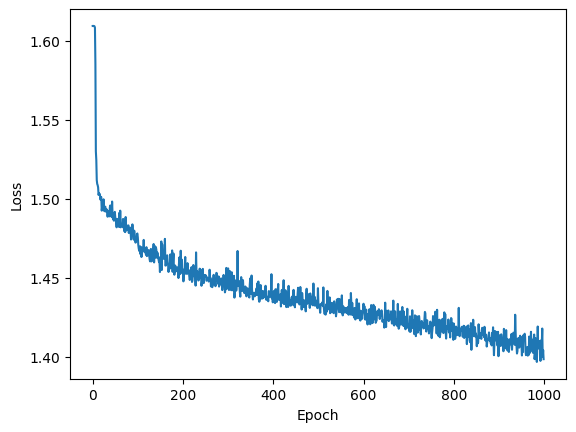

Test accuracy: 469.59311827956986
Accuracy: 0.41978494623655915
Precision: 0.4121613205420777
Recall: 0.41570312141544097
F1-score: 0.40830905523468203


Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.47      0.41       495
           1       0.68      0.79      0.73       472
           2       0.28      0.24      0.26       449
           3       0.29      0.28      0.29       463
           4       0.45      0.30      0.36       446

    accuracy                           0.42      2325
   macro avg       0.41      0.42      0.41      2325
weighted avg       0.41      0.42      0.41      2325

                    0           1           2           3           4  \
precision    0.357473    0.682569    0.283820    0.287281    0.449664   
recall       0.468687    0.788136    0.238307    0.282937    0.300448   
f1-score     0.405594    0.731563    0.259080    0.285092    0.360215   
support    495.000000  472.000000  449.000

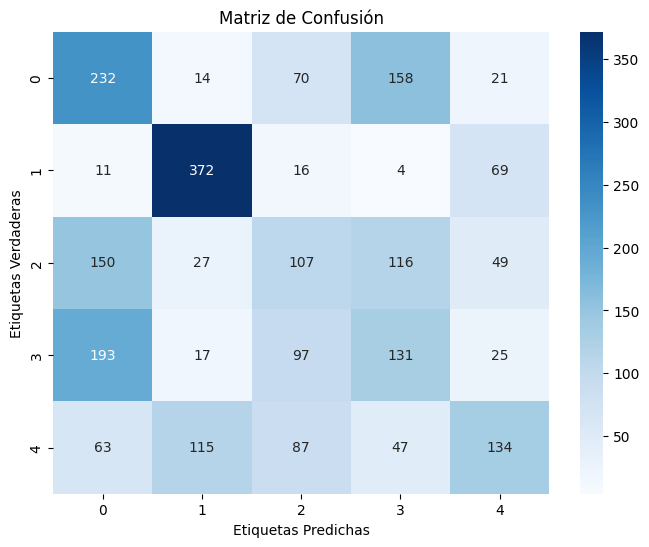

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_0.0001_0.1/resultados_1000_0.0001_0.1.json
Procesando red con 1000 epocas y 1e-05 de factor de aprendizaje y conjunto de entrenamiento 0.9


Procesando epocas:   0%|                                                              | 1/1000 [00:01<28:59,  1.74s/it]

1.6096315517145046


Procesando epocas:   0%|                                                              | 2/1000 [00:03<29:00,  1.74s/it]

1.6095392318332897


Procesando epocas:   0%|▏                                                             | 3/1000 [00:05<29:02,  1.75s/it]

1.6096525213297677


Procesando epocas:   0%|▏                                                             | 4/1000 [00:06<29:01,  1.75s/it]

1.6095767175450044


Procesando epocas:   0%|▎                                                             | 5/1000 [00:08<29:02,  1.75s/it]

1.609506490651299


Procesando epocas:   1%|▎                                                             | 6/1000 [00:10<29:02,  1.75s/it]

1.6096120154156404


Procesando epocas:   1%|▍                                                             | 7/1000 [00:12<29:01,  1.75s/it]

1.6095212704995099


Procesando epocas:   1%|▍                                                             | 8/1000 [00:13<28:56,  1.75s/it]

1.6095605317284079


Procesando epocas:   1%|▌                                                             | 9/1000 [00:15<28:51,  1.75s/it]

1.6094794020933263


Procesando epocas:   1%|▌                                                            | 10/1000 [00:17<28:47,  1.75s/it]

1.609359469834496


Procesando epocas:   1%|▋                                                            | 11/1000 [00:19<28:45,  1.74s/it]

1.60895597373738


Procesando epocas:   1%|▋                                                            | 12/1000 [00:20<28:45,  1.75s/it]

1.6085025955648984


Procesando epocas:   1%|▊                                                            | 13/1000 [00:22<28:41,  1.74s/it]

1.6075704259030958


Procesando epocas:   1%|▊                                                            | 14/1000 [00:24<28:35,  1.74s/it]

1.605478176649879


Procesando epocas:   2%|▉                                                            | 15/1000 [00:26<28:30,  1.74s/it]

1.6013645438586965


Procesando epocas:   2%|▉                                                            | 16/1000 [00:27<28:33,  1.74s/it]

1.5942663094576668


Procesando epocas:   2%|█                                                            | 17/1000 [00:29<28:33,  1.74s/it]

1.5830432590316323


Procesando epocas:   2%|█                                                            | 18/1000 [00:31<28:34,  1.75s/it]

1.5693871273713953


Procesando epocas:   2%|█▏                                                           | 19/1000 [00:33<28:31,  1.74s/it]

1.5560592525145587


Procesando epocas:   2%|█▏                                                           | 20/1000 [00:34<28:22,  1.74s/it]

1.5464484284905826


Procesando epocas:   2%|█▎                                                           | 21/1000 [00:36<28:15,  1.73s/it]

1.539520056107465


Procesando epocas:   2%|█▎                                                           | 22/1000 [00:38<28:14,  1.73s/it]

1.5320112522910623


Procesando epocas:   2%|█▍                                                           | 23/1000 [00:40<28:08,  1.73s/it]

1.5306894905426922


Procesando epocas:   2%|█▍                                                           | 24/1000 [00:41<28:09,  1.73s/it]

1.526533475342919


Procesando epocas:   2%|█▌                                                           | 25/1000 [00:43<28:07,  1.73s/it]

1.5212937425164614


Procesando epocas:   3%|█▌                                                           | 26/1000 [00:45<28:07,  1.73s/it]

1.5191803055651047


Procesando epocas:   3%|█▋                                                           | 27/1000 [00:46<28:06,  1.73s/it]

1.519299565343296


Procesando epocas:   3%|█▋                                                           | 28/1000 [00:48<28:05,  1.73s/it]

1.5179940511198604


Procesando epocas:   3%|█▊                                                           | 29/1000 [00:50<28:05,  1.74s/it]

1.5130190638934864


Procesando epocas:   3%|█▊                                                           | 30/1000 [00:52<28:01,  1.73s/it]

1.5138132053263047


Procesando epocas:   3%|█▉                                                           | 31/1000 [00:53<27:55,  1.73s/it]

1.5117567826719844


Procesando epocas:   3%|█▉                                                           | 32/1000 [00:55<27:53,  1.73s/it]

1.5102924648453206


Procesando epocas:   3%|██                                                           | 33/1000 [00:57<27:48,  1.73s/it]

1.509630799293518


Procesando epocas:   3%|██                                                           | 34/1000 [00:59<27:46,  1.73s/it]

1.508502148179447


Procesando epocas:   4%|██▏                                                          | 35/1000 [01:00<27:49,  1.73s/it]

1.5073445404277128


Procesando epocas:   4%|██▏                                                          | 36/1000 [01:02<27:48,  1.73s/it]

1.5076215968412512


Procesando epocas:   4%|██▎                                                          | 37/1000 [01:04<27:46,  1.73s/it]

1.5069426326190725


Procesando epocas:   4%|██▎                                                          | 38/1000 [01:06<27:45,  1.73s/it]

1.5054018686799442


Procesando epocas:   4%|██▍                                                          | 39/1000 [01:07<27:47,  1.74s/it]

1.5054291935528026


Procesando epocas:   4%|██▍                                                          | 40/1000 [01:09<27:46,  1.74s/it]

1.5055222455193014


Procesando epocas:   4%|██▌                                                          | 41/1000 [01:11<27:45,  1.74s/it]

1.5050627056290122


Procesando epocas:   4%|██▌                                                          | 42/1000 [01:12<27:39,  1.73s/it]

1.5028224419145022


Procesando epocas:   4%|██▌                                                          | 43/1000 [01:14<27:37,  1.73s/it]

1.5028159926919376


Procesando epocas:   4%|██▋                                                          | 44/1000 [01:16<27:36,  1.73s/it]

1.5020067257039686


Procesando epocas:   4%|██▋                                                          | 45/1000 [01:18<27:37,  1.74s/it]

1.5013181118404164


Procesando epocas:   5%|██▊                                                          | 46/1000 [01:19<27:35,  1.74s/it]

1.4987040891366847


Procesando epocas:   5%|██▊                                                          | 47/1000 [01:21<27:29,  1.73s/it]

1.5011738160077264


Procesando epocas:   5%|██▉                                                          | 48/1000 [01:23<27:27,  1.73s/it]

1.4981236149283017


Procesando epocas:   5%|██▉                                                          | 49/1000 [01:25<27:23,  1.73s/it]

1.5031725617016063


Procesando epocas:   5%|███                                                          | 50/1000 [01:26<27:25,  1.73s/it]

1.4991106475100797


Procesando epocas:   5%|███                                                          | 51/1000 [01:28<27:24,  1.73s/it]

1.5004547343534582


Procesando epocas:   5%|███▏                                                         | 52/1000 [01:30<27:22,  1.73s/it]

1.4993107304853552


Procesando epocas:   5%|███▏                                                         | 53/1000 [01:32<27:20,  1.73s/it]

1.5000685937264386


Procesando epocas:   5%|███▎                                                         | 54/1000 [01:33<27:21,  1.73s/it]

1.4977536741425008


Procesando epocas:   6%|███▎                                                         | 55/1000 [01:35<27:18,  1.73s/it]

1.4969147072118871


Procesando epocas:   6%|███▍                                                         | 56/1000 [01:37<27:15,  1.73s/it]

1.496940639439751


Procesando epocas:   6%|███▍                                                         | 57/1000 [01:38<27:13,  1.73s/it]

1.495470574322869


Procesando epocas:   6%|███▌                                                         | 58/1000 [01:40<27:12,  1.73s/it]

1.499584698677063


Procesando epocas:   6%|███▌                                                         | 59/1000 [01:42<27:06,  1.73s/it]

1.4939237440333646


Procesando epocas:   6%|███▋                                                         | 60/1000 [01:44<27:06,  1.73s/it]

1.4972024777356316


Procesando epocas:   6%|███▋                                                         | 61/1000 [01:45<27:01,  1.73s/it]

1.4921732159221874


Procesando epocas:   6%|███▊                                                         | 62/1000 [01:47<27:00,  1.73s/it]

1.4941834141226376


Procesando epocas:   6%|███▊                                                         | 63/1000 [01:49<27:01,  1.73s/it]

1.4971043797100292


Procesando epocas:   6%|███▉                                                         | 64/1000 [01:51<26:58,  1.73s/it]

1.4937365454785965


Procesando epocas:   6%|███▉                                                         | 65/1000 [01:52<26:54,  1.73s/it]

1.4939742410884185


Procesando epocas:   7%|████                                                         | 66/1000 [01:54<26:52,  1.73s/it]

1.4955018478281357


Procesando epocas:   7%|████                                                         | 67/1000 [01:56<26:50,  1.73s/it]

1.492860282168669


Procesando epocas:   7%|████▏                                                        | 68/1000 [01:57<26:53,  1.73s/it]

1.4961769833284266


Procesando epocas:   7%|████▏                                                        | 69/1000 [01:59<26:50,  1.73s/it]

1.4929624866036808


Procesando epocas:   7%|████▎                                                        | 70/1000 [02:01<26:47,  1.73s/it]

1.4939504293834462


Procesando epocas:   7%|████▎                                                        | 71/1000 [02:03<26:46,  1.73s/it]

1.4925640751333797


Procesando epocas:   7%|████▍                                                        | 72/1000 [02:04<26:44,  1.73s/it]

1.4925623844651614


Procesando epocas:   7%|████▍                                                        | 73/1000 [02:06<26:43,  1.73s/it]

1.4933019020978142


Procesando epocas:   7%|████▌                                                        | 74/1000 [02:08<26:37,  1.73s/it]

1.4928803107317756


Procesando epocas:   8%|████▌                                                        | 75/1000 [02:10<26:38,  1.73s/it]

1.4927875539835762


Procesando epocas:   8%|████▋                                                        | 76/1000 [02:11<26:34,  1.73s/it]

1.4919808654224171


Procesando epocas:   8%|████▋                                                        | 77/1000 [02:13<26:31,  1.72s/it]

1.492548455911524


Procesando epocas:   8%|████▊                                                        | 78/1000 [02:15<26:30,  1.73s/it]

1.4894632381551407


Procesando epocas:   8%|████▊                                                        | 79/1000 [02:16<26:34,  1.73s/it]

1.4928100298432743


Procesando epocas:   8%|████▉                                                        | 80/1000 [02:18<26:28,  1.73s/it]

1.49031221445869


Procesando epocas:   8%|████▉                                                        | 81/1000 [02:20<26:22,  1.72s/it]

1.4933835415279164


Procesando epocas:   8%|█████                                                        | 82/1000 [02:22<26:24,  1.73s/it]

1.4901257101227254


Procesando epocas:   8%|█████                                                        | 83/1000 [02:23<26:20,  1.72s/it]

1.4880451391724978


Procesando epocas:   8%|█████                                                        | 84/1000 [02:25<26:23,  1.73s/it]

1.4881318849675795


Procesando epocas:   8%|█████▏                                                       | 85/1000 [02:27<26:34,  1.74s/it]

1.48964645021102


Procesando epocas:   9%|█████▏                                                       | 86/1000 [02:29<26:36,  1.75s/it]

1.4882421928293565


Procesando epocas:   9%|█████▎                                                       | 87/1000 [02:30<26:36,  1.75s/it]

1.4880645695854635


Procesando epocas:   9%|█████▎                                                       | 88/1000 [02:32<26:34,  1.75s/it]

1.4885942879845113


Procesando epocas:   9%|█████▍                                                       | 89/1000 [02:34<26:35,  1.75s/it]

1.487880546205184


Procesando epocas:   9%|█████▍                                                       | 90/1000 [02:36<26:28,  1.75s/it]

1.4884007138364455


Procesando epocas:   9%|█████▌                                                       | 91/1000 [02:37<26:29,  1.75s/it]

1.4882745904081007


Procesando epocas:   9%|█████▌                                                       | 92/1000 [02:39<26:30,  1.75s/it]

1.4877542215235093


Procesando epocas:   9%|█████▋                                                       | 93/1000 [02:41<26:28,  1.75s/it]

1.4882696817902958


Procesando epocas:   9%|█████▋                                                       | 94/1000 [02:43<26:33,  1.76s/it]

1.48805010248633


Procesando epocas:  10%|█████▊                                                       | 95/1000 [02:44<26:28,  1.76s/it]

1.4906361053971684


Procesando epocas:  10%|█████▊                                                       | 96/1000 [02:46<26:29,  1.76s/it]

1.4875642762464636


Procesando epocas:  10%|█████▉                                                       | 97/1000 [02:48<26:24,  1.75s/it]

1.4861892552936777


Procesando epocas:  10%|█████▉                                                       | 98/1000 [02:50<26:22,  1.75s/it]

1.4849792557604173


Procesando epocas:  10%|██████                                                       | 99/1000 [02:51<26:22,  1.76s/it]

1.4863651528077968


Procesando epocas:  10%|██████                                                      | 100/1000 [02:53<26:22,  1.76s/it]

1.489308177022373


Procesando epocas:  10%|██████                                                      | 101/1000 [02:55<26:22,  1.76s/it]

1.487676734082839


Procesando epocas:  10%|██████                                                      | 102/1000 [02:57<26:23,  1.76s/it]

1.4874675603473888


Procesando epocas:  10%|██████▏                                                     | 103/1000 [02:58<26:15,  1.76s/it]

1.487008169819327


Procesando epocas:  10%|██████▏                                                     | 104/1000 [03:00<26:13,  1.76s/it]

1.4847248610328225


Procesando epocas:  10%|██████▎                                                     | 105/1000 [03:02<26:06,  1.75s/it]

1.4869276544627021


Procesando epocas:  11%|██████▎                                                     | 106/1000 [03:04<26:08,  1.75s/it]

1.4878214822095983


Procesando epocas:  11%|██████▍                                                     | 107/1000 [03:05<26:09,  1.76s/it]

1.488530915624955


Procesando epocas:  11%|██████▍                                                     | 108/1000 [03:07<26:06,  1.76s/it]

1.4832173095029944


Procesando epocas:  11%|██████▌                                                     | 109/1000 [03:09<26:02,  1.75s/it]

1.483899040783153


Procesando epocas:  11%|██████▌                                                     | 110/1000 [03:11<25:59,  1.75s/it]

1.4847060189527623


Procesando epocas:  11%|██████▋                                                     | 111/1000 [03:12<25:56,  1.75s/it]

1.4832094655317418


Procesando epocas:  11%|██████▋                                                     | 112/1000 [03:14<25:54,  1.75s/it]

1.4869528700323666


Procesando epocas:  11%|██████▊                                                     | 113/1000 [03:16<25:50,  1.75s/it]

1.4835731450249168


Procesando epocas:  11%|██████▊                                                     | 114/1000 [03:18<25:51,  1.75s/it]

1.4825345165589277


Procesando epocas:  12%|██████▉                                                     | 115/1000 [03:19<25:38,  1.74s/it]

1.4836149741621578


Procesando epocas:  12%|██████▉                                                     | 116/1000 [03:21<25:29,  1.73s/it]

1.4865279071471271


Procesando epocas:  12%|███████                                                     | 117/1000 [03:23<25:22,  1.72s/it]

1.4853763706543865


Procesando epocas:  12%|███████                                                     | 118/1000 [03:25<25:20,  1.72s/it]

1.4824111356454737


Procesando epocas:  12%|███████▏                                                    | 119/1000 [03:26<25:13,  1.72s/it]

1.4834761030533734


Procesando epocas:  12%|███████▏                                                    | 120/1000 [03:28<25:12,  1.72s/it]

1.483839615653543


Procesando epocas:  12%|███████▎                                                    | 121/1000 [03:30<25:09,  1.72s/it]

1.4859101505840526


Procesando epocas:  12%|███████▎                                                    | 122/1000 [03:31<25:04,  1.71s/it]

1.4832469021572787


Procesando epocas:  12%|███████▍                                                    | 123/1000 [03:33<24:59,  1.71s/it]

1.4801282910739675


Procesando epocas:  12%|███████▍                                                    | 124/1000 [03:35<24:57,  1.71s/it]

1.4840674021664788


Procesando epocas:  12%|███████▌                                                    | 125/1000 [03:37<24:58,  1.71s/it]

1.4814061192905201


Procesando epocas:  13%|███████▌                                                    | 126/1000 [03:38<24:53,  1.71s/it]

1.4830595353070428


Procesando epocas:  13%|███████▌                                                    | 127/1000 [03:40<24:48,  1.71s/it]

1.4822258542565738


Procesando epocas:  13%|███████▋                                                    | 128/1000 [03:42<24:51,  1.71s/it]

1.4833933409522562


Procesando epocas:  13%|███████▋                                                    | 129/1000 [03:43<24:47,  1.71s/it]

1.4815362628768471


Procesando epocas:  13%|███████▊                                                    | 130/1000 [03:45<24:45,  1.71s/it]

1.4818059177959666


Procesando epocas:  13%|███████▊                                                    | 131/1000 [03:47<24:42,  1.71s/it]

1.4812245025354274


Procesando epocas:  13%|███████▉                                                    | 132/1000 [03:49<24:41,  1.71s/it]

1.4810169037650613


Procesando epocas:  13%|███████▉                                                    | 133/1000 [03:50<24:47,  1.72s/it]

1.4814619323786566


Procesando epocas:  13%|████████                                                    | 134/1000 [03:52<24:54,  1.73s/it]

1.4822850325528314


Procesando epocas:  14%|████████                                                    | 135/1000 [03:54<25:01,  1.74s/it]

1.4803836997817545


Procesando epocas:  14%|████████▏                                                   | 136/1000 [03:56<25:03,  1.74s/it]

1.4807441164465511


Procesando epocas:  14%|████████▏                                                   | 137/1000 [03:57<25:04,  1.74s/it]

1.482630728974062


Procesando epocas:  14%|████████▎                                                   | 138/1000 [03:59<25:06,  1.75s/it]

1.4804443149005666


Procesando epocas:  14%|████████▎                                                   | 139/1000 [04:01<25:06,  1.75s/it]

1.4821926839211408


Procesando epocas:  14%|████████▍                                                   | 140/1000 [04:03<25:07,  1.75s/it]

1.4800257472430958


Procesando epocas:  14%|████████▍                                                   | 141/1000 [04:04<25:03,  1.75s/it]

1.4775132571949678


Procesando epocas:  14%|████████▌                                                   | 142/1000 [04:06<25:00,  1.75s/it]

1.4856178199543673


Procesando epocas:  14%|████████▌                                                   | 143/1000 [04:08<24:53,  1.74s/it]

1.4813125673462362


Procesando epocas:  14%|████████▋                                                   | 144/1000 [04:09<24:50,  1.74s/it]

1.4783232352312874


Procesando epocas:  14%|████████▋                                                   | 145/1000 [04:11<24:46,  1.74s/it]

1.483023514467127


Procesando epocas:  15%|████████▊                                                   | 146/1000 [04:13<24:41,  1.74s/it]

1.4797482224071727


Procesando epocas:  15%|████████▊                                                   | 147/1000 [04:15<24:40,  1.74s/it]

1.4776144785039564


Procesando epocas:  15%|████████▉                                                   | 148/1000 [04:16<24:37,  1.73s/it]

1.4818057424881879


Procesando epocas:  15%|████████▉                                                   | 149/1000 [04:18<24:33,  1.73s/it]

1.4795184626298792


Procesando epocas:  15%|█████████                                                   | 150/1000 [04:20<24:26,  1.73s/it]

1.4794347840196946


Procesando epocas:  15%|█████████                                                   | 151/1000 [04:22<24:25,  1.73s/it]

1.4788253265268663


Procesando epocas:  15%|█████████                                                   | 152/1000 [04:23<24:24,  1.73s/it]

1.483554201967576


Procesando epocas:  15%|█████████▏                                                  | 153/1000 [04:25<24:22,  1.73s/it]

1.4825131640714757


Procesando epocas:  15%|█████████▏                                                  | 154/1000 [04:27<24:19,  1.73s/it]

1.4812812699991114


Procesando epocas:  16%|█████████▎                                                  | 155/1000 [04:28<24:22,  1.73s/it]

1.478619549554937


Procesando epocas:  16%|█████████▎                                                  | 156/1000 [04:30<24:22,  1.73s/it]

1.4798160356633803


Procesando epocas:  16%|█████████▍                                                  | 157/1000 [04:32<24:22,  1.73s/it]

1.4815751117818496


Procesando epocas:  16%|█████████▍                                                  | 158/1000 [04:34<24:17,  1.73s/it]

1.478710516761331


Procesando epocas:  16%|█████████▌                                                  | 159/1000 [04:35<24:19,  1.74s/it]

1.4790630607043995


Procesando epocas:  16%|█████████▌                                                  | 160/1000 [04:37<24:14,  1.73s/it]

1.482049359293545


Procesando epocas:  16%|█████████▋                                                  | 161/1000 [04:39<24:08,  1.73s/it]

1.4804603688857134


Procesando epocas:  16%|█████████▋                                                  | 162/1000 [04:41<24:09,  1.73s/it]

1.4807479360524345


Procesando epocas:  16%|█████████▊                                                  | 163/1000 [04:42<24:05,  1.73s/it]

1.4763846165993635


Procesando epocas:  16%|█████████▊                                                  | 164/1000 [04:44<24:09,  1.73s/it]

1.480687860881581


Procesando epocas:  16%|█████████▉                                                  | 165/1000 [04:46<24:06,  1.73s/it]

1.4799543233478771


Procesando epocas:  17%|█████████▉                                                  | 166/1000 [04:48<24:05,  1.73s/it]

1.4801681616727043


Procesando epocas:  17%|██████████                                                  | 167/1000 [04:49<24:02,  1.73s/it]

1.4816235899925232


Procesando epocas:  17%|██████████                                                  | 168/1000 [04:51<23:56,  1.73s/it]

1.4807557260288913


Procesando epocas:  17%|██████████▏                                                 | 169/1000 [04:53<23:52,  1.72s/it]

1.477416961333331


Procesando epocas:  17%|██████████▏                                                 | 170/1000 [04:54<23:54,  1.73s/it]

1.4780660580186282


Procesando epocas:  17%|██████████▎                                                 | 171/1000 [04:56<23:52,  1.73s/it]

1.4765743550132302


Procesando epocas:  17%|██████████▎                                                 | 172/1000 [04:58<23:49,  1.73s/it]

1.4783721923828126


Procesando epocas:  17%|██████████▍                                                 | 173/1000 [05:00<23:45,  1.72s/it]

1.477198565006256


Procesando epocas:  17%|██████████▍                                                 | 174/1000 [05:01<23:47,  1.73s/it]

1.4802225758047665


Procesando epocas:  18%|██████████▌                                                 | 175/1000 [05:03<23:41,  1.72s/it]

1.4772482549442965


Procesando epocas:  18%|██████████▌                                                 | 176/1000 [05:05<23:39,  1.72s/it]

1.4801998075316933


Procesando epocas:  18%|██████████▌                                                 | 177/1000 [05:07<23:39,  1.72s/it]

1.4804598156143638


Procesando epocas:  18%|██████████▋                                                 | 178/1000 [05:08<23:34,  1.72s/it]

1.4798341687987833


Procesando epocas:  18%|██████████▋                                                 | 179/1000 [05:10<23:29,  1.72s/it]

1.4772922354585984


Procesando epocas:  18%|██████████▊                                                 | 180/1000 [05:12<23:21,  1.71s/it]

1.4759487306370456


Procesando epocas:  18%|██████████▊                                                 | 181/1000 [05:13<23:16,  1.71s/it]

1.4779422437443452


Procesando epocas:  18%|██████████▉                                                 | 182/1000 [05:15<23:20,  1.71s/it]

1.4765050838975344


Procesando epocas:  18%|██████████▉                                                 | 183/1000 [05:17<23:15,  1.71s/it]

1.4818312006838181


Procesando epocas:  18%|███████████                                                 | 184/1000 [05:18<23:13,  1.71s/it]

1.4746066969983718


Procesando epocas:  18%|███████████                                                 | 185/1000 [05:20<23:09,  1.70s/it]

1.4785125501015608


Procesando epocas:  19%|███████████▏                                                | 186/1000 [05:22<23:10,  1.71s/it]

1.4774040383451126


Procesando epocas:  19%|███████████▏                                                | 187/1000 [05:24<23:06,  1.71s/it]

1.477868261758019


Procesando epocas:  19%|███████████▎                                                | 188/1000 [05:25<23:05,  1.71s/it]

1.4779950808076296


Procesando epocas:  19%|███████████▎                                                | 189/1000 [05:27<23:07,  1.71s/it]

1.4740643192740048


Procesando epocas:  19%|███████████▍                                                | 190/1000 [05:29<23:08,  1.71s/it]

1.4762928324587206


Procesando epocas:  19%|███████████▍                                                | 191/1000 [05:30<23:05,  1.71s/it]

1.477341475907494


Procesando epocas:  19%|███████████▌                                                | 192/1000 [05:32<23:01,  1.71s/it]

1.4757373746703653


Procesando epocas:  19%|███████████▌                                                | 193/1000 [05:34<23:00,  1.71s/it]

1.4774760386523078


Procesando epocas:  19%|███████████▋                                                | 194/1000 [05:36<22:59,  1.71s/it]

1.4752801235984354


Procesando epocas:  20%|███████████▋                                                | 195/1000 [05:37<22:56,  1.71s/it]

1.4769614135517795


Procesando epocas:  20%|███████████▊                                                | 196/1000 [05:39<22:53,  1.71s/it]

1.47698572102715


Procesando epocas:  20%|███████████▊                                                | 197/1000 [05:41<22:48,  1.70s/it]

1.4766468244440416


Procesando epocas:  20%|███████████▉                                                | 198/1000 [05:42<22:51,  1.71s/it]

1.4742812717662137


Procesando epocas:  20%|███████████▉                                                | 199/1000 [05:44<22:51,  1.71s/it]

1.4749865840463077


Procesando epocas:  20%|████████████                                                | 200/1000 [05:46<22:47,  1.71s/it]

1.4744524780441732


Procesando epocas:  20%|████████████                                                | 201/1000 [05:48<22:48,  1.71s/it]

1.4773356143166037


Procesando epocas:  20%|████████████                                                | 202/1000 [05:49<22:44,  1.71s/it]

1.4763695345205419


Procesando epocas:  20%|████████████▏                                               | 203/1000 [05:51<22:41,  1.71s/it]

1.4753781304639928


Procesando epocas:  20%|████████████▏                                               | 204/1000 [05:53<22:37,  1.71s/it]

1.4785805393667781


Procesando epocas:  20%|████████████▎                                               | 205/1000 [05:54<22:31,  1.70s/it]

1.478004984995898


Procesando epocas:  21%|████████████▎                                               | 206/1000 [05:56<22:46,  1.72s/it]

1.4783915624899022


Procesando epocas:  21%|████████████▍                                               | 207/1000 [05:58<22:58,  1.74s/it]

1.4764790093197542


Procesando epocas:  21%|████████████▍                                               | 208/1000 [06:00<23:08,  1.75s/it]

1.475764007428113


Procesando epocas:  21%|████████████▌                                               | 209/1000 [06:01<23:16,  1.77s/it]

1.4756054415422328


Procesando epocas:  21%|████████████▌                                               | 210/1000 [06:03<23:20,  1.77s/it]

1.4784885757109698


Procesando epocas:  21%|████████████▋                                               | 211/1000 [06:05<23:24,  1.78s/it]

1.476310609368717


Procesando epocas:  21%|████████████▋                                               | 212/1000 [06:07<23:23,  1.78s/it]

1.4753375684513765


Procesando epocas:  21%|████████████▊                                               | 213/1000 [06:09<23:23,  1.78s/it]

1.4746653577860664


Procesando epocas:  21%|████████████▊                                               | 214/1000 [06:10<23:23,  1.79s/it]

1.4759537325185887


Procesando epocas:  22%|████████████▉                                               | 215/1000 [06:12<23:22,  1.79s/it]

1.4742829399950363


Procesando epocas:  22%|████████████▉                                               | 216/1000 [06:14<23:18,  1.78s/it]

1.4744015413172105


Procesando epocas:  22%|█████████████                                               | 217/1000 [06:16<23:17,  1.79s/it]

1.4752711927189546


Procesando epocas:  22%|█████████████                                               | 218/1000 [06:18<23:20,  1.79s/it]

1.4755777891944437


Procesando epocas:  22%|█████████████▏                                              | 219/1000 [06:19<23:16,  1.79s/it]

1.4746295220711652


Procesando epocas:  22%|█████████████▏                                              | 220/1000 [06:21<23:16,  1.79s/it]

1.4736021322362562


Procesando epocas:  22%|█████████████▎                                              | 221/1000 [06:23<23:07,  1.78s/it]

1.4717755240552566


Procesando epocas:  22%|█████████████▎                                              | 222/1000 [06:25<23:07,  1.78s/it]

1.4759972887880661


Procesando epocas:  22%|█████████████▍                                              | 223/1000 [06:26<23:05,  1.78s/it]

1.475374277199016


Procesando epocas:  22%|█████████████▍                                              | 224/1000 [06:28<23:03,  1.78s/it]

1.4720560648862053


Procesando epocas:  22%|█████████████▌                                              | 225/1000 [06:30<23:04,  1.79s/it]

1.4758461903123294


Procesando epocas:  23%|█████████████▌                                              | 226/1000 [06:32<23:03,  1.79s/it]

1.4755710573757397


Procesando epocas:  23%|█████████████▌                                              | 227/1000 [06:34<23:02,  1.79s/it]

1.475488024599412


Procesando epocas:  23%|█████████████▋                                              | 228/1000 [06:35<23:03,  1.79s/it]

1.4728418497478262


Procesando epocas:  23%|█████████████▋                                              | 229/1000 [06:37<23:03,  1.79s/it]

1.4703575646176057


Procesando epocas:  23%|█████████████▊                                              | 230/1000 [06:39<23:03,  1.80s/it]

1.4734501992954927


Procesando epocas:  23%|█████████████▊                                              | 231/1000 [06:41<23:01,  1.80s/it]

1.4732194956611184


Procesando epocas:  23%|█████████████▉                                              | 232/1000 [06:43<23:03,  1.80s/it]

1.474094514987048


Procesando epocas:  23%|█████████████▉                                              | 233/1000 [06:44<23:00,  1.80s/it]

1.471834378382739


Procesando epocas:  23%|██████████████                                              | 234/1000 [06:46<23:00,  1.80s/it]

1.4750762027852675


Procesando epocas:  24%|██████████████                                              | 235/1000 [06:48<22:53,  1.80s/it]

1.4753592399989857


Procesando epocas:  24%|██████████████▏                                             | 236/1000 [06:50<22:53,  1.80s/it]

1.4717695011812097


Procesando epocas:  24%|██████████████▏                                             | 237/1000 [06:52<22:44,  1.79s/it]

1.4741032929981457


Procesando epocas:  24%|██████████████▎                                             | 238/1000 [06:53<22:48,  1.80s/it]

1.472914317074944


Procesando epocas:  24%|██████████████▎                                             | 239/1000 [06:55<22:43,  1.79s/it]

1.4752517826416913


Procesando epocas:  24%|██████████████▍                                             | 240/1000 [06:57<22:36,  1.79s/it]

1.4744324130170485


Procesando epocas:  24%|██████████████▍                                             | 241/1000 [06:59<22:34,  1.79s/it]

1.4757845100234537


Procesando epocas:  24%|██████████████▌                                             | 242/1000 [07:01<22:32,  1.78s/it]

1.472938682051266


Procesando epocas:  24%|██████████████▌                                             | 243/1000 [07:02<22:26,  1.78s/it]

1.4721162971328288


Procesando epocas:  24%|██████████████▋                                             | 244/1000 [07:04<22:22,  1.78s/it]

1.4734408946598276


Procesando epocas:  24%|██████████████▋                                             | 245/1000 [07:06<22:17,  1.77s/it]

1.4734660562346964


Procesando epocas:  25%|██████████████▊                                             | 246/1000 [07:08<22:14,  1.77s/it]

1.4753669577486375


Procesando epocas:  25%|██████████████▊                                             | 247/1000 [07:09<22:11,  1.77s/it]

1.4717143093838412


Procesando epocas:  25%|██████████████▉                                             | 248/1000 [07:11<22:09,  1.77s/it]

1.4726456873557148


Procesando epocas:  25%|██████████████▉                                             | 249/1000 [07:13<22:08,  1.77s/it]

1.4716703456990858


Procesando epocas:  25%|███████████████                                             | 250/1000 [07:15<22:08,  1.77s/it]

1.480106234550476


Procesando epocas:  25%|███████████████                                             | 251/1000 [07:16<22:08,  1.77s/it]

1.4725726962089538


Procesando epocas:  25%|███████████████                                             | 252/1000 [07:18<22:04,  1.77s/it]

1.4714783829801223


Procesando epocas:  25%|███████████████▏                                            | 253/1000 [07:20<22:03,  1.77s/it]

1.473823100679061


Procesando epocas:  25%|███████████████▏                                            | 254/1000 [07:22<21:59,  1.77s/it]

1.471463692889494


Procesando epocas:  26%|███████████████▎                                            | 255/1000 [07:24<21:57,  1.77s/it]

1.470439532925101


Procesando epocas:  26%|███████████████▎                                            | 256/1000 [07:25<21:55,  1.77s/it]

1.473253425429849


Procesando epocas:  26%|███████████████▍                                            | 257/1000 [07:27<21:50,  1.76s/it]

1.472896719680113


Procesando epocas:  26%|███████████████▍                                            | 258/1000 [07:29<21:52,  1.77s/it]

1.4725008137085858


Procesando epocas:  26%|███████████████▌                                            | 259/1000 [07:31<21:49,  1.77s/it]

1.474155074007371


Procesando epocas:  26%|███████████████▌                                            | 260/1000 [07:32<21:45,  1.76s/it]

1.4709685557028827


Procesando epocas:  26%|███████████████▋                                            | 261/1000 [07:34<21:43,  1.76s/it]

1.4706336245817297


Procesando epocas:  26%|███████████████▋                                            | 262/1000 [07:36<21:42,  1.77s/it]

1.4699341851122238


Procesando epocas:  26%|███████████████▊                                            | 263/1000 [07:38<21:41,  1.77s/it]

1.4711571027250852


Procesando epocas:  26%|███████████████▊                                            | 264/1000 [07:39<21:34,  1.76s/it]

1.4711017924196579


Procesando epocas:  26%|███████████████▉                                            | 265/1000 [07:41<21:31,  1.76s/it]

1.4731255180695477


Procesando epocas:  27%|███████████████▉                                            | 266/1000 [07:43<21:26,  1.75s/it]

1.4756752519046559


Procesando epocas:  27%|████████████████                                            | 267/1000 [07:45<21:22,  1.75s/it]

1.4713157702894772


Procesando epocas:  27%|████████████████                                            | 268/1000 [07:46<21:17,  1.75s/it]

1.4723872282925774


Procesando epocas:  27%|████████████████▏                                           | 269/1000 [07:48<21:13,  1.74s/it]

1.4721271367634043


Procesando epocas:  27%|████████████████▏                                           | 270/1000 [07:50<21:10,  1.74s/it]

1.4696304538670708


Procesando epocas:  27%|████████████████▎                                           | 271/1000 [07:52<21:12,  1.75s/it]

1.4727596893030055


Procesando epocas:  27%|████████████████▎                                           | 272/1000 [07:53<21:13,  1.75s/it]

1.4709481954574586


Procesando epocas:  27%|████████████████▍                                           | 273/1000 [07:55<21:06,  1.74s/it]

1.4732174775179694


Procesando epocas:  27%|████████████████▍                                           | 274/1000 [07:57<21:02,  1.74s/it]

1.470312037187464


Procesando epocas:  28%|████████████████▌                                           | 275/1000 [07:59<20:58,  1.74s/it]

1.4721722960472108


Procesando epocas:  28%|████████████████▌                                           | 276/1000 [08:00<20:52,  1.73s/it]

1.471294025813832


Procesando epocas:  28%|████████████████▌                                           | 277/1000 [08:02<20:49,  1.73s/it]

1.470450507893282


Procesando epocas:  28%|████████████████▋                                           | 278/1000 [08:04<20:42,  1.72s/it]

1.471176235816058


Procesando epocas:  28%|████████████████▋                                           | 279/1000 [08:05<20:33,  1.71s/it]

1.4705466614050025


Procesando epocas:  28%|████████████████▊                                           | 280/1000 [08:07<20:26,  1.70s/it]

1.4702175708378062


Procesando epocas:  28%|████████████████▊                                           | 281/1000 [08:09<20:22,  1.70s/it]

1.4707825730828679


Procesando epocas:  28%|████████████████▉                                           | 282/1000 [08:10<20:26,  1.71s/it]

1.4714877942029168


Procesando epocas:  28%|████████████████▉                                           | 283/1000 [08:12<20:27,  1.71s/it]

1.4725602142951069


Procesando epocas:  28%|█████████████████                                           | 284/1000 [08:14<20:21,  1.71s/it]

1.4709172830862158


Procesando epocas:  28%|█████████████████                                           | 285/1000 [08:16<20:19,  1.71s/it]

1.4749799363753375


Procesando epocas:  29%|█████████████████▏                                          | 286/1000 [08:17<20:16,  1.70s/it]

1.4715248521636515


Procesando epocas:  29%|█████████████████▏                                          | 287/1000 [08:19<20:11,  1.70s/it]

1.4723066133611342


Procesando epocas:  29%|█████████████████▎                                          | 288/1000 [08:21<20:10,  1.70s/it]

1.4716762072899763


Procesando epocas:  29%|█████████████████▎                                          | 289/1000 [08:22<20:02,  1.69s/it]

1.4721670164781457


Procesando epocas:  29%|█████████████████▍                                          | 290/1000 [08:24<20:02,  1.69s/it]

1.4725015205495497


Procesando epocas:  29%|█████████████████▍                                          | 291/1000 [08:26<20:00,  1.69s/it]

1.4701241058461807


Procesando epocas:  29%|█████████████████▌                                          | 292/1000 [08:27<19:57,  1.69s/it]

1.467690213988809


Procesando epocas:  29%|█████████████████▌                                          | 293/1000 [08:29<19:51,  1.69s/it]

1.4703403557048125


Procesando epocas:  29%|█████████████████▋                                          | 294/1000 [08:31<19:48,  1.68s/it]

1.474097678941839


Procesando epocas:  30%|█████████████████▋                                          | 295/1000 [08:32<19:49,  1.69s/it]

1.4704689671011533


Procesando epocas:  30%|█████████████████▊                                          | 296/1000 [08:34<19:45,  1.68s/it]

1.4701670548495125


Procesando epocas:  30%|█████████████████▊                                          | 297/1000 [08:36<19:45,  1.69s/it]

1.4706995417090023


Procesando epocas:  30%|█████████████████▉                                          | 298/1000 [08:38<19:40,  1.68s/it]

1.4689734080258539


Procesando epocas:  30%|█████████████████▉                                          | 299/1000 [08:39<19:36,  1.68s/it]

1.4710164483855752


Procesando epocas:  30%|██████████████████                                          | 300/1000 [08:41<19:34,  1.68s/it]

1.4718927411472096


Procesando epocas:  30%|██████████████████                                          | 301/1000 [08:43<19:35,  1.68s/it]

1.471469656860127


Procesando epocas:  30%|██████████████████                                          | 302/1000 [08:44<19:34,  1.68s/it]

1.4700540507540982


Procesando epocas:  30%|██████████████████▏                                         | 303/1000 [08:46<19:29,  1.68s/it]

1.4696762000813204


Procesando epocas:  30%|██████████████████▏                                         | 304/1000 [08:48<19:30,  1.68s/it]

1.4701868197497199


Procesando epocas:  30%|██████████████████▎                                         | 305/1000 [08:49<19:30,  1.68s/it]

1.4682635636890635


Procesando epocas:  31%|██████████████████▎                                         | 306/1000 [08:51<19:31,  1.69s/it]

1.4683634842143338


Procesando epocas:  31%|██████████████████▍                                         | 307/1000 [08:53<19:26,  1.68s/it]

1.4700995767817777


Procesando epocas:  31%|██████████████████▍                                         | 308/1000 [08:54<19:23,  1.68s/it]

1.4720870943630442


Procesando epocas:  31%|██████████████████▌                                         | 309/1000 [08:56<19:18,  1.68s/it]

1.469350912991692


Procesando epocas:  31%|██████████████████▌                                         | 310/1000 [08:58<19:15,  1.67s/it]

1.469595797622905


Procesando epocas:  31%|██████████████████▋                                         | 311/1000 [08:59<19:16,  1.68s/it]

1.4720524535459631


Procesando epocas:  31%|██████████████████▋                                         | 312/1000 [09:01<19:15,  1.68s/it]

1.4687220398117513


Procesando epocas:  31%|██████████████████▊                                         | 313/1000 [09:03<19:15,  1.68s/it]

1.4705124539487502


Procesando epocas:  31%|██████████████████▊                                         | 314/1000 [09:04<19:14,  1.68s/it]

1.468316894419053


Procesando epocas:  32%|██████████████████▉                                         | 315/1000 [09:06<19:12,  1.68s/it]

1.4693587955306557


Procesando epocas:  32%|██████████████████▉                                         | 316/1000 [09:08<19:08,  1.68s/it]

1.4686047483893


Procesando epocas:  32%|███████████████████                                         | 317/1000 [09:09<19:07,  1.68s/it]

1.4699452813933878


Procesando epocas:  32%|███████████████████                                         | 318/1000 [09:11<19:04,  1.68s/it]

1.4718001695240246


Procesando epocas:  32%|███████████████████▏                                        | 319/1000 [09:13<19:03,  1.68s/it]

1.467818394128014


Procesando epocas:  32%|███████████████████▏                                        | 320/1000 [09:14<19:02,  1.68s/it]

1.4684133915340198


Procesando epocas:  32%|███████████████████▎                                        | 321/1000 [09:16<18:58,  1.68s/it]

1.4663045602686264


Procesando epocas:  32%|███████████████████▎                                        | 322/1000 [09:18<18:56,  1.68s/it]

1.4673347438082975


Procesando epocas:  32%|███████████████████▍                                        | 323/1000 [09:19<18:55,  1.68s/it]

1.4716142093434053


Procesando epocas:  32%|███████████████████▍                                        | 324/1000 [09:21<18:53,  1.68s/it]

1.472300281945397


Procesando epocas:  32%|███████████████████▌                                        | 325/1000 [09:23<18:56,  1.68s/it]

1.4671672940254212


Procesando epocas:  33%|███████████████████▌                                        | 326/1000 [09:25<19:08,  1.70s/it]

1.4718514793059405


Procesando epocas:  33%|███████████████████▌                                        | 327/1000 [09:26<19:26,  1.73s/it]

1.467953255597283


Procesando epocas:  33%|███████████████████▋                                        | 328/1000 [09:28<19:42,  1.76s/it]

1.4690078630166896


Procesando epocas:  33%|███████████████████▋                                        | 329/1000 [09:30<19:50,  1.77s/it]

1.4686055807506337


Procesando epocas:  33%|███████████████████▊                                        | 330/1000 [09:32<19:52,  1.78s/it]

1.4680275138686685


Procesando epocas:  33%|███████████████████▊                                        | 331/1000 [09:34<19:52,  1.78s/it]

1.4700334850479575


Procesando epocas:  33%|███████████████████▉                                        | 332/1000 [09:35<19:53,  1.79s/it]

1.4682225865476273


Procesando epocas:  33%|███████████████████▉                                        | 333/1000 [09:37<19:56,  1.79s/it]

1.4708780400893267


Procesando epocas:  33%|████████████████████                                        | 334/1000 [09:39<19:56,  1.80s/it]

1.468107837789199


Procesando epocas:  34%|████████████████████                                        | 335/1000 [09:41<19:56,  1.80s/it]

1.4679455231217777


Procesando epocas:  34%|████████████████████▏                                       | 336/1000 [09:43<19:52,  1.80s/it]

1.4670839078286115


Procesando epocas:  34%|████████████████████▏                                       | 337/1000 [09:44<19:50,  1.80s/it]

1.4677107095718385


Procesando epocas:  34%|████████████████████▎                                       | 338/1000 [09:46<19:51,  1.80s/it]

1.4728817946770612


Procesando epocas:  34%|████████████████████▎                                       | 339/1000 [09:48<19:51,  1.80s/it]

1.4691898773698246


Procesando epocas:  34%|████████████████████▍                                       | 340/1000 [09:50<19:48,  1.80s/it]

1.4705556638100568


Procesando epocas:  34%|████████████████████▍                                       | 341/1000 [09:52<19:46,  1.80s/it]

1.4682845340055577


Procesando epocas:  34%|████████████████████▌                                       | 342/1000 [09:53<19:44,  1.80s/it]

1.467647124038023


Procesando epocas:  34%|████████████████████▌                                       | 343/1000 [09:55<19:40,  1.80s/it]

1.4700269187197965


Procesando epocas:  34%|████████████████████▋                                       | 344/1000 [09:57<19:40,  1.80s/it]

1.468199006950154


Procesando epocas:  34%|████████████████████▋                                       | 345/1000 [09:59<19:39,  1.80s/it]

1.4726422947995803


Procesando epocas:  35%|████████████████████▊                                       | 346/1000 [10:01<19:36,  1.80s/it]

1.468528401851654


Procesando epocas:  35%|████████████████████▊                                       | 347/1000 [10:02<19:36,  1.80s/it]

1.4642112696872038


Procesando epocas:  35%|████████████████████▉                                       | 348/1000 [10:04<19:34,  1.80s/it]

1.4655223124167498


Procesando epocas:  35%|████████████████████▉                                       | 349/1000 [10:06<19:34,  1.80s/it]

1.4663099800839143


Procesando epocas:  35%|█████████████████████                                       | 350/1000 [10:08<19:31,  1.80s/it]

1.4680106366381926


Procesando epocas:  35%|█████████████████████                                       | 351/1000 [10:10<19:29,  1.80s/it]

1.4674676775932312


Procesando epocas:  35%|█████████████████████                                       | 352/1000 [10:11<19:26,  1.80s/it]

1.469591534838957


Procesando epocas:  35%|█████████████████████▏                                      | 353/1000 [10:13<19:26,  1.80s/it]

1.4670436431379879


Procesando epocas:  35%|█████████████████████▏                                      | 354/1000 [10:15<19:24,  1.80s/it]

1.4687885031980628


Procesando epocas:  36%|█████████████████████▎                                      | 355/1000 [10:17<19:21,  1.80s/it]

1.4687346437398126


Procesando epocas:  36%|█████████████████████▎                                      | 356/1000 [10:19<19:20,  1.80s/it]

1.4702417408718782


Procesando epocas:  36%|█████████████████████▍                                      | 357/1000 [10:20<19:12,  1.79s/it]

1.4697669604245354


Procesando epocas:  36%|█████████████████████▍                                      | 358/1000 [10:22<19:03,  1.78s/it]

1.4679765014087454


Procesando epocas:  36%|█████████████████████▌                                      | 359/1000 [10:24<18:57,  1.77s/it]

1.4697994414497824


Procesando epocas:  36%|█████████████████████▌                                      | 360/1000 [10:26<18:53,  1.77s/it]

1.4672941285021164


Procesando epocas:  36%|█████████████████████▋                                      | 361/1000 [10:27<18:49,  1.77s/it]

1.4674517961109386


Procesando epocas:  36%|█████████████████████▋                                      | 362/1000 [10:29<18:44,  1.76s/it]

1.466151445052203


Procesando epocas:  36%|█████████████████████▊                                      | 363/1000 [10:31<18:43,  1.76s/it]

1.4677112095496234


Procesando epocas:  36%|█████████████████████▊                                      | 364/1000 [10:33<18:39,  1.76s/it]

1.4706149942734663


Procesando epocas:  36%|█████████████████████▉                                      | 365/1000 [10:34<18:35,  1.76s/it]

1.4697087869924657


Procesando epocas:  37%|█████████████████████▉                                      | 366/1000 [10:36<18:32,  1.75s/it]

1.4669794370146358


Procesando epocas:  37%|██████████████████████                                      | 367/1000 [10:38<18:30,  1.76s/it]

1.4669111020424788


Procesando epocas:  37%|██████████████████████                                      | 368/1000 [10:40<18:29,  1.76s/it]

1.468176763899186


Procesando epocas:  37%|██████████████████████▏                                     | 369/1000 [10:42<18:26,  1.75s/it]

1.4670789704603306


Procesando epocas:  37%|██████████████████████▏                                     | 370/1000 [10:43<18:23,  1.75s/it]

1.4653417699477251


Procesando epocas:  37%|██████████████████████▎                                     | 371/1000 [10:45<18:19,  1.75s/it]

1.4645869780989254


Procesando epocas:  37%|██████████████████████▎                                     | 372/1000 [10:47<18:18,  1.75s/it]

1.4677556002841277


Procesando epocas:  37%|██████████████████████▍                                     | 373/1000 [10:48<18:15,  1.75s/it]

1.4657485996975619


Procesando epocas:  37%|██████████████████████▍                                     | 374/1000 [10:50<18:13,  1.75s/it]

1.4665779436335844


Procesando epocas:  38%|██████████████████████▌                                     | 375/1000 [10:52<18:14,  1.75s/it]

1.4698148629244636


Procesando epocas:  38%|██████████████████████▌                                     | 376/1000 [10:54<18:10,  1.75s/it]

1.4677853661424973


Procesando epocas:  38%|██████████████████████▌                                     | 377/1000 [10:55<18:07,  1.75s/it]

1.4674783608492683


Procesando epocas:  38%|██████████████████████▋                                     | 378/1000 [10:57<18:06,  1.75s/it]

1.4657730684560888


Procesando epocas:  38%|██████████████████████▋                                     | 379/1000 [10:59<18:05,  1.75s/it]

1.4646840565344867


Procesando epocas:  38%|██████████████████████▊                                     | 380/1000 [11:01<18:03,  1.75s/it]

1.4668558709761677


Procesando epocas:  38%|██████████████████████▊                                     | 381/1000 [11:02<18:03,  1.75s/it]

1.4687187187811908


Procesando epocas:  38%|██████████████████████▉                                     | 382/1000 [11:04<18:02,  1.75s/it]

1.4704916161649368


Procesando epocas:  38%|██████████████████████▉                                     | 383/1000 [11:06<17:58,  1.75s/it]

1.4688490271568297


Procesando epocas:  38%|███████████████████████                                     | 384/1000 [11:08<17:54,  1.75s/it]

1.468466751014485


Procesando epocas:  38%|███████████████████████                                     | 385/1000 [11:09<17:49,  1.74s/it]

1.4681923999505884


Procesando epocas:  39%|███████████████████████▏                                    | 386/1000 [11:11<17:47,  1.74s/it]

1.4640258017708274


Procesando epocas:  39%|███████████████████████▏                                    | 387/1000 [11:13<17:45,  1.74s/it]

1.4675376289031086


Procesando epocas:  39%|███████████████████████▎                                    | 388/1000 [11:15<17:43,  1.74s/it]

1.4653686649659101


Procesando epocas:  39%|███████████████████████▎                                    | 389/1000 [11:16<17:40,  1.74s/it]

1.4696089358890758


Procesando epocas:  39%|███████████████████████▍                                    | 390/1000 [11:18<17:36,  1.73s/it]

1.4627181558048024


Procesando epocas:  39%|███████████████████████▍                                    | 391/1000 [11:20<17:33,  1.73s/it]

1.4688997927834007


Procesando epocas:  39%|███████████████████████▌                                    | 392/1000 [11:22<17:30,  1.73s/it]

1.4658919292337753


Procesando epocas:  39%|███████████████████████▌                                    | 393/1000 [11:23<17:25,  1.72s/it]

1.4655809023801019


Procesando epocas:  39%|███████████████████████▋                                    | 394/1000 [11:25<17:23,  1.72s/it]

1.4689294534571031


Procesando epocas:  40%|███████████████████████▋                                    | 395/1000 [11:27<17:21,  1.72s/it]

1.4680468783659093


Procesando epocas:  40%|███████████████████████▊                                    | 396/1000 [11:28<17:20,  1.72s/it]

1.4648957687265733


Procesando epocas:  40%|███████████████████████▊                                    | 397/1000 [11:30<17:21,  1.73s/it]

1.464789958561168


Procesando epocas:  40%|███████████████████████▉                                    | 398/1000 [11:32<17:18,  1.73s/it]

1.4640313471064847


Procesando epocas:  40%|███████████████████████▉                                    | 399/1000 [11:34<17:18,  1.73s/it]

1.4667827465954948


Procesando epocas:  40%|████████████████████████                                    | 400/1000 [11:35<17:17,  1.73s/it]

1.4686993304420919


Procesando epocas:  40%|████████████████████████                                    | 401/1000 [11:37<17:15,  1.73s/it]

1.4640220536905177


Procesando epocas:  40%|████████████████████████                                    | 402/1000 [11:39<17:14,  1.73s/it]

1.4679512795280008


Procesando epocas:  40%|████████████████████████▏                                   | 403/1000 [11:41<17:11,  1.73s/it]

1.4651488802012276


Procesando epocas:  40%|████████████████████████▏                                   | 404/1000 [11:42<17:08,  1.72s/it]

1.4640212290427264


Procesando epocas:  40%|████████████████████████▎                                   | 405/1000 [11:44<17:04,  1.72s/it]

1.4619913248454823


Procesando epocas:  41%|████████████████████████▎                                   | 406/1000 [11:46<17:02,  1.72s/it]

1.4645101862795213


Procesando epocas:  41%|████████████████████████▍                                   | 407/1000 [11:47<17:02,  1.72s/it]

1.4703458035693449


Procesando epocas:  41%|████████████████████████▍                                   | 408/1000 [11:49<17:00,  1.72s/it]

1.464443075656891


Procesando epocas:  41%|████████████████████████▌                                   | 409/1000 [11:51<16:57,  1.72s/it]

1.4680921722860898


Procesando epocas:  41%|████████████████████████▌                                   | 410/1000 [11:53<16:56,  1.72s/it]

1.4660418138784521


Procesando epocas:  41%|████████████████████████▋                                   | 411/1000 [11:54<16:58,  1.73s/it]

1.4637259679682115


Procesando epocas:  41%|████████████████████████▋                                   | 412/1000 [11:56<16:56,  1.73s/it]

1.4631613478941077


Procesando epocas:  41%|████████████████████████▊                                   | 413/1000 [11:58<16:51,  1.72s/it]

1.460590398311615


Procesando epocas:  41%|████████████████████████▊                                   | 414/1000 [11:59<16:48,  1.72s/it]

1.4644955431713778


Procesando epocas:  42%|████████████████████████▉                                   | 415/1000 [12:01<16:47,  1.72s/it]

1.463229982993182


Procesando epocas:  42%|████████████████████████▉                                   | 416/1000 [12:03<16:45,  1.72s/it]

1.4699338709606844


Procesando epocas:  42%|█████████████████████████                                   | 417/1000 [12:05<16:46,  1.73s/it]

1.4630787218318266


Procesando epocas:  42%|█████████████████████████                                   | 418/1000 [12:06<16:46,  1.73s/it]

1.4642727739670698


Procesando epocas:  42%|█████████████████████████▏                                  | 419/1000 [12:08<16:45,  1.73s/it]

1.4640293100300956


Procesando epocas:  42%|█████████████████████████▏                                  | 420/1000 [12:10<16:42,  1.73s/it]

1.4635169148445129


Procesando epocas:  42%|█████████████████████████▎                                  | 421/1000 [12:12<16:40,  1.73s/it]

1.4671102039954242


Procesando epocas:  42%|█████████████████████████▎                                  | 422/1000 [12:13<16:38,  1.73s/it]

1.4625665706746718


Procesando epocas:  42%|█████████████████████████▍                                  | 423/1000 [12:15<16:39,  1.73s/it]

1.4619149271179648


Procesando epocas:  42%|█████████████████████████▍                                  | 424/1000 [12:17<16:39,  1.74s/it]

1.4611118022133323


Procesando epocas:  42%|█████████████████████████▌                                  | 425/1000 [12:19<16:37,  1.74s/it]

1.4678492125342875


Procesando epocas:  43%|█████████████████████████▌                                  | 426/1000 [12:20<16:33,  1.73s/it]

1.4616288760129144


Procesando epocas:  43%|█████████████████████████▌                                  | 427/1000 [12:22<16:32,  1.73s/it]

1.460651902591481


Procesando epocas:  43%|█████████████████████████▋                                  | 428/1000 [12:24<16:31,  1.73s/it]

1.4671372399610632


Procesando epocas:  43%|█████████████████████████▋                                  | 429/1000 [12:25<16:27,  1.73s/it]

1.4635919234331916


Procesando epocas:  43%|█████████████████████████▊                                  | 430/1000 [12:27<16:28,  1.73s/it]

1.467341392180499


Procesando epocas:  43%|█████████████████████████▊                                  | 431/1000 [12:29<16:25,  1.73s/it]

1.4678428958444034


Procesando epocas:  43%|█████████████████████████▉                                  | 432/1000 [12:31<16:24,  1.73s/it]

1.4620683354489943


Procesando epocas:  43%|█████████████████████████▉                                  | 433/1000 [12:32<16:23,  1.73s/it]

1.4641857168253731


Procesando epocas:  43%|██████████████████████████                                  | 434/1000 [12:34<16:21,  1.73s/it]

1.4628146374926847


Procesando epocas:  44%|██████████████████████████                                  | 435/1000 [12:36<16:20,  1.74s/it]

1.4654478851486654


Procesando epocas:  44%|██████████████████████████▏                                 | 436/1000 [12:38<16:16,  1.73s/it]

1.4619139362783993


Procesando epocas:  44%|██████████████████████████▏                                 | 437/1000 [12:39<16:16,  1.73s/it]

1.4630722922437331


Procesando epocas:  44%|██████████████████████████▎                                 | 438/1000 [12:41<16:14,  1.73s/it]

1.4647356194608352


Procesando epocas:  44%|██████████████████████████▎                                 | 439/1000 [12:43<16:10,  1.73s/it]

1.4643548320321476


Procesando epocas:  44%|██████████████████████████▍                                 | 440/1000 [12:45<16:11,  1.73s/it]

1.4642917612019708


Procesando epocas:  44%|██████████████████████████▍                                 | 441/1000 [12:46<16:12,  1.74s/it]

1.4641055654076969


Procesando epocas:  44%|██████████████████████████▌                                 | 442/1000 [12:48<16:08,  1.74s/it]

1.4667798420962166


Procesando epocas:  44%|██████████████████████████▌                                 | 443/1000 [12:50<16:06,  1.74s/it]

1.4638939871507533


Procesando epocas:  44%|██████████████████████████▋                                 | 444/1000 [12:51<16:06,  1.74s/it]

1.4609407046261955


Procesando epocas:  44%|██████████████████████████▋                                 | 445/1000 [12:53<16:04,  1.74s/it]

1.464371309560888


Procesando epocas:  45%|██████████████████████████▊                                 | 446/1000 [12:55<16:00,  1.73s/it]

1.4690875439082876


Procesando epocas:  45%|██████████████████████████▊                                 | 447/1000 [12:57<16:09,  1.75s/it]

1.4666010211495792


Procesando epocas:  45%|██████████████████████████▉                                 | 448/1000 [12:59<16:18,  1.77s/it]

1.46468347381143


Procesando epocas:  45%|██████████████████████████▉                                 | 449/1000 [13:00<16:23,  1.79s/it]

1.4642842489130357


Procesando epocas:  45%|███████████████████████████                                 | 450/1000 [13:02<16:25,  1.79s/it]

1.4629657654201282


Procesando epocas:  45%|███████████████████████████                                 | 451/1000 [13:04<16:28,  1.80s/it]

1.4617152641801272


Procesando epocas:  45%|███████████████████████████                                 | 452/1000 [13:06<16:27,  1.80s/it]

1.4670474718598758


Procesando epocas:  45%|███████████████████████████▏                                | 453/1000 [13:08<16:28,  1.81s/it]

1.4639937681310318


Procesando epocas:  45%|███████████████████████████▏                                | 454/1000 [13:09<16:26,  1.81s/it]

1.4613529380630044


Procesando epocas:  46%|███████████████████████████▎                                | 455/1000 [13:11<16:24,  1.81s/it]

1.4616382725098553


Procesando epocas:  46%|███████████████████████████▎                                | 456/1000 [13:13<16:22,  1.81s/it]

1.463098907470703


Procesando epocas:  46%|███████████████████████████▍                                | 457/1000 [13:15<16:19,  1.80s/it]

1.46223565901027


Procesando epocas:  46%|███████████████████████████▍                                | 458/1000 [13:17<16:15,  1.80s/it]

1.4625208335764268


Procesando epocas:  46%|███████████████████████████▌                                | 459/1000 [13:18<16:13,  1.80s/it]

1.4631725472562453


Procesando epocas:  46%|███████████████████████████▌                                | 460/1000 [13:20<16:10,  1.80s/it]

1.4622177243232728


Procesando epocas:  46%|███████████████████████████▋                                | 461/1000 [13:22<16:08,  1.80s/it]

1.4590807213502772


Procesando epocas:  46%|███████████████████████████▋                                | 462/1000 [13:24<16:10,  1.80s/it]

1.467898758018718


Procesando epocas:  46%|███████████████████████████▊                                | 463/1000 [13:26<16:10,  1.81s/it]

1.4617982036927166


Procesando epocas:  46%|███████████████████████████▊                                | 464/1000 [13:27<16:09,  1.81s/it]

1.4648240397958194


Procesando epocas:  46%|███████████████████████████▉                                | 465/1000 [13:29<16:07,  1.81s/it]

1.4660501017290004


Procesando epocas:  47%|███████████████████████████▉                                | 466/1000 [13:31<15:59,  1.80s/it]

1.4645567003418418


Procesando epocas:  47%|████████████████████████████                                | 467/1000 [13:33<15:53,  1.79s/it]

1.4643116291831522


Procesando epocas:  47%|████████████████████████████                                | 468/1000 [13:35<15:47,  1.78s/it]

1.459479985517614


Procesando epocas:  47%|████████████████████████████▏                               | 469/1000 [13:36<15:44,  1.78s/it]

1.4616119644221137


Procesando epocas:  47%|████████████████████████████▏                               | 470/1000 [13:38<15:43,  1.78s/it]

1.4617670318659615


Procesando epocas:  47%|████████████████████████████▎                               | 471/1000 [13:40<15:35,  1.77s/it]

1.4652444657157448


Procesando epocas:  47%|████████████████████████████▎                               | 472/1000 [13:42<15:32,  1.77s/it]

1.4634175083216499


Procesando epocas:  47%|████████████████████████████▍                               | 473/1000 [13:43<15:30,  1.77s/it]

1.4643044457716101


Procesando epocas:  47%|████████████████████████████▍                               | 474/1000 [13:45<15:25,  1.76s/it]

1.4633411673938528


Procesando epocas:  48%|████████████████████████████▌                               | 475/1000 [13:47<15:22,  1.76s/it]

1.4611688010832842


Procesando epocas:  48%|████████████████████████████▌                               | 476/1000 [13:49<15:20,  1.76s/it]

1.4626180375323576


Procesando epocas:  48%|████████████████████████████▌                               | 477/1000 [13:50<15:15,  1.75s/it]

1.4625848054885864


Procesando epocas:  48%|████████████████████████████▋                               | 478/1000 [13:52<15:08,  1.74s/it]

1.4623498474850374


Procesando epocas:  48%|████████████████████████████▋                               | 479/1000 [13:54<15:03,  1.73s/it]

1.4631432848818162


Procesando epocas:  48%|████████████████████████████▊                               | 480/1000 [13:56<14:56,  1.72s/it]

1.4632357793695787


Procesando epocas:  48%|████████████████████████████▊                               | 481/1000 [13:57<14:52,  1.72s/it]

1.4636025695239796


Procesando epocas:  48%|████████████████████████████▉                               | 482/1000 [13:59<14:51,  1.72s/it]

1.46760752621819


Procesando epocas:  48%|████████████████████████████▉                               | 483/1000 [14:01<14:46,  1.71s/it]

1.464700936569887


Procesando epocas:  48%|█████████████████████████████                               | 484/1000 [14:02<14:43,  1.71s/it]

1.4625098635168636


Procesando epocas:  48%|█████████████████████████████                               | 485/1000 [14:04<14:44,  1.72s/it]

1.4621950822718004


Procesando epocas:  49%|█████████████████████████████▏                              | 486/1000 [14:06<14:39,  1.71s/it]

1.461861996790942


Procesando epocas:  49%|█████████████████████████████▏                              | 487/1000 [14:08<14:41,  1.72s/it]

1.4673081825761234


Procesando epocas:  49%|█████████████████████████████▎                              | 488/1000 [14:09<14:40,  1.72s/it]

1.4644814091570237


Procesando epocas:  49%|█████████████████████████████▎                              | 489/1000 [14:11<14:39,  1.72s/it]

1.4600432248676525


Procesando epocas:  49%|█████████████████████████████▍                              | 490/1000 [14:13<14:35,  1.72s/it]

1.4623561270096723


Procesando epocas:  49%|█████████████████████████████▍                              | 491/1000 [14:14<14:32,  1.71s/it]

1.4635301786310533


Procesando epocas:  49%|█████████████████████████████▌                              | 492/1000 [14:16<14:32,  1.72s/it]

1.4661749362945558


Procesando epocas:  49%|█████████████████████████████▌                              | 493/1000 [14:18<14:29,  1.71s/it]

1.4607393362942864


Procesando epocas:  49%|█████████████████████████████▋                              | 494/1000 [14:20<14:26,  1.71s/it]

1.459295721615062


Procesando epocas:  50%|█████████████████████████████▋                              | 495/1000 [14:21<14:25,  1.71s/it]

1.4595098411335665


Procesando epocas:  50%|█████████████████████████████▊                              | 496/1000 [14:23<14:25,  1.72s/it]

1.4644446891896865


Procesando epocas:  50%|█████████████████████████████▊                              | 497/1000 [14:25<14:23,  1.72s/it]

1.4610757568303276


Procesando epocas:  50%|█████████████████████████████▉                              | 498/1000 [14:26<14:22,  1.72s/it]

1.4623100014293895


Procesando epocas:  50%|█████████████████████████████▉                              | 499/1000 [14:28<14:19,  1.72s/it]

1.4596872259588802


Procesando epocas:  50%|██████████████████████████████                              | 500/1000 [14:30<14:17,  1.72s/it]

1.4608760875814102


Procesando epocas:  50%|██████████████████████████████                              | 501/1000 [14:32<14:16,  1.72s/it]

1.4638519294121686


Procesando epocas:  50%|██████████████████████████████                              | 502/1000 [14:33<14:13,  1.71s/it]

1.462858948988073


Procesando epocas:  50%|██████████████████████████████▏                             | 503/1000 [14:35<14:12,  1.71s/it]

1.4626476329915663


Procesando epocas:  50%|██████████████████████████████▏                             | 504/1000 [14:37<14:11,  1.72s/it]

1.462466536549961


Procesando epocas:  50%|██████████████████████████████▎                             | 505/1000 [14:38<14:06,  1.71s/it]

1.4639187693595885


Procesando epocas:  51%|██████████████████████████████▎                             | 506/1000 [14:40<14:05,  1.71s/it]

1.458946875263663


Procesando epocas:  51%|██████████████████████████████▍                             | 507/1000 [14:42<14:03,  1.71s/it]

1.4601102962213404


Procesando epocas:  51%|██████████████████████████████▍                             | 508/1000 [14:44<13:58,  1.70s/it]

1.464920783744139


Procesando epocas:  51%|██████████████████████████████▌                             | 509/1000 [14:45<13:56,  1.70s/it]

1.460391725512112


Procesando epocas:  51%|██████████████████████████████▌                             | 510/1000 [14:47<13:55,  1.70s/it]

1.461395208975848


Procesando epocas:  51%|██████████████████████████████▋                             | 511/1000 [14:49<13:52,  1.70s/it]

1.4614239180789275


Procesando epocas:  51%|██████████████████████████████▋                             | 512/1000 [14:50<13:45,  1.69s/it]

1.4683568975504706


Procesando epocas:  51%|██████████████████████████████▊                             | 513/1000 [14:52<13:46,  1.70s/it]

1.4635467943023233


Procesando epocas:  51%|██████████████████████████████▊                             | 514/1000 [14:54<13:42,  1.69s/it]

1.4602900477016674


Procesando epocas:  52%|██████████████████████████████▉                             | 515/1000 [14:55<13:42,  1.70s/it]

1.4642189397531398


Procesando epocas:  52%|██████████████████████████████▉                             | 516/1000 [14:57<13:46,  1.71s/it]

1.4594645366949193


Procesando epocas:  52%|███████████████████████████████                             | 517/1000 [14:59<13:48,  1.72s/it]

1.4622164978700525


Procesando epocas:  52%|███████████████████████████████                             | 518/1000 [15:01<13:51,  1.72s/it]

1.4601074983091915


Procesando epocas:  52%|███████████████████████████████▏                            | 519/1000 [15:02<13:50,  1.73s/it]

1.4650868948768168


Procesando epocas:  52%|███████████████████████████████▏                            | 520/1000 [15:04<13:50,  1.73s/it]

1.4588093715555528


Procesando epocas:  52%|███████████████████████████████▎                            | 521/1000 [15:06<13:49,  1.73s/it]

1.459214082886191


Procesando epocas:  52%|███████████████████████████████▎                            | 522/1000 [15:08<13:49,  1.73s/it]

1.46235890528735


Procesando epocas:  52%|███████████████████████████████▍                            | 523/1000 [15:09<13:47,  1.73s/it]

1.4615169609294218


Procesando epocas:  52%|███████████████████████████████▍                            | 524/1000 [15:11<13:43,  1.73s/it]

1.4617078072884504


Procesando epocas:  52%|███████████████████████████████▌                            | 525/1000 [15:13<13:40,  1.73s/it]

1.4629672323956209


Procesando epocas:  53%|███████████████████████████████▌                            | 526/1000 [15:14<13:39,  1.73s/it]

1.4620018292875852


Procesando epocas:  53%|███████████████████████████████▌                            | 527/1000 [15:16<13:37,  1.73s/it]

1.4611536790342892


Procesando epocas:  53%|███████████████████████████████▋                            | 528/1000 [15:18<13:37,  1.73s/it]

1.4597178452155168


Procesando epocas:  53%|███████████████████████████████▋                            | 529/1000 [15:20<13:37,  1.74s/it]

1.46589632174548


Procesando epocas:  53%|███████████████████████████████▊                            | 530/1000 [15:21<13:37,  1.74s/it]

1.458036128212424


Procesando epocas:  53%|███████████████████████████████▊                            | 531/1000 [15:23<13:33,  1.73s/it]

1.46048643729266


Procesando epocas:  53%|███████████████████████████████▉                            | 532/1000 [15:25<13:30,  1.73s/it]

1.4609472204657161


Procesando epocas:  53%|███████████████████████████████▉                            | 533/1000 [15:27<13:28,  1.73s/it]

1.4614868809195125


Procesando epocas:  53%|████████████████████████████████                            | 534/1000 [15:28<13:25,  1.73s/it]

1.4602004822562722


Procesando epocas:  54%|████████████████████████████████                            | 535/1000 [15:30<13:24,  1.73s/it]

1.462231810653911


Procesando epocas:  54%|████████████████████████████████▏                           | 536/1000 [15:32<13:20,  1.72s/it]

1.4636000464944279


Procesando epocas:  54%|████████████████████████████████▏                           | 537/1000 [15:33<13:18,  1.73s/it]

1.4626078542541054


Procesando epocas:  54%|████████████████████████████████▎                           | 538/1000 [15:35<13:14,  1.72s/it]

1.4580587162691003


Procesando epocas:  54%|████████████████████████████████▎                           | 539/1000 [15:37<13:11,  1.72s/it]

1.4602360879673677


Procesando epocas:  54%|████████████████████████████████▍                           | 540/1000 [15:39<13:10,  1.72s/it]

1.4610812923487495


Procesando epocas:  54%|████████████████████████████████▍                           | 541/1000 [15:40<13:10,  1.72s/it]

1.4584050907808193


Procesando epocas:  54%|████████████████████████████████▌                           | 542/1000 [15:42<13:08,  1.72s/it]

1.4596062828512752


Procesando epocas:  54%|████████████████████████████████▌                           | 543/1000 [15:44<13:06,  1.72s/it]

1.4625331899699043


Procesando epocas:  54%|████████████████████████████████▋                           | 544/1000 [15:46<13:03,  1.72s/it]

1.4585716983851265


Procesando epocas:  55%|████████████████████████████████▋                           | 545/1000 [15:47<13:03,  1.72s/it]

1.4628395943080679


Procesando epocas:  55%|████████████████████████████████▊                           | 546/1000 [15:49<13:01,  1.72s/it]

1.45788474223193


Procesando epocas:  55%|████████████████████████████████▊                           | 547/1000 [15:51<13:00,  1.72s/it]

1.4618910403812633


Procesando epocas:  55%|████████████████████████████████▉                           | 548/1000 [15:52<13:00,  1.73s/it]

1.4610603837405933


Procesando epocas:  55%|████████████████████████████████▉                           | 549/1000 [15:54<12:58,  1.73s/it]

1.4591893378426046


Procesando epocas:  55%|█████████████████████████████████                           | 550/1000 [15:56<12:57,  1.73s/it]

1.4608107973547544


Procesando epocas:  55%|█████████████████████████████████                           | 551/1000 [15:58<12:54,  1.72s/it]

1.4586518561138826


Procesando epocas:  55%|█████████████████████████████████                           | 552/1000 [15:59<12:51,  1.72s/it]

1.4594082404585447


Procesando epocas:  55%|█████████████████████████████████▏                          | 553/1000 [16:01<12:46,  1.72s/it]

1.4591906849075766


Procesando epocas:  55%|█████████████████████████████████▏                          | 554/1000 [16:03<12:44,  1.71s/it]

1.460304081439972


Procesando epocas:  56%|█████████████████████████████████▎                          | 555/1000 [16:04<12:44,  1.72s/it]

1.4591921553892249


Procesando epocas:  56%|█████████████████████████████████▎                          | 556/1000 [16:06<12:42,  1.72s/it]

1.4606300669557908


Procesando epocas:  56%|█████████████████████████████████▍                          | 557/1000 [16:08<12:41,  1.72s/it]

1.4611877770984874


Procesando epocas:  56%|█████████████████████████████████▍                          | 558/1000 [16:10<12:40,  1.72s/it]

1.4569914754699258


Procesando epocas:  56%|█████████████████████████████████▌                          | 559/1000 [16:11<12:40,  1.72s/it]

1.464074151656207


Procesando epocas:  56%|█████████████████████████████████▌                          | 560/1000 [16:13<12:37,  1.72s/it]

1.4541917211869184


Procesando epocas:  56%|█████████████████████████████████▋                          | 561/1000 [16:15<12:42,  1.74s/it]

1.4586248082273148


Procesando epocas:  56%|█████████████████████████████████▋                          | 562/1000 [16:17<12:51,  1.76s/it]

1.4558069979443269


Procesando epocas:  56%|█████████████████████████████████▊                          | 563/1000 [16:18<12:48,  1.76s/it]

1.4590339864001554


Procesando epocas:  56%|█████████████████████████████████▊                          | 564/1000 [16:20<12:42,  1.75s/it]

1.4580289987956776


Procesando epocas:  56%|█████████████████████████████████▉                          | 565/1000 [16:22<12:38,  1.74s/it]

1.4612006797510035


Procesando epocas:  57%|█████████████████████████████████▉                          | 566/1000 [16:24<12:31,  1.73s/it]

1.4650307346792781


Procesando epocas:  57%|██████████████████████████████████                          | 567/1000 [16:25<12:35,  1.74s/it]

1.4642867698388942


Procesando epocas:  57%|██████████████████████████████████                          | 568/1000 [16:27<12:39,  1.76s/it]

1.457824139735278


Procesando epocas:  57%|██████████████████████████████████▏                         | 569/1000 [16:29<12:45,  1.78s/it]

1.4607891727896298


Procesando epocas:  57%|██████████████████████████████████▏                         | 570/1000 [16:31<12:46,  1.78s/it]

1.4576014161109925


Procesando epocas:  57%|██████████████████████████████████▎                         | 571/1000 [16:33<12:47,  1.79s/it]

1.459128132988425


Procesando epocas:  57%|██████████████████████████████████▎                         | 572/1000 [16:34<12:45,  1.79s/it]

1.4561463264858021


Procesando epocas:  57%|██████████████████████████████████▍                         | 573/1000 [16:36<12:43,  1.79s/it]

1.4636529333451216


Procesando epocas:  57%|██████████████████████████████████▍                         | 574/1000 [16:38<12:40,  1.79s/it]

1.4581610560417175


Procesando epocas:  57%|██████████████████████████████████▌                         | 575/1000 [16:40<12:41,  1.79s/it]

1.4633730411529542


Procesando epocas:  58%|██████████████████████████████████▌                         | 576/1000 [16:42<12:40,  1.79s/it]

1.4575155952397514


Procesando epocas:  58%|██████████████████████████████████▌                         | 577/1000 [16:43<12:39,  1.80s/it]

1.4563173721818363


Procesando epocas:  58%|██████████████████████████████████▋                         | 578/1000 [16:45<12:39,  1.80s/it]

1.4558035766377169


Procesando epocas:  58%|██████████████████████████████████▋                         | 579/1000 [16:47<12:37,  1.80s/it]

1.4595350931672488


Procesando epocas:  58%|██████████████████████████████████▊                         | 580/1000 [16:49<12:38,  1.81s/it]

1.4566406165852266


Procesando epocas:  58%|██████████████████████████████████▊                         | 581/1000 [16:51<12:37,  1.81s/it]

1.4580195896765764


Procesando epocas:  58%|██████████████████████████████████▉                         | 582/1000 [16:52<12:32,  1.80s/it]

1.4599709209273843


Procesando epocas:  58%|██████████████████████████████████▉                         | 583/1000 [16:54<12:30,  1.80s/it]

1.4609927226515378


Procesando epocas:  58%|███████████████████████████████████                         | 584/1000 [16:56<12:29,  1.80s/it]

1.4590488398776336


Procesando epocas:  58%|███████████████████████████████████                         | 585/1000 [16:58<12:29,  1.81s/it]

1.4603638950516196


Procesando epocas:  59%|███████████████████████████████████▏                        | 586/1000 [17:00<12:24,  1.80s/it]

1.458617658474866


Procesando epocas:  59%|███████████████████████████████████▏                        | 587/1000 [17:01<12:22,  1.80s/it]

1.4578661049113555


Procesando epocas:  59%|███████████████████████████████████▎                        | 588/1000 [17:03<12:20,  1.80s/it]

1.462569949907415


Procesando epocas:  59%|███████████████████████████████████▎                        | 589/1000 [17:05<12:20,  1.80s/it]

1.4618499889093286


Procesando epocas:  59%|███████████████████████████████████▍                        | 590/1000 [17:07<12:18,  1.80s/it]

1.4616095627055448


Procesando epocas:  59%|███████████████████████████████████▍                        | 591/1000 [17:09<12:14,  1.80s/it]

1.4584973819115583


Procesando epocas:  59%|███████████████████████████████████▌                        | 592/1000 [17:10<12:12,  1.79s/it]

1.4600506873691783


Procesando epocas:  59%|███████████████████████████████████▌                        | 593/1000 [17:12<12:11,  1.80s/it]

1.457313163841472


Procesando epocas:  59%|███████████████████████████████████▋                        | 594/1000 [17:14<12:10,  1.80s/it]

1.4616319375879625


Procesando epocas:  60%|███████████████████████████████████▋                        | 595/1000 [17:16<12:07,  1.80s/it]

1.4579870048691244


Procesando epocas:  60%|███████████████████████████████████▊                        | 596/1000 [17:18<12:07,  1.80s/it]

1.4544353478095111


Procesando epocas:  60%|███████████████████████████████████▊                        | 597/1000 [17:19<12:05,  1.80s/it]

1.4572922973071827


Procesando epocas:  60%|███████████████████████████████████▉                        | 598/1000 [17:21<11:57,  1.79s/it]

1.4564310718985165


Procesando epocas:  60%|███████████████████████████████████▉                        | 599/1000 [17:23<11:52,  1.78s/it]

1.4628600555307725


Procesando epocas:  60%|████████████████████████████████████                        | 600/1000 [17:25<11:47,  1.77s/it]

1.458146383481867


Procesando epocas:  60%|████████████████████████████████████                        | 601/1000 [17:26<11:43,  1.76s/it]

1.461563521974227


Procesando epocas:  60%|████████████████████████████████████                        | 602/1000 [17:28<11:40,  1.76s/it]

1.4588169799131505


Procesando epocas:  60%|████████████████████████████████████▏                       | 603/1000 [17:30<11:40,  1.76s/it]

1.4581597538555369


Procesando epocas:  60%|████████████████████████████████████▏                       | 604/1000 [17:32<11:37,  1.76s/it]

1.4629458693897024


Procesando epocas:  60%|████████████████████████████████████▎                       | 605/1000 [17:33<11:34,  1.76s/it]

1.4610622763633727


Procesando epocas:  61%|████████████████████████████████████▎                       | 606/1000 [17:35<11:31,  1.75s/it]

1.461310765322517


Procesando epocas:  61%|████████████████████████████████████▍                       | 607/1000 [17:37<11:29,  1.76s/it]

1.4629585602704216


Procesando epocas:  61%|████████████████████████████████████▍                       | 608/1000 [17:39<11:27,  1.75s/it]

1.4575208614854251


Procesando epocas:  61%|████████████████████████████████████▌                       | 609/1000 [17:40<11:26,  1.76s/it]

1.4583177832996144


Procesando epocas:  61%|████████████████████████████████████▌                       | 610/1000 [17:42<11:25,  1.76s/it]

1.4624788648941938


Procesando epocas:  61%|████████████████████████████████████▋                       | 611/1000 [17:44<11:23,  1.76s/it]

1.4585990316727582


Procesando epocas:  61%|████████████████████████████████████▋                       | 612/1000 [17:46<11:23,  1.76s/it]

1.4542598415823544


Procesando epocas:  61%|████████████████████████████████████▊                       | 613/1000 [17:47<11:21,  1.76s/it]

1.456594760277692


Procesando epocas:  61%|████████████████████████████████████▊                       | 614/1000 [17:49<11:18,  1.76s/it]

1.4592836043413948


Procesando epocas:  62%|████████████████████████████████████▉                       | 615/1000 [17:51<11:17,  1.76s/it]

1.4548585169455583


Procesando epocas:  62%|████████████████████████████████████▉                       | 616/1000 [17:53<11:17,  1.76s/it]

1.460031015732709


Procesando epocas:  62%|█████████████████████████████████████                       | 617/1000 [17:54<11:16,  1.77s/it]

1.4582090847632465


Procesando epocas:  62%|█████████████████████████████████████                       | 618/1000 [17:56<11:15,  1.77s/it]

1.4615191557828118


Procesando epocas:  62%|█████████████████████████████████████▏                      | 619/1000 [17:58<11:13,  1.77s/it]

1.4584515333175658


Procesando epocas:  62%|█████████████████████████████████████▏                      | 620/1000 [18:00<11:12,  1.77s/it]

1.4603695203276241


Procesando epocas:  62%|█████████████████████████████████████▎                      | 621/1000 [18:02<11:09,  1.77s/it]

1.4589793815332301


Procesando epocas:  62%|█████████████████████████████████████▎                      | 622/1000 [18:03<11:07,  1.77s/it]

1.4585353865342983


Procesando epocas:  62%|█████████████████████████████████████▍                      | 623/1000 [18:05<11:05,  1.76s/it]

1.4577457491089316


Procesando epocas:  62%|█████████████████████████████████████▍                      | 624/1000 [18:07<11:03,  1.76s/it]

1.4561466749976664


Procesando epocas:  62%|█████████████████████████████████████▌                      | 625/1000 [18:09<11:00,  1.76s/it]

1.460982688735513


Procesando epocas:  63%|█████████████████████████████████████▌                      | 626/1000 [18:10<10:56,  1.75s/it]

1.4557950251242693


Procesando epocas:  63%|█████████████████████████████████████▌                      | 627/1000 [18:12<10:51,  1.75s/it]

1.4598422527313233


Procesando epocas:  63%|█████████████████████████████████████▋                      | 628/1000 [18:14<10:50,  1.75s/it]

1.4547171978389515


Procesando epocas:  63%|█████████████████████████████████████▋                      | 629/1000 [18:16<10:46,  1.74s/it]

1.455706623021294


Procesando epocas:  63%|█████████████████████████████████████▊                      | 630/1000 [18:17<10:48,  1.75s/it]

1.4624751371495863


Procesando epocas:  63%|█████████████████████████████████████▊                      | 631/1000 [18:19<10:45,  1.75s/it]

1.459433858534869


Procesando epocas:  63%|█████████████████████████████████████▉                      | 632/1000 [18:21<10:42,  1.75s/it]

1.4594334854799158


Procesando epocas:  63%|█████████████████████████████████████▉                      | 633/1000 [18:23<10:41,  1.75s/it]

1.4588341074831346


Procesando epocas:  63%|██████████████████████████████████████                      | 634/1000 [18:24<10:40,  1.75s/it]

1.459792496176327


Procesando epocas:  64%|██████████████████████████████████████                      | 635/1000 [18:26<10:40,  1.75s/it]

1.455868977658889


Procesando epocas:  64%|██████████████████████████████████████▏                     | 636/1000 [18:28<10:38,  1.75s/it]

1.458039458358989


Procesando epocas:  64%|██████████████████████████████████████▏                     | 637/1000 [18:30<10:35,  1.75s/it]

1.4549237363478718


Procesando epocas:  64%|██████████████████████████████████████▎                     | 638/1000 [18:31<10:31,  1.75s/it]

1.459926645194783


Procesando epocas:  64%|██████████████████████████████████████▎                     | 639/1000 [18:33<10:30,  1.75s/it]

1.454565100108876


Procesando epocas:  64%|██████████████████████████████████████▍                     | 640/1000 [18:35<10:28,  1.75s/it]

1.460795521736145


Procesando epocas:  64%|██████████████████████████████████████▍                     | 641/1000 [18:37<10:25,  1.74s/it]

1.4591947092729456


Procesando epocas:  64%|██████████████████████████████████████▌                     | 642/1000 [18:38<10:22,  1.74s/it]

1.4598449622883516


Procesando epocas:  64%|██████████████████████████████████████▌                     | 643/1000 [18:40<10:19,  1.74s/it]

1.4561295951113982


Procesando epocas:  64%|██████████████████████████████████████▋                     | 644/1000 [18:42<10:17,  1.74s/it]

1.457686911610996


Procesando epocas:  64%|██████████████████████████████████████▋                     | 645/1000 [18:43<10:16,  1.74s/it]

1.4567392124849208


Procesando epocas:  65%|██████████████████████████████████████▊                     | 646/1000 [18:45<10:17,  1.74s/it]

1.4577761068063624


Procesando epocas:  65%|██████████████████████████████████████▊                     | 647/1000 [18:47<10:15,  1.74s/it]

1.4571665111710044


Procesando epocas:  65%|██████████████████████████████████████▉                     | 648/1000 [18:49<10:12,  1.74s/it]

1.4659867265645194


Procesando epocas:  65%|██████████████████████████████████████▉                     | 649/1000 [18:50<10:10,  1.74s/it]

1.4599717687158023


Procesando epocas:  65%|███████████████████████████████████████                     | 650/1000 [18:52<10:10,  1.75s/it]

1.460382506426643


Procesando epocas:  65%|███████████████████████████████████████                     | 651/1000 [18:54<10:09,  1.75s/it]

1.4557612545350018


Procesando epocas:  65%|███████████████████████████████████████                     | 652/1000 [18:56<10:06,  1.74s/it]

1.4578670740127564


Procesando epocas:  65%|███████████████████████████████████████▏                    | 653/1000 [18:57<10:04,  1.74s/it]

1.4550393560353447


Procesando epocas:  65%|███████████████████████████████████████▏                    | 654/1000 [18:59<10:02,  1.74s/it]

1.4571576356887816


Procesando epocas:  66%|███████████████████████████████████████▎                    | 655/1000 [19:01<10:00,  1.74s/it]

1.4575117651154013


Procesando epocas:  66%|███████████████████████████████████████▎                    | 656/1000 [19:03<09:57,  1.74s/it]

1.4570385378949782


Procesando epocas:  66%|███████████████████████████████████████▍                    | 657/1000 [19:04<09:51,  1.72s/it]

1.4560185572680304


Procesando epocas:  66%|███████████████████████████████████████▍                    | 658/1000 [19:06<09:44,  1.71s/it]

1.4541464973898495


Procesando epocas:  66%|███████████████████████████████████████▌                    | 659/1000 [19:08<09:40,  1.70s/it]

1.45719653858858


Procesando epocas:  66%|███████████████████████████████████████▌                    | 660/1000 [19:09<09:38,  1.70s/it]

1.457210770074059


Procesando epocas:  66%|███████████████████████████████████████▋                    | 661/1000 [19:11<09:36,  1.70s/it]

1.4580320631756503


Procesando epocas:  66%|███████████████████████████████████████▋                    | 662/1000 [19:13<09:31,  1.69s/it]

1.4592736377435571


Procesando epocas:  66%|███████████████████████████████████████▊                    | 663/1000 [19:14<09:28,  1.69s/it]

1.4549853738616494


Procesando epocas:  66%|███████████████████████████████████████▊                    | 664/1000 [19:16<09:25,  1.68s/it]

1.459253405823427


Procesando epocas:  66%|███████████████████████████████████████▉                    | 665/1000 [19:18<09:24,  1.68s/it]

1.4544597941286423


Procesando epocas:  67%|███████████████████████████████████████▉                    | 666/1000 [19:19<09:23,  1.69s/it]

1.4549200086032643


Procesando epocas:  67%|████████████████████████████████████████                    | 667/1000 [19:21<09:21,  1.69s/it]

1.4549575412974638


Procesando epocas:  67%|████████████████████████████████████████                    | 668/1000 [19:23<09:20,  1.69s/it]

1.4583411728634554


Procesando epocas:  67%|████████████████████████████████████████▏                   | 669/1000 [19:25<09:22,  1.70s/it]

1.454218803433811


Procesando epocas:  67%|████████████████████████████████████████▏                   | 670/1000 [19:26<09:20,  1.70s/it]

1.4555871093974393


Procesando epocas:  67%|████████████████████████████████████████▎                   | 671/1000 [19:28<09:17,  1.70s/it]

1.4578345074373134


Procesando epocas:  67%|████████████████████████████████████████▎                   | 672/1000 [19:30<09:14,  1.69s/it]

1.4565471901613123


Procesando epocas:  67%|████████████████████████████████████████▍                   | 673/1000 [19:31<09:12,  1.69s/it]

1.46315776460311


Procesando epocas:  67%|████████████████████████████████████████▍                   | 674/1000 [19:33<09:10,  1.69s/it]

1.454545492284438


Procesando epocas:  68%|████████████████████████████████████████▌                   | 675/1000 [19:35<09:08,  1.69s/it]

1.455485683328965


Procesando epocas:  68%|████████████████████████████████████████▌                   | 676/1000 [19:36<09:09,  1.70s/it]

1.4579529138172374


Procesando epocas:  68%|████████████████████████████████████████▌                   | 677/1000 [19:38<09:05,  1.69s/it]

1.4550750052227694


Procesando epocas:  68%|████████████████████████████████████████▋                   | 678/1000 [19:40<09:02,  1.68s/it]

1.4553305997568018


Procesando epocas:  68%|████████████████████████████████████████▋                   | 679/1000 [19:41<09:00,  1.68s/it]

1.460190626452951


Procesando epocas:  68%|████████████████████████████████████████▊                   | 680/1000 [19:43<08:58,  1.68s/it]

1.456234311356264


Procesando epocas:  68%|████████████████████████████████████████▊                   | 681/1000 [19:45<08:57,  1.68s/it]

1.4564107011346257


Procesando epocas:  68%|████████████████████████████████████████▉                   | 682/1000 [19:46<08:55,  1.68s/it]

1.4573721030179192


Procesando epocas:  68%|████████████████████████████████████████▉                   | 683/1000 [19:48<08:53,  1.68s/it]

1.4562483507044175


Procesando epocas:  68%|█████████████████████████████████████████                   | 684/1000 [19:50<08:51,  1.68s/it]

1.4541125108213986


Procesando epocas:  68%|█████████████████████████████████████████                   | 685/1000 [19:52<08:49,  1.68s/it]

1.4596369287546944


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 686/1000 [19:53<08:46,  1.68s/it]

1.453298953701468


Procesando epocas:  69%|█████████████████████████████████████████▏                  | 687/1000 [19:55<08:47,  1.68s/it]

1.461812778080211


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 688/1000 [19:57<08:53,  1.71s/it]

1.455080136832069


Procesando epocas:  69%|█████████████████████████████████████████▎                  | 689/1000 [19:58<08:57,  1.73s/it]

1.4573583715102252


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 690/1000 [20:00<08:57,  1.73s/it]

1.456108423541574


Procesando epocas:  69%|█████████████████████████████████████████▍                  | 691/1000 [20:02<08:59,  1.75s/it]

1.4540605250526877


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 692/1000 [20:04<08:59,  1.75s/it]

1.4559932547457077


Procesando epocas:  69%|█████████████████████████████████████████▌                  | 693/1000 [20:05<08:59,  1.76s/it]

1.460534966693205


Procesando epocas:  69%|█████████████████████████████████████████▋                  | 694/1000 [20:07<08:57,  1.76s/it]

1.4531570813235115


Procesando epocas:  70%|█████████████████████████████████████████▋                  | 695/1000 [20:09<08:54,  1.75s/it]

1.4557198980275323


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 696/1000 [20:11<08:54,  1.76s/it]

1.4549868387334488


Procesando epocas:  70%|█████████████████████████████████████████▊                  | 697/1000 [20:13<08:53,  1.76s/it]

1.4591363500146304


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 698/1000 [20:14<08:51,  1.76s/it]

1.4603189117768232


Procesando epocas:  70%|█████████████████████████████████████████▉                  | 699/1000 [20:16<08:49,  1.76s/it]

1.4533170356469995


Procesando epocas:  70%|██████████████████████████████████████████                  | 700/1000 [20:18<08:47,  1.76s/it]

1.4560796295895295


Procesando epocas:  70%|██████████████████████████████████████████                  | 701/1000 [20:20<08:48,  1.77s/it]

1.4538551183307873


Procesando epocas:  70%|██████████████████████████████████████████                  | 702/1000 [20:21<08:47,  1.77s/it]

1.4560804479262408


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 703/1000 [20:23<08:44,  1.77s/it]

1.4574971430441912


Procesando epocas:  70%|██████████████████████████████████████████▏                 | 704/1000 [20:25<08:43,  1.77s/it]

1.458998995668748


Procesando epocas:  70%|██████████████████████████████████████████▎                 | 705/1000 [20:27<08:43,  1.77s/it]

1.4557905112995821


Procesando epocas:  71%|██████████████████████████████████████████▎                 | 706/1000 [20:29<08:45,  1.79s/it]

1.455728944610147


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 707/1000 [20:30<08:46,  1.80s/it]

1.4584584130960352


Procesando epocas:  71%|██████████████████████████████████████████▍                 | 708/1000 [20:32<08:44,  1.80s/it]

1.4531012591193704


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 709/1000 [20:34<08:43,  1.80s/it]

1.4510954401072333


Procesando epocas:  71%|██████████████████████████████████████████▌                 | 710/1000 [20:36<08:42,  1.80s/it]

1.4620663734043347


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 711/1000 [20:38<08:40,  1.80s/it]

1.4558598897036383


Procesando epocas:  71%|██████████████████████████████████████████▋                 | 712/1000 [20:39<08:38,  1.80s/it]

1.4569708992453183


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 713/1000 [20:41<08:36,  1.80s/it]

1.4558573238989887


Procesando epocas:  71%|██████████████████████████████████████████▊                 | 714/1000 [20:43<08:35,  1.80s/it]

1.455572070794947


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 715/1000 [20:45<08:33,  1.80s/it]

1.451320322822122


Procesando epocas:  72%|██████████████████████████████████████████▉                 | 716/1000 [20:47<08:30,  1.80s/it]

1.454891982499291


Procesando epocas:  72%|███████████████████████████████████████████                 | 717/1000 [20:48<08:29,  1.80s/it]

1.4551868410671458


Procesando epocas:  72%|███████████████████████████████████████████                 | 718/1000 [20:50<08:24,  1.79s/it]

1.4537776428110458


Procesando epocas:  72%|███████████████████████████████████████████▏                | 719/1000 [20:52<08:21,  1.79s/it]

1.4593070184483248


Procesando epocas:  72%|███████████████████████████████████████████▏                | 720/1000 [20:54<08:18,  1.78s/it]

1.4603551997857935


Procesando epocas:  72%|███████████████████████████████████████████▎                | 721/1000 [20:55<08:14,  1.77s/it]

1.4557270660119899


Procesando epocas:  72%|███████████████████████████████████████████▎                | 722/1000 [20:57<08:12,  1.77s/it]

1.4634841252775754


Procesando epocas:  72%|███████████████████████████████████████████▍                | 723/1000 [20:59<08:09,  1.77s/it]

1.4546523528940538


Procesando epocas:  72%|███████████████████████████████████████████▍                | 724/1000 [21:01<08:08,  1.77s/it]

1.4539611157249002


Procesando epocas:  72%|███████████████████████████████████████████▌                | 725/1000 [21:02<08:05,  1.77s/it]

1.4540125412099503


Procesando epocas:  73%|███████████████████████████████████████████▌                | 726/1000 [21:04<08:04,  1.77s/it]

1.4544889758614932


Procesando epocas:  73%|███████████████████████████████████████████▌                | 727/1000 [21:06<08:02,  1.77s/it]

1.4554580407984117


Procesando epocas:  73%|███████████████████████████████████████████▋                | 728/1000 [21:08<08:00,  1.76s/it]

1.4601685643196105


Procesando epocas:  73%|███████████████████████████████████████████▋                | 729/1000 [21:10<07:57,  1.76s/it]

1.4532273355652303


Procesando epocas:  73%|███████████████████████████████████████████▊                | 730/1000 [21:11<07:56,  1.76s/it]

1.4596861986552967


Procesando epocas:  73%|███████████████████████████████████████████▊                | 731/1000 [21:13<07:56,  1.77s/it]

1.455783589447246


Procesando epocas:  73%|███████████████████████████████████████████▉                | 732/1000 [21:15<07:55,  1.77s/it]

1.4545974612236023


Procesando epocas:  73%|███████████████████████████████████████████▉                | 733/1000 [21:17<07:54,  1.78s/it]

1.4552885343046749


Procesando epocas:  73%|████████████████████████████████████████████                | 734/1000 [21:18<07:51,  1.77s/it]

1.4549860996358535


Procesando epocas:  74%|████████████████████████████████████████████                | 735/1000 [21:20<07:49,  1.77s/it]

1.4554978062124813


Procesando epocas:  74%|████████████████████████████████████████████▏               | 736/1000 [21:22<07:47,  1.77s/it]

1.4538778866038602


Procesando epocas:  74%|████████████████████████████████████████████▏               | 737/1000 [21:24<07:45,  1.77s/it]

1.4545038012897267


Procesando epocas:  74%|████████████████████████████████████████████▎               | 738/1000 [21:25<07:42,  1.77s/it]

1.4539433696690727


Procesando epocas:  74%|████████████████████████████████████████████▎               | 739/1000 [21:27<07:40,  1.77s/it]

1.4638306196998148


Procesando epocas:  74%|████████████████████████████████████████████▍               | 740/1000 [21:29<07:38,  1.76s/it]

1.4539339423179627


Procesando epocas:  74%|████████████████████████████████████████████▍               | 741/1000 [21:31<07:36,  1.76s/it]

1.4576647414880641


Procesando epocas:  74%|████████████████████████████████████████████▌               | 742/1000 [21:33<07:34,  1.76s/it]

1.4507509168456583


Procesando epocas:  74%|████████████████████████████████████████████▌               | 743/1000 [21:34<07:32,  1.76s/it]

1.4535945338361405


Procesando epocas:  74%|████████████████████████████████████████████▋               | 744/1000 [21:36<07:32,  1.77s/it]

1.4518693594371572


Procesando epocas:  74%|████████████████████████████████████████████▋               | 745/1000 [21:38<07:30,  1.77s/it]

1.454239918203915


Procesando epocas:  75%|████████████████████████████████████████████▊               | 746/1000 [21:40<07:26,  1.76s/it]

1.4571336823351242


Procesando epocas:  75%|████████████████████████████████████████████▊               | 747/1000 [21:41<07:23,  1.75s/it]

1.4516972071984235


Procesando epocas:  75%|████████████████████████████████████████████▉               | 748/1000 [21:43<07:19,  1.75s/it]

1.4504411928793963


Procesando epocas:  75%|████████████████████████████████████████████▉               | 749/1000 [21:45<07:16,  1.74s/it]

1.4519027148976045


Procesando epocas:  75%|█████████████████████████████████████████████               | 750/1000 [21:46<07:13,  1.73s/it]

1.4519443161347334


Procesando epocas:  75%|█████████████████████████████████████████████               | 751/1000 [21:48<07:09,  1.73s/it]

1.4549995899200439


Procesando epocas:  75%|█████████████████████████████████████████████               | 752/1000 [21:50<07:08,  1.73s/it]

1.4566706026301663


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 753/1000 [21:52<07:10,  1.74s/it]

1.455911939985612


Procesando epocas:  75%|█████████████████████████████████████████████▏              | 754/1000 [21:53<07:09,  1.75s/it]

1.4534251970403336


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 755/1000 [21:55<07:06,  1.74s/it]

1.4535259499269373


Procesando epocas:  76%|█████████████████████████████████████████████▎              | 756/1000 [21:57<07:02,  1.73s/it]

1.4517682657522313


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 757/1000 [21:59<06:59,  1.73s/it]

1.4540869867100434


Procesando epocas:  76%|█████████████████████████████████████████████▍              | 758/1000 [22:00<06:57,  1.73s/it]

1.4583806970540214


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 759/1000 [22:02<06:55,  1.72s/it]

1.4547626698718352


Procesando epocas:  76%|█████████████████████████████████████████████▌              | 760/1000 [22:04<06:54,  1.73s/it]

1.4566973910612218


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 761/1000 [22:05<06:52,  1.72s/it]

1.4533486303161172


Procesando epocas:  76%|█████████████████████████████████████████████▋              | 762/1000 [22:07<06:49,  1.72s/it]

1.454819411389968


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 763/1000 [22:09<06:47,  1.72s/it]

1.4528718120911541


Procesando epocas:  76%|█████████████████████████████████████████████▊              | 764/1000 [22:11<06:45,  1.72s/it]

1.4520261708427877


Procesando epocas:  76%|█████████████████████████████████████████████▉              | 765/1000 [22:12<06:43,  1.72s/it]

1.4524461837375866


Procesando epocas:  77%|█████████████████████████████████████████████▉              | 766/1000 [22:14<06:42,  1.72s/it]

1.4544475099619698


Procesando epocas:  77%|██████████████████████████████████████████████              | 767/1000 [22:16<06:41,  1.72s/it]

1.4530483168714188


Procesando epocas:  77%|██████████████████████████████████████████████              | 768/1000 [22:18<06:42,  1.73s/it]

1.4539193742415484


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 769/1000 [22:19<06:41,  1.74s/it]

1.4529633543070626


Procesando epocas:  77%|██████████████████████████████████████████████▏             | 770/1000 [22:21<06:38,  1.73s/it]

1.4541599491063286


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 771/1000 [22:23<06:38,  1.74s/it]

1.453582392720615


Procesando epocas:  77%|██████████████████████████████████████████████▎             | 772/1000 [22:24<06:34,  1.73s/it]

1.452335304372451


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 773/1000 [22:26<06:32,  1.73s/it]

1.4549691810327419


Procesando epocas:  77%|██████████████████████████████████████████████▍             | 774/1000 [22:28<06:29,  1.73s/it]

1.4568882128771614


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 775/1000 [22:30<06:28,  1.73s/it]

1.4564438904032988


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 776/1000 [22:31<06:26,  1.73s/it]

1.4492008370511673


Procesando epocas:  78%|██████████████████████████████████████████████▌             | 777/1000 [22:33<06:24,  1.73s/it]

1.4570716044482064


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 778/1000 [22:35<06:22,  1.72s/it]

1.456175142176011


Procesando epocas:  78%|██████████████████████████████████████████████▋             | 779/1000 [22:37<06:20,  1.72s/it]

1.4539825320243835


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 780/1000 [22:38<06:18,  1.72s/it]

1.458685845487258


Procesando epocas:  78%|██████████████████████████████████████████████▊             | 781/1000 [22:40<06:16,  1.72s/it]

1.4540735483169556


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 782/1000 [22:42<06:14,  1.72s/it]

1.4552360219113967


Procesando epocas:  78%|██████████████████████████████████████████████▉             | 783/1000 [22:43<06:12,  1.72s/it]

1.4542934039059807


Procesando epocas:  78%|███████████████████████████████████████████████             | 784/1000 [22:45<06:09,  1.71s/it]

1.4549433322513805


Procesando epocas:  78%|███████████████████████████████████████████████             | 785/1000 [22:47<06:07,  1.71s/it]

1.4489623946302077


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 786/1000 [22:49<06:05,  1.71s/it]

1.447920176562141


Procesando epocas:  79%|███████████████████████████████████████████████▏            | 787/1000 [22:50<06:05,  1.71s/it]

1.4588476917322943


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 788/1000 [22:52<06:04,  1.72s/it]

1.4534391992232378


Procesando epocas:  79%|███████████████████████████████████████████████▎            | 789/1000 [22:54<06:01,  1.71s/it]

1.457548792923198


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 790/1000 [22:55<05:59,  1.71s/it]

1.45260248745189


Procesando epocas:  79%|███████████████████████████████████████████████▍            | 791/1000 [22:57<05:57,  1.71s/it]

1.4510645747184754


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 792/1000 [22:59<05:55,  1.71s/it]

1.4556675335940192


Procesando epocas:  79%|███████████████████████████████████████████████▌            | 793/1000 [23:00<05:53,  1.71s/it]

1.455098100269542


Procesando epocas:  79%|███████████████████████████████████████████████▋            | 794/1000 [23:02<05:51,  1.71s/it]

1.455078277868383


Procesando epocas:  80%|███████████████████████████████████████████████▋            | 795/1000 [23:04<05:50,  1.71s/it]

1.4572903899585499


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 796/1000 [23:06<05:49,  1.71s/it]

1.4513522470698637


Procesando epocas:  80%|███████████████████████████████████████████████▊            | 797/1000 [23:07<05:48,  1.72s/it]

1.4540272565448986


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 798/1000 [23:09<05:46,  1.71s/it]

1.4528305474449605


Procesando epocas:  80%|███████████████████████████████████████████████▉            | 799/1000 [23:11<05:44,  1.71s/it]

1.4520963556626263


Procesando epocas:  80%|████████████████████████████████████████████████            | 800/1000 [23:13<05:42,  1.71s/it]

1.4571531744564281


Procesando epocas:  80%|████████████████████████████████████████████████            | 801/1000 [23:14<05:41,  1.72s/it]

1.4519859846900491


Procesando epocas:  80%|████████████████████████████████████████████████            | 802/1000 [23:16<05:40,  1.72s/it]

1.45392068975112


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 803/1000 [23:18<05:38,  1.72s/it]

1.4480774879455567


Procesando epocas:  80%|████████████████████████████████████████████████▏           | 804/1000 [23:19<05:36,  1.72s/it]

1.4537470621221207


Procesando epocas:  80%|████████████████████████████████████████████████▎           | 805/1000 [23:21<05:34,  1.72s/it]

1.4516305888400358


Procesando epocas:  81%|████████████████████████████████████████████████▎           | 806/1000 [23:23<05:32,  1.72s/it]

1.4529203912791084


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 807/1000 [23:25<05:31,  1.72s/it]

1.4520478865679574


Procesando epocas:  81%|████████████████████████████████████████████████▍           | 808/1000 [23:26<05:30,  1.72s/it]

1.4545841167954838


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 809/1000 [23:28<05:33,  1.75s/it]

1.4514504572924445


Procesando epocas:  81%|████████████████████████████████████████████████▌           | 810/1000 [23:30<05:34,  1.76s/it]

1.4538560972494237


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 811/1000 [23:32<05:34,  1.77s/it]

1.4490018325693468


Procesando epocas:  81%|████████████████████████████████████████████████▋           | 812/1000 [23:33<05:34,  1.78s/it]

1.4579428581630482


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 813/1000 [23:35<05:33,  1.78s/it]

1.4498415806714227


Procesando epocas:  81%|████████████████████████████████████████████████▊           | 814/1000 [23:37<05:32,  1.79s/it]

1.4526170036372017


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 815/1000 [23:39<05:30,  1.79s/it]

1.4516595966675703


Procesando epocas:  82%|████████████████████████████████████████████████▉           | 816/1000 [23:41<05:29,  1.79s/it]

1.4572610083748312


Procesando epocas:  82%|█████████████████████████████████████████████████           | 817/1000 [23:42<05:28,  1.80s/it]

1.4573384810896481


Procesando epocas:  82%|█████████████████████████████████████████████████           | 818/1000 [23:44<05:27,  1.80s/it]

1.4524658490629758


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 819/1000 [23:46<05:26,  1.80s/it]

1.4559166992411894


Procesando epocas:  82%|█████████████████████████████████████████████████▏          | 820/1000 [23:48<05:24,  1.80s/it]

1.4540365878273458


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 821/1000 [23:50<05:22,  1.80s/it]

1.4532375896678251


Procesando epocas:  82%|█████████████████████████████████████████████████▎          | 822/1000 [23:51<05:19,  1.80s/it]

1.4551609172540552


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 823/1000 [23:53<05:18,  1.80s/it]

1.4540276695700254


Procesando epocas:  82%|█████████████████████████████████████████████████▍          | 824/1000 [23:55<05:15,  1.79s/it]

1.4537084088605994


Procesando epocas:  82%|█████████████████████████████████████████████████▌          | 825/1000 [23:57<05:14,  1.79s/it]

1.4528311701381909


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 826/1000 [23:59<05:12,  1.79s/it]

1.4503767336116118


Procesando epocas:  83%|█████████████████████████████████████████████████▌          | 827/1000 [24:00<05:10,  1.80s/it]

1.4552190885824317


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 828/1000 [24:02<05:08,  1.80s/it]

1.4550166452632232


Procesando epocas:  83%|█████████████████████████████████████████████████▋          | 829/1000 [24:04<05:08,  1.80s/it]

1.4497421545140883


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 830/1000 [24:06<05:06,  1.80s/it]

1.4510364953209371


Procesando epocas:  83%|█████████████████████████████████████████████████▊          | 831/1000 [24:08<05:05,  1.81s/it]

1.4506028925671297


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 832/1000 [24:09<05:02,  1.80s/it]

1.455162977471071


Procesando epocas:  83%|█████████████████████████████████████████████████▉          | 833/1000 [24:11<05:00,  1.80s/it]

1.4527657487813164


Procesando epocas:  83%|██████████████████████████████████████████████████          | 834/1000 [24:13<04:58,  1.80s/it]

1.4543846733429853


Procesando epocas:  84%|██████████████████████████████████████████████████          | 835/1000 [24:15<04:55,  1.79s/it]

1.4508971354540656


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 836/1000 [24:17<04:54,  1.80s/it]

1.456415673564462


Procesando epocas:  84%|██████████████████████████████████████████████████▏         | 837/1000 [24:18<04:52,  1.80s/it]

1.4553047614939072


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 838/1000 [24:20<04:50,  1.79s/it]

1.4514808956314535


Procesando epocas:  84%|██████████████████████████████████████████████████▎         | 839/1000 [24:22<04:48,  1.79s/it]

1.4529907247599434


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 840/1000 [24:24<04:45,  1.78s/it]

1.4544399345622343


Procesando epocas:  84%|██████████████████████████████████████████████████▍         | 841/1000 [24:26<04:42,  1.78s/it]

1.4543814511860118


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 842/1000 [24:27<04:40,  1.77s/it]

1.4518357157707213


Procesando epocas:  84%|██████████████████████████████████████████████████▌         | 843/1000 [24:29<04:37,  1.77s/it]

1.4520390903248506


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 844/1000 [24:31<04:35,  1.77s/it]

1.4514431658913107


Procesando epocas:  84%|██████████████████████████████████████████████████▋         | 845/1000 [24:33<04:32,  1.76s/it]

1.4508928705664241


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 846/1000 [24:34<04:30,  1.75s/it]

1.454438395359937


Procesando epocas:  85%|██████████████████████████████████████████████████▊         | 847/1000 [24:36<04:28,  1.75s/it]

1.4500203406109529


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 848/1000 [24:38<04:25,  1.75s/it]

1.4493635591338663


Procesando epocas:  85%|██████████████████████████████████████████████████▉         | 849/1000 [24:39<04:22,  1.74s/it]

1.4561453026883742


Procesando epocas:  85%|███████████████████████████████████████████████████         | 850/1000 [24:41<04:19,  1.73s/it]

1.4531806062249577


Procesando epocas:  85%|███████████████████████████████████████████████████         | 851/1000 [24:43<04:17,  1.73s/it]

1.4553733748548172


Procesando epocas:  85%|███████████████████████████████████████████████████         | 852/1000 [24:45<04:15,  1.73s/it]

1.4548833482405719


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 853/1000 [24:46<04:13,  1.72s/it]

1.4497781157493592


Procesando epocas:  85%|███████████████████████████████████████████████████▏        | 854/1000 [24:48<04:11,  1.73s/it]

1.4552825142355525


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 855/1000 [24:50<04:10,  1.73s/it]

1.451407027945799


Procesando epocas:  86%|███████████████████████████████████████████████████▎        | 856/1000 [24:52<04:08,  1.72s/it]

1.4522686670808231


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 857/1000 [24:53<04:07,  1.73s/it]

1.451522189028123


Procesando epocas:  86%|███████████████████████████████████████████████████▍        | 858/1000 [24:55<04:04,  1.72s/it]

1.4508670435232274


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 859/1000 [24:57<04:03,  1.72s/it]

1.4494913486873402


Procesando epocas:  86%|███████████████████████████████████████████████████▌        | 860/1000 [24:58<04:01,  1.73s/it]

1.4550316971891066


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 861/1000 [25:00<04:00,  1.73s/it]

1.4507961189045626


Procesando epocas:  86%|███████████████████████████████████████████████████▋        | 862/1000 [25:02<03:57,  1.72s/it]

1.449544827377095


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 863/1000 [25:04<03:56,  1.72s/it]

1.4540651412571177


Procesando epocas:  86%|███████████████████████████████████████████████████▊        | 864/1000 [25:05<03:54,  1.73s/it]

1.456060681623571


Procesando epocas:  86%|███████████████████████████████████████████████████▉        | 865/1000 [25:07<03:52,  1.73s/it]

1.453286959844477


Procesando epocas:  87%|███████████████████████████████████████████████████▉        | 866/1000 [25:09<03:50,  1.72s/it]

1.452875809809741


Procesando epocas:  87%|████████████████████████████████████████████████████        | 867/1000 [25:10<03:48,  1.72s/it]

1.456801060368033


Procesando epocas:  87%|████████████████████████████████████████████████████        | 868/1000 [25:12<03:45,  1.71s/it]

1.4518626114901374


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 869/1000 [25:14<03:42,  1.70s/it]

1.4526168690008276


Procesando epocas:  87%|████████████████████████████████████████████████████▏       | 870/1000 [25:16<03:40,  1.70s/it]

1.4516589879989623


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 871/1000 [25:17<03:38,  1.69s/it]

1.4507006273550145


Procesando epocas:  87%|████████████████████████████████████████████████████▎       | 872/1000 [25:19<03:36,  1.69s/it]

1.4514410299413345


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 873/1000 [25:21<03:34,  1.69s/it]

1.4526620857855852


Procesando epocas:  87%|████████████████████████████████████████████████████▍       | 874/1000 [25:22<03:32,  1.69s/it]

1.454102604529437


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 875/1000 [25:24<03:30,  1.68s/it]

1.4530813027830685


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 876/1000 [25:26<03:29,  1.69s/it]

1.4534249060294206


Procesando epocas:  88%|████████████████████████████████████████████████████▌       | 877/1000 [25:27<03:27,  1.69s/it]

1.454226346576915


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 878/1000 [25:29<03:25,  1.69s/it]

1.4559287260560427


Procesando epocas:  88%|████████████████████████████████████████████████████▋       | 879/1000 [25:31<03:23,  1.69s/it]

1.4500761242473827


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 880/1000 [25:32<03:22,  1.69s/it]

1.4509798807256362


Procesando epocas:  88%|████████████████████████████████████████████████████▊       | 881/1000 [25:34<03:20,  1.69s/it]

1.4549368872362025


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 882/1000 [25:36<03:18,  1.69s/it]

1.4549105959780075


Procesando epocas:  88%|████████████████████████████████████████████████████▉       | 883/1000 [25:37<03:18,  1.69s/it]

1.4519230260568508


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 884/1000 [25:39<03:16,  1.69s/it]

1.4522374665035922


Procesando epocas:  88%|█████████████████████████████████████████████████████       | 885/1000 [25:41<03:14,  1.69s/it]

1.4516403562882367


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 886/1000 [25:43<03:12,  1.69s/it]

1.448825887371512


Procesando epocas:  89%|█████████████████████████████████████████████████████▏      | 887/1000 [25:44<03:10,  1.68s/it]

1.4501810249160318


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 888/1000 [25:46<03:08,  1.68s/it]

1.4509432876811308


Procesando epocas:  89%|█████████████████████████████████████████████████████▎      | 889/1000 [25:48<03:07,  1.69s/it]

1.4519803909694446


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 890/1000 [25:49<03:05,  1.69s/it]

1.4534873969414654


Procesando epocas:  89%|█████████████████████████████████████████████████████▍      | 891/1000 [25:51<03:03,  1.68s/it]

1.4509299453567057


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 892/1000 [25:53<03:01,  1.68s/it]

1.4536760491483351


Procesando epocas:  89%|█████████████████████████████████████████████████████▌      | 893/1000 [25:54<03:00,  1.69s/it]

1.4542211911257577


Procesando epocas:  89%|█████████████████████████████████████████████████████▋      | 894/1000 [25:56<02:57,  1.68s/it]

1.4528181510813096


Procesando epocas:  90%|█████████████████████████████████████████████████████▋      | 895/1000 [25:58<02:56,  1.68s/it]

1.450808914268718


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 896/1000 [25:59<02:55,  1.68s/it]

1.4530461444574243


Procesando epocas:  90%|█████████████████████████████████████████████████████▊      | 897/1000 [26:01<02:53,  1.68s/it]

1.4506592722500071


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 898/1000 [26:03<02:52,  1.69s/it]

1.4478795647621154


Procesando epocas:  90%|█████████████████████████████████████████████████████▉      | 899/1000 [26:04<02:51,  1.70s/it]

1.451576445383184


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 900/1000 [26:06<02:50,  1.71s/it]

1.4536793926182916


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 901/1000 [26:08<02:49,  1.71s/it]

1.4518336688770968


Procesando epocas:  90%|██████████████████████████████████████████████████████      | 902/1000 [26:10<02:47,  1.71s/it]

1.449154337013469


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 903/1000 [26:11<02:46,  1.71s/it]

1.449868991094477


Procesando epocas:  90%|██████████████████████████████████████████████████████▏     | 904/1000 [26:13<02:44,  1.71s/it]

1.4482530067948733


Procesando epocas:  90%|██████████████████████████████████████████████████████▎     | 905/1000 [26:15<02:42,  1.71s/it]

1.4510007942424101


Procesando epocas:  91%|██████████████████████████████████████████████████████▎     | 906/1000 [26:16<02:41,  1.72s/it]

1.4492757811265833


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 907/1000 [26:18<02:39,  1.72s/it]

1.4518171857385074


Procesando epocas:  91%|██████████████████████████████████████████████████████▍     | 908/1000 [26:20<02:37,  1.72s/it]

1.4464038372039796


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 909/1000 [26:22<02:36,  1.72s/it]

1.453111725694993


Procesando epocas:  91%|██████████████████████████████████████████████████████▌     | 910/1000 [26:23<02:34,  1.72s/it]

1.4521714469965767


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 911/1000 [26:25<02:33,  1.73s/it]

1.4541838274282568


Procesando epocas:  91%|██████████████████████████████████████████████████████▋     | 912/1000 [26:27<02:31,  1.72s/it]

1.4500350475311279


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 913/1000 [26:29<02:29,  1.72s/it]

1.4490746967932757


Procesando epocas:  91%|██████████████████████████████████████████████████████▊     | 914/1000 [26:30<02:27,  1.72s/it]

1.4537221144227421


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 915/1000 [26:32<02:25,  1.71s/it]

1.4484921125804677


Procesando epocas:  92%|██████████████████████████████████████████████████████▉     | 916/1000 [26:34<02:24,  1.72s/it]

1.4525323362911449


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 917/1000 [26:35<02:23,  1.72s/it]

1.4549195815535152


Procesando epocas:  92%|███████████████████████████████████████████████████████     | 918/1000 [26:37<02:21,  1.72s/it]

1.4512472285943874


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 919/1000 [26:39<02:19,  1.72s/it]

1.4511074774405535


Procesando epocas:  92%|███████████████████████████████████████████████████████▏    | 920/1000 [26:41<02:18,  1.73s/it]

1.4527465245302986


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 921/1000 [26:42<02:16,  1.73s/it]

1.4469363654361052


Procesando epocas:  92%|███████████████████████████████████████████████████████▎    | 922/1000 [26:44<02:14,  1.72s/it]

1.4484873932950637


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 923/1000 [26:46<02:12,  1.72s/it]

1.4480990220518672


Procesando epocas:  92%|███████████████████████████████████████████████████████▍    | 924/1000 [26:47<02:10,  1.72s/it]

1.449589478268343


Procesando epocas:  92%|███████████████████████████████████████████████████████▌    | 925/1000 [26:49<02:08,  1.72s/it]

1.4503622012979844


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 926/1000 [26:51<02:07,  1.72s/it]

1.4509236966862398


Procesando epocas:  93%|███████████████████████████████████████████████████████▌    | 927/1000 [26:53<02:06,  1.73s/it]

1.4537251184968387


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 928/1000 [26:54<02:04,  1.73s/it]

1.448838692552903


Procesando epocas:  93%|███████████████████████████████████████████████████████▋    | 929/1000 [26:56<02:03,  1.73s/it]

1.4475323305410497


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 930/1000 [26:58<02:01,  1.74s/it]

1.4492622403537525


Procesando epocas:  93%|███████████████████████████████████████████████████████▊    | 931/1000 [27:00<02:01,  1.76s/it]

1.4527876152711756


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 932/1000 [27:01<02:00,  1.77s/it]

1.4530919306418475


Procesando epocas:  93%|███████████████████████████████████████████████████████▉    | 933/1000 [27:03<01:58,  1.78s/it]

1.4509809003156775


Procesando epocas:  93%|████████████████████████████████████████████████████████    | 934/1000 [27:05<01:57,  1.78s/it]

1.4479511744835798


Procesando epocas:  94%|████████████████████████████████████████████████████████    | 935/1000 [27:07<01:56,  1.79s/it]

1.4479353014160605


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 936/1000 [27:09<01:54,  1.80s/it]

1.4493068688056048


Procesando epocas:  94%|████████████████████████████████████████████████████████▏   | 937/1000 [27:10<01:53,  1.80s/it]

1.4516377876786624


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 938/1000 [27:12<01:51,  1.80s/it]

1.4481166306663962


Procesando epocas:  94%|████████████████████████████████████████████████████████▎   | 939/1000 [27:14<01:49,  1.79s/it]

1.449134459215052


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 940/1000 [27:16<01:47,  1.79s/it]

1.447462559447569


Procesando epocas:  94%|████████████████████████████████████████████████████████▍   | 941/1000 [27:18<01:45,  1.79s/it]

1.4500030314221102


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 942/1000 [27:19<01:44,  1.79s/it]

1.4550988477819107


Procesando epocas:  94%|████████████████████████████████████████████████████████▌   | 943/1000 [27:21<01:41,  1.79s/it]

1.4498892251183004


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 944/1000 [27:23<01:40,  1.79s/it]

1.4495981230455286


Procesando epocas:  94%|████████████████████████████████████████████████████████▋   | 945/1000 [27:25<01:38,  1.79s/it]

1.4529496536535376


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 946/1000 [27:27<01:36,  1.79s/it]

1.449354051141178


Procesando epocas:  95%|████████████████████████████████████████████████████████▊   | 947/1000 [27:28<01:34,  1.78s/it]

1.4464758220840903


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 948/1000 [27:30<01:32,  1.78s/it]

1.4498253043960123


Procesando epocas:  95%|████████████████████████████████████████████████████████▉   | 949/1000 [27:32<01:30,  1.78s/it]

1.4504676692626055


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 950/1000 [27:34<01:29,  1.78s/it]

1.4497558853205512


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 951/1000 [27:35<01:27,  1.78s/it]

1.4492649190566118


Procesando epocas:  95%|█████████████████████████████████████████████████████████   | 952/1000 [27:37<01:25,  1.79s/it]

1.452574489397161


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 953/1000 [27:39<01:24,  1.79s/it]

1.451370858444887


Procesando epocas:  95%|█████████████████████████████████████████████████████████▏  | 954/1000 [27:41<01:22,  1.80s/it]

1.454872203574461


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 955/1000 [27:43<01:20,  1.79s/it]

1.4479715193019194


Procesando epocas:  96%|█████████████████████████████████████████████████████████▎  | 956/1000 [27:44<01:18,  1.79s/it]

1.4496579268399408


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 957/1000 [27:46<01:16,  1.79s/it]

1.4473337517065161


Procesando epocas:  96%|█████████████████████████████████████████████████████████▍  | 958/1000 [27:48<01:15,  1.79s/it]

1.4492674652267905


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 959/1000 [27:50<01:13,  1.79s/it]

1.4538510294521556


Procesando epocas:  96%|█████████████████████████████████████████████████████████▌  | 960/1000 [27:52<01:11,  1.79s/it]

1.4460779603789835


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 961/1000 [27:53<01:09,  1.79s/it]

1.4490858526790844


Procesando epocas:  96%|█████████████████████████████████████████████████████████▋  | 962/1000 [27:55<01:07,  1.77s/it]

1.4518266754991869


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 963/1000 [27:57<01:05,  1.77s/it]

1.4490386787582845


Procesando epocas:  96%|█████████████████████████████████████████████████████████▊  | 964/1000 [27:59<01:03,  1.76s/it]

1.4470944797291476


Procesando epocas:  96%|█████████████████████████████████████████████████████████▉  | 965/1000 [28:00<01:01,  1.75s/it]

1.4466936167548685


Procesando epocas:  97%|█████████████████████████████████████████████████████████▉  | 966/1000 [28:02<00:59,  1.75s/it]

1.4522612789097955


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 967/1000 [28:04<00:57,  1.75s/it]

1.4511736939935123


Procesando epocas:  97%|██████████████████████████████████████████████████████████  | 968/1000 [28:06<00:55,  1.74s/it]

1.4512010974042555


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 969/1000 [28:07<00:54,  1.74s/it]

1.4484839572626003


Procesando epocas:  97%|██████████████████████████████████████████████████████████▏ | 970/1000 [28:09<00:52,  1.75s/it]

1.4506956633399515


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 971/1000 [28:11<00:50,  1.74s/it]

1.449115661312552


Procesando epocas:  97%|██████████████████████████████████████████████████████████▎ | 972/1000 [28:13<00:48,  1.74s/it]

1.4472362034461077


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 973/1000 [28:14<00:46,  1.74s/it]

1.4510375050937427


Procesando epocas:  97%|██████████████████████████████████████████████████████████▍ | 974/1000 [28:16<00:45,  1.74s/it]

1.4495974828215206


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 975/1000 [28:18<00:43,  1.74s/it]

1.4487372692893534


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 976/1000 [28:20<00:41,  1.74s/it]

1.4475389389430775


Procesando epocas:  98%|██████████████████████████████████████████████████████████▌ | 977/1000 [28:21<00:40,  1.75s/it]

1.4503424209706923


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 978/1000 [28:23<00:38,  1.75s/it]

1.4509958505630494


Procesando epocas:  98%|██████████████████████████████████████████████████████████▋ | 979/1000 [28:25<00:36,  1.74s/it]

1.4495341904023114


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 980/1000 [28:27<00:34,  1.75s/it]

1.4510590644443737


Procesando epocas:  98%|██████████████████████████████████████████████████████████▊ | 981/1000 [28:28<00:33,  1.75s/it]

1.4453660060377682


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 982/1000 [28:30<00:31,  1.75s/it]

1.4499910522909725


Procesando epocas:  98%|██████████████████████████████████████████████████████████▉ | 983/1000 [28:32<00:29,  1.75s/it]

1.4480073872734518


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 984/1000 [28:34<00:27,  1.75s/it]

1.4496437696849598


Procesando epocas:  98%|███████████████████████████████████████████████████████████ | 985/1000 [28:35<00:26,  1.74s/it]

1.4499686612802394


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 986/1000 [28:37<00:24,  1.74s/it]

1.4454072762938106


Procesando epocas:  99%|███████████████████████████████████████████████████████████▏| 987/1000 [28:39<00:22,  1.75s/it]

1.4484033009585213


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 988/1000 [28:40<00:20,  1.75s/it]

1.4506029241225298


Procesando epocas:  99%|███████████████████████████████████████████████████████████▎| 989/1000 [28:42<00:19,  1.74s/it]

1.4499474195873037


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 990/1000 [28:44<00:17,  1.73s/it]

1.4491464278277228


Procesando epocas:  99%|███████████████████████████████████████████████████████████▍| 991/1000 [28:46<00:15,  1.74s/it]

1.4496318585732404


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 992/1000 [28:47<00:13,  1.74s/it]

1.4462722897529603


Procesando epocas:  99%|███████████████████████████████████████████████████████████▌| 993/1000 [28:49<00:12,  1.73s/it]

1.4473545228733735


Procesando epocas:  99%|███████████████████████████████████████████████████████████▋| 994/1000 [28:51<00:10,  1.73s/it]

1.448240724030663


Procesando epocas: 100%|███████████████████████████████████████████████████████████▋| 995/1000 [28:53<00:08,  1.73s/it]

1.447548337543712


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 996/1000 [28:54<00:06,  1.73s/it]

1.452190937014187


Procesando epocas: 100%|███████████████████████████████████████████████████████████▊| 997/1000 [28:56<00:05,  1.73s/it]

1.4488291116321788


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 998/1000 [28:58<00:03,  1.73s/it]

1.4509743395973653


Procesando epocas: 100%|███████████████████████████████████████████████████████████▉| 999/1000 [29:00<00:01,  1.73s/it]

1.4460871941903057


Procesando epocas: 100%|███████████████████████████████████████████████████████████| 1000/1000 [29:01<00:00,  1.74s/it]

1.4454958221491645
El directorio actual es: F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
La carpeta Neural_network_classification ya existe en F:\nuevo_conocimiento\CODIGO DE TESIS (MUY IMPORTANTE)\Experimentos_con_modelos_basicos\word2vect_embeddings
Matriz de confusión guardada en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_1e-05_0.1/funcion_de_perdida_1000_1e-05.png


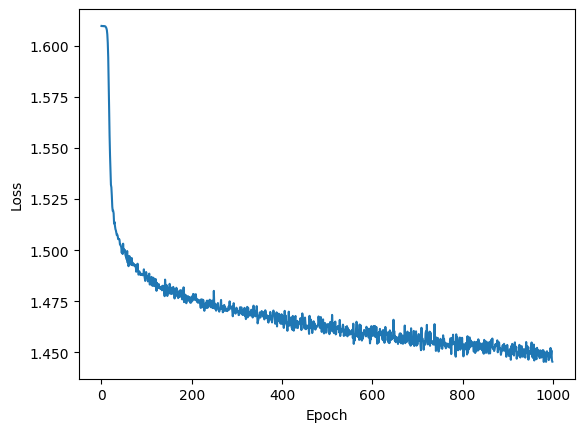

Test accuracy: 466.367311827957
Accuracy: 0.42795698924731185
Precision: 0.40599801961172954
Recall: 0.4250022714516762
F1-score: 0.41167428543527756


Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       495
           1       0.65      0.86      0.74       472
           2       0.30      0.30      0.30       449
           3       0.32      0.30      0.31       463
           4       0.34      0.28      0.31       446

    accuracy                           0.43      2325
   macro avg       0.41      0.43      0.41      2325
weighted avg       0.41      0.43      0.41      2325

                    0           1           2           3           4  \
precision    0.415755    0.650718    0.301802    0.320186    0.341530   
recall       0.383838    0.864407    0.298441    0.298056    0.280269   
f1-score     0.399160    0.742493    0.300112    0.308725    0.307882   
support    495.000000  472.000000  449.00000

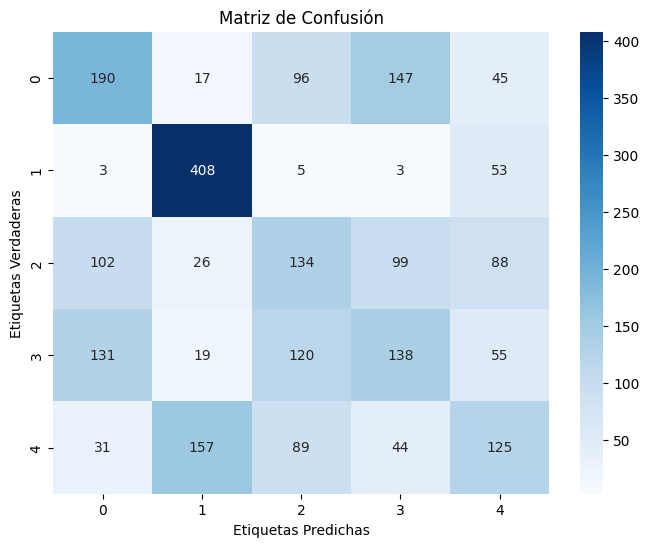

Diccionario guardado como JSON en: F:/nuevo_conocimiento/CODIGO DE TESIS (MUY IMPORTANTE)/Experimentos_con_modelos_basicos/word2vect_embeddings/Neural_network_classification/RRN_1000_1e-05_0.1/resultados_1000_1e-05_0.1.json


In [7]:
epocas = [700,1000]
lr = [0.0001,0.00001]
test_label = [0.3,0.2,0.1]
#RNN_model(X, labels ,0.3,10,0.001)

for test in test_label:
    for epoca in epocas:
        for rang in lr:
                print(f"Procesando red con {epoca} epocas y {rang} de factor de aprendizaje y conjunto de entrenamiento {1-test}")
                RNN_model(X, labels ,test,epoca,rang)